# 1. Import Dependencies

Pada tahap ini dilakukan instalasi dan import dependencies yang dibutuhkan.

In [1]:
!pip install rdkit-pypi scikit-learn pandas
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 56.2 MB/s eta 0:00:00:00:0100:01


In [2]:
import ast
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import torch
import warnings

In [3]:
# from google.colab import drive
from lightgbm import LGBMRegressor
from matplotlib.colors import Normalize
from matplotlib import cm
from rdkit import Chem
from rdkit.Chem import Draw
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from tqdm.auto import tqdm
from xgboost import XGBRegressor

In [4]:
# Variabelized Functions\
# drive.mount('/content/drive')
opts = Draw.MolDrawOptions()
opts.addAtomIndices = True
plt.style.use('ggplot')
tqdm.pandas()
warnings.filterwarnings('ignore')

# Predefined Variable
rs = 666

Inisiasi variabel beberapa fungsi dan nilai

# 2. Import Dataset


Pada tahap ini dilakukan loading dataset hasil ekstraksi Batch [Data Extracting] dari dataset [SMILES Enumeation Datasets](https://github.com/summer-cola/SMILES-enumeration-datasets/blob/master/logS/trainset.csv).

In [5]:
raw = pd.read_csv('/kaggle/input/descripted-openbabel-mmff94-uff/Descripted_OpenBabel_MMFF94_UFF.csv')
raw.columns

Index(['Unnamed: 0', 'logS', 'molWt', 'numAtoms', 'molMR', 'rings', 'aromatic',
       'ap', 'chiralC', 'logP', 'hbd', 'hba', 'rb', 'tpsa', 'nh2', 'oh',
       'balabanJ', 'bertzCT', 'hallKierAlpha', 'ipc', 'chi0', 'chi1', 'kappa1',
       'kappa2', 'kappa3', 'fractionCSP3', 'asphericity', 'eccentricity',
       'inertialShapeFactor', 'radiusOfGyration', 'spherocityIndex', 'ncp',
       'ecfp'],
      dtype='object')

Tahap ini dilakukan screening kolom/variabel pada dataset, dan dataset menyimpan kolom `Unnamed: 0` hasil export file csv.

In [6]:
raw = raw.drop(columns=['Unnamed: 0'], axis=1) #.head(1000)
raw.columns

Index(['logS', 'molWt', 'numAtoms', 'molMR', 'rings', 'aromatic', 'ap',
       'chiralC', 'logP', 'hbd', 'hba', 'rb', 'tpsa', 'nh2', 'oh', 'balabanJ',
       'bertzCT', 'hallKierAlpha', 'ipc', 'chi0', 'chi1', 'kappa1', 'kappa2',
       'kappa3', 'fractionCSP3', 'asphericity', 'eccentricity',
       'inertialShapeFactor', 'radiusOfGyration', 'spherocityIndex', 'ncp',
       'ecfp'],
      dtype='object')

Drop kolom `Unnamed: 0` dan screening.

In [7]:
def convert_string_to_list(string_list):
    return ast.literal_eval(string_list)

# Apply the conversion with a progress bar
tqdm.pandas(desc="Converting string to list")

# Assuming 'raw' is your DataFrame
raw['ecfp'] = raw['ecfp'].progress_apply(convert_string_to_list)

Converting string to list:   0%|          | 0/7954 [00:00<?, ?it/s]

Kolom `ecfp` yang awalnya menyimpan data list berubah menjadi string setelah dilakukan eksport sehingga perlu diubah menggunakan literal eval.

In [8]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7954 entries, 0 to 7953
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   logS                 7954 non-null   float64
 1   molWt                7954 non-null   float64
 2   numAtoms             7954 non-null   int64  
 3   molMR                7954 non-null   float64
 4   rings                7954 non-null   int64  
 5   aromatic             7954 non-null   int64  
 6   ap                   7954 non-null   float64
 7   chiralC              7954 non-null   int64  
 8   logP                 7954 non-null   float64
 9   hbd                  7954 non-null   int64  
 10  hba                  7954 non-null   int64  
 11  rb                   7954 non-null   int64  
 12  tpsa                 7954 non-null   float64
 13  nh2                  7954 non-null   int64  
 14  oh                   7954 non-null   int64  
 15  balabanJ             7954 non-null   f

Dataset memiliki 7954 data dengan tiga jenis data yaitu float64(22), int64(9), object(1). 

In [9]:
num_feature = raw.select_dtypes('number').columns.tolist()
X_feature = num_feature[1:]
y_feature = ['logS']
ls_feature = ['ecfp']

Menyiapkan `variable` berdasarkan `dtype` pada fitur

## 2.1. Menangani Missing Value

Data berbentuk List diubah menjadi Tuple agar fungsi `duplicated` dapat membaca data tersebut.

In [10]:
raw['ecfp'] = raw['ecfp'].apply(tuple)    # List -> Tuple

In [11]:
raw.duplicated().sum()

1

Berdasarkan hasil di atas terdapat `1` data `duplikat` dalam dataset.

In [ ]:
df[df.duplicated()]
df.drop_duplicates(inplace=True)
# df.info()

# 3. Data Preparation

## 3.1. Unpacks List Feature

Seperti yang telah dijelaskan sebelumnya, `Fingerprint ecfp` merupakan `representasi biner` dari struktur suatu molekul dengan jumlah `2048 bit` sehingga tidak dilakukan `encoding` dan hanya dilakukan *unpack* dari tipe `list` mejadi fitur sesuai jumlah bit-nya.

In [12]:
def unpack_ls(df: pd.DataFrame, column: str) -> pd.DataFrame:
    list_cols = pd.DataFrame(df[column].tolist(), index=df.index)
    list_cols.columns = [f'{column}{i+1}' for i in range(list_cols.shape[1])]

    return pd.concat([df.drop(columns=[column]), list_cols], axis=1)

In [13]:
df = unpack_ls(raw, 'ecfp')
df.head()

logS    molWt  numAtoms     molMR  rings  aromatic        ap  chiralC  \
0 -3.633502  274.361        19   72.7871      0         0  0.000000        1   
1 -4.397670  292.318        21   89.9045      3         3  0.857143        0   
2 -4.760920  334.463        25  100.2470      4         2  0.480000        2   
3 -8.600000  360.882        18   81.9380      2         2  0.666667        0   
4 -4.086451  280.415        21   89.5860      3         2  0.571429        0   

     logP  hbd  ...  ecfp2039  ecfp2040  ecfp2041  ecfp2042  ecfp2043  \
0  2.4128    2  ...         0         0         0         0         0   
1  4.2007    0  ...         1         0         0         0         0   
2  3.8612    0  ...         1         0         0         0         0   
3  7.2740    0  ...         0         0         0         0         0   
4  3.7874    0  ...         1         0         0         0         0   

   ecfp2044  ecfp2045  ecfp2046  ecfp2047  ecfp2048  
0         0         0         0         0         0  
1         0         0         0         0         0  
2         0         0         0         0         0  
3         0         0         0         0         0  
4         0         0         0         0         0  

[5 rows x 2079 columns]

Fitur `ecfp` telah berhasil dipecah menjadi 2048 fitur.

## 3.3. Train-Test-Split

Inisiasi variabel data `Input` dan `Label`.

In [14]:
X = df.drop(columns=['logS'], axis=1)
y = df['logS']

Splitting data dan memastikan `bentuk` variabel `Input` dan `Label` data `Train` dan `Test`.

In [15]:
# Split the dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rs)

# Display shapes of the training and test sets
print("[Train]")
print("Data (total, fitur):", X_train.shape)
print("Label (total, fitur)", y_train.shape)
print("[Test]")
print("Data (total, fitur):", X_test.shape)
print("Label (total, fitur)", y_test.shape)

[Train]
Data (total, fitur): (7158, 2078)
Label (total, fitur) (7158,)
[Test]
Data (total, fitur): (796, 2078)
Label (total, fitur) (796,)


## 3.4. Standarisasi pada fitur dengan dtype float.

| **Scaler**               | **Deskripsi**                                                                                                   | **Rumus**                                                                                    | **Efek pada Data**                              |
|--------------------------|------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|-------------------------------------------------|
| **StandardScaler**       | Skala data agar memiliki mean 0 dan standar deviasi 1. Berguna ketika data mengikuti distribusi normal.         | z = (x - mean(x)) / std(x)                                                                   | Menyelaraskan data (mean = 0) dengan variansi 1 (std = 1).           |
| **MinMaxScaler**         | Mengubah skala data ke rentang tertentu (default 0 hingga 1). Berguna untuk transformasi dalam batas tertentu.   | z = (x - min(x)) / (max(x) - min(x))                                                         | Menggeser dan menskalakan data agar sesuai dalam rentang tertentu, biasanya [0, 1]. |
| **RobustScaler**         | Menggunakan median dan interquartile range (IQR) untuk mengurangi pengaruh outlier dalam skala data.            | z = (x - median(x)) / IQR(x)                                                                 | Menyelaraskan data menggunakan median dan menskalakan berdasarkan IQR, mengurangi dampak outlier. |
| **QuantileTransformerN** | Mengubah data agar mengikuti distribusi normal. Menerapkan transformasi peringkat, berguna untuk data non-Gaussian. | Memetakan kuantil data ke distribusi normal standar.                                          | Membuat distribusi data menjadi normal, menggeser mean dan standar deviasi. |
| **QuantileTransformerU** | Mengubah data agar mengikuti distribusi uniform. Berguna untuk membuat distribusi lebih seragam.                | Memetakan kuantil data ke distribusi uniform (sering dalam [0, 1]).                           | Mengubah data menjadi sebaran seragam, tanpa terpusat pada mean. |
| **PowerTransformer**     | Menerapkan transformasi daya (Box-Cox atau Yeo-Johnson) untuk menstabilkan variansi dan membuat data lebih mendekati distribusi Gaussian. | z = (x^λ - 1) / λ (Box-Cox); x = log(x) untuk Yeo-Johnson | Menggeser dan menskalakan data, sering kali mengurangi skewness untuk mendekati distribusi Gaussian. |


Pada tahap ini dilakukan evaluasi performa *scaler* pada data `flaot64`.

In [ ]:
# Re-define float_features based on X_train to avoid index issues
float_features = X_train.select_dtypes(include=['float64']).columns.intersection(X_train.columns)

# List of scalers to try, including PowerTransformer
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'QuantileTransformerN': QuantileTransformer(output_distribution='normal'),
    'QuantileTransformerU': QuantileTransformer(output_distribution='uniform'),
    'PowerTransformer': PowerTransformer()
}

# Dictionary to store results
scaler_scores = {}

# Loop through each scaler and evaluate performance
for scaler_name, scaler in scalers.items():
    # Fit the scaler on the training data float features
    scaled_data = scaler.fit_transform(X_train[float_features])

    # Use a simple model for evaluation (e.g., linear regression)
    model = LinearRegression()
    scores = cross_val_score(model, scaled_data, y_train, cv=5, scoring='neg_mean_squared_error')

    # Store the mean score for each scaler
    scaler_scores[scaler_name] = np.mean(scores)

# Display the results
best_scaler_name = max(scaler_scores, key=scaler_scores.get)
print(f"Best scaler: {best_scaler_name} with score: {scaler_scores[best_scaler_name]}")

Best scaler: QuantileTransformerN with score: -1.4785082890369394


### 3.4.1 Scaling Dataset

*Scaler* terbaik disimpan dan diaplikasikan pada data `Train` dan `Test`.

In [17]:
best_scaler = scalers[best_scaler_name]
best_scaler.fit(X_train[float_features])
X_train[float_features] = best_scaler.transform(X_train.loc[:, float_features])
X_train[float_features].head()

molWt     molMR        ap      logP      tpsa  balabanJ   bertzCT  \
508   0.761968  0.802226  0.165095  0.435859  0.967422 -0.096999  0.819278   
1718 -0.833781 -0.619797  0.360172 -0.682610  0.193143  0.805584 -0.555131   
1963  1.432719  1.262433 -5.199338  0.144519  1.510407 -0.221952  1.419445   
7266 -0.941425 -0.759349  0.728240 -0.172564 -1.212751 -1.467860 -0.771892   
3785 -0.925870 -1.037567 -5.199338 -0.552391  0.273089  1.053051 -0.925579   

      hallKierAlpha       ipc      chi0  ...    kappa1    kappa2    kappa3  \
508       -0.008782  0.594834  0.555462  ...  0.798769  0.941700  1.048770   
1718       0.293986 -0.456960 -0.436240  ... -1.007585 -0.400635  0.016424   
1963      -1.571286  1.497993  1.503805  ...  1.319715  0.929834  0.842129   
7266       0.790168 -0.804575 -0.791884  ... -1.075559 -0.823104 -0.961680   
3785       0.293986 -0.741367 -0.612356  ... -1.054494 -1.070616 -1.385443   

      fractionCSP3  asphericity  eccentricity  inertialShapeFactor  \
508       0.033880     1.551123      1.551645            -0.053481   
1718     -0.108103     1.450143      1.452342             1.212268   
1963      0.692715    -1.148299     -1.023922            -1.293435   
7266     -0.362850    -0.512041     -0.452316             0.828012   
3785      0.855287    -1.491208     -1.413745             0.733307   

      radiusOfGyration  spherocityIndex       ncp  
508           1.338382        -0.741352  0.619578  
1718         -0.237289        -0.876987 -0.160010  
1963          0.759974         1.144162  0.346817  
7266         -1.197276        -0.633331 -0.658043  
3785         -1.246420         1.546305  0.619578  

[5 rows x 21 columns]

In [18]:
X_train[float_features].describe().round(4)

molWt      molMR         ap       logP       tpsa   balabanJ  \
count  7158.0000  7158.0000  7158.0000  7158.0000  7158.0000  7158.0000   
mean     -0.0000     0.0001    -1.0488     0.0001    -0.1821     0.0002   
std       1.0022     1.0018     2.6061     1.0015     1.5082     1.0012   
min      -5.1993    -5.1993    -5.1993    -5.1993    -5.1993    -5.1993   
25%      -0.6753    -0.6745    -5.1993    -0.6753    -0.6612    -0.6737   
50%       0.0004    -0.0006    -0.0125     0.0002    -0.0025    -0.0009   
75%       0.6737     0.6744     0.7282     0.6739     0.6762     0.6741   
max       5.1993     5.1993     5.1993     5.1993     5.1993     5.1993   

         bertzCT  hallKierAlpha        ipc       chi0  ...     kappa1  \
count  7158.0000      7158.0000  7158.0000  7158.0000  ...  7158.0000   
mean     -0.0002        -0.0004    -0.0006    -0.0003  ...    -0.0001   
std       1.0032         1.0024     1.0016     1.0028  ...     1.0016   
min      -5.1993        -5.1993    -5.1993    -5.1993  ...    -5.1993   
25%      -0.6757        -0.6773    -0.6748    -0.6761  ...    -0.6739   
50%       0.0005        -0.0088     0.0006    -0.0006  ...     0.0002   
75%       0.6751         0.6737     0.6742     0.6737  ...     0.6738   
max       5.1993         5.1993     5.1993     5.1993  ...     5.1993   

          kappa2     kappa3  fractionCSP3  asphericity  eccentricity  \
count  7158.0000  7158.0000     7158.0000    7158.0000     7158.0000   
mean     -0.0005     0.0003        0.0170      -0.0009       -0.0002   
std       1.0033     1.0024        2.3916       1.0059        1.0045   
min      -5.1993    -5.1993       -5.1993      -5.1993       -5.1993   
25%      -0.6745    -0.6746       -0.6769      -0.6744       -0.6745   
50%      -0.0008     0.0001       -0.0013       0.0005        0.0004   
75%       0.6747     0.6748        0.6927       0.6740        0.6746   
max       5.1993     5.1993        5.1993       5.1993        5.1993   

       inertialShapeFactor  radiusOfGyration  spherocityIndex        ncp  
count            7158.0000         7158.0000        7158.0000  7158.0000  
mean               -0.0004           -0.0003          -0.0066    -0.0459  
std                 1.0050            1.0028           1.0302     1.1698  
min                -5.1993           -5.1993          -5.1993    -5.1993  
25%                -0.6747           -0.6749          -0.6743    -0.6580  
50%                 0.0002           -0.0002           0.0008     0.0100  
75%                 0.6742            0.6747           0.6740     0.6196  
max                 5.1993            5.1993           5.1993     5.1993  

[8 rows x 21 columns]

Fitur dengan dtype `float` telah berhasil dilakukan `QuantileTransformer Normal` dengan membatasi nilai `min` dan `max` menjadi `-5.1993` dan `5.1993` dan mengakibatkan pergeseran nilai `mean` dan `std`.

In [19]:
X_test.loc[:, float_features] = best_scaler.transform(X_test[float_features])

`Standardisasi` juga diaplikasikan pada `data test`

In [20]:
# Define smaller dataset for faster search
X_param = X_train[:1000]
y_param = y_train[:1000]

Untuk mempercepat proses `tunning` data yang digunakan dibatasi.

# 4. Modeling

Pengujian model prediksi nilai `LogS` menggunakan beberapa model `regressor` seperti `NeuralNetwork`, `KNN`, `RandomForest`, `SVR`, `ElasticNet`, `DecisionTree`, `XGBoost`, `ExtraTrees`, dan `LGBM`.

| Model               | Penanganan Fitur       | Risiko Overfitting | Cocok untuk Dimensi Tinggi?  | Kemungkinan Performanya Baik |
|---------------------|------------------------|---------------------|------------------------------|------------------------------|
| **Neural Network**  | Baik dengan fitur banyak, perlu penyesuaian hati-hati | Sedang-Tinggi      | Ya, jika diatur regulerisasinya | **Sedang**: Potensi tinggi, tetapi berisiko overfitting dengan data terbatas |
| **K-Nearest Neighbors** (KNN) | Kesulitan dengan dimensi tinggi | Rendah | Tidak | **Rendah**: Kemungkinan underperform karena masalah dimensi tinggi |
| **Random Forest** (RF) | Menangani banyak fitur dengan baik | Rendah (karena rata-rata ensemble) | Ya | **Tinggi**: Efektif dengan data berdimensi tinggi dan fitur biner |
| **Support Vector Regression** (SVR) | Efektif di dimensi tinggi, perlu penyesuaian | Sedang | Ya, tetapi sensitif terhadap kernel | **Sedang**: Dapat bagus, tetapi butuh penyesuaian parameter |
| **ElasticNet** (EN) | Cocok untuk data sparsi dan berdimensi tinggi | Sedang | Ya | **Sedang**: Membutuhkan tuning; bagus jika terdapat sparsitas |
| **Decision Tree** (DT) | Sederhana tetapi mudah overfit | Tinggi | Tidak | **Sedang-Rendah**: Mungkin kesulitan dengan dataset kecil dan overfitting |
| **XGBoost** (XGB) | Sangat baik untuk data berdimensi tinggi | Rendah | Ya | **Tinggi**: Kandidat kuat karena ketangguhan dan seleksi fitur |
| **Extra Trees** (ET) | Mirip RF tetapi kurang rentan terhadap noise | Rendah | Ya | **Tinggi**: Andal dan efisien untuk tipe data ini |
| **LightGBM** (LGBM) | Sangat baik untuk fitur biner/kategori berdimensi tinggi | Rendah | Ya | **Tinggi**: Kandidat kuat, efisien untuk fitur biner |

### Sifat Model:
1. **Kontrol Overfitting**: Model ensemble seperti `RandomForest`, `ExtraTrees`, `XGBoost`, dan `LightGBM` memiliki metode bawaan untuk mencegah overfitting, sehingga cocok untuk dataset kecil dengan dimensi tinggi.
2. **Penanganan Fitur Biner**: Model seperti `LightGBM` dan `XGBoost` sangat efisien dengan fitur sparsi atau biner, seperti fingerprint `ECFP`.
3. **Sensitivitas Dimensi**: `KNN` dan `Decision Trees` sering mengalami kesulitan dengan dimensi tinggi, sehingga kemungkinan performanya kurang baik pada dataset ini.

### Hipotesis:
- **Pilihan Terbaik**: `RandomForest`, `ExtraTrees`, `XGBoost`, dan `LightGBM` karena ketahanan dan kemampuannya untuk menggeneralisasi dengan baik pada dataset kecil.
- **Underperform**: `KNN` dan `Decision Trees` untuk data berdimensi tinggi ini, kecuali jika direduksi melalui teknik seperti PCA.

Selanjutnya dilakukan tahap sebagai berikut untuk masing-masing model.
1. `Hyperparameter tunning`
2. `Evaluasi parameter terbaik`
3. `Training model dengan parameter terbaik`
4. `Evaluasi model menggunakan MSE, MAE, dan R²`

## 9.1. Neural Network

In [21]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, (pd.Series, pd.DataFrame)):
            y = y.values
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float().reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

# Neural Network model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.25),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.25),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.25),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.25),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Wrapper class for fit and predict functionality
class NeuralNetworkRegressor:
    def __init__(self, input_dim, epochs=100, patience=10, batch_size=16, lr=1e-4, weight_decay=5e-4):
        self.model = MLP(input_dim=input_dim).to(device)
        self.epochs = epochs
        self.patience = patience
        self.batch_size = batch_size
        self.lr = lr
        self.weight_decay = weight_decay

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        # Convert DataFrame to numpy if necessary
        if isinstance(y_train, (pd.Series, pd.DataFrame)):
            y_train = y_train.to_numpy().reshape(-1, 1)
        else:
            y_train = y_train.reshape(-1, 1)

        if X_val is not None and y_val is not None:
            if isinstance(y_val, (pd.Series, pd.DataFrame)):
                y_val = y_val.to_numpy().reshape(-1, 1)
            else:
                y_val = y_val.reshape(-1, 1)

        # DataLoader setup
        train_dataset = CustomDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        if X_val is not None and y_val is not None:
            val_dataset = CustomDataset(X_val, y_val)
            val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        else:
            val_loader = None

        # Define loss, optimizer, and scheduler
        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

        best_val_loss = float('inf')
        epochs_no_improve = 0
        start_time = time.time()

        # Training loop
        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0.0

            with tqdm(train_loader, desc=f"Epoch [{epoch + 1:03d}/{self.epochs:03d}]", unit="batch", leave=False) as t_loader:
                for inputs, targets in t_loader:
                    inputs, targets = inputs.to(device), targets.to(device)

                    optimizer.zero_grad()
                    outputs = self.model(inputs)
                    loss = loss_function(outputs, targets)
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item() * inputs.size(0)

            # Validation loop if validation data is provided
            if val_loader is not None:
                self.model.eval()
                val_loss = 0.0
                with torch.no_grad():
                    for inputs, targets in val_loader:
                        inputs, targets = inputs.to(device), targets.to(device)

                        outputs = self.model(inputs)
                        loss = loss_function(outputs, targets)
                        val_loss += loss.item() * inputs.size(0)
                val_loss /= len(val_loader.dataset)
                scheduler.step(val_loss)

                elapsed_time = time.time() - start_time
                print(f"Epoch [{epoch + 1:03d}/{self.epochs:03d}], Train Loss: {train_loss/len(train_loader.dataset):.3f}, Val Loss: {val_loss:.3f}, Time: {elapsed_time:.2f}s")

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                    best_model = self.model.state_dict()
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= self.patience:
                        print("Early stopping triggered. Training halted.")
                        break
            else:
                print(f"Epoch [{epoch + 1:03d}/{self.epochs:03d}], Train Loss: {train_loss/len(train_loader.dataset):.3f}")

        if val_loader is not None:
            self.model.load_state_dict(best_model)

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        X_tensor = torch.from_numpy(X).float()

        self.model.eval()
        with torch.no_grad():
            return self.model(X_tensor.to(device)).cpu().numpy().flatten()

    # Add get_params and set_params methods for compatibility with RandomizedSearchCV
    def get_params(self, deep=True):
        return {
            'input_dim': self.model.layers[0].in_features,
            'epochs': self.epochs,
            'patience': self.patience,
            'batch_size': self.batch_size,
            'lr': self.lr,
            'weight_decay': self.weight_decay
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

In [22]:
param_nnR = {
    'epochs': randint(34, 35),           # 34 | 35
    'patience': randint(5, 6),           # 5 | 6
    'batch_size': randint(89, 90),       # 89 | 90
    'lr': uniform(9e-4, 2e-3),           # 1.7441866428504346e-03 | 9.338969229845672e-04
    'weight_decay': uniform(5e-5, 6e-5)  # 5.773861053341242e-05 | 5.343806133628081e-05
}

# Set up RandomizedSearchCV for NeuralNetworkRegressor
nnR_RS = RandomizedSearchCV(
    estimator=NeuralNetworkRegressor(input_dim=X_train.shape[1]),
    param_distributions=param_nnR,
    n_iter=10,  # Adjust for time/performance balance
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=rs,
    n_jobs=-1
)

# Fit with a progress bar
for _ in tqdm(range(nnR_RS.n_iter), desc="nnR Random Search Progress"):
    nnR_RS.fit(X_param, y_param)

nnR Random Search Progress:   0%|          | 0/10 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
/opt/conda/lib/python3.10/site-p

Epoch [001/034], Train Loss: 12.339
Epoch [001/034], Train Loss: 12.079


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.11batch/s]

Epoch [001/034], Train Loss: 11.840
Epoch [001/034], Train Loss: 11.838


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.45batch/s]

Epoch [002/034], Train Loss: 10.086
Epoch [002/034], Train Loss: 10.095


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 10.007
Epoch [002/034], Train Loss: 9.616
Epoch [003/034], Train Loss: 9.057


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.74batch/s]

Epoch [003/034], Train Loss: 8.960


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.166
Epoch [003/034], Train Loss: 8.741
Epoch [003/034], Train Loss: 9.004


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.89batch/s]

Epoch [004/034], Train Loss: 7.986


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 7.255


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.84batch/s]

Epoch [005/034], Train Loss: 6.947
Epoch [004/034], Train Loss: 7.752
Epoch [004/034], Train Loss: 8.108


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.82batch/s]

Epoch [006/034], Train Loss: 6.288


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.45batch/s]

Epoch [006/034], Train Loss: 5.960


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.64batch/s]

Epoch [007/034], Train Loss: 5.103
Epoch [005/034], Train Loss: 6.744
Epoch [005/034], Train Loss: 7.260


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.99batch/s]

Epoch [007/034], Train Loss: 5.025


Epoch [006/034]:  78%|███████▊  | 7/9 [00:00<00:00,  8.74batch/s]

Epoch [008/034], Train Loss: 4.025


Epoch [006/034]:  89%|████████▉ | 8/9 [00:01<00:00,  6.62batch/s]

Epoch [008/034], Train Loss: 3.944
Epoch [006/034], Train Loss: 6.175


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.77batch/s]

Epoch [006/034], Train Loss: 5.946
Epoch [009/034], Train Loss: 2.890


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00,  7.35batch/s]

Epoch [009/034], Train Loss: 2.882
Epoch [010/034], Train Loss: 2.197


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 17.18batch/s]

Epoch [007/034], Train Loss: 4.995
Epoch [011/034], Train Loss: 1.608


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 4.863
Epoch [010/034], Train Loss: 2.634


Epoch [008/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.65batch/s]

Epoch [012/034], Train Loss: 1.168


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.88batch/s]

Epoch [008/034], Train Loss: 4.257
Epoch [011/034], Train Loss: 1.615


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 3.771
Epoch [013/034], Train Loss: 1.165


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.92batch/s]

Epoch [012/034], Train Loss: 1.410
Epoch [009/034], Train Loss: 3.329


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.75batch/s]

Epoch [014/034], Train Loss: 1.267


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.65batch/s]

Epoch [009/034], Train Loss: 2.726


Epoch [010/034]:  33%|███▎      | 3/9 [00:00<00:00,  8.78batch/s]

Epoch [013/034], Train Loss: 1.291
Epoch [015/034], Train Loss: 1.035


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [010/034], Train Loss: 2.459
Epoch [014/034], Train Loss: 1.306


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.34batch/s]

Epoch [010/034], Train Loss: 1.978
Epoch [016/034], Train Loss: 1.102


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.07batch/s]

Epoch [015/034], Train Loss: 1.183
Epoch [011/034], Train Loss: 1.781


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.16batch/s]

Epoch [017/034], Train Loss: 1.102
Epoch [011/034], Train Loss: 1.626


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.45batch/s]

Epoch [016/034], Train Loss: 1.060


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.16batch/s]

Epoch [018/034], Train Loss: 0.947
Epoch [012/034], Train Loss: 1.394


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.043
Epoch [012/034], Train Loss: 1.370


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.54batch/s]

Epoch [019/034], Train Loss: 0.921


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.92batch/s]

Epoch [018/034], Train Loss: 1.154
Epoch [013/034], Train Loss: 1.266


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.23batch/s]

Epoch [020/034], Train Loss: 0.819
Epoch [013/034], Train Loss: 1.277


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.46batch/s]

Epoch [019/034], Train Loss: 0.871


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.45batch/s]

Epoch [021/034], Train Loss: 0.779
Epoch [014/034], Train Loss: 1.226


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 0.871
Epoch [014/034], Train Loss: 1.141


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.28batch/s]

Epoch [022/034], Train Loss: 0.952


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.79batch/s]

Epoch [021/034], Train Loss: 1.022


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 1.285
Epoch [023/034], Train Loss: 0.722
Epoch [015/034], Train Loss: 1.119


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.091


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.31batch/s]

Epoch [024/034], Train Loss: 0.774
Epoch [016/034], Train Loss: 1.185


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 0.715
Epoch [016/034], Train Loss: 1.189


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.798
Epoch [024/034], Train Loss: 0.990


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.233
Epoch [026/034], Train Loss: 0.710
Epoch [017/034], Train Loss: 1.081


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.46batch/s]

Epoch [025/034], Train Loss: 0.757


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.717
Epoch [018/034], Train Loss: 0.906


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.30batch/s]

Epoch [026/034], Train Loss: 0.665
Epoch [018/034], Train Loss: 1.088


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.53batch/s]

Epoch [028/034], Train Loss: 0.759


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.03batch/s]

Epoch [027/034], Train Loss: 0.777


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.95batch/s]

Epoch [019/034], Train Loss: 1.195
Epoch [029/034], Train Loss: 0.652
Epoch [019/034], Train Loss: 0.843


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.760


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.07batch/s]

Epoch [030/034], Train Loss: 0.653
Epoch [020/034], Train Loss: 0.865
Epoch [029/034], Train Loss: 0.774


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 0.851


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.40batch/s]

Epoch [031/034], Train Loss: 0.606


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.58batch/s]

Epoch [030/034], Train Loss: 0.666


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.41batch/s]

Epoch [021/034], Train Loss: 0.838
Epoch [021/034], Train Loss: 0.988
Epoch [032/034], Train Loss: 0.657


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.20batch/s]

Epoch [031/034], Train Loss: 0.840


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.612
Epoch [022/034], Train Loss: 0.804
Epoch [032/034], Train Loss: 0.641


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.25batch/s]

Epoch [022/034], Train Loss: 0.769


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.37batch/s]

Epoch [033/034], Train Loss: 0.738
Epoch [034/034], Train Loss: 0.655


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [024/034]:   0%|          

Epoch [023/034], Train Loss: 0.721
Epoch [023/034], Train Loss: 0.820


Epoch [024/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.73batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.689
Epoch [001/034], Train Loss: 11.407


Epoch [001/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.12batch/s]

Epoch [024/034], Train Loss: 0.959
Epoch [024/034], Train Loss: 0.823


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.35batch/s]

Epoch [001/034], Train Loss: 11.962
Epoch [002/034], Train Loss: 9.515


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.37batch/s]

Epoch [025/034], Train Loss: 0.762
Epoch [025/034], Train Loss: 0.778


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.43batch/s]

Epoch [002/034], Train Loss: 9.790
Epoch [003/034], Train Loss: 8.633


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.17batch/s]

Epoch [026/034], Train Loss: 0.622
Epoch [026/034], Train Loss: 0.851


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.24batch/s]

Epoch [003/034], Train Loss: 8.696
Epoch [004/034], Train Loss: 7.627


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.85batch/s]

Epoch [027/034], Train Loss: 0.706
Epoch [027/034], Train Loss: 0.745


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 7.825
Epoch [005/034], Train Loss: 6.719


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.09batch/s]

Epoch [028/034], Train Loss: 0.660
Epoch [028/034], Train Loss: 0.732


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.67batch/s]

Epoch [006/034], Train Loss: 5.881
Epoch [005/034], Train Loss: 7.059


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.733
Epoch [029/034], Train Loss: 0.765


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.42batch/s]

Epoch [007/034], Train Loss: 4.767
Epoch [006/034], Train Loss: 6.025


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.71batch/s]

Epoch [030/034], Train Loss: 0.723
Epoch [030/034], Train Loss: 0.802


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.44batch/s]

Epoch [008/034], Train Loss: 3.731
Epoch [007/034], Train Loss: 5.130


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.681
Epoch [031/034], Train Loss: 0.699


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 2.872
Epoch [008/034], Train Loss: 4.108


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.643
Epoch [032/034], Train Loss: 0.703


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 1.970
Epoch [009/034], Train Loss: 3.102


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.49batch/s]

Epoch [033/034], Train Loss: 0.572
Epoch [033/034], Train Loss: 0.576


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 1.616
Epoch [010/034], Train Loss: 2.165


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.06batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.604
Epoch [034/034], Train Loss: 0.601
Epoch [012/034], Train Loss: 1.182
Epoch [011/034], Train Loss: 1.699


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 12.102
Epoch [001/034], Train Loss: 11.559


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.37batch/s]

Epoch [013/034], Train Loss: 1.146
Epoch [012/034], Train Loss: 1.307


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.40batch/s]

Epoch [002/034], Train Loss: 9.697


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.16batch/s]

Epoch [002/034], Train Loss: 9.794


Epoch [015/034]:  11%|█         | 1/9 [00:00<00:00,  9.72batch/s]

Epoch [014/034], Train Loss: 1.117
Epoch [013/034], Train Loss: 1.225
Epoch [003/034], Train Loss: 8.692


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 8.747
Epoch [004/034], Train Loss: 7.820


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 1.134
Epoch [014/034], Train Loss: 1.232


Epoch [005/034], Train Loss: 7.084
Epoch [004/034], Train Loss: 7.941


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 1.242
Epoch [016/034], Train Loss: 0.973


Epoch [005/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.71batch/s]

Epoch [006/034], Train Loss: 6.123


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.33batch/s]

Epoch [005/034], Train Loss: 7.082


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 5.160
Epoch [016/034], Train Loss: 1.110
Epoch [017/034], Train Loss: 0.940


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.79batch/s]

Epoch [008/034], Train Loss: 4.303
Epoch [006/034], Train Loss: 6.182


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.091
Epoch [018/034], Train Loss: 0.915


Epoch [018/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.78batch/s]

Epoch [009/034], Train Loss: 3.197


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 5.237


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 1.084
Epoch [019/034], Train Loss: 0.937


Epoch [008/034]:  33%|███▎      | 3/9 [00:00<00:01,  5.92batch/s]

Epoch [010/034], Train Loss: 2.513


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 4.349
Epoch [020/034], Train Loss: 0.907
Epoch [011/034], Train Loss: 2.006
Epoch [019/034], Train Loss: 0.885


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.10batch/s]

Epoch [021/034], Train Loss: 0.746
Epoch [012/034], Train Loss: 1.335


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.23batch/s]

Epoch [009/034], Train Loss: 2.949
Epoch [020/034], Train Loss: 1.117


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 1.141
Epoch [022/034], Train Loss: 0.828


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.04batch/s]

Epoch [010/034], Train Loss: 2.384
Epoch [021/034], Train Loss: 0.811
Epoch [014/034], Train Loss: 0.988


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 0.720


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 1.732
Epoch [015/034], Train Loss: 1.073
Epoch [022/034], Train Loss: 0.887


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.34batch/s]

Epoch [024/034], Train Loss: 0.708
Epoch [016/034], Train Loss: 1.018


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.81batch/s]

Epoch [012/034], Train Loss: 1.218
Epoch [023/034], Train Loss: 0.721


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.09batch/s]

Epoch [017/034], Train Loss: 1.170


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.07batch/s]

Epoch [025/034], Train Loss: 0.673
Epoch [013/034], Train Loss: 1.141


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.32batch/s]

Epoch [024/034], Train Loss: 0.906
Epoch [018/034], Train Loss: 1.203


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.40batch/s]

Epoch [026/034], Train Loss: 0.695
Epoch [014/034], Train Loss: 1.230


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.38batch/s]

Epoch [019/034], Train Loss: 0.873
Epoch [025/034], Train Loss: 0.691


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.40batch/s]

Epoch [027/034], Train Loss: 0.715
Epoch [020/034], Train Loss: 0.823
Epoch [015/034], Train Loss: 1.123


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.29batch/s]

Epoch [026/034], Train Loss: 0.750


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.03batch/s]

Epoch [021/034], Train Loss: 0.919
Epoch [028/034], Train Loss: 0.722


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.57batch/s]

Epoch [016/034], Train Loss: 1.130


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.62batch/s]

Epoch [027/034], Train Loss: 0.622
Epoch [022/034], Train Loss: 0.709


Epoch [017/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.11batch/s]

Epoch [029/034], Train Loss: 0.621


Epoch [028/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.70batch/s]

Epoch [017/034], Train Loss: 0.960
Epoch [023/034], Train Loss: 0.703
Epoch [028/034], Train Loss: 0.572


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.24batch/s]

Epoch [030/034], Train Loss: 0.564
Epoch [024/034], Train Loss: 0.751


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.37batch/s]

Epoch [018/034], Train Loss: 0.995
Epoch [029/034], Train Loss: 0.700


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.10batch/s]

Epoch [025/034], Train Loss: 0.683
Epoch [031/034], Train Loss: 0.628


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.81batch/s]

Epoch [019/034], Train Loss: 0.906
Epoch [026/034], Train Loss: 0.780
Epoch [030/034], Train Loss: 0.651


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.41batch/s]

Epoch [032/034], Train Loss: 0.581


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.13batch/s]

Epoch [027/034], Train Loss: 0.680
Epoch [020/034], Train Loss: 0.942


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.11batch/s]

Epoch [031/034], Train Loss: 0.545


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.51batch/s]

Epoch [028/034], Train Loss: 0.765
Epoch [033/034], Train Loss: 0.633


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 0.855
Epoch [032/034], Train Loss: 0.598


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.46batch/s]

Epoch [029/034], Train Loss: 0.712


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.24batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.530


Epoch [001/034]:  22%|██▏       | 2/9 [00:00<00:00,  8.38batch/s]

Epoch [022/034], Train Loss: 0.749
Epoch [030/034], Train Loss: 0.686
Epoch [033/034], Train Loss: 0.688


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 12.011
Epoch [031/034], Train Loss: 0.584


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.22batch/s]

Epoch [023/034], Train Loss: 0.773
Epoch [002/034], Train Loss: 9.977


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00,  9.74batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.634
Epoch [032/034], Train Loss: 0.645


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.05batch/s]

Epoch [003/034], Train Loss: 9.081
Epoch [024/034], Train Loss: 0.836


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.574
Epoch [001/034], Train Loss: 10.529


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.09batch/s]

Epoch [004/034], Train Loss: 8.082


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.52batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [025/034], Train Loss: 0.738
Epoch [034/034], Train Loss: 0.658
Epoch [005/034], Train Loss: 7.313
Epoch [002/034], Train Loss: 8.477


Epoch [003/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.09batch/s]

Epoch [001/034], Train Loss: 11.454
Epoch [006/034], Train Loss: 6.320
Epoch [026/034], Train Loss: 0.754


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.20batch/s]

Epoch [003/034], Train Loss: 7.697


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.50batch/s]

Epoch [007/034], Train Loss: 5.231
Epoch [002/034], Train Loss: 9.256


Epoch [028/034]:  11%|█         | 1/9 [00:00<00:00,  9.88batch/s]

Epoch [027/034], Train Loss: 0.754
Epoch [004/034], Train Loss: 6.890
Epoch [008/034], Train Loss: 4.033


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.05batch/s]

Epoch [003/034], Train Loss: 8.024


Epoch [009/034], Train Loss: 2.991
Epoch [028/034], Train Loss: 0.799


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.40batch/s]

Epoch [005/034], Train Loss: 6.233
Epoch [004/034], Train Loss: 7.008


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 2.053


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.744
Epoch [005/034], Train Loss: 6.091
Epoch [006/034], Train Loss: 5.133
Epoch [011/034], Train Loss: 1.797


Epoch [006/034], Train Loss: 4.729
Epoch [012/034], Train Loss: 1.307
Epoch [030/034], Train Loss: 0.815


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.80batch/s]

Epoch [007/034], Train Loss: 4.076


Epoch [031/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.95batch/s]

Epoch [013/034], Train Loss: 1.152
Epoch [007/034], Train Loss: 3.516


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.10batch/s]

Epoch [031/034], Train Loss: 0.609
Epoch [008/034], Train Loss: 3.378
Epoch [014/034], Train Loss: 1.032


Epoch [032/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.89batch/s]

Epoch [008/034], Train Loss: 2.303


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 1.132
Epoch [032/034], Train Loss: 0.632


Epoch [010/034]:  11%|█         | 1/9 [00:00<00:00,  9.96batch/s]

Epoch [009/034], Train Loss: 2.594
Epoch [009/034], Train Loss: 1.854


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.48batch/s]

Epoch [016/034], Train Loss: 1.008


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.02batch/s]

Epoch [010/034], Train Loss: 1.458
Epoch [033/034], Train Loss: 0.638
Epoch [017/034], Train Loss: 0.922
Epoch [010/034], Train Loss: 1.820


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.01batch/s]

Epoch [011/034], Train Loss: 1.107
Epoch [018/034], Train Loss: 0.843


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.05batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [011/034], Train Loss: 1.651
Epoch [034/034], Train Loss: 0.709


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.84batch/s]

Epoch [019/034], Train Loss: 0.874
Epoch [012/034], Train Loss: 1.211


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.157


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.18batch/s]

Epoch [012/034], Train Loss: 1.117
Epoch [020/034], Train Loss: 0.981
Epoch [013/034], Train Loss: 1.050


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.44batch/s]

Epoch [002/034], Train Loss: 8.939


Epoch [013/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.96batch/s]

Epoch [021/034], Train Loss: 0.890
Epoch [014/034], Train Loss: 1.211


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.28batch/s]

Epoch [013/034], Train Loss: 1.308
Epoch [003/034], Train Loss: 7.689


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.52batch/s]

Epoch [022/034], Train Loss: 0.884


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 1.041
Epoch [004/034], Train Loss: 6.870


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.42batch/s]

Epoch [014/034], Train Loss: 1.038
Epoch [023/034], Train Loss: 0.879


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.06batch/s]

Epoch [016/034], Train Loss: 1.024
Epoch [005/034], Train Loss: 5.589


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.08batch/s]

Epoch [024/034], Train Loss: 0.791
Epoch [015/034], Train Loss: 1.104


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.54batch/s]

Epoch [006/034], Train Loss: 4.612
Epoch [017/034], Train Loss: 0.924


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.58batch/s]

Epoch [025/034], Train Loss: 0.668


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 3.440
Epoch [016/034], Train Loss: 1.113
Epoch [018/034], Train Loss: 0.744


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.54batch/s]

Epoch [026/034], Train Loss: 0.725


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.57batch/s]

Epoch [008/034], Train Loss: 2.353


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 0.769
Epoch [027/034], Train Loss: 0.765
Epoch [017/034], Train Loss: 0.851


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.56batch/s]

Epoch [009/034], Train Loss: 1.781


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.44batch/s]

Epoch [028/034], Train Loss: 0.730
Epoch [020/034], Train Loss: 0.724


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 1.271
Epoch [018/034], Train Loss: 0.875


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.31batch/s]

Epoch [029/034], Train Loss: 0.639
Epoch [021/034], Train Loss: 0.675


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.37batch/s]

Epoch [011/034], Train Loss: 1.092


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.709
Epoch [019/034], Train Loss: 0.833


Epoch [031/034]:  33%|███▎      | 3/9 [00:00<00:00, 12.24batch/s]

Epoch [022/034], Train Loss: 0.741
Epoch [012/034], Train Loss: 0.917


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.630


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.28batch/s]

Epoch [023/034], Train Loss: 0.714
Epoch [013/034], Train Loss: 1.043
Epoch [020/034], Train Loss: 0.859


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.16batch/s]

Epoch [032/034], Train Loss: 0.675


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.92batch/s]

Epoch [024/034], Train Loss: 0.626
Epoch [021/034], Train Loss: 0.891
Epoch [014/034], Train Loss: 1.189


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.28batch/s]

Epoch [033/034], Train Loss: 0.681


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.563
Epoch [015/034], Train Loss: 0.971
Epoch [022/034], Train Loss: 0.862


Epoch [023/034]:  11%|█         | 1/9 [00:00<00:00,  9.15batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.594


Epoch [001/034]:  78%|███████▊  | 7/9 [00:00<00:00, 14.10batch/s]

Epoch [026/034], Train Loss: 0.611
Epoch [016/034], Train Loss: 0.890


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 10.511
Epoch [023/034], Train Loss: 0.770


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00,  9.25batch/s]

Epoch [017/034], Train Loss: 0.787
Epoch [027/034], Train Loss: 0.610


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.67batch/s]

Epoch [002/034], Train Loss: 8.390


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.31batch/s]

Epoch [018/034], Train Loss: 0.857
Epoch [024/034], Train Loss: 0.830


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.05batch/s]

Epoch [028/034], Train Loss: 0.632
Epoch [003/034], Train Loss: 7.313


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.67batch/s]

Epoch [019/034], Train Loss: 0.780


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 6.444
Epoch [029/034], Train Loss: 0.640
Epoch [025/034], Train Loss: 0.598


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.90batch/s]

Epoch [020/034], Train Loss: 0.810


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 5.116


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.78batch/s]

Epoch [030/034], Train Loss: 0.640
Epoch [021/034], Train Loss: 0.705
Epoch [026/034], Train Loss: 0.745


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.70batch/s]

Epoch [006/034], Train Loss: 4.447


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.93batch/s]

Epoch [031/034], Train Loss: 0.564
Epoch [022/034], Train Loss: 0.743


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.60batch/s]

Epoch [007/034], Train Loss: 3.315
Epoch [027/034], Train Loss: 0.663


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 0.775
Epoch [032/034], Train Loss: 0.593
Epoch [008/034], Train Loss: 2.405


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.632
Epoch [028/034], Train Loss: 0.719
Epoch [033/034], Train Loss: 0.556
Epoch [009/034], Train Loss: 1.702


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.69batch/s]

Epoch [025/034], Train Loss: 0.680
Epoch [010/034], Train Loss: 1.373


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.42batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [029/034], Train Loss: 0.722
Epoch [034/034], Train Loss: 0.597


Epoch [001/034]:  33%|███▎      | 3/9 [00:00<00:00, 11.19batch/s]

Epoch [026/034], Train Loss: 0.604
Epoch [011/034], Train Loss: 1.277


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.950
Epoch [027/034], Train Loss: 0.629
Epoch [030/034], Train Loss: 0.743


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.70batch/s]

Epoch [012/034], Train Loss: 1.065


Epoch [028/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.71batch/s]

Epoch [002/034], Train Loss: 9.506
Epoch [028/034], Train Loss: 0.693


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.55batch/s]

Epoch [013/034], Train Loss: 1.012


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.63batch/s]

Epoch [031/034], Train Loss: 0.669


Epoch [032/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.85batch/s]

Epoch [029/034], Train Loss: 0.614
Epoch [003/034], Train Loss: 8.372
Epoch [014/034], Train Loss: 0.877


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.57batch/s]

Epoch [032/034], Train Loss: 0.559
Epoch [030/034], Train Loss: 0.656
Epoch [015/034], Train Loss: 0.906
Epoch [004/034], Train Loss: 7.299


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.18batch/s]

Epoch [031/034], Train Loss: 0.566
Epoch [016/034], Train Loss: 0.890
Epoch [005/034], Train Loss: 6.258


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.20batch/s]

Epoch [033/034], Train Loss: 0.649


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.92batch/s]

Epoch [032/034], Train Loss: 0.562
Epoch [017/034], Train Loss: 0.906


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.88batch/s]

Epoch [006/034], Train Loss: 4.931


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [034/034]:   0%|          

Epoch [034/034], Train Loss: 0.636
Epoch [033/034], Train Loss: 0.620
Epoch [018/034], Train Loss: 0.768


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.93batch/s]

Epoch [007/034], Train Loss: 3.678


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.51batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [019/034], Train Loss: 0.751
Epoch [034/034], Train Loss: 0.624
Epoch [001/034], Train Loss: 10.814


Epoch [008/034], Train Loss: 2.444
Epoch [020/034], Train Loss: 0.716


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.17batch/s]

Epoch [001/034], Train Loss: 11.363


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.28batch/s]

Epoch [002/034], Train Loss: 8.732
Epoch [009/034], Train Loss: 1.630
Epoch [021/034], Train Loss: 0.763


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.83batch/s]

Epoch [002/034], Train Loss: 9.556


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.67batch/s]

Epoch [022/034], Train Loss: 0.672
Epoch [010/034], Train Loss: 1.379
Epoch [003/034], Train Loss: 7.826


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.57batch/s]

Epoch [003/034], Train Loss: 8.578


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.37batch/s]

Epoch [023/034], Train Loss: 0.748
Epoch [011/034], Train Loss: 1.225


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.94batch/s]

Epoch [004/034], Train Loss: 7.867
Epoch [004/034], Train Loss: 6.732


Epoch [024/034], Train Loss: 0.562


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.05batch/s]

Epoch [012/034], Train Loss: 1.161
Epoch [005/034], Train Loss: 7.099


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.93batch/s]

Epoch [025/034], Train Loss: 0.723
Epoch [005/034], Train Loss: 5.396


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.73batch/s]

Epoch [006/034], Train Loss: 6.333
Epoch [013/034], Train Loss: 1.026


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.627


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 5.657
Epoch [006/034], Train Loss: 4.340
Epoch [014/034], Train Loss: 0.939


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.532


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 5.223
Epoch [015/034], Train Loss: 1.014


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.80batch/s]

Epoch [028/034], Train Loss: 0.512
Epoch [007/034], Train Loss: 3.220


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.16batch/s]

Epoch [009/034], Train Loss: 4.474


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.66batch/s]

Epoch [016/034], Train Loss: 0.976
Epoch [029/034], Train Loss: 0.565


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.57batch/s]

Epoch [008/034], Train Loss: 2.134
Epoch [010/034], Train Loss: 3.922


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.91batch/s]

Epoch [030/034], Train Loss: 0.683
Epoch [017/034], Train Loss: 0.965


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.82batch/s]

Epoch [011/034], Train Loss: 3.090
Epoch [009/034], Train Loss: 1.613


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.88batch/s]

Epoch [031/034], Train Loss: 0.620
Epoch [018/034], Train Loss: 0.859


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 2.400
Epoch [032/034], Train Loss: 0.559


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.94batch/s]

Epoch [019/034], Train Loss: 0.750
Epoch [010/034], Train Loss: 1.327


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 1.854
Epoch [033/034], Train Loss: 0.532


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 0.834
Epoch [014/034], Train Loss: 1.701


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.71batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [011/034], Train Loss: 1.169
Epoch [034/034], Train Loss: 0.512
Epoch [021/034], Train Loss: 0.694


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.46batch/s]

Epoch [015/034], Train Loss: 1.251


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.69batch/s]

Epoch [001/034], Train Loss: 11.433
Epoch [012/034], Train Loss: 1.082


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.55batch/s]

Epoch [022/034], Train Loss: 0.692
Epoch [016/034], Train Loss: 1.160


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.22batch/s]

Epoch [002/034], Train Loss: 9.346


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.181
Epoch [023/034], Train Loss: 0.675
Epoch [013/034], Train Loss: 1.017


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.31batch/s]

Epoch [003/034], Train Loss: 8.339


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.63batch/s]

Epoch [018/034], Train Loss: 1.181
Epoch [024/034], Train Loss: 0.673


Epoch [019/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.07batch/s]

Epoch [004/034], Train Loss: 7.813
Epoch [014/034], Train Loss: 1.205


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.07batch/s]

Epoch [019/034], Train Loss: 1.147


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.83batch/s]

Epoch [025/034], Train Loss: 0.665
Epoch [005/034], Train Loss: 7.237


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.113
Epoch [015/034], Train Loss: 0.941


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.659
Epoch [006/034], Train Loss: 6.579


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.37batch/s]

Epoch [021/034], Train Loss: 1.047


Epoch [017/034]:  11%|█         | 1/9 [00:00<00:00,  9.04batch/s]

Epoch [007/034], Train Loss: 5.864
Epoch [016/034], Train Loss: 1.135
Epoch [027/034], Train Loss: 0.731


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.71batch/s]

Epoch [022/034], Train Loss: 1.014


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.67batch/s]

Epoch [008/034], Train Loss: 5.295
Epoch [028/034], Train Loss: 0.620


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.97batch/s]

Epoch [023/034], Train Loss: 1.059
Epoch [017/034], Train Loss: 0.871


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.03batch/s]

Epoch [009/034], Train Loss: 4.400


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.49batch/s]

Epoch [029/034], Train Loss: 0.627
Epoch [024/034], Train Loss: 0.862


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.22batch/s]

Epoch [010/034], Train Loss: 3.804
Epoch [018/034], Train Loss: 0.854


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.56batch/s]

Epoch [025/034], Train Loss: 0.744
Epoch [030/034], Train Loss: 0.657


Epoch [031/034]:  33%|███▎      | 3/9 [00:00<00:00, 12.54batch/s]

Epoch [011/034], Train Loss: 3.234


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.96batch/s]

Epoch [026/034], Train Loss: 0.952
Epoch [019/034], Train Loss: 0.866


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.11batch/s]

Epoch [031/034], Train Loss: 0.515
Epoch [012/034], Train Loss: 2.258


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.12batch/s]

Epoch [027/034], Train Loss: 0.794


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.14batch/s]

Epoch [013/034], Train Loss: 1.950
Epoch [020/034], Train Loss: 0.755
Epoch [032/034], Train Loss: 0.577


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.46batch/s]

Epoch [028/034], Train Loss: 0.703


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.633
Epoch [014/034], Train Loss: 1.592


Epoch [029/034], Train Loss: 0.776
Epoch [021/034], Train Loss: 0.808


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00,  6.89batch/s]

Epoch [015/034], Train Loss: 1.278


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.17batch/s]

Epoch [030/034], Train Loss: 0.774
Epoch [016/034], Train Loss: 1.089


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.43batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.681


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.760
Epoch [017/034], Train Loss: 1.092
Epoch [031/034], Train Loss: 0.744


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.828
Epoch [018/034], Train Loss: 1.215
Epoch [032/034], Train Loss: 0.716


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.89batch/s]

Epoch [023/034], Train Loss: 0.694


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [019/034], Train Loss: 1.055
Epoch [033/034], Train Loss: 0.657


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.810


Epoch [020/034], Train Loss: 0.972
Epoch [024/034], Train Loss: 0.641


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.80batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.695


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 8.746
Epoch [021/034], Train Loss: 0.872


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.03batch/s]

Epoch [001/034], Train Loss: 11.929
Epoch [025/034], Train Loss: 0.714


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.09batch/s]

Epoch [022/034], Train Loss: 0.939


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.00batch/s]

Epoch [004/034], Train Loss: 8.020
Epoch [002/034], Train Loss: 9.984


Epoch [027/034]:  11%|█         | 1/9 [00:00<00:00,  9.93batch/s]

Epoch [026/034], Train Loss: 0.707
Epoch [023/034], Train Loss: 0.811


Epoch [027/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.60batch/s]

Epoch [003/034], Train Loss: 9.023


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [005/034], Train Loss: 7.334
Epoch [024/034], Train Loss: 0.829


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.52batch/s]

Epoch [004/034], Train Loss: 8.292
Epoch [027/034], Train Loss: 0.659


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.15batch/s]

Epoch [025/034], Train Loss: 0.733


Epoch [028/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.91batch/s]

Epoch [006/034], Train Loss: 6.724
Epoch [005/034], Train Loss: 7.632


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.827
Epoch [028/034], Train Loss: 0.609


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.60batch/s]

Epoch [006/034], Train Loss: 6.985


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.16batch/s]

Epoch [007/034], Train Loss: 6.113
Epoch [027/034], Train Loss: 0.743


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.29batch/s]

Epoch [007/034], Train Loss: 6.250
Epoch [029/034], Train Loss: 0.627


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.97batch/s]

Epoch [028/034], Train Loss: 0.780
Epoch [008/034], Train Loss: 5.539
Epoch [008/034], Train Loss: 5.569


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.97batch/s]

Epoch [030/034], Train Loss: 0.604
Epoch [029/034], Train Loss: 0.759


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.00batch/s]

Epoch [009/034], Train Loss: 4.862


Epoch [010/034]:  11%|█         | 1/9 [00:00<00:00,  9.96batch/s]

Epoch [009/034], Train Loss: 4.760
Epoch [030/034], Train Loss: 0.961


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 3.892
Epoch [031/034], Train Loss: 0.655


Epoch [010/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.85batch/s]

Epoch [031/034], Train Loss: 0.805


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.56batch/s]

Epoch [011/034], Train Loss: 3.186
Epoch [010/034], Train Loss: 3.972


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.445
Epoch [032/034], Train Loss: 0.807


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.53batch/s]

Epoch [012/034], Train Loss: 2.480


Epoch [033/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.85batch/s]

Epoch [011/034], Train Loss: 3.254
Epoch [033/034], Train Loss: 0.749


Epoch [013/034], Train Loss: 2.103
Epoch [033/034], Train Loss: 0.498


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [015/034]:  22%|██▏       

Epoch [034/034], Train Loss: 0.752
Epoch [014/034], Train Loss: 1.647
Epoch [012/034], Train Loss: 2.639


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.87batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.537
Epoch [001/034], Train Loss: 12.077
Epoch [015/034], Train Loss: 1.280


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.47batch/s]

Epoch [013/034], Train Loss: 2.084


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 10.372
Epoch [016/034], Train Loss: 1.188


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.81batch/s]

Epoch [001/034], Train Loss: 11.495


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.212
Epoch [014/034], Train Loss: 1.708
Epoch [017/034], Train Loss: 1.095


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.41batch/s]

Epoch [002/034], Train Loss: 9.881
Epoch [004/034], Train Loss: 8.576
Epoch [018/034], Train Loss: 1.137


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 1.482


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.85batch/s]

Epoch [005/034], Train Loss: 7.948
Epoch [019/034], Train Loss: 1.184


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.78batch/s]

Epoch [003/034], Train Loss: 9.222


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.99batch/s]

Epoch [006/034], Train Loss: 7.205
Epoch [016/034], Train Loss: 1.101
Epoch [020/034], Train Loss: 0.993


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.528
Epoch [007/034], Train Loss: 6.485
Epoch [021/034], Train Loss: 0.979


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.50batch/s]

Epoch [017/034], Train Loss: 1.062


Epoch [018/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.90batch/s]

Epoch [008/034], Train Loss: 5.636
Epoch [022/034], Train Loss: 0.946


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.91batch/s]

Epoch [005/034], Train Loss: 7.854


Epoch [006/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.23batch/s]

Epoch [009/034], Train Loss: 4.718
Epoch [018/034], Train Loss: 0.957
Epoch [023/034], Train Loss: 1.046


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.03batch/s]

Epoch [006/034], Train Loss: 7.682
Epoch [010/034], Train Loss: 4.121
Epoch [024/034], Train Loss: 0.921


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.19batch/s]

Epoch [019/034], Train Loss: 1.202


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.70batch/s]

Epoch [011/034], Train Loss: 3.334
Epoch [025/034], Train Loss: 0.824


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.48batch/s]

Epoch [007/034], Train Loss: 7.210


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.09batch/s]

Epoch [012/034], Train Loss: 2.524
Epoch [020/034], Train Loss: 1.166
Epoch [026/034], Train Loss: 0.885


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.82batch/s]

Epoch [008/034], Train Loss: 7.007
Epoch [013/034], Train Loss: 2.034


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.70batch/s]

Epoch [027/034], Train Loss: 0.823


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.11batch/s]

Epoch [021/034], Train Loss: 1.026


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 1.659
Epoch [028/034], Train Loss: 0.718
Epoch [009/034], Train Loss: 6.384


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 1.331
Epoch [022/034], Train Loss: 0.915
Epoch [029/034], Train Loss: 0.730


Epoch [011/034]:  11%|█         | 1/9 [00:00<00:00,  9.81batch/s]

Epoch [010/034], Train Loss: 5.956
Epoch [016/034], Train Loss: 1.460


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.96batch/s]

Epoch [030/034], Train Loss: 0.709
Epoch [023/034], Train Loss: 0.986


Epoch [011/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.74batch/s]

Epoch [017/034], Train Loss: 1.368


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.82batch/s]

Epoch [031/034], Train Loss: 0.784
Epoch [011/034], Train Loss: 5.369


Epoch [025/034]:  11%|█         | 1/9 [00:00<00:00,  9.82batch/s]

Epoch [024/034], Train Loss: 0.932
Epoch [018/034], Train Loss: 1.122


Epoch [025/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.73batch/s]

Epoch [032/034], Train Loss: 0.668


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 5.085
Epoch [019/034], Train Loss: 1.143


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.94batch/s]

Epoch [033/034], Train Loss: 0.618
Epoch [025/034], Train Loss: 1.006


Epoch [020/034], Train Loss: 1.137
Epoch [013/034], Train Loss: 4.539


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.14batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.737


Epoch [001/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.22batch/s]

Epoch [026/034], Train Loss: 0.855
Epoch [021/034], Train Loss: 0.949


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.70batch/s]

Epoch [001/034], Train Loss: 13.011
Epoch [014/034], Train Loss: 4.054


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.84batch/s]

Epoch [022/034], Train Loss: 1.119


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00,  8.69batch/s]

Epoch [027/034], Train Loss: 1.029
Epoch [002/034], Train Loss: 11.073


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.32batch/s]

Epoch [023/034], Train Loss: 0.981


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 3.616
Epoch [003/034], Train Loss: 10.023


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.57batch/s]

Epoch [028/034], Train Loss: 1.071
Epoch [024/034], Train Loss: 0.858


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 9.348
Epoch [016/034], Train Loss: 2.980


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.33batch/s]

Epoch [025/034], Train Loss: 0.813


Epoch [017/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.96batch/s]

Epoch [029/034], Train Loss: 0.730
Epoch [005/034], Train Loss: 8.896


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.919
Epoch [017/034], Train Loss: 2.688


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.50batch/s]

Epoch [006/034], Train Loss: 8.593


Epoch [031/034]:  11%|█         | 1/9 [00:00<00:00,  9.97batch/s]

Epoch [030/034], Train Loss: 0.731
Epoch [027/034], Train Loss: 0.950


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.45batch/s]

Epoch [007/034], Train Loss: 8.146
Epoch [018/034], Train Loss: 2.324


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.78batch/s]

Epoch [028/034], Train Loss: 1.027


Epoch [032/034]:  11%|█         | 1/9 [00:00<00:00,  9.85batch/s]

Epoch [031/034], Train Loss: 0.814
Epoch [008/034], Train Loss: 7.837


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.896
Epoch [019/034], Train Loss: 2.182


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.45batch/s]

Epoch [009/034], Train Loss: 7.247


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.37batch/s]

Epoch [032/034], Train Loss: 0.752
Epoch [030/034], Train Loss: 0.841


Epoch [021/034]:  11%|█         | 1/9 [00:00<00:00,  9.62batch/s]

Epoch [010/034], Train Loss: 6.712
Epoch [020/034], Train Loss: 1.767


Epoch [021/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.62batch/s]

Epoch [031/034], Train Loss: 0.720


Epoch [021/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.60batch/s]

Epoch [033/034], Train Loss: 0.715
Epoch [011/034], Train Loss: 6.418


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.87batch/s]

Epoch [032/034], Train Loss: 0.756
Epoch [021/034], Train Loss: 1.582


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.54batch/s]

Epoch [012/034], Train Loss: 5.815


Epoch [022/034]:  78%|███████▊  | 7/9 [00:00<00:00,  7.40batch/s]

Epoch [013/034], Train Loss: 5.249
Epoch [033/034], Train Loss: 0.711


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.74batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.731
Epoch [022/034], Train Loss: 1.402


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 4.716


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [002/034]:   0%|          

Epoch [034/034], Train Loss: 0.812
Epoch [015/034], Train Loss: 4.121
Epoch [001/034], Train Loss: 11.494


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.84batch/s]

Epoch [023/034], Train Loss: 1.266


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.04batch/s]

Epoch [001/034], Train Loss: 12.239
Epoch [016/034], Train Loss: 3.600


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.83batch/s]

Epoch [002/034], Train Loss: 9.754


Epoch [025/034]:  11%|█         | 1/9 [00:00<00:00,  9.95batch/s]

Epoch [002/034], Train Loss: 10.376
Epoch [017/034], Train Loss: 3.055
Epoch [024/034], Train Loss: 1.121


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.75batch/s]

Epoch [003/034], Train Loss: 8.761


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.692
Epoch [018/034], Train Loss: 2.888


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.35batch/s]

Epoch [025/034], Train Loss: 1.192
Epoch [004/034], Train Loss: 8.209


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.38batch/s]

Epoch [019/034], Train Loss: 2.299
Epoch [004/034], Train Loss: 9.153


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.967
Epoch [005/034], Train Loss: 7.754
Epoch [005/034], Train Loss: 8.599
Epoch [026/034], Train Loss: 1.111


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.75batch/s]

Epoch [021/034], Train Loss: 1.723
Epoch [006/034], Train Loss: 8.072
Epoch [006/034], Train Loss: 7.471


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.39batch/s]

Epoch [027/034], Train Loss: 1.165


Epoch [028/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.65batch/s]

Epoch [022/034], Train Loss: 1.733
Epoch [007/034], Train Loss: 7.843


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.59batch/s]

Epoch [007/034], Train Loss: 6.880


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.58batch/s]

Epoch [023/034], Train Loss: 1.322
Epoch [008/034], Train Loss: 7.242
Epoch [028/034], Train Loss: 0.969


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.64batch/s]

Epoch [008/034], Train Loss: 6.377
Epoch [024/034], Train Loss: 1.596


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.66batch/s]

Epoch [009/034], Train Loss: 7.067


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 1.112
Epoch [009/034], Train Loss: 6.185
Epoch [025/034], Train Loss: 1.335
Epoch [010/034], Train Loss: 6.268


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.45batch/s]

Epoch [026/034], Train Loss: 1.353
Epoch [011/034], Train Loss: 5.880
Epoch [010/034], Train Loss: 5.887
Epoch [030/034], Train Loss: 0.888


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.043
Epoch [012/034], Train Loss: 5.446
Epoch [011/034], Train Loss: 5.416


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.96batch/s]

Epoch [031/034], Train Loss: 1.116


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 1.097
Epoch [013/034], Train Loss: 4.856


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.89batch/s]

Epoch [012/034], Train Loss: 5.098


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.86batch/s]

Epoch [029/034], Train Loss: 1.088
Epoch [014/034], Train Loss: 4.343
Epoch [032/034], Train Loss: 0.946


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 4.574
Epoch [030/034], Train Loss: 1.053
Epoch [015/034], Train Loss: 3.828


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.32batch/s]

Epoch [033/034], Train Loss: 0.982
Epoch [031/034], Train Loss: 0.908


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 3.465
Epoch [014/034], Train Loss: 4.035


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 11.18batch/s]

Epoch [032/034], Train Loss: 1.058
Epoch [017/034], Train Loss: 2.937


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.15batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [015/034], Train Loss: 3.566
Epoch [034/034], Train Loss: 0.860


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.93batch/s]

Epoch [033/034], Train Loss: 1.104
Epoch [018/034], Train Loss: 2.259


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.91batch/s]

Epoch [016/034], Train Loss: 3.142
Epoch [001/034], Train Loss: 11.493


Epoch [019/034], Train Loss: 2.059


Epoch [002/034]:  11%|█         | 1/9 [00:00<00:00,  9.00batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 1.145


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 2.646
Epoch [020/034], Train Loss: 1.848


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.42batch/s]

Epoch [001/034], Train Loss: 12.222
Epoch [002/034], Train Loss: 10.092


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.49batch/s]

Epoch [018/034], Train Loss: 2.225
Epoch [021/034], Train Loss: 1.631


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.56batch/s]

Epoch [002/034], Train Loss: 10.364


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.70batch/s]

Epoch [003/034], Train Loss: 9.321
Epoch [022/034], Train Loss: 1.383


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 2.049
Epoch [003/034], Train Loss: 9.271


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.88batch/s]

Epoch [023/034], Train Loss: 1.349
Epoch [004/034], Train Loss: 8.663


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.56batch/s]

Epoch [004/034], Train Loss: 8.447
Epoch [020/034], Train Loss: 1.763


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.54batch/s]

Epoch [024/034], Train Loss: 1.186


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.91batch/s]

Epoch [005/034], Train Loss: 8.079


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.534
Epoch [005/034], Train Loss: 7.991
Epoch [025/034], Train Loss: 1.228


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.83batch/s]

Epoch [006/034], Train Loss: 7.779


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.49batch/s]

Epoch [026/034], Train Loss: 1.123
Epoch [022/034], Train Loss: 1.620


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.79batch/s]

Epoch [007/034], Train Loss: 7.233
Epoch [006/034], Train Loss: 7.624


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.52batch/s]

Epoch [027/034], Train Loss: 1.150
Epoch [023/034], Train Loss: 1.197


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.46batch/s]

Epoch [008/034], Train Loss: 6.907


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 1.151
Epoch [007/034], Train Loss: 7.216


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.54batch/s]

Epoch [024/034], Train Loss: 1.143
Epoch [009/034], Train Loss: 6.273


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.08batch/s]

Epoch [029/034], Train Loss: 0.929


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.88batch/s]

Epoch [010/034], Train Loss: 5.707
Epoch [025/034], Train Loss: 1.081
Epoch [008/034], Train Loss: 6.803


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.90batch/s]

Epoch [030/034], Train Loss: 1.010


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.60batch/s]

Epoch [011/034], Train Loss: 5.082
Epoch [026/034], Train Loss: 1.037


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.63batch/s]

Epoch [031/034], Train Loss: 0.993
Epoch [009/034], Train Loss: 6.280


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.52batch/s]

Epoch [012/034], Train Loss: 4.495


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.08batch/s]

Epoch [027/034], Train Loss: 1.044
Epoch [032/034], Train Loss: 1.067


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.62batch/s]

Epoch [013/034], Train Loss: 3.792
Epoch [010/034], Train Loss: 5.995


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.37batch/s]

Epoch [033/034], Train Loss: 1.011
Epoch [028/034], Train Loss: 0.856


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.87batch/s]

Epoch [014/034], Train Loss: 3.415


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.68batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.998
Epoch [011/034], Train Loss: 5.503
Epoch [029/034], Train Loss: 0.978


Epoch [012/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.28batch/s]

Epoch [015/034], Train Loss: 2.697


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.522
Epoch [030/034], Train Loss: 0.763


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.23batch/s]

Epoch [016/034], Train Loss: 2.491
Epoch [012/034], Train Loss: 5.020


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.672


Epoch [013/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.84batch/s]

Epoch [017/034], Train Loss: 1.908
Epoch [031/034], Train Loss: 0.807


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.46batch/s]

Epoch [013/034], Train Loss: 4.672
Epoch [003/034], Train Loss: 8.781


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.94batch/s]

Epoch [018/034], Train Loss: 1.564
Epoch [032/034], Train Loss: 1.062


Epoch [014/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.88batch/s]

Epoch [004/034], Train Loss: 8.004


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.21batch/s]

Epoch [019/034], Train Loss: 1.346
Epoch [014/034], Train Loss: 4.015


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.05batch/s]

Epoch [033/034], Train Loss: 0.893
Epoch [005/034], Train Loss: 7.712


Epoch [015/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.76batch/s]

Epoch [020/034], Train Loss: 1.357


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.26batch/s]

Epoch [015/034], Train Loss: 3.505
Epoch [006/034], Train Loss: 7.124


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.07batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 1.048
Epoch [021/034], Train Loss: 1.363


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.81batch/s]

Epoch [007/034], Train Loss: 6.728
Epoch [016/034], Train Loss: 3.029


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.21batch/s]

Epoch [001/034], Train Loss: 11.454
Epoch [022/034], Train Loss: 1.042


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.52batch/s]

Epoch [008/034], Train Loss: 6.141


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 0.951
Epoch [002/034], Train Loss: 9.552
Epoch [017/034], Train Loss: 2.552


Epoch [018/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.74batch/s]

Epoch [009/034], Train Loss: 5.579


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.60batch/s]

Epoch [024/034], Train Loss: 0.937
Epoch [003/034], Train Loss: 8.697


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.01batch/s]

Epoch [010/034], Train Loss: 5.381
Epoch [018/034], Train Loss: 2.384


Epoch [019/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.19batch/s]

Epoch [025/034], Train Loss: 1.102


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.098
Epoch [011/034], Train Loss: 4.578


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.80batch/s]

Epoch [026/034], Train Loss: 1.133
Epoch [019/034], Train Loss: 1.928


Epoch [020/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.90batch/s]

Epoch [012/034], Train Loss: 4.054
Epoch [005/034], Train Loss: 7.418


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.915


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.72batch/s]

Epoch [013/034], Train Loss: 3.563
Epoch [020/034], Train Loss: 1.503


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.94batch/s]

Epoch [006/034], Train Loss: 6.926
Epoch [028/034], Train Loss: 0.973


Epoch [021/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.70batch/s]

Epoch [014/034], Train Loss: 3.045


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.28batch/s]

Epoch [029/034], Train Loss: 0.975
Epoch [021/034], Train Loss: 1.481
Epoch [007/034], Train Loss: 6.621


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 2.561


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00,  6.73batch/s]

Epoch [030/034], Train Loss: 0.995


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 6.149


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.334
Epoch [016/034], Train Loss: 2.255
Epoch [031/034], Train Loss: 0.896


Epoch [017/034]:  11%|█         | 1/9 [00:00<00:01,  7.19batch/s]

Epoch [009/034], Train Loss: 5.728


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.46batch/s]

Epoch [017/034], Train Loss: 1.746
Epoch [032/034], Train Loss: 0.986
Epoch [010/034], Train Loss: 5.215


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.306


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.970
Epoch [018/034], Train Loss: 1.517
Epoch [011/034], Train Loss: 4.596


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.072
Epoch [019/034], Train Loss: 1.327


Epoch [025/034]:  11%|█         | 1/9 [00:00<00:00,  9.87batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.762
Epoch [012/034], Train Loss: 4.179


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.45batch/s]

Epoch [020/034], Train Loss: 1.200
Epoch [001/034], Train Loss: 12.527


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.91batch/s]

Epoch [025/034], Train Loss: 1.023
Epoch [013/034], Train Loss: 3.430


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.75batch/s]

Epoch [021/034], Train Loss: 1.191
Epoch [002/034], Train Loss: 10.865


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.79batch/s]

Epoch [014/034], Train Loss: 3.052
Epoch [026/034], Train Loss: 0.998


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.85batch/s]

Epoch [022/034], Train Loss: 1.208
Epoch [003/034], Train Loss: 9.930


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.30batch/s]

Epoch [015/034], Train Loss: 2.585
Epoch [023/034], Train Loss: 1.140


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.46batch/s]

Epoch [004/034], Train Loss: 9.339
Epoch [027/034], Train Loss: 0.967


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 2.231
Epoch [024/034], Train Loss: 1.046
Epoch [005/034], Train Loss: 8.725


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.50batch/s]

Epoch [028/034], Train Loss: 1.010
Epoch [017/034], Train Loss: 1.699
Epoch [006/034], Train Loss: 8.197


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.76batch/s]

Epoch [025/034], Train Loss: 1.041


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.64batch/s]

Epoch [007/034], Train Loss: 7.691
Epoch [026/034], Train Loss: 1.051
Epoch [018/034], Train Loss: 1.559
Epoch [029/034], Train Loss: 0.947


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 7.146
Epoch [027/034], Train Loss: 0.842
Epoch [019/034], Train Loss: 1.307


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.922
Epoch [009/034], Train Loss: 6.555


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.16batch/s]

Epoch [028/034], Train Loss: 1.069


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.60batch/s]

Epoch [020/034], Train Loss: 1.161


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 6.000
Epoch [029/034], Train Loss: 0.920
Epoch [031/034], Train Loss: 0.929


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.70batch/s]

Epoch [021/034], Train Loss: 1.099
Epoch [011/034], Train Loss: 5.362


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.83batch/s]

Epoch [030/034], Train Loss: 0.867


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.05batch/s]

Epoch [032/034], Train Loss: 0.935
Epoch [022/034], Train Loss: 1.105
Epoch [012/034], Train Loss: 4.699


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.37batch/s]

Epoch [031/034], Train Loss: 0.842


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.36batch/s]

Epoch [013/034], Train Loss: 4.118
Epoch [023/034], Train Loss: 1.169
Epoch [032/034], Train Loss: 0.792
Epoch [033/034], Train Loss: 0.869


Epoch [034/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.88batch/s]

Epoch [014/034], Train Loss: 3.595
Epoch [033/034], Train Loss: 1.024
Epoch [024/034], Train Loss: 0.919


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.39batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.927
Epoch [015/034], Train Loss: 2.866


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.49batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.875
Epoch [025/034], Train Loss: 0.985


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.88batch/s]

Epoch [016/034], Train Loss: 2.283


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.54batch/s]

Epoch [001/034], Train Loss: 12.490
Epoch [001/034], Train Loss: 10.837


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.08batch/s]

Epoch [026/034], Train Loss: 0.859
Epoch [017/034], Train Loss: 1.952


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.40batch/s]

Epoch [002/034], Train Loss: 10.687


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.738
Epoch [027/034], Train Loss: 0.852
Epoch [018/034], Train Loss: 1.697


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.50batch/s]

Epoch [003/034], Train Loss: 9.606


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.464
Epoch [028/034], Train Loss: 0.955


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.64batch/s]

Epoch [003/034], Train Loss: 8.784
Epoch [004/034], Train Loss: 9.217


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.391


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.42batch/s]

Epoch [029/034], Train Loss: 0.869
Epoch [005/034], Train Loss: 8.726


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.86batch/s]

Epoch [004/034], Train Loss: 8.080
Epoch [021/034], Train Loss: 1.148


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.69batch/s]

Epoch [030/034], Train Loss: 0.874
Epoch [006/034], Train Loss: 8.229


Epoch [005/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.95batch/s]

Epoch [022/034], Train Loss: 1.108


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.31batch/s]

Epoch [005/034], Train Loss: 7.652
Epoch [007/034], Train Loss: 7.776
Epoch [031/034], Train Loss: 0.866


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.07batch/s]

Epoch [023/034], Train Loss: 1.025


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 7.244
Epoch [032/034], Train Loss: 0.790
Epoch [006/034], Train Loss: 7.181
Epoch [024/034], Train Loss: 1.242


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 6.633
Epoch [025/034], Train Loss: 1.099
Epoch [033/034], Train Loss: 0.854


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.22batch/s]

Epoch [007/034], Train Loss: 6.688
Epoch [010/034], Train Loss: 6.082


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.48batch/s]

Epoch [026/034], Train Loss: 0.938


Epoch [008/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.84batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.722
Epoch [011/034], Train Loss: 5.607


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.27batch/s]

Epoch [008/034], Train Loss: 6.112
Epoch [027/034], Train Loss: 1.205


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 4.747
Epoch [001/034], Train Loss: 11.476


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.86batch/s]

Epoch [028/034], Train Loss: 1.007


Epoch [010/034]:  11%|█         | 1/9 [00:00<00:00,  9.88batch/s]

Epoch [009/034], Train Loss: 5.740


Epoch [010/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.02batch/s]

Epoch [013/034], Train Loss: 4.283


Epoch [010/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.42batch/s]

Epoch [029/034], Train Loss: 1.044
Epoch [002/034], Train Loss: 9.686


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.10batch/s]

Epoch [014/034], Train Loss: 3.493
Epoch [010/034], Train Loss: 5.215


Epoch [011/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.81batch/s]

Epoch [030/034], Train Loss: 0.967


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 2.967
Epoch [003/034], Train Loss: 9.168


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00,  9.52batch/s]

Epoch [031/034], Train Loss: 1.074


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.44batch/s]

Epoch [011/034], Train Loss: 4.552
Epoch [016/034], Train Loss: 2.427


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.73batch/s]

Epoch [032/034], Train Loss: 0.848
Epoch [004/034], Train Loss: 8.248


Epoch [005/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.76batch/s]

Epoch [017/034], Train Loss: 2.245
Epoch [012/034], Train Loss: 3.999
Epoch [033/034], Train Loss: 0.859


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.94batch/s]

Epoch [018/034], Train Loss: 1.665
Epoch [005/034], Train Loss: 7.988


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.99batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 1.017


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 3.521
Epoch [019/034], Train Loss: 1.486


Epoch [014/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.22batch/s]

Epoch [006/034], Train Loss: 7.305


Epoch [014/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.14batch/s]

Epoch [020/034], Train Loss: 1.339
Epoch [001/034], Train Loss: 11.656


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 2.969


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.73batch/s]

Epoch [021/034], Train Loss: 1.365
Epoch [007/034], Train Loss: 6.863


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.62batch/s]

Epoch [002/034], Train Loss: 9.811
Epoch [015/034], Train Loss: 2.629


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.49batch/s]

Epoch [022/034], Train Loss: 1.249


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.58batch/s]

Epoch [008/034], Train Loss: 6.408


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.255
Epoch [003/034], Train Loss: 8.954


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.99batch/s]

Epoch [016/034], Train Loss: 2.144


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.156
Epoch [009/034], Train Loss: 5.866


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.68batch/s]

Epoch [004/034], Train Loss: 8.351


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.844
Epoch [025/034], Train Loss: 1.044


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.69batch/s]

Epoch [010/034], Train Loss: 5.220


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.071
Epoch [005/034], Train Loss: 7.955


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.75batch/s]

Epoch [018/034], Train Loss: 1.584


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.126
Epoch [011/034], Train Loss: 4.737


Epoch [019/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.09batch/s]

Epoch [006/034], Train Loss: 7.514


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.97batch/s]

Epoch [019/034], Train Loss: 1.239
Epoch [028/034], Train Loss: 1.103


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.92batch/s]

Epoch [012/034], Train Loss: 4.071


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.42batch/s]

Epoch [029/034], Train Loss: 0.979
Epoch [007/034], Train Loss: 7.073


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.127


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.82batch/s]

Epoch [030/034], Train Loss: 0.907
Epoch [013/034], Train Loss: 3.495


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 6.567
Epoch [031/034], Train Loss: 1.117
Epoch [021/034], Train Loss: 1.058


Epoch [009/034]:  56%|█████▌    | 5/9 [00:00<00:00,  7.10batch/s]

Epoch [014/034], Train Loss: 3.130


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.60batch/s]

Epoch [032/034], Train Loss: 0.900


Epoch [010/034]:  11%|█         | 1/9 [00:00<00:01,  6.60batch/s]

Epoch [009/034], Train Loss: 6.118
Epoch [015/034], Train Loss: 2.534
Epoch [022/034], Train Loss: 1.041


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00,  6.90batch/s]

Epoch [033/034], Train Loss: 0.863


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 2.275


Epoch [010/034]: 100%|██████████| 9/9 [00:01<00:00,  9.12batch/s]

Epoch [010/034], Train Loss: 5.899
Epoch [034/034], Train Loss: 0.835
Epoch [023/034], Train Loss: 0.972


Epoch [023/034]:  78%|███████▊  | 7/9 [00:00<00:00,  8.26batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [017/034], Train Loss: 1.991
Epoch [001/034], Train Loss: 12.606


Epoch [012/034]:  11%|█         | 1/9 [00:00<00:00,  9.98batch/s]

Epoch [011/034], Train Loss: 5.096


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.47batch/s]

Epoch [024/034], Train Loss: 0.952
Epoch [002/034], Train Loss: 10.774


Epoch [012/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.99batch/s]

Epoch [018/034], Train Loss: 1.678


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.99batch/s]

Epoch [012/034], Train Loss: 4.430
Epoch [003/034], Train Loss: 9.730


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.83batch/s]

Epoch [025/034], Train Loss: 1.212


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.453
Epoch [004/034], Train Loss: 9.178


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.31batch/s]

Epoch [013/034], Train Loss: 3.869


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.014
Epoch [005/034], Train Loss: 8.754


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.01batch/s]

Epoch [020/034], Train Loss: 1.227


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 3.190
Epoch [006/034], Train Loss: 8.258


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.98batch/s]

Epoch [027/034], Train Loss: 0.916


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.156
Epoch [007/034], Train Loss: 7.665


Epoch [016/034]:  11%|█         | 1/9 [00:00<00:00,  9.62batch/s]

Epoch [015/034], Train Loss: 2.655


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [008/034], Train Loss: 7.202
Epoch [028/034], Train Loss: 0.900


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.42batch/s]

Epoch [022/034], Train Loss: 1.194


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 6.709
Epoch [016/034], Train Loss: 2.043


Epoch [017/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.03batch/s]

Epoch [029/034], Train Loss: 0.874


Epoch [030/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.82batch/s]

Epoch [010/034], Train Loss: 5.929
Epoch [023/034], Train Loss: 1.077


Epoch [030/034]:  78%|███████▊  | 7/9 [00:00<00:00,  8.94batch/s]

Epoch [017/034], Train Loss: 1.978


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.17batch/s]

Epoch [011/034], Train Loss: 5.549
Epoch [030/034], Train Loss: 0.881


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.968


Epoch [031/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.91batch/s]

Epoch [018/034], Train Loss: 1.569
Epoch [012/034], Train Loss: 4.730


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.35batch/s]

Epoch [031/034], Train Loss: 0.802


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 4.085
Epoch [025/034], Train Loss: 0.904


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.56batch/s]

Epoch [019/034], Train Loss: 1.407


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.17batch/s]

Epoch [014/034], Train Loss: 3.628
Epoch [032/034], Train Loss: 0.773


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.922


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.11batch/s]

Epoch [020/034], Train Loss: 1.149
Epoch [015/034], Train Loss: 3.057


Epoch [033/034], Train Loss: 0.857


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.42batch/s]

Epoch [027/034], Train Loss: 0.928
Epoch [016/034], Train Loss: 2.419


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.34batch/s]

Epoch [021/034], Train Loss: 0.964


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Epoch [017/034], Train Loss: 2.116
Epoch [034/034], Train Loss: 0.726


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.01batch/s]

Epoch [028/034], Train Loss: 0.993


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.74batch/s]

Epoch [018/034], Train Loss: 1.724
Epoch [022/034], Train Loss: 1.037


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 12.184
Epoch [019/034], Train Loss: 1.465
Epoch [029/034], Train Loss: 0.825


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.01batch/s]

Epoch [023/034], Train Loss: 1.074


Epoch [030/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.20batch/s]

Epoch [020/034], Train Loss: 1.451
Epoch [002/034], Train Loss: 10.434


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 1.030


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.998
Epoch [021/034], Train Loss: 1.391


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.38batch/s]

Epoch [003/034], Train Loss: 9.534
Epoch [031/034], Train Loss: 0.945
Epoch [022/034], Train Loss: 1.308


Epoch [032/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.54batch/s]

Epoch [025/034], Train Loss: 1.065


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.56batch/s]

Epoch [023/034], Train Loss: 1.242
Epoch [004/034], Train Loss: 8.991


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 1.071


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.76batch/s]

Epoch [024/034], Train Loss: 1.321
Epoch [026/034], Train Loss: 1.160


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 8.593
Epoch [025/034], Train Loss: 1.041
Epoch [033/034], Train Loss: 0.864


Epoch [006/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.98batch/s]

Epoch [027/034], Train Loss: 1.180


Epoch [006/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.98batch/s]

Epoch [026/034], Train Loss: 0.973


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 8.015


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00,  9.71batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.723
Epoch [027/034], Train Loss: 1.062
Epoch [028/034], Train Loss: 1.072


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 7.642
Epoch [028/034], Train Loss: 0.938
Epoch [001/034], Train Loss: 11.912


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.75batch/s]

Epoch [029/034], Train Loss: 0.776


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.81batch/s]

Epoch [029/034], Train Loss: 0.935
Epoch [002/034], Train Loss: 9.944


Epoch [030/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.86batch/s]

Epoch [008/034], Train Loss: 6.981


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.53batch/s]

Epoch [030/034], Train Loss: 0.914
Epoch [030/034], Train Loss: 0.774


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.91batch/s]

Epoch [003/034], Train Loss: 9.277


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.87batch/s]

Epoch [009/034], Train Loss: 6.333
Epoch [031/034], Train Loss: 0.924


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.556
Epoch [031/034], Train Loss: 0.797


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.67batch/s]

Epoch [032/034], Train Loss: 0.949


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.60batch/s]

Epoch [010/034], Train Loss: 5.975
Epoch [005/034], Train Loss: 7.906


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.01batch/s]

Epoch [033/034], Train Loss: 0.885
Epoch [032/034], Train Loss: 0.715


Epoch [033/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.08batch/s]

Epoch [006/034], Train Loss: 7.201
Epoch [011/034], Train Loss: 5.722


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.44batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.918


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.68batch/s]

Epoch [033/034], Train Loss: 0.942


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.13batch/s]

Epoch [007/034], Train Loss: 6.722
Epoch [001/034], Train Loss: 12.576
Epoch [012/034], Train Loss: 4.606


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [002/034], Train Loss: 10.929
Epoch [008/034], Train Loss: 6.063
Epoch [034/034], Train Loss: 0.826


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.18batch/s]

Epoch [013/034], Train Loss: 4.192


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.888
Epoch [001/034], Train Loss: 11.509
Epoch [009/034], Train Loss: 5.795


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.73batch/s]

Epoch [004/034], Train Loss: 9.049
Epoch [014/034], Train Loss: 3.478
Epoch [002/034], Train Loss: 9.777


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.65batch/s]

Epoch [010/034], Train Loss: 4.746


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.04batch/s]

Epoch [005/034], Train Loss: 8.467
Epoch [003/034], Train Loss: 8.618


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.71batch/s]

Epoch [015/034], Train Loss: 2.935
Epoch [011/034], Train Loss: 4.215


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.40batch/s]

Epoch [006/034], Train Loss: 7.884
Epoch [004/034], Train Loss: 8.178


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.95batch/s]

Epoch [012/034], Train Loss: 3.539
Epoch [007/034], Train Loss: 7.326
Epoch [016/034], Train Loss: 2.463
Epoch [005/034], Train Loss: 7.365


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.02batch/s]

Epoch [008/034], Train Loss: 6.641
Epoch [013/034], Train Loss: 2.699
Epoch [006/034], Train Loss: 6.966


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.05batch/s]

Epoch [017/034], Train Loss: 1.917


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 5.975
Epoch [007/034], Train Loss: 6.615
Epoch [014/034], Train Loss: 2.407


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 5.395
Epoch [018/034], Train Loss: 1.740
Epoch [008/034], Train Loss: 6.042


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.79batch/s]

Epoch [015/034], Train Loss: 2.111


Epoch [019/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.20batch/s]

Epoch [011/034], Train Loss: 4.570
Epoch [009/034], Train Loss: 5.484


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.34batch/s]

Epoch [019/034], Train Loss: 1.371
Epoch [016/034], Train Loss: 1.554


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 3.920
Epoch [010/034], Train Loss: 4.577


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.85batch/s]

Epoch [017/034], Train Loss: 1.467
Epoch [020/034], Train Loss: 1.277
Epoch [013/034], Train Loss: 3.066


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.17batch/s]

Epoch [011/034], Train Loss: 3.845


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.39batch/s]

Epoch [018/034], Train Loss: 1.395
Epoch [014/034], Train Loss: 2.295


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 3.317
Epoch [021/034], Train Loss: 1.195


Epoch [022/034]:  33%|███▎      | 3/9 [00:00<00:00,  6.07batch/s]

Epoch [015/034], Train Loss: 2.056
Epoch [019/034], Train Loss: 1.226


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.27batch/s]

Epoch [013/034], Train Loss: 2.802


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 1.961
Epoch [014/034], Train Loss: 2.128
Epoch [020/034], Train Loss: 1.143
Epoch [022/034], Train Loss: 1.145


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.90batch/s]

Epoch [015/034], Train Loss: 1.630


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.742
Epoch [021/034], Train Loss: 1.033


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.30batch/s]

Epoch [016/034], Train Loss: 1.420
Epoch [023/034], Train Loss: 1.075


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.06batch/s]

Epoch [018/034], Train Loss: 1.259
Epoch [022/034], Train Loss: 1.128


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.92batch/s]

Epoch [017/034], Train Loss: 1.381


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.105
Epoch [024/034], Train Loss: 1.032
Epoch [018/034], Train Loss: 1.235


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.36batch/s]

Epoch [023/034], Train Loss: 1.153


Epoch [024/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.47batch/s]

Epoch [020/034], Train Loss: 1.131
Epoch [019/034], Train Loss: 1.047


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.880
Epoch [024/034], Train Loss: 1.217


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.40batch/s]

Epoch [021/034], Train Loss: 1.073
Epoch [020/034], Train Loss: 1.144


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 1.342
Epoch [022/034], Train Loss: 0.934
Epoch [026/034], Train Loss: 0.959
Epoch [021/034], Train Loss: 0.982


Epoch [023/034], Train Loss: 0.990
Epoch [026/034], Train Loss: 0.919
Epoch [022/034], Train Loss: 0.961


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.05batch/s]

Epoch [027/034], Train Loss: 1.063
Epoch [024/034], Train Loss: 1.180


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [023/034], Train Loss: 0.993
Epoch [027/034], Train Loss: 1.008


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.917
Epoch [028/034], Train Loss: 0.849
Epoch [024/034], Train Loss: 0.917


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.30batch/s]

Epoch [028/034], Train Loss: 0.931


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.865
Epoch [025/034], Train Loss: 0.935


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.02batch/s]

Epoch [029/034], Train Loss: 0.905
Epoch [029/034], Train Loss: 0.907
Epoch [027/034], Train Loss: 0.954


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.930


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.40batch/s]

Epoch [028/034], Train Loss: 0.987
Epoch [030/034], Train Loss: 1.029
Epoch [030/034], Train Loss: 0.961
Epoch [027/034], Train Loss: 0.769


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.83batch/s]

Epoch [029/034], Train Loss: 0.869
Epoch [031/034], Train Loss: 0.869
Epoch [028/034], Train Loss: 0.736


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.78batch/s]

Epoch [031/034], Train Loss: 0.983
Epoch [030/034], Train Loss: 0.773


Epoch [032/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.99batch/s]

Epoch [029/034], Train Loss: 0.771
Epoch [032/034], Train Loss: 0.887


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.912
Epoch [032/034], Train Loss: 0.905
Epoch [030/034], Train Loss: 0.723


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.46batch/s]

Epoch [033/034], Train Loss: 0.742


Epoch [033/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.92batch/s]

Epoch [032/034], Train Loss: 0.815
Epoch [031/034], Train Loss: 0.834


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.84batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [033/034], Train Loss: 0.908
Epoch [034/034], Train Loss: 0.713


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.17batch/s]

Epoch [033/034], Train Loss: 0.792
Epoch [032/034], Train Loss: 0.734


Epoch [001/034], Train Loss: 11.963
Epoch [034/034], Train Loss: 0.814


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [034/034]:   0%|          

Epoch [033/034], Train Loss: 0.688
Epoch [034/034], Train Loss: 0.761


Epoch [001/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.13batch/s]

Epoch [002/034], Train Loss: 10.231
Epoch [001/034], Train Loss: 11.710


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.68batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.776
Epoch [001/034], Train Loss: 11.652


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.63batch/s]

Epoch [003/034], Train Loss: 9.173
Epoch [002/034], Train Loss: 9.950


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 12.684


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.543
Epoch [003/034], Train Loss: 9.094
Epoch [002/034], Train Loss: 9.852


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.29batch/s]

Epoch [002/034], Train Loss: 10.567


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 7.960
Epoch [004/034], Train Loss: 8.523


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.722
Epoch [003/034], Train Loss: 9.039


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 7.472
Epoch [005/034], Train Loss: 7.912


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.73batch/s]

Epoch [004/034], Train Loss: 9.371


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.83batch/s]

Epoch [007/034], Train Loss: 6.982
Epoch [006/034], Train Loss: 7.442
Epoch [004/034], Train Loss: 8.815


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.62batch/s]

Epoch [005/034], Train Loss: 8.739


Epoch [005/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.05batch/s]

Epoch [008/034], Train Loss: 6.322
Epoch [007/034], Train Loss: 6.762


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.56batch/s]

Epoch [006/034], Train Loss: 8.529
Epoch [005/034], Train Loss: 8.171


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.81batch/s]

Epoch [009/034], Train Loss: 5.517
Epoch [008/034], Train Loss: 6.224


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 8.006


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 5.016
Epoch [009/034], Train Loss: 5.632
Epoch [006/034], Train Loss: 7.926


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.18batch/s]

Epoch [008/034], Train Loss: 7.881


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.39batch/s]

Epoch [010/034], Train Loss: 4.820
Epoch [011/034], Train Loss: 4.184


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 7.399
Epoch [007/034], Train Loss: 7.690


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.58batch/s]

Epoch [012/034], Train Loss: 3.527
Epoch [011/034], Train Loss: 4.220


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.81batch/s]

Epoch [010/034], Train Loss: 7.255


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.68batch/s]

Epoch [013/034], Train Loss: 3.007
Epoch [012/034], Train Loss: 3.585
Epoch [008/034], Train Loss: 7.180


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.61batch/s]

Epoch [011/034], Train Loss: 6.713


Epoch [009/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.86batch/s]

Epoch [014/034], Train Loss: 2.358
Epoch [013/034], Train Loss: 2.821


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 6.915
Epoch [012/034], Train Loss: 6.407


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.13batch/s]

Epoch [015/034], Train Loss: 1.941
Epoch [014/034], Train Loss: 2.416


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.18batch/s]

Epoch [013/034], Train Loss: 6.025
Epoch [015/034], Train Loss: 2.069
Epoch [016/034], Train Loss: 1.723


Epoch [011/034]:  11%|█         | 1/9 [00:00<00:00,  9.85batch/s]

Epoch [010/034], Train Loss: 6.657


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 5.624
Epoch [016/034], Train Loss: 1.669


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.96batch/s]

Epoch [017/034], Train Loss: 1.488


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.68batch/s]

Epoch [011/034], Train Loss: 6.368
Epoch [015/034], Train Loss: 5.238


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.454
Epoch [018/034], Train Loss: 1.431


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 4.821
Epoch [018/034], Train Loss: 1.224
Epoch [012/034], Train Loss: 5.934
Epoch [019/034], Train Loss: 1.041


Epoch [019/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.54batch/s]

Epoch [017/034], Train Loss: 4.323
Epoch [019/034], Train Loss: 1.300
Epoch [020/034], Train Loss: 1.122


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 5.589
Epoch [018/034], Train Loss: 3.799


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.03batch/s]

Epoch [020/034], Train Loss: 0.999
Epoch [021/034], Train Loss: 0.996


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 3.412
Epoch [021/034], Train Loss: 1.038
Epoch [014/034], Train Loss: 4.994
Epoch [022/034], Train Loss: 0.897


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 2.922
Epoch [022/034], Train Loss: 0.982
Epoch [023/034], Train Loss: 1.025


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 4.768


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 0.858
Epoch [021/034], Train Loss: 2.771
Epoch [024/034], Train Loss: 1.109


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.54batch/s]

Epoch [024/034], Train Loss: 0.941
Epoch [022/034], Train Loss: 2.341
Epoch [016/034], Train Loss: 4.399
Epoch [025/034], Train Loss: 0.943


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.853
Epoch [023/034], Train Loss: 2.187
Epoch [026/034], Train Loss: 0.971


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.68batch/s]

Epoch [017/034], Train Loss: 3.937


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.984
Epoch [024/034], Train Loss: 2.022
Epoch [027/034], Train Loss: 0.991


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.859
Epoch [025/034], Train Loss: 1.761
Epoch [018/034], Train Loss: 3.491


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.13batch/s]

Epoch [028/034], Train Loss: 0.784


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.13batch/s]

Epoch [028/034], Train Loss: 0.865
Epoch [026/034], Train Loss: 1.486


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.901


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.85batch/s]

Epoch [019/034], Train Loss: 3.210
Epoch [029/034], Train Loss: 0.746


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.445
Epoch [030/034], Train Loss: 0.731


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.89batch/s]

Epoch [030/034], Train Loss: 0.883
Epoch [028/034], Train Loss: 1.488
Epoch [020/034], Train Loss: 2.862


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.775


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.851
Epoch [029/034], Train Loss: 1.217
Epoch [032/034], Train Loss: 0.831


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.22batch/s]

Epoch [021/034], Train Loss: 2.311


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.811
Epoch [030/034], Train Loss: 1.215


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.98batch/s]

Epoch [033/034], Train Loss: 0.780


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.46batch/s]

Epoch [022/034], Train Loss: 2.231
Epoch [033/034], Train Loss: 0.836


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.83batch/s]

Epoch [031/034], Train Loss: 1.185
Epoch [034/034], Train Loss: 0.844


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [032/034]:  67%|██████▋   

Epoch [023/034], Train Loss: 1.961
Epoch [034/034], Train Loss: 0.755
Epoch [001/034], Train Loss: 11.817
Epoch [032/034], Train Loss: 1.037


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.72batch/s]

Epoch [001/034], Train Loss: 12.038
Epoch [002/034], Train Loss: 10.209
Epoch [033/034], Train Loss: 1.122


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.20batch/s]

Epoch [024/034], Train Loss: 1.826


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.88batch/s]

Epoch [002/034], Train Loss: 10.263
Epoch [003/034], Train Loss: 9.105


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.83batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 1.102
Epoch [003/034], Train Loss: 9.462


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.50batch/s]

Epoch [025/034], Train Loss: 1.573


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.14batch/s]

Epoch [004/034], Train Loss: 8.777
Epoch [001/034], Train Loss: 11.267


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.82batch/s]

Epoch [004/034], Train Loss: 8.797


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.509
Epoch [005/034], Train Loss: 8.342
Epoch [002/034], Train Loss: 9.400


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.98batch/s]

Epoch [005/034], Train Loss: 8.484


Epoch [003/034], Train Loss: 8.719
Epoch [006/034], Train Loss: 8.033
Epoch [006/034], Train Loss: 8.069
Epoch [027/034], Train Loss: 1.269


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.284
Epoch [007/034], Train Loss: 7.789
Epoch [007/034], Train Loss: 7.681


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.18batch/s]

Epoch [028/034], Train Loss: 1.262


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.91batch/s]

Epoch [005/034], Train Loss: 7.825
Epoch [008/034], Train Loss: 7.526


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.15batch/s]

Epoch [008/034], Train Loss: 7.208


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.50batch/s]

Epoch [006/034], Train Loss: 7.453
Epoch [009/034], Train Loss: 7.203
Epoch [029/034], Train Loss: 1.374


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.50batch/s]

Epoch [009/034], Train Loss: 7.070


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.75batch/s]

Epoch [007/034], Train Loss: 7.090
Epoch [010/034], Train Loss: 6.637


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.26batch/s]

Epoch [030/034], Train Loss: 1.137
Epoch [010/034], Train Loss: 6.694
Epoch [008/034], Train Loss: 6.965


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.66batch/s]

Epoch [011/034], Train Loss: 6.539


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 6.301
Epoch [012/034], Train Loss: 6.208
Epoch [009/034], Train Loss: 6.520
Epoch [031/034], Train Loss: 1.132


Epoch [032/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.84batch/s]

Epoch [013/034], Train Loss: 5.991
Epoch [010/034], Train Loss: 6.124
Epoch [012/034], Train Loss: 6.210


Epoch [033/034]:  11%|█         | 1/9 [00:00<00:00,  9.89batch/s]

Epoch [032/034], Train Loss: 0.970
Epoch [014/034], Train Loss: 5.374
Epoch [011/034], Train Loss: 5.943


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.34batch/s]

Epoch [013/034], Train Loss: 5.617


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.02batch/s]

Epoch [015/034], Train Loss: 4.801
Epoch [012/034], Train Loss: 5.352
Epoch [033/034], Train Loss: 1.271


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.20batch/s]

Epoch [014/034], Train Loss: 5.192


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 4.482
Epoch [013/034], Train Loss: 5.130


Epoch [015/034], Train Loss: 4.915
Epoch [017/034], Train Loss: 4.113
Epoch [034/034], Train Loss: 1.022


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.29batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [014/034], Train Loss: 4.715


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.74batch/s]

Epoch [016/034], Train Loss: 4.622
Epoch [018/034], Train Loss: 3.638
Epoch [015/034], Train Loss: 4.276


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.14batch/s]

Epoch [001/034], Train Loss: 11.432


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 3.126
Epoch [016/034], Train Loss: 3.819
Epoch [017/034], Train Loss: 4.185


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 2.825
Epoch [002/034], Train Loss: 9.793
Epoch [017/034], Train Loss: 3.595
Epoch [018/034], Train Loss: 3.498


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.43batch/s]

Epoch [021/034], Train Loss: 2.514
Epoch [018/034], Train Loss: 3.342


Epoch [019/034], Train Loss: 3.199
Epoch [003/034], Train Loss: 8.823


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.43batch/s]

Epoch [022/034], Train Loss: 2.334
Epoch [019/034], Train Loss: 2.788


Epoch [020/034], Train Loss: 2.916
Epoch [004/034], Train Loss: 8.372


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.60batch/s]

Epoch [023/034], Train Loss: 1.961
Epoch [020/034], Train Loss: 2.372


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.43batch/s]

Epoch [021/034], Train Loss: 2.394
Epoch [024/034], Train Loss: 1.688
Epoch [021/034], Train Loss: 2.249


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.89batch/s]

Epoch [005/034], Train Loss: 7.857


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.77batch/s]

Epoch [022/034], Train Loss: 2.033
Epoch [025/034], Train Loss: 1.497
Epoch [022/034], Train Loss: 1.973


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 7.579
Epoch [023/034], Train Loss: 2.042
Epoch [026/034], Train Loss: 1.410
Epoch [023/034], Train Loss: 1.689


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.02batch/s]

Epoch [027/034], Train Loss: 1.230
Epoch [024/034], Train Loss: 1.576
Epoch [024/034], Train Loss: 1.699
Epoch [007/034], Train Loss: 7.218


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 1.274
Epoch [028/034], Train Loss: 1.144
Epoch [025/034], Train Loss: 1.545


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.23batch/s]

Epoch [008/034], Train Loss: 6.800
Epoch [029/034], Train Loss: 1.256
Epoch [026/034], Train Loss: 1.144


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.02batch/s]

Epoch [026/034], Train Loss: 1.355


Epoch [027/034], Train Loss: 1.141
Epoch [030/034], Train Loss: 1.123
Epoch [009/034], Train Loss: 6.213


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.88batch/s]

Epoch [027/034], Train Loss: 1.226


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.54batch/s]

Epoch [028/034], Train Loss: 1.049
Epoch [031/034], Train Loss: 1.144


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.43batch/s]

Epoch [010/034], Train Loss: 5.836
Epoch [028/034], Train Loss: 1.311
Epoch [029/034], Train Loss: 0.960
Epoch [032/034], Train Loss: 0.944


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.38batch/s]

Epoch [029/034], Train Loss: 1.189
Epoch [030/034], Train Loss: 1.122
Epoch [033/034], Train Loss: 1.020
Epoch [011/034], Train Loss: 5.449


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.17batch/s]

Epoch [031/034], Train Loss: 1.060
Epoch [030/034], Train Loss: 1.170
Epoch [034/034], Train Loss: 0.914


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [013/034]:   0%|          

Epoch [012/034], Train Loss: 5.077
Epoch [032/034], Train Loss: 0.897


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.14batch/s]

Epoch [001/034], Train Loss: 12.803
Epoch [031/034], Train Loss: 0.953


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.66batch/s]

Epoch [033/034], Train Loss: 1.047
Epoch [013/034], Train Loss: 4.432
Epoch [002/034], Train Loss: 11.191


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 1.041


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.76batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [003/034], Train Loss: 10.392
Epoch [034/034], Train Loss: 0.846


Epoch [001/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.82batch/s]

Epoch [033/034], Train Loss: 1.056
Epoch [014/034], Train Loss: 3.927


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.26batch/s]

Epoch [004/034], Train Loss: 9.554
Epoch [001/034], Train Loss: 12.109


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.60batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.972
Epoch [015/034], Train Loss: 3.497
Epoch [005/034], Train Loss: 9.138
Epoch [002/034], Train Loss: 10.045


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.65batch/s]

Epoch [006/034], Train Loss: 8.749
Epoch [001/034], Train Loss: 11.126
Epoch [003/034], Train Loss: 9.167


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.98batch/s]

Epoch [016/034], Train Loss: 2.947


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.15batch/s]

Epoch [007/034], Train Loss: 8.276
Epoch [004/034], Train Loss: 8.647
Epoch [002/034], Train Loss: 9.482


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.99batch/s]

Epoch [008/034], Train Loss: 7.696
Epoch [017/034], Train Loss: 2.789
Epoch [005/034], Train Loss: 7.963


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 8.762


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.75batch/s]

Epoch [009/034], Train Loss: 7.538
Epoch [006/034], Train Loss: 7.781


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 2.251
Epoch [004/034], Train Loss: 8.206
Epoch [010/034], Train Loss: 6.814


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.77batch/s]

Epoch [007/034], Train Loss: 7.343


Epoch [019/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.92batch/s]

Epoch [005/034], Train Loss: 7.850
Epoch [011/034], Train Loss: 6.371


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.69batch/s]

Epoch [019/034], Train Loss: 1.945
Epoch [008/034], Train Loss: 6.722


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.85batch/s]

Epoch [012/034], Train Loss: 5.729
Epoch [006/034], Train Loss: 7.300
Epoch [009/034], Train Loss: 6.320


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.53batch/s]

Epoch [020/034], Train Loss: 1.641
Epoch [013/034], Train Loss: 5.228


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.28batch/s]

Epoch [010/034], Train Loss: 5.979
Epoch [007/034], Train Loss: 6.934


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 4.655
Epoch [021/034], Train Loss: 1.369


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00,  9.67batch/s]

Epoch [011/034], Train Loss: 5.660


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.95batch/s]

Epoch [008/034], Train Loss: 6.530
Epoch [015/034], Train Loss: 4.246


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.77batch/s]

Epoch [012/034], Train Loss: 5.108


Epoch [023/034]:  11%|█         | 1/9 [00:00<00:01,  7.50batch/s]

Epoch [022/034], Train Loss: 1.415
Epoch [009/034], Train Loss: 6.184
Epoch [016/034], Train Loss: 3.508


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.66batch/s]

Epoch [013/034], Train Loss: 4.603


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 2.984
Epoch [023/034], Train Loss: 1.172
Epoch [010/034], Train Loss: 5.785


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.46batch/s]

Epoch [014/034], Train Loss: 4.015


Epoch [015/034]:  56%|█████▌    | 5/9 [00:00<00:00, 11.46batch/s]

Epoch [024/034], Train Loss: 1.128
Epoch [018/034], Train Loss: 2.636


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.10batch/s]

Epoch [011/034], Train Loss: 5.170


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.26batch/s]

Epoch [015/034], Train Loss: 3.781


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 2.402
Epoch [025/034], Train Loss: 1.048
Epoch [012/034], Train Loss: 4.794


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.23batch/s]

Epoch [016/034], Train Loss: 3.132


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.24batch/s]

Epoch [020/034], Train Loss: 1.939
Epoch [013/034], Train Loss: 4.425


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.64batch/s]

Epoch [017/034], Train Loss: 2.657
Epoch [026/034], Train Loss: 1.062


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.93batch/s]

Epoch [021/034], Train Loss: 1.652


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.08batch/s]

Epoch [014/034], Train Loss: 3.673
Epoch [018/034], Train Loss: 2.513


Epoch [028/034]:  11%|█         | 1/9 [00:00<00:00,  9.66batch/s]

Epoch [022/034], Train Loss: 1.414
Epoch [027/034], Train Loss: 1.100


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.87batch/s]

Epoch [019/034], Train Loss: 2.062
Epoch [015/034], Train Loss: 3.295


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.75batch/s]

Epoch [023/034], Train Loss: 1.381


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.880
Epoch [028/034], Train Loss: 1.059
Epoch [016/034], Train Loss: 2.910


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.43batch/s]

Epoch [024/034], Train Loss: 1.431


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.14batch/s]

Epoch [021/034], Train Loss: 1.528


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.08batch/s]

Epoch [017/034], Train Loss: 2.431
Epoch [029/034], Train Loss: 1.014
Epoch [025/034], Train Loss: 1.176


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.86batch/s]

Epoch [022/034], Train Loss: 1.543


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 1.991
Epoch [026/034], Train Loss: 1.193


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.74batch/s]

Epoch [023/034], Train Loss: 1.387
Epoch [030/034], Train Loss: 0.957


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.076
Epoch [019/034], Train Loss: 1.646
Epoch [024/034], Train Loss: 1.091


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.78batch/s]

Epoch [031/034], Train Loss: 0.901
Epoch [028/034], Train Loss: 1.281
Epoch [020/034], Train Loss: 1.569


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 1.268


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.83batch/s]

Epoch [029/034], Train Loss: 0.981
Epoch [026/034], Train Loss: 1.084


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.03batch/s]

Epoch [021/034], Train Loss: 1.351
Epoch [032/034], Train Loss: 1.060


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.48batch/s]

Epoch [030/034], Train Loss: 1.129
Epoch [027/034], Train Loss: 1.149


Epoch [033/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.85batch/s]

Epoch [022/034], Train Loss: 1.270


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.32batch/s]

Epoch [033/034], Train Loss: 0.805
Epoch [031/034], Train Loss: 1.061
Epoch [028/034], Train Loss: 1.112


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.04batch/s]

Epoch [023/034], Train Loss: 1.107


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.936
Epoch [029/034], Train Loss: 1.118


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.12batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.803
Epoch [024/034], Train Loss: 1.206


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 1.017
Epoch [030/034], Train Loss: 0.898


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.91batch/s]

Epoch [001/034], Train Loss: 12.293
Epoch [025/034], Train Loss: 1.165
Epoch [031/034], Train Loss: 0.874


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.03batch/s]

Epoch [032/034], Train Loss: 1.066


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.68batch/s]

Epoch [026/034], Train Loss: 0.991
Epoch [002/034], Train Loss: 10.580


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.22batch/s]

Epoch [033/034], Train Loss: 0.880


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.09batch/s]

Epoch [003/034], Train Loss: 9.774
Epoch [027/034], Train Loss: 0.994


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.31batch/s]

Epoch [028/034], Train Loss: 1.120
Epoch [004/034], Train Loss: 9.105


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 18.92batch/s]

Epoch [029/034], Train Loss: 0.976
Epoch [005/034], Train Loss: 8.544


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.13batch/s]

Epoch [030/034], Train Loss: 0.950


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 19.22batch/s]

Epoch [006/034], Train Loss: 8.215
Epoch [031/034], Train Loss: 0.826


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.950
Epoch [007/034], Train Loss: 7.840


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.958
Epoch [008/034], Train Loss: 7.594


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.94batch/s]

Epoch [009/034], Train Loss: 6.912


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.59batch/s]

Epoch [010/034], Train Loss: 6.323


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.95batch/s]

Epoch [011/034], Train Loss: 5.873


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.89batch/s]

Epoch [012/034], Train Loss: 5.585


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.58batch/s]

Epoch [013/034], Train Loss: 4.797


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.14batch/s]

Epoch [014/034], Train Loss: 4.215


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.98batch/s]

Epoch [015/034], Train Loss: 3.757


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.67batch/s]

Epoch [016/034], Train Loss: 3.071


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.41batch/s]

Epoch [017/034], Train Loss: 2.726


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.49batch/s]

Epoch [018/034], Train Loss: 2.254


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.83batch/s]

Epoch [019/034], Train Loss: 1.935


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.29batch/s]

Epoch [020/034], Train Loss: 1.854


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.75batch/s]

Epoch [021/034], Train Loss: 1.458


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.65batch/s]

Epoch [022/034], Train Loss: 1.378


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.06batch/s]

Epoch [023/034], Train Loss: 1.099


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.36batch/s]

Epoch [024/034], Train Loss: 1.292


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 1.235


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.146


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.960


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 1.006


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 1.006


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.982


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.936


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.969


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.764


Epoch [001/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [001/034], Train Loss: 11.727


Epoch [002/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [002/034], Train Loss: 9.645


Epoch [003/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [003/034], Train Loss: 8.314


Epoch [004/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [004/034], Train Loss: 7.243


Epoch [005/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [005/034], Train Loss: 6.134


Epoch [006/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [006/034], Train Loss: 4.656


Epoch [007/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [007/034], Train Loss: 3.450


Epoch [008/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [008/034], Train Loss: 2.509


Epoch [009/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [009/034], Train Loss: 1.715


Epoch [010/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [010/034], Train Loss: 1.379


Epoch [011/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [011/034], Train Loss: 1.117


Epoch [012/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [012/034], Train Loss: 0.950


Epoch [013/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [013/034], Train Loss: 1.136


Epoch [014/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [014/034], Train Loss: 1.072


Epoch [015/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [015/034], Train Loss: 0.963


Epoch [016/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [016/034], Train Loss: 0.847


Epoch [017/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [017/034], Train Loss: 0.856


Epoch [018/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [018/034], Train Loss: 0.776


Epoch [019/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [019/034], Train Loss: 0.829


Epoch [020/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [020/034], Train Loss: 0.723


Epoch [021/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [021/034], Train Loss: 0.793


Epoch [022/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [022/034], Train Loss: 0.745


Epoch [023/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [023/034], Train Loss: 0.682


Epoch [024/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [024/034], Train Loss: 0.765


Epoch [025/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [025/034], Train Loss: 0.700


Epoch [026/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [026/034], Train Loss: 0.689


Epoch [027/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [027/034], Train Loss: 0.783


Epoch [028/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [028/034], Train Loss: 0.716


Epoch [029/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [029/034], Train Loss: 0.574


Epoch [030/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [030/034], Train Loss: 0.654


Epoch [031/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [031/034], Train Loss: 0.568


Epoch [032/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [032/034], Train Loss: 0.513


Epoch [033/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [033/034], Train Loss: 0.559


Epoch [034/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [034/034], Train Loss: 0.569


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:   0%|          

Epoch [034/034], Train Loss: 0.988
Epoch [034/034], Train Loss: 0.813
Epoch [034/034], Train Loss: 0.917


Epoch [001/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.99batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.965


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.28batch/s]

Epoch [001/034], Train Loss: 11.392
Epoch [001/034], Train Loss: 11.158


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.80batch/s]

Epoch [001/034], Train Loss: 12.063


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.386
Epoch [002/034], Train Loss: 9.443


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.55batch/s]

Epoch [002/034], Train Loss: 9.826
Epoch [002/034], Train Loss: 8.992


Epoch [003/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.64batch/s]

Epoch [003/034], Train Loss: 8.200


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 11.89batch/s]

Epoch [002/034], Train Loss: 9.288
Epoch [003/034], Train Loss: 8.810


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.05batch/s]

Epoch [004/034], Train Loss: 7.527
Epoch [003/034], Train Loss: 7.978


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.85batch/s]

Epoch [004/034], Train Loss: 7.893
Epoch [003/034], Train Loss: 8.347
Epoch [005/034], Train Loss: 6.546


Epoch [004/034], Train Loss: 7.020


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.24batch/s]

Epoch [005/034], Train Loss: 7.101
Epoch [006/034], Train Loss: 5.640


Epoch [005/034]:  11%|█         | 1/9 [00:00<00:00,  9.95batch/s]

Epoch [004/034], Train Loss: 7.416


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 6.333
Epoch [007/034], Train Loss: 4.518
Epoch [006/034], Train Loss: 6.088


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 6.531
Epoch [008/034], Train Loss: 3.588


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.75batch/s]

Epoch [007/034], Train Loss: 5.152
Epoch [006/034], Train Loss: 5.428


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 2.654
Epoch [006/034], Train Loss: 5.607


Epoch [007/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.02batch/s]

Epoch [008/034], Train Loss: 3.888


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.83batch/s]

Epoch [007/034], Train Loss: 4.601
Epoch [010/034], Train Loss: 2.239


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.70batch/s]

Epoch [009/034], Train Loss: 3.121
Epoch [007/034], Train Loss: 4.569


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.68batch/s]

Epoch [011/034], Train Loss: 1.634
Epoch [008/034], Train Loss: 3.694


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.13batch/s]

Epoch [010/034], Train Loss: 2.257


Epoch [009/034]:  11%|█         | 1/9 [00:00<00:00,  9.75batch/s]

Epoch [012/034], Train Loss: 1.291
Epoch [008/034], Train Loss: 3.643


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.41batch/s]

Epoch [011/034], Train Loss: 1.782
Epoch [009/034], Train Loss: 2.655
Epoch [013/034], Train Loss: 1.181


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.43batch/s]

Epoch [009/034], Train Loss: 2.794
Epoch [012/034], Train Loss: 1.445


Epoch [010/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.98batch/s]

Epoch [014/034], Train Loss: 1.157
Epoch [010/034], Train Loss: 2.131


Epoch [011/034]:  11%|█         | 1/9 [00:00<00:00,  9.80batch/s]

Epoch [013/034], Train Loss: 1.282
Epoch [015/034], Train Loss: 1.016
Epoch [010/034], Train Loss: 1.886


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.10batch/s]

Epoch [011/034], Train Loss: 1.464
Epoch [016/034], Train Loss: 0.936
Epoch [014/034], Train Loss: 1.216


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.88batch/s]

Epoch [011/034], Train Loss: 1.602


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.43batch/s]

Epoch [017/034], Train Loss: 1.039
Epoch [015/034], Train Loss: 1.106
Epoch [012/034], Train Loss: 1.234


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.74batch/s]

Epoch [018/034], Train Loss: 0.942
Epoch [012/034], Train Loss: 1.369
Epoch [016/034], Train Loss: 0.916


Epoch [013/034], Train Loss: 1.125
Epoch [019/034], Train Loss: 0.831


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.49batch/s]

Epoch [017/034], Train Loss: 0.963


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 1.327
Epoch [020/034], Train Loss: 0.913


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.06batch/s]

Epoch [014/034], Train Loss: 1.003


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.30batch/s]

Epoch [018/034], Train Loss: 1.109


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.24batch/s]

Epoch [021/034], Train Loss: 0.907
Epoch [014/034], Train Loss: 1.145


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.93batch/s]

Epoch [015/034], Train Loss: 1.093
Epoch [019/034], Train Loss: 1.228
Epoch [022/034], Train Loss: 0.827


Epoch [016/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.04batch/s]

Epoch [015/034], Train Loss: 0.922
Epoch [020/034], Train Loss: 1.064
Epoch [023/034], Train Loss: 0.846


Epoch [024/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.41batch/s]

Epoch [016/034], Train Loss: 0.851


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.16batch/s]

Epoch [024/034], Train Loss: 0.799


Epoch [017/034]:  56%|█████▌    | 5/9 [00:00<00:00,  5.84batch/s]

Epoch [021/034], Train Loss: 0.789
Epoch [016/034], Train Loss: 1.127


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.842
Epoch [022/034], Train Loss: 0.941


Epoch [018/034]:  11%|█         | 1/9 [00:00<00:00,  9.65batch/s]

Epoch [017/034], Train Loss: 1.174


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.96batch/s]

Epoch [017/034], Train Loss: 0.941
Epoch [023/034], Train Loss: 1.009
Epoch [026/034], Train Loss: 0.775


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.11batch/s]

Epoch [018/034], Train Loss: 0.885
Epoch [024/034], Train Loss: 0.936
Epoch [027/034], Train Loss: 0.685


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.63batch/s]

Epoch [018/034], Train Loss: 0.936


Epoch [019/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.02batch/s]

Epoch [025/034], Train Loss: 0.768
Epoch [028/034], Train Loss: 0.834


Epoch [020/034]:  11%|█         | 1/9 [00:00<00:00,  9.88batch/s]

Epoch [019/034], Train Loss: 0.878


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.29batch/s]

Epoch [019/034], Train Loss: 0.799
Epoch [029/034], Train Loss: 0.772


Epoch [020/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.79batch/s]

Epoch [026/034], Train Loss: 0.859


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.93batch/s]

Epoch [020/034], Train Loss: 0.922
Epoch [030/034], Train Loss: 0.829


Epoch [020/034]: 100%|██████████| 9/9 [00:00<00:00,  9.91batch/s]

Epoch [027/034], Train Loss: 0.686
Epoch [020/034], Train Loss: 0.845


Epoch [021/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.97batch/s]

Epoch [031/034], Train Loss: 0.700
Epoch [028/034], Train Loss: 0.759


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.37batch/s]

Epoch [021/034], Train Loss: 0.769


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.56batch/s]

Epoch [021/034], Train Loss: 0.950
Epoch [032/034], Train Loss: 0.623


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.96batch/s]

Epoch [029/034], Train Loss: 0.712


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.695
Epoch [033/034], Train Loss: 0.612


Epoch [023/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.93batch/s]

Epoch [022/034], Train Loss: 0.838
Epoch [030/034], Train Loss: 0.677


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.72batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.539
Epoch [023/034], Train Loss: 0.832


Epoch [001/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.41batch/s]

Epoch [031/034], Train Loss: 0.759
Epoch [023/034], Train Loss: 0.714


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.108
Epoch [032/034], Train Loss: 0.773
Epoch [024/034], Train Loss: 0.710


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.28batch/s]

Epoch [024/034], Train Loss: 0.811


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [033/034], Train Loss: 0.745
Epoch [002/034], Train Loss: 9.273


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.672
Epoch [025/034], Train Loss: 0.747


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.45batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.701
Epoch [003/034], Train Loss: 8.326


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.45batch/s]

Epoch [026/034], Train Loss: 0.672
Epoch [026/034], Train Loss: 0.685


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.35batch/s]

Epoch [001/034], Train Loss: 12.349


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.09batch/s]

Epoch [004/034], Train Loss: 7.226
Epoch [027/034], Train Loss: 0.665


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.19batch/s]

Epoch [027/034], Train Loss: 0.699
Epoch [002/034], Train Loss: 10.324


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 6.527
Epoch [003/034], Train Loss: 9.048
Epoch [028/034], Train Loss: 0.690


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.83batch/s]

Epoch [028/034], Train Loss: 0.687


Epoch [029/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.95batch/s]

Epoch [004/034], Train Loss: 8.232


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 5.761
Epoch [029/034], Train Loss: 0.704
Epoch [029/034], Train Loss: 0.662


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.66batch/s]

Epoch [005/034], Train Loss: 7.355


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.27batch/s]

Epoch [007/034], Train Loss: 4.743
Epoch [030/034], Train Loss: 0.593
Epoch [030/034], Train Loss: 0.600


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.23batch/s]

Epoch [006/034], Train Loss: 6.317


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 3.651
Epoch [031/034], Train Loss: 0.674
Epoch [007/034], Train Loss: 5.416
Epoch [031/034], Train Loss: 0.662


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 4.390
Epoch [009/034], Train Loss: 2.835
Epoch [032/034], Train Loss: 0.541
Epoch [032/034], Train Loss: 0.726


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 3.453


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.19batch/s]

Epoch [010/034], Train Loss: 1.953
Epoch [033/034], Train Loss: 0.636
Epoch [033/034], Train Loss: 0.552


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.01batch/s]

Epoch [010/034], Train Loss: 2.356


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:   0%|          

Epoch [011/034], Train Loss: 1.398
Epoch [034/034], Train Loss: 0.649
Epoch [011/034], Train Loss: 1.978


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [034/034], Train Loss: 0.631


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.87batch/s]

Epoch [001/034], Train Loss: 11.666
Epoch [012/034], Train Loss: 1.391
Epoch [012/034], Train Loss: 1.178


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.96batch/s]

Epoch [001/034], Train Loss: 11.077


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.633
Epoch [013/034], Train Loss: 1.291


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 1.018
Epoch [003/034], Train Loss: 8.503
Epoch [002/034], Train Loss: 9.029


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.91batch/s]

Epoch [014/034], Train Loss: 1.072


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.90batch/s]

Epoch [004/034], Train Loss: 7.765


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.02batch/s]

Epoch [015/034], Train Loss: 1.122
Epoch [014/034], Train Loss: 0.976
Epoch [003/034], Train Loss: 8.224


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.49batch/s]

Epoch [005/034], Train Loss: 6.991


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.50batch/s]

Epoch [016/034], Train Loss: 1.195


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 0.986
Epoch [006/034], Train Loss: 5.995
Epoch [004/034], Train Loss: 7.361


Epoch [016/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.78batch/s]

Epoch [017/034], Train Loss: 1.008


Epoch [016/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.51batch/s]

Epoch [007/034], Train Loss: 5.138


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.11batch/s]

Epoch [016/034], Train Loss: 0.966
Epoch [005/034], Train Loss: 6.640
Epoch [018/034], Train Loss: 1.075


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.27batch/s]

Epoch [008/034], Train Loss: 3.892


Epoch [019/034], Train Loss: 0.990
Epoch [009/034], Train Loss: 2.961
Epoch [017/034], Train Loss: 0.981
Epoch [006/034], Train Loss: 5.557


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.72batch/s]

Epoch [020/034], Train Loss: 0.893
Epoch [010/034], Train Loss: 2.101


Epoch [018/034], Train Loss: 0.937
Epoch [007/034], Train Loss: 4.648
Epoch [021/034], Train Loss: 0.783
Epoch [011/034], Train Loss: 1.621


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.844
Epoch [012/034], Train Loss: 1.100
Epoch [008/034], Train Loss: 3.622
Epoch [019/034], Train Loss: 0.873


Epoch [020/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.06batch/s]

Epoch [013/034], Train Loss: 1.282
Epoch [023/034], Train Loss: 0.923


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.28batch/s]

Epoch [009/034], Train Loss: 2.786
Epoch [020/034], Train Loss: 0.768
Epoch [014/034], Train Loss: 1.098
Epoch [024/034], Train Loss: 0.752


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.04batch/s]

Epoch [015/034], Train Loss: 1.069
Epoch [025/034], Train Loss: 0.654
Epoch [010/034], Train Loss: 2.102


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.95batch/s]

Epoch [021/034], Train Loss: 0.797


Epoch [022/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.86batch/s]

Epoch [016/034], Train Loss: 1.093


Epoch [022/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.85batch/s]

Epoch [026/034], Train Loss: 0.944


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.94batch/s]

Epoch [011/034], Train Loss: 1.678
Epoch [022/034], Train Loss: 0.770
Epoch [017/034], Train Loss: 1.257


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.69batch/s]

Epoch [027/034], Train Loss: 0.760


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.67batch/s]

Epoch [018/034], Train Loss: 1.065
Epoch [012/034], Train Loss: 1.283


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 0.790
Epoch [028/034], Train Loss: 0.858


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 0.904


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.38batch/s]

Epoch [029/034], Train Loss: 0.711
Epoch [013/034], Train Loss: 1.262
Epoch [024/034], Train Loss: 0.683


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.47batch/s]

Epoch [020/034], Train Loss: 0.827


Epoch [025/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.85batch/s]

Epoch [030/034], Train Loss: 0.731
Epoch [021/034], Train Loss: 0.800


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.06batch/s]

Epoch [014/034], Train Loss: 1.055
Epoch [025/034], Train Loss: 0.734


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.99batch/s]

Epoch [031/034], Train Loss: 0.646
Epoch [022/034], Train Loss: 0.666


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 1.125
Epoch [023/034], Train Loss: 0.822
Epoch [032/034], Train Loss: 0.646
Epoch [026/034], Train Loss: 0.644


Epoch [024/034], Train Loss: 0.780
Epoch [033/034], Train Loss: 0.610


Epoch [028/034]:  11%|█         | 1/9 [00:00<00:00,  9.85batch/s]

Epoch [016/034], Train Loss: 1.246
Epoch [027/034], Train Loss: 0.742


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.23batch/s]

Epoch [025/034], Train Loss: 0.842


Epoch [028/034]:  56%|█████▌    | 5/9 [00:00<00:00,  7.73batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.603


Epoch [001/034]:  22%|██▏       | 2/9 [00:00<00:01,  6.37batch/s]

Epoch [028/034], Train Loss: 0.629
Epoch [017/034], Train Loss: 0.878


Epoch [001/034]:  33%|███▎      | 3/9 [00:00<00:00,  6.41batch/s]

Epoch [026/034], Train Loss: 0.721


Epoch [029/034]:  89%|████████▉ | 8/9 [00:01<00:00,  7.46batch/s]

Epoch [018/034], Train Loss: 0.904
Epoch [027/034], Train Loss: 0.680
Epoch [001/034], Train Loss: 11.923


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.614


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.62batch/s]

Epoch [019/034], Train Loss: 1.029
Epoch [028/034], Train Loss: 0.714
Epoch [002/034], Train Loss: 9.491


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.24batch/s]

Epoch [030/034], Train Loss: 0.680
Epoch [029/034], Train Loss: 0.644


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.78batch/s]

Epoch [003/034], Train Loss: 8.600
Epoch [020/034], Train Loss: 0.746


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.70batch/s]

Epoch [030/034], Train Loss: 0.592
Epoch [031/034], Train Loss: 0.576


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.69batch/s]

Epoch [004/034], Train Loss: 7.904
Epoch [021/034], Train Loss: 0.735


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.666


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 7.104
Epoch [032/034], Train Loss: 0.602
Epoch [032/034], Train Loss: 0.843


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.39batch/s]

Epoch [022/034], Train Loss: 0.667


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.59batch/s]

Epoch [006/034], Train Loss: 6.278
Epoch [033/034], Train Loss: 0.644


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.618


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.34batch/s]

Epoch [023/034], Train Loss: 0.765


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [008/034]:   0%|          

Epoch [007/034], Train Loss: 5.149
Epoch [034/034], Train Loss: 0.601


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.35batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.465
Epoch [024/034], Train Loss: 0.800
Epoch [008/034], Train Loss: 4.022
Epoch [001/034], Train Loss: 11.870


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.92batch/s]

Epoch [001/034], Train Loss: 10.837
Epoch [002/034], Train Loss: 9.870
Epoch [009/034], Train Loss: 2.961


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.58batch/s]

Epoch [025/034], Train Loss: 0.795


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.078
Epoch [003/034], Train Loss: 9.021


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.77batch/s]

Epoch [010/034], Train Loss: 2.256


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.782
Epoch [003/034], Train Loss: 7.638
Epoch [004/034], Train Loss: 7.901


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.47batch/s]

Epoch [011/034], Train Loss: 1.730


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.01batch/s]

Epoch [004/034], Train Loss: 6.554
Epoch [005/034], Train Loss: 7.006


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.34batch/s]

Epoch [027/034], Train Loss: 0.694


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.94batch/s]

Epoch [012/034], Train Loss: 1.203
Epoch [005/034], Train Loss: 5.604


Epoch [028/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.96batch/s]

Epoch [006/034], Train Loss: 6.174


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.79batch/s]

Epoch [028/034], Train Loss: 0.663
Epoch [013/034], Train Loss: 1.215
Epoch [006/034], Train Loss: 4.373


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.61batch/s]

Epoch [007/034], Train Loss: 5.050


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 1.086
Epoch [007/034], Train Loss: 3.339
Epoch [008/034], Train Loss: 4.113


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.653


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.82batch/s]

Epoch [008/034], Train Loss: 2.353
Epoch [015/034], Train Loss: 1.052
Epoch [009/034], Train Loss: 3.119


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.99batch/s]

Epoch [030/034], Train Loss: 0.763
Epoch [009/034], Train Loss: 1.516


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.87batch/s]

Epoch [010/034], Train Loss: 2.289
Epoch [016/034], Train Loss: 0.898


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 1.317
Epoch [011/034], Train Loss: 1.738
Epoch [031/034], Train Loss: 0.738


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.00batch/s]

Epoch [017/034], Train Loss: 0.929


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 1.339
Epoch [012/034], Train Loss: 1.487


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.74batch/s]

Epoch [018/034], Train Loss: 0.848
Epoch [032/034], Train Loss: 0.596
Epoch [012/034], Train Loss: 0.970


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.33batch/s]

Epoch [013/034], Train Loss: 1.208


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.34batch/s]

Epoch [013/034], Train Loss: 0.802
Epoch [019/034], Train Loss: 0.766
Epoch [014/034], Train Loss: 1.153
Epoch [033/034], Train Loss: 0.786


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.20batch/s]

Epoch [014/034], Train Loss: 1.108
Epoch [015/034], Train Loss: 1.042
Epoch [020/034], Train Loss: 0.790


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.74batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.558
Epoch [015/034], Train Loss: 1.099
Epoch [016/034], Train Loss: 1.095


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.14batch/s]

Epoch [021/034], Train Loss: 0.803


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 0.842
Epoch [017/034], Train Loss: 1.108


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.07batch/s]

Epoch [001/034], Train Loss: 12.130
Epoch [022/034], Train Loss: 0.824


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 0.861
Epoch [018/034], Train Loss: 1.055


Epoch [019/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.89batch/s]

Epoch [023/034], Train Loss: 0.761
Epoch [018/034], Train Loss: 0.801
Epoch [002/034], Train Loss: 10.089


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.26batch/s]

Epoch [019/034], Train Loss: 0.916


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 0.963
Epoch [024/034], Train Loss: 0.783
Epoch [020/034], Train Loss: 0.988


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.35batch/s]

Epoch [003/034], Train Loss: 8.983


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.38batch/s]

Epoch [020/034], Train Loss: 0.738
Epoch [021/034], Train Loss: 0.891


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.23batch/s]

Epoch [025/034], Train Loss: 0.799


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [021/034], Train Loss: 0.758
Epoch [004/034], Train Loss: 7.833


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.908


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.04batch/s]

Epoch [026/034], Train Loss: 0.648
Epoch [022/034], Train Loss: 0.731


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.25batch/s]

Epoch [023/034], Train Loss: 0.906
Epoch [005/034], Train Loss: 6.533


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.87batch/s]

Epoch [027/034], Train Loss: 0.660
Epoch [023/034], Train Loss: 0.703


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.35batch/s]

Epoch [024/034], Train Loss: 0.932


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.810
Epoch [006/034], Train Loss: 5.368
Epoch [028/034], Train Loss: 0.743


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.55batch/s]

Epoch [025/034], Train Loss: 0.755


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.21batch/s]

Epoch [025/034], Train Loss: 0.731


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.76batch/s]

Epoch [029/034], Train Loss: 0.611
Epoch [026/034], Train Loss: 0.787
Epoch [007/034], Train Loss: 4.153


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.77batch/s]

Epoch [026/034], Train Loss: 0.834


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.10batch/s]

Epoch [027/034], Train Loss: 0.697
Epoch [030/034], Train Loss: 0.624


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.17batch/s]

Epoch [027/034], Train Loss: 0.625
Epoch [008/034], Train Loss: 2.946


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.11batch/s]

Epoch [028/034], Train Loss: 0.692
Epoch [031/034], Train Loss: 0.578


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.44batch/s]

Epoch [028/034], Train Loss: 0.564


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.67batch/s]

Epoch [029/034], Train Loss: 0.760
Epoch [009/034], Train Loss: 1.936


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.62batch/s]

Epoch [029/034], Train Loss: 0.716
Epoch [032/034], Train Loss: 0.661


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.660


Epoch [011/034]:  11%|█         | 1/9 [00:00<00:00,  9.87batch/s]

Epoch [030/034], Train Loss: 0.710
Epoch [010/034], Train Loss: 1.408
Epoch [033/034], Train Loss: 0.717


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.61batch/s]

Epoch [031/034], Train Loss: 0.678


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.79batch/s]

Epoch [031/034], Train Loss: 0.590


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.68batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [032/034], Train Loss: 0.612
Epoch [011/034], Train Loss: 1.043
Epoch [034/034], Train Loss: 0.593


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.676


Epoch [012/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.00batch/s]

Epoch [033/034], Train Loss: 0.559
Epoch [001/034], Train Loss: 10.334


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.46batch/s]

Epoch [033/034], Train Loss: 0.556
Epoch [012/034], Train Loss: 1.103


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.00batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.633
Epoch [002/034], Train Loss: 8.371


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.09batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.511
Epoch [013/034], Train Loss: 1.075


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.50batch/s]

Epoch [001/034], Train Loss: 11.884


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.80batch/s]

Epoch [003/034], Train Loss: 7.318
Epoch [001/034], Train Loss: 11.175


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.75batch/s]

Epoch [002/034], Train Loss: 9.960
Epoch [014/034], Train Loss: 1.160


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.90batch/s]

Epoch [004/034], Train Loss: 6.200
Epoch [002/034], Train Loss: 9.076


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.39batch/s]

Epoch [003/034], Train Loss: 8.597


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.24batch/s]

Epoch [015/034], Train Loss: 1.137
Epoch [003/034], Train Loss: 7.963
Epoch [005/034], Train Loss: 5.186


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.31batch/s]

Epoch [004/034], Train Loss: 7.509


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.24batch/s]

Epoch [004/034], Train Loss: 6.960
Epoch [006/034], Train Loss: 4.304


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.16batch/s]

Epoch [016/034], Train Loss: 1.071
Epoch [005/034], Train Loss: 6.223


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.36batch/s]

Epoch [005/034], Train Loss: 5.650


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.36batch/s]

Epoch [007/034], Train Loss: 3.044
Epoch [006/034], Train Loss: 4.993


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 0.899
Epoch [006/034], Train Loss: 4.746


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 2.390
Epoch [007/034], Train Loss: 3.535


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.82batch/s]

Epoch [007/034], Train Loss: 3.373
Epoch [018/034], Train Loss: 0.882


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.26batch/s]

Epoch [009/034], Train Loss: 1.875
Epoch [008/034], Train Loss: 2.568


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.40batch/s]

Epoch [008/034], Train Loss: 2.510


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 1.241
Epoch [019/034], Train Loss: 0.897


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.41batch/s]

Epoch [009/034], Train Loss: 1.819
Epoch [009/034], Train Loss: 1.476


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 0.882
Epoch [010/034], Train Loss: 1.168
Epoch [010/034], Train Loss: 1.298


Epoch [012/034]:  56%|█████▌    | 5/9 [00:00<00:00,  7.91batch/s]

Epoch [020/034], Train Loss: 0.738
Epoch [011/034], Train Loss: 1.130


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.28batch/s]

Epoch [012/034], Train Loss: 1.075
Epoch [011/034], Train Loss: 1.232
Epoch [012/034], Train Loss: 1.040


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.53batch/s]

Epoch [021/034], Train Loss: 0.717
Epoch [012/034], Train Loss: 1.299


Epoch [022/034]:  33%|███▎      | 3/9 [00:00<00:00,  8.13batch/s]

Epoch [013/034], Train Loss: 0.874
Epoch [013/034], Train Loss: 1.090


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 1.096
Epoch [022/034], Train Loss: 0.896
Epoch [014/034], Train Loss: 0.877


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.19batch/s]

Epoch [014/034], Train Loss: 0.891


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 0.941
Epoch [015/034], Train Loss: 0.925


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.76batch/s]

Epoch [015/034], Train Loss: 0.942
Epoch [023/034], Train Loss: 0.878


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.86batch/s]

Epoch [015/034], Train Loss: 1.176
Epoch [016/034], Train Loss: 0.907


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.47batch/s]

Epoch [016/034], Train Loss: 0.940
Epoch [016/034], Train Loss: 0.998


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.56batch/s]

Epoch [024/034], Train Loss: 0.801
Epoch [017/034], Train Loss: 0.808


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.92batch/s]

Epoch [017/034], Train Loss: 0.932
Epoch [017/034], Train Loss: 0.899


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.17batch/s]

Epoch [018/034], Train Loss: 0.788
Epoch [025/034], Train Loss: 0.682


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.06batch/s]

Epoch [018/034], Train Loss: 0.729
Epoch [018/034], Train Loss: 0.813


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.36batch/s]

Epoch [019/034], Train Loss: 0.838


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.17batch/s]

Epoch [019/034], Train Loss: 0.776
Epoch [026/034], Train Loss: 0.702
Epoch [019/034], Train Loss: 0.727


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.75batch/s]

Epoch [020/034], Train Loss: 0.732


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 0.693
Epoch [020/034], Train Loss: 0.788


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.72batch/s]

Epoch [021/034], Train Loss: 0.640
Epoch [027/034], Train Loss: 0.746


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.92batch/s]

Epoch [021/034], Train Loss: 0.743


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.24batch/s]

Epoch [022/034], Train Loss: 0.775
Epoch [021/034], Train Loss: 0.634


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.31batch/s]

Epoch [028/034], Train Loss: 0.747
Epoch [022/034], Train Loss: 0.860


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.63batch/s]

Epoch [023/034], Train Loss: 0.660
Epoch [022/034], Train Loss: 0.832


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.59batch/s]

Epoch [023/034], Train Loss: 0.810


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.36batch/s]

Epoch [024/034], Train Loss: 0.684
Epoch [029/034], Train Loss: 0.770
Epoch [023/034], Train Loss: 0.633


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.72batch/s]

Epoch [024/034], Train Loss: 0.671


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.05batch/s]

Epoch [025/034], Train Loss: 0.684


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.96batch/s]

Epoch [024/034], Train Loss: 0.775
Epoch [030/034], Train Loss: 0.708
Epoch [025/034], Train Loss: 0.672


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.35batch/s]

Epoch [026/034], Train Loss: 0.735


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.09batch/s]

Epoch [025/034], Train Loss: 0.669
Epoch [026/034], Train Loss: 0.716


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.22batch/s]

Epoch [031/034], Train Loss: 0.575
Epoch [027/034], Train Loss: 0.782


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.26batch/s]

Epoch [027/034], Train Loss: 0.591
Epoch [026/034], Train Loss: 0.519


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.85batch/s]

Epoch [028/034], Train Loss: 0.509


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.63batch/s]

Epoch [032/034], Train Loss: 0.595
Epoch [028/034], Train Loss: 0.699


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.00batch/s]

Epoch [027/034], Train Loss: 0.481
Epoch [029/034], Train Loss: 0.581


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.36batch/s]

Epoch [029/034], Train Loss: 0.528
Epoch [033/034], Train Loss: 0.590


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.699
Epoch [028/034], Train Loss: 0.587


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.39batch/s]

Epoch [030/034], Train Loss: 0.640


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.682
Epoch [029/034], Train Loss: 0.597


Epoch [030/034]:  11%|█         | 1/9 [00:00<00:00,  9.98batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.670
Epoch [031/034], Train Loss: 0.533


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.665


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.71batch/s]

Epoch [030/034], Train Loss: 0.680
Epoch [032/034], Train Loss: 0.598


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.48batch/s]

Epoch [033/034], Train Loss: 0.586
Epoch [001/034], Train Loss: 11.638


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.31batch/s]

Epoch [033/034], Train Loss: 0.643
Epoch [031/034], Train Loss: 0.530


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.60batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.621
Epoch [002/034], Train Loss: 9.835


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [032/034], Train Loss: 0.513
Epoch [034/034], Train Loss: 0.472


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 12.014


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.549
Epoch [001/034], Train Loss: 11.777
Epoch [003/034], Train Loss: 8.513


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.71batch/s]

Epoch [002/034], Train Loss: 9.859


Epoch [004/034]:  56%|█████▌    | 5/9 [00:00<00:00,  8.03batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [002/034], Train Loss: 9.824
Epoch [034/034], Train Loss: 0.517


Epoch [003/034]:  56%|█████▌    | 5/9 [00:00<00:00, 13.10batch/s]

Epoch [003/034], Train Loss: 9.083
Epoch [004/034], Train Loss: 8.022


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.57batch/s]

Epoch [003/034], Train Loss: 9.067
Epoch [004/034], Train Loss: 8.328


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.28batch/s]

Epoch [001/034], Train Loss: 11.515


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.65batch/s]

Epoch [005/034], Train Loss: 7.383
Epoch [004/034], Train Loss: 8.309


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.98batch/s]

Epoch [005/034], Train Loss: 7.508


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.86batch/s]

Epoch [002/034], Train Loss: 10.002
Epoch [005/034], Train Loss: 7.748


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.23batch/s]

Epoch [006/034], Train Loss: 6.702
Epoch [006/034], Train Loss: 7.059


Epoch [007/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.91batch/s]

Epoch [006/034], Train Loss: 7.176


Epoch [007/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.89batch/s]

Epoch [003/034], Train Loss: 9.029
Epoch [007/034], Train Loss: 6.336


Epoch [004/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.99batch/s]

Epoch [007/034], Train Loss: 6.041
Epoch [007/034], Train Loss: 6.289


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.54batch/s]

Epoch [008/034], Train Loss: 5.871


Epoch [008/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.90batch/s]

Epoch [004/034], Train Loss: 8.194
Epoch [008/034], Train Loss: 5.427


Epoch [005/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.00batch/s]

Epoch [008/034], Train Loss: 5.467
Epoch [009/034], Train Loss: 4.864


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 5.007


Epoch [005/034], Train Loss: 7.508
Epoch [010/034], Train Loss: 3.853


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.44batch/s]

Epoch [009/034], Train Loss: 4.674
Epoch [010/034], Train Loss: 4.011


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.17batch/s]

Epoch [011/034], Train Loss: 3.168


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.63batch/s]

Epoch [006/034], Train Loss: 6.867
Epoch [011/034], Train Loss: 3.209


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 3.674
Epoch [012/034], Train Loss: 2.519


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.78batch/s]

Epoch [012/034], Train Loss: 2.531


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.78batch/s]

Epoch [007/034], Train Loss: 6.266
Epoch [013/034], Train Loss: 1.925


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 2.247
Epoch [011/034], Train Loss: 3.142


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 1.652
Epoch [014/034], Train Loss: 1.657


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.14batch/s]

Epoch [008/034], Train Loss: 5.495


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 2.342
Epoch [015/034], Train Loss: 1.488


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 1.342


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.47batch/s]

Epoch [009/034], Train Loss: 4.842
Epoch [016/034], Train Loss: 1.144


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.45batch/s]

Epoch [016/034], Train Loss: 1.340
Epoch [013/034], Train Loss: 1.834


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.141
Epoch [017/034], Train Loss: 1.125


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.19batch/s]

Epoch [010/034], Train Loss: 4.010


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.55batch/s]

Epoch [014/034], Train Loss: 1.698
Epoch [018/034], Train Loss: 1.106
Epoch [018/034], Train Loss: 1.025


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.39batch/s]

Epoch [011/034], Train Loss: 3.280
Epoch [019/034], Train Loss: 0.874


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.27batch/s]

Epoch [019/034], Train Loss: 1.247
Epoch [015/034], Train Loss: 1.267


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.62batch/s]

Epoch [020/034], Train Loss: 1.093
Epoch [020/034], Train Loss: 0.922


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.19batch/s]

Epoch [012/034], Train Loss: 2.704


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 1.268
Epoch [021/034], Train Loss: 1.129


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 0.990


Epoch [014/034]:  11%|█         | 1/9 [00:00<00:00,  9.73batch/s]

Epoch [013/034], Train Loss: 1.840
Epoch [022/034], Train Loss: 0.928


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.21batch/s]

Epoch [022/034], Train Loss: 0.926
Epoch [017/034], Train Loss: 1.021


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.89batch/s]

Epoch [023/034], Train Loss: 1.011
Epoch [014/034], Train Loss: 1.717


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 0.826


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 1.000
Epoch [024/034], Train Loss: 1.059


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.823


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.71batch/s]

Epoch [015/034], Train Loss: 1.384


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.64batch/s]

Epoch [025/034], Train Loss: 0.883
Epoch [019/034], Train Loss: 1.106


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.98batch/s]

Epoch [025/034], Train Loss: 0.900


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.871
Epoch [016/034], Train Loss: 1.419


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:01,  6.76batch/s]

Epoch [020/034], Train Loss: 0.986
Epoch [026/034], Train Loss: 0.905


Epoch [021/034]:  56%|█████▌    | 5/9 [00:00<00:00,  8.49batch/s]

Epoch [027/034], Train Loss: 0.919


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00,  8.87batch/s]

Epoch [017/034], Train Loss: 1.148
Epoch [027/034], Train Loss: 0.740
Epoch [021/034], Train Loss: 1.007


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 11.39batch/s]

Epoch [028/034], Train Loss: 0.828
Epoch [018/034], Train Loss: 1.150


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.823


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.815
Epoch [029/034], Train Loss: 0.853


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.735
Epoch [019/034], Train Loss: 1.081


Epoch [020/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.27batch/s]

Epoch [030/034], Train Loss: 0.719
Epoch [023/034], Train Loss: 0.892


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.34batch/s]

Epoch [030/034], Train Loss: 0.624


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.44batch/s]

Epoch [020/034], Train Loss: 0.982
Epoch [031/034], Train Loss: 0.654


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.77batch/s]

Epoch [031/034], Train Loss: 0.864
Epoch [024/034], Train Loss: 0.823


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.67batch/s]

Epoch [032/034], Train Loss: 0.649
Epoch [021/034], Train Loss: 0.933


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.31batch/s]

Epoch [032/034], Train Loss: 0.897


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.49batch/s]

Epoch [025/034], Train Loss: 0.715


Epoch [022/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.84batch/s]

Epoch [033/034], Train Loss: 0.669


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.794
Epoch [022/034], Train Loss: 0.925


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [026/034], Train Loss: 0.806
Epoch [034/034], Train Loss: 0.646


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [023/034]:  67%|██████▋   

Epoch [034/034], Train Loss: 0.740


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 0.846
Epoch [001/034], Train Loss: 10.933
Epoch [027/034], Train Loss: 0.786


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.37batch/s]

Epoch [001/034], Train Loss: 12.675


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.53batch/s]

Epoch [002/034], Train Loss: 9.260
Epoch [024/034], Train Loss: 0.973


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.59batch/s]

Epoch [002/034], Train Loss: 10.810
Epoch [028/034], Train Loss: 0.768


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.22batch/s]

Epoch [003/034], Train Loss: 8.236


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.11batch/s]

Epoch [003/034], Train Loss: 9.830


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.19batch/s]

Epoch [025/034], Train Loss: 0.859
Epoch [004/034], Train Loss: 7.635
Epoch [029/034], Train Loss: 0.799


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.92batch/s]

Epoch [004/034], Train Loss: 9.233


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.91batch/s]

Epoch [005/034], Train Loss: 6.961
Epoch [026/034], Train Loss: 0.777


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 8.969
Epoch [030/034], Train Loss: 0.692


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.00batch/s]

Epoch [006/034], Train Loss: 6.421


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.06batch/s]

Epoch [006/034], Train Loss: 8.429


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.873
Epoch [007/034], Train Loss: 5.689
Epoch [031/034], Train Loss: 0.733


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.81batch/s]

Epoch [007/034], Train Loss: 8.065


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.64batch/s]

Epoch [008/034], Train Loss: 4.909
Epoch [028/034], Train Loss: 0.858


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 7.609
Epoch [032/034], Train Loss: 0.745


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.53batch/s]

Epoch [009/034], Train Loss: 4.273


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.52batch/s]

Epoch [009/034], Train Loss: 7.185


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.47batch/s]

Epoch [029/034], Train Loss: 0.776
Epoch [033/034], Train Loss: 0.761
Epoch [010/034], Train Loss: 3.441


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.19batch/s]

Epoch [010/034], Train Loss: 6.688


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.96batch/s]

Epoch [011/034], Train Loss: 2.869
Epoch [030/034], Train Loss: 0.738


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [011/034], Train Loss: 6.228
Epoch [034/034], Train Loss: 0.778


Epoch [031/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.68batch/s]

Epoch [012/034], Train Loss: 2.278


Epoch [012/034], Train Loss: 5.792
Epoch [031/034], Train Loss: 0.737


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.54batch/s]

Epoch [013/034], Train Loss: 1.768
Epoch [001/034], Train Loss: 12.533


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.63batch/s]

Epoch [013/034], Train Loss: 5.127


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.46batch/s]

Epoch [014/034], Train Loss: 1.324
Epoch [032/034], Train Loss: 0.690


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 10.628
Epoch [014/034], Train Loss: 4.630


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.58batch/s]

Epoch [015/034], Train Loss: 1.191


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.678
Epoch [015/034], Train Loss: 4.065
Epoch [003/034], Train Loss: 9.879


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.28batch/s]

Epoch [016/034], Train Loss: 1.068


Epoch [016/034], Train Loss: 3.571


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.93batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [017/034], Train Loss: 1.059
Epoch [034/034], Train Loss: 0.742
Epoch [004/034], Train Loss: 9.339


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.41batch/s]

Epoch [017/034], Train Loss: 3.006


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.24batch/s]

Epoch [018/034], Train Loss: 0.898
Epoch [001/034], Train Loss: 11.175


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.31batch/s]

Epoch [018/034], Train Loss: 2.517
Epoch [005/034], Train Loss: 8.581
Epoch [019/034], Train Loss: 1.067


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.37batch/s]

Epoch [002/034], Train Loss: 9.433
Epoch [019/034], Train Loss: 2.218


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.36batch/s]

Epoch [020/034], Train Loss: 0.894
Epoch [006/034], Train Loss: 8.399


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [003/034], Train Loss: 8.568
Epoch [020/034], Train Loss: 1.882


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 0.851


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 7.911
Epoch [021/034], Train Loss: 1.785
Epoch [004/034], Train Loss: 8.117


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.16batch/s]

Epoch [022/034], Train Loss: 0.861


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.39batch/s]

Epoch [022/034], Train Loss: 1.426
Epoch [023/034], Train Loss: 0.885
Epoch [008/034], Train Loss: 7.443
Epoch [005/034], Train Loss: 7.493


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.75batch/s]

Epoch [023/034], Train Loss: 1.428
Epoch [024/034], Train Loss: 0.792


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.02batch/s]

Epoch [006/034], Train Loss: 7.064
Epoch [009/034], Train Loss: 7.082


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.061
Epoch [025/034], Train Loss: 0.968


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.34batch/s]

Epoch [007/034], Train Loss: 6.645


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.16batch/s]

Epoch [025/034], Train Loss: 1.257
Epoch [010/034], Train Loss: 6.734


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.784


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 6.314
Epoch [026/034], Train Loss: 1.152


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.24batch/s]

Epoch [027/034], Train Loss: 0.790
Epoch [011/034], Train Loss: 6.001


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.30batch/s]

Epoch [009/034], Train Loss: 6.272
Epoch [027/034], Train Loss: 0.918


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.39batch/s]

Epoch [028/034], Train Loss: 0.854


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 5.610
Epoch [028/034], Train Loss: 1.131
Epoch [012/034], Train Loss: 5.509


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.48batch/s]

Epoch [029/034], Train Loss: 0.692


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.95batch/s]

Epoch [011/034], Train Loss: 5.212
Epoch [029/034], Train Loss: 1.267


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 5.072
Epoch [030/034], Train Loss: 0.754


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.79batch/s]

Epoch [030/034], Train Loss: 0.944
Epoch [012/034], Train Loss: 4.790


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.02batch/s]

Epoch [031/034], Train Loss: 0.746


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.39batch/s]

Epoch [031/034], Train Loss: 0.916
Epoch [014/034], Train Loss: 4.505
Epoch [013/034], Train Loss: 4.374


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.587
Epoch [032/034], Train Loss: 0.935


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.25batch/s]

Epoch [014/034], Train Loss: 3.798
Epoch [015/034], Train Loss: 3.776


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.53batch/s]

Epoch [033/034], Train Loss: 0.595
Epoch [033/034], Train Loss: 0.845


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.20batch/s]

Epoch [015/034], Train Loss: 3.300


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.00batch/s]

Epoch [016/034], Train Loss: 3.455
Epoch [034/034], Train Loss: 0.785


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [017/034]:  22%|██▏       

Epoch [034/034], Train Loss: 0.794
Epoch [016/034], Train Loss: 3.143


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.260
Epoch [001/034], Train Loss: 11.890
Epoch [017/034], Train Loss: 3.104


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.93batch/s]

Epoch [017/034], Train Loss: 2.570


Epoch [018/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.22batch/s]

Epoch [002/034], Train Loss: 9.689
Epoch [002/034], Train Loss: 10.250


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.88batch/s]

Epoch [018/034], Train Loss: 2.048
Epoch [018/034], Train Loss: 2.449


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 8.760
Epoch [003/034], Train Loss: 9.411


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.03batch/s]

Epoch [019/034], Train Loss: 1.870
Epoch [004/034], Train Loss: 8.327
Epoch [019/034], Train Loss: 2.146


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.15batch/s]

Epoch [004/034], Train Loss: 8.818


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.69batch/s]

Epoch [020/034], Train Loss: 1.775
Epoch [005/034], Train Loss: 7.856
Epoch [005/034], Train Loss: 8.505


Epoch [021/034]:  11%|█         | 1/9 [00:00<00:00,  9.59batch/s]

Epoch [020/034], Train Loss: 1.804


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 7.513
Epoch [021/034], Train Loss: 1.621
Epoch [006/034], Train Loss: 7.956


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.671
Epoch [007/034], Train Loss: 7.106
Epoch [022/034], Train Loss: 1.189
Epoch [007/034], Train Loss: 7.522


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 6.607
Epoch [023/034], Train Loss: 1.302
Epoch [008/034], Train Loss: 7.175
Epoch [022/034], Train Loss: 1.456


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00,  8.04batch/s]

Epoch [009/034], Train Loss: 6.536
Epoch [009/034], Train Loss: 6.377


Epoch [010/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.55batch/s]

Epoch [024/034], Train Loss: 1.122
Epoch [023/034], Train Loss: 1.307


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.61batch/s]

Epoch [010/034], Train Loss: 6.154


Epoch [024/034]:  33%|███▎      | 3/9 [00:00<00:01,  5.26batch/s]

Epoch [010/034], Train Loss: 5.824
Epoch [025/034], Train Loss: 1.177


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.20batch/s]

Epoch [011/034], Train Loss: 5.859
Epoch [026/034], Train Loss: 1.068


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.36batch/s]

Epoch [011/034], Train Loss: 5.303
Epoch [024/034], Train Loss: 1.307


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 5.312
Epoch [027/034], Train Loss: 1.117


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.92batch/s]

Epoch [012/034], Train Loss: 4.942


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.53batch/s]

Epoch [025/034], Train Loss: 1.232
Epoch [013/034], Train Loss: 4.774


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 1.162
Epoch [013/034], Train Loss: 4.393


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 4.252


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.210
Epoch [014/034], Train Loss: 3.787
Epoch [029/034], Train Loss: 1.025


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.98batch/s]

Epoch [015/034], Train Loss: 3.746


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.59batch/s]

Epoch [015/034], Train Loss: 3.438
Epoch [030/034], Train Loss: 0.909


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.56batch/s]

Epoch [027/034], Train Loss: 1.232
Epoch [016/034], Train Loss: 3.394


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.08batch/s]

Epoch [016/034], Train Loss: 3.038
Epoch [031/034], Train Loss: 1.070


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.57batch/s]

Epoch [017/034], Train Loss: 2.887


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 1.105
Epoch [017/034], Train Loss: 2.663


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.24batch/s]

Epoch [018/034], Train Loss: 2.533
Epoch [032/034], Train Loss: 0.890


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 2.305
Epoch [019/034], Train Loss: 2.117


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.26batch/s]

Epoch [029/034], Train Loss: 0.910


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.17batch/s]

Epoch [033/034], Train Loss: 0.792
Epoch [019/034], Train Loss: 1.983


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.17batch/s]

Epoch [020/034], Train Loss: 2.148


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.09batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [030/034], Train Loss: 0.972
Epoch [034/034], Train Loss: 0.899
Epoch [020/034], Train Loss: 1.595


Epoch [031/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.15batch/s]

Epoch [021/034], Train Loss: 1.700


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [021/034], Train Loss: 1.664
Epoch [001/034], Train Loss: 11.055
Epoch [022/034], Train Loss: 1.373
Epoch [031/034], Train Loss: 1.031


Epoch [022/034], Train Loss: 1.183
Epoch [023/034], Train Loss: 1.508


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.00batch/s]

Epoch [002/034], Train Loss: 9.384


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.26batch/s]

Epoch [032/034], Train Loss: 0.861
Epoch [023/034], Train Loss: 1.264


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.44batch/s]

Epoch [024/034], Train Loss: 1.114


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 8.477
Epoch [024/034], Train Loss: 1.251


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.14batch/s]

Epoch [025/034], Train Loss: 1.105
Epoch [033/034], Train Loss: 0.833


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.86batch/s]

Epoch [004/034], Train Loss: 7.823
Epoch [025/034], Train Loss: 0.975
Epoch [026/034], Train Loss: 1.147


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.47batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.972
Epoch [026/034], Train Loss: 1.047
Epoch [005/034], Train Loss: 7.422
Epoch [027/034], Train Loss: 0.987


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.019
Epoch [006/034], Train Loss: 6.958
Epoch [028/034], Train Loss: 0.988


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 13.030


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.32batch/s]

Epoch [028/034], Train Loss: 1.105
Epoch [029/034], Train Loss: 1.034


Epoch [002/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.30batch/s]

Epoch [007/034], Train Loss: 6.437


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.71batch/s]

Epoch [002/034], Train Loss: 10.658
Epoch [029/034], Train Loss: 0.902


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 1.086
Epoch [008/034], Train Loss: 6.027


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.35batch/s]

Epoch [030/034], Train Loss: 0.972


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.44batch/s]

Epoch [031/034], Train Loss: 1.107
Epoch [003/034], Train Loss: 9.931


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.32batch/s]

Epoch [009/034], Train Loss: 5.279
Epoch [031/034], Train Loss: 0.931


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.38batch/s]

Epoch [032/034], Train Loss: 1.183


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.06batch/s]

Epoch [004/034], Train Loss: 9.411
Epoch [010/034], Train Loss: 5.062
Epoch [032/034], Train Loss: 0.972


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.42batch/s]

Epoch [033/034], Train Loss: 1.013


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.02batch/s]

Epoch [033/034], Train Loss: 0.829
Epoch [011/034], Train Loss: 4.531


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.00batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [005/034], Train Loss: 8.869
Epoch [034/034], Train Loss: 1.001


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.10batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [012/034], Train Loss: 3.858
Epoch [034/034], Train Loss: 0.760


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.26batch/s]

Epoch [001/034], Train Loss: 12.355
Epoch [006/034], Train Loss: 8.345


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.17batch/s]

Epoch [001/034], Train Loss: 11.647
Epoch [013/034], Train Loss: 3.457


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.45batch/s]

Epoch [002/034], Train Loss: 10.464


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.38batch/s]

Epoch [002/034], Train Loss: 9.751
Epoch [007/034], Train Loss: 7.861


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 2.941
Epoch [003/034], Train Loss: 9.398


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.47batch/s]

Epoch [003/034], Train Loss: 8.926


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.55batch/s]

Epoch [004/034], Train Loss: 9.147
Epoch [008/034], Train Loss: 7.562
Epoch [015/034], Train Loss: 2.365


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.56batch/s]

Epoch [004/034], Train Loss: 8.217


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 8.287
Epoch [016/034], Train Loss: 2.321
Epoch [005/034], Train Loss: 7.701


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.64batch/s]

Epoch [009/034], Train Loss: 6.764


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.43batch/s]

Epoch [006/034], Train Loss: 7.726
Epoch [006/034], Train Loss: 7.284


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.48batch/s]

Epoch [017/034], Train Loss: 1.615


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.18batch/s]

Epoch [010/034], Train Loss: 6.182
Epoch [007/034], Train Loss: 7.410


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.35batch/s]

Epoch [007/034], Train Loss: 6.851
Epoch [018/034], Train Loss: 1.600


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.31batch/s]

Epoch [008/034], Train Loss: 6.878
Epoch [008/034], Train Loss: 6.302
Epoch [011/034], Train Loss: 5.597


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.435
Epoch [009/034], Train Loss: 6.320


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.48batch/s]

Epoch [009/034], Train Loss: 5.745


Epoch [020/034], Train Loss: 1.162
Epoch [012/034], Train Loss: 4.803
Epoch [010/034], Train Loss: 5.486


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.19batch/s]

Epoch [010/034], Train Loss: 5.142


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 5.223
Epoch [021/034], Train Loss: 1.084
Epoch [011/034], Train Loss: 4.705


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.21batch/s]

Epoch [013/034], Train Loss: 4.294


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.41batch/s]

Epoch [012/034], Train Loss: 4.570
Epoch [012/034], Train Loss: 4.097
Epoch [022/034], Train Loss: 1.018


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.53batch/s]

Epoch [014/034], Train Loss: 3.682
Epoch [013/034], Train Loss: 3.947


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.50batch/s]

Epoch [013/034], Train Loss: 3.436
Epoch [023/034], Train Loss: 1.220


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.61batch/s]

Epoch [014/034], Train Loss: 3.213
Epoch [014/034], Train Loss: 3.150
Epoch [015/034], Train Loss: 3.156


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.21batch/s]

Epoch [024/034], Train Loss: 0.959


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.12batch/s]

Epoch [015/034], Train Loss: 2.942
Epoch [015/034], Train Loss: 2.633


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.02batch/s]

Epoch [016/034], Train Loss: 2.508
Epoch [025/034], Train Loss: 1.045


Epoch [017/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.06batch/s]

Epoch [016/034], Train Loss: 2.312
Epoch [016/034], Train Loss: 1.887


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.989
Epoch [017/034], Train Loss: 1.888
Epoch [017/034], Train Loss: 1.698
Epoch [017/034], Train Loss: 2.161


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.07batch/s]

Epoch [018/034], Train Loss: 1.662
Epoch [018/034], Train Loss: 1.538
Epoch [027/034], Train Loss: 0.911


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 1.631
Epoch [019/034], Train Loss: 1.573


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.434
Epoch [028/034], Train Loss: 0.935


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.319
Epoch [020/034], Train Loss: 1.228
Epoch [019/034], Train Loss: 1.619


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.26batch/s]

Epoch [029/034], Train Loss: 0.849


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.23batch/s]

Epoch [021/034], Train Loss: 1.113
Epoch [021/034], Train Loss: 1.219


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.48batch/s]

Epoch [020/034], Train Loss: 1.379
Epoch [030/034], Train Loss: 0.849


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.70batch/s]

Epoch [022/034], Train Loss: 1.104
Epoch [022/034], Train Loss: 1.279


Epoch [022/034]:  11%|█         | 1/9 [00:00<00:00,  9.90batch/s]

Epoch [023/034], Train Loss: 1.176
Epoch [031/034], Train Loss: 0.861
Epoch [023/034], Train Loss: 1.064
Epoch [021/034], Train Loss: 1.412


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.07batch/s]

Epoch [024/034], Train Loss: 1.152
Epoch [024/034], Train Loss: 1.018
Epoch [032/034], Train Loss: 0.755


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.218
Epoch [025/034], Train Loss: 0.948


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.18batch/s]

Epoch [025/034], Train Loss: 0.933


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.46batch/s]

Epoch [033/034], Train Loss: 0.732


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.44batch/s]

Epoch [026/034], Train Loss: 1.070
Epoch [026/034], Train Loss: 1.027
Epoch [023/034], Train Loss: 1.051


Epoch [024/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.69batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.757
Epoch [027/034], Train Loss: 0.841


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.08batch/s]

Epoch [027/034], Train Loss: 0.919


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.70batch/s]

Epoch [024/034], Train Loss: 1.254


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.957
Epoch [028/034], Train Loss: 0.873


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.224


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00,  8.48batch/s]

Epoch [025/034], Train Loss: 1.102
Epoch [029/034], Train Loss: 0.937
Epoch [029/034], Train Loss: 0.976


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 11.09batch/s]

Epoch [002/034], Train Loss: 9.498
Epoch [030/034], Train Loss: 1.019
Epoch [026/034], Train Loss: 1.199


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.06batch/s]

Epoch [030/034], Train Loss: 0.833


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.11batch/s]

Epoch [003/034], Train Loss: 8.471
Epoch [031/034], Train Loss: 0.966
Epoch [031/034], Train Loss: 0.892


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.29batch/s]

Epoch [027/034], Train Loss: 1.042


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.148
Epoch [032/034], Train Loss: 0.763
Epoch [032/034], Train Loss: 0.755


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.56batch/s]

Epoch [028/034], Train Loss: 0.981
Epoch [033/034], Train Loss: 1.016
Epoch [033/034], Train Loss: 0.781
Epoch [005/034], Train Loss: 7.611


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.12batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.788
Epoch [006/034], Train Loss: 7.231
Epoch [034/034], Train Loss: 0.804
Epoch [029/034], Train Loss: 1.064


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.89batch/s]

Epoch [001/034], Train Loss: 11.497
Epoch [007/034], Train Loss: 6.601


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.23batch/s]

Epoch [001/034], Train Loss: 12.535
Epoch [030/034], Train Loss: 0.979


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.49batch/s]

Epoch [002/034], Train Loss: 9.994
Epoch [008/034], Train Loss: 6.129


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 10.457
Epoch [031/034], Train Loss: 0.912
Epoch [003/034], Train Loss: 8.961
Epoch [009/034], Train Loss: 5.644


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.58batch/s]

Epoch [004/034], Train Loss: 8.285
Epoch [010/034], Train Loss: 5.237
Epoch [003/034], Train Loss: 9.691


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.900


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.48batch/s]

Epoch [005/034], Train Loss: 7.834


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.30batch/s]

Epoch [011/034], Train Loss: 4.575
Epoch [004/034], Train Loss: 9.050


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.47batch/s]

Epoch [006/034], Train Loss: 7.350
Epoch [033/034], Train Loss: 0.841


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 4.063
Epoch [007/034], Train Loss: 6.819


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.17batch/s]

Epoch [005/034], Train Loss: 8.565


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.45batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.846
Epoch [013/034], Train Loss: 3.519
Epoch [008/034], Train Loss: 6.626


Epoch [001/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.37batch/s]

Epoch [006/034], Train Loss: 8.089
Epoch [009/034], Train Loss: 5.962
Epoch [014/034], Train Loss: 2.969


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.95batch/s]

Epoch [001/034], Train Loss: 11.589


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 5.340
Epoch [015/034], Train Loss: 2.416
Epoch [007/034], Train Loss: 7.791


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.04batch/s]

Epoch [002/034], Train Loss: 9.495
Epoch [011/034], Train Loss: 4.914


Epoch [003/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.27batch/s]

Epoch [016/034], Train Loss: 2.019


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 7.067
Epoch [012/034], Train Loss: 4.411


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.76batch/s]

Epoch [003/034], Train Loss: 8.561
Epoch [017/034], Train Loss: 1.684


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.99batch/s]

Epoch [013/034], Train Loss: 3.769


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.04batch/s]

Epoch [009/034], Train Loss: 6.418
Epoch [018/034], Train Loss: 1.468
Epoch [004/034], Train Loss: 8.111


Epoch [010/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.01batch/s]

Epoch [014/034], Train Loss: 3.237


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.25batch/s]

Epoch [019/034], Train Loss: 1.264
Epoch [010/034], Train Loss: 5.872
Epoch [015/034], Train Loss: 2.663


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.26batch/s]

Epoch [005/034], Train Loss: 7.611


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.12batch/s]

Epoch [020/034], Train Loss: 1.262
Epoch [016/034], Train Loss: 2.207


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.20batch/s]

Epoch [011/034], Train Loss: 5.422


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 7.098
Epoch [021/034], Train Loss: 1.048
Epoch [017/034], Train Loss: 1.860


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 1.786
Epoch [012/034], Train Loss: 4.636
Epoch [022/034], Train Loss: 0.928


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.17batch/s]

Epoch [007/034], Train Loss: 6.688


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.329
Epoch [023/034], Train Loss: 0.928


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.97batch/s]

Epoch [013/034], Train Loss: 4.126


Epoch [009/034]:  11%|█         | 1/9 [00:00<00:00,  9.82batch/s]

Epoch [008/034], Train Loss: 6.291
Epoch [020/034], Train Loss: 1.441


Epoch [009/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.72batch/s]

Epoch [024/034], Train Loss: 1.087


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.81batch/s]

Epoch [021/034], Train Loss: 1.202
Epoch [014/034], Train Loss: 3.437


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.28batch/s]

Epoch [009/034], Train Loss: 5.848
Epoch [025/034], Train Loss: 0.877


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.225


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.56batch/s]

Epoch [015/034], Train Loss: 2.894
Epoch [026/034], Train Loss: 0.969


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.42batch/s]

Epoch [023/034], Train Loss: 1.079
Epoch [010/034], Train Loss: 5.170


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.05batch/s]

Epoch [027/034], Train Loss: 1.038
Epoch [024/034], Train Loss: 1.207
Epoch [016/034], Train Loss: 2.698


Epoch [017/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.16batch/s]

Epoch [011/034], Train Loss: 4.651
Epoch [025/034], Train Loss: 1.217


Epoch [017/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.11batch/s]

Epoch [028/034], Train Loss: 1.087


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 2.037
Epoch [026/034], Train Loss: 1.019


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.00batch/s]

Epoch [029/034], Train Loss: 0.962
Epoch [012/034], Train Loss: 4.199


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.08batch/s]

Epoch [027/034], Train Loss: 1.049
Epoch [018/034], Train Loss: 1.796


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.05batch/s]

Epoch [030/034], Train Loss: 0.906


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.04batch/s]

Epoch [013/034], Train Loss: 3.884
Epoch [028/034], Train Loss: 0.871


Epoch [019/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.10batch/s]

Epoch [031/034], Train Loss: 0.905
Epoch [019/034], Train Loss: 1.560


Epoch [029/034], Train Loss: 0.978


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.23batch/s]

Epoch [014/034], Train Loss: 3.075
Epoch [032/034], Train Loss: 0.995


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.03batch/s]

Epoch [030/034], Train Loss: 0.969
Epoch [020/034], Train Loss: 1.445


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.09batch/s]

Epoch [033/034], Train Loss: 0.728
Epoch [015/034], Train Loss: 2.616
Epoch [031/034], Train Loss: 0.912


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [021/034], Train Loss: 1.102
Epoch [032/034], Train Loss: 0.866
Epoch [034/034], Train Loss: 0.764


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.93batch/s]

Epoch [016/034], Train Loss: 2.176


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.08batch/s]

Epoch [033/034], Train Loss: 0.884
Epoch [022/034], Train Loss: 1.258
Epoch [001/034], Train Loss: 11.562


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.26batch/s]

Epoch [017/034], Train Loss: 1.853


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [023/034]:  67%|██████▋   

Epoch [034/034], Train Loss: 0.797


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.755
Epoch [023/034], Train Loss: 0.964


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.02batch/s]

Epoch [018/034], Train Loss: 1.536
Epoch [001/034], Train Loss: 11.498


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 8.737


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.35batch/s]

Epoch [024/034], Train Loss: 1.024


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.32batch/s]

Epoch [019/034], Train Loss: 1.514
Epoch [004/034], Train Loss: 8.348
Epoch [002/034], Train Loss: 10.004


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.74batch/s]

Epoch [025/034], Train Loss: 0.910


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.73batch/s]

Epoch [005/034], Train Loss: 7.722
Epoch [020/034], Train Loss: 1.316
Epoch [003/034], Train Loss: 9.148


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.36batch/s]

Epoch [026/034], Train Loss: 0.965
Epoch [006/034], Train Loss: 7.165


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.97batch/s]

Epoch [021/034], Train Loss: 1.308
Epoch [004/034], Train Loss: 8.492


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 6.857
Epoch [027/034], Train Loss: 0.948


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.24batch/s]

Epoch [022/034], Train Loss: 1.131
Epoch [005/034], Train Loss: 8.148
Epoch [008/034], Train Loss: 6.469


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.30batch/s]

Epoch [028/034], Train Loss: 0.930


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.26batch/s]

Epoch [009/034], Train Loss: 5.857
Epoch [023/034], Train Loss: 1.210
Epoch [006/034], Train Loss: 7.614


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.46batch/s]

Epoch [029/034], Train Loss: 1.013
Epoch [010/034], Train Loss: 5.383


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.228
Epoch [007/034], Train Loss: 7.179


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.32batch/s]

Epoch [011/034], Train Loss: 4.995
Epoch [030/034], Train Loss: 0.849


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.18batch/s]

Epoch [025/034], Train Loss: 0.986
Epoch [008/034], Train Loss: 6.562


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.80batch/s]

Epoch [012/034], Train Loss: 4.306


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.47batch/s]

Epoch [031/034], Train Loss: 0.908


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 3.753
Epoch [026/034], Train Loss: 1.000
Epoch [009/034], Train Loss: 5.920


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.975
Epoch [014/034], Train Loss: 3.272
Epoch [027/034], Train Loss: 1.043


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 5.695
Epoch [015/034], Train Loss: 2.636
Epoch [028/034], Train Loss: 1.005


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.68batch/s]

Epoch [033/034], Train Loss: 0.929


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 2.296
Epoch [011/034], Train Loss: 4.936


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.37batch/s]

Epoch [029/034], Train Loss: 0.890


Epoch [030/034]:  11%|█         | 1/9 [00:00<00:00,  8.72batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.850


Epoch [012/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.01batch/s]

Epoch [017/034], Train Loss: 1.894


Epoch [030/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.93batch/s]

Epoch [012/034], Train Loss: 4.408
Epoch [001/034], Train Loss: 12.229
Epoch [030/034], Train Loss: 0.845


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.44batch/s]

Epoch [018/034], Train Loss: 1.430


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 10.352


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.57batch/s]

Epoch [013/034], Train Loss: 3.834


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.814
Epoch [019/034], Train Loss: 1.330
Epoch [003/034], Train Loss: 9.424


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.15batch/s]

Epoch [014/034], Train Loss: 3.364
Epoch [004/034], Train Loss: 8.811
Epoch [020/034], Train Loss: 1.258


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.10batch/s]

Epoch [032/034], Train Loss: 0.707


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.65batch/s]

Epoch [005/034], Train Loss: 8.288


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.52batch/s]

Epoch [021/034], Train Loss: 1.056
Epoch [015/034], Train Loss: 2.878


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.71batch/s]

Epoch [033/034], Train Loss: 0.825
Epoch [006/034], Train Loss: 7.873


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.46batch/s]

Epoch [022/034], Train Loss: 1.133
Epoch [016/034], Train Loss: 2.338


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.80batch/s]

Epoch [007/034], Train Loss: 7.086


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.33batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.936


Epoch [023/034], Train Loss: 1.048
Epoch [008/034], Train Loss: 6.710
Epoch [017/034], Train Loss: 2.072


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.832
Epoch [009/034], Train Loss: 5.765


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.17batch/s]

Epoch [024/034], Train Loss: 0.922


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.41batch/s]

Epoch [018/034], Train Loss: 1.701


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.17batch/s]

Epoch [010/034], Train Loss: 5.238
Epoch [002/034], Train Loss: 10.353


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.30batch/s]

Epoch [025/034], Train Loss: 0.978


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.87batch/s]

Epoch [011/034], Train Loss: 4.218
Epoch [019/034], Train Loss: 1.397


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.09batch/s]

Epoch [026/034], Train Loss: 0.936
Epoch [003/034], Train Loss: 9.002


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.18batch/s]

Epoch [012/034], Train Loss: 3.545


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.54batch/s]

Epoch [027/034], Train Loss: 0.912
Epoch [020/034], Train Loss: 1.465
Epoch [013/034], Train Loss: 3.019


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.54batch/s]

Epoch [004/034], Train Loss: 8.343


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.75batch/s]

Epoch [028/034], Train Loss: 0.894
Epoch [014/034], Train Loss: 2.406


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.03batch/s]

Epoch [021/034], Train Loss: 1.333


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.63batch/s]

Epoch [005/034], Train Loss: 7.819
Epoch [029/034], Train Loss: 0.798


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.56batch/s]

Epoch [015/034], Train Loss: 2.019


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.066
Epoch [030/034], Train Loss: 0.756
Epoch [016/034], Train Loss: 1.742


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 7.394


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.49batch/s]

Epoch [017/034], Train Loss: 1.589
Epoch [031/034], Train Loss: 0.848
Epoch [023/034], Train Loss: 1.110


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.76batch/s]

Epoch [007/034], Train Loss: 6.923


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.28batch/s]

Epoch [018/034], Train Loss: 1.181
Epoch [032/034], Train Loss: 0.824


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.009
Epoch [019/034], Train Loss: 1.197
Epoch [008/034], Train Loss: 6.208


Epoch [009/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.98batch/s]

Epoch [033/034], Train Loss: 0.780


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.99batch/s]

Epoch [020/034], Train Loss: 1.019


Epoch [025/034], Train Loss: 1.225
Epoch [034/034], Train Loss: 0.671
Epoch [009/034], Train Loss: 5.703


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [010/034]:  33%|███▎      

Epoch [021/034], Train Loss: 1.001


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.10batch/s]

Epoch [001/034], Train Loss: 11.741
Epoch [026/034], Train Loss: 0.923
Epoch [022/034], Train Loss: 1.201
Epoch [010/034], Train Loss: 5.050


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.26batch/s]

Epoch [002/034], Train Loss: 9.965
Epoch [023/034], Train Loss: 0.957


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.50batch/s]

Epoch [027/034], Train Loss: 0.982
Epoch [011/034], Train Loss: 4.488


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.60batch/s]

Epoch [024/034], Train Loss: 0.910
Epoch [003/034], Train Loss: 9.216


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 1.030
Epoch [025/034], Train Loss: 0.870
Epoch [012/034], Train Loss: 3.649


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.233


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.36batch/s]

Epoch [026/034], Train Loss: 0.992


Epoch [005/034], Train Loss: 7.864
Epoch [029/034], Train Loss: 0.954
Epoch [013/034], Train Loss: 2.950


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.13batch/s]

Epoch [027/034], Train Loss: 0.912


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.86batch/s]

Epoch [006/034], Train Loss: 7.310
Epoch [030/034], Train Loss: 0.932


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.85batch/s]

Epoch [014/034], Train Loss: 2.386
Epoch [028/034], Train Loss: 0.941


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.64batch/s]

Epoch [007/034], Train Loss: 6.643
Epoch [029/034], Train Loss: 0.896


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.846
Epoch [015/034], Train Loss: 1.956


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.47batch/s]

Epoch [008/034], Train Loss: 6.091
Epoch [030/034], Train Loss: 0.791


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.834
Epoch [016/034], Train Loss: 1.713
Epoch [031/034], Train Loss: 0.798
Epoch [009/034], Train Loss: 5.393


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.794
Epoch [010/034], Train Loss: 4.685
Epoch [017/034], Train Loss: 1.581
Epoch [033/034], Train Loss: 0.954


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.30batch/s]

Epoch [033/034], Train Loss: 0.789


Epoch [034/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.49batch/s]

Epoch [011/034], Train Loss: 4.120


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.98batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [018/034], Train Loss: 1.318
Epoch [034/034], Train Loss: 0.843


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.21batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.755


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.13batch/s]

Epoch [012/034], Train Loss: 3.483
Epoch [001/034], Train Loss: 11.416


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.95batch/s]

Epoch [019/034], Train Loss: 1.149
Epoch [001/034], Train Loss: 11.233


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 2.733
Epoch [002/034], Train Loss: 9.516


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.34batch/s]

Epoch [002/034], Train Loss: 9.563


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.00batch/s]

Epoch [020/034], Train Loss: 1.184
Epoch [014/034], Train Loss: 2.248
Epoch [003/034], Train Loss: 8.731


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.47batch/s]

Epoch [003/034], Train Loss: 8.474


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.73batch/s]

Epoch [004/034], Train Loss: 7.932
Epoch [015/034], Train Loss: 1.821
Epoch [021/034], Train Loss: 1.030


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.19batch/s]

Epoch [004/034], Train Loss: 8.172


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 7.503
Epoch [016/034], Train Loss: 1.489


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 7.300
Epoch [022/034], Train Loss: 1.150


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.03batch/s]

Epoch [006/034], Train Loss: 7.101


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 6.867
Epoch [017/034], Train Loss: 1.601


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.03batch/s]

Epoch [007/034], Train Loss: 6.388
Epoch [023/034], Train Loss: 1.062


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.87batch/s]

Epoch [007/034], Train Loss: 6.248
Epoch [018/034], Train Loss: 1.167


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.27batch/s]

Epoch [008/034], Train Loss: 6.092


Epoch [008/034], Train Loss: 5.766
Epoch [024/034], Train Loss: 1.098
Epoch [019/034], Train Loss: 1.237


Epoch [025/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.08batch/s]

Epoch [009/034], Train Loss: 5.288


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.52batch/s]

Epoch [009/034], Train Loss: 5.119


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.144
Epoch [010/034], Train Loss: 4.590
Epoch [025/034], Train Loss: 0.897


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.40batch/s]

Epoch [010/034], Train Loss: 4.564


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 3.996
Epoch [021/034], Train Loss: 1.103


Epoch [027/034]:  11%|█         | 1/9 [00:00<00:00,  9.46batch/s]

Epoch [011/034], Train Loss: 3.816
Epoch [026/034], Train Loss: 0.990


Epoch [027/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.77batch/s]

Epoch [012/034], Train Loss: 3.409
Epoch [022/034], Train Loss: 0.905


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 3.296


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 2.703
Epoch [027/034], Train Loss: 0.864
Epoch [023/034], Train Loss: 1.107


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.44batch/s]

Epoch [013/034], Train Loss: 2.712


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.47batch/s]

Epoch [014/034], Train Loss: 2.192


Epoch [029/034]:  11%|█         | 1/9 [00:00<00:01,  5.93batch/s]

Epoch [024/034], Train Loss: 0.997
Epoch [028/034], Train Loss: 0.840
Epoch [014/034], Train Loss: 2.155


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.07batch/s]

Epoch [015/034], Train Loss: 1.821
Epoch [015/034], Train Loss: 1.937


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.945
Epoch [016/034], Train Loss: 1.488


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.807
Epoch [016/034], Train Loss: 1.526


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00,  6.97batch/s]

Epoch [017/034], Train Loss: 1.351


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.108
Epoch [017/034], Train Loss: 1.432
Epoch [018/034], Train Loss: 1.173


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.11batch/s]

Epoch [030/034], Train Loss: 0.821


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 1.199
Epoch [027/034], Train Loss: 0.932
Epoch [019/034], Train Loss: 1.229


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.13batch/s]

Epoch [031/034], Train Loss: 0.821
Epoch [019/034], Train Loss: 0.964


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.051
Epoch [028/034], Train Loss: 0.980


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.96batch/s]

Epoch [020/034], Train Loss: 0.958
Epoch [021/034], Train Loss: 0.946


Epoch [033/034]:  11%|█         | 1/9 [00:00<00:00,  9.51batch/s]

Epoch [032/034], Train Loss: 0.771


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.93batch/s]

Epoch [029/034], Train Loss: 0.859
Epoch [021/034], Train Loss: 0.955


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.024


Epoch [034/034]:  11%|█         | 1/9 [00:00<00:00,  9.94batch/s]

Epoch [033/034], Train Loss: 0.786
Epoch [030/034], Train Loss: 0.917
Epoch [022/034], Train Loss: 0.961


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.80batch/s]

Epoch [023/034], Train Loss: 0.890


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.91batch/s]

Epoch [023/034], Train Loss: 0.948
Epoch [031/034], Train Loss: 0.749
Epoch [024/034], Train Loss: 0.943


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.32batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.912
Epoch [024/034], Train Loss: 0.851


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.79batch/s]

Epoch [032/034], Train Loss: 0.789
Epoch [025/034], Train Loss: 0.878


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.834
Epoch [001/034], Train Loss: 11.959
Epoch [033/034], Train Loss: 0.795


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.16batch/s]

Epoch [026/034], Train Loss: 0.925


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.22batch/s]

Epoch [026/034], Train Loss: 0.918


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [003/034]:   0%|          

Epoch [027/034], Train Loss: 0.796
Epoch [002/034], Train Loss: 10.642
Epoch [034/034], Train Loss: 0.719


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.859


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.746


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.55batch/s]

Epoch [001/034], Train Loss: 12.987
Epoch [028/034], Train Loss: 1.037


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.11batch/s]

Epoch [003/034], Train Loss: 9.792
Epoch [029/034], Train Loss: 0.825


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.81batch/s]

Epoch [002/034], Train Loss: 11.545
Epoch [029/034], Train Loss: 0.894


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.27batch/s]

Epoch [030/034], Train Loss: 0.784
Epoch [004/034], Train Loss: 9.244


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.16batch/s]

Epoch [003/034], Train Loss: 10.589
Epoch [030/034], Train Loss: 0.785


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.89batch/s]

Epoch [031/034], Train Loss: 0.754


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.897
Epoch [005/034], Train Loss: 8.746
Epoch [004/034], Train Loss: 9.933


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.82batch/s]

Epoch [032/034], Train Loss: 0.677


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.51batch/s]

Epoch [032/034], Train Loss: 0.713
Epoch [005/034], Train Loss: 9.451


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.63batch/s]

Epoch [033/034], Train Loss: 0.827
Epoch [006/034], Train Loss: 8.304


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.28batch/s]

Epoch [033/034], Train Loss: 0.735


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.08batch/s]

Epoch [006/034], Train Loss: 9.125


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Epoch [034/034], Train Loss: 0.657


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.72batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [007/034], Train Loss: 8.194
Epoch [034/034], Train Loss: 0.685


Epoch [001/034]:  78%|███████▊  | 7/9 [00:00<00:00, 13.07batch/s]

Epoch [007/034], Train Loss: 8.693


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.10batch/s]

Epoch [001/034], Train Loss: 12.089
Epoch [001/034], Train Loss: 12.191


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.77batch/s]

Epoch [008/034], Train Loss: 7.683
Epoch [008/034], Train Loss: 8.528
Epoch [002/034], Train Loss: 10.238


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.21batch/s]

Epoch [002/034], Train Loss: 10.478


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.41batch/s]

Epoch [009/034], Train Loss: 7.954
Epoch [003/034], Train Loss: 9.305
Epoch [009/034], Train Loss: 7.406
Epoch [003/034], Train Loss: 9.769


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.51batch/s]

Epoch [004/034], Train Loss: 8.875
Epoch [010/034], Train Loss: 7.614
Epoch [004/034], Train Loss: 9.061


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.68batch/s]

Epoch [010/034], Train Loss: 7.155
Epoch [005/034], Train Loss: 8.665


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 7.236
Epoch [005/034], Train Loss: 8.672


Epoch [006/034], Train Loss: 8.177
Epoch [006/034], Train Loss: 8.505
Epoch [012/034], Train Loss: 7.045
Epoch [011/034], Train Loss: 6.864


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.87batch/s]

Epoch [007/034], Train Loss: 7.931
Epoch [007/034], Train Loss: 8.029


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.52batch/s]

Epoch [013/034], Train Loss: 6.592


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 6.476
Epoch [008/034], Train Loss: 7.490


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.13batch/s]

Epoch [008/034], Train Loss: 7.679
Epoch [014/034], Train Loss: 6.057


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.20batch/s]

Epoch [009/034], Train Loss: 7.200
Epoch [009/034], Train Loss: 7.328
Epoch [013/034], Train Loss: 5.865


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.41batch/s]

Epoch [015/034], Train Loss: 5.423


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.23batch/s]

Epoch [010/034], Train Loss: 7.004
Epoch [010/034], Train Loss: 6.981


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.38batch/s]

Epoch [016/034], Train Loss: 5.141
Epoch [014/034], Train Loss: 5.589


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.30batch/s]

Epoch [011/034], Train Loss: 6.453
Epoch [011/034], Train Loss: 6.559


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.07batch/s]

Epoch [017/034], Train Loss: 4.484
Epoch [012/034], Train Loss: 6.030


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.11batch/s]

Epoch [015/034], Train Loss: 5.142
Epoch [012/034], Train Loss: 6.199


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.99batch/s]

Epoch [018/034], Train Loss: 4.024
Epoch [013/034], Train Loss: 5.648
Epoch [013/034], Train Loss: 5.978


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.95batch/s]

Epoch [016/034], Train Loss: 4.572


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 5.422
Epoch [019/034], Train Loss: 3.590
Epoch [014/034], Train Loss: 5.395


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.42batch/s]

Epoch [015/034], Train Loss: 4.693
Epoch [017/034], Train Loss: 4.310
Epoch [015/034], Train Loss: 4.896
Epoch [020/034], Train Loss: 3.345


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 4.254
Epoch [016/034], Train Loss: 4.553
Epoch [021/034], Train Loss: 2.957


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.30batch/s]

Epoch [018/034], Train Loss: 3.971


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 4.070
Epoch [017/034], Train Loss: 4.044


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.93batch/s]

Epoch [022/034], Train Loss: 2.650


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.32batch/s]

Epoch [019/034], Train Loss: 3.368
Epoch [018/034], Train Loss: 3.587
Epoch [018/034], Train Loss: 3.924


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.30batch/s]

Epoch [023/034], Train Loss: 2.307


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 3.238
Epoch [019/034], Train Loss: 3.410
Epoch [020/034], Train Loss: 2.867


Epoch [021/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.92batch/s]

Epoch [024/034], Train Loss: 1.792


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.37batch/s]

Epoch [020/034], Train Loss: 3.035
Epoch [020/034], Train Loss: 3.098


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.39batch/s]

Epoch [025/034], Train Loss: 1.691
Epoch [021/034], Train Loss: 2.818
Epoch [021/034], Train Loss: 2.540


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.45batch/s]

Epoch [021/034], Train Loss: 2.631


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.17batch/s]

Epoch [026/034], Train Loss: 1.597
Epoch [022/034], Train Loss: 2.212


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.22batch/s]

Epoch [022/034], Train Loss: 2.275
Epoch [022/034], Train Loss: 2.465


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.335
Epoch [023/034], Train Loss: 2.044
Epoch [023/034], Train Loss: 2.020


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.22batch/s]

Epoch [023/034], Train Loss: 2.080
Epoch [024/034], Train Loss: 1.656
Epoch [028/034], Train Loss: 1.275


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.42batch/s]

Epoch [024/034], Train Loss: 1.939


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.78batch/s]

Epoch [025/034], Train Loss: 1.769
Epoch [029/034], Train Loss: 1.404
Epoch [025/034], Train Loss: 1.716
Epoch [024/034], Train Loss: 1.727


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.527
Epoch [026/034], Train Loss: 1.564
Epoch [030/034], Train Loss: 1.184


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.40batch/s]

Epoch [025/034], Train Loss: 1.577


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [027/034], Train Loss: 1.319
Epoch [027/034], Train Loss: 1.411
Epoch [031/034], Train Loss: 1.153


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.603
Epoch [028/034], Train Loss: 1.398
Epoch [028/034], Train Loss: 1.192


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.58batch/s]

Epoch [032/034], Train Loss: 1.096


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.54batch/s]

Epoch [029/034], Train Loss: 1.178
Epoch [029/034], Train Loss: 1.052


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.465
Epoch [033/034], Train Loss: 1.028


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.53batch/s]

Epoch [030/034], Train Loss: 1.235
Epoch [030/034], Train Loss: 1.186


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.27batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [028/034], Train Loss: 1.513
Epoch [034/034], Train Loss: 1.013
Epoch [031/034], Train Loss: 1.012
Epoch [031/034], Train Loss: 0.991


Epoch [029/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.72batch/s]

Epoch [032/034], Train Loss: 1.171
Epoch [032/034], Train Loss: 1.074
Epoch [001/034], Train Loss: 12.581


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.72batch/s]

Epoch [029/034], Train Loss: 1.279


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.63batch/s]

Epoch [033/034], Train Loss: 0.991
Epoch [033/034], Train Loss: 1.098


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.47batch/s]

Epoch [002/034], Train Loss: 10.977


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 11.71batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 1.077
Epoch [030/034], Train Loss: 1.419
Epoch [034/034], Train Loss: 0.995


Epoch [004/034]:  11%|█         | 1/9 [00:00<00:01,  5.46batch/s]

Epoch [003/034], Train Loss: 10.055


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00,  7.03batch/s]

Epoch [001/034], Train Loss: 11.427


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.52batch/s]

Epoch [001/034], Train Loss: 11.868
Epoch [002/034], Train Loss: 9.864
Epoch [004/034], Train Loss: 9.680
Epoch [031/034], Train Loss: 0.991


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.19batch/s]

Epoch [003/034], Train Loss: 9.198


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.96batch/s]

Epoch [005/034], Train Loss: 9.414
Epoch [002/034], Train Loss: 9.967


Epoch [003/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.80batch/s]

Epoch [032/034], Train Loss: 1.290
Epoch [004/034], Train Loss: 8.481


Epoch [006/034], Train Loss: 8.869


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.14batch/s]

Epoch [005/034], Train Loss: 7.945
Epoch [003/034], Train Loss: 9.131
Epoch [033/034], Train Loss: 1.127


Epoch [007/034], Train Loss: 8.456
Epoch [006/034], Train Loss: 7.544


Epoch [005/034]:  11%|█         | 1/9 [00:00<00:00,  9.91batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [004/034], Train Loss: 8.584
Epoch [008/034], Train Loss: 8.117
Epoch [007/034], Train Loss: 7.265


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.03batch/s]

Epoch [034/034], Train Loss: 0.970


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.68batch/s]

Epoch [009/034], Train Loss: 7.939
Epoch [008/034], Train Loss: 6.792
Epoch [005/034], Train Loss: 8.147


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 12.018


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.18batch/s]

Epoch [009/034], Train Loss: 6.428
Epoch [010/034], Train Loss: 7.440


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 7.734
Epoch [010/034], Train Loss: 5.756
Epoch [002/034], Train Loss: 10.116


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.78batch/s]

Epoch [011/034], Train Loss: 7.119


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.77batch/s]

Epoch [011/034], Train Loss: 5.583


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.28batch/s]

Epoch [007/034], Train Loss: 7.429
Epoch [012/034], Train Loss: 6.622
Epoch [003/034], Train Loss: 9.115


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 4.908


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.37batch/s]

Epoch [013/034], Train Loss: 6.292
Epoch [008/034], Train Loss: 6.967
Epoch [013/034], Train Loss: 4.375
Epoch [004/034], Train Loss: 8.438


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.86batch/s]

Epoch [014/034], Train Loss: 5.967
Epoch [014/034], Train Loss: 3.980


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.02batch/s]

Epoch [009/034], Train Loss: 6.524
Epoch [005/034], Train Loss: 8.034


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.42batch/s]

Epoch [015/034], Train Loss: 5.240
Epoch [015/034], Train Loss: 3.336


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 5.022
Epoch [010/034], Train Loss: 6.092
Epoch [016/034], Train Loss: 2.919
Epoch [006/034], Train Loss: 7.402


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 2.464
Epoch [017/034], Train Loss: 4.534


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.99batch/s]

Epoch [011/034], Train Loss: 5.651
Epoch [007/034], Train Loss: 7.155


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 2.188
Epoch [018/034], Train Loss: 3.864


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.946
Epoch [012/034], Train Loss: 5.126
Epoch [008/034], Train Loss: 6.924


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [019/034], Train Loss: 3.431


Epoch [013/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.06batch/s]

Epoch [020/034], Train Loss: 1.642


Epoch [014/034]:  11%|█         | 1/9 [00:00<00:00,  9.99batch/s]

Epoch [013/034], Train Loss: 4.328
Epoch [020/034], Train Loss: 3.001
Epoch [009/034], Train Loss: 6.332


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.05batch/s]

Epoch [021/034], Train Loss: 1.398


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 2.689
Epoch [022/034], Train Loss: 1.376


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.35batch/s]

Epoch [014/034], Train Loss: 4.065
Epoch [010/034], Train Loss: 5.936


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 2.224
Epoch [023/034], Train Loss: 1.162


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 3.468
Epoch [011/034], Train Loss: 5.450
Epoch [023/034], Train Loss: 1.835


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.319


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 1.289
Epoch [016/034], Train Loss: 2.992
Epoch [024/034], Train Loss: 1.723
Epoch [012/034], Train Loss: 4.969


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.45batch/s]

Epoch [026/034], Train Loss: 1.236
Epoch [025/034], Train Loss: 1.496


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.27batch/s]

Epoch [017/034], Train Loss: 2.702
Epoch [013/034], Train Loss: 4.488


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.98batch/s]

Epoch [027/034], Train Loss: 1.104
Epoch [026/034], Train Loss: 1.423


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 1.037
Epoch [018/034], Train Loss: 2.164
Epoch [014/034], Train Loss: 4.021


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.35batch/s]

Epoch [027/034], Train Loss: 1.407


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.34batch/s]

Epoch [029/034], Train Loss: 1.005


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.971
Epoch [028/034], Train Loss: 1.230
Epoch [015/034], Train Loss: 3.587


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.11batch/s]

Epoch [030/034], Train Loss: 1.015


Epoch [020/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.95batch/s]

Epoch [029/034], Train Loss: 1.521


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.696
Epoch [031/034], Train Loss: 0.919
Epoch [016/034], Train Loss: 3.189


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.59batch/s]

Epoch [030/034], Train Loss: 0.979


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.51batch/s]

Epoch [032/034], Train Loss: 1.051


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.495
Epoch [017/034], Train Loss: 2.603
Epoch [031/034], Train Loss: 1.006


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.13batch/s]

Epoch [033/034], Train Loss: 0.993


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [032/034], Train Loss: 1.024
Epoch [022/034], Train Loss: 1.388
Epoch [018/034], Train Loss: 2.269
Epoch [034/034], Train Loss: 1.045


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 1.181
Epoch [001/034], Train Loss: 11.650
Epoch [023/034], Train Loss: 1.321


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.60batch/s]

Epoch [019/034], Train Loss: 1.943


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [002/034], Train Loss: 10.037
Epoch [034/034], Train Loss: 1.007


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.949
Epoch [024/034], Train Loss: 1.034
Epoch [003/034], Train Loss: 9.253


Epoch [025/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.13batch/s]

Epoch [001/034], Train Loss: 10.810


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.44batch/s]

Epoch [004/034], Train Loss: 8.466
Epoch [021/034], Train Loss: 1.488
Epoch [025/034], Train Loss: 1.139


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.57batch/s]

Epoch [002/034], Train Loss: 9.290


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 8.191


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 8.493
Epoch [022/034], Train Loss: 1.459
Epoch [026/034], Train Loss: 1.119


Epoch [027/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.11batch/s]

Epoch [006/034], Train Loss: 7.795


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.35batch/s]

Epoch [004/034], Train Loss: 8.115
Epoch [007/034], Train Loss: 7.394
Epoch [023/034], Train Loss: 1.226


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.36batch/s]

Epoch [027/034], Train Loss: 1.146


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.58batch/s]

Epoch [005/034], Train Loss: 7.630
Epoch [008/034], Train Loss: 6.915


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.18batch/s]

Epoch [024/034], Train Loss: 1.216
Epoch [028/034], Train Loss: 0.961


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.28batch/s]

Epoch [009/034], Train Loss: 6.720
Epoch [006/034], Train Loss: 7.205


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 6.178
Epoch [025/034], Train Loss: 1.152
Epoch [029/034], Train Loss: 0.855
Epoch [007/034], Train Loss: 6.880


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.17batch/s]

Epoch [011/034], Train Loss: 5.610


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.91batch/s]

Epoch [008/034], Train Loss: 6.333
Epoch [026/034], Train Loss: 1.031
Epoch [030/034], Train Loss: 0.934


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.27batch/s]

Epoch [012/034], Train Loss: 5.125


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.07batch/s]

Epoch [009/034], Train Loss: 6.055


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.98batch/s]

Epoch [027/034], Train Loss: 1.066
Epoch [013/034], Train Loss: 4.524
Epoch [031/034], Train Loss: 0.937


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 5.612
Epoch [014/034], Train Loss: 4.093


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.25batch/s]

Epoch [028/034], Train Loss: 1.169
Epoch [032/034], Train Loss: 0.859


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 5.229
Epoch [015/034], Train Loss: 3.445


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.951
Epoch [012/034], Train Loss: 4.725
Epoch [016/034], Train Loss: 2.844
Epoch [033/034], Train Loss: 0.792


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 2.629
Epoch [013/034], Train Loss: 4.379


Epoch [030/034], Train Loss: 0.925


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.52batch/s]

Epoch [018/034], Train Loss: 2.304
Epoch [014/034], Train Loss: 3.677


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.97batch/s]

Epoch [031/034], Train Loss: 1.041


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.02batch/s]

Epoch [019/034], Train Loss: 1.971
Epoch [015/034], Train Loss: 3.108


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.768
Epoch [032/034], Train Loss: 0.972


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.78batch/s]

Epoch [016/034], Train Loss: 2.700


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.52batch/s]

Epoch [021/034], Train Loss: 1.549


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.02batch/s]

Epoch [033/034], Train Loss: 0.834
Epoch [017/034], Train Loss: 2.428


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.57batch/s]

Epoch [022/034], Train Loss: 1.229


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 2.052
Epoch [023/034], Train Loss: 1.233


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.873
Epoch [024/034], Train Loss: 1.151


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 19.35batch/s]

Epoch [025/034], Train Loss: 0.998
Epoch [020/034], Train Loss: 1.498


Epoch [021/034]:  78%|███████▊  | 7/9 [00:00<00:00, 19.98batch/s]

Epoch [026/034], Train Loss: 0.962
Epoch [021/034], Train Loss: 1.408


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.071
Epoch [022/034], Train Loss: 1.326


Epoch [023/034]:  56%|█████▌    | 5/9 [00:00<00:00, 20.18batch/s]

Epoch [028/034], Train Loss: 1.072


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 24.18batch/s]

Epoch [023/034], Train Loss: 1.157
Epoch [029/034], Train Loss: 1.042


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 18.87batch/s]

Epoch [024/034], Train Loss: 1.058
Epoch [030/034], Train Loss: 0.999


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.75batch/s]

Epoch [025/034], Train Loss: 1.301
Epoch [031/034], Train Loss: 0.940


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 19.46batch/s]

Epoch [032/034], Train Loss: 0.993
Epoch [026/034], Train Loss: 1.085


Epoch [034/034]:  33%|███▎      | 3/9 [00:00<00:00, 23.95batch/s]

Epoch [033/034], Train Loss: 0.909
Epoch [027/034], Train Loss: 0.999


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 19.19batch/s]

Epoch [028/034], Train Loss: 1.018


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.959


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 19.33batch/s]

Epoch [030/034], Train Loss: 1.086


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.870


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.892


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 19.28batch/s]

Epoch [033/034], Train Loss: 0.903


Epoch [001/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [001/034], Train Loss: 10.686


Epoch [002/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [002/034], Train Loss: 8.681


Epoch [003/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [003/034], Train Loss: 7.418


Epoch [004/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [004/034], Train Loss: 6.455


Epoch [005/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [005/034], Train Loss: 5.301


Epoch [006/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [006/034], Train Loss: 3.813


Epoch [007/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [007/034], Train Loss: 2.987


Epoch [008/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [008/034], Train Loss: 1.988


Epoch [009/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [009/034], Train Loss: 1.542


Epoch [010/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [010/034], Train Loss: 1.193


Epoch [011/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [011/034], Train Loss: 1.102


Epoch [012/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [012/034], Train Loss: 1.250


Epoch [013/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [013/034], Train Loss: 0.981


Epoch [014/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [014/034], Train Loss: 1.020


Epoch [015/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [015/034], Train Loss: 1.047


Epoch [016/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [016/034], Train Loss: 0.932


Epoch [017/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [017/034], Train Loss: 0.854


Epoch [018/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [018/034], Train Loss: 0.772


Epoch [019/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [019/034], Train Loss: 0.708


Epoch [020/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [020/034], Train Loss: 0.693


Epoch [021/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [021/034], Train Loss: 0.763


Epoch [022/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [022/034], Train Loss: 0.754


Epoch [023/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [023/034], Train Loss: 0.617


Epoch [024/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [024/034], Train Loss: 0.661


Epoch [025/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [025/034], Train Loss: 0.625


Epoch [026/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [026/034], Train Loss: 0.537


Epoch [027/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [027/034], Train Loss: 0.580


Epoch [028/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [028/034], Train Loss: 0.573


Epoch [029/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [029/034], Train Loss: 0.712


Epoch [030/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [030/034], Train Loss: 0.576


Epoch [031/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [031/034], Train Loss: 0.533


Epoch [032/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [032/034], Train Loss: 0.628


Epoch [033/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [033/034], Train Loss: 0.675


Epoch [034/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [034/034], Train Loss: 0.617


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:   0%|          

Epoch [034/034], Train Loss: 0.830
Epoch [034/034], Train Loss: 0.809
Epoch [034/034], Train Loss: 0.846


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:  44%|████▍     

Epoch [034/034], Train Loss: 0.872


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.61batch/s]

Epoch [001/034], Train Loss: 10.848
Epoch [001/034], Train Loss: 11.909


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 12.660
Epoch [001/034], Train Loss: 12.371


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.54batch/s]

Epoch [002/034], Train Loss: 8.993
Epoch [002/034], Train Loss: 9.546


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.48batch/s]

Epoch [002/034], Train Loss: 10.181
Epoch [003/034], Train Loss: 7.798
Epoch [002/034], Train Loss: 10.223
Epoch [003/034], Train Loss: 8.622


Epoch [004/034], Train Loss: 7.010
Epoch [003/034], Train Loss: 9.331
Epoch [004/034], Train Loss: 7.898


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.73batch/s]

Epoch [003/034], Train Loss: 9.117


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.77batch/s]

Epoch [005/034], Train Loss: 6.114
Epoch [005/034], Train Loss: 6.732
Epoch [004/034], Train Loss: 8.231


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.434
Epoch [006/034], Train Loss: 5.506
Epoch [006/034], Train Loss: 5.939


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 7.421


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 11.72batch/s]

Epoch [007/034], Train Loss: 4.346
Epoch [007/034], Train Loss: 4.996
Epoch [005/034], Train Loss: 7.393


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.92batch/s]

Epoch [006/034], Train Loss: 6.375


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.04batch/s]

Epoch [008/034], Train Loss: 3.345
Epoch [008/034], Train Loss: 3.877


Epoch [007/034], Train Loss: 5.241
Epoch [006/034], Train Loss: 6.488
Epoch [009/034], Train Loss: 2.743


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.07batch/s]

Epoch [009/034], Train Loss: 3.094


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.10batch/s]

Epoch [008/034], Train Loss: 4.315
Epoch [010/034], Train Loss: 1.857


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.29batch/s]

Epoch [010/034], Train Loss: 2.190
Epoch [007/034], Train Loss: 5.383


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 3.114
Epoch [011/034], Train Loss: 1.334
Epoch [011/034], Train Loss: 1.589


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 4.381
Epoch [012/034], Train Loss: 1.270
Epoch [010/034], Train Loss: 2.341
Epoch [012/034], Train Loss: 1.312


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.57batch/s]

Epoch [013/034], Train Loss: 0.996
Epoch [011/034], Train Loss: 1.607
Epoch [013/034], Train Loss: 1.199


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.01batch/s]

Epoch [009/034], Train Loss: 3.164


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 0.943
Epoch [012/034], Train Loss: 1.570
Epoch [014/034], Train Loss: 1.124


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.49batch/s]

Epoch [015/034], Train Loss: 0.996
Epoch [010/034], Train Loss: 2.394
Epoch [015/034], Train Loss: 1.065


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.16batch/s]

Epoch [013/034], Train Loss: 1.130


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.27batch/s]

Epoch [016/034], Train Loss: 0.875
Epoch [016/034], Train Loss: 1.001


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.85batch/s]

Epoch [011/034], Train Loss: 1.791
Epoch [014/034], Train Loss: 1.051


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.46batch/s]

Epoch [017/034], Train Loss: 1.022
Epoch [017/034], Train Loss: 1.002


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 1.378
Epoch [015/034], Train Loss: 1.123


Epoch [013/034]:  33%|███▎      | 3/9 [00:00<00:00,  6.45batch/s]

Epoch [018/034], Train Loss: 0.906
Epoch [018/034], Train Loss: 1.018


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 1.092
Epoch [013/034], Train Loss: 1.253


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 0.975


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.12batch/s]

Epoch [019/034], Train Loss: 0.815


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.01batch/s]

Epoch [014/034], Train Loss: 1.161
Epoch [017/034], Train Loss: 0.951


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.37batch/s]

Epoch [020/034], Train Loss: 0.998
Epoch [020/034], Train Loss: 0.768


Epoch [018/034], Train Loss: 0.964
Epoch [015/034], Train Loss: 1.165
Epoch [021/034], Train Loss: 0.882
Epoch [021/034], Train Loss: 0.805


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.16batch/s]

Epoch [019/034], Train Loss: 0.941
Epoch [022/034], Train Loss: 0.822
Epoch [022/034], Train Loss: 0.875


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.25batch/s]

Epoch [016/034], Train Loss: 1.083


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.19batch/s]

Epoch [023/034], Train Loss: 0.781
Epoch [020/034], Train Loss: 0.846
Epoch [023/034], Train Loss: 0.785


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.40batch/s]

Epoch [017/034], Train Loss: 0.991
Epoch [024/034], Train Loss: 0.710
Epoch [024/034], Train Loss: 0.635


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.93batch/s]

Epoch [021/034], Train Loss: 0.904


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.891
Epoch [025/034], Train Loss: 0.698
Epoch [018/034], Train Loss: 0.998
Epoch [022/034], Train Loss: 0.863


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.58batch/s]

Epoch [026/034], Train Loss: 0.746
Epoch [026/034], Train Loss: 0.757


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.14batch/s]

Epoch [023/034], Train Loss: 0.718
Epoch [019/034], Train Loss: 1.013


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.02batch/s]

Epoch [027/034], Train Loss: 0.724
Epoch [027/034], Train Loss: 0.769


Epoch [028/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.43batch/s]

Epoch [024/034], Train Loss: 0.770
Epoch [028/034], Train Loss: 0.731


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.50batch/s]

Epoch [020/034], Train Loss: 0.911
Epoch [028/034], Train Loss: 0.714


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.981
Epoch [029/034], Train Loss: 0.751
Epoch [029/034], Train Loss: 0.685


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.25batch/s]

Epoch [021/034], Train Loss: 0.980
Epoch [026/034], Train Loss: 0.834


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.767
Epoch [030/034], Train Loss: 0.614


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.11batch/s]

Epoch [031/034], Train Loss: 0.690
Epoch [027/034], Train Loss: 0.661
Epoch [031/034], Train Loss: 0.618
Epoch [022/034], Train Loss: 0.888


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.25batch/s]

Epoch [032/034], Train Loss: 0.628
Epoch [032/034], Train Loss: 0.658
Epoch [028/034], Train Loss: 0.626


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.12batch/s]

Epoch [023/034], Train Loss: 0.853


Epoch [024/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.35batch/s]

Epoch [033/034], Train Loss: 0.626
Epoch [033/034], Train Loss: 0.682


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.15batch/s]

Epoch [029/034], Train Loss: 0.603


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [024/034], Train Loss: 0.783
Epoch [034/034], Train Loss: 0.560
Epoch [034/034], Train Loss: 0.552
Epoch [030/034], Train Loss: 0.712


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 10.848
Epoch [001/034], Train Loss: 10.807
Epoch [025/034], Train Loss: 0.712


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.48batch/s]

Epoch [031/034], Train Loss: 0.701


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.40batch/s]

Epoch [002/034], Train Loss: 9.001
Epoch [002/034], Train Loss: 8.904


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.790
Epoch [032/034], Train Loss: 0.672
Epoch [003/034], Train Loss: 8.054


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.78batch/s]

Epoch [003/034], Train Loss: 7.878


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.03batch/s]

Epoch [033/034], Train Loss: 0.755
Epoch [004/034], Train Loss: 7.085
Epoch [027/034], Train Loss: 0.749
Epoch [004/034], Train Loss: 7.073


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.12batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [005/034], Train Loss: 6.279
Epoch [005/034], Train Loss: 6.249
Epoch [034/034], Train Loss: 0.663


Epoch [001/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.83batch/s]

Epoch [028/034], Train Loss: 0.668


Epoch [006/034], Train Loss: 5.461
Epoch [006/034], Train Loss: 5.287


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.99batch/s]

Epoch [001/034], Train Loss: 11.587


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.95batch/s]

Epoch [029/034], Train Loss: 0.763
Epoch [007/034], Train Loss: 4.580
Epoch [007/034], Train Loss: 4.700


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.94batch/s]

Epoch [002/034], Train Loss: 9.334


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 3.565
Epoch [008/034], Train Loss: 3.689


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.66batch/s]

Epoch [030/034], Train Loss: 0.639
Epoch [003/034], Train Loss: 8.267


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.59batch/s]

Epoch [009/034], Train Loss: 2.716


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.07batch/s]

Epoch [009/034], Train Loss: 2.748


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.40batch/s]

Epoch [004/034], Train Loss: 7.747
Epoch [031/034], Train Loss: 0.756
Epoch [010/034], Train Loss: 1.916


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.33batch/s]

Epoch [010/034], Train Loss: 2.084


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.93batch/s]

Epoch [005/034], Train Loss: 6.853
Epoch [011/034], Train Loss: 1.396


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.22batch/s]

Epoch [032/034], Train Loss: 0.692
Epoch [011/034], Train Loss: 1.522


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.40batch/s]

Epoch [006/034], Train Loss: 5.757
Epoch [012/034], Train Loss: 1.209


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.38batch/s]

Epoch [012/034], Train Loss: 1.176


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.69batch/s]

Epoch [033/034], Train Loss: 0.663
Epoch [013/034], Train Loss: 0.981


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.96batch/s]

Epoch [007/034], Train Loss: 4.777


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.02batch/s]

Epoch [013/034], Train Loss: 1.124


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.55batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [014/034], Train Loss: 0.965
Epoch [008/034], Train Loss: 4.055
Epoch [034/034], Train Loss: 0.602
Epoch [014/034], Train Loss: 1.112


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 0.914


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.28batch/s]

Epoch [009/034], Train Loss: 2.962
Epoch [015/034], Train Loss: 1.008
Epoch [001/034], Train Loss: 11.129


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.30batch/s]

Epoch [016/034], Train Loss: 0.928


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.45batch/s]

Epoch [016/034], Train Loss: 0.968
Epoch [010/034], Train Loss: 2.125


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.99batch/s]

Epoch [017/034], Train Loss: 0.985
Epoch [002/034], Train Loss: 8.937


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.09batch/s]

Epoch [017/034], Train Loss: 0.811
Epoch [011/034], Train Loss: 1.676


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.92batch/s]

Epoch [018/034], Train Loss: 0.760


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.16batch/s]

Epoch [018/034], Train Loss: 0.798
Epoch [003/034], Train Loss: 7.951


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.47batch/s]

Epoch [012/034], Train Loss: 1.379
Epoch [019/034], Train Loss: 0.756


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.21batch/s]

Epoch [019/034], Train Loss: 0.837


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.22batch/s]

Epoch [013/034], Train Loss: 1.190
Epoch [020/034], Train Loss: 0.786
Epoch [004/034], Train Loss: 7.145


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.56batch/s]

Epoch [020/034], Train Loss: 0.976


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 0.810
Epoch [014/034], Train Loss: 0.986


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.59batch/s]

Epoch [021/034], Train Loss: 0.832
Epoch [005/034], Train Loss: 6.430


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.00batch/s]

Epoch [022/034], Train Loss: 0.851


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.47batch/s]

Epoch [015/034], Train Loss: 1.172
Epoch [022/034], Train Loss: 0.709


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 0.672
Epoch [006/034], Train Loss: 5.450


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.20batch/s]

Epoch [023/034], Train Loss: 0.770
Epoch [016/034], Train Loss: 0.955


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.33batch/s]

Epoch [024/034], Train Loss: 0.711


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.837
Epoch [007/034], Train Loss: 4.467


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.36batch/s]

Epoch [017/034], Train Loss: 0.948
Epoch [025/034], Train Loss: 0.642


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.90batch/s]

Epoch [025/034], Train Loss: 0.668


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.14batch/s]

Epoch [026/034], Train Loss: 0.599
Epoch [018/034], Train Loss: 0.939
Epoch [008/034], Train Loss: 3.579


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.86batch/s]

Epoch [026/034], Train Loss: 0.674


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.34batch/s]

Epoch [027/034], Train Loss: 0.654
Epoch [019/034], Train Loss: 0.913


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.24batch/s]

Epoch [027/034], Train Loss: 0.786
Epoch [009/034], Train Loss: 2.639


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.580


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.94batch/s]

Epoch [020/034], Train Loss: 0.818
Epoch [028/034], Train Loss: 0.839


Epoch [029/034], Train Loss: 0.588
Epoch [010/034], Train Loss: 1.987


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.579
Epoch [021/034], Train Loss: 0.901


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.54batch/s]

Epoch [030/034], Train Loss: 0.649


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.98batch/s]

Epoch [030/034], Train Loss: 0.628
Epoch [011/034], Train Loss: 1.617
Epoch [022/034], Train Loss: 0.773


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.02batch/s]

Epoch [031/034], Train Loss: 0.622


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.60batch/s]

Epoch [031/034], Train Loss: 0.651


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.67batch/s]

Epoch [023/034], Train Loss: 0.751
Epoch [032/034], Train Loss: 0.565


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.72batch/s]

Epoch [012/034], Train Loss: 1.252
Epoch [032/034], Train Loss: 0.715


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.99batch/s]

Epoch [024/034], Train Loss: 0.747
Epoch [033/034], Train Loss: 0.634


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.39batch/s]

Epoch [033/034], Train Loss: 0.649
Epoch [013/034], Train Loss: 1.150


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.27batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.668
Epoch [025/034], Train Loss: 0.815


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.00batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.611


Epoch [027/034]:  11%|█         | 1/9 [00:00<00:00,  9.00batch/s]

Epoch [014/034], Train Loss: 1.063
Epoch [001/034], Train Loss: 12.458
Epoch [026/034], Train Loss: 0.774


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.57batch/s]

Epoch [001/034], Train Loss: 10.851


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00,  7.02batch/s]

Epoch [002/034], Train Loss: 10.312


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00,  8.80batch/s]

Epoch [027/034], Train Loss: 0.729


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00,  8.46batch/s]

Epoch [015/034], Train Loss: 1.145


Epoch [028/034]:  78%|███████▊  | 7/9 [00:00<00:00, 14.09batch/s]

Epoch [003/034], Train Loss: 9.352
Epoch [002/034], Train Loss: 8.922
Epoch [028/034], Train Loss: 0.645


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.41batch/s]

Epoch [016/034], Train Loss: 1.166
Epoch [029/034], Train Loss: 0.629
Epoch [004/034], Train Loss: 8.458


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.37batch/s]

Epoch [003/034], Train Loss: 7.621


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.44batch/s]

Epoch [005/034], Train Loss: 7.380
Epoch [030/034], Train Loss: 0.544


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.124


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.52batch/s]

Epoch [004/034], Train Loss: 6.827
Epoch [006/034], Train Loss: 6.479


Epoch [018/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.42batch/s]

Epoch [031/034], Train Loss: 0.639


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.53batch/s]

Epoch [018/034], Train Loss: 0.995
Epoch [007/034], Train Loss: 5.508


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.17batch/s]

Epoch [005/034], Train Loss: 5.951
Epoch [032/034], Train Loss: 0.594


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.54batch/s]

Epoch [008/034], Train Loss: 4.451


Epoch [006/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.24batch/s]

Epoch [019/034], Train Loss: 0.882


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.36batch/s]

Epoch [033/034], Train Loss: 0.590
Epoch [006/034], Train Loss: 5.395
Epoch [009/034], Train Loss: 3.386


Epoch [007/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.00batch/s]

Epoch [020/034], Train Loss: 0.789
Epoch [010/034], Train Loss: 2.211
Epoch [034/034], Train Loss: 0.567


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [008/034]:   0%|          

Epoch [007/034], Train Loss: 4.311


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.49batch/s]

Epoch [011/034], Train Loss: 1.719
Epoch [021/034], Train Loss: 0.716
Epoch [001/034], Train Loss: 12.310


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.84batch/s]

Epoch [008/034], Train Loss: 3.386
Epoch [012/034], Train Loss: 1.439


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.704
Epoch [022/034], Train Loss: 0.671


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.76batch/s]

Epoch [013/034], Train Loss: 1.225
Epoch [009/034], Train Loss: 2.633


Epoch [010/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.70batch/s]

Epoch [003/034], Train Loss: 8.764


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.59batch/s]

Epoch [014/034], Train Loss: 1.083
Epoch [023/034], Train Loss: 0.776


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 1.699
Epoch [004/034], Train Loss: 7.726
Epoch [015/034], Train Loss: 1.105


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.45batch/s]

Epoch [024/034], Train Loss: 0.870


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.85batch/s]

Epoch [005/034], Train Loss: 6.432
Epoch [016/034], Train Loss: 1.219
Epoch [011/034], Train Loss: 1.474


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.59batch/s]

Epoch [025/034], Train Loss: 0.774
Epoch [017/034], Train Loss: 1.163
Epoch [006/034], Train Loss: 5.278


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.98batch/s]

Epoch [012/034], Train Loss: 1.330


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.02batch/s]

Epoch [018/034], Train Loss: 1.019
Epoch [007/034], Train Loss: 4.017
Epoch [026/034], Train Loss: 0.806


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.97batch/s]

Epoch [019/034], Train Loss: 1.382
Epoch [013/034], Train Loss: 1.038


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.27batch/s]

Epoch [008/034], Train Loss: 2.866


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.48batch/s]

Epoch [027/034], Train Loss: 0.723
Epoch [020/034], Train Loss: 0.898


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.19batch/s]

Epoch [009/034], Train Loss: 1.957
Epoch [014/034], Train Loss: 1.001


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.16batch/s]

Epoch [021/034], Train Loss: 0.861
Epoch [028/034], Train Loss: 0.692


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 1.351
Epoch [022/034], Train Loss: 0.911
Epoch [015/034], Train Loss: 1.053


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.14batch/s]

Epoch [029/034], Train Loss: 0.651


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.89batch/s]

Epoch [011/034], Train Loss: 1.552
Epoch [023/034], Train Loss: 0.783


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.86batch/s]

Epoch [016/034], Train Loss: 1.041


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.99batch/s]

Epoch [030/034], Train Loss: 0.753
Epoch [024/034], Train Loss: 0.730
Epoch [012/034], Train Loss: 1.231


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.52batch/s]

Epoch [017/034], Train Loss: 0.956
Epoch [025/034], Train Loss: 0.845


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.93batch/s]

Epoch [013/034], Train Loss: 0.944
Epoch [031/034], Train Loss: 0.690


Epoch [026/034], Train Loss: 0.599
Epoch [018/034], Train Loss: 1.020


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.33batch/s]

Epoch [014/034], Train Loss: 1.095


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.51batch/s]

Epoch [032/034], Train Loss: 0.666
Epoch [027/034], Train Loss: 0.730


Epoch [019/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.52batch/s]

Epoch [015/034], Train Loss: 1.299
Epoch [019/034], Train Loss: 0.951


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.736
Epoch [033/034], Train Loss: 0.751


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.14batch/s]

Epoch [016/034], Train Loss: 1.078


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.742
Epoch [020/034], Train Loss: 0.800


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [017/034], Train Loss: 0.955
Epoch [034/034], Train Loss: 0.697
Epoch [030/034], Train Loss: 0.666


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.36batch/s]

Epoch [021/034], Train Loss: 0.952


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.95batch/s]

Epoch [018/034], Train Loss: 0.916
Epoch [031/034], Train Loss: 0.639
Epoch [001/034], Train Loss: 11.680


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.48batch/s]

Epoch [032/034], Train Loss: 0.586
Epoch [019/034], Train Loss: 0.906
Epoch [022/034], Train Loss: 0.678


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.094
Epoch [033/034], Train Loss: 0.593


Epoch [023/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.26batch/s]

Epoch [020/034], Train Loss: 0.846


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.25batch/s]

Epoch [023/034], Train Loss: 0.760


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.23batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [003/034], Train Loss: 7.876
Epoch [034/034], Train Loss: 0.579
Epoch [021/034], Train Loss: 0.845


Epoch [004/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.69batch/s]

Epoch [024/034], Train Loss: 0.699
Epoch [001/034], Train Loss: 11.393


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.898
Epoch [004/034], Train Loss: 6.838


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.87batch/s]

Epoch [002/034], Train Loss: 8.859
Epoch [025/034], Train Loss: 0.613


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.46batch/s]

Epoch [023/034], Train Loss: 0.803


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 5.830
Epoch [003/034], Train Loss: 7.694


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.717
Epoch [026/034], Train Loss: 0.634


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.12batch/s]

Epoch [004/034], Train Loss: 6.437


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 4.633
Epoch [025/034], Train Loss: 0.684


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 5.626
Epoch [027/034], Train Loss: 0.615


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.643
Epoch [007/034], Train Loss: 3.453
Epoch [006/034], Train Loss: 4.366


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.31batch/s]

Epoch [028/034], Train Loss: 0.687
Epoch [027/034], Train Loss: 0.664


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.69batch/s]

Epoch [007/034], Train Loss: 3.361
Epoch [008/034], Train Loss: 2.304


Epoch [009/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.17batch/s]

Epoch [028/034], Train Loss: 0.622
Epoch [008/034], Train Loss: 2.448
Epoch [029/034], Train Loss: 0.780


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 1.684
Epoch [009/034], Train Loss: 1.665
Epoch [029/034], Train Loss: 0.562


Epoch [031/034]:  11%|█         | 1/9 [00:00<00:00,  9.95batch/s]

Epoch [030/034], Train Loss: 0.645


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.23batch/s]

Epoch [010/034], Train Loss: 1.227
Epoch [030/034], Train Loss: 0.546
Epoch [010/034], Train Loss: 1.395


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.22batch/s]

Epoch [011/034], Train Loss: 1.338
Epoch [031/034], Train Loss: 0.684


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.64batch/s]

Epoch [031/034], Train Loss: 0.633


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.42batch/s]

Epoch [011/034], Train Loss: 1.231
Epoch [012/034], Train Loss: 1.119


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.31batch/s]

Epoch [032/034], Train Loss: 0.578
Epoch [032/034], Train Loss: 0.543


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.35batch/s]

Epoch [013/034], Train Loss: 1.197
Epoch [012/034], Train Loss: 1.030


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.42batch/s]

Epoch [033/034], Train Loss: 0.661
Epoch [014/034], Train Loss: 0.912


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.39batch/s]

Epoch [033/034], Train Loss: 0.550


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.87batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [013/034], Train Loss: 0.961
Epoch [015/034], Train Loss: 1.074
Epoch [034/034], Train Loss: 0.567


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.24batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.722
Epoch [016/034], Train Loss: 0.881


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 12.129
Epoch [014/034], Train Loss: 1.018


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.79batch/s]

Epoch [001/034], Train Loss: 11.909
Epoch [017/034], Train Loss: 0.859


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 10.140


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.48batch/s]

Epoch [015/034], Train Loss: 1.067
Epoch [002/034], Train Loss: 9.652
Epoch [018/034], Train Loss: 0.957


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.71batch/s]

Epoch [003/034], Train Loss: 8.744


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.30batch/s]

Epoch [003/034], Train Loss: 8.540
Epoch [019/034], Train Loss: 0.816


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.92batch/s]

Epoch [016/034], Train Loss: 1.104


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.46batch/s]

Epoch [004/034], Train Loss: 7.618
Epoch [004/034], Train Loss: 7.342


Epoch [017/034]:  78%|███████▊  | 7/9 [00:00<00:00,  8.87batch/s]

Epoch [020/034], Train Loss: 0.899


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.12batch/s]

Epoch [017/034], Train Loss: 0.952
Epoch [005/034], Train Loss: 6.331
Epoch [005/034], Train Loss: 6.080


Epoch [006/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.68batch/s]

Epoch [021/034], Train Loss: 0.788


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 17.11batch/s]

Epoch [022/034], Train Loss: 0.669


Epoch [007/034]:  11%|█         | 1/9 [00:00<00:01,  7.73batch/s]

Epoch [006/034], Train Loss: 5.101
Epoch [006/034], Train Loss: 4.989


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.22batch/s]

Epoch [018/034], Train Loss: 0.836
Epoch [023/034], Train Loss: 0.783


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.34batch/s]

Epoch [007/034], Train Loss: 3.632
Epoch [007/034], Train Loss: 3.879
Epoch [024/034], Train Loss: 0.773


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.60batch/s]

Epoch [019/034], Train Loss: 0.844
Epoch [008/034], Train Loss: 2.633


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.65batch/s]

Epoch [008/034], Train Loss: 2.680
Epoch [025/034], Train Loss: 0.634


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.31batch/s]

Epoch [009/034], Train Loss: 1.871
Epoch [020/034], Train Loss: 0.796


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.68batch/s]

Epoch [026/034], Train Loss: 0.593
Epoch [009/034], Train Loss: 1.894


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.24batch/s]

Epoch [010/034], Train Loss: 1.318


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.26batch/s]

Epoch [027/034], Train Loss: 0.635
Epoch [010/034], Train Loss: 1.299
Epoch [021/034], Train Loss: 0.840


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.32batch/s]

Epoch [011/034], Train Loss: 1.266


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.68batch/s]

Epoch [028/034], Train Loss: 0.579
Epoch [011/034], Train Loss: 1.148


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.18batch/s]

Epoch [012/034], Train Loss: 1.186
Epoch [022/034], Train Loss: 0.742


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.637


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.33batch/s]

Epoch [012/034], Train Loss: 1.183
Epoch [013/034], Train Loss: 0.947


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.05batch/s]

Epoch [030/034], Train Loss: 0.554
Epoch [023/034], Train Loss: 0.783


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 0.938
Epoch [013/034], Train Loss: 1.080


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.22batch/s]

Epoch [031/034], Train Loss: 0.592


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.39batch/s]

Epoch [015/034], Train Loss: 0.941
Epoch [024/034], Train Loss: 0.786
Epoch [014/034], Train Loss: 1.036


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.41batch/s]

Epoch [032/034], Train Loss: 0.589


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.37batch/s]

Epoch [016/034], Train Loss: 0.928


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 1.075
Epoch [025/034], Train Loss: 0.628
Epoch [033/034], Train Loss: 0.502


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.81batch/s]

Epoch [017/034], Train Loss: 0.798


Epoch [026/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.81batch/s]

Epoch [016/034], Train Loss: 0.916
Epoch [034/034], Train Loss: 0.505


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [027/034]:   0%|          

Epoch [018/034], Train Loss: 0.786
Epoch [026/034], Train Loss: 0.635


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.047
Epoch [001/034], Train Loss: 11.703


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.87batch/s]

Epoch [019/034], Train Loss: 0.866


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.60batch/s]

Epoch [027/034], Train Loss: 0.622
Epoch [018/034], Train Loss: 0.834


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.93batch/s]

Epoch [002/034], Train Loss: 9.375
Epoch [020/034], Train Loss: 0.839


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.97batch/s]

Epoch [019/034], Train Loss: 0.876
Epoch [028/034], Train Loss: 0.539
Epoch [003/034], Train Loss: 8.666
Epoch [021/034], Train Loss: 0.772


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.15batch/s]

Epoch [020/034], Train Loss: 0.789
Epoch [022/034], Train Loss: 0.694
Epoch [004/034], Train Loss: 7.918


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.84batch/s]

Epoch [029/034], Train Loss: 0.541


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.72batch/s]

Epoch [023/034], Train Loss: 0.711
Epoch [005/034], Train Loss: 7.108
Epoch [021/034], Train Loss: 0.820


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.583
Epoch [024/034], Train Loss: 0.682
Epoch [006/034], Train Loss: 6.536


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.06batch/s]

Epoch [022/034], Train Loss: 0.731


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.35batch/s]

Epoch [025/034], Train Loss: 0.675
Epoch [007/034], Train Loss: 5.886
Epoch [031/034], Train Loss: 0.558


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.40batch/s]

Epoch [023/034], Train Loss: 0.634


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.45batch/s]

Epoch [026/034], Train Loss: 0.718
Epoch [008/034], Train Loss: 5.253


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.44batch/s]

Epoch [024/034], Train Loss: 0.670
Epoch [032/034], Train Loss: 0.556


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.35batch/s]

Epoch [009/034], Train Loss: 4.689
Epoch [027/034], Train Loss: 0.731


Epoch [028/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.43batch/s]

Epoch [025/034], Train Loss: 0.783
Epoch [033/034], Train Loss: 0.604


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.52batch/s]

Epoch [010/034], Train Loss: 3.678
Epoch [028/034], Train Loss: 0.606


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.627
Epoch [029/034], Train Loss: 0.657


Epoch [011/034], Train Loss: 3.076


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.44batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.786


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.74batch/s]

Epoch [027/034], Train Loss: 0.619
Epoch [030/034], Train Loss: 0.589
Epoch [012/034], Train Loss: 2.659


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.43batch/s]

Epoch [001/034], Train Loss: 11.499
Epoch [028/034], Train Loss: 0.590
Epoch [031/034], Train Loss: 0.601
Epoch [013/034], Train Loss: 1.946


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.25batch/s]

Epoch [029/034], Train Loss: 0.656
Epoch [014/034], Train Loss: 1.593
Epoch [032/034], Train Loss: 0.519
Epoch [002/034], Train Loss: 9.335


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 1.508
Epoch [033/034], Train Loss: 0.647
Epoch [030/034], Train Loss: 0.544


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.11batch/s]

Epoch [003/034], Train Loss: 8.398
Epoch [016/034], Train Loss: 1.407


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.64batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [031/034], Train Loss: 0.556
Epoch [034/034], Train Loss: 0.508


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.20batch/s]

Epoch [017/034], Train Loss: 1.296
Epoch [004/034], Train Loss: 7.713


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.60batch/s]

Epoch [001/034], Train Loss: 11.735
Epoch [032/034], Train Loss: 0.640


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.12batch/s]

Epoch [018/034], Train Loss: 1.117


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 10.000
Epoch [033/034], Train Loss: 0.523
Epoch [005/034], Train Loss: 7.144


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.66batch/s]

Epoch [019/034], Train Loss: 1.007


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.27batch/s]

Epoch [003/034], Train Loss: 8.747


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [020/034]:  89%|████████▉ 

Epoch [034/034], Train Loss: 0.645
Epoch [020/034], Train Loss: 1.051
Epoch [006/034], Train Loss: 6.624


Epoch [007/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.91batch/s]

Epoch [004/034], Train Loss: 8.318


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.59batch/s]

Epoch [021/034], Train Loss: 0.859
Epoch [001/034], Train Loss: 11.459


Epoch [007/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.87batch/s]

Epoch [005/034], Train Loss: 7.645


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.48batch/s]

Epoch [007/034], Train Loss: 6.029
Epoch [022/034], Train Loss: 0.967


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.31batch/s]

Epoch [002/034], Train Loss: 9.473
Epoch [006/034], Train Loss: 6.935


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.34batch/s]

Epoch [023/034], Train Loss: 0.849
Epoch [003/034], Train Loss: 8.808


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.10batch/s]

Epoch [008/034], Train Loss: 5.286
Epoch [007/034], Train Loss: 6.276


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.34batch/s]

Epoch [024/034], Train Loss: 0.926


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.97batch/s]

Epoch [004/034], Train Loss: 7.907
Epoch [008/034], Train Loss: 5.573


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.01batch/s]

Epoch [009/034], Train Loss: 4.406
Epoch [025/034], Train Loss: 0.901


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.24batch/s]

Epoch [009/034], Train Loss: 4.993
Epoch [005/034], Train Loss: 7.267


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.03batch/s]

Epoch [026/034], Train Loss: 0.875


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 3.721
Epoch [010/034], Train Loss: 3.900
Epoch [006/034], Train Loss: 6.836


Epoch [011/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.03batch/s]

Epoch [027/034], Train Loss: 0.733


Epoch [011/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.81batch/s]

Epoch [011/034], Train Loss: 3.372
Epoch [007/034], Train Loss: 5.976


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.70batch/s]

Epoch [011/034], Train Loss: 2.931
Epoch [028/034], Train Loss: 0.786


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 2.479
Epoch [008/034], Train Loss: 5.362


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.59batch/s]

Epoch [029/034], Train Loss: 0.748
Epoch [012/034], Train Loss: 2.447


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.53batch/s]

Epoch [013/034], Train Loss: 2.053
Epoch [009/034], Train Loss: 4.415


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.854


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.58batch/s]

Epoch [014/034], Train Loss: 1.552
Epoch [010/034], Train Loss: 3.891


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.40batch/s]

Epoch [013/034], Train Loss: 1.932
Epoch [031/034], Train Loss: 0.912


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.83batch/s]

Epoch [015/034], Train Loss: 1.477
Epoch [011/034], Train Loss: 3.138


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.40batch/s]

Epoch [032/034], Train Loss: 0.828
Epoch [014/034], Train Loss: 1.579


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.46batch/s]

Epoch [016/034], Train Loss: 1.223
Epoch [012/034], Train Loss: 2.254


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.63batch/s]

Epoch [033/034], Train Loss: 0.654


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.130
Epoch [015/034], Train Loss: 1.194


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.67batch/s]

Epoch [013/034], Train Loss: 1.764


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.92batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.803
Epoch [018/034], Train Loss: 1.137


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 1.604
Epoch [016/034], Train Loss: 1.322


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.444
Epoch [019/034], Train Loss: 1.115


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.70batch/s]

Epoch [015/034], Train Loss: 1.139


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.775
Epoch [020/034], Train Loss: 0.910
Epoch [017/034], Train Loss: 1.107


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.73batch/s]

Epoch [016/034], Train Loss: 1.030


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.021
Epoch [021/034], Train Loss: 0.879


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.84batch/s]

Epoch [018/034], Train Loss: 1.000
Epoch [017/034], Train Loss: 1.114


Epoch [019/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.22batch/s]

Epoch [004/034], Train Loss: 8.117


Epoch [023/034]:  11%|█         | 1/9 [00:00<00:00,  9.80batch/s]

Epoch [022/034], Train Loss: 0.918


Epoch [023/034]:  56%|█████▌    | 5/9 [00:00<00:00,  8.31batch/s]

Epoch [018/034], Train Loss: 0.863
Epoch [005/034], Train Loss: 7.521


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 17.03batch/s]

Epoch [019/034], Train Loss: 1.317


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.37batch/s]

Epoch [019/034], Train Loss: 1.050
Epoch [023/034], Train Loss: 0.890


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.77batch/s]

Epoch [006/034], Train Loss: 6.932


Epoch [020/034]:  78%|███████▊  | 7/9 [00:00<00:00,  8.02batch/s]

Epoch [020/034], Train Loss: 0.878


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 6.288
Epoch [024/034], Train Loss: 0.959
Epoch [020/034], Train Loss: 1.103


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.12batch/s]

Epoch [021/034], Train Loss: 0.866
Epoch [008/034], Train Loss: 5.556


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.95batch/s]

Epoch [025/034], Train Loss: 0.839


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.032
Epoch [022/034], Train Loss: 1.001


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 4.785
Epoch [026/034], Train Loss: 0.850


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.07batch/s]

Epoch [023/034], Train Loss: 0.978
Epoch [010/034], Train Loss: 3.890
Epoch [027/034], Train Loss: 0.874
Epoch [022/034], Train Loss: 1.104


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.880
Epoch [011/034], Train Loss: 3.169
Epoch [028/034], Train Loss: 0.764


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.06batch/s]

Epoch [023/034], Train Loss: 0.958


Epoch [024/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.28batch/s]

Epoch [025/034], Train Loss: 0.909
Epoch [012/034], Train Loss: 2.463
Epoch [029/034], Train Loss: 0.919


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 1.946
Epoch [026/034], Train Loss: 0.766
Epoch [030/034], Train Loss: 0.723
Epoch [024/034], Train Loss: 0.807


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.33batch/s]

Epoch [014/034], Train Loss: 1.549
Epoch [031/034], Train Loss: 0.800
Epoch [027/034], Train Loss: 0.819


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.784


Epoch [015/034], Train Loss: 1.246
Epoch [032/034], Train Loss: 0.703


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.31batch/s]

Epoch [028/034], Train Loss: 0.840


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.863
Epoch [016/034], Train Loss: 1.163
Epoch [033/034], Train Loss: 0.652


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.97batch/s]

Epoch [029/034], Train Loss: 0.753


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.38batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [017/034], Train Loss: 1.085
Epoch [034/034], Train Loss: 0.714


Epoch [001/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.06batch/s]

Epoch [027/034], Train Loss: 0.777
Epoch [030/034], Train Loss: 0.717


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.19batch/s]

Epoch [018/034], Train Loss: 1.109


Epoch [028/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.28batch/s]

Epoch [001/034], Train Loss: 11.432
Epoch [031/034], Train Loss: 0.592
Epoch [028/034], Train Loss: 0.790
Epoch [019/034], Train Loss: 0.938


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.42batch/s]

Epoch [032/034], Train Loss: 0.718
Epoch [020/034], Train Loss: 0.955


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.945
Epoch [029/034], Train Loss: 0.702


Epoch [003/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.17batch/s]

Epoch [021/034], Train Loss: 1.275
Epoch [033/034], Train Loss: 0.812


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.073
Epoch [030/034], Train Loss: 0.783
Epoch [022/034], Train Loss: 0.937


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.08batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.711


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.90batch/s]

Epoch [023/034], Train Loss: 0.836
Epoch [004/034], Train Loss: 8.581


Epoch [005/034]:  11%|█         | 1/9 [00:00<00:00,  9.71batch/s]

Epoch [031/034], Train Loss: 0.762
Epoch [001/034], Train Loss: 11.961


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.922


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.10batch/s]

Epoch [002/034], Train Loss: 10.297
Epoch [005/034], Train Loss: 8.012


Epoch [006/034]:  11%|█         | 1/9 [00:00<00:00,  9.75batch/s]

Epoch [032/034], Train Loss: 0.755
Epoch [025/034], Train Loss: 0.830


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.71batch/s]

Epoch [003/034], Train Loss: 9.380
Epoch [026/034], Train Loss: 0.878


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.06batch/s]

Epoch [006/034], Train Loss: 7.505
Epoch [033/034], Train Loss: 0.804


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.09batch/s]

Epoch [004/034], Train Loss: 8.852
Epoch [027/034], Train Loss: 0.839


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 7.081
Epoch [028/034], Train Loss: 0.745
Epoch [005/034], Train Loss: 8.566
Epoch [034/034], Train Loss: 0.737


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [029/034], Train Loss: 0.833
Epoch [006/034], Train Loss: 8.075


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 6.651
Epoch [001/034], Train Loss: 11.054


Epoch [002/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.20batch/s]

Epoch [030/034], Train Loss: 0.692


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.71batch/s]

Epoch [007/034], Train Loss: 7.413


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.73batch/s]

Epoch [009/034], Train Loss: 6.329
Epoch [031/034], Train Loss: 0.667
Epoch [002/034], Train Loss: 9.157


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 7.133


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.16batch/s]

Epoch [032/034], Train Loss: 0.743


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.13batch/s]

Epoch [010/034], Train Loss: 5.932
Epoch [009/034], Train Loss: 6.804


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.25batch/s]

Epoch [003/034], Train Loss: 8.624
Epoch [033/034], Train Loss: 0.601


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.36batch/s]

Epoch [010/034], Train Loss: 6.297
Epoch [011/034], Train Loss: 5.502


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [034/034], Train Loss: 0.705
Epoch [004/034], Train Loss: 7.929


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.21batch/s]

Epoch [011/034], Train Loss: 5.923


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.62batch/s]

Epoch [012/034], Train Loss: 5.055
Epoch [001/034], Train Loss: 12.527


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.76batch/s]

Epoch [005/034], Train Loss: 7.510
Epoch [012/034], Train Loss: 5.270


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.82batch/s]

Epoch [002/034], Train Loss: 10.771
Epoch [013/034], Train Loss: 4.526
Epoch [013/034], Train Loss: 4.637


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 7.258


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.59batch/s]

Epoch [014/034], Train Loss: 4.137
Epoch [003/034], Train Loss: 9.851
Epoch [014/034], Train Loss: 4.170


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.77batch/s]

Epoch [007/034], Train Loss: 6.752


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.33batch/s]

Epoch [015/034], Train Loss: 3.732


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 9.157
Epoch [015/034], Train Loss: 3.560


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.23batch/s]

Epoch [008/034], Train Loss: 6.456
Epoch [016/034], Train Loss: 3.322


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.32batch/s]

Epoch [005/034], Train Loss: 8.845
Epoch [016/034], Train Loss: 3.170


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.13batch/s]

Epoch [017/034], Train Loss: 2.805
Epoch [009/034], Train Loss: 5.989


Epoch [006/034], Train Loss: 8.355
Epoch [018/034], Train Loss: 2.452
Epoch [017/034], Train Loss: 2.682


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.48batch/s]

Epoch [010/034], Train Loss: 5.561


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 2.106
Epoch [007/034], Train Loss: 8.080
Epoch [018/034], Train Loss: 2.500


Epoch [019/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.16batch/s]

Epoch [011/034], Train Loss: 5.172
Epoch [020/034], Train Loss: 1.830


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.63batch/s]

Epoch [008/034], Train Loss: 7.413
Epoch [019/034], Train Loss: 2.058


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.08batch/s]

Epoch [021/034], Train Loss: 1.624
Epoch [012/034], Train Loss: 4.912


Epoch [009/034], Train Loss: 6.949


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.50batch/s]

Epoch [020/034], Train Loss: 1.709
Epoch [022/034], Train Loss: 1.430


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.52batch/s]

Epoch [013/034], Train Loss: 4.443


Epoch [021/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.17batch/s]

Epoch [010/034], Train Loss: 6.713
Epoch [023/034], Train Loss: 1.252


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.50batch/s]

Epoch [021/034], Train Loss: 1.574


Epoch [022/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.23batch/s]

Epoch [014/034], Train Loss: 3.854


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.36batch/s]

Epoch [024/034], Train Loss: 1.107
Epoch [011/034], Train Loss: 6.120


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.35batch/s]

Epoch [022/034], Train Loss: 1.476


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 3.595
Epoch [025/034], Train Loss: 1.081


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.56batch/s]

Epoch [012/034], Train Loss: 5.783


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.51batch/s]

Epoch [023/034], Train Loss: 1.214
Epoch [026/034], Train Loss: 1.028
Epoch [016/034], Train Loss: 3.119


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.04batch/s]

Epoch [013/034], Train Loss: 5.006
Epoch [027/034], Train Loss: 0.895


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.06batch/s]

Epoch [024/034], Train Loss: 1.231
Epoch [017/034], Train Loss: 2.608


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.51batch/s]

Epoch [028/034], Train Loss: 1.029
Epoch [014/034], Train Loss: 4.476


Epoch [026/034]:  11%|█         | 1/9 [00:00<00:00,  9.91batch/s]

Epoch [025/034], Train Loss: 1.139
Epoch [018/034], Train Loss: 2.277


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.39batch/s]

Epoch [029/034], Train Loss: 1.034


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 4.163


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.29batch/s]

Epoch [026/034], Train Loss: 1.162
Epoch [030/034], Train Loss: 1.014
Epoch [019/034], Train Loss: 1.894


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.61batch/s]

Epoch [016/034], Train Loss: 3.577
Epoch [031/034], Train Loss: 0.999


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00,  6.80batch/s]

Epoch [020/034], Train Loss: 1.651
Epoch [027/034], Train Loss: 1.114


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.57batch/s]

Epoch [032/034], Train Loss: 0.943


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00,  6.98batch/s]

Epoch [017/034], Train Loss: 3.227


Epoch [018/034]:  33%|███▎      | 3/9 [00:00<00:00,  6.01batch/s]

Epoch [033/034], Train Loss: 0.911
Epoch [028/034], Train Loss: 1.094
Epoch [021/034], Train Loss: 1.417


Epoch [029/034]:  33%|███▎      | 3/9 [00:00<00:00,  6.99batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.907


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 2.607
Epoch [029/034], Train Loss: 1.102


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.51batch/s]

Epoch [022/034], Train Loss: 1.327
Epoch [001/034], Train Loss: 11.755


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.27batch/s]

Epoch [019/034], Train Loss: 2.337
Epoch [002/034], Train Loss: 10.204
Epoch [030/034], Train Loss: 1.120


Epoch [024/034]:  11%|█         | 1/9 [00:00<00:01,  7.77batch/s]

Epoch [023/034], Train Loss: 1.223


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.91batch/s]

Epoch [003/034], Train Loss: 9.504
Epoch [020/034], Train Loss: 2.033


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.31batch/s]

Epoch [031/034], Train Loss: 1.026


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.50batch/s]

Epoch [024/034], Train Loss: 1.232


Epoch [021/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.18batch/s]

Epoch [004/034], Train Loss: 8.812


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.95batch/s]

Epoch [021/034], Train Loss: 1.727
Epoch [032/034], Train Loss: 0.896


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 1.138
Epoch [005/034], Train Loss: 8.355


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.564
Epoch [033/034], Train Loss: 1.017
Epoch [006/034], Train Loss: 7.728


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.39batch/s]

Epoch [026/034], Train Loss: 1.025


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.61batch/s]

Epoch [007/034], Train Loss: 7.348
Epoch [023/034], Train Loss: 1.475


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:   0%|          

Epoch [034/034], Train Loss: 0.894
Epoch [027/034], Train Loss: 1.157


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.82batch/s]

Epoch [008/034], Train Loss: 7.087


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.80batch/s]

Epoch [001/034], Train Loss: 12.497
Epoch [024/034], Train Loss: 1.489


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.74batch/s]

Epoch [009/034], Train Loss: 6.584
Epoch [028/034], Train Loss: 1.034
Epoch [002/034], Train Loss: 10.623


Epoch [029/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.05batch/s]

Epoch [025/034], Train Loss: 1.195
Epoch [010/034], Train Loss: 6.184
Epoch [003/034], Train Loss: 9.869


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.76batch/s]

Epoch [029/034], Train Loss: 0.879


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.86batch/s]

Epoch [004/034], Train Loss: 9.199
Epoch [011/034], Train Loss: 5.656


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.09batch/s]

Epoch [026/034], Train Loss: 1.116


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.39batch/s]

Epoch [030/034], Train Loss: 0.762
Epoch [005/034], Train Loss: 8.617
Epoch [012/034], Train Loss: 5.113


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.141
Epoch [006/034], Train Loss: 8.068
Epoch [013/034], Train Loss: 4.544


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.20batch/s]

Epoch [031/034], Train Loss: 0.866


Epoch [032/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.14batch/s]

Epoch [007/034], Train Loss: 7.798


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.46batch/s]

Epoch [014/034], Train Loss: 4.230
Epoch [028/034], Train Loss: 1.131


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 1.021
Epoch [008/034], Train Loss: 7.252


Epoch [033/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.04batch/s]

Epoch [015/034], Train Loss: 3.788


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.39batch/s]

Epoch [009/034], Train Loss: 6.481
Epoch [029/034], Train Loss: 1.027


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 1.000
Epoch [016/034], Train Loss: 3.132


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 5.932


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.17batch/s]

Epoch [030/034], Train Loss: 0.917
Epoch [017/034], Train Loss: 2.683


Epoch [031/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.45batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [011/034], Train Loss: 5.420
Epoch [034/034], Train Loss: 0.892


Epoch [001/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.40batch/s]

Epoch [012/034], Train Loss: 4.742
Epoch [018/034], Train Loss: 2.322
Epoch [031/034], Train Loss: 0.912


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.29batch/s]

Epoch [001/034], Train Loss: 12.881
Epoch [013/034], Train Loss: 3.975


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.61batch/s]

Epoch [019/034], Train Loss: 2.134


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.36batch/s]

Epoch [032/034], Train Loss: 0.992
Epoch [014/034], Train Loss: 3.591


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.24batch/s]

Epoch [002/034], Train Loss: 10.862
Epoch [020/034], Train Loss: 1.801


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.14batch/s]

Epoch [015/034], Train Loss: 3.060


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.14batch/s]

Epoch [033/034], Train Loss: 0.780
Epoch [021/034], Train Loss: 1.605


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.24batch/s]

Epoch [003/034], Train Loss: 10.064
Epoch [016/034], Train Loss: 2.505


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.70batch/s]

Epoch [022/034], Train Loss: 1.502
Epoch [017/034], Train Loss: 2.021


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [023/034]:  44%|████▍     

Epoch [034/034], Train Loss: 0.907
Epoch [004/034], Train Loss: 9.401


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.94batch/s]

Epoch [023/034], Train Loss: 1.442
Epoch [018/034], Train Loss: 1.961
Epoch [001/034], Train Loss: 11.149


Epoch [005/034], Train Loss: 8.706
Epoch [019/034], Train Loss: 1.500
Epoch [024/034], Train Loss: 1.181
Epoch [002/034], Train Loss: 9.380


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.50batch/s]

Epoch [020/034], Train Loss: 1.321
Epoch [003/034], Train Loss: 8.585
Epoch [025/034], Train Loss: 1.281


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.67batch/s]

Epoch [006/034], Train Loss: 8.322


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.82batch/s]

Epoch [021/034], Train Loss: 1.359
Epoch [004/034], Train Loss: 7.798


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.70batch/s]

Epoch [026/034], Train Loss: 1.060


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.47batch/s]

Epoch [007/034], Train Loss: 7.907
Epoch [022/034], Train Loss: 1.304
Epoch [005/034], Train Loss: 7.332


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.78batch/s]

Epoch [027/034], Train Loss: 1.147
Epoch [023/034], Train Loss: 1.037


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.08batch/s]

Epoch [006/034], Train Loss: 6.754
Epoch [008/034], Train Loss: 7.528


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.66batch/s]

Epoch [028/034], Train Loss: 1.015
Epoch [024/034], Train Loss: 1.116


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.43batch/s]

Epoch [007/034], Train Loss: 6.296


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 1.020
Epoch [009/034], Train Loss: 6.757
Epoch [025/034], Train Loss: 1.145


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.05batch/s]

Epoch [008/034], Train Loss: 6.096


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.21batch/s]

Epoch [030/034], Train Loss: 0.997
Epoch [026/034], Train Loss: 0.973
Epoch [009/034], Train Loss: 5.506


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.51batch/s]

Epoch [010/034], Train Loss: 5.999


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.52batch/s]

Epoch [027/034], Train Loss: 1.116
Epoch [031/034], Train Loss: 1.002
Epoch [010/034], Train Loss: 5.004


Epoch [028/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.08batch/s]

Epoch [011/034], Train Loss: 5.473
Epoch [028/034], Train Loss: 1.144


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.942
Epoch [011/034], Train Loss: 4.566


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.897
Epoch [012/034], Train Loss: 4.074
Epoch [033/034], Train Loss: 0.962


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 4.722


Epoch [013/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.97batch/s]

Epoch [030/034], Train Loss: 0.959
Epoch [013/034], Train Loss: 3.258


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [014/034]:  22%|██▏       

Epoch [034/034], Train Loss: 0.919
Epoch [013/034], Train Loss: 4.147


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.90batch/s]

Epoch [031/034], Train Loss: 0.971


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.52batch/s]

Epoch [014/034], Train Loss: 3.074
Epoch [001/034], Train Loss: 11.462


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.840
Epoch [014/034], Train Loss: 3.663
Epoch [015/034], Train Loss: 2.384


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [002/034], Train Loss: 9.802
Epoch [033/034], Train Loss: 0.878


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.08batch/s]

Epoch [016/034], Train Loss: 1.991


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 2.794
Epoch [003/034], Train Loss: 8.814


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.70batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [017/034], Train Loss: 1.670
Epoch [034/034], Train Loss: 0.775


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.33batch/s]

Epoch [004/034], Train Loss: 8.149
Epoch [016/034], Train Loss: 2.730
Epoch [018/034], Train Loss: 1.394


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.771


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 7.611
Epoch [019/034], Train Loss: 1.333
Epoch [002/034], Train Loss: 9.774


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.79batch/s]

Epoch [017/034], Train Loss: 2.319


Epoch [020/034], Train Loss: 1.073
Epoch [006/034], Train Loss: 7.324
Epoch [003/034], Train Loss: 8.901


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.106
Epoch [018/034], Train Loss: 2.186
Epoch [007/034], Train Loss: 6.694
Epoch [004/034], Train Loss: 7.944


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.78batch/s]

Epoch [022/034], Train Loss: 0.991
Epoch [005/034], Train Loss: 7.566
Epoch [008/034], Train Loss: 6.158


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.15batch/s]

Epoch [019/034], Train Loss: 1.646


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.033
Epoch [006/034], Train Loss: 7.194
Epoch [009/034], Train Loss: 5.863


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.59batch/s]

Epoch [024/034], Train Loss: 1.011
Epoch [020/034], Train Loss: 1.330
Epoch [007/034], Train Loss: 6.708


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 5.240


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.85batch/s]

Epoch [025/034], Train Loss: 1.040
Epoch [008/034], Train Loss: 6.115


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.61batch/s]

Epoch [021/034], Train Loss: 1.255
Epoch [011/034], Train Loss: 4.533


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.30batch/s]

Epoch [026/034], Train Loss: 1.004
Epoch [009/034], Train Loss: 5.736


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 5.195
Epoch [012/034], Train Loss: 3.922
Epoch [022/034], Train Loss: 1.177


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.101


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.28batch/s]

Epoch [011/034], Train Loss: 4.714
Epoch [013/034], Train Loss: 3.355


Epoch [028/034], Train Loss: 1.019
Epoch [023/034], Train Loss: 1.025


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.13batch/s]

Epoch [014/034], Train Loss: 2.860
Epoch [012/034], Train Loss: 4.130


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.93batch/s]

Epoch [029/034], Train Loss: 1.030


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.70batch/s]

Epoch [013/034], Train Loss: 3.575
Epoch [015/034], Train Loss: 2.566


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.129
Epoch [030/034], Train Loss: 0.851


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.22batch/s]

Epoch [014/034], Train Loss: 3.027
Epoch [016/034], Train Loss: 2.155


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.86batch/s]

Epoch [031/034], Train Loss: 0.848


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.71batch/s]

Epoch [025/034], Train Loss: 1.117
Epoch [015/034], Train Loss: 2.555


Epoch [026/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.02batch/s]

Epoch [032/034], Train Loss: 0.852
Epoch [017/034], Train Loss: 1.773


Epoch [026/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.99batch/s]

Epoch [016/034], Train Loss: 2.006


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.182
Epoch [033/034], Train Loss: 0.824
Epoch [018/034], Train Loss: 1.332


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.64batch/s]

Epoch [017/034], Train Loss: 1.843


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.20batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.826
Epoch [019/034], Train Loss: 1.401
Epoch [027/034], Train Loss: 1.192
Epoch [018/034], Train Loss: 1.527


Epoch [028/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.16batch/s]

Epoch [001/034], Train Loss: 12.553
Epoch [020/034], Train Loss: 1.138


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.60batch/s]

Epoch [019/034], Train Loss: 1.369


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.69batch/s]

Epoch [028/034], Train Loss: 1.057
Epoch [002/034], Train Loss: 10.743


Epoch [029/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.82batch/s]

Epoch [021/034], Train Loss: 0.938
Epoch [020/034], Train Loss: 1.409


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.77batch/s]

Epoch [003/034], Train Loss: 9.626


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.66batch/s]

Epoch [029/034], Train Loss: 1.122
Epoch [021/034], Train Loss: 1.077
Epoch [022/034], Train Loss: 1.153


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.12batch/s]

Epoch [004/034], Train Loss: 9.046


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.92batch/s]

Epoch [022/034], Train Loss: 1.093
Epoch [023/034], Train Loss: 1.088


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.39batch/s]

Epoch [005/034], Train Loss: 8.498
Epoch [030/034], Train Loss: 0.943


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.13batch/s]

Epoch [023/034], Train Loss: 0.989
Epoch [024/034], Train Loss: 1.112


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.28batch/s]

Epoch [006/034], Train Loss: 7.926


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.63batch/s]

Epoch [031/034], Train Loss: 1.041
Epoch [024/034], Train Loss: 1.087


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 7.718
Epoch [025/034], Train Loss: 0.910


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.23batch/s]

Epoch [025/034], Train Loss: 1.157


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.33batch/s]

Epoch [008/034], Train Loss: 7.164
Epoch [032/034], Train Loss: 1.357
Epoch [026/034], Train Loss: 0.895


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.91batch/s]

Epoch [026/034], Train Loss: 0.889


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.69batch/s]

Epoch [009/034], Train Loss: 6.657


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.66batch/s]

Epoch [027/034], Train Loss: 0.888
Epoch [027/034], Train Loss: 1.040
Epoch [033/034], Train Loss: 0.971


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.05batch/s]

Epoch [010/034], Train Loss: 5.857


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.14batch/s]

Epoch [028/034], Train Loss: 0.877
Epoch [028/034], Train Loss: 0.948


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.11batch/s]

Epoch [011/034], Train Loss: 5.406
Epoch [034/034], Train Loss: 0.935


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:  44%|████▍     

Epoch [029/034], Train Loss: 0.891
Epoch [029/034], Train Loss: 0.780


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.93batch/s]

Epoch [012/034], Train Loss: 4.592


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.82batch/s]

Epoch [030/034], Train Loss: 0.952
Epoch [001/034], Train Loss: 11.767
Epoch [013/034], Train Loss: 4.040


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.03batch/s]

Epoch [030/034], Train Loss: 0.854


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.53batch/s]

Epoch [031/034], Train Loss: 0.931
Epoch [014/034], Train Loss: 3.343


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.925
Epoch [002/034], Train Loss: 9.939


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.48batch/s]

Epoch [032/034], Train Loss: 0.870
Epoch [015/034], Train Loss: 3.067


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.789
Epoch [033/034], Train Loss: 0.787
Epoch [003/034], Train Loss: 8.909


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.67batch/s]

Epoch [016/034], Train Loss: 2.511


Epoch [033/034], Train Loss: 0.755
Epoch [017/034], Train Loss: 1.852


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.83batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.752
Epoch [004/034], Train Loss: 8.514


Epoch [005/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.08batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [018/034], Train Loss: 1.729
Epoch [034/034], Train Loss: 0.922
Epoch [001/034], Train Loss: 11.206


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.10batch/s]

Epoch [005/034], Train Loss: 8.094
Epoch [019/034], Train Loss: 1.498


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.21batch/s]

Epoch [002/034], Train Loss: 9.354
Epoch [001/034], Train Loss: 11.502


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.528
Epoch [003/034], Train Loss: 8.278


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.42batch/s]

Epoch [006/034], Train Loss: 7.427
Epoch [002/034], Train Loss: 9.585


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.40batch/s]

Epoch [021/034], Train Loss: 1.476
Epoch [004/034], Train Loss: 7.946


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.67batch/s]

Epoch [003/034], Train Loss: 8.645
Epoch [007/034], Train Loss: 7.110


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.13batch/s]

Epoch [022/034], Train Loss: 1.293
Epoch [005/034], Train Loss: 7.355


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.36batch/s]

Epoch [004/034], Train Loss: 8.251
Epoch [023/034], Train Loss: 1.070


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 7.161
Epoch [008/034], Train Loss: 6.507


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 7.676
Epoch [024/034], Train Loss: 1.128
Epoch [007/034], Train Loss: 6.465


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.21batch/s]

Epoch [009/034], Train Loss: 6.008
Epoch [025/034], Train Loss: 1.070
Epoch [006/034], Train Loss: 7.517


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.04batch/s]

Epoch [008/034], Train Loss: 6.156


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.083
Epoch [009/034], Train Loss: 5.572
Epoch [007/034], Train Loss: 6.946


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 5.541


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.17batch/s]

Epoch [027/034], Train Loss: 1.067
Epoch [010/034], Train Loss: 5.172


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.95batch/s]

Epoch [008/034], Train Loss: 6.385


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 5.140
Epoch [028/034], Train Loss: 1.098
Epoch [011/034], Train Loss: 4.683


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.31batch/s]

Epoch [009/034], Train Loss: 5.836


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.98batch/s]

Epoch [029/034], Train Loss: 1.118
Epoch [012/034], Train Loss: 4.049


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.22batch/s]

Epoch [012/034], Train Loss: 4.464
Epoch [010/034], Train Loss: 5.481


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [030/034], Train Loss: 1.058
Epoch [013/034], Train Loss: 3.391


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.27batch/s]

Epoch [011/034], Train Loss: 4.782
Epoch [013/034], Train Loss: 3.803
Epoch [031/034], Train Loss: 0.901


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.05batch/s]

Epoch [014/034], Train Loss: 2.936


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 4.159
Epoch [032/034], Train Loss: 0.980


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.40batch/s]

Epoch [015/034], Train Loss: 2.733
Epoch [014/034], Train Loss: 3.222


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.98batch/s]

Epoch [013/034], Train Loss: 3.782
Epoch [033/034], Train Loss: 0.808


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.12batch/s]

Epoch [016/034], Train Loss: 2.163


Epoch [015/034], Train Loss: 2.827
Epoch [014/034], Train Loss: 3.214
Epoch [034/034], Train Loss: 0.973


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.99batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [017/034], Train Loss: 1.710


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.18batch/s]

Epoch [001/034], Train Loss: 11.186
Epoch [018/034], Train Loss: 1.590
Epoch [015/034], Train Loss: 2.776
Epoch [016/034], Train Loss: 2.309


Epoch [019/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.10batch/s]

Epoch [002/034], Train Loss: 9.506
Epoch [019/034], Train Loss: 1.233


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.73batch/s]

Epoch [016/034], Train Loss: 2.235


Epoch [018/034]:  11%|█         | 1/9 [00:00<00:00,  9.86batch/s]

Epoch [017/034], Train Loss: 1.882
Epoch [003/034], Train Loss: 8.627


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.24batch/s]

Epoch [020/034], Train Loss: 1.157
Epoch [017/034], Train Loss: 1.789


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.48batch/s]

Epoch [004/034], Train Loss: 8.057
Epoch [021/034], Train Loss: 1.195
Epoch [018/034], Train Loss: 1.660


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.58batch/s]

Epoch [018/034], Train Loss: 1.517


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 7.612
Epoch [022/034], Train Loss: 1.078


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.455
Epoch [019/034], Train Loss: 1.407
Epoch [006/034], Train Loss: 6.962


Epoch [023/034], Train Loss: 0.915


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.36batch/s]

Epoch [007/034], Train Loss: 6.508
Epoch [020/034], Train Loss: 1.212


Epoch [021/034]:  11%|█         | 1/9 [00:00<00:00,  9.89batch/s]

Epoch [024/034], Train Loss: 0.864
Epoch [020/034], Train Loss: 1.370


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.19batch/s]

Epoch [008/034], Train Loss: 6.075
Epoch [021/034], Train Loss: 1.329


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.72batch/s]

Epoch [025/034], Train Loss: 0.953


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.58batch/s]

Epoch [021/034], Train Loss: 1.165
Epoch [009/034], Train Loss: 5.574


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.56batch/s]

Epoch [022/034], Train Loss: 1.301
Epoch [026/034], Train Loss: 0.841


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.39batch/s]

Epoch [010/034], Train Loss: 5.076
Epoch [022/034], Train Loss: 1.274


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.872
Epoch [023/034], Train Loss: 0.901


Epoch [023/034]:  56%|█████▌    | 5/9 [00:00<00:00,  7.67batch/s]

Epoch [011/034], Train Loss: 4.633


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.84batch/s]

Epoch [028/034], Train Loss: 0.842


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.23batch/s]

Epoch [024/034], Train Loss: 0.993
Epoch [023/034], Train Loss: 1.115
Epoch [012/034], Train Loss: 4.097


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00,  8.02batch/s]

Epoch [029/034], Train Loss: 0.842


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00,  8.45batch/s]

Epoch [013/034], Train Loss: 3.413


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.988
Epoch [030/034], Train Loss: 0.931
Epoch [014/034], Train Loss: 2.981


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 16.11batch/s]

Epoch [024/034], Train Loss: 1.092


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 2.546
Epoch [031/034], Train Loss: 0.813
Epoch [026/034], Train Loss: 1.051


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.16batch/s]

Epoch [025/034], Train Loss: 1.059
Epoch [016/034], Train Loss: 2.260
Epoch [032/034], Train Loss: 0.786


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.79batch/s]

Epoch [027/034], Train Loss: 0.872


Epoch [026/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.95batch/s]

Epoch [017/034], Train Loss: 1.796
Epoch [033/034], Train Loss: 0.975


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.57batch/s]

Epoch [028/034], Train Loss: 0.829
Epoch [026/034], Train Loss: 0.970


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.42batch/s]

Epoch [018/034], Train Loss: 1.687


Epoch [027/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.94batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.805
Epoch [029/034], Train Loss: 0.896


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.36batch/s]

Epoch [019/034], Train Loss: 1.598
Epoch [027/034], Train Loss: 0.971


Epoch [028/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.91batch/s]

Epoch [001/034], Train Loss: 10.912
Epoch [030/034], Train Loss: 1.072


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.53batch/s]

Epoch [020/034], Train Loss: 1.441


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.182
Epoch [028/034], Train Loss: 0.939
Epoch [031/034], Train Loss: 0.794
Epoch [021/034], Train Loss: 1.289


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.82batch/s]

Epoch [003/034], Train Loss: 8.360
Epoch [022/034], Train Loss: 1.321


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.02batch/s]

Epoch [032/034], Train Loss: 0.849
Epoch [029/034], Train Loss: 0.979


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.66batch/s]

Epoch [004/034], Train Loss: 7.819
Epoch [023/034], Train Loss: 0.937


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.92batch/s]

Epoch [033/034], Train Loss: 0.741


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [005/034], Train Loss: 7.006
Epoch [030/034], Train Loss: 0.922
Epoch [024/034], Train Loss: 1.135


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.18batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.765
Epoch [006/034], Train Loss: 6.694


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.54batch/s]

Epoch [025/034], Train Loss: 0.960
Epoch [031/034], Train Loss: 0.787


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.55batch/s]

Epoch [007/034], Train Loss: 6.103
Epoch [001/034], Train Loss: 12.620
Epoch [026/034], Train Loss: 0.998


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.867
Epoch [008/034], Train Loss: 5.651
Epoch [002/034], Train Loss: 10.662
Epoch [027/034], Train Loss: 0.958


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 5.149
Epoch [003/034], Train Loss: 9.626
Epoch [028/034], Train Loss: 0.833


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [033/034], Train Loss: 0.801


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 4.452
Epoch [029/034], Train Loss: 0.859
Epoch [004/034], Train Loss: 9.030


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.01batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [011/034], Train Loss: 3.672
Epoch [034/034], Train Loss: 0.885
Epoch [030/034], Train Loss: 0.852


Epoch [001/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.38batch/s]

Epoch [005/034], Train Loss: 8.325


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 3.188
Epoch [031/034], Train Loss: 0.880


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.29batch/s]

Epoch [006/034], Train Loss: 7.923
Epoch [001/034], Train Loss: 11.718


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.08batch/s]

Epoch [013/034], Train Loss: 2.805
Epoch [032/034], Train Loss: 0.917


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.72batch/s]

Epoch [007/034], Train Loss: 7.085


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.54batch/s]

Epoch [002/034], Train Loss: 9.747
Epoch [014/034], Train Loss: 2.154
Epoch [033/034], Train Loss: 0.878


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 6.605
Epoch [015/034], Train Loss: 1.703


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.24batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.953
Epoch [003/034], Train Loss: 8.613


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.12batch/s]

Epoch [009/034], Train Loss: 6.028
Epoch [016/034], Train Loss: 1.431


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.01batch/s]

Epoch [001/034], Train Loss: 11.670


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.39batch/s]

Epoch [004/034], Train Loss: 7.853
Epoch [017/034], Train Loss: 1.363
Epoch [010/034], Train Loss: 5.147


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.51batch/s]

Epoch [002/034], Train Loss: 9.901


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 1.205
Epoch [003/034], Train Loss: 8.928


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 4.457
Epoch [005/034], Train Loss: 7.561


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.69batch/s]

Epoch [019/034], Train Loss: 1.125
Epoch [004/034], Train Loss: 8.257


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 3.614


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 6.945
Epoch [020/034], Train Loss: 1.131
Epoch [005/034], Train Loss: 7.633


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 3.087
Epoch [021/034], Train Loss: 1.018


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.43batch/s]

Epoch [006/034], Train Loss: 7.159
Epoch [007/034], Train Loss: 6.556


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.08batch/s]

Epoch [014/034], Train Loss: 2.524
Epoch [022/034], Train Loss: 1.072
Epoch [007/034], Train Loss: 6.601


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 5.801
Epoch [023/034], Train Loss: 0.959
Epoch [015/034], Train Loss: 1.971
Epoch [008/034], Train Loss: 5.770


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.212
Epoch [009/034], Train Loss: 5.151
Epoch [016/034], Train Loss: 1.759


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.07batch/s]

Epoch [009/034], Train Loss: 5.253


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.845
Epoch [010/034], Train Loss: 4.362
Epoch [017/034], Train Loss: 1.336


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 4.696
Epoch [026/034], Train Loss: 0.822
Epoch [011/034], Train Loss: 3.999


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.38batch/s]

Epoch [018/034], Train Loss: 1.684


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.40batch/s]

Epoch [012/034], Train Loss: 3.456
Epoch [027/034], Train Loss: 0.903
Epoch [011/034], Train Loss: 4.032


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.65batch/s]

Epoch [019/034], Train Loss: 1.224


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.31batch/s]

Epoch [013/034], Train Loss: 2.716
Epoch [028/034], Train Loss: 0.689


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.65batch/s]

Epoch [020/034], Train Loss: 1.233
Epoch [012/034], Train Loss: 3.586
Epoch [014/034], Train Loss: 2.240


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.17batch/s]

Epoch [029/034], Train Loss: 0.838


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.260
Epoch [015/034], Train Loss: 1.821
Epoch [030/034], Train Loss: 0.942


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 2.789


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 1.634
Epoch [022/034], Train Loss: 1.084
Epoch [031/034], Train Loss: 0.836


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.39batch/s]

Epoch [014/034], Train Loss: 2.228
Epoch [017/034], Train Loss: 1.291


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.903
Epoch [023/034], Train Loss: 0.926


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.57batch/s]

Epoch [018/034], Train Loss: 1.166


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.06batch/s]

Epoch [015/034], Train Loss: 1.973
Epoch [033/034], Train Loss: 0.846
Epoch [024/034], Train Loss: 1.061


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.07batch/s]

Epoch [019/034], Train Loss: 1.048


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [026/034]:   0%|          

Epoch [034/034], Train Loss: 0.720
Epoch [025/034], Train Loss: 0.949
Epoch [016/034], Train Loss: 1.516


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.039


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.65batch/s]

Epoch [001/034], Train Loss: 12.457
Epoch [026/034], Train Loss: 1.024


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.96batch/s]

Epoch [021/034], Train Loss: 1.146


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.99batch/s]

Epoch [017/034], Train Loss: 1.235
Epoch [002/034], Train Loss: 10.592


Epoch [018/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.90batch/s]

Epoch [022/034], Train Loss: 1.017
Epoch [027/034], Train Loss: 0.995


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.650
Epoch [018/034], Train Loss: 1.297
Epoch [023/034], Train Loss: 0.969


Epoch [019/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.19batch/s]

Epoch [028/034], Train Loss: 0.942


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 16.00batch/s]

Epoch [004/034], Train Loss: 8.894
Epoch [024/034], Train Loss: 0.873


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.17batch/s]

Epoch [029/034], Train Loss: 0.933
Epoch [019/034], Train Loss: 1.150


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.72batch/s]

Epoch [005/034], Train Loss: 8.118
Epoch [025/034], Train Loss: 0.793


Epoch [020/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.17batch/s]

Epoch [030/034], Train Loss: 1.007
Epoch [006/034], Train Loss: 7.785
Epoch [026/034], Train Loss: 0.971


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.312


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 1.027
Epoch [027/034], Train Loss: 1.008
Epoch [007/034], Train Loss: 7.244


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.72batch/s]

Epoch [021/034], Train Loss: 1.084
Epoch [028/034], Train Loss: 0.892


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.49batch/s]

Epoch [032/034], Train Loss: 0.839
Epoch [008/034], Train Loss: 6.526


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.893
Epoch [009/034], Train Loss: 5.913
Epoch [022/034], Train Loss: 0.985
Epoch [033/034], Train Loss: 0.968


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.822
Epoch [010/034], Train Loss: 5.055


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.95batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.861
Epoch [023/034], Train Loss: 0.989


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.20batch/s]

Epoch [031/034], Train Loss: 0.779
Epoch [011/034], Train Loss: 4.296


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.81batch/s]

Epoch [001/034], Train Loss: 11.203
Epoch [032/034], Train Loss: 0.791


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.63batch/s]

Epoch [024/034], Train Loss: 0.828
Epoch [012/034], Train Loss: 3.603


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.667
Epoch [002/034], Train Loss: 9.667
Epoch [013/034], Train Loss: 3.160


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00,  8.98batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.788
Epoch [025/034], Train Loss: 1.037


Epoch [026/034]:  33%|███▎      | 3/9 [00:00<00:00,  7.58batch/s]

Epoch [003/034], Train Loss: 8.866
Epoch [014/034], Train Loss: 2.409


Epoch [026/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.34batch/s]

Epoch [001/034], Train Loss: 12.062
Epoch [015/034], Train Loss: 2.058
Epoch [004/034], Train Loss: 8.275


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.53batch/s]

Epoch [026/034], Train Loss: 0.830


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.17batch/s]

Epoch [016/034], Train Loss: 1.696
Epoch [005/034], Train Loss: 7.975
Epoch [002/034], Train Loss: 10.313


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.54batch/s]

Epoch [027/034], Train Loss: 0.859


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.389
Epoch [006/034], Train Loss: 7.508


Epoch [028/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.10batch/s]

Epoch [003/034], Train Loss: 9.610
Epoch [007/034], Train Loss: 7.231
Epoch [018/034], Train Loss: 1.431


Epoch [029/034]:  11%|█         | 1/9 [00:00<00:00,  9.98batch/s]

Epoch [028/034], Train Loss: 0.897


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [008/034], Train Loss: 6.884
Epoch [019/034], Train Loss: 1.244
Epoch [004/034], Train Loss: 9.066


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.886


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 6.500
Epoch [020/034], Train Loss: 1.121


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 8.727
Epoch [030/034], Train Loss: 0.964


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.188
Epoch [010/034], Train Loss: 6.248


Epoch [022/034], Train Loss: 1.244
Epoch [011/034], Train Loss: 6.039
Epoch [006/034], Train Loss: 8.413


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.18batch/s]

Epoch [031/034], Train Loss: 0.720


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.49batch/s]

Epoch [023/034], Train Loss: 0.901
Epoch [012/034], Train Loss: 5.682


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.68batch/s]

Epoch [007/034], Train Loss: 8.131
Epoch [024/034], Train Loss: 0.937


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.84batch/s]

Epoch [032/034], Train Loss: 0.755
Epoch [013/034], Train Loss: 5.375


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 1.015
Epoch [008/034], Train Loss: 7.603
Epoch [014/034], Train Loss: 4.886


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.687
Epoch [026/034], Train Loss: 1.040


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 4.596
Epoch [009/034], Train Loss: 7.317


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.92batch/s]

Epoch [027/034], Train Loss: 0.871


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.00batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [016/034], Train Loss: 4.134
Epoch [034/034], Train Loss: 0.785


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.723
Epoch [010/034], Train Loss: 6.823


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.03batch/s]

Epoch [017/034], Train Loss: 3.967


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.794
Epoch [001/034], Train Loss: 11.796


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.19batch/s]

Epoch [018/034], Train Loss: 3.341
Epoch [011/034], Train Loss: 6.591


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.17batch/s]

Epoch [030/034], Train Loss: 1.008


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.06batch/s]

Epoch [002/034], Train Loss: 9.951
Epoch [019/034], Train Loss: 3.081


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.12batch/s]

Epoch [031/034], Train Loss: 0.821
Epoch [012/034], Train Loss: 6.219


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.34batch/s]

Epoch [020/034], Train Loss: 2.665


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.21batch/s]

Epoch [003/034], Train Loss: 8.989
Epoch [032/034], Train Loss: 0.796


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.95batch/s]

Epoch [013/034], Train Loss: 5.692
Epoch [021/034], Train Loss: 2.510


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.25batch/s]

Epoch [033/034], Train Loss: 0.805


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.38batch/s]

Epoch [004/034], Train Loss: 8.617
Epoch [022/034], Train Loss: 1.997


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.08batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [014/034], Train Loss: 5.462
Epoch [034/034], Train Loss: 0.792


Epoch [001/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.21batch/s]

Epoch [023/034], Train Loss: 1.706
Epoch [005/034], Train Loss: 7.841


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.19batch/s]

Epoch [001/034], Train Loss: 12.225


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.30batch/s]

Epoch [024/034], Train Loss: 1.533
Epoch [015/034], Train Loss: 4.993


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.15batch/s]

Epoch [006/034], Train Loss: 7.695
Epoch [002/034], Train Loss: 10.650


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 1.485


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.26batch/s]

Epoch [016/034], Train Loss: 4.540
Epoch [003/034], Train Loss: 9.686


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 7.448
Epoch [026/034], Train Loss: 1.378


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 9.168
Epoch [017/034], Train Loss: 4.130


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.86batch/s]

Epoch [027/034], Train Loss: 1.334


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.40batch/s]

Epoch [008/034], Train Loss: 6.979
Epoch [005/034], Train Loss: 8.776


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.23batch/s]

Epoch [028/034], Train Loss: 1.146
Epoch [018/034], Train Loss: 3.696


Epoch [006/034], Train Loss: 8.464


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.06batch/s]

Epoch [009/034], Train Loss: 6.701


Epoch [019/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.75batch/s]

Epoch [029/034], Train Loss: 1.004
Epoch [007/034], Train Loss: 8.035


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.79batch/s]

Epoch [019/034], Train Loss: 3.233


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.39batch/s]

Epoch [010/034], Train Loss: 6.635
Epoch [030/034], Train Loss: 0.982
Epoch [008/034], Train Loss: 7.723


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.19batch/s]

Epoch [020/034], Train Loss: 2.878
Epoch [031/034], Train Loss: 0.930


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.03batch/s]

Epoch [009/034], Train Loss: 7.347
Epoch [011/034], Train Loss: 6.060


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.42batch/s]

Epoch [010/034], Train Loss: 7.156
Epoch [032/034], Train Loss: 1.063
Epoch [021/034], Train Loss: 2.629


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [012/034], Train Loss: 5.720
Epoch [011/034], Train Loss: 6.519
Epoch [033/034], Train Loss: 1.028


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 2.339
Epoch [012/034], Train Loss: 6.197


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.76batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [013/034], Train Loss: 5.612
Epoch [034/034], Train Loss: 1.091


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.06batch/s]

Epoch [013/034], Train Loss: 5.779
Epoch [023/034], Train Loss: 1.944


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.40batch/s]

Epoch [001/034], Train Loss: 12.429
Epoch [014/034], Train Loss: 5.015
Epoch [014/034], Train Loss: 5.238


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.54batch/s]

Epoch [024/034], Train Loss: 1.828
Epoch [002/034], Train Loss: 10.846


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.07batch/s]

Epoch [015/034], Train Loss: 4.892


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.94batch/s]

Epoch [015/034], Train Loss: 4.498


Epoch [016/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.10batch/s]

Epoch [016/034], Train Loss: 4.485
Epoch [003/034], Train Loss: 10.154
Epoch [025/034], Train Loss: 1.619


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.26batch/s]

Epoch [016/034], Train Loss: 4.378
Epoch [017/034], Train Loss: 4.063
Epoch [004/034], Train Loss: 9.503


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.442


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.06batch/s]

Epoch [018/034], Train Loss: 3.414


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.69batch/s]

Epoch [017/034], Train Loss: 3.944
Epoch [005/034], Train Loss: 9.109


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.52batch/s]

Epoch [019/034], Train Loss: 3.288
Epoch [027/034], Train Loss: 1.388


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.40batch/s]

Epoch [006/034], Train Loss: 8.734
Epoch [018/034], Train Loss: 3.603


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.19batch/s]

Epoch [020/034], Train Loss: 2.908


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.70batch/s]

Epoch [028/034], Train Loss: 1.259


Epoch [019/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.99batch/s]

Epoch [007/034], Train Loss: 8.378
Epoch [021/034], Train Loss: 2.612


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.83batch/s]

Epoch [019/034], Train Loss: 3.208


Epoch [020/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.22batch/s]

Epoch [029/034], Train Loss: 1.156
Epoch [022/034], Train Loss: 2.332
Epoch [008/034], Train Loss: 8.079


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.96batch/s]

Epoch [020/034], Train Loss: 2.893
Epoch [023/034], Train Loss: 1.964


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 7.635
Epoch [030/034], Train Loss: 1.297


Epoch [021/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.94batch/s]

Epoch [024/034], Train Loss: 1.793


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.25batch/s]

Epoch [021/034], Train Loss: 2.480
Epoch [010/034], Train Loss: 7.295


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 1.114
Epoch [025/034], Train Loss: 1.688


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.30batch/s]

Epoch [011/034], Train Loss: 6.966
Epoch [022/034], Train Loss: 2.071


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.44batch/s]

Epoch [026/034], Train Loss: 1.585
Epoch [032/034], Train Loss: 1.102


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.06batch/s]

Epoch [012/034], Train Loss: 6.524
Epoch [027/034], Train Loss: 1.140


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.57batch/s]

Epoch [023/034], Train Loss: 1.881


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 1.016
Epoch [013/034], Train Loss: 6.029
Epoch [028/034], Train Loss: 1.278


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.471
Epoch [014/034], Train Loss: 5.719


Epoch [029/034], Train Loss: 1.211
Epoch [034/034], Train Loss: 0.972


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.12batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [015/034], Train Loss: 5.157
Epoch [030/034], Train Loss: 1.057
Epoch [025/034], Train Loss: 1.423


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00,  7.28batch/s]

Epoch [001/034], Train Loss: 11.612


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 10.392
Epoch [031/034], Train Loss: 1.073
Epoch [016/034], Train Loss: 4.764


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 1.046
Epoch [026/034], Train Loss: 1.338


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:01,  6.34batch/s]

Epoch [017/034], Train Loss: 4.278
Epoch [003/034], Train Loss: 9.323
Epoch [033/034], Train Loss: 1.072


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 3.897
Epoch [034/034], Train Loss: 1.004
Epoch [004/034], Train Loss: 8.919
Epoch [027/034], Train Loss: 1.423


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [006/034]:   0%|          

Epoch [019/034], Train Loss: 3.402
Epoch [005/034], Train Loss: 8.247
Epoch [001/034], Train Loss: 13.077


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.51batch/s]

Epoch [028/034], Train Loss: 1.169
Epoch [020/034], Train Loss: 3.137


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.72batch/s]

Epoch [006/034], Train Loss: 7.830
Epoch [002/034], Train Loss: 11.275


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 2.579
Epoch [007/034], Train Loss: 7.510
Epoch [029/034], Train Loss: 1.046


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.62batch/s]

Epoch [003/034], Train Loss: 10.172


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.89batch/s]

Epoch [022/034], Train Loss: 2.397
Epoch [008/034], Train Loss: 7.131
Epoch [004/034], Train Loss: 9.656


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.89batch/s]

Epoch [030/034], Train Loss: 1.169


Epoch [031/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.35batch/s]

Epoch [023/034], Train Loss: 2.130
Epoch [009/034], Train Loss: 6.493
Epoch [005/034], Train Loss: 9.178


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.34batch/s]

Epoch [031/034], Train Loss: 1.122
Epoch [010/034], Train Loss: 6.279
Epoch [024/034], Train Loss: 1.690


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.95batch/s]

Epoch [006/034], Train Loss: 8.887


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 5.808
Epoch [025/034], Train Loss: 1.562
Epoch [007/034], Train Loss: 8.260
Epoch [032/034], Train Loss: 1.148


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.63batch/s]

Epoch [012/034], Train Loss: 5.271
Epoch [026/034], Train Loss: 1.557
Epoch [008/034], Train Loss: 7.848


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.29batch/s]

Epoch [033/034], Train Loss: 0.866
Epoch [013/034], Train Loss: 4.561


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.59batch/s]

Epoch [009/034], Train Loss: 7.297
Epoch [027/034], Train Loss: 1.335


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 4.000
Epoch [010/034], Train Loss: 6.949
Epoch [028/034], Train Loss: 1.392


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.70batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 1.147


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.20batch/s]

Epoch [015/034], Train Loss: 3.805
Epoch [011/034], Train Loss: 6.196
Epoch [029/034], Train Loss: 1.292


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.23batch/s]

Epoch [001/034], Train Loss: 11.425
Epoch [016/034], Train Loss: 3.127


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.09batch/s]

Epoch [012/034], Train Loss: 5.707
Epoch [030/034], Train Loss: 1.048


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.73batch/s]

Epoch [017/034], Train Loss: 2.713
Epoch [013/034], Train Loss: 5.261
Epoch [002/034], Train Loss: 9.672
Epoch [031/034], Train Loss: 1.155


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.43batch/s]

Epoch [014/034], Train Loss: 4.484
Epoch [018/034], Train Loss: 2.184
Epoch [032/034], Train Loss: 1.057


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.28batch/s]

Epoch [003/034], Train Loss: 8.767


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.99batch/s]

Epoch [015/034], Train Loss: 4.033
Epoch [019/034], Train Loss: 1.865


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.77batch/s]

Epoch [033/034], Train Loss: 0.938


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.33batch/s]

Epoch [004/034], Train Loss: 8.125
Epoch [016/034], Train Loss: 3.510
Epoch [020/034], Train Loss: 1.997


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.36batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.975


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 3.074
Epoch [021/034], Train Loss: 1.503


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.29batch/s]

Epoch [005/034], Train Loss: 7.759
Epoch [001/034], Train Loss: 12.053


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.93batch/s]

Epoch [018/034], Train Loss: 2.620
Epoch [022/034], Train Loss: 1.471


Epoch [019/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.32batch/s]

Epoch [002/034], Train Loss: 10.326
Epoch [006/034], Train Loss: 7.197
Epoch [019/034], Train Loss: 2.162
Epoch [023/034], Train Loss: 1.425


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.54batch/s]

Epoch [003/034], Train Loss: 9.566
Epoch [020/034], Train Loss: 1.716
Epoch [024/034], Train Loss: 1.215
Epoch [007/034], Train Loss: 6.846


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.881
Epoch [021/034], Train Loss: 1.458
Epoch [025/034], Train Loss: 1.053


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.62batch/s]

Epoch [008/034], Train Loss: 6.531
Epoch [022/034], Train Loss: 1.598


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.35batch/s]

Epoch [005/034], Train Loss: 8.466
Epoch [026/034], Train Loss: 1.119


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.10batch/s]

Epoch [023/034], Train Loss: 1.239
Epoch [009/034], Train Loss: 6.189
Epoch [027/034], Train Loss: 1.104
Epoch [006/034], Train Loss: 8.133


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.232
Epoch [028/034], Train Loss: 1.175


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.22batch/s]

Epoch [007/034], Train Loss: 7.675
Epoch [010/034], Train Loss: 5.549


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 1.044
Epoch [029/034], Train Loss: 1.098


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.39batch/s]

Epoch [008/034], Train Loss: 7.347


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.67batch/s]

Epoch [026/034], Train Loss: 1.076
Epoch [011/034], Train Loss: 5.054
Epoch [030/034], Train Loss: 1.161


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.74batch/s]

Epoch [009/034], Train Loss: 6.951
Epoch [027/034], Train Loss: 1.021


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.78batch/s]

Epoch [031/034], Train Loss: 1.052
Epoch [012/034], Train Loss: 4.643


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.97batch/s]

Epoch [010/034], Train Loss: 6.348
Epoch [028/034], Train Loss: 1.068


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.70batch/s]

Epoch [032/034], Train Loss: 0.907


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.01batch/s]

Epoch [011/034], Train Loss: 5.915
Epoch [029/034], Train Loss: 1.106
Epoch [013/034], Train Loss: 4.229


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.79batch/s]

Epoch [033/034], Train Loss: 0.982


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.32batch/s]

Epoch [030/034], Train Loss: 0.967
Epoch [012/034], Train Loss: 5.289


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [014/034], Train Loss: 3.727
Epoch [034/034], Train Loss: 0.926


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.04batch/s]

Epoch [031/034], Train Loss: 1.077


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.93batch/s]

Epoch [013/034], Train Loss: 4.881


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 12.232
Epoch [015/034], Train Loss: 3.410
Epoch [032/034], Train Loss: 0.976


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.00batch/s]

Epoch [014/034], Train Loss: 4.242


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 10.694
Epoch [033/034], Train Loss: 1.045


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.38batch/s]

Epoch [016/034], Train Loss: 3.074
Epoch [015/034], Train Loss: 3.642
Epoch [003/034], Train Loss: 9.704


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.24batch/s]

Epoch [016/034], Train Loss: 3.098
Epoch [004/034], Train Loss: 9.092


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.56batch/s]

Epoch [017/034], Train Loss: 2.466


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.41batch/s]

Epoch [017/034], Train Loss: 2.626


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 19.85batch/s]

Epoch [005/034], Train Loss: 8.568


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.83batch/s]

Epoch [018/034], Train Loss: 2.143


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.49batch/s]

Epoch [018/034], Train Loss: 2.214
Epoch [006/034], Train Loss: 7.958


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.42batch/s]

Epoch [019/034], Train Loss: 2.072


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.673
Epoch [007/034], Train Loss: 7.514


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.975


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.390
Epoch [008/034], Train Loss: 7.115


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.33batch/s]

Epoch [022/034], Train Loss: 1.332
Epoch [020/034], Train Loss: 1.550


Epoch [023/034]:  56%|█████▌    | 5/9 [00:00<00:00, 19.36batch/s]

Epoch [009/034], Train Loss: 6.628
Epoch [023/034], Train Loss: 1.077


Epoch [010/034], Train Loss: 6.345
Epoch [024/034], Train Loss: 1.059


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.27batch/s]

Epoch [021/034], Train Loss: 1.438


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 18.65batch/s]

Epoch [025/034], Train Loss: 1.051
Epoch [011/034], Train Loss: 5.749


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.109
Epoch [022/034], Train Loss: 1.295
Epoch [012/034], Train Loss: 5.120


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.45batch/s]

Epoch [027/034], Train Loss: 1.172


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.84batch/s]

Epoch [013/034], Train Loss: 4.577
Epoch [023/034], Train Loss: 1.237


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.33batch/s]

Epoch [028/034], Train Loss: 1.003
Epoch [014/034], Train Loss: 4.216
Epoch [024/034], Train Loss: 1.077


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.955
Epoch [015/034], Train Loss: 3.888
Epoch [025/034], Train Loss: 1.247


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 3.196
Epoch [030/034], Train Loss: 0.914
Epoch [026/034], Train Loss: 1.164


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.47batch/s]

Epoch [017/034], Train Loss: 2.700
Epoch [027/034], Train Loss: 1.158
Epoch [031/034], Train Loss: 0.831


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 2.415
Epoch [028/034], Train Loss: 0.954


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.87batch/s]

Epoch [032/034], Train Loss: 0.941


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 2.060
Epoch [029/034], Train Loss: 1.050


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.02batch/s]

Epoch [033/034], Train Loss: 0.918


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00, 11.05batch/s]

Epoch [020/034], Train Loss: 1.659


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.86batch/s]

Epoch [030/034], Train Loss: 0.898


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.593


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.934
Epoch [022/034], Train Loss: 1.477


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.371
Epoch [032/034], Train Loss: 0.909


Epoch [025/034]:  33%|███▎      | 3/9 [00:00<00:00, 24.35batch/s]

Epoch [024/034], Train Loss: 1.346


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.71batch/s]

Epoch [033/034], Train Loss: 0.840
Epoch [025/034], Train Loss: 1.253


Epoch [027/034]:  33%|███▎      | 3/9 [00:00<00:00, 24.22batch/s]

Epoch [026/034], Train Loss: 1.352


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.150


Epoch [029/034]:  33%|███▎      | 3/9 [00:00<00:00, 24.43batch/s]

Epoch [028/034], Train Loss: 0.979


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 1.025


Epoch [031/034]:  33%|███▎      | 3/9 [00:00<00:00, 24.89batch/s]

Epoch [030/034], Train Loss: 0.849


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 1.040


Epoch [033/034]:  33%|███▎      | 3/9 [00:00<00:00, 24.60batch/s]

Epoch [032/034], Train Loss: 0.982


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 1.061


Epoch [001/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [001/034], Train Loss: 11.662


Epoch [002/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [002/034], Train Loss: 9.843


Epoch [003/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [003/034], Train Loss: 8.503


Epoch [004/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [004/034], Train Loss: 7.450


Epoch [005/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [005/034], Train Loss: 6.018


Epoch [006/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [006/034], Train Loss: 4.514


Epoch [007/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [007/034], Train Loss: 3.303


Epoch [008/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [008/034], Train Loss: 2.183


Epoch [009/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [009/034], Train Loss: 1.390


Epoch [010/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [010/034], Train Loss: 1.442


Epoch [011/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [011/034], Train Loss: 1.275


Epoch [012/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [012/034], Train Loss: 1.182


Epoch [013/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [013/034], Train Loss: 1.288


Epoch [014/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [014/034], Train Loss: 1.184


Epoch [015/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [015/034], Train Loss: 1.131


Epoch [016/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [016/034], Train Loss: 0.902


Epoch [017/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [017/034], Train Loss: 1.036


Epoch [018/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [018/034], Train Loss: 0.971


Epoch [019/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [019/034], Train Loss: 0.918


Epoch [020/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [020/034], Train Loss: 0.795


Epoch [021/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [021/034], Train Loss: 0.829


Epoch [022/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [022/034], Train Loss: 0.794


Epoch [023/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [023/034], Train Loss: 0.828


Epoch [024/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [024/034], Train Loss: 0.629


Epoch [025/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [025/034], Train Loss: 0.714


Epoch [026/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [026/034], Train Loss: 0.653


Epoch [027/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [027/034], Train Loss: 0.592


Epoch [028/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [028/034], Train Loss: 0.669


Epoch [029/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [029/034], Train Loss: 0.603


Epoch [030/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [030/034], Train Loss: 0.673


Epoch [031/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [031/034], Train Loss: 0.731


Epoch [032/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [032/034], Train Loss: 0.747


Epoch [033/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [033/034], Train Loss: 0.611


Epoch [034/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [034/034], Train Loss: 0.581


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:   0%|          

Epoch [034/034], Train Loss: 1.050
Epoch [034/034], Train Loss: 0.844
Epoch [034/034], Train Loss: 0.823
Epoch [034/034], Train Loss: 1.090


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.88batch/s]

Epoch [001/034], Train Loss: 11.229
Epoch [001/034], Train Loss: 11.916


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.088
Epoch [001/034], Train Loss: 12.278


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.115
Epoch [002/034], Train Loss: 9.684


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.024


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.26batch/s]

Epoch [003/034], Train Loss: 8.059
Epoch [002/034], Train Loss: 9.871


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.79batch/s]

Epoch [003/034], Train Loss: 8.833
Epoch [003/034], Train Loss: 8.195


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.70batch/s]

Epoch [004/034], Train Loss: 7.247


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.36batch/s]

Epoch [003/034], Train Loss: 8.795
Epoch [004/034], Train Loss: 7.825
Epoch [004/034], Train Loss: 7.142


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.67batch/s]

Epoch [005/034], Train Loss: 6.504


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.21batch/s]

Epoch [005/034], Train Loss: 6.327
Epoch [005/034], Train Loss: 6.889


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.06batch/s]

Epoch [006/034], Train Loss: 5.423
Epoch [004/034], Train Loss: 7.866


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [006/034], Train Loss: 5.341
Epoch [006/034], Train Loss: 6.218


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.87batch/s]

Epoch [007/034], Train Loss: 4.624


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 6.902
Epoch [007/034], Train Loss: 4.523
Epoch [007/034], Train Loss: 4.893


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 3.576


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.93batch/s]

Epoch [008/034], Train Loss: 3.633
Epoch [008/034], Train Loss: 3.833
Epoch [006/034], Train Loss: 5.855


Epoch [007/034]:  11%|█         | 1/9 [00:00<00:00,  9.81batch/s]

Epoch [009/034], Train Loss: 2.646


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 2.733
Epoch [009/034], Train Loss: 2.880


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 1.947
Epoch [007/034], Train Loss: 5.209


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [010/034], Train Loss: 2.209
Epoch [010/034], Train Loss: 1.710


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.62batch/s]

Epoch [011/034], Train Loss: 1.549


Epoch [009/034]:  11%|█         | 1/9 [00:00<00:00,  9.83batch/s]

Epoch [011/034], Train Loss: 1.666
Epoch [008/034], Train Loss: 4.068
Epoch [011/034], Train Loss: 1.712


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.05batch/s]

Epoch [012/034], Train Loss: 1.201


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.14batch/s]

Epoch [012/034], Train Loss: 1.191
Epoch [012/034], Train Loss: 1.314


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.13batch/s]

Epoch [013/034], Train Loss: 1.224
Epoch [009/034], Train Loss: 2.912


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.08batch/s]

Epoch [013/034], Train Loss: 1.047
Epoch [013/034], Train Loss: 1.071


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.69batch/s]

Epoch [014/034], Train Loss: 1.294


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.35batch/s]

Epoch [010/034], Train Loss: 2.025
Epoch [014/034], Train Loss: 1.072
Epoch [014/034], Train Loss: 1.092


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.68batch/s]

Epoch [015/034], Train Loss: 1.142


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.18batch/s]

Epoch [015/034], Train Loss: 0.896
Epoch [015/034], Train Loss: 1.130
Epoch [011/034], Train Loss: 1.631


Epoch [012/034]:  11%|█         | 1/9 [00:00<00:00,  9.82batch/s]

Epoch [016/034], Train Loss: 0.979


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.84batch/s]

Epoch [016/034], Train Loss: 0.979


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.39batch/s]

Epoch [017/034], Train Loss: 1.012
Epoch [016/034], Train Loss: 1.042


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.38batch/s]

Epoch [012/034], Train Loss: 1.389
Epoch [017/034], Train Loss: 0.920


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.14batch/s]

Epoch [018/034], Train Loss: 0.852
Epoch [017/034], Train Loss: 0.939


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.49batch/s]

Epoch [018/034], Train Loss: 1.012


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 0.839
Epoch [013/034], Train Loss: 1.252
Epoch [018/034], Train Loss: 0.856


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.20batch/s]

Epoch [019/034], Train Loss: 0.834


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.17batch/s]

Epoch [020/034], Train Loss: 0.847


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.61batch/s]

Epoch [019/034], Train Loss: 0.861
Epoch [014/034], Train Loss: 1.239
Epoch [020/034], Train Loss: 0.785


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.44batch/s]

Epoch [021/034], Train Loss: 0.749


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.84batch/s]

Epoch [021/034], Train Loss: 0.723
Epoch [020/034], Train Loss: 0.740


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.04batch/s]

Epoch [022/034], Train Loss: 0.752
Epoch [015/034], Train Loss: 1.116


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.02batch/s]

Epoch [022/034], Train Loss: 0.743
Epoch [021/034], Train Loss: 0.912


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.44batch/s]

Epoch [023/034], Train Loss: 0.869


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.20batch/s]

Epoch [016/034], Train Loss: 1.057
Epoch [023/034], Train Loss: 0.765


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.809
Epoch [024/034], Train Loss: 0.748


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 11.04batch/s]

Epoch [023/034], Train Loss: 0.714
Epoch [024/034], Train Loss: 0.651


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.41batch/s]

Epoch [025/034], Train Loss: 0.790


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.17batch/s]

Epoch [017/034], Train Loss: 1.016


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.33batch/s]

Epoch [024/034], Train Loss: 0.846


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.87batch/s]

Epoch [025/034], Train Loss: 0.632
Epoch [026/034], Train Loss: 0.757


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.93batch/s]

Epoch [025/034], Train Loss: 0.685
Epoch [026/034], Train Loss: 0.697
Epoch [018/034], Train Loss: 0.897


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.23batch/s]

Epoch [027/034], Train Loss: 0.648


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.656
Epoch [027/034], Train Loss: 0.709
Epoch [028/034], Train Loss: 0.794


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.65batch/s]

Epoch [019/034], Train Loss: 0.798


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.29batch/s]

Epoch [028/034], Train Loss: 0.773
Epoch [027/034], Train Loss: 0.791
Epoch [029/034], Train Loss: 0.725


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.663
Epoch [020/034], Train Loss: 0.933
Epoch [028/034], Train Loss: 0.673
Epoch [030/034], Train Loss: 0.721


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.03batch/s]

Epoch [030/034], Train Loss: 0.700
Epoch [029/034], Train Loss: 0.700
Epoch [031/034], Train Loss: 0.585


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.86batch/s]

Epoch [021/034], Train Loss: 0.837


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.84batch/s]

Epoch [031/034], Train Loss: 0.612
Epoch [032/034], Train Loss: 0.576


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.69batch/s]

Epoch [030/034], Train Loss: 0.523


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.82batch/s]

Epoch [032/034], Train Loss: 0.494
Epoch [022/034], Train Loss: 0.798


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.53batch/s]

Epoch [033/034], Train Loss: 0.615
Epoch [031/034], Train Loss: 0.675


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.38batch/s]

Epoch [033/034], Train Loss: 0.615


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.71batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [023/034], Train Loss: 0.941
Epoch [034/034], Train Loss: 0.631
Epoch [032/034], Train Loss: 0.630


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.29batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.535


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.98batch/s]

Epoch [001/034], Train Loss: 11.466
Epoch [033/034], Train Loss: 0.679


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.87batch/s]

Epoch [024/034], Train Loss: 0.985
Epoch [001/034], Train Loss: 10.923


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.20batch/s]

Epoch [002/034], Train Loss: 9.803


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.27batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.619
Epoch [002/034], Train Loss: 8.982


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.959
Epoch [003/034], Train Loss: 8.620


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.51batch/s]

Epoch [001/034], Train Loss: 11.481
Epoch [003/034], Train Loss: 8.021


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.92batch/s]

Epoch [004/034], Train Loss: 7.618
Epoch [026/034], Train Loss: 0.795


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.20batch/s]

Epoch [004/034], Train Loss: 7.206
Epoch [002/034], Train Loss: 9.523


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.23batch/s]

Epoch [005/034], Train Loss: 6.756


Epoch [005/034], Train Loss: 6.434
Epoch [027/034], Train Loss: 0.749
Epoch [003/034], Train Loss: 8.303


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.23batch/s]

Epoch [006/034], Train Loss: 5.808


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.36batch/s]

Epoch [006/034], Train Loss: 5.380


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [007/034], Train Loss: 4.803
Epoch [004/034], Train Loss: 7.524
Epoch [028/034], Train Loss: 0.788


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.29batch/s]

Epoch [007/034], Train Loss: 4.405


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.52batch/s]

Epoch [008/034], Train Loss: 3.841
Epoch [005/034], Train Loss: 6.503


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 3.720
Epoch [029/034], Train Loss: 0.704


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.18batch/s]

Epoch [009/034], Train Loss: 2.899
Epoch [006/034], Train Loss: 5.729


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.37batch/s]

Epoch [009/034], Train Loss: 2.956


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.07batch/s]

Epoch [010/034], Train Loss: 2.029
Epoch [030/034], Train Loss: 0.719


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 4.825
Epoch [010/034], Train Loss: 2.079


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.93batch/s]

Epoch [011/034], Train Loss: 1.463


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 1.662
Epoch [008/034], Train Loss: 3.914
Epoch [031/034], Train Loss: 0.559


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00,  9.71batch/s]

Epoch [012/034], Train Loss: 1.311


Epoch [032/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.88batch/s]

Epoch [012/034], Train Loss: 1.226
Epoch [009/034], Train Loss: 2.848


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 1.258
Epoch [032/034], Train Loss: 0.672


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.13batch/s]

Epoch [013/034], Train Loss: 1.230


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 2.230
Epoch [014/034], Train Loss: 1.131


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 1.445
Epoch [033/034], Train Loss: 0.740


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.71batch/s]

Epoch [015/034], Train Loss: 1.094
Epoch [011/034], Train Loss: 1.582


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.94batch/s]

Epoch [015/034], Train Loss: 1.076


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.64batch/s]

Epoch [016/034], Train Loss: 0.973


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [017/034]:  67%|██████▋   

Epoch [034/034], Train Loss: 0.726
Epoch [012/034], Train Loss: 1.246
Epoch [016/034], Train Loss: 1.026


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 0.958


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 1.358
Epoch [017/034], Train Loss: 0.837
Epoch [001/034], Train Loss: 10.557


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.26batch/s]

Epoch [018/034], Train Loss: 0.906


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 0.801
Epoch [014/034], Train Loss: 1.356


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.10batch/s]

Epoch [019/034], Train Loss: 1.011
Epoch [002/034], Train Loss: 8.831


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.74batch/s]

Epoch [019/034], Train Loss: 0.928
Epoch [015/034], Train Loss: 1.001


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.60batch/s]

Epoch [020/034], Train Loss: 1.004


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.06batch/s]

Epoch [020/034], Train Loss: 0.975
Epoch [003/034], Train Loss: 7.554


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.22batch/s]

Epoch [016/034], Train Loss: 1.003
Epoch [021/034], Train Loss: 0.787


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.14batch/s]

Epoch [021/034], Train Loss: 0.801


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.20batch/s]

Epoch [017/034], Train Loss: 1.043
Epoch [022/034], Train Loss: 0.760
Epoch [004/034], Train Loss: 6.815


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.00batch/s]

Epoch [022/034], Train Loss: 0.908


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 0.767
Epoch [018/034], Train Loss: 0.938


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.11batch/s]

Epoch [023/034], Train Loss: 0.804


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.27batch/s]

Epoch [005/034], Train Loss: 6.067
Epoch [024/034], Train Loss: 0.760


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.13batch/s]

Epoch [019/034], Train Loss: 0.862
Epoch [024/034], Train Loss: 0.782


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.753
Epoch [020/034], Train Loss: 0.909
Epoch [006/034], Train Loss: 5.370


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.785


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.11batch/s]

Epoch [026/034], Train Loss: 0.696
Epoch [026/034], Train Loss: 0.730
Epoch [021/034], Train Loss: 0.801


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.97batch/s]

Epoch [007/034], Train Loss: 4.304
Epoch [027/034], Train Loss: 0.642


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.679
Epoch [022/034], Train Loss: 0.869


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.665
Epoch [008/034], Train Loss: 3.432
Epoch [028/034], Train Loss: 0.736


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.38batch/s]

Epoch [023/034], Train Loss: 0.834


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.14batch/s]

Epoch [029/034], Train Loss: 0.689
Epoch [029/034], Train Loss: 0.683


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.14batch/s]

Epoch [024/034], Train Loss: 0.829
Epoch [009/034], Train Loss: 2.713


Epoch [010/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.00batch/s]

Epoch [030/034], Train Loss: 0.747
Epoch [030/034], Train Loss: 0.623


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.91batch/s]

Epoch [025/034], Train Loss: 0.825
Epoch [031/034], Train Loss: 0.597


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.42batch/s]

Epoch [010/034], Train Loss: 1.894
Epoch [031/034], Train Loss: 0.735


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.776
Epoch [032/034], Train Loss: 0.604


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.28batch/s]

Epoch [032/034], Train Loss: 0.751


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.65batch/s]

Epoch [011/034], Train Loss: 1.690
Epoch [027/034], Train Loss: 0.640


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.39batch/s]

Epoch [033/034], Train Loss: 0.694
Epoch [033/034], Train Loss: 0.614


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [028/034], Train Loss: 0.618
Epoch [012/034], Train Loss: 1.257
Epoch [034/034], Train Loss: 0.587


Epoch [013/034]:  11%|█         | 1/9 [00:00<00:00,  8.58batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.545


Epoch [001/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.48batch/s]

Epoch [029/034], Train Loss: 0.672
Epoch [001/034], Train Loss: 11.671


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.87batch/s]

Epoch [013/034], Train Loss: 1.080
Epoch [001/034], Train Loss: 12.124


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.79batch/s]

Epoch [030/034], Train Loss: 0.658
Epoch [002/034], Train Loss: 9.474


Epoch [015/034]:  11%|█         | 1/9 [00:00<00:00,  9.98batch/s]

Epoch [014/034], Train Loss: 0.918
Epoch [002/034], Train Loss: 10.172


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.05batch/s]

Epoch [003/034], Train Loss: 8.507
Epoch [031/034], Train Loss: 0.580


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 7.590
Epoch [003/034], Train Loss: 8.873
Epoch [015/034], Train Loss: 1.002
Epoch [032/034], Train Loss: 0.655


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.98batch/s]

Epoch [005/034], Train Loss: 6.692
Epoch [033/034], Train Loss: 0.656


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.58batch/s]

Epoch [004/034], Train Loss: 8.054
Epoch [016/034], Train Loss: 0.928


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.02batch/s]

Epoch [006/034], Train Loss: 5.754


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.41batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.631


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 4.957
Epoch [017/034], Train Loss: 0.928
Epoch [005/034], Train Loss: 7.290


Epoch [006/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.16batch/s]

Epoch [001/034], Train Loss: 12.400
Epoch [008/034], Train Loss: 3.795
Epoch [018/034], Train Loss: 0.873


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 6.170


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 2.981


Epoch [019/034]:  89%|████████▉ | 8/9 [00:01<00:00,  6.41batch/s]

Epoch [007/034], Train Loss: 5.203
Epoch [019/034], Train Loss: 0.767


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.10batch/s]

Epoch [002/034], Train Loss: 10.002
Epoch [010/034], Train Loss: 2.321


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.42batch/s]

Epoch [008/034], Train Loss: 4.073
Epoch [011/034], Train Loss: 1.523
Epoch [020/034], Train Loss: 0.803


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.96batch/s]

Epoch [003/034], Train Loss: 8.860


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.15batch/s]

Epoch [012/034], Train Loss: 1.358


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.32batch/s]

Epoch [009/034], Train Loss: 2.895
Epoch [021/034], Train Loss: 0.944


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.61batch/s]

Epoch [004/034], Train Loss: 7.761
Epoch [013/034], Train Loss: 1.105


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.09batch/s]

Epoch [010/034], Train Loss: 2.139
Epoch [022/034], Train Loss: 0.778
Epoch [014/034], Train Loss: 1.083
Epoch [005/034], Train Loss: 6.690


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00,  8.94batch/s]

Epoch [015/034], Train Loss: 1.012


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.01batch/s]

Epoch [023/034], Train Loss: 0.826
Epoch [011/034], Train Loss: 1.670
Epoch [006/034], Train Loss: 5.530


Epoch [012/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.93batch/s]

Epoch [016/034], Train Loss: 1.222


Epoch [013/034]:  11%|█         | 1/9 [00:00<00:00,  9.89batch/s]

Epoch [024/034], Train Loss: 0.730
Epoch [012/034], Train Loss: 1.236
Epoch [007/034], Train Loss: 4.158
Epoch [017/034], Train Loss: 0.932


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.96batch/s]

Epoch [018/034], Train Loss: 1.059


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.63batch/s]

Epoch [013/034], Train Loss: 1.115
Epoch [008/034], Train Loss: 3.041
Epoch [025/034], Train Loss: 0.746


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.63batch/s]

Epoch [019/034], Train Loss: 0.967


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 1.035
Epoch [009/034], Train Loss: 1.955
Epoch [020/034], Train Loss: 0.876
Epoch [026/034], Train Loss: 0.729


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 0.848
Epoch [015/034], Train Loss: 1.061
Epoch [010/034], Train Loss: 1.437


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.39batch/s]

Epoch [027/034], Train Loss: 0.684


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.27batch/s]

Epoch [022/034], Train Loss: 0.697


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 1.107
Epoch [011/034], Train Loss: 1.255
Epoch [023/034], Train Loss: 0.832
Epoch [028/034], Train Loss: 0.881


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.31batch/s]

Epoch [024/034], Train Loss: 0.836
Epoch [017/034], Train Loss: 0.982


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.90batch/s]

Epoch [012/034], Train Loss: 1.136
Epoch [029/034], Train Loss: 0.666


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.29batch/s]

Epoch [025/034], Train Loss: 0.830


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 1.083
Epoch [013/034], Train Loss: 1.027
Epoch [026/034], Train Loss: 0.734


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.23batch/s]

Epoch [030/034], Train Loss: 0.552


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.738
Epoch [014/034], Train Loss: 1.077
Epoch [019/034], Train Loss: 0.922


Epoch [020/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.17batch/s]

Epoch [031/034], Train Loss: 0.544
Epoch [028/034], Train Loss: 0.613


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.20batch/s]

Epoch [015/034], Train Loss: 0.991
Epoch [020/034], Train Loss: 0.911
Epoch [029/034], Train Loss: 0.691


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.34batch/s]

Epoch [032/034], Train Loss: 0.679


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.24batch/s]

Epoch [030/034], Train Loss: 0.633


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.22batch/s]

Epoch [016/034], Train Loss: 0.813
Epoch [021/034], Train Loss: 0.949


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.24batch/s]

Epoch [033/034], Train Loss: 0.772
Epoch [031/034], Train Loss: 0.734


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 0.844
Epoch [022/034], Train Loss: 0.834
Epoch [032/034], Train Loss: 0.717


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.16batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.676


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.14batch/s]

Epoch [033/034], Train Loss: 0.584
Epoch [018/034], Train Loss: 0.793
Epoch [023/034], Train Loss: 0.795


Epoch [002/034]:  11%|█         | 1/9 [00:00<00:00,  8.41batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [001/034], Train Loss: 11.613
Epoch [034/034], Train Loss: 0.621


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.48batch/s]

Epoch [019/034], Train Loss: 0.831
Epoch [024/034], Train Loss: 0.790


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.06batch/s]

Epoch [001/034], Train Loss: 11.979
Epoch [002/034], Train Loss: 9.376


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 0.837
Epoch [002/034], Train Loss: 9.645
Epoch [025/034], Train Loss: 0.734


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.78batch/s]

Epoch [003/034], Train Loss: 8.335
Epoch [003/034], Train Loss: 8.296


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.10batch/s]

Epoch [021/034], Train Loss: 0.838
Epoch [026/034], Train Loss: 0.719


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.43batch/s]

Epoch [004/034], Train Loss: 7.110
Epoch [004/034], Train Loss: 7.217


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.42batch/s]

Epoch [022/034], Train Loss: 0.685
Epoch [005/034], Train Loss: 5.957
Epoch [027/034], Train Loss: 0.695


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 6.141
Epoch [006/034], Train Loss: 4.948


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.10batch/s]

Epoch [023/034], Train Loss: 0.754
Epoch [028/034], Train Loss: 0.629


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.28batch/s]

Epoch [007/034], Train Loss: 3.808
Epoch [006/034], Train Loss: 4.813


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.614
Epoch [008/034], Train Loss: 2.651
Epoch [029/034], Train Loss: 0.749


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 3.609
Epoch [009/034], Train Loss: 2.040


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.793
Epoch [030/034], Train Loss: 0.634


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.07batch/s]

Epoch [010/034], Train Loss: 1.460
Epoch [008/034], Train Loss: 2.483


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.40batch/s]

Epoch [026/034], Train Loss: 0.665
Epoch [011/034], Train Loss: 1.233
Epoch [031/034], Train Loss: 0.638


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 1.718
Epoch [012/034], Train Loss: 1.168


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.16batch/s]

Epoch [027/034], Train Loss: 0.861
Epoch [032/034], Train Loss: 0.702


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.11batch/s]

Epoch [013/034], Train Loss: 0.958
Epoch [010/034], Train Loss: 1.429


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.93batch/s]

Epoch [028/034], Train Loss: 0.612
Epoch [014/034], Train Loss: 1.116
Epoch [033/034], Train Loss: 0.660


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 1.150
Epoch [015/034], Train Loss: 0.924


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.84batch/s]

Epoch [029/034], Train Loss: 0.578


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:  22%|██▏       

Epoch [034/034], Train Loss: 0.743
Epoch [016/034], Train Loss: 0.888


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.63batch/s]

Epoch [012/034], Train Loss: 1.165


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 12.115
Epoch [030/034], Train Loss: 0.604
Epoch [017/034], Train Loss: 0.912


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.74batch/s]

Epoch [013/034], Train Loss: 1.181
Epoch [002/034], Train Loss: 10.000
Epoch [018/034], Train Loss: 0.941


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.86batch/s]

Epoch [031/034], Train Loss: 0.550


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.09batch/s]

Epoch [003/034], Train Loss: 8.843
Epoch [019/034], Train Loss: 0.830


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.69batch/s]

Epoch [014/034], Train Loss: 0.954


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 7.518
Epoch [020/034], Train Loss: 0.832
Epoch [032/034], Train Loss: 0.742


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.16batch/s]

Epoch [015/034], Train Loss: 0.933
Epoch [005/034], Train Loss: 6.437
Epoch [021/034], Train Loss: 0.696


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.07batch/s]

Epoch [033/034], Train Loss: 0.509
Epoch [006/034], Train Loss: 5.077


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.850
Epoch [016/034], Train Loss: 0.993


Epoch [007/034], Train Loss: 3.980
Epoch [023/034], Train Loss: 0.809


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.11batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.563


Epoch [001/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.48batch/s]

Epoch [008/034], Train Loss: 2.717
Epoch [017/034], Train Loss: 0.974
Epoch [024/034], Train Loss: 0.687


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.031
Epoch [009/034], Train Loss: 1.787
Epoch [025/034], Train Loss: 0.649


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.38batch/s]

Epoch [018/034], Train Loss: 0.912


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 1.386
Epoch [002/034], Train Loss: 8.840
Epoch [026/034], Train Loss: 0.604


Epoch [003/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.43batch/s]

Epoch [011/034], Train Loss: 1.257
Epoch [027/034], Train Loss: 0.709
Epoch [019/034], Train Loss: 0.837


Epoch [020/034]:  11%|█         | 1/9 [00:00<00:01,  6.12batch/s]

Epoch [003/034], Train Loss: 7.688


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 1.141
Epoch [028/034], Train Loss: 0.557


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00,  6.07batch/s]

Epoch [013/034], Train Loss: 1.220


Epoch [020/034]:  89%|████████▉ | 8/9 [00:01<00:00,  6.61batch/s]

Epoch [004/034], Train Loss: 6.799
Epoch [029/034], Train Loss: 0.543
Epoch [020/034], Train Loss: 0.883


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.80batch/s]

Epoch [014/034], Train Loss: 1.172


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.75batch/s]

Epoch [030/034], Train Loss: 0.534
Epoch [005/034], Train Loss: 5.830
Epoch [015/034], Train Loss: 1.087


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.11batch/s]

Epoch [021/034], Train Loss: 0.728


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.88batch/s]

Epoch [031/034], Train Loss: 0.673
Epoch [016/034], Train Loss: 0.930
Epoch [006/034], Train Loss: 4.693


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.776
Epoch [032/034], Train Loss: 0.534
Epoch [017/034], Train Loss: 0.797


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.22batch/s]

Epoch [007/034], Train Loss: 3.434


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.616
Epoch [018/034], Train Loss: 0.850


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.26batch/s]

Epoch [023/034], Train Loss: 0.710
Epoch [008/034], Train Loss: 2.367


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.80batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [019/034], Train Loss: 0.977
Epoch [034/034], Train Loss: 0.562


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 2.019
Epoch [024/034], Train Loss: 0.622
Epoch [020/034], Train Loss: 0.768


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.17batch/s]

Epoch [001/034], Train Loss: 12.358


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.37batch/s]

Epoch [021/034], Train Loss: 0.988
Epoch [010/034], Train Loss: 1.419
Epoch [002/034], Train Loss: 10.114


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.50batch/s]

Epoch [025/034], Train Loss: 0.703


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.743
Epoch [011/034], Train Loss: 1.054
Epoch [003/034], Train Loss: 9.169


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.655
Epoch [023/034], Train Loss: 0.675


Epoch [024/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.22batch/s]

Epoch [004/034], Train Loss: 8.346
Epoch [012/034], Train Loss: 1.144


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.29batch/s]

Epoch [024/034], Train Loss: 0.748
Epoch [005/034], Train Loss: 7.791


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.34batch/s]

Epoch [027/034], Train Loss: 0.773
Epoch [013/034], Train Loss: 1.089


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.755
Epoch [006/034], Train Loss: 7.092


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.24batch/s]

Epoch [014/034], Train Loss: 0.951
Epoch [028/034], Train Loss: 0.642
Epoch [026/034], Train Loss: 0.628


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.25batch/s]

Epoch [007/034], Train Loss: 6.336


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.28batch/s]

Epoch [027/034], Train Loss: 0.629
Epoch [015/034], Train Loss: 0.867
Epoch [008/034], Train Loss: 5.630
Epoch [029/034], Train Loss: 0.694


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.76batch/s]

Epoch [028/034], Train Loss: 0.582
Epoch [009/034], Train Loss: 4.740
Epoch [016/034], Train Loss: 0.878


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.726
Epoch [029/034], Train Loss: 0.700


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.07batch/s]

Epoch [010/034], Train Loss: 4.017
Epoch [017/034], Train Loss: 0.795


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.09batch/s]

Epoch [030/034], Train Loss: 0.725
Epoch [011/034], Train Loss: 3.215


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.08batch/s]

Epoch [031/034], Train Loss: 0.578


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 0.782
Epoch [031/034], Train Loss: 0.602


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 2.712


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.99batch/s]

Epoch [032/034], Train Loss: 0.577
Epoch [032/034], Train Loss: 0.517
Epoch [019/034], Train Loss: 0.757


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.76batch/s]

Epoch [013/034], Train Loss: 2.247


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 11.97batch/s]

Epoch [033/034], Train Loss: 0.616
Epoch [014/034], Train Loss: 1.665


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.35batch/s]

Epoch [020/034], Train Loss: 0.775
Epoch [033/034], Train Loss: 0.537


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.28batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [015/034], Train Loss: 1.455
Epoch [034/034], Train Loss: 0.519


Epoch [001/034]:  33%|███▎      | 3/9 [00:00<00:00, 13.06batch/s]

Epoch [021/034], Train Loss: 0.862


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.89batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.703
Epoch [016/034], Train Loss: 1.412
Epoch [001/034], Train Loss: 11.427


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.51batch/s]

Epoch [022/034], Train Loss: 0.702


Epoch [017/034], Train Loss: 1.058
Epoch [002/034], Train Loss: 9.483


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.16batch/s]

Epoch [001/034], Train Loss: 11.817
Epoch [023/034], Train Loss: 0.627


Epoch [018/034], Train Loss: 0.964
Epoch [003/034], Train Loss: 8.549


Epoch [019/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.07batch/s]

Epoch [002/034], Train Loss: 9.933
Epoch [024/034], Train Loss: 0.626
Epoch [019/034], Train Loss: 1.252
Epoch [004/034], Train Loss: 8.016


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.72batch/s]

Epoch [020/034], Train Loss: 0.994
Epoch [025/034], Train Loss: 0.626
Epoch [005/034], Train Loss: 7.390
Epoch [003/034], Train Loss: 9.123


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 11.90batch/s]

Epoch [021/034], Train Loss: 1.057
Epoch [006/034], Train Loss: 6.752
Epoch [026/034], Train Loss: 0.639


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.32batch/s]

Epoch [004/034], Train Loss: 8.491
Epoch [022/034], Train Loss: 1.144
Epoch [007/034], Train Loss: 5.982


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.49batch/s]

Epoch [027/034], Train Loss: 0.588


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.19batch/s]

Epoch [023/034], Train Loss: 0.930
Epoch [008/034], Train Loss: 5.294
Epoch [005/034], Train Loss: 7.780


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.06batch/s]

Epoch [028/034], Train Loss: 0.647
Epoch [024/034], Train Loss: 1.016
Epoch [009/034], Train Loss: 4.656


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 7.126
Epoch [029/034], Train Loss: 0.620
Epoch [025/034], Train Loss: 1.040


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.40batch/s]

Epoch [010/034], Train Loss: 3.906


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.18batch/s]

Epoch [026/034], Train Loss: 0.871
Epoch [011/034], Train Loss: 3.080
Epoch [007/034], Train Loss: 6.396
Epoch [030/034], Train Loss: 0.653


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.54batch/s]

Epoch [027/034], Train Loss: 0.854
Epoch [012/034], Train Loss: 2.546


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.88batch/s]

Epoch [031/034], Train Loss: 0.554
Epoch [008/034], Train Loss: 5.732


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.39batch/s]

Epoch [028/034], Train Loss: 0.837
Epoch [013/034], Train Loss: 1.929


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.29batch/s]

Epoch [032/034], Train Loss: 0.585


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.887
Epoch [014/034], Train Loss: 1.431
Epoch [009/034], Train Loss: 5.041


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.85batch/s]

Epoch [033/034], Train Loss: 0.587
Epoch [030/034], Train Loss: 0.735
Epoch [015/034], Train Loss: 1.386


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.18batch/s]

Epoch [010/034], Train Loss: 4.284


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [017/034]:  22%|██▏       

Epoch [031/034], Train Loss: 0.858
Epoch [016/034], Train Loss: 1.176
Epoch [034/034], Train Loss: 0.565


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.88batch/s]

Epoch [032/034], Train Loss: 0.735
Epoch [017/034], Train Loss: 1.128
Epoch [011/034], Train Loss: 3.344


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.37batch/s]

Epoch [001/034], Train Loss: 11.346


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 0.911
Epoch [033/034], Train Loss: 0.771


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.20batch/s]

Epoch [012/034], Train Loss: 2.798
Epoch [002/034], Train Loss: 9.515


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.27batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [019/034], Train Loss: 1.030
Epoch [034/034], Train Loss: 0.611


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.95batch/s]

Epoch [003/034], Train Loss: 8.394
Epoch [020/034], Train Loss: 0.869
Epoch [013/034], Train Loss: 1.968


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 10.811


Epoch [014/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.27batch/s]

Epoch [021/034], Train Loss: 0.845
Epoch [004/034], Train Loss: 7.714


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.73batch/s]

Epoch [002/034], Train Loss: 8.915
Epoch [014/034], Train Loss: 1.643


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.848


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.24batch/s]

Epoch [005/034], Train Loss: 7.216
Epoch [003/034], Train Loss: 8.252


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.13batch/s]

Epoch [023/034], Train Loss: 0.861
Epoch [015/034], Train Loss: 1.401


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 7.560
Epoch [006/034], Train Loss: 6.575


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.856


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.40batch/s]

Epoch [016/034], Train Loss: 1.010
Epoch [005/034], Train Loss: 6.986


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.28batch/s]

Epoch [007/034], Train Loss: 5.918
Epoch [025/034], Train Loss: 0.802


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.99batch/s]

Epoch [006/034], Train Loss: 6.422


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.795
Epoch [017/034], Train Loss: 1.134
Epoch [008/034], Train Loss: 5.149


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.07batch/s]

Epoch [007/034], Train Loss: 5.749


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.94batch/s]

Epoch [027/034], Train Loss: 0.785
Epoch [009/034], Train Loss: 4.490


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.34batch/s]

Epoch [018/034], Train Loss: 1.052
Epoch [008/034], Train Loss: 5.204


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.19batch/s]

Epoch [028/034], Train Loss: 0.863


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.28batch/s]

Epoch [010/034], Train Loss: 3.759
Epoch [009/034], Train Loss: 4.120


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.36batch/s]

Epoch [029/034], Train Loss: 0.739
Epoch [019/034], Train Loss: 0.981


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 3.509
Epoch [011/034], Train Loss: 3.035
Epoch [030/034], Train Loss: 0.631


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 11.56batch/s]

Epoch [011/034], Train Loss: 2.897
Epoch [020/034], Train Loss: 1.176
Epoch [012/034], Train Loss: 2.422


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.65batch/s]

Epoch [031/034], Train Loss: 0.695


Epoch [013/034]:  56%|█████▌    | 5/9 [00:00<00:00,  7.96batch/s]

Epoch [012/034], Train Loss: 2.186
Epoch [032/034], Train Loss: 0.805


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 1.722
Epoch [013/034], Train Loss: 1.921
Epoch [021/034], Train Loss: 0.909


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 1.405
Epoch [033/034], Train Loss: 0.684


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 1.523
Epoch [022/034], Train Loss: 0.895
Epoch [015/034], Train Loss: 1.246


Epoch [023/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.55batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.653
Epoch [016/034], Train Loss: 1.100


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.46batch/s]

Epoch [015/034], Train Loss: 1.100


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.62batch/s]

Epoch [023/034], Train Loss: 0.815


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.51batch/s]

Epoch [001/034], Train Loss: 11.333
Epoch [017/034], Train Loss: 0.960


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.69batch/s]

Epoch [016/034], Train Loss: 1.011


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.41batch/s]

Epoch [002/034], Train Loss: 9.466
Epoch [024/034], Train Loss: 1.017
Epoch [018/034], Train Loss: 0.976


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.16batch/s]

Epoch [017/034], Train Loss: 0.952


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.11batch/s]

Epoch [003/034], Train Loss: 8.751
Epoch [019/034], Train Loss: 1.030


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.15batch/s]

Epoch [025/034], Train Loss: 0.809
Epoch [018/034], Train Loss: 1.109


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.40batch/s]

Epoch [004/034], Train Loss: 8.299
Epoch [020/034], Train Loss: 1.032


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.25batch/s]

Epoch [019/034], Train Loss: 0.897
Epoch [026/034], Train Loss: 0.740
Epoch [005/034], Train Loss: 7.800
Epoch [021/034], Train Loss: 0.982


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.08batch/s]

Epoch [020/034], Train Loss: 0.949
Epoch [006/034], Train Loss: 7.301
Epoch [022/034], Train Loss: 0.983


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.28batch/s]

Epoch [027/034], Train Loss: 0.748


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 7.043
Epoch [023/034], Train Loss: 0.906
Epoch [021/034], Train Loss: 0.882


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.40batch/s]

Epoch [028/034], Train Loss: 0.647
Epoch [024/034], Train Loss: 0.888
Epoch [008/034], Train Loss: 6.516
Epoch [022/034], Train Loss: 0.898


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.19batch/s]

Epoch [025/034], Train Loss: 0.855
Epoch [009/034], Train Loss: 6.126
Epoch [023/034], Train Loss: 0.789
Epoch [029/034], Train Loss: 0.722


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.11batch/s]

Epoch [026/034], Train Loss: 0.818
Epoch [010/034], Train Loss: 5.855


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.37batch/s]

Epoch [024/034], Train Loss: 0.849
Epoch [030/034], Train Loss: 0.737


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.67batch/s]

Epoch [011/034], Train Loss: 5.340
Epoch [027/034], Train Loss: 0.859


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.12batch/s]

Epoch [025/034], Train Loss: 0.688


Epoch [032/034]:  11%|█         | 1/9 [00:00<00:00,  9.83batch/s]

Epoch [012/034], Train Loss: 4.797
Epoch [028/034], Train Loss: 0.807
Epoch [031/034], Train Loss: 0.675


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.29batch/s]

Epoch [026/034], Train Loss: 0.671


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.94batch/s]

Epoch [013/034], Train Loss: 4.396
Epoch [029/034], Train Loss: 0.741


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.45batch/s]

Epoch [032/034], Train Loss: 0.669
Epoch [027/034], Train Loss: 0.672


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.09batch/s]

Epoch [014/034], Train Loss: 3.941
Epoch [030/034], Train Loss: 0.684


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.90batch/s]

Epoch [028/034], Train Loss: 0.740
Epoch [015/034], Train Loss: 3.420
Epoch [031/034], Train Loss: 0.680
Epoch [033/034], Train Loss: 0.679


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.22batch/s]

Epoch [029/034], Train Loss: 0.708
Epoch [016/034], Train Loss: 2.976
Epoch [032/034], Train Loss: 0.767


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.38batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.770
Epoch [017/034], Train Loss: 2.571
Epoch [033/034], Train Loss: 0.668


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.653


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [018/034], Train Loss: 2.255
Epoch [001/034], Train Loss: 11.842
Epoch [031/034], Train Loss: 0.770
Epoch [034/034], Train Loss: 0.683


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.24batch/s]

Epoch [019/034], Train Loss: 2.215
Epoch [001/034], Train Loss: 12.298
Epoch [032/034], Train Loss: 0.766


Epoch [003/034]:  11%|█         | 1/9 [00:00<00:00,  9.92batch/s]

Epoch [002/034], Train Loss: 9.990


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.686
Epoch [002/034], Train Loss: 10.526


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.44batch/s]

Epoch [033/034], Train Loss: 0.774


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.24batch/s]

Epoch [021/034], Train Loss: 1.627
Epoch [003/034], Train Loss: 9.215
Epoch [003/034], Train Loss: 9.522


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:   0%|          

Epoch [034/034], Train Loss: 0.696


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.448
Epoch [004/034], Train Loss: 8.848


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.37batch/s]

Epoch [004/034], Train Loss: 8.510
Epoch [001/034], Train Loss: 12.255


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.152
Epoch [005/034], Train Loss: 8.268


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.42batch/s]

Epoch [002/034], Train Loss: 10.796
Epoch [024/034], Train Loss: 1.072
Epoch [006/034], Train Loss: 8.095
Epoch [005/034], Train Loss: 8.217


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.24batch/s]

Epoch [025/034], Train Loss: 1.013
Epoch [003/034], Train Loss: 9.872
Epoch [007/034], Train Loss: 7.530


Epoch [006/034], Train Loss: 7.856


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.32batch/s]

Epoch [026/034], Train Loss: 1.002
Epoch [008/034], Train Loss: 6.932
Epoch [004/034], Train Loss: 9.222


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.963
Epoch [007/034], Train Loss: 7.455
Epoch [009/034], Train Loss: 6.636


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 8.706


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.969
Epoch [010/034], Train Loss: 6.318


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.10batch/s]

Epoch [008/034], Train Loss: 7.154
Epoch [006/034], Train Loss: 8.216


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.903
Epoch [011/034], Train Loss: 5.761


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.02batch/s]

Epoch [007/034], Train Loss: 7.890
Epoch [009/034], Train Loss: 6.613


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.42batch/s]

Epoch [030/034], Train Loss: 0.992
Epoch [012/034], Train Loss: 5.319


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.18batch/s]

Epoch [008/034], Train Loss: 7.283
Epoch [013/034], Train Loss: 4.807
Epoch [031/034], Train Loss: 0.834


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.52batch/s]

Epoch [010/034], Train Loss: 6.196


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 6.974
Epoch [014/034], Train Loss: 4.389
Epoch [032/034], Train Loss: 1.042


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 5.812
Epoch [015/034], Train Loss: 3.790
Epoch [033/034], Train Loss: 0.685


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.59batch/s]

Epoch [010/034], Train Loss: 6.339


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [016/034], Train Loss: 3.316
Epoch [012/034], Train Loss: 5.169
Epoch [011/034], Train Loss: 5.971


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.32batch/s]

Epoch [034/034], Train Loss: 0.853


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.41batch/s]

Epoch [017/034], Train Loss: 2.799


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 5.558
Epoch [001/034], Train Loss: 12.106
Epoch [013/034], Train Loss: 4.710


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.22batch/s]

Epoch [018/034], Train Loss: 2.465


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 10.248
Epoch [013/034], Train Loss: 4.943


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.26batch/s]

Epoch [014/034], Train Loss: 4.151
Epoch [019/034], Train Loss: 2.133


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.491
Epoch [014/034], Train Loss: 4.421


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.75batch/s]

Epoch [020/034], Train Loss: 1.698
Epoch [015/034], Train Loss: 3.729


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.65batch/s]

Epoch [004/034], Train Loss: 8.982
Epoch [015/034], Train Loss: 3.944


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.28batch/s]

Epoch [021/034], Train Loss: 1.635


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [005/034], Train Loss: 8.466
Epoch [016/034], Train Loss: 3.232
Epoch [016/034], Train Loss: 3.527


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.91batch/s]

Epoch [022/034], Train Loss: 1.384


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.75batch/s]

Epoch [006/034], Train Loss: 8.158
Epoch [017/034], Train Loss: 2.876


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.91batch/s]

Epoch [017/034], Train Loss: 2.786
Epoch [023/034], Train Loss: 1.465


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.20batch/s]

Epoch [007/034], Train Loss: 7.633
Epoch [018/034], Train Loss: 2.470


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.88batch/s]

Epoch [024/034], Train Loss: 1.205
Epoch [018/034], Train Loss: 2.443


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.57batch/s]

Epoch [008/034], Train Loss: 7.334


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.76batch/s]

Epoch [019/034], Train Loss: 2.194
Epoch [025/034], Train Loss: 1.283


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 6.832
Epoch [019/034], Train Loss: 2.168


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.82batch/s]

Epoch [020/034], Train Loss: 1.693
Epoch [026/034], Train Loss: 1.075


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.70batch/s]

Epoch [010/034], Train Loss: 6.353


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.77batch/s]

Epoch [020/034], Train Loss: 1.880
Epoch [021/034], Train Loss: 1.615
Epoch [027/034], Train Loss: 1.250


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.28batch/s]

Epoch [011/034], Train Loss: 5.839


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 1.079
Epoch [022/034], Train Loss: 1.487
Epoch [021/034], Train Loss: 1.458


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.02batch/s]

Epoch [012/034], Train Loss: 5.280


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.60batch/s]

Epoch [029/034], Train Loss: 0.909
Epoch [023/034], Train Loss: 1.177


Epoch [014/034]:  11%|█         | 1/9 [00:00<00:01,  7.33batch/s]

Epoch [013/034], Train Loss: 4.817


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.08batch/s]

Epoch [022/034], Train Loss: 1.491
Epoch [030/034], Train Loss: 0.932


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.406
Epoch [014/034], Train Loss: 4.391


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 1.073
Epoch [031/034], Train Loss: 0.988


Epoch [024/034]:  11%|█         | 1/9 [00:00<00:01,  5.24batch/s]

Epoch [023/034], Train Loss: 1.120
Epoch [015/034], Train Loss: 3.662


Epoch [024/034]:  33%|███▎      | 3/9 [00:00<00:00,  6.52batch/s]

Epoch [026/034], Train Loss: 1.036


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.29batch/s]

Epoch [032/034], Train Loss: 0.854
Epoch [016/034], Train Loss: 3.461


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.100
Epoch [024/034], Train Loss: 1.094


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.878
Epoch [017/034], Train Loss: 2.707


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.70batch/s]

Epoch [028/034], Train Loss: 0.971


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.70batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.864
Epoch [018/034], Train Loss: 2.422
Epoch [025/034], Train Loss: 1.229


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.28batch/s]

Epoch [029/034], Train Loss: 1.009
Epoch [019/034], Train Loss: 2.202
Epoch [001/034], Train Loss: 11.497


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.18batch/s]

Epoch [026/034], Train Loss: 1.081


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.20batch/s]

Epoch [030/034], Train Loss: 0.894
Epoch [002/034], Train Loss: 9.594
Epoch [020/034], Train Loss: 1.818


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.56batch/s]

Epoch [003/034], Train Loss: 8.739
Epoch [021/034], Train Loss: 1.472
Epoch [031/034], Train Loss: 0.992
Epoch [027/034], Train Loss: 0.990


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.40batch/s]

Epoch [004/034], Train Loss: 7.964
Epoch [022/034], Train Loss: 1.453


Epoch [028/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.41batch/s]

Epoch [032/034], Train Loss: 0.986
Epoch [028/034], Train Loss: 0.966


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.24batch/s]

Epoch [005/034], Train Loss: 7.583
Epoch [023/034], Train Loss: 1.297


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.05batch/s]

Epoch [033/034], Train Loss: 0.898


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 7.221
Epoch [029/034], Train Loss: 1.026
Epoch [024/034], Train Loss: 1.151


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.01batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.930
Epoch [007/034], Train Loss: 6.603
Epoch [025/034], Train Loss: 1.043


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.872


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.13batch/s]

Epoch [008/034], Train Loss: 6.139
Epoch [001/034], Train Loss: 12.997
Epoch [026/034], Train Loss: 0.946


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 5.612
Epoch [031/034], Train Loss: 0.978
Epoch [027/034], Train Loss: 1.141


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00,  9.56batch/s]

Epoch [002/034], Train Loss: 10.950


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 5.064
Epoch [028/034], Train Loss: 0.984


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.976
Epoch [032/034], Train Loss: 0.889


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 4.712
Epoch [029/034], Train Loss: 0.999


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 9.418
Epoch [012/034], Train Loss: 4.029


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.40batch/s]

Epoch [033/034], Train Loss: 0.961
Epoch [030/034], Train Loss: 0.908


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 8.854
Epoch [013/034], Train Loss: 3.505


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.32batch/s]

Epoch [031/034], Train Loss: 0.929


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.21batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.775
Epoch [014/034], Train Loss: 3.021
Epoch [006/034], Train Loss: 8.361


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.90batch/s]

Epoch [032/034], Train Loss: 0.969


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 2.417
Epoch [007/034], Train Loss: 7.850


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.28batch/s]

Epoch [033/034], Train Loss: 1.056
Epoch [001/034], Train Loss: 10.906


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.16batch/s]

Epoch [016/034], Train Loss: 2.032


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.53batch/s]

Epoch [008/034], Train Loss: 7.350
Epoch [034/034], Train Loss: 1.044


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.72batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [002/034], Train Loss: 9.222
Epoch [017/034], Train Loss: 1.757


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.884
Epoch [009/034], Train Loss: 6.715
Epoch [018/034], Train Loss: 1.535


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.96batch/s]

Epoch [003/034], Train Loss: 8.328
Epoch [002/034], Train Loss: 9.815


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.34batch/s]

Epoch [010/034], Train Loss: 6.073
Epoch [019/034], Train Loss: 1.323


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.76batch/s]

Epoch [003/034], Train Loss: 9.215
Epoch [020/034], Train Loss: 1.197


Epoch [005/034]:  11%|█         | 1/9 [00:00<00:00,  9.99batch/s]

Epoch [004/034], Train Loss: 7.686
Epoch [011/034], Train Loss: 5.546


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.58batch/s]

Epoch [004/034], Train Loss: 8.519
Epoch [021/034], Train Loss: 1.178


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.24batch/s]

Epoch [012/034], Train Loss: 4.783


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.50batch/s]

Epoch [005/034], Train Loss: 7.337
Epoch [005/034], Train Loss: 7.932
Epoch [022/034], Train Loss: 1.077


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 4.262
Epoch [006/034], Train Loss: 7.563


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 0.952
Epoch [006/034], Train Loss: 6.977


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.37batch/s]

Epoch [014/034], Train Loss: 3.609
Epoch [007/034], Train Loss: 7.073
Epoch [024/034], Train Loss: 1.085


Epoch [007/034], Train Loss: 6.231
Epoch [008/034], Train Loss: 6.481
Epoch [015/034], Train Loss: 3.013
Epoch [025/034], Train Loss: 0.980


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.94batch/s]

Epoch [009/034], Train Loss: 5.933
Epoch [026/034], Train Loss: 1.012
Epoch [016/034], Train Loss: 2.477


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.91batch/s]

Epoch [008/034], Train Loss: 5.844


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.62batch/s]

Epoch [010/034], Train Loss: 5.447
Epoch [027/034], Train Loss: 1.009


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.18batch/s]

Epoch [017/034], Train Loss: 1.952


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 5.472
Epoch [011/034], Train Loss: 4.877
Epoch [028/034], Train Loss: 0.915


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.58batch/s]

Epoch [018/034], Train Loss: 1.893


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.73batch/s]

Epoch [012/034], Train Loss: 4.304
Epoch [029/034], Train Loss: 0.774


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.52batch/s]

Epoch [010/034], Train Loss: 4.828


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.38batch/s]

Epoch [019/034], Train Loss: 1.693
Epoch [013/034], Train Loss: 3.717


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.52batch/s]

Epoch [030/034], Train Loss: 0.814


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.31batch/s]

Epoch [011/034], Train Loss: 4.315
Epoch [020/034], Train Loss: 1.310
Epoch [014/034], Train Loss: 3.062
Epoch [031/034], Train Loss: 1.025


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.49batch/s]

Epoch [015/034], Train Loss: 2.701
Epoch [021/034], Train Loss: 1.224
Epoch [032/034], Train Loss: 0.885


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.80batch/s]

Epoch [012/034], Train Loss: 3.867


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.88batch/s]

Epoch [016/034], Train Loss: 2.126
Epoch [022/034], Train Loss: 1.291
Epoch [033/034], Train Loss: 0.984


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.60batch/s]

Epoch [013/034], Train Loss: 3.408
Epoch [017/034], Train Loss: 1.865


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.081
Epoch [034/034], Train Loss: 0.871


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:  56%|█████▌    

Epoch [018/034], Train Loss: 1.523
Epoch [014/034], Train Loss: 2.655


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.12batch/s]

Epoch [001/034], Train Loss: 11.686
Epoch [024/034], Train Loss: 0.950


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.55batch/s]

Epoch [019/034], Train Loss: 1.573


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.47batch/s]

Epoch [002/034], Train Loss: 10.064
Epoch [025/034], Train Loss: 1.141
Epoch [015/034], Train Loss: 2.325


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.65batch/s]

Epoch [020/034], Train Loss: 1.335


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.33batch/s]

Epoch [003/034], Train Loss: 9.113
Epoch [026/034], Train Loss: 1.014


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.52batch/s]

Epoch [021/034], Train Loss: 1.109
Epoch [016/034], Train Loss: 1.816


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.32batch/s]

Epoch [004/034], Train Loss: 8.602


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.47batch/s]

Epoch [027/034], Train Loss: 0.950
Epoch [022/034], Train Loss: 1.131


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.20batch/s]

Epoch [005/034], Train Loss: 8.198
Epoch [017/034], Train Loss: 1.638


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.69batch/s]

Epoch [028/034], Train Loss: 1.158
Epoch [023/034], Train Loss: 1.107


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.12batch/s]

Epoch [006/034], Train Loss: 7.610


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.27batch/s]

Epoch [018/034], Train Loss: 1.439
Epoch [029/034], Train Loss: 0.904
Epoch [024/034], Train Loss: 0.922


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 7.006


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.42batch/s]

Epoch [025/034], Train Loss: 0.979
Epoch [030/034], Train Loss: 0.925
Epoch [008/034], Train Loss: 6.708
Epoch [019/034], Train Loss: 1.248


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.15batch/s]

Epoch [026/034], Train Loss: 0.964
Epoch [009/034], Train Loss: 6.061


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.64batch/s]

Epoch [031/034], Train Loss: 0.880


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.37batch/s]

Epoch [020/034], Train Loss: 1.349
Epoch [027/034], Train Loss: 1.181


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 5.551
Epoch [032/034], Train Loss: 0.999


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.86batch/s]

Epoch [028/034], Train Loss: 0.909


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.42batch/s]

Epoch [021/034], Train Loss: 1.004
Epoch [011/034], Train Loss: 4.820
Epoch [033/034], Train Loss: 0.899


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.81batch/s]

Epoch [029/034], Train Loss: 0.889


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.31batch/s]

Epoch [012/034], Train Loss: 4.439


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.08batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [022/034], Train Loss: 1.077
Epoch [030/034], Train Loss: 0.848
Epoch [034/034], Train Loss: 0.831


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 3.781


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.33batch/s]

Epoch [031/034], Train Loss: 0.927
Epoch [001/034], Train Loss: 11.532
Epoch [023/034], Train Loss: 0.925


Epoch [024/034]:  11%|█         | 1/9 [00:00<00:00,  9.47batch/s]

Epoch [014/034], Train Loss: 3.211


Epoch [024/034]:  44%|████▍     | 4/9 [00:00<00:00,  7.47batch/s]

Epoch [032/034], Train Loss: 0.800


Epoch [015/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.38batch/s]

Epoch [002/034], Train Loss: 9.545


Epoch [003/034]:  11%|█         | 1/9 [00:00<00:01,  7.91batch/s]

Epoch [024/034], Train Loss: 1.007
Epoch [015/034], Train Loss: 2.637
Epoch [033/034], Train Loss: 0.907


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.985
Epoch [003/034], Train Loss: 8.753


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00,  8.35batch/s]

Epoch [016/034], Train Loss: 2.090
Epoch [034/034], Train Loss: 0.872


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.10batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [004/034], Train Loss: 8.090
Epoch [026/034], Train Loss: 0.809
Epoch [017/034], Train Loss: 1.919


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.54batch/s]

Epoch [001/034], Train Loss: 12.548


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 1.374
Epoch [005/034], Train Loss: 7.723
Epoch [002/034], Train Loss: 10.568


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.54batch/s]

Epoch [027/034], Train Loss: 0.879


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.34batch/s]

Epoch [019/034], Train Loss: 1.243
Epoch [003/034], Train Loss: 9.825


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.83batch/s]

Epoch [006/034], Train Loss: 7.311


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.799
Epoch [020/034], Train Loss: 1.235


Epoch [004/034], Train Loss: 9.110


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.34batch/s]

Epoch [007/034], Train Loss: 6.767
Epoch [021/034], Train Loss: 1.070


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.58batch/s]

Epoch [005/034], Train Loss: 8.739
Epoch [029/034], Train Loss: 0.836


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 6.107
Epoch [022/034], Train Loss: 1.130


Epoch [030/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.21batch/s]

Epoch [006/034], Train Loss: 8.312


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.74batch/s]

Epoch [023/034], Train Loss: 1.037
Epoch [030/034], Train Loss: 0.803
Epoch [009/034], Train Loss: 5.931


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 7.792


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.109


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.24batch/s]

Epoch [010/034], Train Loss: 5.248
Epoch [008/034], Train Loss: 7.227
Epoch [031/034], Train Loss: 0.948


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 1.021


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 6.620
Epoch [011/034], Train Loss: 4.663


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.57batch/s]

Epoch [026/034], Train Loss: 0.944
Epoch [032/034], Train Loss: 0.795


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.54batch/s]

Epoch [010/034], Train Loss: 5.949


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.42batch/s]

Epoch [012/034], Train Loss: 4.076
Epoch [027/034], Train Loss: 0.906


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 5.511
Epoch [033/034], Train Loss: 0.682


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.86batch/s]

Epoch [028/034], Train Loss: 0.822
Epoch [013/034], Train Loss: 3.580


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.42batch/s]

Epoch [012/034], Train Loss: 4.745


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.750
Epoch [014/034], Train Loss: 2.973


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [034/034], Train Loss: 0.932
Epoch [013/034], Train Loss: 4.180


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.06batch/s]

Epoch [030/034], Train Loss: 0.867


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 2.623
Epoch [014/034], Train Loss: 3.643


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 12.296
Epoch [031/034], Train Loss: 0.867


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.85batch/s]

Epoch [015/034], Train Loss: 2.955
Epoch [016/034], Train Loss: 2.263


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.57batch/s]

Epoch [032/034], Train Loss: 0.784


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [002/034], Train Loss: 10.556
Epoch [016/034], Train Loss: 2.439
Epoch [017/034], Train Loss: 1.769


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.39batch/s]

Epoch [033/034], Train Loss: 0.769


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.68batch/s]

Epoch [017/034], Train Loss: 2.042


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.86batch/s]

Epoch [018/034], Train Loss: 1.684
Epoch [003/034], Train Loss: 9.780
Epoch [034/034], Train Loss: 0.825


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [019/034]:   0%|          

Epoch [018/034], Train Loss: 1.760


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.82batch/s]

Epoch [019/034], Train Loss: 1.755
Epoch [001/034], Train Loss: 11.207
Epoch [019/034], Train Loss: 1.511


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.19batch/s]

Epoch [004/034], Train Loss: 9.159


Epoch [005/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.21batch/s]

Epoch [002/034], Train Loss: 9.722
Epoch [020/034], Train Loss: 1.281
Epoch [020/034], Train Loss: 1.495


Epoch [006/034]:  11%|█         | 1/9 [00:00<00:00,  9.94batch/s]

Epoch [005/034], Train Loss: 8.576
Epoch [003/034], Train Loss: 8.807


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.66batch/s]

Epoch [021/034], Train Loss: 1.337
Epoch [021/034], Train Loss: 1.070


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.246
Epoch [022/034], Train Loss: 1.403
Epoch [006/034], Train Loss: 8.117


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.11batch/s]

Epoch [022/034], Train Loss: 1.106


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.53batch/s]

Epoch [005/034], Train Loss: 7.738
Epoch [023/034], Train Loss: 1.248


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.09batch/s]

Epoch [007/034], Train Loss: 7.418
Epoch [023/034], Train Loss: 1.077
Epoch [006/034], Train Loss: 7.295


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.38batch/s]

Epoch [024/034], Train Loss: 1.253


Epoch [008/034]:  78%|███████▊  | 7/9 [00:00<00:00,  8.55batch/s]

Epoch [024/034], Train Loss: 0.945
Epoch [007/034], Train Loss: 6.757
Epoch [025/034], Train Loss: 0.902


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 6.863


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.983
Epoch [025/034], Train Loss: 0.961
Epoch [008/034], Train Loss: 6.350


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 6.756
Epoch [027/034], Train Loss: 1.145
Epoch [009/034], Train Loss: 5.972


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.61batch/s]

Epoch [026/034], Train Loss: 1.056


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 1.157
Epoch [010/034], Train Loss: 5.207


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.15batch/s]

Epoch [010/034], Train Loss: 5.989
Epoch [027/034], Train Loss: 1.092


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.69batch/s]

Epoch [029/034], Train Loss: 0.988
Epoch [011/034], Train Loss: 4.819


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.24batch/s]

Epoch [028/034], Train Loss: 1.089
Epoch [011/034], Train Loss: 5.551


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.85batch/s]

Epoch [030/034], Train Loss: 1.109
Epoch [012/034], Train Loss: 4.179


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.07batch/s]

Epoch [029/034], Train Loss: 1.043
Epoch [031/034], Train Loss: 0.937


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.17batch/s]

Epoch [013/034], Train Loss: 3.730
Epoch [012/034], Train Loss: 4.891


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.22batch/s]

Epoch [032/034], Train Loss: 0.920
Epoch [030/034], Train Loss: 0.824
Epoch [014/034], Train Loss: 3.248


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.23batch/s]

Epoch [013/034], Train Loss: 4.180
Epoch [033/034], Train Loss: 0.927
Epoch [031/034], Train Loss: 0.860


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.34batch/s]

Epoch [015/034], Train Loss: 2.658


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.99batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.931
Epoch [032/034], Train Loss: 0.837
Epoch [016/034], Train Loss: 2.141
Epoch [014/034], Train Loss: 3.529


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.46batch/s]

Epoch [001/034], Train Loss: 12.048
Epoch [017/034], Train Loss: 1.870
Epoch [033/034], Train Loss: 0.817


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.55batch/s]

Epoch [015/034], Train Loss: 2.973
Epoch [002/034], Train Loss: 10.534


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 1.648


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:  22%|██▏       

Epoch [034/034], Train Loss: 0.753


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.504
Epoch [019/034], Train Loss: 1.327
Epoch [016/034], Train Loss: 2.506


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.69batch/s]

Epoch [001/034], Train Loss: 11.688
Epoch [004/034], Train Loss: 8.909


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.85batch/s]

Epoch [020/034], Train Loss: 1.190


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.64batch/s]

Epoch [017/034], Train Loss: 1.991
Epoch [002/034], Train Loss: 9.622
Epoch [005/034], Train Loss: 8.705


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.225


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 8.099
Epoch [003/034], Train Loss: 8.813
Epoch [018/034], Train Loss: 1.539
Epoch [022/034], Train Loss: 1.112


Epoch [019/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.78batch/s]

Epoch [007/034], Train Loss: 7.492
Epoch [004/034], Train Loss: 8.117


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.93batch/s]

Epoch [023/034], Train Loss: 0.993


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.428
Epoch [008/034], Train Loss: 6.955
Epoch [005/034], Train Loss: 7.592


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.78batch/s]

Epoch [024/034], Train Loss: 0.978


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 6.460
Epoch [006/034], Train Loss: 6.979
Epoch [020/034], Train Loss: 1.523


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.96batch/s]

Epoch [025/034], Train Loss: 1.055


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.84batch/s]

Epoch [010/034], Train Loss: 5.672


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.55batch/s]

Epoch [026/034], Train Loss: 0.946
Epoch [007/034], Train Loss: 6.548


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.41batch/s]

Epoch [021/034], Train Loss: 1.145
Epoch [011/034], Train Loss: 5.280


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.65batch/s]

Epoch [027/034], Train Loss: 0.967
Epoch [008/034], Train Loss: 5.827


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 4.640


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.45batch/s]

Epoch [022/034], Train Loss: 1.072
Epoch [028/034], Train Loss: 0.855


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.54batch/s]

Epoch [009/034], Train Loss: 5.285
Epoch [013/034], Train Loss: 4.083


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.74batch/s]

Epoch [029/034], Train Loss: 0.783


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.01batch/s]

Epoch [023/034], Train Loss: 1.069
Epoch [010/034], Train Loss: 4.784
Epoch [014/034], Train Loss: 3.484


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [030/034], Train Loss: 0.870


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.98batch/s]

Epoch [015/034], Train Loss: 3.011
Epoch [011/034], Train Loss: 3.939


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.963
Epoch [031/034], Train Loss: 0.778


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 2.409
Epoch [012/034], Train Loss: 3.390


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.848


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 11.37batch/s]

Epoch [025/034], Train Loss: 1.042


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:01,  6.06batch/s]

Epoch [017/034], Train Loss: 1.961
Epoch [013/034], Train Loss: 2.873


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.75batch/s]

Epoch [033/034], Train Loss: 0.856


Epoch [026/034]:  89%|████████▉ | 8/9 [00:01<00:00,  7.77batch/s]

Epoch [014/034], Train Loss: 2.230
Epoch [018/034], Train Loss: 1.744


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.15batch/s]

Epoch [026/034], Train Loss: 1.076


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.13batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.772
Epoch [015/034], Train Loss: 1.955


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.417


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 12.545
Epoch [016/034], Train Loss: 1.507
Epoch [027/034], Train Loss: 0.899


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.36batch/s]

Epoch [020/034], Train Loss: 1.454


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 10.314
Epoch [017/034], Train Loss: 1.291


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.77batch/s]

Epoch [021/034], Train Loss: 1.216
Epoch [028/034], Train Loss: 1.054


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.05batch/s]

Epoch [003/034], Train Loss: 9.603


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.18batch/s]

Epoch [022/034], Train Loss: 1.397
Epoch [018/034], Train Loss: 1.186


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.925
Epoch [029/034], Train Loss: 0.916


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.68batch/s]

Epoch [023/034], Train Loss: 1.141
Epoch [019/034], Train Loss: 1.132


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.69batch/s]

Epoch [005/034], Train Loss: 8.214


Epoch [030/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.73batch/s]

Epoch [024/034], Train Loss: 1.110


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.65batch/s]

Epoch [020/034], Train Loss: 1.007
Epoch [030/034], Train Loss: 0.820
Epoch [006/034], Train Loss: 7.673


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.22batch/s]

Epoch [025/034], Train Loss: 1.022


Epoch [031/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.89batch/s]

Epoch [007/034], Train Loss: 7.089
Epoch [021/034], Train Loss: 0.828


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.19batch/s]

Epoch [031/034], Train Loss: 0.939
Epoch [026/034], Train Loss: 0.940


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.74batch/s]

Epoch [008/034], Train Loss: 6.439
Epoch [022/034], Train Loss: 1.028


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.76batch/s]

Epoch [027/034], Train Loss: 0.957


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.66batch/s]

Epoch [032/034], Train Loss: 0.845
Epoch [009/034], Train Loss: 5.898


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.76batch/s]

Epoch [023/034], Train Loss: 0.879
Epoch [028/034], Train Loss: 1.010


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.44batch/s]

Epoch [010/034], Train Loss: 4.938
Epoch [033/034], Train Loss: 0.909


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 1.231
Epoch [024/034], Train Loss: 0.871


Epoch [034/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.96batch/s]

Epoch [011/034], Train Loss: 4.479


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.963
Epoch [025/034], Train Loss: 0.851


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.98batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [012/034], Train Loss: 3.846
Epoch [034/034], Train Loss: 0.853


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.47batch/s]

Epoch [031/034], Train Loss: 0.947


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.13batch/s]

Epoch [026/034], Train Loss: 0.861
Epoch [013/034], Train Loss: 3.347


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.883
Epoch [001/034], Train Loss: 11.163


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.59batch/s]

Epoch [027/034], Train Loss: 0.887
Epoch [014/034], Train Loss: 2.418


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.37batch/s]

Epoch [033/034], Train Loss: 0.990


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 2.113
Epoch [002/034], Train Loss: 9.236
Epoch [028/034], Train Loss: 0.759


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.13batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.772


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 1.773
Epoch [029/034], Train Loss: 0.996


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.33batch/s]

Epoch [003/034], Train Loss: 8.384
Epoch [001/034], Train Loss: 11.479


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.82batch/s]

Epoch [017/034], Train Loss: 1.577


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.57batch/s]

Epoch [030/034], Train Loss: 0.855
Epoch [002/034], Train Loss: 9.817


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.61batch/s]

Epoch [018/034], Train Loss: 1.458
Epoch [004/034], Train Loss: 7.697


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.78batch/s]

Epoch [031/034], Train Loss: 0.886
Epoch [003/034], Train Loss: 8.738


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.83batch/s]

Epoch [019/034], Train Loss: 1.180


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.10batch/s]

Epoch [005/034], Train Loss: 7.166
Epoch [004/034], Train Loss: 8.066
Epoch [032/034], Train Loss: 0.809
Epoch [020/034], Train Loss: 1.291


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 7.567
Epoch [021/034], Train Loss: 1.230
Epoch [033/034], Train Loss: 0.735


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.15batch/s]

Epoch [006/034], Train Loss: 6.655


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.99batch/s]

Epoch [006/034], Train Loss: 6.961
Epoch [022/034], Train Loss: 1.118


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.85batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.781
Epoch [007/034], Train Loss: 6.094
Epoch [007/034], Train Loss: 6.522


Epoch [001/034]:  56%|█████▌    | 5/9 [00:00<00:00, 12.83batch/s]

Epoch [023/034], Train Loss: 0.969


Epoch [008/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.94batch/s]

Epoch [001/034], Train Loss: 12.088
Epoch [008/034], Train Loss: 5.860


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.092
Epoch [008/034], Train Loss: 5.815


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.47batch/s]

Epoch [009/034], Train Loss: 5.166
Epoch [002/034], Train Loss: 10.419
Epoch [025/034], Train Loss: 1.082


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 5.026
Epoch [010/034], Train Loss: 4.519
Epoch [003/034], Train Loss: 9.801
Epoch [026/034], Train Loss: 1.074


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.20batch/s]

Epoch [011/034], Train Loss: 3.942
Epoch [027/034], Train Loss: 1.056
Epoch [004/034], Train Loss: 8.831


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 4.418


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.38batch/s]

Epoch [012/034], Train Loss: 3.327
Epoch [028/034], Train Loss: 0.884
Epoch [005/034], Train Loss: 8.225


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.10batch/s]

Epoch [011/034], Train Loss: 3.652
Epoch [013/034], Train Loss: 2.814
Epoch [029/034], Train Loss: 1.052


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.87batch/s]

Epoch [006/034], Train Loss: 7.624


Epoch [014/034], Train Loss: 2.168
Epoch [030/034], Train Loss: 0.877


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.81batch/s]

Epoch [012/034], Train Loss: 3.065
Epoch [007/034], Train Loss: 6.876


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.73batch/s]

Epoch [015/034], Train Loss: 1.805
Epoch [031/034], Train Loss: 0.885


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.61batch/s]

Epoch [008/034], Train Loss: 6.458
Epoch [013/034], Train Loss: 2.581
Epoch [016/034], Train Loss: 1.610
Epoch [032/034], Train Loss: 0.802


Epoch [014/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.86batch/s]

Epoch [009/034], Train Loss: 5.744
Epoch [017/034], Train Loss: 1.241
Epoch [033/034], Train Loss: 0.854


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.51batch/s]

Epoch [014/034], Train Loss: 2.087


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [018/034], Train Loss: 1.098
Epoch [010/034], Train Loss: 5.105
Epoch [034/034], Train Loss: 0.846


Epoch [011/034]:  78%|███████▊  | 7/9 [00:00<00:00, 11.60batch/s]

Epoch [015/034], Train Loss: 1.758
Epoch [019/034], Train Loss: 1.129


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.72batch/s]

Epoch [011/034], Train Loss: 4.437
Epoch [001/034], Train Loss: 11.880


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.71batch/s]

Epoch [020/034], Train Loss: 1.053
Epoch [016/034], Train Loss: 1.575


Epoch [017/034]:  11%|█         | 1/9 [00:00<00:00,  9.36batch/s]

Epoch [002/034], Train Loss: 10.260
Epoch [012/034], Train Loss: 3.592


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.54batch/s]

Epoch [021/034], Train Loss: 1.017


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.237
Epoch [013/034], Train Loss: 3.269


Epoch [018/034]:  11%|█         | 1/9 [00:00<00:00,  9.93batch/s]

Epoch [017/034], Train Loss: 1.383
Epoch [022/034], Train Loss: 1.079


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.11batch/s]

Epoch [004/034], Train Loss: 8.831


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.32batch/s]

Epoch [014/034], Train Loss: 2.703
Epoch [023/034], Train Loss: 0.994


Epoch [024/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.89batch/s]

Epoch [018/034], Train Loss: 1.200
Epoch [005/034], Train Loss: 8.464


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.03batch/s]

Epoch [024/034], Train Loss: 1.057
Epoch [015/034], Train Loss: 2.091


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.42batch/s]

Epoch [006/034], Train Loss: 8.026


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.35batch/s]

Epoch [019/034], Train Loss: 1.046
Epoch [025/034], Train Loss: 1.005


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.95batch/s]

Epoch [016/034], Train Loss: 1.807
Epoch [007/034], Train Loss: 7.782


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.27batch/s]

Epoch [026/034], Train Loss: 1.018
Epoch [020/034], Train Loss: 1.161


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.560
Epoch [008/034], Train Loss: 7.344


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.82batch/s]

Epoch [027/034], Train Loss: 0.779


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.87batch/s]

Epoch [009/034], Train Loss: 6.973
Epoch [018/034], Train Loss: 1.371
Epoch [021/034], Train Loss: 1.034


Epoch [028/034], Train Loss: 0.819


Epoch [019/034]:  89%|████████▉ | 8/9 [00:00<00:00, 11.84batch/s]

Epoch [010/034], Train Loss: 6.845
Epoch [019/034], Train Loss: 1.349


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.73batch/s]

Epoch [029/034], Train Loss: 0.846
Epoch [022/034], Train Loss: 0.935


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.16batch/s]

Epoch [011/034], Train Loss: 6.529


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.33batch/s]

Epoch [020/034], Train Loss: 1.015
Epoch [030/034], Train Loss: 0.799


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.39batch/s]

Epoch [012/034], Train Loss: 6.196
Epoch [023/034], Train Loss: 0.913


Epoch [024/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.98batch/s]

Epoch [031/034], Train Loss: 0.899
Epoch [021/034], Train Loss: 1.120


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.77batch/s]

Epoch [013/034], Train Loss: 5.659


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.98batch/s]

Epoch [032/034], Train Loss: 0.720
Epoch [024/034], Train Loss: 0.880


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.33batch/s]

Epoch [022/034], Train Loss: 1.131
Epoch [014/034], Train Loss: 5.291


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.80batch/s]

Epoch [033/034], Train Loss: 0.659


Epoch [026/034]:  11%|█         | 1/9 [00:00<00:00,  8.45batch/s]

Epoch [015/034], Train Loss: 4.752
Epoch [023/034], Train Loss: 1.065
Epoch [025/034], Train Loss: 0.889


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00,  8.71batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.773


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00,  8.10batch/s]

Epoch [016/034], Train Loss: 4.360
Epoch [024/034], Train Loss: 0.999
Epoch [026/034], Train Loss: 1.073


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.04batch/s]

Epoch [001/034], Train Loss: 12.281


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00,  7.17batch/s]

Epoch [017/034], Train Loss: 3.936


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.764
Epoch [025/034], Train Loss: 0.957


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.29batch/s]

Epoch [002/034], Train Loss: 10.791


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 3.537


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.77batch/s]

Epoch [026/034], Train Loss: 0.890
Epoch [003/034], Train Loss: 9.877
Epoch [028/034], Train Loss: 0.870


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.56batch/s]

Epoch [019/034], Train Loss: 3.302


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 9.225
Epoch [027/034], Train Loss: 0.824


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.80batch/s]

Epoch [020/034], Train Loss: 2.687
Epoch [029/034], Train Loss: 0.848


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 8.992
Epoch [028/034], Train Loss: 0.906


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.22batch/s]

Epoch [021/034], Train Loss: 2.487


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.829
Epoch [006/034], Train Loss: 8.647
Epoch [029/034], Train Loss: 0.885


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.21batch/s]

Epoch [022/034], Train Loss: 2.143


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 8.073
Epoch [030/034], Train Loss: 0.856


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.16batch/s]

Epoch [031/034], Train Loss: 0.703
Epoch [023/034], Train Loss: 2.012


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 7.820
Epoch [031/034], Train Loss: 0.773


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.25batch/s]

Epoch [024/034], Train Loss: 1.707


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.07batch/s]

Epoch [032/034], Train Loss: 0.844


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.34batch/s]

Epoch [009/034], Train Loss: 7.764
Epoch [032/034], Train Loss: 0.858


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.19batch/s]

Epoch [025/034], Train Loss: 1.536


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 7.159
Epoch [033/034], Train Loss: 0.743
Epoch [033/034], Train Loss: 0.878


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.430


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.05batch/s]

Epoch [011/034], Train Loss: 6.906


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [027/034], Train Loss: 1.345
Epoch [034/034], Train Loss: 0.756


Epoch [028/034]:  11%|█         | 1/9 [00:00<00:00,  9.98batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.651
Epoch [012/034], Train Loss: 6.442


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [028/034], Train Loss: 1.082
Epoch [001/034], Train Loss: 11.901


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 6.103
Epoch [001/034], Train Loss: 13.004
Epoch [029/034], Train Loss: 1.121


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.29batch/s]

Epoch [002/034], Train Loss: 10.386


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.77batch/s]

Epoch [014/034], Train Loss: 5.671
Epoch [030/034], Train Loss: 1.213


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.85batch/s]

Epoch [002/034], Train Loss: 11.252
Epoch [003/034], Train Loss: 9.377


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 5.094
Epoch [031/034], Train Loss: 0.972


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 9.075
Epoch [003/034], Train Loss: 10.427
Epoch [016/034], Train Loss: 4.897


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 1.074


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.35batch/s]

Epoch [005/034], Train Loss: 8.559
Epoch [017/034], Train Loss: 4.322


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 1.024
Epoch [004/034], Train Loss: 9.972


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.33batch/s]

Epoch [006/034], Train Loss: 8.151
Epoch [018/034], Train Loss: 3.863


Epoch [005/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.04batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.947


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.57batch/s]

Epoch [005/034], Train Loss: 9.284
Epoch [019/034], Train Loss: 3.539
Epoch [007/034], Train Loss: 7.857


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.35batch/s]

Epoch [001/034], Train Loss: 12.186


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.95batch/s]

Epoch [020/034], Train Loss: 3.232
Epoch [008/034], Train Loss: 7.382


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.95batch/s]

Epoch [006/034], Train Loss: 8.989
Epoch [002/034], Train Loss: 10.704


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.05batch/s]

Epoch [021/034], Train Loss: 2.786


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 7.302
Epoch [003/034], Train Loss: 10.015


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.88batch/s]

Epoch [007/034], Train Loss: 8.651
Epoch [022/034], Train Loss: 2.360


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.53batch/s]

Epoch [004/034], Train Loss: 9.482
Epoch [010/034], Train Loss: 6.770


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 2.051


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.24batch/s]

Epoch [008/034], Train Loss: 8.158
Epoch [005/034], Train Loss: 9.004


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.74batch/s]

Epoch [011/034], Train Loss: 6.515
Epoch [024/034], Train Loss: 1.809


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.54batch/s]

Epoch [006/034], Train Loss: 8.664
Epoch [009/034], Train Loss: 7.804


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.08batch/s]

Epoch [012/034], Train Loss: 6.129
Epoch [025/034], Train Loss: 1.701


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.88batch/s]

Epoch [007/034], Train Loss: 8.340


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.16batch/s]

Epoch [026/034], Train Loss: 1.399
Epoch [013/034], Train Loss: 5.742
Epoch [010/034], Train Loss: 7.513


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.95batch/s]

Epoch [008/034], Train Loss: 7.976


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.62batch/s]

Epoch [027/034], Train Loss: 1.249
Epoch [014/034], Train Loss: 5.335


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 7.707
Epoch [011/034], Train Loss: 7.209


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.94batch/s]

Epoch [028/034], Train Loss: 1.348


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.51batch/s]

Epoch [015/034], Train Loss: 4.918
Epoch [010/034], Train Loss: 7.392


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 1.350
Epoch [012/034], Train Loss: 6.680


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.54batch/s]

Epoch [011/034], Train Loss: 7.107
Epoch [016/034], Train Loss: 4.515


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.40batch/s]

Epoch [030/034], Train Loss: 1.139


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.74batch/s]

Epoch [012/034], Train Loss: 6.698
Epoch [017/034], Train Loss: 4.020
Epoch [013/034], Train Loss: 6.371


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.60batch/s]

Epoch [031/034], Train Loss: 1.083


Epoch [014/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.98batch/s]

Epoch [013/034], Train Loss: 6.273
Epoch [018/034], Train Loss: 3.488


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.44batch/s]

Epoch [032/034], Train Loss: 1.199
Epoch [014/034], Train Loss: 5.898


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.10batch/s]

Epoch [014/034], Train Loss: 5.745


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 3.190
Epoch [033/034], Train Loss: 0.974


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.69batch/s]

Epoch [015/034], Train Loss: 5.388
Epoch [015/034], Train Loss: 5.489


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 11.15batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [020/034], Train Loss: 2.972
Epoch [034/034], Train Loss: 0.959


Epoch [001/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.98batch/s]

Epoch [016/034], Train Loss: 4.678


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.72batch/s]

Epoch [016/034], Train Loss: 4.875
Epoch [001/034], Train Loss: 11.683
Epoch [021/034], Train Loss: 2.409
Epoch [017/034], Train Loss: 4.374


Epoch [002/034], Train Loss: 10.608
Epoch [018/034], Train Loss: 4.065
Epoch [022/034], Train Loss: 2.235


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.97batch/s]

Epoch [017/034], Train Loss: 4.320


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.22batch/s]

Epoch [003/034], Train Loss: 9.332
Epoch [019/034], Train Loss: 3.507


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.20batch/s]

Epoch [023/034], Train Loss: 1.802


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.905
Epoch [018/034], Train Loss: 3.927
Epoch [020/034], Train Loss: 3.060


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.95batch/s]

Epoch [024/034], Train Loss: 1.495


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 8.290
Epoch [021/034], Train Loss: 2.700


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.74batch/s]

Epoch [025/034], Train Loss: 1.393
Epoch [019/034], Train Loss: 3.465


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.09batch/s]

Epoch [006/034], Train Loss: 7.933
Epoch [022/034], Train Loss: 2.506


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.81batch/s]

Epoch [026/034], Train Loss: 1.458
Epoch [007/034], Train Loss: 7.423


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.22batch/s]

Epoch [020/034], Train Loss: 3.200
Epoch [023/034], Train Loss: 1.938


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.249
Epoch [008/034], Train Loss: 7.182
Epoch [024/034], Train Loss: 1.749


Epoch [021/034], Train Loss: 2.714
Epoch [009/034], Train Loss: 6.653


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.02batch/s]

Epoch [028/034], Train Loss: 1.088
Epoch [025/034], Train Loss: 1.715


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 6.263
Epoch [029/034], Train Loss: 1.293
Epoch [026/034], Train Loss: 1.510
Epoch [022/034], Train Loss: 2.322


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.95batch/s]

Epoch [011/034], Train Loss: 5.591
Epoch [027/034], Train Loss: 1.267
Epoch [030/034], Train Loss: 1.069


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.67batch/s]

Epoch [023/034], Train Loss: 2.133
Epoch [012/034], Train Loss: 5.226


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.12batch/s]

Epoch [028/034], Train Loss: 1.359
Epoch [031/034], Train Loss: 1.069


Epoch [013/034], Train Loss: 4.792
Epoch [029/034], Train Loss: 1.216
Epoch [024/034], Train Loss: 1.934


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.84batch/s]

Epoch [032/034], Train Loss: 1.038


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.87batch/s]

Epoch [014/034], Train Loss: 4.295
Epoch [030/034], Train Loss: 1.137


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.35batch/s]

Epoch [033/034], Train Loss: 1.050
Epoch [025/034], Train Loss: 1.834
Epoch [015/034], Train Loss: 3.746


Epoch [026/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.70batch/s]

Epoch [031/034], Train Loss: 0.999


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [016/034], Train Loss: 3.162
Epoch [034/034], Train Loss: 0.922
Epoch [032/034], Train Loss: 1.105


Epoch [001/034]:  11%|█         | 1/9 [00:00<00:01,  5.05batch/s]

Epoch [026/034], Train Loss: 1.633


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00,  6.46batch/s]

Epoch [017/034], Train Loss: 2.674


Epoch [027/034]:  56%|█████▌    | 5/9 [00:00<00:00,  6.41batch/s]

Epoch [033/034], Train Loss: 1.064


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.58batch/s]

Epoch [001/034], Train Loss: 12.222


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.343
Epoch [018/034], Train Loss: 2.351
Epoch [002/034], Train Loss: 10.459


Epoch [028/034]:  33%|███▎      | 3/9 [00:00<00:00,  7.91batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 1.053


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.04batch/s]

Epoch [003/034], Train Loss: 9.725
Epoch [019/034], Train Loss: 2.094
Epoch [028/034], Train Loss: 1.387


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.156
Epoch [020/034], Train Loss: 1.970
Epoch [004/034], Train Loss: 9.178


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 1.359
Epoch [021/034], Train Loss: 1.544


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.01batch/s]

Epoch [005/034], Train Loss: 8.605
Epoch [002/034], Train Loss: 9.274


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.05batch/s]

Epoch [022/034], Train Loss: 1.418
Epoch [030/034], Train Loss: 1.181


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 8.405


Epoch [003/034], Train Loss: 8.721
Epoch [023/034], Train Loss: 1.206


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.68batch/s]

Epoch [007/034], Train Loss: 7.988
Epoch [031/034], Train Loss: 1.132


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.67batch/s]

Epoch [024/034], Train Loss: 1.012


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.46batch/s]

Epoch [004/034], Train Loss: 7.941


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.63batch/s]

Epoch [008/034], Train Loss: 7.486
Epoch [025/034], Train Loss: 1.318


Epoch [032/034], Train Loss: 1.085


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 7.731
Epoch [009/034], Train Loss: 6.944
Epoch [026/034], Train Loss: 1.209


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.38batch/s]

Epoch [033/034], Train Loss: 1.007
Epoch [027/034], Train Loss: 1.155


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.66batch/s]

Epoch [010/034], Train Loss: 6.727
Epoch [006/034], Train Loss: 7.005


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.933


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.84batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [011/034], Train Loss: 6.063
Epoch [034/034], Train Loss: 1.193


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.94batch/s]

Epoch [007/034], Train Loss: 6.708
Epoch [029/034], Train Loss: 1.087


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.63batch/s]

Epoch [012/034], Train Loss: 5.659


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.08batch/s]

Epoch [001/034], Train Loss: 11.183
Epoch [030/034], Train Loss: 1.026


Epoch [002/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.46batch/s]

Epoch [008/034], Train Loss: 6.386


Epoch [002/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.17batch/s]

Epoch [013/034], Train Loss: 5.223
Epoch [031/034], Train Loss: 0.979


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.13batch/s]

Epoch [002/034], Train Loss: 9.520


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.64batch/s]

Epoch [014/034], Train Loss: 4.310
Epoch [009/034], Train Loss: 5.953
Epoch [032/034], Train Loss: 0.943


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.84batch/s]

Epoch [003/034], Train Loss: 8.884
Epoch [015/034], Train Loss: 3.894
Epoch [033/034], Train Loss: 0.972


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.17batch/s]

Epoch [010/034], Train Loss: 5.417


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.36batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [016/034], Train Loss: 3.405
Epoch [034/034], Train Loss: 0.862
Epoch [004/034], Train Loss: 8.183


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.54batch/s]

Epoch [011/034], Train Loss: 5.059
Epoch [001/034], Train Loss: 10.967
Epoch [017/034], Train Loss: 2.839


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.59batch/s]

Epoch [005/034], Train Loss: 7.858
Epoch [002/034], Train Loss: 9.320


Epoch [013/034]:  11%|█         | 1/9 [00:00<00:00,  9.49batch/s]

Epoch [018/034], Train Loss: 2.601
Epoch [012/034], Train Loss: 4.600


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 8.544
Epoch [006/034], Train Loss: 7.454


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.97batch/s]

Epoch [019/034], Train Loss: 2.045


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.13batch/s]

Epoch [013/034], Train Loss: 4.181
Epoch [004/034], Train Loss: 8.037


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.85batch/s]

Epoch [020/034], Train Loss: 1.675
Epoch [007/034], Train Loss: 7.087


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.17batch/s]

Epoch [005/034], Train Loss: 7.608


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.47batch/s]

Epoch [014/034], Train Loss: 3.704


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.90batch/s]

Epoch [021/034], Train Loss: 1.507
Epoch [006/034], Train Loss: 7.057


Epoch [009/034]:  11%|█         | 1/9 [00:00<00:00,  9.79batch/s]

Epoch [008/034], Train Loss: 6.732


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.46batch/s]

Epoch [015/034], Train Loss: 3.414
Epoch [022/034], Train Loss: 1.333
Epoch [007/034], Train Loss: 6.962


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.98batch/s]

Epoch [009/034], Train Loss: 6.268
Epoch [008/034], Train Loss: 6.464


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.13batch/s]

Epoch [023/034], Train Loss: 1.231
Epoch [016/034], Train Loss: 2.826


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.40batch/s]

Epoch [009/034], Train Loss: 6.071
Epoch [010/034], Train Loss: 5.768


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.54batch/s]

Epoch [024/034], Train Loss: 1.198


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.12batch/s]

Epoch [017/034], Train Loss: 2.483
Epoch [010/034], Train Loss: 5.710


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.19batch/s]

Epoch [025/034], Train Loss: 1.108
Epoch [011/034], Train Loss: 5.424


Epoch [012/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.01batch/s]

Epoch [011/034], Train Loss: 5.077


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.00batch/s]

Epoch [018/034], Train Loss: 2.084
Epoch [026/034], Train Loss: 1.094


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.50batch/s]

Epoch [012/034], Train Loss: 4.680
Epoch [012/034], Train Loss: 4.822


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.052
Epoch [019/034], Train Loss: 1.711
Epoch [013/034], Train Loss: 4.275


Epoch [013/034], Train Loss: 4.427
Epoch [014/034], Train Loss: 3.756
Epoch [028/034], Train Loss: 0.991


Epoch [020/034], Train Loss: 1.603


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 3.204
Epoch [029/034], Train Loss: 0.839
Epoch [014/034], Train Loss: 3.987


Epoch [015/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.58batch/s]

Epoch [021/034], Train Loss: 1.440
Epoch [016/034], Train Loss: 2.836
Epoch [030/034], Train Loss: 1.026


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.17batch/s]

Epoch [015/034], Train Loss: 3.258
Epoch [017/034], Train Loss: 2.731


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.920
Epoch [022/034], Train Loss: 1.267


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 2.182


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.61batch/s]

Epoch [016/034], Train Loss: 3.016
Epoch [032/034], Train Loss: 1.066


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.277
Epoch [019/034], Train Loss: 1.719


Epoch [033/034], Train Loss: 0.861
Epoch [017/034], Train Loss: 2.402
Epoch [020/034], Train Loss: 1.739


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.92batch/s]

Epoch [024/034], Train Loss: 1.247


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.67batch/s]

Epoch [021/034], Train Loss: 1.382


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 2.129
Epoch [025/034], Train Loss: 1.048


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.29batch/s]

Epoch [022/034], Train Loss: 1.252


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.44batch/s]

Epoch [026/034], Train Loss: 1.083
Epoch [023/034], Train Loss: 1.375
Epoch [019/034], Train Loss: 1.734


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.05batch/s]

Epoch [027/034], Train Loss: 1.100
Epoch [024/034], Train Loss: 1.104


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.575
Epoch [028/034], Train Loss: 0.984


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.00batch/s]

Epoch [025/034], Train Loss: 1.004


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.898
Epoch [026/034], Train Loss: 1.113
Epoch [021/034], Train Loss: 1.358


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.953
Epoch [027/034], Train Loss: 0.987


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.247
Epoch [031/034], Train Loss: 0.946


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 1.112


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.925
Epoch [029/034], Train Loss: 0.820
Epoch [023/034], Train Loss: 1.202


Epoch [034/034]:  11%|█         | 1/9 [00:00<00:00,  9.90batch/s]

Epoch [030/034], Train Loss: 0.854
Epoch [033/034], Train Loss: 0.838
Epoch [024/034], Train Loss: 1.063


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.76batch/s]

Epoch [031/034], Train Loss: 0.862
Epoch [025/034], Train Loss: 1.085


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.09batch/s]

Epoch [032/034], Train Loss: 0.782


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 23.50batch/s]

Epoch [026/034], Train Loss: 0.908
Epoch [033/034], Train Loss: 0.830


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.05batch/s]

Epoch [027/034], Train Loss: 1.060


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.858


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.95batch/s]

Epoch [029/034], Train Loss: 0.973


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.26batch/s]

Epoch [030/034], Train Loss: 0.918


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.18batch/s]

Epoch [031/034], Train Loss: 0.793


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.09batch/s]

Epoch [032/034], Train Loss: 0.756


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.83batch/s]

Epoch [033/034], Train Loss: 0.857


Epoch [001/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [001/034], Train Loss: 12.130


Epoch [002/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [002/034], Train Loss: 10.012


Epoch [003/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [003/034], Train Loss: 9.123


Epoch [004/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [004/034], Train Loss: 8.227


Epoch [005/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [005/034], Train Loss: 7.570


Epoch [006/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [006/034], Train Loss: 6.935


Epoch [007/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [007/034], Train Loss: 6.214


Epoch [008/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [008/034], Train Loss: 5.237


Epoch [009/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [009/034], Train Loss: 4.336


Epoch [010/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [010/034], Train Loss: 3.270


Epoch [011/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [011/034], Train Loss: 2.422


Epoch [012/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [012/034], Train Loss: 1.845


Epoch [013/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [013/034], Train Loss: 1.496


Epoch [014/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [014/034], Train Loss: 1.357


Epoch [015/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [015/034], Train Loss: 1.214


Epoch [016/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [016/034], Train Loss: 1.188


Epoch [017/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [017/034], Train Loss: 0.997


Epoch [018/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [018/034], Train Loss: 0.925


Epoch [019/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [019/034], Train Loss: 0.987


Epoch [020/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [020/034], Train Loss: 1.059


Epoch [021/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [021/034], Train Loss: 1.104


Epoch [022/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [022/034], Train Loss: 0.864


Epoch [023/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [023/034], Train Loss: 0.921


Epoch [024/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [024/034], Train Loss: 0.879


Epoch [025/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [025/034], Train Loss: 0.995


Epoch [026/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [026/034], Train Loss: 0.776


Epoch [027/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [027/034], Train Loss: 0.806


Epoch [028/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [028/034], Train Loss: 0.643


Epoch [029/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [029/034], Train Loss: 0.760


Epoch [030/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [030/034], Train Loss: 0.761


Epoch [031/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [031/034], Train Loss: 0.645


Epoch [032/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [032/034], Train Loss: 0.686


Epoch [033/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [033/034], Train Loss: 0.788


Epoch [034/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [034/034], Train Loss: 0.713


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:   0%|          

Epoch [034/034], Train Loss: 1.017
Epoch [034/034], Train Loss: 0.997
Epoch [034/034], Train Loss: 0.810


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:  44%|████▍     

Epoch [034/034], Train Loss: 0.741


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.58batch/s]

Epoch [001/034], Train Loss: 11.893
Epoch [001/034], Train Loss: 10.670
Epoch [001/034], Train Loss: 11.772


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.10batch/s]

Epoch [001/034], Train Loss: 11.091


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.849
Epoch [002/034], Train Loss: 9.532


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 8.876


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 8.838
Epoch [003/034], Train Loss: 8.838
Epoch [003/034], Train Loss: 8.791


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.93batch/s]

Epoch [003/034], Train Loss: 7.946
Epoch [004/034], Train Loss: 7.770
Epoch [004/034], Train Loss: 7.645


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.36batch/s]

Epoch [003/034], Train Loss: 7.995


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 6.972
Epoch [005/034], Train Loss: 7.042
Epoch [004/034], Train Loss: 6.892


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.25batch/s]

Epoch [004/034], Train Loss: 7.257
Epoch [006/034], Train Loss: 6.200
Epoch [006/034], Train Loss: 5.902


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.79batch/s]

Epoch [005/034], Train Loss: 6.301


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 4.989
Epoch [007/034], Train Loss: 4.858
Epoch [005/034], Train Loss: 6.242


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 3.804
Epoch [008/034], Train Loss: 3.972
Epoch [006/034], Train Loss: 5.522


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 5.588
Epoch [009/034], Train Loss: 3.068
Epoch [009/034], Train Loss: 3.036


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.12batch/s]

Epoch [007/034], Train Loss: 4.541


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.11batch/s]

Epoch [010/034], Train Loss: 2.021
Epoch [010/034], Train Loss: 1.967
Epoch [007/034], Train Loss: 4.687


Epoch [008/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.81batch/s]

Epoch [011/034], Train Loss: 1.647
Epoch [011/034], Train Loss: 1.712
Epoch [008/034], Train Loss: 3.730


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.95batch/s]

Epoch [008/034], Train Loss: 3.635
Epoch [012/034], Train Loss: 1.323
Epoch [012/034], Train Loss: 1.424


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.74batch/s]

Epoch [009/034], Train Loss: 2.740


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.88batch/s]

Epoch [013/034], Train Loss: 1.261
Epoch [013/034], Train Loss: 1.189
Epoch [009/034], Train Loss: 2.625


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 1.873
Epoch [014/034], Train Loss: 1.159
Epoch [014/034], Train Loss: 1.412


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 1.973


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.42batch/s]

Epoch [015/034], Train Loss: 1.027
Epoch [015/034], Train Loss: 1.246


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.78batch/s]

Epoch [011/034], Train Loss: 1.459


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.91batch/s]

Epoch [016/034], Train Loss: 0.939
Epoch [016/034], Train Loss: 1.276
Epoch [011/034], Train Loss: 1.580


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.12batch/s]

Epoch [012/034], Train Loss: 1.195
Epoch [017/034], Train Loss: 0.922
Epoch [017/034], Train Loss: 1.103


Epoch [013/034]:  56%|█████▌    | 5/9 [00:00<00:00,  8.89batch/s]

Epoch [012/034], Train Loss: 1.336


Epoch [013/034]:  78%|███████▊  | 7/9 [00:00<00:00,  8.43batch/s]

Epoch [018/034], Train Loss: 0.922
Epoch [018/034], Train Loss: 0.970


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.03batch/s]

Epoch [013/034], Train Loss: 1.185


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 0.910
Epoch [013/034], Train Loss: 1.098
Epoch [019/034], Train Loss: 1.019


Epoch [015/034]:  11%|█         | 1/9 [00:00<00:00,  9.96batch/s]

Epoch [014/034], Train Loss: 0.956
Epoch [020/034], Train Loss: 0.777
Epoch [020/034], Train Loss: 1.039


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 1.194


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.12batch/s]

Epoch [021/034], Train Loss: 0.834
Epoch [021/034], Train Loss: 1.009


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.48batch/s]

Epoch [015/034], Train Loss: 1.071


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.54batch/s]

Epoch [022/034], Train Loss: 0.828
Epoch [022/034], Train Loss: 0.870
Epoch [015/034], Train Loss: 0.996


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.90batch/s]

Epoch [023/034], Train Loss: 0.799
Epoch [016/034], Train Loss: 1.010
Epoch [023/034], Train Loss: 0.769


Epoch [017/034]:  11%|█         | 1/9 [00:00<00:00,  9.94batch/s]

Epoch [016/034], Train Loss: 0.897


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.910
Epoch [024/034], Train Loss: 0.686


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.55batch/s]

Epoch [017/034], Train Loss: 0.797


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.674
Epoch [025/034], Train Loss: 0.775
Epoch [017/034], Train Loss: 0.950


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.773
Epoch [018/034], Train Loss: 0.909
Epoch [026/034], Train Loss: 0.769


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.12batch/s]

Epoch [018/034], Train Loss: 0.889


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.805
Epoch [027/034], Train Loss: 0.751


Epoch [028/034]:  33%|███▎      | 3/9 [00:00<00:00,  6.76batch/s]

Epoch [019/034], Train Loss: 0.793
Epoch [019/034], Train Loss: 0.766


Epoch [020/034]:  33%|███▎      | 3/9 [00:00<00:00,  8.98batch/s]

Epoch [028/034], Train Loss: 0.772
Epoch [028/034], Train Loss: 0.650


Epoch [020/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.57batch/s]

Epoch [020/034], Train Loss: 0.780


Epoch [021/034]:  11%|█         | 1/9 [00:00<00:00,  9.86batch/s]

Epoch [029/034], Train Loss: 0.764
Epoch [020/034], Train Loss: 0.769
Epoch [029/034], Train Loss: 0.840


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.82batch/s]

Epoch [021/034], Train Loss: 0.830
Epoch [030/034], Train Loss: 0.757
Epoch [030/034], Train Loss: 0.771


Epoch [022/034]:  11%|█         | 1/9 [00:00<00:00,  9.90batch/s]

Epoch [021/034], Train Loss: 0.816


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.562
Epoch [031/034], Train Loss: 0.605


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.74batch/s]

Epoch [022/034], Train Loss: 0.688


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.761
Epoch [032/034], Train Loss: 0.711
Epoch [032/034], Train Loss: 0.706


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 0.735
Epoch [033/034], Train Loss: 0.684


Epoch [024/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.95batch/s]

Epoch [033/034], Train Loss: 0.616
Epoch [023/034], Train Loss: 0.761


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.50batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.647
Epoch [024/034], Train Loss: 0.738
Epoch [034/034], Train Loss: 0.585


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.98batch/s]

Epoch [024/034], Train Loss: 0.664
Epoch [001/034], Train Loss: 10.766


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.98batch/s]

Epoch [001/034], Train Loss: 10.895
Epoch [025/034], Train Loss: 0.788


Epoch [026/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.91batch/s]

Epoch [002/034], Train Loss: 9.043
Epoch [025/034], Train Loss: 0.669
Epoch [002/034], Train Loss: 8.942


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.722
Epoch [003/034], Train Loss: 7.973
Epoch [003/034], Train Loss: 7.598


Epoch [027/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.84batch/s]

Epoch [026/034], Train Loss: 0.589


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.68batch/s]

Epoch [004/034], Train Loss: 7.330
Epoch [004/034], Train Loss: 6.929


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.37batch/s]

Epoch [027/034], Train Loss: 0.640


Epoch [005/034], Train Loss: 6.281
Epoch [027/034], Train Loss: 0.759
Epoch [005/034], Train Loss: 6.009


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.37batch/s]

Epoch [028/034], Train Loss: 0.710
Epoch [006/034], Train Loss: 5.367


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 5.366
Epoch [028/034], Train Loss: 0.604


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 4.549


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.67batch/s]

Epoch [029/034], Train Loss: 0.582
Epoch [007/034], Train Loss: 4.436


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 3.523
Epoch [029/034], Train Loss: 0.644


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.93batch/s]

Epoch [008/034], Train Loss: 3.439


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.750
Epoch [009/034], Train Loss: 2.540


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.86batch/s]

Epoch [009/034], Train Loss: 2.768
Epoch [030/034], Train Loss: 0.642


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 1.966


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.33batch/s]

Epoch [031/034], Train Loss: 0.511
Epoch [010/034], Train Loss: 1.970


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.97batch/s]

Epoch [011/034], Train Loss: 1.492
Epoch [031/034], Train Loss: 0.621


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.75batch/s]

Epoch [011/034], Train Loss: 1.616


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.21batch/s]

Epoch [032/034], Train Loss: 0.599
Epoch [012/034], Train Loss: 1.297


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.35batch/s]

Epoch [012/034], Train Loss: 1.136
Epoch [032/034], Train Loss: 0.562


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.78batch/s]

Epoch [013/034], Train Loss: 1.192
Epoch [033/034], Train Loss: 0.669
Epoch [013/034], Train Loss: 1.141


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.96batch/s]

Epoch [033/034], Train Loss: 0.595
Epoch [014/034], Train Loss: 0.979


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.25batch/s]

Epoch [014/034], Train Loss: 0.885


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [016/034]:   0%|          

Epoch [034/034], Train Loss: 0.529
Epoch [015/034], Train Loss: 1.143
Epoch [015/034], Train Loss: 1.051


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.52batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.616


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 1.053
Epoch [016/034], Train Loss: 0.939
Epoch [001/034], Train Loss: 12.034


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.21batch/s]

Epoch [001/034], Train Loss: 11.730


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 0.905
Epoch [017/034], Train Loss: 1.188


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.650
Epoch [002/034], Train Loss: 10.019


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.85batch/s]

Epoch [018/034], Train Loss: 0.891
Epoch [018/034], Train Loss: 0.963


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.78batch/s]

Epoch [003/034], Train Loss: 8.984


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.51batch/s]

Epoch [019/034], Train Loss: 0.810
Epoch [003/034], Train Loss: 9.151
Epoch [019/034], Train Loss: 0.810


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.86batch/s]

Epoch [004/034], Train Loss: 7.977
Epoch [020/034], Train Loss: 0.793


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 0.852
Epoch [004/034], Train Loss: 8.078


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.63batch/s]

Epoch [005/034], Train Loss: 6.993
Epoch [021/034], Train Loss: 0.721


Epoch [005/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.82batch/s]

Epoch [021/034], Train Loss: 0.765


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 6.079
Epoch [005/034], Train Loss: 7.073
Epoch [022/034], Train Loss: 0.810


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.84batch/s]

Epoch [022/034], Train Loss: 0.664


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 0.657
Epoch [007/034], Train Loss: 5.217
Epoch [023/034], Train Loss: 0.780


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.53batch/s]

Epoch [006/034], Train Loss: 6.182


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.18batch/s]

Epoch [024/034], Train Loss: 0.764
Epoch [008/034], Train Loss: 4.041
Epoch [024/034], Train Loss: 0.711


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.40batch/s]

Epoch [007/034], Train Loss: 5.170
Epoch [025/034], Train Loss: 0.642
Epoch [009/034], Train Loss: 3.246
Epoch [025/034], Train Loss: 0.796


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.52batch/s]

Epoch [026/034], Train Loss: 0.689
Epoch [010/034], Train Loss: 2.387
Epoch [026/034], Train Loss: 0.676


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.54batch/s]

Epoch [008/034], Train Loss: 3.924


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.710
Epoch [027/034], Train Loss: 0.757


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.53batch/s]

Epoch [011/034], Train Loss: 1.865


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.30batch/s]

Epoch [009/034], Train Loss: 2.998
Epoch [028/034], Train Loss: 0.632


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.36batch/s]

Epoch [028/034], Train Loss: 0.648
Epoch [012/034], Train Loss: 1.395


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.648
Epoch [029/034], Train Loss: 0.836


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.38batch/s]

Epoch [010/034], Train Loss: 2.511


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 1.329
Epoch [030/034], Train Loss: 0.526


Epoch [014/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.63batch/s]

Epoch [030/034], Train Loss: 0.680


Epoch [012/034]:  11%|█         | 1/9 [00:00<00:00,  9.95batch/s]

Epoch [011/034], Train Loss: 1.723
Epoch [014/034], Train Loss: 1.123
Epoch [031/034], Train Loss: 0.610


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.09batch/s]

Epoch [031/034], Train Loss: 0.601


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.91batch/s]

Epoch [032/034], Train Loss: 0.556
Epoch [015/034], Train Loss: 1.066
Epoch [032/034], Train Loss: 0.759
Epoch [012/034], Train Loss: 1.397


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [033/034], Train Loss: 0.546
Epoch [033/034], Train Loss: 0.662
Epoch [016/034], Train Loss: 1.197


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.84batch/s]

Epoch [013/034], Train Loss: 1.275


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.14batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [017/034], Train Loss: 1.195
Epoch [034/034], Train Loss: 0.656
Epoch [034/034], Train Loss: 0.516


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.91batch/s]

Epoch [014/034], Train Loss: 1.285
Epoch [001/034], Train Loss: 10.880
Epoch [018/034], Train Loss: 0.910


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.49batch/s]

Epoch [001/034], Train Loss: 11.853


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.78batch/s]

Epoch [002/034], Train Loss: 9.163
Epoch [019/034], Train Loss: 0.897
Epoch [015/034], Train Loss: 1.183


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.53batch/s]

Epoch [002/034], Train Loss: 9.791


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.24batch/s]

Epoch [003/034], Train Loss: 8.052
Epoch [020/034], Train Loss: 0.967


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.46batch/s]

Epoch [003/034], Train Loss: 8.689
Epoch [016/034], Train Loss: 1.012


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.35batch/s]

Epoch [004/034], Train Loss: 7.133
Epoch [021/034], Train Loss: 0.862


Epoch [017/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.04batch/s]

Epoch [004/034], Train Loss: 8.082


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 6.358
Epoch [017/034], Train Loss: 1.208


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.42batch/s]

Epoch [022/034], Train Loss: 0.826
Epoch [005/034], Train Loss: 7.049


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.26batch/s]

Epoch [006/034], Train Loss: 5.380


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 5.941
Epoch [023/034], Train Loss: 0.829
Epoch [018/034], Train Loss: 0.969


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00,  8.15batch/s]

Epoch [007/034], Train Loss: 4.592


Epoch [008/034]:  33%|███▎      | 3/9 [00:00<00:00,  7.00batch/s]

Epoch [007/034], Train Loss: 5.056
Epoch [024/034], Train Loss: 0.758


Epoch [008/034]:  78%|███████▊  | 7/9 [00:00<00:00,  8.99batch/s]

Epoch [019/034], Train Loss: 0.954
Epoch [008/034], Train Loss: 4.040


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 3.546


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 16.08batch/s]

Epoch [025/034], Train Loss: 0.834
Epoch [009/034], Train Loss: 2.662


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 16.61batch/s]

Epoch [009/034], Train Loss: 3.057
Epoch [020/034], Train Loss: 1.108


Epoch [010/034]:  33%|███▎      | 3/9 [00:00<00:00, 12.05batch/s]

Epoch [010/034], Train Loss: 2.111


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.86batch/s]

Epoch [026/034], Train Loss: 0.653


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.80batch/s]

Epoch [010/034], Train Loss: 2.312
Epoch [011/034], Train Loss: 1.442


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.02batch/s]

Epoch [021/034], Train Loss: 0.903
Epoch [027/034], Train Loss: 0.726


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.56batch/s]

Epoch [011/034], Train Loss: 1.829
Epoch [012/034], Train Loss: 1.308


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.97batch/s]

Epoch [028/034], Train Loss: 0.754
Epoch [022/034], Train Loss: 0.784
Epoch [012/034], Train Loss: 1.454
Epoch [013/034], Train Loss: 1.115


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.605
Epoch [014/034], Train Loss: 1.097
Epoch [013/034], Train Loss: 1.480
Epoch [023/034], Train Loss: 0.845


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.737
Epoch [015/034], Train Loss: 1.051
Epoch [014/034], Train Loss: 1.216


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.40batch/s]

Epoch [024/034], Train Loss: 0.838
Epoch [016/034], Train Loss: 0.979


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.34batch/s]

Epoch [031/034], Train Loss: 0.748
Epoch [015/034], Train Loss: 1.090


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.61batch/s]

Epoch [017/034], Train Loss: 1.018
Epoch [025/034], Train Loss: 0.665
Epoch [016/034], Train Loss: 0.996
Epoch [032/034], Train Loss: 0.630


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.77batch/s]

Epoch [018/034], Train Loss: 1.021
Epoch [017/034], Train Loss: 1.081


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.90batch/s]

Epoch [033/034], Train Loss: 0.638
Epoch [026/034], Train Loss: 0.776


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.45batch/s]

Epoch [019/034], Train Loss: 0.939
Epoch [018/034], Train Loss: 0.848


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.43batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.589
Epoch [027/034], Train Loss: 0.712


Epoch [001/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.35batch/s]

Epoch [020/034], Train Loss: 0.779
Epoch [019/034], Train Loss: 0.957


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.44batch/s]

Epoch [001/034], Train Loss: 11.801
Epoch [021/034], Train Loss: 0.876


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.38batch/s]

Epoch [020/034], Train Loss: 1.015
Epoch [028/034], Train Loss: 0.731


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.46batch/s]

Epoch [022/034], Train Loss: 0.857
Epoch [002/034], Train Loss: 9.763
Epoch [021/034], Train Loss: 0.812


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.834
Epoch [023/034], Train Loss: 0.778


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 8.338
Epoch [022/034], Train Loss: 0.887


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.73batch/s]

Epoch [024/034], Train Loss: 0.657
Epoch [023/034], Train Loss: 0.999


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.50batch/s]

Epoch [030/034], Train Loss: 0.910
Epoch [004/034], Train Loss: 7.491


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.67batch/s]

Epoch [025/034], Train Loss: 0.668


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.10batch/s]

Epoch [024/034], Train Loss: 0.780
Epoch [005/034], Train Loss: 6.069


Epoch [032/034]:  11%|█         | 1/9 [00:00<00:00,  9.65batch/s]

Epoch [031/034], Train Loss: 0.656


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.55batch/s]

Epoch [026/034], Train Loss: 0.673


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.28batch/s]

Epoch [025/034], Train Loss: 0.944
Epoch [006/034], Train Loss: 5.047


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.10batch/s]

Epoch [027/034], Train Loss: 0.596
Epoch [032/034], Train Loss: 0.622


Epoch [033/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.81batch/s]

Epoch [026/034], Train Loss: 0.729


Epoch [033/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.49batch/s]

Epoch [007/034], Train Loss: 3.701
Epoch [028/034], Train Loss: 0.683


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.862
Epoch [033/034], Train Loss: 0.633


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.03batch/s]

Epoch [008/034], Train Loss: 2.709
Epoch [029/034], Train Loss: 0.669


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.81batch/s]

Epoch [028/034], Train Loss: 0.707


Epoch [030/034], Train Loss: 0.580
Epoch [009/034], Train Loss: 1.802
Epoch [034/034], Train Loss: 0.613
Epoch [029/034], Train Loss: 0.759


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [031/034], Train Loss: 0.625
Epoch [010/034], Train Loss: 1.412
Epoch [030/034], Train Loss: 0.672


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.23batch/s]

Epoch [001/034], Train Loss: 11.118


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.17batch/s]

Epoch [032/034], Train Loss: 0.661
Epoch [031/034], Train Loss: 0.692
Epoch [011/034], Train Loss: 1.242


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.77batch/s]

Epoch [002/034], Train Loss: 8.983
Epoch [033/034], Train Loss: 0.673


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.47batch/s]

Epoch [032/034], Train Loss: 0.584
Epoch [012/034], Train Loss: 1.226


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Epoch [033/034], Train Loss: 0.638
Epoch [003/034], Train Loss: 7.548
Epoch [034/034], Train Loss: 0.583
Epoch [013/034], Train Loss: 1.054


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.88batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.635
Epoch [001/034], Train Loss: 11.903
Epoch [014/034], Train Loss: 0.963
Epoch [004/034], Train Loss: 6.950


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.88batch/s]

Epoch [001/034], Train Loss: 11.186
Epoch [002/034], Train Loss: 9.442
Epoch [015/034], Train Loss: 1.012


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.65batch/s]

Epoch [005/034], Train Loss: 5.684
Epoch [002/034], Train Loss: 9.098


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.40batch/s]

Epoch [003/034], Train Loss: 8.193


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.08batch/s]

Epoch [016/034], Train Loss: 1.046


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.56batch/s]

Epoch [003/034], Train Loss: 8.034
Epoch [004/034], Train Loss: 7.392
Epoch [006/034], Train Loss: 4.543


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.02batch/s]

Epoch [017/034], Train Loss: 1.011


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 6.994
Epoch [005/034], Train Loss: 6.114


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.15batch/s]

Epoch [007/034], Train Loss: 3.384
Epoch [018/034], Train Loss: 0.870
Epoch [005/034], Train Loss: 5.870


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.98batch/s]

Epoch [006/034], Train Loss: 5.035


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 0.778
Epoch [006/034], Train Loss: 4.602
Epoch [008/034], Train Loss: 2.771
Epoch [007/034], Train Loss: 3.735


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 3.476
Epoch [020/034], Train Loss: 0.877
Epoch [008/034], Train Loss: 2.616


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 1.818
Epoch [008/034], Train Loss: 2.352


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 0.808
Epoch [009/034], Train Loss: 1.933


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.82batch/s]

Epoch [009/034], Train Loss: 1.734
Epoch [010/034], Train Loss: 1.334
Epoch [010/034], Train Loss: 1.324


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.23batch/s]

Epoch [022/034], Train Loss: 0.728


Epoch [011/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.28batch/s]

Epoch [010/034], Train Loss: 1.392
Epoch [011/034], Train Loss: 1.370


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 0.743
Epoch [011/034], Train Loss: 1.268


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.27batch/s]

Epoch [011/034], Train Loss: 1.237
Epoch [012/034], Train Loss: 0.963


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.713
Epoch [012/034], Train Loss: 1.001


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.03batch/s]

Epoch [012/034], Train Loss: 1.006
Epoch [013/034], Train Loss: 1.116


Epoch [013/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.04batch/s]

Epoch [025/034], Train Loss: 0.632
Epoch [013/034], Train Loss: 1.081


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.18batch/s]

Epoch [014/034], Train Loss: 0.998
Epoch [013/034], Train Loss: 0.940


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.47batch/s]

Epoch [026/034], Train Loss: 0.760
Epoch [014/034], Train Loss: 1.019


Epoch [014/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.01batch/s]

Epoch [015/034], Train Loss: 0.985


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 1.035
Epoch [015/034], Train Loss: 0.891
Epoch [027/034], Train Loss: 0.631


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.24batch/s]

Epoch [016/034], Train Loss: 0.891


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.36batch/s]

Epoch [016/034], Train Loss: 0.954
Epoch [017/034], Train Loss: 0.915
Epoch [028/034], Train Loss: 0.622


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.34batch/s]

Epoch [015/034], Train Loss: 0.933


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.73batch/s]

Epoch [017/034], Train Loss: 0.906


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.32batch/s]

Epoch [018/034], Train Loss: 0.797
Epoch [029/034], Train Loss: 0.671


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.70batch/s]

Epoch [016/034], Train Loss: 0.838
Epoch [018/034], Train Loss: 0.828


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.99batch/s]

Epoch [019/034], Train Loss: 0.950
Epoch [030/034], Train Loss: 0.614


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.29batch/s]

Epoch [019/034], Train Loss: 0.725
Epoch [017/034], Train Loss: 0.866


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.27batch/s]

Epoch [020/034], Train Loss: 0.857


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.20batch/s]

Epoch [031/034], Train Loss: 0.550
Epoch [020/034], Train Loss: 0.803


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.57batch/s]

Epoch [021/034], Train Loss: 0.918


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.54batch/s]

Epoch [018/034], Train Loss: 0.914
Epoch [032/034], Train Loss: 0.604
Epoch [021/034], Train Loss: 0.742


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.46batch/s]

Epoch [022/034], Train Loss: 0.741


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.606
Epoch [022/034], Train Loss: 0.740
Epoch [019/034], Train Loss: 0.793


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.06batch/s]

Epoch [023/034], Train Loss: 0.752


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.22batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [023/034], Train Loss: 0.662
Epoch [034/034], Train Loss: 0.629


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.770
Epoch [020/034], Train Loss: 0.795


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.22batch/s]

Epoch [024/034], Train Loss: 0.723


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.53batch/s]

Epoch [001/034], Train Loss: 11.609
Epoch [025/034], Train Loss: 0.598


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.707
Epoch [026/034], Train Loss: 0.702
Epoch [021/034], Train Loss: 0.765


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.88batch/s]

Epoch [002/034], Train Loss: 9.419
Epoch [027/034], Train Loss: 0.644
Epoch [026/034], Train Loss: 0.576


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.733
Epoch [022/034], Train Loss: 0.802
Epoch [027/034], Train Loss: 0.504


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 7.957


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.86batch/s]

Epoch [029/034], Train Loss: 0.597
Epoch [028/034], Train Loss: 0.533


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.75batch/s]

Epoch [023/034], Train Loss: 0.799
Epoch [004/034], Train Loss: 7.174


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.97batch/s]

Epoch [030/034], Train Loss: 0.681
Epoch [029/034], Train Loss: 0.554


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.74batch/s]

Epoch [005/034], Train Loss: 5.861
Epoch [031/034], Train Loss: 0.560
Epoch [024/034], Train Loss: 0.638
Epoch [030/034], Train Loss: 0.597


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.07batch/s]

Epoch [032/034], Train Loss: 0.582
Epoch [006/034], Train Loss: 4.807
Epoch [031/034], Train Loss: 0.601


Epoch [026/034]:  11%|█         | 1/9 [00:00<00:00,  9.94batch/s]

Epoch [025/034], Train Loss: 0.701


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.533
Epoch [032/034], Train Loss: 0.606
Epoch [007/034], Train Loss: 3.619


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.02batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [026/034], Train Loss: 0.780
Epoch [033/034], Train Loss: 0.456
Epoch [034/034], Train Loss: 0.519


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 2.488


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [001/034], Train Loss: 11.164
Epoch [034/034], Train Loss: 0.623
Epoch [027/034], Train Loss: 0.718


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.28batch/s]

Epoch [009/034], Train Loss: 1.800


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.362
Epoch [001/034], Train Loss: 11.812


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.07batch/s]

Epoch [010/034], Train Loss: 1.314
Epoch [028/034], Train Loss: 0.632
Epoch [003/034], Train Loss: 8.454


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.07batch/s]

Epoch [002/034], Train Loss: 9.815


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.36batch/s]

Epoch [011/034], Train Loss: 1.177
Epoch [004/034], Train Loss: 7.672
Epoch [003/034], Train Loss: 8.815


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.33batch/s]

Epoch [029/034], Train Loss: 0.535


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 7.009
Epoch [012/034], Train Loss: 1.159
Epoch [004/034], Train Loss: 8.028


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.672
Epoch [006/034], Train Loss: 6.440
Epoch [005/034], Train Loss: 7.459


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.39batch/s]

Epoch [013/034], Train Loss: 1.165


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.29batch/s]

Epoch [007/034], Train Loss: 5.926
Epoch [006/034], Train Loss: 6.826
Epoch [031/034], Train Loss: 0.572


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.93batch/s]

Epoch [014/034], Train Loss: 1.023


Epoch [032/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.71batch/s]

Epoch [008/034], Train Loss: 5.167
Epoch [007/034], Train Loss: 6.258


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.42batch/s]

Epoch [015/034], Train Loss: 0.918
Epoch [032/034], Train Loss: 0.538


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.02batch/s]

Epoch [009/034], Train Loss: 4.515
Epoch [008/034], Train Loss: 5.474


Epoch [033/034]:  56%|█████▌    | 5/9 [00:00<00:00,  7.29batch/s]

Epoch [016/034], Train Loss: 0.974
Epoch [009/034], Train Loss: 4.694


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.06batch/s]

Epoch [010/034], Train Loss: 3.835
Epoch [033/034], Train Loss: 0.517


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.25batch/s]

Epoch [017/034], Train Loss: 0.887
Epoch [010/034], Train Loss: 3.966


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.60batch/s]

Epoch [011/034], Train Loss: 2.950


Epoch [018/034], Train Loss: 0.794
Epoch [011/034], Train Loss: 3.274
Epoch [034/034], Train Loss: 0.569


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [012/034], Train Loss: 2.360


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 0.840
Epoch [012/034], Train Loss: 2.681


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 1.842
Epoch [001/034], Train Loss: 10.910


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.36batch/s]

Epoch [020/034], Train Loss: 0.718
Epoch [013/034], Train Loss: 2.217


Epoch [002/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.82batch/s]

Epoch [014/034], Train Loss: 1.685


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.73batch/s]

Epoch [021/034], Train Loss: 0.702
Epoch [002/034], Train Loss: 9.151
Epoch [014/034], Train Loss: 1.644


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.41batch/s]

Epoch [015/034], Train Loss: 1.322


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.715
Epoch [015/034], Train Loss: 1.315
Epoch [016/034], Train Loss: 1.075


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 8.206


Epoch [016/034], Train Loss: 1.234
Epoch [023/034], Train Loss: 0.742
Epoch [017/034], Train Loss: 0.981


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.61batch/s]

Epoch [004/034], Train Loss: 7.571
Epoch [017/034], Train Loss: 1.010
Epoch [024/034], Train Loss: 0.711


Epoch [005/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.63batch/s]

Epoch [018/034], Train Loss: 1.094


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 1.071
Epoch [025/034], Train Loss: 0.663
Epoch [019/034], Train Loss: 0.885
Epoch [005/034], Train Loss: 6.885


Epoch [006/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.94batch/s]

Epoch [019/034], Train Loss: 0.990
Epoch [026/034], Train Loss: 0.668
Epoch [020/034], Train Loss: 0.872


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.32batch/s]

Epoch [006/034], Train Loss: 6.241
Epoch [020/034], Train Loss: 0.935


Epoch [007/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.05batch/s]

Epoch [021/034], Train Loss: 0.883
Epoch [027/034], Train Loss: 0.634


Epoch [028/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.17batch/s]

Epoch [021/034], Train Loss: 0.935
Epoch [007/034], Train Loss: 5.776
Epoch [022/034], Train Loss: 0.876


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.69batch/s]

Epoch [028/034], Train Loss: 0.647


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.949
Epoch [023/034], Train Loss: 0.877


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.645
Epoch [008/034], Train Loss: 5.179


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.25batch/s]

Epoch [023/034], Train Loss: 0.885
Epoch [024/034], Train Loss: 0.946


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.31batch/s]

Epoch [030/034], Train Loss: 0.568


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.949
Epoch [009/034], Train Loss: 4.228
Epoch [025/034], Train Loss: 0.847


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.85batch/s]

Epoch [031/034], Train Loss: 0.684


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.918
Epoch [026/034], Train Loss: 0.802


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.82batch/s]

Epoch [010/034], Train Loss: 3.522
Epoch [032/034], Train Loss: 0.591


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.806
Epoch [027/034], Train Loss: 0.705


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.561


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.913
Epoch [011/034], Train Loss: 2.841
Epoch [028/034], Train Loss: 0.776


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.60batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [028/034], Train Loss: 0.914
Epoch [034/034], Train Loss: 0.474
Epoch [029/034], Train Loss: 0.766


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.80batch/s]

Epoch [012/034], Train Loss: 2.406


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.22batch/s]

Epoch [029/034], Train Loss: 0.782
Epoch [001/034], Train Loss: 11.216
Epoch [030/034], Train Loss: 0.758


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.10batch/s]

Epoch [013/034], Train Loss: 1.966
Epoch [030/034], Train Loss: 0.900


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.87batch/s]

Epoch [002/034], Train Loss: 9.601
Epoch [031/034], Train Loss: 0.641


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.71batch/s]

Epoch [031/034], Train Loss: 0.763
Epoch [003/034], Train Loss: 8.420
Epoch [032/034], Train Loss: 0.811
Epoch [014/034], Train Loss: 1.552


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.19batch/s]

Epoch [032/034], Train Loss: 0.737
Epoch [033/034], Train Loss: 0.653
Epoch [004/034], Train Loss: 7.712


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.94batch/s]

Epoch [015/034], Train Loss: 1.218
Epoch [033/034], Train Loss: 0.715


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.53batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [005/034], Train Loss: 7.282
Epoch [034/034], Train Loss: 0.733


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.23batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [016/034], Train Loss: 1.134
Epoch [034/034], Train Loss: 0.673


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 11.14batch/s]

Epoch [006/034], Train Loss: 6.570
Epoch [001/034], Train Loss: 12.012


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.29batch/s]

Epoch [001/034], Train Loss: 12.429


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 5.755
Epoch [017/034], Train Loss: 1.265
Epoch [002/034], Train Loss: 10.091


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.06batch/s]

Epoch [002/034], Train Loss: 10.942


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.57batch/s]

Epoch [008/034], Train Loss: 5.327
Epoch [003/034], Train Loss: 9.222


Epoch [019/034]:  11%|█         | 1/9 [00:00<00:00,  8.81batch/s]

Epoch [018/034], Train Loss: 1.029
Epoch [003/034], Train Loss: 9.767


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.452
Epoch [009/034], Train Loss: 4.543


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.41batch/s]

Epoch [004/034], Train Loss: 9.110


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.77batch/s]

Epoch [019/034], Train Loss: 1.002
Epoch [005/034], Train Loss: 7.934


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.71batch/s]

Epoch [010/034], Train Loss: 3.623
Epoch [005/034], Train Loss: 8.788


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.98batch/s]

Epoch [006/034], Train Loss: 7.293
Epoch [020/034], Train Loss: 0.851


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.40batch/s]

Epoch [006/034], Train Loss: 8.463
Epoch [011/034], Train Loss: 2.977


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.22batch/s]

Epoch [007/034], Train Loss: 6.356


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 7.781


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 2.361
Epoch [021/034], Train Loss: 0.909


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00,  8.70batch/s]

Epoch [008/034], Train Loss: 5.745


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 7.378
Epoch [009/034], Train Loss: 4.893


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.83batch/s]

Epoch [013/034], Train Loss: 1.760


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.14batch/s]

Epoch [010/034], Train Loss: 4.210
Epoch [022/034], Train Loss: 0.765


Epoch [023/034]:  11%|█         | 1/9 [00:00<00:01,  6.19batch/s]

Epoch [009/034], Train Loss: 6.990


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 1.433
Epoch [011/034], Train Loss: 3.271


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 6.629
Epoch [023/034], Train Loss: 0.871


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.60batch/s]

Epoch [012/034], Train Loss: 2.509
Epoch [015/034], Train Loss: 1.360


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.17batch/s]

Epoch [011/034], Train Loss: 6.062


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 1.881
Epoch [016/034], Train Loss: 1.136


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.07batch/s]

Epoch [024/034], Train Loss: 0.987
Epoch [012/034], Train Loss: 5.402


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.49batch/s]

Epoch [014/034], Train Loss: 1.593


Epoch [025/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.87batch/s]

Epoch [017/034], Train Loss: 1.147
Epoch [013/034], Train Loss: 4.951


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.865
Epoch [015/034], Train Loss: 1.403


Epoch [026/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.97batch/s]

Epoch [014/034], Train Loss: 4.544
Epoch [018/034], Train Loss: 1.065


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.95batch/s]

Epoch [016/034], Train Loss: 1.219


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.886
Epoch [015/034], Train Loss: 3.827


Epoch [019/034], Train Loss: 1.028
Epoch [017/034], Train Loss: 1.201


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.94batch/s]

Epoch [016/034], Train Loss: 3.505


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.042
Epoch [018/034], Train Loss: 1.189
Epoch [027/034], Train Loss: 0.769


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.81batch/s]

Epoch [017/034], Train Loss: 2.875


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.83batch/s]

Epoch [019/034], Train Loss: 1.037
Epoch [021/034], Train Loss: 1.050


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 2.421
Epoch [028/034], Train Loss: 0.756


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 11.87batch/s]

Epoch [020/034], Train Loss: 0.990
Epoch [022/034], Train Loss: 0.962


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.20batch/s]

Epoch [019/034], Train Loss: 2.214


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.98batch/s]

Epoch [021/034], Train Loss: 0.985
Epoch [029/034], Train Loss: 0.757


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 0.945
Epoch [020/034], Train Loss: 1.900


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.64batch/s]

Epoch [022/034], Train Loss: 0.974


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.21batch/s]

Epoch [024/034], Train Loss: 0.823
Epoch [030/034], Train Loss: 0.701
Epoch [021/034], Train Loss: 1.606


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [023/034], Train Loss: 0.834


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.13batch/s]

Epoch [022/034], Train Loss: 1.359
Epoch [025/034], Train Loss: 0.805


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.23batch/s]

Epoch [031/034], Train Loss: 0.764
Epoch [024/034], Train Loss: 0.867


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.12batch/s]

Epoch [023/034], Train Loss: 1.379
Epoch [026/034], Train Loss: 0.769


Epoch [024/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.71batch/s]

Epoch [025/034], Train Loss: 0.768


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.33batch/s]

Epoch [032/034], Train Loss: 0.741
Epoch [024/034], Train Loss: 1.331


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.32batch/s]

Epoch [026/034], Train Loss: 0.868
Epoch [027/034], Train Loss: 0.819


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.05batch/s]

Epoch [025/034], Train Loss: 1.156


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.03batch/s]

Epoch [033/034], Train Loss: 0.663
Epoch [027/034], Train Loss: 0.939
Epoch [028/034], Train Loss: 0.839


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.06batch/s]

Epoch [026/034], Train Loss: 1.071


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.806
Epoch [029/034], Train Loss: 0.713


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.08batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [027/034], Train Loss: 1.091
Epoch [034/034], Train Loss: 0.709


Epoch [001/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.81batch/s]

Epoch [029/034], Train Loss: 0.829


Epoch [001/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.05batch/s]

Epoch [030/034], Train Loss: 0.627
Epoch [028/034], Train Loss: 1.101


Epoch [002/034]:  11%|█         | 1/9 [00:00<00:00,  9.94batch/s]

Epoch [030/034], Train Loss: 0.727
Epoch [001/034], Train Loss: 11.611


Epoch [002/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.71batch/s]

Epoch [031/034], Train Loss: 0.787
Epoch [029/034], Train Loss: 1.013


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.97batch/s]

Epoch [031/034], Train Loss: 0.670


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 1.257
Epoch [032/034], Train Loss: 0.679
Epoch [002/034], Train Loss: 9.694


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.43batch/s]

Epoch [032/034], Train Loss: 0.793


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.41batch/s]

Epoch [031/034], Train Loss: 1.057
Epoch [033/034], Train Loss: 0.673


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.36batch/s]

Epoch [033/034], Train Loss: 0.733
Epoch [003/034], Train Loss: 9.045


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.24batch/s]

Epoch [032/034], Train Loss: 0.998


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:   0%|          

Epoch [034/034], Train Loss: 0.697
Epoch [034/034], Train Loss: 0.669


Epoch [001/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.86batch/s]

Epoch [033/034], Train Loss: 0.900
Epoch [004/034], Train Loss: 8.243


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return

Epoch [001/034], Train Loss: 12.226
Epoch [001/034], Train Loss: 12.155
Epoch [034/034], Train Loss: 0.995


 torch.load(io.BytesIO(b))
Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 7.834
Epoch [002/034], Train Loss: 10.539


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.55batch/s]

Epoch [001/034], Train Loss: 11.227
Epoch [002/034], Train Loss: 10.350


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.15batch/s]

Epoch [002/034], Train Loss: 9.594
Epoch [003/034], Train Loss: 9.495
Epoch [006/034], Train Loss: 7.618


Epoch [007/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.18batch/s]

Epoch [003/034], Train Loss: 9.476
Epoch [003/034], Train Loss: 8.541


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.94batch/s]

Epoch [004/034], Train Loss: 9.060


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.08batch/s]

Epoch [007/034], Train Loss: 7.080
Epoch [004/034], Train Loss: 8.029


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.25batch/s]

Epoch [004/034], Train Loss: 9.154
Epoch [005/034], Train Loss: 8.528


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.05batch/s]

Epoch [005/034], Train Loss: 7.979
Epoch [008/034], Train Loss: 6.866


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.34batch/s]

Epoch [006/034], Train Loss: 8.064
Epoch [005/034], Train Loss: 8.615
Epoch [006/034], Train Loss: 7.493


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 6.300
Epoch [007/034], Train Loss: 7.622
Epoch [007/034], Train Loss: 7.061


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.41batch/s]

Epoch [006/034], Train Loss: 8.118


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.50batch/s]

Epoch [008/034], Train Loss: 6.593
Epoch [008/034], Train Loss: 7.198
Epoch [010/034], Train Loss: 6.002


Epoch [011/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.06batch/s]

Epoch [007/034], Train Loss: 7.757
Epoch [009/034], Train Loss: 6.366


Epoch [011/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.98batch/s]

Epoch [009/034], Train Loss: 6.559


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.14batch/s]

Epoch [011/034], Train Loss: 5.510
Epoch [010/034], Train Loss: 5.819


Epoch [012/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.22batch/s]

Epoch [008/034], Train Loss: 7.198
Epoch [010/034], Train Loss: 6.411


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.20batch/s]

Epoch [011/034], Train Loss: 5.512


Epoch [013/034]:  11%|█         | 1/9 [00:00<00:00, 10.00batch/s]

Epoch [012/034], Train Loss: 5.133


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 6.049
Epoch [009/034], Train Loss: 6.961
Epoch [012/034], Train Loss: 4.821


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 4.614
Epoch [012/034], Train Loss: 5.514
Epoch [013/034], Train Loss: 4.385


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 6.377


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 4.061
Epoch [013/034], Train Loss: 4.802


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.42batch/s]

Epoch [014/034], Train Loss: 4.094


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.90batch/s]

Epoch [011/034], Train Loss: 5.819
Epoch [015/034], Train Loss: 3.515


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.39batch/s]

Epoch [014/034], Train Loss: 4.445


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.43batch/s]

Epoch [016/034], Train Loss: 2.951
Epoch [015/034], Train Loss: 3.577


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.55batch/s]

Epoch [012/034], Train Loss: 5.563
Epoch [015/034], Train Loss: 3.767


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.39batch/s]

Epoch [017/034], Train Loss: 2.642


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.42batch/s]

Epoch [016/034], Train Loss: 3.338
Epoch [016/034], Train Loss: 3.232
Epoch [018/034], Train Loss: 2.130


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.25batch/s]

Epoch [013/034], Train Loss: 4.971


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.16batch/s]

Epoch [017/034], Train Loss: 2.897
Epoch [019/034], Train Loss: 2.028


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 2.683
Epoch [014/034], Train Loss: 4.299


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.76batch/s]

Epoch [020/034], Train Loss: 1.700
Epoch [018/034], Train Loss: 2.512


Epoch [019/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.64batch/s]

Epoch [018/034], Train Loss: 2.344
Epoch [021/034], Train Loss: 1.389
Epoch [015/034], Train Loss: 3.897


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.55batch/s]

Epoch [019/034], Train Loss: 2.177


Epoch [019/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.87batch/s]

Epoch [022/034], Train Loss: 1.327
Epoch [019/034], Train Loss: 1.978


Epoch [020/034]:  11%|█         | 1/9 [00:00<00:00,  9.80batch/s]

Epoch [020/034], Train Loss: 1.837
Epoch [016/034], Train Loss: 3.335


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.82batch/s]

Epoch [023/034], Train Loss: 1.254


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.76batch/s]

Epoch [021/034], Train Loss: 1.515
Epoch [020/034], Train Loss: 1.683


Epoch [021/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.91batch/s]

Epoch [024/034], Train Loss: 1.193
Epoch [017/034], Train Loss: 2.985


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.22batch/s]

Epoch [022/034], Train Loss: 1.358
Epoch [025/034], Train Loss: 1.015


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.77batch/s]

Epoch [021/034], Train Loss: 1.364


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 11.82batch/s]

Epoch [018/034], Train Loss: 2.524
Epoch [023/034], Train Loss: 1.475


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.077


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.17batch/s]

Epoch [022/034], Train Loss: 1.490
Epoch [024/034], Train Loss: 1.266


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.13batch/s]

Epoch [027/034], Train Loss: 0.989


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00,  7.56batch/s]

Epoch [019/034], Train Loss: 2.246
Epoch [023/034], Train Loss: 1.283


Epoch [025/034]:  89%|████████▉ | 8/9 [00:01<00:00,  8.03batch/s]

Epoch [028/034], Train Loss: 1.003


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.73batch/s]

Epoch [025/034], Train Loss: 1.207


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.922
Epoch [024/034], Train Loss: 1.401
Epoch [020/034], Train Loss: 1.935


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.93batch/s]

Epoch [026/034], Train Loss: 1.216


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.68batch/s]

Epoch [030/034], Train Loss: 0.953


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 1.215
Epoch [027/034], Train Loss: 1.109
Epoch [021/034], Train Loss: 1.616


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.23batch/s]

Epoch [031/034], Train Loss: 0.984


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.92batch/s]

Epoch [028/034], Train Loss: 0.991
Epoch [032/034], Train Loss: 0.786
Epoch [026/034], Train Loss: 0.996


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.52batch/s]

Epoch [022/034], Train Loss: 1.394


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.30batch/s]

Epoch [033/034], Train Loss: 0.841
Epoch [029/034], Train Loss: 0.995


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.13batch/s]

Epoch [027/034], Train Loss: 1.104
Epoch [023/034], Train Loss: 1.212


Epoch [028/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.15batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.824
Epoch [030/034], Train Loss: 0.886


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 1.036
Epoch [001/034], Train Loss: 11.761
Epoch [024/034], Train Loss: 1.208


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.23batch/s]

Epoch [031/034], Train Loss: 1.031


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.27batch/s]

Epoch [002/034], Train Loss: 10.235
Epoch [029/034], Train Loss: 0.905


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.18batch/s]

Epoch [032/034], Train Loss: 0.916
Epoch [025/034], Train Loss: 1.101


Epoch [003/034], Train Loss: 9.163


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.19batch/s]

Epoch [033/034], Train Loss: 0.835
Epoch [030/034], Train Loss: 1.073


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.19batch/s]

Epoch [004/034], Train Loss: 8.664
Epoch [026/034], Train Loss: 1.159


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.89batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.934
Epoch [005/034], Train Loss: 8.066


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.870
Epoch [027/034], Train Loss: 1.065


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 7.746
Epoch [001/034], Train Loss: 12.736


Epoch [033/034]:  11%|█         | 1/9 [00:00<00:00,  9.79batch/s]

Epoch [032/034], Train Loss: 0.836
Epoch [007/034], Train Loss: 7.215
Epoch [002/034], Train Loss: 10.810
Epoch [028/034], Train Loss: 0.959


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.46batch/s]

Epoch [008/034], Train Loss: 6.626
Epoch [003/034], Train Loss: 10.038


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.56batch/s]

Epoch [033/034], Train Loss: 0.960
Epoch [029/034], Train Loss: 0.962


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.35batch/s]

Epoch [009/034], Train Loss: 6.146


Epoch [030/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.92batch/s]

Epoch [004/034], Train Loss: 9.650


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [010/034], Train Loss: 5.502
Epoch [034/034], Train Loss: 0.880
Epoch [030/034], Train Loss: 0.875


Epoch [001/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.86batch/s]

Epoch [005/034], Train Loss: 8.883


Epoch [011/034], Train Loss: 4.817


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.10batch/s]

Epoch [031/034], Train Loss: 1.042
Epoch [001/034], Train Loss: 11.428
Epoch [006/034], Train Loss: 8.315


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 4.290


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.19batch/s]

Epoch [007/034], Train Loss: 7.759
Epoch [013/034], Train Loss: 3.867
Epoch [032/034], Train Loss: 0.874
Epoch [002/034], Train Loss: 9.740


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.84batch/s]

Epoch [008/034], Train Loss: 7.253
Epoch [014/034], Train Loss: 3.141


Epoch [004/034]:  11%|█         | 1/9 [00:00<00:00,  9.83batch/s]

Epoch [003/034], Train Loss: 8.772
Epoch [033/034], Train Loss: 0.929


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.41batch/s]

Epoch [015/034], Train Loss: 2.497
Epoch [009/034], Train Loss: 6.651


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 2.154
Epoch [004/034], Train Loss: 8.298
Epoch [010/034], Train Loss: 5.844
Epoch [034/034], Train Loss: 0.813


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 11.54batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [017/034], Train Loss: 1.844
Epoch [011/034], Train Loss: 5.491


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.91batch/s]

Epoch [005/034], Train Loss: 7.764
Epoch [001/034], Train Loss: 12.168


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.46batch/s]

Epoch [018/034], Train Loss: 1.594


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 4.806


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.57batch/s]

Epoch [019/034], Train Loss: 1.534
Epoch [006/034], Train Loss: 7.477
Epoch [002/034], Train Loss: 10.535


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.49batch/s]

Epoch [013/034], Train Loss: 4.228


Epoch [003/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.97batch/s]

Epoch [020/034], Train Loss: 1.252


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.43batch/s]

Epoch [007/034], Train Loss: 6.879
Epoch [003/034], Train Loss: 9.814
Epoch [014/034], Train Loss: 3.339


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.16batch/s]

Epoch [021/034], Train Loss: 1.256


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.13batch/s]

Epoch [022/034], Train Loss: 1.101
Epoch [015/034], Train Loss: 3.143
Epoch [008/034], Train Loss: 6.324
Epoch [004/034], Train Loss: 9.342


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.28batch/s]

Epoch [023/034], Train Loss: 1.161
Epoch [016/034], Train Loss: 2.657


Epoch [006/034]:  11%|█         | 1/9 [00:00<00:00,  9.75batch/s]

Epoch [009/034], Train Loss: 5.793
Epoch [005/034], Train Loss: 8.755


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.62batch/s]

Epoch [024/034], Train Loss: 1.096
Epoch [017/034], Train Loss: 2.202


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.60batch/s]

Epoch [010/034], Train Loss: 5.407
Epoch [025/034], Train Loss: 1.229
Epoch [006/034], Train Loss: 8.287


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 1.952


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.08batch/s]

Epoch [026/034], Train Loss: 0.923


Epoch [012/034]:  11%|█         | 1/9 [00:00<00:00,  9.73batch/s]

Epoch [011/034], Train Loss: 4.652
Epoch [007/034], Train Loss: 7.787
Epoch [019/034], Train Loss: 1.561


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.63batch/s]

Epoch [027/034], Train Loss: 0.941


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.450
Epoch [012/034], Train Loss: 4.130
Epoch [008/034], Train Loss: 7.346
Epoch [028/034], Train Loss: 0.964


Epoch [009/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.95batch/s]

Epoch [021/034], Train Loss: 1.454
Epoch [029/034], Train Loss: 0.945


Epoch [014/034]:  11%|█         | 1/9 [00:00<00:00, 10.00batch/s]

Epoch [013/034], Train Loss: 3.612
Epoch [009/034], Train Loss: 6.793


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.52batch/s]

Epoch [030/034], Train Loss: 1.023
Epoch [022/034], Train Loss: 1.235


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.02batch/s]

Epoch [014/034], Train Loss: 3.083
Epoch [010/034], Train Loss: 5.963
Epoch [031/034], Train Loss: 0.929


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.99batch/s]

Epoch [023/034], Train Loss: 1.049


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.22batch/s]

Epoch [032/034], Train Loss: 0.904
Epoch [015/034], Train Loss: 2.527


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.40batch/s]

Epoch [024/034], Train Loss: 1.250
Epoch [011/034], Train Loss: 5.350


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.06batch/s]

Epoch [033/034], Train Loss: 0.840


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.83batch/s]

Epoch [025/034], Train Loss: 1.126
Epoch [016/034], Train Loss: 2.251


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [012/034], Train Loss: 4.678
Epoch [034/034], Train Loss: 0.784


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.11batch/s]

Epoch [026/034], Train Loss: 1.213


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.16batch/s]

Epoch [001/034], Train Loss: 12.264
Epoch [017/034], Train Loss: 1.774


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.37batch/s]

Epoch [013/034], Train Loss: 3.821
Epoch [027/034], Train Loss: 1.018


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.94batch/s]

Epoch [002/034], Train Loss: 10.650


Epoch [028/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.67batch/s]

Epoch [018/034], Train Loss: 1.465
Epoch [028/034], Train Loss: 1.024


Epoch [019/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.97batch/s]

Epoch [014/034], Train Loss: 3.321
Epoch [003/034], Train Loss: 9.804


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.40batch/s]

Epoch [029/034], Train Loss: 0.937
Epoch [004/034], Train Loss: 9.065
Epoch [019/034], Train Loss: 1.416


Epoch [016/034]:  11%|█         | 1/9 [00:00<00:00,  9.84batch/s]

Epoch [015/034], Train Loss: 2.650


Epoch [016/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.91batch/s]

Epoch [030/034], Train Loss: 0.942
Epoch [005/034], Train Loss: 8.455


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.86batch/s]

Epoch [020/034], Train Loss: 1.170


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.08batch/s]

Epoch [006/034], Train Loss: 7.925
Epoch [016/034], Train Loss: 2.253
Epoch [031/034], Train Loss: 0.970


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 7.570
Epoch [021/034], Train Loss: 1.123
Epoch [032/034], Train Loss: 0.908


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.17batch/s]

Epoch [017/034], Train Loss: 1.893


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.69batch/s]

Epoch [008/034], Train Loss: 6.993


Epoch [033/034], Train Loss: 0.846
Epoch [022/034], Train Loss: 0.928


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.25batch/s]

Epoch [009/034], Train Loss: 6.516
Epoch [018/034], Train Loss: 1.627


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.92batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.949
Epoch [023/034], Train Loss: 1.008


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.08batch/s]

Epoch [010/034], Train Loss: 5.702


Epoch [024/034]:  56%|█████▌    | 5/9 [00:00<00:00,  7.54batch/s]

Epoch [019/034], Train Loss: 1.634


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 5.022
Epoch [001/034], Train Loss: 11.481


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.43batch/s]

Epoch [012/034], Train Loss: 4.647
Epoch [024/034], Train Loss: 0.931


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.426
Epoch [013/034], Train Loss: 4.175
Epoch [020/034], Train Loss: 1.228


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.77batch/s]

Epoch [025/034], Train Loss: 1.002
Epoch [014/034], Train Loss: 3.280
Epoch [003/034], Train Loss: 8.737


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.58batch/s]

Epoch [021/034], Train Loss: 1.106


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.13batch/s]

Epoch [015/034], Train Loss: 2.831
Epoch [004/034], Train Loss: 8.185


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.94batch/s]

Epoch [026/034], Train Loss: 0.920


Epoch [023/034]:  11%|█         | 1/9 [00:00<00:00,  9.71batch/s]

Epoch [016/034], Train Loss: 2.355
Epoch [022/034], Train Loss: 1.328


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.01batch/s]

Epoch [005/034], Train Loss: 7.478


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.85batch/s]

Epoch [017/034], Train Loss: 1.979
Epoch [027/034], Train Loss: 0.870


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.91batch/s]

Epoch [006/034], Train Loss: 7.238
Epoch [023/034], Train Loss: 1.043


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.71batch/s]

Epoch [018/034], Train Loss: 1.669


Epoch [019/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.05batch/s]

Epoch [028/034], Train Loss: 0.926
Epoch [007/034], Train Loss: 6.469


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.95batch/s]

Epoch [019/034], Train Loss: 1.444
Epoch [024/034], Train Loss: 1.077


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 6.162
Epoch [020/034], Train Loss: 1.420


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.14batch/s]

Epoch [029/034], Train Loss: 0.998


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.17batch/s]

Epoch [025/034], Train Loss: 1.046
Epoch [009/034], Train Loss: 5.610


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.93batch/s]

Epoch [021/034], Train Loss: 1.220


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.901
Epoch [010/034], Train Loss: 5.116
Epoch [022/034], Train Loss: 1.093


Epoch [027/034]:  11%|█         | 1/9 [00:00<00:00,  9.97batch/s]

Epoch [026/034], Train Loss: 0.891


Epoch [023/034], Train Loss: 1.384
Epoch [011/034], Train Loss: 4.509
Epoch [031/034], Train Loss: 0.825


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.01batch/s]

Epoch [027/034], Train Loss: 1.146


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.14batch/s]

Epoch [024/034], Train Loss: 1.161
Epoch [012/034], Train Loss: 4.232


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.814
Epoch [025/034], Train Loss: 0.923


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.13batch/s]

Epoch [028/034], Train Loss: 0.919
Epoch [013/034], Train Loss: 3.710


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.91batch/s]

Epoch [026/034], Train Loss: 0.987
Epoch [033/034], Train Loss: 0.872
Epoch [014/034], Train Loss: 3.037


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.73batch/s]

Epoch [029/034], Train Loss: 0.957


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.60batch/s]

Epoch [027/034], Train Loss: 1.104


Epoch [030/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.53batch/s]

Epoch [015/034], Train Loss: 2.528


Epoch [030/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.52batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.724
Epoch [028/034], Train Loss: 1.092
Epoch [030/034], Train Loss: 0.859


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 2.246


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 1.150
Epoch [001/034], Train Loss: 11.762


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.874
Epoch [017/034], Train Loss: 1.890


Epoch [002/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.01batch/s]

Epoch [030/034], Train Loss: 0.892


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 1.545
Epoch [002/034], Train Loss: 9.925
Epoch [031/034], Train Loss: 0.970
Epoch [032/034], Train Loss: 0.847


Epoch [003/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.59batch/s]

Epoch [032/034], Train Loss: 0.936
Epoch [019/034], Train Loss: 1.339


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.096
Epoch [033/034], Train Loss: 0.840


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.70batch/s]

Epoch [033/034], Train Loss: 0.746
Epoch [020/034], Train Loss: 1.285


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [004/034], Train Loss: 8.623
Epoch [034/034], Train Loss: 0.721
Epoch [021/034], Train Loss: 1.212


Epoch [005/034]:  11%|█         | 1/9 [00:00<00:01,  6.00batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.805


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.45batch/s]

Epoch [001/034], Train Loss: 11.208
Epoch [022/034], Train Loss: 1.160
Epoch [001/034], Train Loss: 11.892


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.91batch/s]

Epoch [005/034], Train Loss: 8.045


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.23batch/s]

Epoch [002/034], Train Loss: 9.316
Epoch [002/034], Train Loss: 10.045


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.12batch/s]

Epoch [023/034], Train Loss: 0.990


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.01batch/s]

Epoch [006/034], Train Loss: 7.454
Epoch [003/034], Train Loss: 8.708
Epoch [003/034], Train Loss: 9.231


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.04batch/s]

Epoch [024/034], Train Loss: 1.043


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.89batch/s]

Epoch [004/034], Train Loss: 8.134
Epoch [004/034], Train Loss: 8.552


Epoch [008/034]:  11%|█         | 1/9 [00:00<00:00,  9.73batch/s]

Epoch [007/034], Train Loss: 6.995
Epoch [025/034], Train Loss: 1.061


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.12batch/s]

Epoch [005/034], Train Loss: 7.390


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.20batch/s]

Epoch [005/034], Train Loss: 8.093


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.39batch/s]

Epoch [026/034], Train Loss: 0.946
Epoch [006/034], Train Loss: 7.016
Epoch [008/034], Train Loss: 6.573


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.89batch/s]

Epoch [006/034], Train Loss: 7.554


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.60batch/s]

Epoch [027/034], Train Loss: 1.156
Epoch [007/034], Train Loss: 6.557


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.95batch/s]

Epoch [007/034], Train Loss: 7.039
Epoch [009/034], Train Loss: 5.998


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.84batch/s]

Epoch [008/034], Train Loss: 6.038
Epoch [028/034], Train Loss: 0.927


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.89batch/s]

Epoch [008/034], Train Loss: 6.597


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 5.684
Epoch [010/034], Train Loss: 5.568
Epoch [029/034], Train Loss: 0.896


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.18batch/s]

Epoch [009/034], Train Loss: 5.890


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.20batch/s]

Epoch [010/034], Train Loss: 5.144


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.21batch/s]

Epoch [030/034], Train Loss: 0.917
Epoch [011/034], Train Loss: 4.758
Epoch [010/034], Train Loss: 5.361


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.81batch/s]

Epoch [011/034], Train Loss: 4.590


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.864
Epoch [011/034], Train Loss: 4.961
Epoch [012/034], Train Loss: 4.242


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.31batch/s]

Epoch [012/034], Train Loss: 4.362


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.42batch/s]

Epoch [012/034], Train Loss: 4.299
Epoch [032/034], Train Loss: 0.833
Epoch [013/034], Train Loss: 3.468


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 3.544
Epoch [013/034], Train Loss: 3.705
Epoch [033/034], Train Loss: 0.796
Epoch [014/034], Train Loss: 3.151


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.82batch/s]

Epoch [014/034], Train Loss: 3.108
Epoch [015/034], Train Loss: 2.727


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [034/034], Train Loss: 0.770
Epoch [014/034], Train Loss: 3.371


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.11batch/s]

Epoch [015/034], Train Loss: 2.606
Epoch [016/034], Train Loss: 2.323


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.24batch/s]

Epoch [001/034], Train Loss: 11.431


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.41batch/s]

Epoch [015/034], Train Loss: 2.481
Epoch [016/034], Train Loss: 2.179


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.92batch/s]

Epoch [017/034], Train Loss: 1.883


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.47batch/s]

Epoch [002/034], Train Loss: 9.642
Epoch [017/034], Train Loss: 1.846


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.59batch/s]

Epoch [018/034], Train Loss: 1.475
Epoch [016/034], Train Loss: 2.299


Epoch [019/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.24batch/s]

Epoch [003/034], Train Loss: 8.949
Epoch [018/034], Train Loss: 1.570


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.23batch/s]

Epoch [019/034], Train Loss: 1.426


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.25batch/s]

Epoch [017/034], Train Loss: 2.095
Epoch [019/034], Train Loss: 1.386
Epoch [004/034], Train Loss: 8.362


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.26batch/s]

Epoch [020/034], Train Loss: 1.186


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.31batch/s]

Epoch [020/034], Train Loss: 1.413
Epoch [018/034], Train Loss: 1.598


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.29batch/s]

Epoch [005/034], Train Loss: 7.938
Epoch [021/034], Train Loss: 1.142


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.42batch/s]

Epoch [021/034], Train Loss: 1.185


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.20batch/s]

Epoch [022/034], Train Loss: 1.063
Epoch [006/034], Train Loss: 7.539


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.19batch/s]

Epoch [019/034], Train Loss: 1.504
Epoch [022/034], Train Loss: 1.315


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.72batch/s]

Epoch [023/034], Train Loss: 1.059
Epoch [007/034], Train Loss: 7.071


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.36batch/s]

Epoch [023/034], Train Loss: 0.947
Epoch [020/034], Train Loss: 1.225


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.07batch/s]

Epoch [024/034], Train Loss: 0.983
Epoch [008/034], Train Loss: 6.425


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.14batch/s]

Epoch [024/034], Train Loss: 1.066


Epoch [022/034]:  11%|█         | 1/9 [00:00<00:00,  9.65batch/s]

Epoch [025/034], Train Loss: 0.991
Epoch [021/034], Train Loss: 1.148


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.66batch/s]

Epoch [009/034], Train Loss: 5.834
Epoch [025/034], Train Loss: 1.128


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.63batch/s]

Epoch [026/034], Train Loss: 1.002


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.164
Epoch [010/034], Train Loss: 5.419
Epoch [022/034], Train Loss: 1.175


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00,  9.74batch/s]

Epoch [027/034], Train Loss: 0.974


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.951
Epoch [011/034], Train Loss: 4.988


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.42batch/s]

Epoch [028/034], Train Loss: 1.022
Epoch [023/034], Train Loss: 1.064


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.37batch/s]

Epoch [028/034], Train Loss: 1.005


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.918
Epoch [012/034], Train Loss: 4.124


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.953


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.070
Epoch [030/034], Train Loss: 0.993
Epoch [013/034], Train Loss: 3.642


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.913


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.935
Epoch [031/034], Train Loss: 0.893
Epoch [014/034], Train Loss: 2.987


Epoch [015/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.53batch/s]

Epoch [031/034], Train Loss: 0.975
Epoch [026/034], Train Loss: 1.057
Epoch [032/034], Train Loss: 0.760


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 2.574


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.83batch/s]

Epoch [032/034], Train Loss: 0.933
Epoch [033/034], Train Loss: 0.912


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.039
Epoch [016/034], Train Loss: 2.318


Epoch [028/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.93batch/s]

Epoch [033/034], Train Loss: 0.866


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00,  8.87batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.847


Epoch [017/034], Train Loss: 2.019


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [028/034], Train Loss: 0.788
Epoch [034/034], Train Loss: 0.896
Epoch [001/034], Train Loss: 11.579


Epoch [029/034]:  56%|█████▌    | 5/9 [00:00<00:00,  8.98batch/s]

Epoch [018/034], Train Loss: 1.591


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.97batch/s]

Epoch [001/034], Train Loss: 12.321
Epoch [002/034], Train Loss: 9.441


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.07batch/s]

Epoch [029/034], Train Loss: 1.114


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.404
Epoch [002/034], Train Loss: 10.537
Epoch [003/034], Train Loss: 8.792


Epoch [030/034], Train Loss: 1.000
Epoch [003/034], Train Loss: 9.588
Epoch [020/034], Train Loss: 1.293
Epoch [004/034], Train Loss: 8.182


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.79batch/s]

Epoch [004/034], Train Loss: 8.929
Epoch [005/034], Train Loss: 7.524
Epoch [021/034], Train Loss: 1.288


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.28batch/s]

Epoch [031/034], Train Loss: 1.079


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.41batch/s]

Epoch [005/034], Train Loss: 8.292
Epoch [006/034], Train Loss: 7.174


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.153


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.51batch/s]

Epoch [032/034], Train Loss: 0.782
Epoch [006/034], Train Loss: 7.975
Epoch [007/034], Train Loss: 6.574


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.211
Epoch [007/034], Train Loss: 7.127


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 5.966
Epoch [033/034], Train Loss: 0.898


Epoch [034/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.96batch/s]

Epoch [024/034], Train Loss: 0.980
Epoch [008/034], Train Loss: 6.540


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.24batch/s]

Epoch [009/034], Train Loss: 5.283


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [009/034], Train Loss: 5.782
Epoch [025/034], Train Loss: 0.961
Epoch [034/034], Train Loss: 0.767
Epoch [010/034], Train Loss: 4.614


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 5.191
Epoch [026/034], Train Loss: 1.078
Epoch [011/034], Train Loss: 4.027


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.41batch/s]

Epoch [001/034], Train Loss: 11.042


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 4.610
Epoch [012/034], Train Loss: 3.352


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.21batch/s]

Epoch [027/034], Train Loss: 1.048


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 3.592
Epoch [002/034], Train Loss: 9.309
Epoch [013/034], Train Loss: 2.763


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.29batch/s]

Epoch [028/034], Train Loss: 0.852


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.26batch/s]

Epoch [013/034], Train Loss: 3.180
Epoch [014/034], Train Loss: 2.286


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 8.186
Epoch [029/034], Train Loss: 0.886


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.32batch/s]

Epoch [014/034], Train Loss: 2.408
Epoch [015/034], Train Loss: 2.027


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.966
Epoch [015/034], Train Loss: 1.960
Epoch [004/034], Train Loss: 7.713


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.73batch/s]

Epoch [016/034], Train Loss: 1.444


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 1.578
Epoch [031/034], Train Loss: 1.112
Epoch [017/034], Train Loss: 1.234


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.57batch/s]

Epoch [005/034], Train Loss: 7.134


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.66batch/s]

Epoch [017/034], Train Loss: 1.574
Epoch [032/034], Train Loss: 0.972
Epoch [018/034], Train Loss: 1.205


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.30batch/s]

Epoch [006/034], Train Loss: 6.609
Epoch [018/034], Train Loss: 1.174


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.795
Epoch [019/034], Train Loss: 1.114


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.088
Epoch [020/034], Train Loss: 1.087
Epoch [007/034], Train Loss: 6.134


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.54batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.849


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.04batch/s]

Epoch [020/034], Train Loss: 1.046
Epoch [021/034], Train Loss: 1.005


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.19batch/s]

Epoch [001/034], Train Loss: 12.105
Epoch [008/034], Train Loss: 5.496


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.61batch/s]

Epoch [021/034], Train Loss: 1.040
Epoch [022/034], Train Loss: 1.005


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.33batch/s]

Epoch [002/034], Train Loss: 10.364
Epoch [009/034], Train Loss: 4.852
Epoch [023/034], Train Loss: 1.020


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.83batch/s]

Epoch [022/034], Train Loss: 1.035


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.331
Epoch [024/034], Train Loss: 1.207
Epoch [023/034], Train Loss: 1.045


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.16batch/s]

Epoch [010/034], Train Loss: 4.452


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.08batch/s]

Epoch [025/034], Train Loss: 0.912
Epoch [004/034], Train Loss: 8.841
Epoch [024/034], Train Loss: 0.970


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 3.729
Epoch [026/034], Train Loss: 0.945
Epoch [005/034], Train Loss: 7.977
Epoch [025/034], Train Loss: 0.979


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.23batch/s]

Epoch [027/034], Train Loss: 0.872
Epoch [026/034], Train Loss: 0.940
Epoch [006/034], Train Loss: 7.594


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.46batch/s]

Epoch [012/034], Train Loss: 3.242


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.98batch/s]

Epoch [028/034], Train Loss: 0.768
Epoch [027/034], Train Loss: 0.924


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.65batch/s]

Epoch [007/034], Train Loss: 6.923


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.28batch/s]

Epoch [013/034], Train Loss: 2.876
Epoch [029/034], Train Loss: 0.926
Epoch [028/034], Train Loss: 0.889


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.36batch/s]

Epoch [008/034], Train Loss: 6.373


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.918
Epoch [029/034], Train Loss: 0.870


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 2.064
Epoch [009/034], Train Loss: 5.682


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.85batch/s]

Epoch [031/034], Train Loss: 0.838
Epoch [030/034], Train Loss: 1.059


Epoch [016/034]:  11%|█         | 1/9 [00:00<00:00,  9.96batch/s]

Epoch [015/034], Train Loss: 1.751
Epoch [010/034], Train Loss: 4.830
Epoch [032/034], Train Loss: 0.919
Epoch [031/034], Train Loss: 0.837


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.79batch/s]

Epoch [033/034], Train Loss: 0.746
Epoch [011/034], Train Loss: 4.294
Epoch [032/034], Train Loss: 0.992


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.39batch/s]

Epoch [016/034], Train Loss: 1.574


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.40batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.891
Epoch [012/034], Train Loss: 3.527
Epoch [033/034], Train Loss: 0.907


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.98batch/s]

Epoch [017/034], Train Loss: 1.240


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [001/034], Train Loss: 11.120
Epoch [013/034], Train Loss: 3.097
Epoch [034/034], Train Loss: 0.848


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.29batch/s]

Epoch [018/034], Train Loss: 1.127
Epoch [002/034], Train Loss: 9.129
Epoch [014/034], Train Loss: 2.400
Epoch [001/034], Train Loss: 12.777


Epoch [003/034], Train Loss: 8.430
Epoch [002/034], Train Loss: 10.989


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.82batch/s]

Epoch [015/034], Train Loss: 1.967
Epoch [019/034], Train Loss: 1.064


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.14batch/s]

Epoch [004/034], Train Loss: 7.786
Epoch [003/034], Train Loss: 9.999


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.18batch/s]

Epoch [016/034], Train Loss: 1.579


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.17batch/s]

Epoch [020/034], Train Loss: 1.102
Epoch [005/034], Train Loss: 7.373
Epoch [004/034], Train Loss: 9.565


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.48batch/s]

Epoch [017/034], Train Loss: 1.471
Epoch [006/034], Train Loss: 6.604


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.40batch/s]

Epoch [005/034], Train Loss: 9.122
Epoch [021/034], Train Loss: 0.838


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 1.492
Epoch [007/034], Train Loss: 6.213


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.98batch/s]

Epoch [006/034], Train Loss: 8.841


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.09batch/s]

Epoch [019/034], Train Loss: 1.337
Epoch [022/034], Train Loss: 1.023
Epoch [008/034], Train Loss: 5.427
Epoch [007/034], Train Loss: 8.341


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.97batch/s]

Epoch [009/034], Train Loss: 5.040
Epoch [008/034], Train Loss: 8.181
Epoch [020/034], Train Loss: 1.250


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.81batch/s]

Epoch [023/034], Train Loss: 0.908


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 4.367
Epoch [009/034], Train Loss: 7.878


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.32batch/s]

Epoch [021/034], Train Loss: 1.104


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.81batch/s]

Epoch [011/034], Train Loss: 3.689
Epoch [024/034], Train Loss: 0.913
Epoch [010/034], Train Loss: 7.520


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.956


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.97batch/s]

Epoch [012/034], Train Loss: 3.157
Epoch [011/034], Train Loss: 7.114


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.41batch/s]

Epoch [025/034], Train Loss: 0.818
Epoch [023/034], Train Loss: 0.935


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 6.725
Epoch [013/034], Train Loss: 2.496


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.935
Epoch [014/034], Train Loss: 2.012
Epoch [026/034], Train Loss: 0.890
Epoch [013/034], Train Loss: 6.416


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 1.004
Epoch [027/034], Train Loss: 0.866
Epoch [015/034], Train Loss: 1.670
Epoch [014/034], Train Loss: 5.986


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.005
Epoch [028/034], Train Loss: 0.734
Epoch [016/034], Train Loss: 1.549
Epoch [015/034], Train Loss: 5.380


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.32batch/s]

Epoch [027/034], Train Loss: 0.963
Epoch [016/034], Train Loss: 5.079
Epoch [017/034], Train Loss: 1.304
Epoch [029/034], Train Loss: 0.893


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.11batch/s]

Epoch [017/034], Train Loss: 4.225
Epoch [018/034], Train Loss: 1.106
Epoch [028/034], Train Loss: 0.843


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.794
Epoch [018/034], Train Loss: 4.166
Epoch [019/034], Train Loss: 1.209


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.94batch/s]

Epoch [029/034], Train Loss: 0.809


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.89batch/s]

Epoch [019/034], Train Loss: 3.507
Epoch [020/034], Train Loss: 0.905
Epoch [031/034], Train Loss: 0.901


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.90batch/s]

Epoch [030/034], Train Loss: 0.844


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.02batch/s]

Epoch [020/034], Train Loss: 3.004
Epoch [021/034], Train Loss: 0.995


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.20batch/s]

Epoch [031/034], Train Loss: 0.879
Epoch [032/034], Train Loss: 0.733


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 3.015
Epoch [022/034], Train Loss: 1.043


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.77batch/s]

Epoch [032/034], Train Loss: 0.846
Epoch [022/034], Train Loss: 2.368


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.19batch/s]

Epoch [023/034], Train Loss: 0.982
Epoch [033/034], Train Loss: 0.728


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.26batch/s]

Epoch [033/034], Train Loss: 0.837
Epoch [023/034], Train Loss: 2.353
Epoch [024/034], Train Loss: 0.975


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.65batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [024/034], Train Loss: 1.949
Epoch [034/034], Train Loss: 0.700
Epoch [025/034], Train Loss: 0.988


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.35batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.733


Epoch [001/034]:  56%|█████▌    | 5/9 [00:00<00:00, 11.52batch/s]

Epoch [025/034], Train Loss: 1.715
Epoch [026/034], Train Loss: 0.821


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 12.795
Epoch [001/034], Train Loss: 11.624


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.81batch/s]

Epoch [027/034], Train Loss: 0.827
Epoch [026/034], Train Loss: 1.547


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.909
Epoch [028/034], Train Loss: 0.815
Epoch [027/034], Train Loss: 1.422
Epoch [002/034], Train Loss: 11.166


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.82batch/s]

Epoch [003/034], Train Loss: 9.008
Epoch [029/034], Train Loss: 0.778
Epoch [028/034], Train Loss: 1.315


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 16.02batch/s]

Epoch [003/034], Train Loss: 10.321


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.87batch/s]

Epoch [030/034], Train Loss: 0.823
Epoch [029/034], Train Loss: 1.267
Epoch [004/034], Train Loss: 8.456


Epoch [005/034]:  11%|█         | 1/9 [00:00<00:00,  9.95batch/s]

Epoch [031/034], Train Loss: 0.665
Epoch [004/034], Train Loss: 9.708
Epoch [030/034], Train Loss: 1.231


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.57batch/s]

Epoch [005/034], Train Loss: 7.947


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.38batch/s]

Epoch [032/034], Train Loss: 0.693
Epoch [031/034], Train Loss: 1.147


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.27batch/s]

Epoch [006/034], Train Loss: 7.684
Epoch [005/034], Train Loss: 9.348


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.78batch/s]

Epoch [033/034], Train Loss: 0.788


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.21batch/s]

Epoch [032/034], Train Loss: 0.991


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.34batch/s]

Epoch [007/034], Train Loss: 7.141


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.75batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [006/034], Train Loss: 8.937
Epoch [034/034], Train Loss: 0.756
Epoch [033/034], Train Loss: 1.161


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.25batch/s]

Epoch [008/034], Train Loss: 6.899
Epoch [001/034], Train Loss: 11.489


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.71batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [007/034], Train Loss: 8.520
Epoch [034/034], Train Loss: 1.009


Epoch [008/034]:  33%|███▎      | 3/9 [00:00<00:00,  8.99batch/s]

Epoch [009/034], Train Loss: 6.625
Epoch [002/034], Train Loss: 9.938


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.09batch/s]

Epoch [001/034], Train Loss: 11.526


Epoch [009/034]:  11%|█         | 1/9 [00:00<00:00, 10.00batch/s]

Epoch [008/034], Train Loss: 8.074
Epoch [003/034], Train Loss: 9.215
Epoch [010/034], Train Loss: 6.345


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.85batch/s]

Epoch [002/034], Train Loss: 10.130


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.22batch/s]

Epoch [004/034], Train Loss: 8.802
Epoch [011/034], Train Loss: 5.835


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 7.902
Epoch [003/034], Train Loss: 9.181


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.87batch/s]

Epoch [005/034], Train Loss: 8.232


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.50batch/s]

Epoch [012/034], Train Loss: 5.745
Epoch [004/034], Train Loss: 8.597


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.10batch/s]

Epoch [006/034], Train Loss: 7.893
Epoch [010/034], Train Loss: 7.584


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.63batch/s]

Epoch [013/034], Train Loss: 5.129
Epoch [005/034], Train Loss: 8.332


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.19batch/s]

Epoch [007/034], Train Loss: 7.628


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.05batch/s]

Epoch [006/034], Train Loss: 7.670
Epoch [011/034], Train Loss: 7.197
Epoch [014/034], Train Loss: 4.771


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.48batch/s]

Epoch [008/034], Train Loss: 7.365


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 7.568
Epoch [015/034], Train Loss: 4.367
Epoch [009/034], Train Loss: 7.013


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 6.829


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.73batch/s]

Epoch [008/034], Train Loss: 7.112
Epoch [010/034], Train Loss: 6.461


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.71batch/s]

Epoch [016/034], Train Loss: 4.074


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.13batch/s]

Epoch [009/034], Train Loss: 6.908
Epoch [013/034], Train Loss: 6.150
Epoch [011/034], Train Loss: 6.279


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.00batch/s]

Epoch [017/034], Train Loss: 3.802


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.22batch/s]

Epoch [010/034], Train Loss: 6.605
Epoch [012/034], Train Loss: 5.804


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 5.847
Epoch [018/034], Train Loss: 3.459


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.92batch/s]

Epoch [011/034], Train Loss: 6.223
Epoch [013/034], Train Loss: 5.540


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 3.164
Epoch [012/034], Train Loss: 5.716
Epoch [015/034], Train Loss: 5.355
Epoch [014/034], Train Loss: 5.058


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.59batch/s]

Epoch [013/034], Train Loss: 5.473
Epoch [020/034], Train Loss: 2.846
Epoch [015/034], Train Loss: 4.670


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 4.845
Epoch [014/034], Train Loss: 5.083


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.09batch/s]

Epoch [016/034], Train Loss: 4.299
Epoch [021/034], Train Loss: 2.456


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.59batch/s]

Epoch [015/034], Train Loss: 4.618
Epoch [017/034], Train Loss: 4.345
Epoch [017/034], Train Loss: 3.865


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.22batch/s]

Epoch [022/034], Train Loss: 1.958
Epoch [016/034], Train Loss: 4.212


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.77batch/s]

Epoch [018/034], Train Loss: 3.451


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.14batch/s]

Epoch [018/034], Train Loss: 4.142
Epoch [023/034], Train Loss: 1.920
Epoch [017/034], Train Loss: 3.786


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.44batch/s]

Epoch [019/034], Train Loss: 3.043


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.86batch/s]

Epoch [024/034], Train Loss: 1.763
Epoch [018/034], Train Loss: 3.365


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.54batch/s]

Epoch [019/034], Train Loss: 3.395
Epoch [020/034], Train Loss: 2.613


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.62batch/s]

Epoch [019/034], Train Loss: 2.923
Epoch [025/034], Train Loss: 1.682


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [021/034], Train Loss: 2.519


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 3.211
Epoch [020/034], Train Loss: 2.686


Epoch [021/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.02batch/s]

Epoch [026/034], Train Loss: 1.311
Epoch [022/034], Train Loss: 2.075


Epoch [021/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.73batch/s]

Epoch [021/034], Train Loss: 2.302


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.779
Epoch [021/034], Train Loss: 2.740
Epoch [027/034], Train Loss: 1.397


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.94batch/s]

Epoch [022/034], Train Loss: 2.114


Epoch [028/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.25batch/s]

Epoch [024/034], Train Loss: 1.723
Epoch [028/034], Train Loss: 1.358


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.72batch/s]

Epoch [023/034], Train Loss: 1.750
Epoch [022/034], Train Loss: 2.426


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.51batch/s]

Epoch [025/034], Train Loss: 1.500


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.61batch/s]

Epoch [029/034], Train Loss: 1.273
Epoch [024/034], Train Loss: 1.527


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.67batch/s]

Epoch [026/034], Train Loss: 1.469
Epoch [023/034], Train Loss: 2.165


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.25batch/s]

Epoch [025/034], Train Loss: 1.523
Epoch [030/034], Train Loss: 1.140


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.27batch/s]

Epoch [027/034], Train Loss: 1.294


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.09batch/s]

Epoch [026/034], Train Loss: 1.325
Epoch [024/034], Train Loss: 1.963


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.98batch/s]

Epoch [031/034], Train Loss: 1.051
Epoch [028/034], Train Loss: 1.343


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.01batch/s]

Epoch [027/034], Train Loss: 1.297


Epoch [028/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.21batch/s]

Epoch [032/034], Train Loss: 0.921
Epoch [029/034], Train Loss: 1.126
Epoch [025/034], Train Loss: 1.688


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.83batch/s]

Epoch [028/034], Train Loss: 1.335


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [030/034], Train Loss: 1.138
Epoch [033/034], Train Loss: 0.994
Epoch [029/034], Train Loss: 1.006


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.673
Epoch [031/034], Train Loss: 0.992


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [027/034]:  56%|█████▌    

Epoch [030/034], Train Loss: 1.139
Epoch [034/034], Train Loss: 0.929


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.81batch/s]

Epoch [032/034], Train Loss: 1.076
Epoch [027/034], Train Loss: 1.488


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.75batch/s]

Epoch [031/034], Train Loss: 0.988
Epoch [001/034], Train Loss: 12.230


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.77batch/s]

Epoch [033/034], Train Loss: 0.865


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.67batch/s]

Epoch [032/034], Train Loss: 1.047
Epoch [002/034], Train Loss: 10.389


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 1.549


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:01,  6.41batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.992
Epoch [003/034], Train Loss: 9.555


Epoch [001/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.62batch/s]

Epoch [033/034], Train Loss: 0.928


Epoch [004/034], Train Loss: 9.010
Epoch [029/034], Train Loss: 1.302
Epoch [001/034], Train Loss: 12.721


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.38batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.968


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 8.597
Epoch [002/034], Train Loss: 10.742


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 1.370
Epoch [001/034], Train Loss: 11.165


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.97batch/s]

Epoch [003/034], Train Loss: 9.947
Epoch [006/034], Train Loss: 7.960


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.75batch/s]

Epoch [002/034], Train Loss: 9.309


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.76batch/s]

Epoch [031/034], Train Loss: 1.286
Epoch [004/034], Train Loss: 9.342


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 8.073
Epoch [003/034], Train Loss: 8.490


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.13batch/s]

Epoch [005/034], Train Loss: 8.980


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.65batch/s]

Epoch [032/034], Train Loss: 1.064
Epoch [008/034], Train Loss: 7.400
Epoch [004/034], Train Loss: 8.023


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.98batch/s]

Epoch [006/034], Train Loss: 8.536


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.15batch/s]

Epoch [005/034], Train Loss: 7.459
Epoch [009/034], Train Loss: 7.080


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 1.056
Epoch [007/034], Train Loss: 7.897


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 7.332
Epoch [010/034], Train Loss: 6.448


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.52batch/s]

Epoch [008/034], Train Loss: 7.531


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [007/034], Train Loss: 6.913
Epoch [034/034], Train Loss: 0.995


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.85batch/s]

Epoch [011/034], Train Loss: 6.124
Epoch [009/034], Train Loss: 6.985


Epoch [001/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.34batch/s]

Epoch [008/034], Train Loss: 6.221


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 5.594
Epoch [001/034], Train Loss: 12.123
Epoch [010/034], Train Loss: 6.641


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.63batch/s]

Epoch [009/034], Train Loss: 5.861


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 6.029
Epoch [013/034], Train Loss: 4.869
Epoch [010/034], Train Loss: 5.498


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.50batch/s]

Epoch [002/034], Train Loss: 10.614


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 5.398
Epoch [011/034], Train Loss: 5.039


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.33batch/s]

Epoch [014/034], Train Loss: 4.446


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.20batch/s]

Epoch [003/034], Train Loss: 9.769
Epoch [013/034], Train Loss: 5.023


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 4.661
Epoch [015/034], Train Loss: 3.852


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 4.511
Epoch [013/034], Train Loss: 4.094


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 9.159
Epoch [016/034], Train Loss: 3.247


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.93batch/s]

Epoch [015/034], Train Loss: 3.886
Epoch [014/034], Train Loss: 3.751


Epoch [017/034], Train Loss: 2.808
Epoch [005/034], Train Loss: 8.519
Epoch [016/034], Train Loss: 3.301


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.33batch/s]

Epoch [015/034], Train Loss: 3.314


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 2.880
Epoch [018/034], Train Loss: 2.329
Epoch [016/034], Train Loss: 2.799
Epoch [006/034], Train Loss: 8.281


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 2.343
Epoch [019/034], Train Loss: 2.095
Epoch [017/034], Train Loss: 2.347


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.47batch/s]

Epoch [007/034], Train Loss: 7.966
Epoch [019/034], Train Loss: 2.222


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 2.188
Epoch [020/034], Train Loss: 1.770


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.24batch/s]

Epoch [020/034], Train Loss: 1.941
Epoch [008/034], Train Loss: 7.390
Epoch [019/034], Train Loss: 1.790


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.853


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.21batch/s]

Epoch [021/034], Train Loss: 1.881
Epoch [020/034], Train Loss: 1.781


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 6.991
Epoch [022/034], Train Loss: 1.410
Epoch [022/034], Train Loss: 1.516


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.24batch/s]

Epoch [021/034], Train Loss: 1.420


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.34batch/s]

Epoch [023/034], Train Loss: 1.298
Epoch [023/034], Train Loss: 1.589


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.15batch/s]

Epoch [010/034], Train Loss: 6.528
Epoch [022/034], Train Loss: 1.289


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.231
Epoch [024/034], Train Loss: 1.381
Epoch [023/034], Train Loss: 1.253


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.71batch/s]

Epoch [011/034], Train Loss: 6.184


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.12batch/s]

Epoch [025/034], Train Loss: 1.377
Epoch [025/034], Train Loss: 1.340
Epoch [024/034], Train Loss: 1.204


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.259
Epoch [012/034], Train Loss: 5.544
Epoch [025/034], Train Loss: 1.182
Epoch [026/034], Train Loss: 1.096


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.36batch/s]

Epoch [027/034], Train Loss: 1.167
Epoch [026/034], Train Loss: 1.137


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.15batch/s]

Epoch [027/034], Train Loss: 1.127
Epoch [013/034], Train Loss: 5.029


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 1.218
Epoch [027/034], Train Loss: 1.002


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 1.080
Epoch [029/034], Train Loss: 1.088


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 4.489
Epoch [028/034], Train Loss: 0.982


Epoch [015/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.05batch/s]

Epoch [029/034], Train Loss: 0.981
Epoch [030/034], Train Loss: 0.972


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.87batch/s]

Epoch [029/034], Train Loss: 0.877
Epoch [015/034], Train Loss: 3.619


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.76batch/s]

Epoch [031/034], Train Loss: 1.027
Epoch [030/034], Train Loss: 1.041


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.13batch/s]

Epoch [030/034], Train Loss: 0.913


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.78batch/s]

Epoch [032/034], Train Loss: 1.051
Epoch [016/034], Train Loss: 3.549
Epoch [031/034], Train Loss: 1.164


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.26batch/s]

Epoch [031/034], Train Loss: 1.010


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.57batch/s]

Epoch [033/034], Train Loss: 0.978
Epoch [032/034], Train Loss: 1.125


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.79batch/s]

Epoch [032/034], Train Loss: 0.815
Epoch [017/034], Train Loss: 2.900


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:  22%|██▏       

Epoch [034/034], Train Loss: 0.939
Epoch [033/034], Train Loss: 0.836
Epoch [033/034], Train Loss: 1.013


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.55batch/s]

Epoch [018/034], Train Loss: 2.377
Epoch [001/034], Train Loss: 11.104


Epoch [003/034]:  33%|███▎      | 3/9 [00:00<00:00, 23.85batch/s]

Epoch [002/034], Train Loss: 9.312
Epoch [019/034], Train Loss: 2.073


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 8.547


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.837
Epoch [004/034], Train Loss: 7.960


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.58batch/s]

Epoch [005/034], Train Loss: 7.660
Epoch [021/034], Train Loss: 1.605


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.43batch/s]

Epoch [006/034], Train Loss: 7.249


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.419
Epoch [007/034], Train Loss: 6.695


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 6.402
Epoch [023/034], Train Loss: 1.211


Epoch [024/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.65batch/s]

Epoch [009/034], Train Loss: 5.838


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.60batch/s]

Epoch [010/034], Train Loss: 5.471
Epoch [024/034], Train Loss: 1.190


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.67batch/s]

Epoch [011/034], Train Loss: 5.224


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 24.58batch/s]

Epoch [025/034], Train Loss: 1.064
Epoch [012/034], Train Loss: 4.619


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.14batch/s]

Epoch [013/034], Train Loss: 4.065
Epoch [026/034], Train Loss: 0.978


Epoch [015/034]:  33%|███▎      | 3/9 [00:00<00:00, 24.45batch/s]

Epoch [014/034], Train Loss: 3.749


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.13batch/s]

Epoch [027/034], Train Loss: 0.993
Epoch [015/034], Train Loss: 3.263


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 2.757
Epoch [028/034], Train Loss: 0.908


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.61batch/s]

Epoch [017/034], Train Loss: 2.489


Epoch [019/034]:  33%|███▎      | 3/9 [00:00<00:00, 23.33batch/s]

Epoch [029/034], Train Loss: 0.908
Epoch [018/034], Train Loss: 2.112


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.742
Epoch [030/034], Train Loss: 0.916


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.64batch/s]

Epoch [020/034], Train Loss: 1.537


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.896
Epoch [021/034], Train Loss: 1.315


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.171
Epoch [032/034], Train Loss: 1.080


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.65batch/s]

Epoch [023/034], Train Loss: 1.082


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.92batch/s]

Epoch [024/034], Train Loss: 1.077
Epoch [033/034], Train Loss: 0.781


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.75batch/s]

Epoch [025/034], Train Loss: 1.108


Epoch [027/034]:  33%|███▎      | 3/9 [00:00<00:00, 24.78batch/s]

Epoch [026/034], Train Loss: 0.993


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.131


Epoch [029/034]:  33%|███▎      | 3/9 [00:00<00:00, 25.10batch/s]

Epoch [028/034], Train Loss: 0.860


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 1.089


Epoch [031/034]:  33%|███▎      | 3/9 [00:00<00:00, 24.79batch/s]

Epoch [030/034], Train Loss: 0.893


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.873


Epoch [033/034]:  33%|███▎      | 3/9 [00:00<00:00, 24.60batch/s]

Epoch [032/034], Train Loss: 0.823


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.874


Epoch [001/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [001/034], Train Loss: 11.064


Epoch [002/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [002/034], Train Loss: 8.693


Epoch [003/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [003/034], Train Loss: 7.427


Epoch [004/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [004/034], Train Loss: 5.969


Epoch [005/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [005/034], Train Loss: 4.728


Epoch [006/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [006/034], Train Loss: 3.302


Epoch [007/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [007/034], Train Loss: 2.131


Epoch [008/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [008/034], Train Loss: 1.447


Epoch [009/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [009/034], Train Loss: 1.210


Epoch [010/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [010/034], Train Loss: 1.282


Epoch [011/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [011/034], Train Loss: 1.152


Epoch [012/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [012/034], Train Loss: 0.991


Epoch [013/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [013/034], Train Loss: 1.008


Epoch [014/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [014/034], Train Loss: 0.823


Epoch [015/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [015/034], Train Loss: 0.823


Epoch [016/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [016/034], Train Loss: 0.807


Epoch [017/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [017/034], Train Loss: 0.642


Epoch [018/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [018/034], Train Loss: 0.730


Epoch [019/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [019/034], Train Loss: 0.733


Epoch [020/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [020/034], Train Loss: 0.746


Epoch [021/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [021/034], Train Loss: 0.722


Epoch [022/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [022/034], Train Loss: 0.648


Epoch [023/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [023/034], Train Loss: 0.568


Epoch [024/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [024/034], Train Loss: 0.630


Epoch [025/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [025/034], Train Loss: 0.554


Epoch [026/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [026/034], Train Loss: 0.614


Epoch [027/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [027/034], Train Loss: 0.694


Epoch [028/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [028/034], Train Loss: 0.686


Epoch [029/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [029/034], Train Loss: 0.625


Epoch [030/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [030/034], Train Loss: 0.685


Epoch [031/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [031/034], Train Loss: 0.561


Epoch [032/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [032/034], Train Loss: 0.651


Epoch [033/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [033/034], Train Loss: 0.504


Epoch [034/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [034/034], Train Loss: 0.581


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:   0%|          

Epoch [034/034], Train Loss: 0.948
Epoch [034/034], Train Loss: 0.911
Epoch [034/034], Train Loss: 0.957


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:  67%|██████▋   

Epoch [034/034], Train Loss: 0.854


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 10.682
Epoch [001/034], Train Loss: 11.204


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.70batch/s]

Epoch [001/034], Train Loss: 10.770
Epoch [001/034], Train Loss: 10.937


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.57batch/s]

Epoch [002/034], Train Loss: 8.785


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.006
Epoch [002/034], Train Loss: 9.380


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.76batch/s]

Epoch [003/034], Train Loss: 7.642
Epoch [002/034], Train Loss: 8.896


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.50batch/s]

Epoch [003/034], Train Loss: 8.005
Epoch [003/034], Train Loss: 8.339


Epoch [003/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.82batch/s]

Epoch [004/034], Train Loss: 7.175


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.25batch/s]

Epoch [004/034], Train Loss: 7.220
Epoch [003/034], Train Loss: 7.804
Epoch [004/034], Train Loss: 7.396


Epoch [004/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.86batch/s]

Epoch [005/034], Train Loss: 5.979


Epoch [004/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.88batch/s]

Epoch [005/034], Train Loss: 6.264


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.24batch/s]

Epoch [006/034], Train Loss: 5.265
Epoch [005/034], Train Loss: 6.411
Epoch [004/034], Train Loss: 6.983


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.54batch/s]

Epoch [006/034], Train Loss: 5.493


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.20batch/s]

Epoch [007/034], Train Loss: 4.325
Epoch [006/034], Train Loss: 5.550


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.04batch/s]

Epoch [007/034], Train Loss: 4.453
Epoch [005/034], Train Loss: 6.162


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.76batch/s]

Epoch [008/034], Train Loss: 3.388


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.80batch/s]

Epoch [008/034], Train Loss: 3.609
Epoch [007/034], Train Loss: 4.608


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.89batch/s]

Epoch [009/034], Train Loss: 2.502
Epoch [006/034], Train Loss: 5.282


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.38batch/s]

Epoch [009/034], Train Loss: 2.712
Epoch [008/034], Train Loss: 3.632


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.43batch/s]

Epoch [010/034], Train Loss: 1.759
Epoch [010/034], Train Loss: 1.976


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.07batch/s]

Epoch [007/034], Train Loss: 4.524
Epoch [009/034], Train Loss: 2.781
Epoch [011/034], Train Loss: 1.423


Epoch [008/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.11batch/s]

Epoch [011/034], Train Loss: 1.432


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.12batch/s]

Epoch [010/034], Train Loss: 1.841
Epoch [012/034], Train Loss: 1.195
Epoch [008/034], Train Loss: 3.465


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.14batch/s]

Epoch [012/034], Train Loss: 1.211


Epoch [013/034], Train Loss: 1.149
Epoch [011/034], Train Loss: 1.443
Epoch [013/034], Train Loss: 1.043


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 2.673
Epoch [014/034], Train Loss: 1.018


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 1.104
Epoch [012/034], Train Loss: 1.151


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 1.052
Epoch [010/034], Train Loss: 1.989
Epoch [015/034], Train Loss: 1.032


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.29batch/s]

Epoch [013/034], Train Loss: 0.968


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 0.967


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 0.957
Epoch [011/034], Train Loss: 1.398


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.55batch/s]

Epoch [014/034], Train Loss: 0.980
Epoch [017/034], Train Loss: 0.859


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.58batch/s]

Epoch [017/034], Train Loss: 0.885


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.24batch/s]

Epoch [015/034], Train Loss: 0.915
Epoch [018/034], Train Loss: 0.925
Epoch [012/034], Train Loss: 1.126
Epoch [018/034], Train Loss: 0.842


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 0.780
Epoch [016/034], Train Loss: 1.054
Epoch [019/034], Train Loss: 0.870


Epoch [014/034]:  11%|█         | 1/9 [00:00<00:00,  9.95batch/s]

Epoch [013/034], Train Loss: 1.197


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.24batch/s]

Epoch [020/034], Train Loss: 0.717


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.41batch/s]

Epoch [017/034], Train Loss: 0.995
Epoch [020/034], Train Loss: 0.705


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.52batch/s]

Epoch [021/034], Train Loss: 0.763
Epoch [014/034], Train Loss: 0.916


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.73batch/s]

Epoch [021/034], Train Loss: 0.766
Epoch [018/034], Train Loss: 0.951


Epoch [015/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.06batch/s]

Epoch [022/034], Train Loss: 0.794


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 0.814
Epoch [022/034], Train Loss: 0.776
Epoch [015/034], Train Loss: 1.025


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 0.729
Epoch [020/034], Train Loss: 0.790


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.83batch/s]

Epoch [023/034], Train Loss: 0.851


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 1.047
Epoch [024/034], Train Loss: 0.712


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.26batch/s]

Epoch [021/034], Train Loss: 0.819
Epoch [024/034], Train Loss: 0.782


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.779
Epoch [017/034], Train Loss: 0.914


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.66batch/s]

Epoch [025/034], Train Loss: 0.693
Epoch [022/034], Train Loss: 0.698


Epoch [026/034], Train Loss: 0.653
Epoch [026/034], Train Loss: 0.683


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.11batch/s]

Epoch [023/034], Train Loss: 0.742
Epoch [018/034], Train Loss: 0.994


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.731
Epoch [027/034], Train Loss: 0.672


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.747


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.653
Epoch [028/034], Train Loss: 0.553
Epoch [019/034], Train Loss: 0.770


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.90batch/s]

Epoch [025/034], Train Loss: 0.749


Epoch [020/034]:  56%|█████▌    | 5/9 [00:00<00:00,  6.49batch/s]

Epoch [029/034], Train Loss: 0.535
Epoch [029/034], Train Loss: 0.677


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.98batch/s]

Epoch [026/034], Train Loss: 0.583


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 17.49batch/s]

Epoch [030/034], Train Loss: 0.725


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.51batch/s]

Epoch [020/034], Train Loss: 0.906
Epoch [030/034], Train Loss: 0.595


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.568
Epoch [027/034], Train Loss: 0.610


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.34batch/s]

Epoch [031/034], Train Loss: 0.659
Epoch [032/034], Train Loss: 0.589
Epoch [021/034], Train Loss: 0.771


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.84batch/s]

Epoch [028/034], Train Loss: 0.698


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.12batch/s]

Epoch [032/034], Train Loss: 0.779
Epoch [033/034], Train Loss: 0.597


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.90batch/s]

Epoch [029/034], Train Loss: 0.773
Epoch [022/034], Train Loss: 0.844


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.93batch/s]

Epoch [033/034], Train Loss: 0.551


Epoch [023/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.69batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.609
Epoch [030/034], Train Loss: 0.779


Epoch [001/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.97batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.654
Epoch [023/034], Train Loss: 0.799


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.006
Epoch [031/034], Train Loss: 0.591


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.14batch/s]

Epoch [001/034], Train Loss: 10.792


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.35batch/s]

Epoch [002/034], Train Loss: 8.970
Epoch [024/034], Train Loss: 0.747


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.469
Epoch [002/034], Train Loss: 8.929


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.51batch/s]

Epoch [003/034], Train Loss: 8.002


Epoch [026/034]:  11%|█         | 1/9 [00:00<00:00,  9.88batch/s]

Epoch [033/034], Train Loss: 0.550
Epoch [003/034], Train Loss: 8.137
Epoch [025/034], Train Loss: 0.774


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.78batch/s]

Epoch [004/034], Train Loss: 7.040


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.31batch/s]

Epoch [004/034], Train Loss: 7.192
Epoch [034/034], Train Loss: 0.632


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.09batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [005/034], Train Loss: 6.313
Epoch [026/034], Train Loss: 0.728


Epoch [027/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.79batch/s]

Epoch [005/034], Train Loss: 6.374


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.44batch/s]

Epoch [006/034], Train Loss: 5.490
Epoch [001/034], Train Loss: 11.909


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 5.439
Epoch [027/034], Train Loss: 0.748


Epoch [007/034], Train Loss: 4.519


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.39batch/s]

Epoch [002/034], Train Loss: 10.096
Epoch [007/034], Train Loss: 4.623


Epoch [028/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.00batch/s]

Epoch [008/034], Train Loss: 3.493


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.94batch/s]

Epoch [028/034], Train Loss: 0.902
Epoch [008/034], Train Loss: 3.463
Epoch [003/034], Train Loss: 8.676


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.41batch/s]

Epoch [009/034], Train Loss: 2.555


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.42batch/s]

Epoch [009/034], Train Loss: 2.752
Epoch [004/034], Train Loss: 8.101
Epoch [029/034], Train Loss: 0.725


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.99batch/s]

Epoch [010/034], Train Loss: 1.875


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.15batch/s]

Epoch [010/034], Train Loss: 2.053
Epoch [005/034], Train Loss: 7.291


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.47batch/s]

Epoch [011/034], Train Loss: 1.417


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.82batch/s]

Epoch [030/034], Train Loss: 0.643
Epoch [011/034], Train Loss: 1.697


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.47batch/s]

Epoch [006/034], Train Loss: 6.105
Epoch [012/034], Train Loss: 1.279


Epoch [012/034], Train Loss: 1.227
Epoch [031/034], Train Loss: 0.650


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.90batch/s]

Epoch [013/034], Train Loss: 1.185
Epoch [007/034], Train Loss: 5.144


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.02batch/s]

Epoch [013/034], Train Loss: 1.131


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 1.062
Epoch [008/034], Train Loss: 4.057
Epoch [032/034], Train Loss: 0.551


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.81batch/s]

Epoch [014/034], Train Loss: 1.094


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.77batch/s]

Epoch [015/034], Train Loss: 1.015


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 3.171
Epoch [015/034], Train Loss: 1.024
Epoch [033/034], Train Loss: 0.599


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 0.922


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.49batch/s]

Epoch [016/034], Train Loss: 1.063
Epoch [010/034], Train Loss: 2.237


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.57batch/s]

Epoch [017/034], Train Loss: 1.024


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.16batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.734
Epoch [017/034], Train Loss: 1.039


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.02batch/s]

Epoch [011/034], Train Loss: 1.626
Epoch [018/034], Train Loss: 0.844


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.12batch/s]

Epoch [018/034], Train Loss: 0.797


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.30batch/s]

Epoch [001/034], Train Loss: 11.428
Epoch [019/034], Train Loss: 0.901
Epoch [012/034], Train Loss: 1.400


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.02batch/s]

Epoch [019/034], Train Loss: 0.823


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.34batch/s]

Epoch [020/034], Train Loss: 0.758
Epoch [013/034], Train Loss: 1.126


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.60batch/s]

Epoch [020/034], Train Loss: 0.854
Epoch [002/034], Train Loss: 9.316


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.37batch/s]

Epoch [021/034], Train Loss: 0.841


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.43batch/s]

Epoch [021/034], Train Loss: 0.806
Epoch [014/034], Train Loss: 1.099


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.00batch/s]

Epoch [003/034], Train Loss: 8.426
Epoch [022/034], Train Loss: 0.877


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.05batch/s]

Epoch [022/034], Train Loss: 0.966
Epoch [015/034], Train Loss: 1.054


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 0.642


Epoch [005/034]:  11%|█         | 1/9 [00:00<00:00,  9.85batch/s]

Epoch [023/034], Train Loss: 0.874
Epoch [004/034], Train Loss: 7.440


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.81batch/s]

Epoch [016/034], Train Loss: 1.081
Epoch [024/034], Train Loss: 0.666


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.90batch/s]

Epoch [024/034], Train Loss: 0.938


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.000
Epoch [025/034], Train Loss: 0.773
Epoch [005/034], Train Loss: 6.521


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.88batch/s]

Epoch [025/034], Train Loss: 0.610


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.638
Epoch [018/034], Train Loss: 1.178


Epoch [006/034]: 100%|██████████| 9/9 [00:00<00:00, 10.00batch/s]

Epoch [026/034], Train Loss: 0.797
Epoch [006/034], Train Loss: 5.754


Epoch [019/034]:  89%|████████▉ | 8/9 [00:00<00:00, 11.87batch/s]

Epoch [027/034], Train Loss: 0.742
Epoch [019/034], Train Loss: 0.969
Epoch [027/034], Train Loss: 0.848


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.19batch/s]

Epoch [007/034], Train Loss: 5.149
Epoch [028/034], Train Loss: 0.613


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.24batch/s]

Epoch [028/034], Train Loss: 0.600
Epoch [020/034], Train Loss: 0.995


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.02batch/s]

Epoch [029/034], Train Loss: 0.609
Epoch [029/034], Train Loss: 0.550


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.11batch/s]

Epoch [008/034], Train Loss: 3.962
Epoch [021/034], Train Loss: 0.907


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.17batch/s]

Epoch [030/034], Train Loss: 0.645
Epoch [030/034], Train Loss: 0.662


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.26batch/s]

Epoch [022/034], Train Loss: 0.973
Epoch [009/034], Train Loss: 3.058
Epoch [031/034], Train Loss: 0.615


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.11batch/s]

Epoch [031/034], Train Loss: 0.753


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.67batch/s]

Epoch [032/034], Train Loss: 0.595
Epoch [023/034], Train Loss: 0.737
Epoch [032/034], Train Loss: 0.653


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.20batch/s]

Epoch [010/034], Train Loss: 2.272


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.68batch/s]

Epoch [033/034], Train Loss: 0.606
Epoch [024/034], Train Loss: 0.962
Epoch [033/034], Train Loss: 0.679


Epoch [011/034], Train Loss: 1.738


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [025/034]:  89%|████████▉ 

Epoch [034/034], Train Loss: 0.561
Epoch [034/034], Train Loss: 0.641
Epoch [025/034], Train Loss: 0.982


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.54batch/s]

Epoch [001/034], Train Loss: 11.392
Epoch [012/034], Train Loss: 1.368
Epoch [001/034], Train Loss: 11.580
Epoch [026/034], Train Loss: 0.904


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.91batch/s]

Epoch [002/034], Train Loss: 9.550
Epoch [002/034], Train Loss: 9.614


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.19batch/s]

Epoch [027/034], Train Loss: 0.719
Epoch [013/034], Train Loss: 1.233


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.68batch/s]

Epoch [003/034], Train Loss: 8.721
Epoch [003/034], Train Loss: 8.814


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.717


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.07batch/s]

Epoch [014/034], Train Loss: 1.195
Epoch [004/034], Train Loss: 7.733


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 7.755


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.79batch/s]

Epoch [029/034], Train Loss: 0.655


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.30batch/s]

Epoch [005/034], Train Loss: 6.790
Epoch [005/034], Train Loss: 6.931
Epoch [015/034], Train Loss: 1.040


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.38batch/s]

Epoch [030/034], Train Loss: 0.734
Epoch [006/034], Train Loss: 5.984


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.20batch/s]

Epoch [006/034], Train Loss: 6.101


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 1.009
Epoch [031/034], Train Loss: 0.726
Epoch [007/034], Train Loss: 5.035


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.62batch/s]

Epoch [007/034], Train Loss: 4.992


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.45batch/s]

Epoch [008/034], Train Loss: 3.900
Epoch [032/034], Train Loss: 0.610
Epoch [017/034], Train Loss: 0.995


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.23batch/s]

Epoch [008/034], Train Loss: 3.990


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.42batch/s]

Epoch [009/034], Train Loss: 3.003
Epoch [033/034], Train Loss: 0.743


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.40batch/s]

Epoch [009/034], Train Loss: 3.052
Epoch [018/034], Train Loss: 0.958


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.23batch/s]

Epoch [010/034], Train Loss: 2.189


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.20batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.559
Epoch [010/034], Train Loss: 2.302


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.62batch/s]

Epoch [011/034], Train Loss: 1.582
Epoch [019/034], Train Loss: 0.810


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 1.522
Epoch [001/034], Train Loss: 11.790


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00,  6.83batch/s]

Epoch [012/034], Train Loss: 1.330


Epoch [013/034]:  33%|███▎      | 3/9 [00:00<00:00,  7.43batch/s]

Epoch [002/034], Train Loss: 9.531
Epoch [012/034], Train Loss: 1.158


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.50batch/s]

Epoch [020/034], Train Loss: 0.953


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00,  8.07batch/s]

Epoch [003/034], Train Loss: 8.255
Epoch [013/034], Train Loss: 1.125


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00,  8.49batch/s]

Epoch [013/034], Train Loss: 0.986


Epoch [014/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.43batch/s]

Epoch [004/034], Train Loss: 7.048
Epoch [021/034], Train Loss: 0.822


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 1.049
Epoch [014/034], Train Loss: 1.015


Epoch [022/034]:  56%|█████▌    | 5/9 [00:00<00:00,  8.70batch/s]

Epoch [005/034], Train Loss: 6.141


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.10batch/s]

Epoch [015/034], Train Loss: 1.011
Epoch [015/034], Train Loss: 0.973
Epoch [022/034], Train Loss: 0.795


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.01batch/s]

Epoch [006/034], Train Loss: 5.182


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.01batch/s]

Epoch [016/034], Train Loss: 1.112
Epoch [016/034], Train Loss: 1.128


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.83batch/s]

Epoch [007/034], Train Loss: 3.692
Epoch [023/034], Train Loss: 0.725


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.21batch/s]

Epoch [017/034], Train Loss: 0.890
Epoch [017/034], Train Loss: 1.000


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.49batch/s]

Epoch [008/034], Train Loss: 2.529
Epoch [018/034], Train Loss: 0.949
Epoch [018/034], Train Loss: 0.948


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.57batch/s]

Epoch [024/034], Train Loss: 0.788


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.05batch/s]

Epoch [009/034], Train Loss: 1.784
Epoch [019/034], Train Loss: 0.803
Epoch [019/034], Train Loss: 0.877


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.33batch/s]

Epoch [025/034], Train Loss: 0.726
Epoch [010/034], Train Loss: 1.302


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.99batch/s]

Epoch [020/034], Train Loss: 0.853
Epoch [020/034], Train Loss: 0.962


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 0.816
Epoch [021/034], Train Loss: 0.796
Epoch [011/034], Train Loss: 1.374
Epoch [026/034], Train Loss: 0.599


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.732
Epoch [022/034], Train Loss: 0.845
Epoch [012/034], Train Loss: 1.213


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.25batch/s]

Epoch [027/034], Train Loss: 0.752


Epoch [028/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.19batch/s]

Epoch [023/034], Train Loss: 0.924
Epoch [023/034], Train Loss: 0.737


Epoch [028/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.95batch/s]

Epoch [013/034], Train Loss: 0.944


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.800
Epoch [024/034], Train Loss: 0.800
Epoch [028/034], Train Loss: 0.811


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.37batch/s]

Epoch [014/034], Train Loss: 1.195
Epoch [025/034], Train Loss: 0.829


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.11batch/s]

Epoch [025/034], Train Loss: 0.835


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.01batch/s]

Epoch [029/034], Train Loss: 0.619
Epoch [015/034], Train Loss: 1.010


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.82batch/s]

Epoch [026/034], Train Loss: 0.797
Epoch [026/034], Train Loss: 0.754


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 0.988
Epoch [027/034], Train Loss: 0.669
Epoch [027/034], Train Loss: 0.800
Epoch [030/034], Train Loss: 0.714


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.643
Epoch [028/034], Train Loss: 0.626
Epoch [017/034], Train Loss: 0.884


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.43batch/s]

Epoch [031/034], Train Loss: 0.615
Epoch [029/034], Train Loss: 0.640


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.663
Epoch [018/034], Train Loss: 0.785


Epoch [030/034], Train Loss: 0.662
Epoch [030/034], Train Loss: 0.624
Epoch [032/034], Train Loss: 0.687


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 0.876


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.59batch/s]

Epoch [031/034], Train Loss: 0.588
Epoch [031/034], Train Loss: 0.563


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 0.785
Epoch [033/034], Train Loss: 0.592


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.629
Epoch [032/034], Train Loss: 0.624


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.11batch/s]

Epoch [021/034], Train Loss: 0.726


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [033/034], Train Loss: 0.633
Epoch [033/034], Train Loss: 0.641
Epoch [034/034], Train Loss: 0.606


Epoch [022/034], Train Loss: 0.971


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.38batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.555
Epoch [034/034], Train Loss: 0.481


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [023/034]:  89%|████████▉ 

Epoch [001/034], Train Loss: 11.320


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.65batch/s]

Epoch [023/034], Train Loss: 0.656
Epoch [001/034], Train Loss: 11.790
Epoch [001/034], Train Loss: 11.912


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.243
Epoch [002/034], Train Loss: 9.538
Epoch [002/034], Train Loss: 9.544
Epoch [024/034], Train Loss: 0.750


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.76batch/s]

Epoch [003/034], Train Loss: 8.511
Epoch [003/034], Train Loss: 8.489


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.06batch/s]

Epoch [003/034], Train Loss: 8.014
Epoch [025/034], Train Loss: 0.844


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.42batch/s]

Epoch [004/034], Train Loss: 7.460
Epoch [004/034], Train Loss: 7.443


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.90batch/s]

Epoch [026/034], Train Loss: 0.620
Epoch [005/034], Train Loss: 6.267
Epoch [004/034], Train Loss: 6.692


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.95batch/s]

Epoch [005/034], Train Loss: 6.329


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.08batch/s]

Epoch [027/034], Train Loss: 0.683
Epoch [006/034], Train Loss: 5.262
Epoch [006/034], Train Loss: 5.258


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.39batch/s]

Epoch [005/034], Train Loss: 5.817


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.00batch/s]

Epoch [007/034], Train Loss: 3.854
Epoch [007/034], Train Loss: 3.825
Epoch [028/034], Train Loss: 0.780


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 2.588
Epoch [006/034], Train Loss: 4.712
Epoch [008/034], Train Loss: 2.451


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.04batch/s]

Epoch [029/034], Train Loss: 0.517


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.95batch/s]

Epoch [009/034], Train Loss: 1.764
Epoch [009/034], Train Loss: 1.653


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 3.549
Epoch [030/034], Train Loss: 0.672


Epoch [008/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.09batch/s]

Epoch [010/034], Train Loss: 1.286
Epoch [010/034], Train Loss: 1.403


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.659
Epoch [011/034], Train Loss: 1.240
Epoch [008/034], Train Loss: 2.517
Epoch [011/034], Train Loss: 1.177


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 1.042
Epoch [032/034], Train Loss: 0.631
Epoch [012/034], Train Loss: 1.135


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.17batch/s]

Epoch [009/034], Train Loss: 1.832


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 1.037
Epoch [033/034], Train Loss: 0.547
Epoch [013/034], Train Loss: 1.127


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 0.968
Epoch [010/034], Train Loss: 1.369
Epoch [014/034], Train Loss: 0.932


Epoch [011/034]:  11%|█         | 1/9 [00:00<00:00,  9.21batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.552


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.88batch/s]

Epoch [015/034], Train Loss: 0.912
Epoch [015/034], Train Loss: 0.873


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.41batch/s]

Epoch [011/034], Train Loss: 1.150
Epoch [001/034], Train Loss: 11.019
Epoch [016/034], Train Loss: 1.020


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 0.846


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.18batch/s]

Epoch [002/034], Train Loss: 9.241
Epoch [017/034], Train Loss: 0.918
Epoch [012/034], Train Loss: 1.174


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.66batch/s]

Epoch [017/034], Train Loss: 0.871


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.14batch/s]

Epoch [018/034], Train Loss: 0.850
Epoch [003/034], Train Loss: 7.852
Epoch [018/034], Train Loss: 0.774


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 1.146
Epoch [019/034], Train Loss: 0.853


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.30batch/s]

Epoch [019/034], Train Loss: 0.714
Epoch [004/034], Train Loss: 6.881


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.23batch/s]

Epoch [020/034], Train Loss: 0.791
Epoch [014/034], Train Loss: 0.995
Epoch [020/034], Train Loss: 0.770


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.14batch/s]

Epoch [005/034], Train Loss: 5.710


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.48batch/s]

Epoch [021/034], Train Loss: 0.780
Epoch [021/034], Train Loss: 0.830


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.52batch/s]

Epoch [015/034], Train Loss: 0.891
Epoch [006/034], Train Loss: 4.748


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.739
Epoch [022/034], Train Loss: 0.750


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.30batch/s]

Epoch [007/034], Train Loss: 3.371
Epoch [023/034], Train Loss: 0.740
Epoch [016/034], Train Loss: 0.963


Epoch [024/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.95batch/s]

Epoch [023/034], Train Loss: 0.854


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.07batch/s]

Epoch [008/034], Train Loss: 2.430
Epoch [024/034], Train Loss: 0.798


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.09batch/s]

Epoch [024/034], Train Loss: 0.725


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.62batch/s]

Epoch [017/034], Train Loss: 0.769


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.815
Epoch [009/034], Train Loss: 1.779
Epoch [025/034], Train Loss: 0.562


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.695
Epoch [018/034], Train Loss: 0.863
Epoch [026/034], Train Loss: 0.634
Epoch [010/034], Train Loss: 1.195


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.22batch/s]

Epoch [027/034], Train Loss: 0.691
Epoch [027/034], Train Loss: 0.651


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [011/034], Train Loss: 1.127
Epoch [019/034], Train Loss: 0.839


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.563
Epoch [028/034], Train Loss: 0.685


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.68batch/s]

Epoch [012/034], Train Loss: 1.005
Epoch [029/034], Train Loss: 0.678
Epoch [020/034], Train Loss: 0.713


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.01batch/s]

Epoch [029/034], Train Loss: 0.593


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.20batch/s]

Epoch [013/034], Train Loss: 0.906
Epoch [030/034], Train Loss: 0.658


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.587
Epoch [021/034], Train Loss: 1.038


Epoch [032/034]:  11%|█         | 1/9 [00:00<00:01,  7.95batch/s]

Epoch [031/034], Train Loss: 0.625
Epoch [014/034], Train Loss: 0.982
Epoch [031/034], Train Loss: 0.558


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.725
Epoch [032/034], Train Loss: 0.714


Epoch [033/034]:  11%|█         | 1/9 [00:00<00:00,  8.76batch/s]

Epoch [032/034], Train Loss: 0.572
Epoch [015/034], Train Loss: 1.028


Epoch [016/034]:  11%|█         | 1/9 [00:00<00:00,  8.48batch/s]

Epoch [033/034], Train Loss: 0.493


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.592
Epoch [023/034], Train Loss: 0.709
Epoch [034/034], Train Loss: 0.524
Epoch [016/034], Train Loss: 0.857


Epoch [016/034]:  78%|███████▊  | 7/9 [00:00<00:00, 11.08batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.619
Epoch [017/034], Train Loss: 0.924
Epoch [024/034], Train Loss: 0.724


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.768


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 12.509
Epoch [018/034], Train Loss: 0.810


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.30batch/s]

Epoch [025/034], Train Loss: 0.657
Epoch [002/034], Train Loss: 9.877
Epoch [002/034], Train Loss: 10.344


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.35batch/s]

Epoch [019/034], Train Loss: 0.763


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.56batch/s]

Epoch [003/034], Train Loss: 9.336
Epoch [026/034], Train Loss: 0.656


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.74batch/s]

Epoch [003/034], Train Loss: 8.777
Epoch [020/034], Train Loss: 0.776


Epoch [027/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.06batch/s]

Epoch [004/034], Train Loss: 8.645


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.26batch/s]

Epoch [021/034], Train Loss: 0.827
Epoch [027/034], Train Loss: 0.712
Epoch [004/034], Train Loss: 8.133


Epoch [005/034]:  11%|█         | 1/9 [00:00<00:00,  9.98batch/s]

Epoch [005/034], Train Loss: 8.054


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.746
Epoch [006/034], Train Loss: 7.243


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.48batch/s]

Epoch [028/034], Train Loss: 0.787
Epoch [005/034], Train Loss: 7.341


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.14batch/s]

Epoch [023/034], Train Loss: 0.622
Epoch [007/034], Train Loss: 6.529


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.662
Epoch [024/034], Train Loss: 0.677
Epoch [008/034], Train Loss: 5.754
Epoch [006/034], Train Loss: 6.593


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.56batch/s]

Epoch [009/034], Train Loss: 4.885
Epoch [025/034], Train Loss: 0.567
Epoch [030/034], Train Loss: 0.565


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.31batch/s]

Epoch [007/034], Train Loss: 6.073


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 4.156
Epoch [026/034], Train Loss: 0.658


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.49batch/s]

Epoch [031/034], Train Loss: 0.727
Epoch [011/034], Train Loss: 3.311
Epoch [008/034], Train Loss: 5.343


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.08batch/s]

Epoch [027/034], Train Loss: 0.674


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.86batch/s]

Epoch [012/034], Train Loss: 2.702
Epoch [032/034], Train Loss: 0.569


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.99batch/s]

Epoch [009/034], Train Loss: 4.528
Epoch [028/034], Train Loss: 0.625


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.78batch/s]

Epoch [013/034], Train Loss: 2.317


Epoch [010/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.92batch/s]

Epoch [029/034], Train Loss: 0.582
Epoch [033/034], Train Loss: 0.667
Epoch [014/034], Train Loss: 1.657


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 3.846


Epoch [034/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.02batch/s]

Epoch [030/034], Train Loss: 0.607
Epoch [015/034], Train Loss: 1.410


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.54batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.535
Epoch [011/034], Train Loss: 2.956


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.53batch/s]

Epoch [016/034], Train Loss: 1.261
Epoch [031/034], Train Loss: 0.585


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.288
Epoch [001/034], Train Loss: 12.251
Epoch [012/034], Train Loss: 2.543
Epoch [032/034], Train Loss: 0.579


Epoch [002/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.28batch/s]

Epoch [018/034], Train Loss: 1.104
Epoch [033/034], Train Loss: 0.488


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.988
Epoch [013/034], Train Loss: 2.172


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.021


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.39batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.487
Epoch [020/034], Train Loss: 1.062


Epoch [001/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.91batch/s]

Epoch [014/034], Train Loss: 1.635
Epoch [003/034], Train Loss: 9.031


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.938
Epoch [021/034], Train Loss: 1.008


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.17batch/s]

Epoch [015/034], Train Loss: 1.355
Epoch [004/034], Train Loss: 8.396


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.20batch/s]

Epoch [002/034], Train Loss: 10.219
Epoch [022/034], Train Loss: 0.957


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.99batch/s]

Epoch [016/034], Train Loss: 1.196
Epoch [023/034], Train Loss: 1.035
Epoch [005/034], Train Loss: 7.770
Epoch [003/034], Train Loss: 9.123


Epoch [017/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.22batch/s]

Epoch [024/034], Train Loss: 1.158
Epoch [004/034], Train Loss: 8.329


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.020
Epoch [006/034], Train Loss: 7.132


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.24batch/s]

Epoch [025/034], Train Loss: 1.047
Epoch [005/034], Train Loss: 7.632


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 6.533
Epoch [018/034], Train Loss: 0.962
Epoch [026/034], Train Loss: 0.999
Epoch [006/034], Train Loss: 7.094


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.08batch/s]

Epoch [027/034], Train Loss: 1.034
Epoch [007/034], Train Loss: 6.566


Epoch [020/034]:  11%|█         | 1/9 [00:00<00:00,  9.57batch/s]

Epoch [008/034], Train Loss: 5.702
Epoch [019/034], Train Loss: 1.076


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.800
Epoch [008/034], Train Loss: 5.719


Epoch [021/034]:  11%|█         | 1/9 [00:00<00:00,  9.96batch/s]

Epoch [009/034], Train Loss: 5.163
Epoch [020/034], Train Loss: 0.968
Epoch [029/034], Train Loss: 0.724


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.10batch/s]

Epoch [009/034], Train Loss: 4.890


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.34batch/s]

Epoch [030/034], Train Loss: 0.879


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.11batch/s]

Epoch [010/034], Train Loss: 4.173
Epoch [021/034], Train Loss: 0.995
Epoch [010/034], Train Loss: 4.041


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.06batch/s]

Epoch [031/034], Train Loss: 0.780


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.02batch/s]

Epoch [011/034], Train Loss: 3.286
Epoch [022/034], Train Loss: 1.044
Epoch [011/034], Train Loss: 3.382


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.59batch/s]

Epoch [032/034], Train Loss: 0.719


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.20batch/s]

Epoch [012/034], Train Loss: 2.541
Epoch [033/034], Train Loss: 0.743


Epoch [013/034]:  11%|█         | 1/9 [00:00<00:00,  9.88batch/s]

Epoch [023/034], Train Loss: 1.020
Epoch [012/034], Train Loss: 2.465


Epoch [024/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.39batch/s]

Epoch [013/034], Train Loss: 2.210


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.62batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.846


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.50batch/s]

Epoch [024/034], Train Loss: 1.036
Epoch [013/034], Train Loss: 2.142
Epoch [014/034], Train Loss: 1.754


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.93batch/s]

Epoch [001/034], Train Loss: 11.108


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.36batch/s]

Epoch [015/034], Train Loss: 1.420
Epoch [025/034], Train Loss: 1.011
Epoch [002/034], Train Loss: 9.308


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.47batch/s]

Epoch [014/034], Train Loss: 1.865


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.16batch/s]

Epoch [016/034], Train Loss: 1.337
Epoch [003/034], Train Loss: 8.557


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.98batch/s]

Epoch [026/034], Train Loss: 0.893
Epoch [015/034], Train Loss: 1.392


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.42batch/s]

Epoch [017/034], Train Loss: 1.164
Epoch [004/034], Train Loss: 7.774


Epoch [028/034]:  11%|█         | 1/9 [00:00<00:00,  9.37batch/s]

Epoch [027/034], Train Loss: 0.836
Epoch [018/034], Train Loss: 1.349
Epoch [005/034], Train Loss: 7.073
Epoch [016/034], Train Loss: 1.313


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.73batch/s]

Epoch [006/034], Train Loss: 6.513
Epoch [019/034], Train Loss: 0.936
Epoch [028/034], Train Loss: 0.830


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.203


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.15batch/s]

Epoch [007/034], Train Loss: 5.678
Epoch [020/034], Train Loss: 1.013


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.781
Epoch [008/034], Train Loss: 5.047
Epoch [018/034], Train Loss: 1.225


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.22batch/s]

Epoch [021/034], Train Loss: 0.982


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 4.160
Epoch [022/034], Train Loss: 1.036
Epoch [030/034], Train Loss: 0.824


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.58batch/s]

Epoch [019/034], Train Loss: 1.099


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 3.506


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.15batch/s]

Epoch [023/034], Train Loss: 0.855


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.77batch/s]

Epoch [031/034], Train Loss: 0.693
Epoch [011/034], Train Loss: 2.712
Epoch [020/034], Train Loss: 0.880


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.35batch/s]

Epoch [024/034], Train Loss: 0.821


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.30batch/s]

Epoch [012/034], Train Loss: 2.448
Epoch [032/034], Train Loss: 0.891


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.26batch/s]

Epoch [021/034], Train Loss: 0.870
Epoch [025/034], Train Loss: 0.823


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.25batch/s]

Epoch [013/034], Train Loss: 1.752


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.38batch/s]

Epoch [026/034], Train Loss: 0.807
Epoch [033/034], Train Loss: 0.729


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.49batch/s]

Epoch [022/034], Train Loss: 0.871
Epoch [014/034], Train Loss: 1.640


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.32batch/s]

Epoch [027/034], Train Loss: 0.862
Epoch [015/034], Train Loss: 1.345


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.38batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.624


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.907
Epoch [016/034], Train Loss: 1.252
Epoch [023/034], Train Loss: 0.969


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.83batch/s]

Epoch [029/034], Train Loss: 0.874
Epoch [001/034], Train Loss: 12.180


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.53batch/s]

Epoch [017/034], Train Loss: 1.208
Epoch [030/034], Train Loss: 0.811


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 10.494
Epoch [024/034], Train Loss: 0.967


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.63batch/s]

Epoch [018/034], Train Loss: 1.029


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.85batch/s]

Epoch [031/034], Train Loss: 0.804
Epoch [003/034], Train Loss: 9.579


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.020
Epoch [025/034], Train Loss: 0.834


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.952
Epoch [032/034], Train Loss: 0.702


Epoch [026/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.01batch/s]

Epoch [020/034], Train Loss: 1.042


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 8.601
Epoch [026/034], Train Loss: 0.905
Epoch [033/034], Train Loss: 0.755


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.53batch/s]

Epoch [021/034], Train Loss: 0.911


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.59batch/s]

Epoch [006/034], Train Loss: 8.261


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 16.07batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.774
Epoch [022/034], Train Loss: 0.934
Epoch [027/034], Train Loss: 0.918


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.10batch/s]

Epoch [007/034], Train Loss: 7.824


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.32batch/s]

Epoch [023/034], Train Loss: 0.880
Epoch [001/034], Train Loss: 11.682


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 7.216
Epoch [028/034], Train Loss: 0.785


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.14batch/s]

Epoch [024/034], Train Loss: 0.864
Epoch [002/034], Train Loss: 9.676


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.76batch/s]

Epoch [009/034], Train Loss: 6.896


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.30batch/s]

Epoch [025/034], Train Loss: 0.888
Epoch [029/034], Train Loss: 0.776


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.17batch/s]

Epoch [010/034], Train Loss: 6.395
Epoch [003/034], Train Loss: 8.992


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.72batch/s]

Epoch [026/034], Train Loss: 0.782


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.45batch/s]

Epoch [011/034], Train Loss: 6.107
Epoch [030/034], Train Loss: 0.764


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.76batch/s]

Epoch [004/034], Train Loss: 8.364
Epoch [027/034], Train Loss: 0.732


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.05batch/s]

Epoch [012/034], Train Loss: 5.748


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.10batch/s]

Epoch [005/034], Train Loss: 7.777
Epoch [028/034], Train Loss: 0.758
Epoch [031/034], Train Loss: 0.721


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 5.021


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.61batch/s]

Epoch [006/034], Train Loss: 7.767
Epoch [029/034], Train Loss: 0.682


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 4.596
Epoch [032/034], Train Loss: 0.669


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.851
Epoch [007/034], Train Loss: 7.155
Epoch [015/034], Train Loss: 3.951


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.97batch/s]

Epoch [031/034], Train Loss: 0.734
Epoch [033/034], Train Loss: 0.669
Epoch [016/034], Train Loss: 3.406
Epoch [008/034], Train Loss: 6.690


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.765
Epoch [017/034], Train Loss: 3.001


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.94batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [009/034], Train Loss: 6.535


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.66batch/s]

Epoch [034/034], Train Loss: 0.736
Epoch [033/034], Train Loss: 0.644


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.36batch/s]

Epoch [018/034], Train Loss: 2.372


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.07batch/s]

Epoch [010/034], Train Loss: 5.952


Epoch [019/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.87batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [019/034], Train Loss: 2.155
Epoch [034/034], Train Loss: 0.638
Epoch [001/034], Train Loss: 11.409


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.01batch/s]

Epoch [011/034], Train Loss: 5.596
Epoch [020/034], Train Loss: 1.933


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.45batch/s]

Epoch [001/034], Train Loss: 12.191


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.58batch/s]

Epoch [002/034], Train Loss: 9.307
Epoch [012/034], Train Loss: 5.184


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.00batch/s]

Epoch [021/034], Train Loss: 1.512
Epoch [002/034], Train Loss: 10.551


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.449
Epoch [013/034], Train Loss: 4.609
Epoch [003/034], Train Loss: 9.826
Epoch [003/034], Train Loss: 8.633


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.379
Epoch [004/034], Train Loss: 9.162
Epoch [014/034], Train Loss: 4.104


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.44batch/s]

Epoch [004/034], Train Loss: 8.225
Epoch [024/034], Train Loss: 1.500


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.92batch/s]

Epoch [005/034], Train Loss: 8.621
Epoch [015/034], Train Loss: 3.495


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.18batch/s]

Epoch [025/034], Train Loss: 1.356
Epoch [005/034], Train Loss: 7.626
Epoch [006/034], Train Loss: 8.168


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.71batch/s]

Epoch [016/034], Train Loss: 3.095
Epoch [026/034], Train Loss: 1.106


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.93batch/s]

Epoch [007/034], Train Loss: 7.741


Epoch [007/034]:  11%|█         | 1/9 [00:00<00:00,  9.87batch/s]

Epoch [006/034], Train Loss: 7.318
Epoch [017/034], Train Loss: 2.598
Epoch [027/034], Train Loss: 0.967


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.37batch/s]

Epoch [008/034], Train Loss: 7.367


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.86batch/s]

Epoch [028/034], Train Loss: 1.100
Epoch [018/034], Train Loss: 2.443
Epoch [007/034], Train Loss: 6.925


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 7.134


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.46batch/s]

Epoch [029/034], Train Loss: 1.082
Epoch [019/034], Train Loss: 1.884


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 6.568
Epoch [008/034], Train Loss: 6.373


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00,  8.78batch/s]

Epoch [030/034], Train Loss: 1.034


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 5.905
Epoch [020/034], Train Loss: 1.860


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.972
Epoch [009/034], Train Loss: 6.139
Epoch [012/034], Train Loss: 5.471


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.40batch/s]

Epoch [021/034], Train Loss: 1.463


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 1.026
Epoch [013/034], Train Loss: 5.007


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.44batch/s]

Epoch [010/034], Train Loss: 5.651
Epoch [022/034], Train Loss: 1.430
Epoch [033/034], Train Loss: 1.027


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.47batch/s]

Epoch [014/034], Train Loss: 4.363


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.332
Epoch [011/034], Train Loss: 5.271


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [015/034], Train Loss: 3.986
Epoch [034/034], Train Loss: 0.884


Epoch [012/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.00batch/s]

Epoch [024/034], Train Loss: 1.166
Epoch [016/034], Train Loss: 3.474


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.88batch/s]

Epoch [001/034], Train Loss: 11.070
Epoch [012/034], Train Loss: 4.810


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 2.996
Epoch [025/034], Train Loss: 1.042
Epoch [002/034], Train Loss: 9.432


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.31batch/s]

Epoch [013/034], Train Loss: 4.284
Epoch [018/034], Train Loss: 2.534
Epoch [026/034], Train Loss: 0.993
Epoch [003/034], Train Loss: 8.720


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 2.208
Epoch [004/034], Train Loss: 8.041
Epoch [027/034], Train Loss: 0.991


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.76batch/s]

Epoch [014/034], Train Loss: 3.974


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.65batch/s]

Epoch [020/034], Train Loss: 1.897


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.63batch/s]

Epoch [005/034], Train Loss: 7.754
Epoch [028/034], Train Loss: 1.026


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.48batch/s]

Epoch [021/034], Train Loss: 1.587
Epoch [015/034], Train Loss: 3.558


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.29batch/s]

Epoch [006/034], Train Loss: 7.195
Epoch [029/034], Train Loss: 1.066


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.57batch/s]

Epoch [022/034], Train Loss: 1.334


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 6.954
Epoch [016/034], Train Loss: 3.100


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.52batch/s]

Epoch [030/034], Train Loss: 1.059
Epoch [023/034], Train Loss: 1.295


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.22batch/s]

Epoch [008/034], Train Loss: 6.451


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.152
Epoch [017/034], Train Loss: 2.738
Epoch [031/034], Train Loss: 0.929


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.48batch/s]

Epoch [009/034], Train Loss: 6.145


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.97batch/s]

Epoch [025/034], Train Loss: 1.083
Epoch [032/034], Train Loss: 0.986


Epoch [019/034]:  11%|█         | 1/9 [00:00<00:00,  9.88batch/s]

Epoch [010/034], Train Loss: 5.788
Epoch [018/034], Train Loss: 2.518


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.033


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.55batch/s]

Epoch [011/034], Train Loss: 5.325
Epoch [033/034], Train Loss: 0.875


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.06batch/s]

Epoch [019/034], Train Loss: 1.814
Epoch [027/034], Train Loss: 1.044


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.11batch/s]

Epoch [012/034], Train Loss: 4.871


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.57batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 1.044
Epoch [028/034], Train Loss: 1.113


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.26batch/s]

Epoch [013/034], Train Loss: 4.357
Epoch [020/034], Train Loss: 1.647


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.50batch/s]

Epoch [029/034], Train Loss: 0.969
Epoch [001/034], Train Loss: 12.480


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.84batch/s]

Epoch [014/034], Train Loss: 4.004


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.571
Epoch [030/034], Train Loss: 0.902
Epoch [002/034], Train Loss: 10.770


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.50batch/s]

Epoch [015/034], Train Loss: 3.563


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.47batch/s]

Epoch [031/034], Train Loss: 0.985
Epoch [003/034], Train Loss: 9.805
Epoch [022/034], Train Loss: 1.412


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.52batch/s]

Epoch [016/034], Train Loss: 3.064


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.95batch/s]

Epoch [032/034], Train Loss: 0.905


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 9.217
Epoch [017/034], Train Loss: 2.777
Epoch [023/034], Train Loss: 1.370


Epoch [024/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.85batch/s]

Epoch [033/034], Train Loss: 0.964


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.35batch/s]

Epoch [018/034], Train Loss: 2.127
Epoch [005/034], Train Loss: 8.704


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.33batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [024/034], Train Loss: 1.222
Epoch [034/034], Train Loss: 1.152
Epoch [019/034], Train Loss: 1.933


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00,  8.47batch/s]

Epoch [006/034], Train Loss: 8.243


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 12.540


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00,  8.51batch/s]

Epoch [020/034], Train Loss: 1.788
Epoch [002/034], Train Loss: 10.560


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.80batch/s]

Epoch [025/034], Train Loss: 1.059
Epoch [007/034], Train Loss: 7.951


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.32batch/s]

Epoch [021/034], Train Loss: 1.510
Epoch [003/034], Train Loss: 10.019


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.79batch/s]

Epoch [008/034], Train Loss: 7.244


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.019
Epoch [022/034], Train Loss: 1.386


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.36batch/s]

Epoch [004/034], Train Loss: 9.249


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.24batch/s]

Epoch [009/034], Train Loss: 6.636


Epoch [023/034], Train Loss: 1.448
Epoch [005/034], Train Loss: 8.789
Epoch [027/034], Train Loss: 1.070


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.57batch/s]

Epoch [010/034], Train Loss: 6.243
Epoch [024/034], Train Loss: 1.322


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.43batch/s]

Epoch [006/034], Train Loss: 8.371


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.30batch/s]

Epoch [028/034], Train Loss: 1.096
Epoch [011/034], Train Loss: 5.511


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.06batch/s]

Epoch [025/034], Train Loss: 1.163
Epoch [007/034], Train Loss: 7.941


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.110
Epoch [012/034], Train Loss: 4.667
Epoch [029/034], Train Loss: 1.173
Epoch [008/034], Train Loss: 7.347


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.40batch/s]

Epoch [027/034], Train Loss: 1.061
Epoch [013/034], Train Loss: 4.044


Epoch [009/034], Train Loss: 6.613
Epoch [030/034], Train Loss: 0.921


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.54batch/s]

Epoch [028/034], Train Loss: 0.936
Epoch [014/034], Train Loss: 3.404


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.18batch/s]

Epoch [010/034], Train Loss: 6.204


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.935
Epoch [031/034], Train Loss: 1.047


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.79batch/s]

Epoch [015/034], Train Loss: 2.802
Epoch [011/034], Train Loss: 5.556


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.28batch/s]

Epoch [030/034], Train Loss: 0.904


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.79batch/s]

Epoch [012/034], Train Loss: 4.861
Epoch [016/034], Train Loss: 2.565
Epoch [032/034], Train Loss: 0.946


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 1.042


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.36batch/s]

Epoch [013/034], Train Loss: 4.317
Epoch [017/034], Train Loss: 1.847


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.21batch/s]

Epoch [032/034], Train Loss: 0.928
Epoch [033/034], Train Loss: 1.059


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.78batch/s]

Epoch [014/034], Train Loss: 3.793
Epoch [018/034], Train Loss: 1.497


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.48batch/s]

Epoch [033/034], Train Loss: 0.950


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 2.988
Epoch [034/034], Train Loss: 1.031


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.03batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [019/034], Train Loss: 1.469


Epoch [001/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.12batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.891
Epoch [016/034], Train Loss: 2.544


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.31batch/s]

Epoch [020/034], Train Loss: 1.340
Epoch [001/034], Train Loss: 11.420
Epoch [001/034], Train Loss: 11.987
Epoch [017/034], Train Loss: 2.125


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.91batch/s]

Epoch [002/034], Train Loss: 10.320
Epoch [021/034], Train Loss: 1.259
Epoch [018/034], Train Loss: 1.712


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.02batch/s]

Epoch [002/034], Train Loss: 9.731


Epoch [003/034], Train Loss: 9.361
Epoch [022/034], Train Loss: 1.277
Epoch [019/034], Train Loss: 1.476


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.22batch/s]

Epoch [003/034], Train Loss: 8.796
Epoch [004/034], Train Loss: 8.566
Epoch [020/034], Train Loss: 1.162


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.37batch/s]

Epoch [023/034], Train Loss: 1.290


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.99batch/s]

Epoch [005/034], Train Loss: 8.223
Epoch [021/034], Train Loss: 1.260


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.33batch/s]

Epoch [004/034], Train Loss: 8.457
Epoch [024/034], Train Loss: 1.036


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.48batch/s]

Epoch [006/034], Train Loss: 7.651
Epoch [022/034], Train Loss: 1.311


Epoch [025/034], Train Loss: 1.023
Epoch [005/034], Train Loss: 7.785
Epoch [007/034], Train Loss: 7.166
Epoch [023/034], Train Loss: 1.198


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.62batch/s]

Epoch [026/034], Train Loss: 0.972
Epoch [008/034], Train Loss: 6.624
Epoch [024/034], Train Loss: 0.972


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.34batch/s]

Epoch [006/034], Train Loss: 7.320


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.26batch/s]

Epoch [009/034], Train Loss: 5.993
Epoch [025/034], Train Loss: 0.978
Epoch [027/034], Train Loss: 1.092


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 6.819
Epoch [026/034], Train Loss: 1.011
Epoch [010/034], Train Loss: 5.624


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.889


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.36batch/s]

Epoch [027/034], Train Loss: 0.926
Epoch [011/034], Train Loss: 4.960


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.03batch/s]

Epoch [008/034], Train Loss: 6.417
Epoch [029/034], Train Loss: 0.888


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.44batch/s]

Epoch [028/034], Train Loss: 1.066
Epoch [012/034], Train Loss: 4.336


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.12batch/s]

Epoch [030/034], Train Loss: 0.807
Epoch [009/034], Train Loss: 6.042
Epoch [029/034], Train Loss: 1.088


Epoch [010/034]:  11%|█         | 1/9 [00:00<00:00,  9.82batch/s]

Epoch [013/034], Train Loss: 3.895


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.73batch/s]

Epoch [031/034], Train Loss: 0.842
Epoch [030/034], Train Loss: 1.027
Epoch [014/034], Train Loss: 3.195


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.48batch/s]

Epoch [010/034], Train Loss: 5.381


Epoch [011/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.08batch/s]

Epoch [031/034], Train Loss: 0.923
Epoch [015/034], Train Loss: 2.541
Epoch [032/034], Train Loss: 0.948


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.00batch/s]

Epoch [032/034], Train Loss: 0.950
Epoch [011/034], Train Loss: 4.817
Epoch [016/034], Train Loss: 2.156


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.17batch/s]

Epoch [033/034], Train Loss: 0.976


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.34batch/s]

Epoch [033/034], Train Loss: 0.814
Epoch [017/034], Train Loss: 1.877


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.21batch/s]

Epoch [012/034], Train Loss: 4.188
Epoch [034/034], Train Loss: 0.862


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [018/034]:  89%|████████▉ 

Epoch [034/034], Train Loss: 0.759
Epoch [018/034], Train Loss: 1.551


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.91batch/s]

Epoch [001/034], Train Loss: 12.476
Epoch [013/034], Train Loss: 3.593
Epoch [019/034], Train Loss: 1.537
Epoch [001/034], Train Loss: 11.046


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.57batch/s]

Epoch [020/034], Train Loss: 1.219
Epoch [002/034], Train Loss: 10.805
Epoch [002/034], Train Loss: 9.292


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.21batch/s]

Epoch [014/034], Train Loss: 2.937


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.45batch/s]

Epoch [021/034], Train Loss: 1.308
Epoch [003/034], Train Loss: 8.556
Epoch [003/034], Train Loss: 9.629


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 2.520
Epoch [022/034], Train Loss: 1.145
Epoch [004/034], Train Loss: 7.966


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.37batch/s]

Epoch [004/034], Train Loss: 9.091


Epoch [005/034], Train Loss: 7.505
Epoch [023/034], Train Loss: 1.096


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.10batch/s]

Epoch [016/034], Train Loss: 2.237
Epoch [005/034], Train Loss: 8.590


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.76batch/s]

Epoch [006/034], Train Loss: 7.099
Epoch [024/034], Train Loss: 1.079


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 7.876
Epoch [017/034], Train Loss: 1.655
Epoch [007/034], Train Loss: 6.680
Epoch [025/034], Train Loss: 1.018


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 6.076
Epoch [007/034], Train Loss: 7.518
Epoch [026/034], Train Loss: 1.053


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.13batch/s]

Epoch [018/034], Train Loss: 1.526


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.43batch/s]

Epoch [009/034], Train Loss: 6.018
Epoch [027/034], Train Loss: 0.955
Epoch [008/034], Train Loss: 6.939


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.558
Epoch [010/034], Train Loss: 5.328
Epoch [028/034], Train Loss: 1.025


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.08batch/s]

Epoch [009/034], Train Loss: 6.400


Epoch [020/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.21batch/s]

Epoch [011/034], Train Loss: 4.714
Epoch [029/034], Train Loss: 1.013


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.13batch/s]

Epoch [020/034], Train Loss: 1.290
Epoch [010/034], Train Loss: 5.759


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.02batch/s]

Epoch [012/034], Train Loss: 4.093
Epoch [030/034], Train Loss: 0.986


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 5.297
Epoch [021/034], Train Loss: 1.143
Epoch [013/034], Train Loss: 3.474


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.05batch/s]

Epoch [031/034], Train Loss: 0.839


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.63batch/s]

Epoch [012/034], Train Loss: 4.469
Epoch [014/034], Train Loss: 3.114


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.20batch/s]

Epoch [032/034], Train Loss: 0.795
Epoch [022/034], Train Loss: 0.963


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 3.830
Epoch [015/034], Train Loss: 2.620


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.71batch/s]

Epoch [033/034], Train Loss: 0.786


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.70batch/s]

Epoch [014/034], Train Loss: 3.322
Epoch [016/034], Train Loss: 2.243
Epoch [023/034], Train Loss: 0.879


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.83batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.947


Epoch [017/034], Train Loss: 1.802
Epoch [015/034], Train Loss: 2.762


Epoch [025/034]:  11%|█         | 1/9 [00:00<00:00,  9.94batch/s]

Epoch [024/034], Train Loss: 0.804


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.60batch/s]

Epoch [001/034], Train Loss: 12.333
Epoch [018/034], Train Loss: 1.682
Epoch [016/034], Train Loss: 2.402


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.327
Epoch [025/034], Train Loss: 0.954


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00,  7.73batch/s]

Epoch [017/034], Train Loss: 1.926
Epoch [002/034], Train Loss: 10.304


Epoch [026/034]:  56%|█████▌    | 5/9 [00:00<00:00,  8.66batch/s]

Epoch [020/034], Train Loss: 1.415


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.56batch/s]

Epoch [026/034], Train Loss: 0.839
Epoch [018/034], Train Loss: 1.857


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.184
Epoch [003/034], Train Loss: 9.517


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:01,  6.38batch/s]

Epoch [027/034], Train Loss: 0.898


Epoch [022/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.91batch/s]

Epoch [019/034], Train Loss: 1.437
Epoch [022/034], Train Loss: 1.164


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.33batch/s]

Epoch [004/034], Train Loss: 8.881
Epoch [028/034], Train Loss: 0.887


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.46batch/s]

Epoch [020/034], Train Loss: 1.267
Epoch [023/034], Train Loss: 0.917


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00, 11.74batch/s]

Epoch [005/034], Train Loss: 8.203
Epoch [024/034], Train Loss: 0.924
Epoch [029/034], Train Loss: 0.984


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.00batch/s]

Epoch [021/034], Train Loss: 1.238


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.93batch/s]

Epoch [025/034], Train Loss: 0.844


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.08batch/s]

Epoch [006/034], Train Loss: 7.829
Epoch [022/034], Train Loss: 1.180
Epoch [030/034], Train Loss: 0.742


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.78batch/s]

Epoch [026/034], Train Loss: 0.968


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.76batch/s]

Epoch [023/034], Train Loss: 1.185
Epoch [027/034], Train Loss: 0.776
Epoch [007/034], Train Loss: 7.424


Epoch [024/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.90batch/s]

Epoch [031/034], Train Loss: 0.865


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.05batch/s]

Epoch [024/034], Train Loss: 1.212
Epoch [028/034], Train Loss: 0.835


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 6.870
Epoch [032/034], Train Loss: 0.793


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.24batch/s]

Epoch [029/034], Train Loss: 0.814
Epoch [025/034], Train Loss: 1.080


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.61batch/s]

Epoch [030/034], Train Loss: 0.722
Epoch [009/034], Train Loss: 6.265
Epoch [033/034], Train Loss: 0.809
Epoch [026/034], Train Loss: 1.029


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.69batch/s]

Epoch [031/034], Train Loss: 0.799
Epoch [027/034], Train Loss: 1.243


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.65batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [010/034], Train Loss: 5.684
Epoch [034/034], Train Loss: 0.790


Epoch [011/034]:  33%|███▎      | 3/9 [00:00<00:00,  7.93batch/s]

Epoch [032/034], Train Loss: 0.873


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.36batch/s]

Epoch [028/034], Train Loss: 0.981


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.37batch/s]

Epoch [033/034], Train Loss: 0.740
Epoch [011/034], Train Loss: 5.172
Epoch [001/034], Train Loss: 11.329


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.83batch/s]

Epoch [029/034], Train Loss: 0.883


Epoch [002/034]:  56%|█████▌    | 5/9 [00:00<00:00,  8.76batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.926


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 4.615
Epoch [030/034], Train Loss: 1.046
Epoch [002/034], Train Loss: 9.575


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.796


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.69batch/s]

Epoch [031/034], Train Loss: 1.067
Epoch [013/034], Train Loss: 3.922


Epoch [014/034]:  11%|█         | 1/9 [00:00<00:00,  9.85batch/s]

Epoch [002/034], Train Loss: 10.040
Epoch [003/034], Train Loss: 8.474


Epoch [014/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.06batch/s]

Epoch [032/034], Train Loss: 0.910


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.49batch/s]

Epoch [003/034], Train Loss: 9.269


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.61batch/s]

Epoch [014/034], Train Loss: 3.465


Epoch [015/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.79batch/s]

Epoch [004/034], Train Loss: 8.037
Epoch [033/034], Train Loss: 0.876
Epoch [004/034], Train Loss: 8.627


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [015/034], Train Loss: 3.072
Epoch [005/034], Train Loss: 8.246
Epoch [034/034], Train Loss: 0.862


Epoch [001/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.79batch/s]

Epoch [005/034], Train Loss: 7.435


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.06batch/s]

Epoch [006/034], Train Loss: 7.689
Epoch [001/034], Train Loss: 11.767


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.99batch/s]

Epoch [016/034], Train Loss: 2.380
Epoch [006/034], Train Loss: 6.931


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 7.340


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.03batch/s]

Epoch [002/034], Train Loss: 10.037


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.82batch/s]

Epoch [017/034], Train Loss: 1.992
Epoch [008/034], Train Loss: 6.837
Epoch [007/034], Train Loss: 6.622


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.10batch/s]

Epoch [003/034], Train Loss: 9.257
Epoch [009/034], Train Loss: 6.192


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.07batch/s]

Epoch [018/034], Train Loss: 1.861
Epoch [008/034], Train Loss: 6.121
Epoch [004/034], Train Loss: 8.823


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.75batch/s]

Epoch [010/034], Train Loss: 5.822


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.15batch/s]

Epoch [011/034], Train Loss: 5.179
Epoch [005/034], Train Loss: 8.230
Epoch [019/034], Train Loss: 1.635


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.70batch/s]

Epoch [009/034], Train Loss: 5.562


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 4.644
Epoch [006/034], Train Loss: 7.578


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.99batch/s]

Epoch [020/034], Train Loss: 1.377


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.58batch/s]

Epoch [013/034], Train Loss: 3.875
Epoch [010/034], Train Loss: 5.152
Epoch [007/034], Train Loss: 7.139


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 3.217
Epoch [021/034], Train Loss: 1.150


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.25batch/s]

Epoch [008/034], Train Loss: 6.785
Epoch [011/034], Train Loss: 4.607


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.68batch/s]

Epoch [015/034], Train Loss: 2.814


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.212
Epoch [009/034], Train Loss: 5.996
Epoch [016/034], Train Loss: 2.267


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.79batch/s]

Epoch [012/034], Train Loss: 3.860


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [010/034], Train Loss: 5.612
Epoch [017/034], Train Loss: 1.878
Epoch [023/034], Train Loss: 1.123


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.17batch/s]

Epoch [013/034], Train Loss: 3.414


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.28batch/s]

Epoch [018/034], Train Loss: 1.679
Epoch [011/034], Train Loss: 5.062


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.88batch/s]

Epoch [024/034], Train Loss: 0.905


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.333
Epoch [014/034], Train Loss: 3.016
Epoch [012/034], Train Loss: 4.510


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.334
Epoch [025/034], Train Loss: 0.898
Epoch [013/034], Train Loss: 3.778


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.36batch/s]

Epoch [015/034], Train Loss: 2.555


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.38batch/s]

Epoch [021/034], Train Loss: 1.067


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 3.218
Epoch [026/034], Train Loss: 0.930


Epoch [017/034]:  11%|█         | 1/9 [00:00<00:00,  9.66batch/s]

Epoch [022/034], Train Loss: 0.973
Epoch [016/034], Train Loss: 2.113


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.16batch/s]

Epoch [015/034], Train Loss: 2.740
Epoch [023/034], Train Loss: 1.144
Epoch [027/034], Train Loss: 1.053


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.06batch/s]

Epoch [017/034], Train Loss: 1.821


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.28batch/s]

Epoch [024/034], Train Loss: 1.061
Epoch [016/034], Train Loss: 2.248


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 16.02batch/s]

Epoch [028/034], Train Loss: 0.920


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.61batch/s]

Epoch [025/034], Train Loss: 0.949
Epoch [018/034], Train Loss: 1.660
Epoch [017/034], Train Loss: 2.021


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.90batch/s]

Epoch [026/034], Train Loss: 0.997
Epoch [029/034], Train Loss: 0.984
Epoch [018/034], Train Loss: 1.714


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.417
Epoch [027/034], Train Loss: 0.864


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.30batch/s]

Epoch [019/034], Train Loss: 1.421
Epoch [030/034], Train Loss: 0.924


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.05batch/s]

Epoch [028/034], Train Loss: 0.840
Epoch [020/034], Train Loss: 1.554


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.07batch/s]

Epoch [020/034], Train Loss: 1.295


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.92batch/s]

Epoch [029/034], Train Loss: 0.850
Epoch [031/034], Train Loss: 0.722


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.21batch/s]

Epoch [021/034], Train Loss: 1.303
Epoch [021/034], Train Loss: 1.276
Epoch [030/034], Train Loss: 1.052


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.811


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.194
Epoch [031/034], Train Loss: 0.904


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.171


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.835
Epoch [033/034], Train Loss: 0.811
Epoch [023/034], Train Loss: 1.115


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.48batch/s]

Epoch [023/034], Train Loss: 1.093
Epoch [033/034], Train Loss: 0.813


Epoch [024/034], Train Loss: 0.959


Epoch [024/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.27batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.811


Epoch [001/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.54batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.736
Epoch [024/034], Train Loss: 0.980


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 1.062
Epoch [001/034], Train Loss: 11.308


Epoch [025/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.78batch/s]

Epoch [001/034], Train Loss: 11.402


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.970
Epoch [002/034], Train Loss: 9.349
Epoch [025/034], Train Loss: 1.186


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.89batch/s]

Epoch [002/034], Train Loss: 9.526


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.92batch/s]

Epoch [003/034], Train Loss: 8.520
Epoch [027/034], Train Loss: 0.938
Epoch [003/034], Train Loss: 8.802


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.85batch/s]

Epoch [026/034], Train Loss: 0.874


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.81batch/s]

Epoch [004/034], Train Loss: 7.856
Epoch [028/034], Train Loss: 0.930
Epoch [004/034], Train Loss: 8.205


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.83batch/s]

Epoch [005/034], Train Loss: 7.247
Epoch [027/034], Train Loss: 1.046


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.963
Epoch [005/034], Train Loss: 7.546


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 6.988


Epoch [028/034]:  89%|████████▉ | 8/9 [00:00<00:00,  8.90batch/s]

Epoch [006/034], Train Loss: 6.968
Epoch [028/034], Train Loss: 0.969


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.875


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00,  8.71batch/s]

Epoch [007/034], Train Loss: 6.416
Epoch [007/034], Train Loss: 6.153


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.78batch/s]

Epoch [008/034], Train Loss: 6.049
Epoch [031/034], Train Loss: 0.713


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.12batch/s]

Epoch [029/034], Train Loss: 0.783
Epoch [008/034], Train Loss: 5.795


Epoch [009/034], Train Loss: 5.381


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.91batch/s]

Epoch [009/034], Train Loss: 5.024
Epoch [032/034], Train Loss: 0.911


Epoch [031/034]:  11%|█         | 1/9 [00:00<00:00,  9.93batch/s]

Epoch [030/034], Train Loss: 0.792
Epoch [010/034], Train Loss: 4.553


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.70batch/s]

Epoch [010/034], Train Loss: 4.494
Epoch [033/034], Train Loss: 0.761


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.92batch/s]

Epoch [011/034], Train Loss: 3.886


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.31batch/s]

Epoch [011/034], Train Loss: 3.838
Epoch [031/034], Train Loss: 0.783


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.35batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [012/034], Train Loss: 3.317
Epoch [034/034], Train Loss: 0.832


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 3.286


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.38batch/s]

Epoch [032/034], Train Loss: 0.705
Epoch [013/034], Train Loss: 2.610
Epoch [001/034], Train Loss: 11.762


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.58batch/s]

Epoch [013/034], Train Loss: 2.633


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.73batch/s]

Epoch [014/034], Train Loss: 2.110


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.02batch/s]

Epoch [014/034], Train Loss: 2.281
Epoch [002/034], Train Loss: 9.846
Epoch [033/034], Train Loss: 1.026


Epoch [034/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.05batch/s]

Epoch [015/034], Train Loss: 1.839
Epoch [015/034], Train Loss: 1.747


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.83batch/s]

Epoch [003/034], Train Loss: 8.641


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.24batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [016/034], Train Loss: 1.503
Epoch [034/034], Train Loss: 0.842


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.74batch/s]

Epoch [016/034], Train Loss: 1.609


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.11batch/s]

Epoch [004/034], Train Loss: 8.167


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.37batch/s]

Epoch [017/034], Train Loss: 1.393


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.370
Epoch [001/034], Train Loss: 12.082


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.00batch/s]

Epoch [005/034], Train Loss: 7.503


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.58batch/s]

Epoch [018/034], Train Loss: 1.243


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.59batch/s]

Epoch [018/034], Train Loss: 1.207


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.90batch/s]

Epoch [006/034], Train Loss: 6.881
Epoch [002/034], Train Loss: 10.698
Epoch [019/034], Train Loss: 1.195


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.91batch/s]

Epoch [019/034], Train Loss: 1.062


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 6.359
Epoch [020/034], Train Loss: 1.091


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.46batch/s]

Epoch [003/034], Train Loss: 9.586
Epoch [020/034], Train Loss: 1.118


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.42batch/s]

Epoch [008/034], Train Loss: 5.840
Epoch [021/034], Train Loss: 0.937


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.80batch/s]

Epoch [021/034], Train Loss: 1.034


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.61batch/s]

Epoch [004/034], Train Loss: 8.795
Epoch [009/034], Train Loss: 5.078
Epoch [022/034], Train Loss: 0.905


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.28batch/s]

Epoch [022/034], Train Loss: 0.972


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 0.933
Epoch [010/034], Train Loss: 4.573
Epoch [005/034], Train Loss: 8.215
Epoch [023/034], Train Loss: 1.016


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.18batch/s]

Epoch [024/034], Train Loss: 0.862
Epoch [011/034], Train Loss: 3.969
Epoch [024/034], Train Loss: 0.898


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.27batch/s]

Epoch [006/034], Train Loss: 7.938


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.63batch/s]

Epoch [025/034], Train Loss: 0.851
Epoch [025/034], Train Loss: 0.996


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.40batch/s]

Epoch [012/034], Train Loss: 3.351


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.49batch/s]

Epoch [007/034], Train Loss: 7.146
Epoch [026/034], Train Loss: 0.810


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.957
Epoch [013/034], Train Loss: 2.580


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.14batch/s]

Epoch [027/034], Train Loss: 0.948


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 6.600
Epoch [027/034], Train Loss: 0.788
Epoch [014/034], Train Loss: 2.279


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.58batch/s]

Epoch [028/034], Train Loss: 0.782


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.749
Epoch [015/034], Train Loss: 1.881


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.32batch/s]

Epoch [009/034], Train Loss: 5.767


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.44batch/s]

Epoch [029/034], Train Loss: 0.853


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.673
Epoch [016/034], Train Loss: 1.604


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.16batch/s]

Epoch [030/034], Train Loss: 0.905
Epoch [010/034], Train Loss: 5.089


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.72batch/s]

Epoch [030/034], Train Loss: 0.680
Epoch [017/034], Train Loss: 1.265


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.25batch/s]

Epoch [031/034], Train Loss: 0.866


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.715
Epoch [011/034], Train Loss: 4.455
Epoch [018/034], Train Loss: 1.374


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.20batch/s]

Epoch [032/034], Train Loss: 0.778
Epoch [032/034], Train Loss: 0.814


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.02batch/s]

Epoch [019/034], Train Loss: 1.142
Epoch [012/034], Train Loss: 3.650


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.02batch/s]

Epoch [033/034], Train Loss: 0.865
Epoch [033/034], Train Loss: 0.763


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.260


Epoch [013/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.00batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.790
Epoch [013/034], Train Loss: 3.006
Epoch [034/034], Train Loss: 0.730


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.56batch/s]

Epoch [021/034], Train Loss: 1.023
Epoch [001/034], Train Loss: 11.383


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 2.574
Epoch [001/034], Train Loss: 11.485
Epoch [022/034], Train Loss: 0.902


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.06batch/s]

Epoch [002/034], Train Loss: 9.630


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 8.641
Epoch [023/034], Train Loss: 1.085
Epoch [015/034], Train Loss: 1.948
Epoch [002/034], Train Loss: 9.851


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 7.945
Epoch [024/034], Train Loss: 0.907


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 1.664
Epoch [003/034], Train Loss: 8.950


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.47batch/s]

Epoch [005/034], Train Loss: 7.432


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.29batch/s]

Epoch [025/034], Train Loss: 1.099


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.96batch/s]

Epoch [017/034], Train Loss: 1.466
Epoch [006/034], Train Loss: 6.923
Epoch [004/034], Train Loss: 8.337


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.42batch/s]

Epoch [026/034], Train Loss: 0.997


Epoch [018/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.12batch/s]

Epoch [007/034], Train Loss: 6.096


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.18batch/s]

Epoch [018/034], Train Loss: 1.220
Epoch [027/034], Train Loss: 0.977
Epoch [005/034], Train Loss: 8.118


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.48batch/s]

Epoch [008/034], Train Loss: 5.863


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.26batch/s]

Epoch [028/034], Train Loss: 0.979
Epoch [009/034], Train Loss: 5.102
Epoch [019/034], Train Loss: 1.176


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.67batch/s]

Epoch [006/034], Train Loss: 7.724


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.16batch/s]

Epoch [029/034], Train Loss: 0.843
Epoch [010/034], Train Loss: 4.415


Epoch [021/034]:  11%|█         | 1/9 [00:00<00:00,  9.91batch/s]

Epoch [020/034], Train Loss: 1.048
Epoch [007/034], Train Loss: 7.377


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.47batch/s]

Epoch [011/034], Train Loss: 3.801
Epoch [030/034], Train Loss: 0.780


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 3.445
Epoch [021/034], Train Loss: 1.023
Epoch [031/034], Train Loss: 0.936
Epoch [008/034], Train Loss: 7.276


Epoch [022/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.86batch/s]

Epoch [013/034], Train Loss: 2.768


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.61batch/s]

Epoch [032/034], Train Loss: 0.788


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.15batch/s]

Epoch [022/034], Train Loss: 1.080
Epoch [009/034], Train Loss: 6.761
Epoch [014/034], Train Loss: 2.540


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.86batch/s]

Epoch [033/034], Train Loss: 0.756


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.83batch/s]

Epoch [015/034], Train Loss: 1.878
Epoch [023/034], Train Loss: 1.089


Epoch [024/034]:  11%|█         | 1/9 [00:00<00:00,  9.54batch/s]

Epoch [010/034], Train Loss: 6.539


Epoch [024/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.67batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.648
Epoch [016/034], Train Loss: 1.490


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 6.150
Epoch [024/034], Train Loss: 1.188
Epoch [017/034], Train Loss: 1.286
Epoch [001/034], Train Loss: 12.643


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.35batch/s]

Epoch [018/034], Train Loss: 1.175
Epoch [002/034], Train Loss: 10.792


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.48batch/s]

Epoch [012/034], Train Loss: 5.844
Epoch [025/034], Train Loss: 0.993


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.243


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.24batch/s]

Epoch [003/034], Train Loss: 10.244


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.60batch/s]

Epoch [013/034], Train Loss: 5.271
Epoch [026/034], Train Loss: 1.008
Epoch [020/034], Train Loss: 1.134


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.09batch/s]

Epoch [004/034], Train Loss: 9.711


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 0.984
Epoch [014/034], Train Loss: 4.918


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.90batch/s]

Epoch [027/034], Train Loss: 0.901


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.88batch/s]

Epoch [005/034], Train Loss: 9.451
Epoch [022/034], Train Loss: 1.209


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.14batch/s]

Epoch [015/034], Train Loss: 4.571
Epoch [028/034], Train Loss: 0.942
Epoch [006/034], Train Loss: 9.114


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.79batch/s]

Epoch [023/034], Train Loss: 1.055


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 8.473
Epoch [016/034], Train Loss: 4.345
Epoch [029/034], Train Loss: 0.958


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 17.52batch/s]

Epoch [024/034], Train Loss: 0.989


Epoch [030/034]:  56%|█████▌    | 5/9 [00:00<00:00,  6.96batch/s]

Epoch [025/034], Train Loss: 0.977


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 8.239
Epoch [017/034], Train Loss: 3.736
Epoch [026/034], Train Loss: 0.956


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.68batch/s]

Epoch [030/034], Train Loss: 0.852


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.35batch/s]

Epoch [009/034], Train Loss: 7.793
Epoch [027/034], Train Loss: 0.893


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 3.419
Epoch [031/034], Train Loss: 1.023


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.906
Epoch [010/034], Train Loss: 7.573


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.792
Epoch [019/034], Train Loss: 2.724
Epoch [032/034], Train Loss: 0.896


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 7.186


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.49batch/s]

Epoch [030/034], Train Loss: 0.729


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.09batch/s]

Epoch [020/034], Train Loss: 2.600
Epoch [012/034], Train Loss: 6.812
Epoch [033/034], Train Loss: 0.924


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.788


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.94batch/s]

Epoch [013/034], Train Loss: 6.375
Epoch [032/034], Train Loss: 0.712
Epoch [021/034], Train Loss: 2.401


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [014/034]:  67%|██████▋   

Epoch [034/034], Train Loss: 1.032
Epoch [014/034], Train Loss: 5.922


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.735


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.43batch/s]

Epoch [022/034], Train Loss: 2.091


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [001/034], Train Loss: 11.377
Epoch [015/034], Train Loss: 5.408
Epoch [034/034], Train Loss: 0.763


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.56batch/s]

Epoch [001/034], Train Loss: 12.680
Epoch [023/034], Train Loss: 1.723
Epoch [016/034], Train Loss: 4.777
Epoch [002/034], Train Loss: 9.564


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 11.231
Epoch [017/034], Train Loss: 4.584


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.03batch/s]

Epoch [024/034], Train Loss: 1.650
Epoch [003/034], Train Loss: 8.712


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 10.369
Epoch [018/034], Train Loss: 4.014


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 9.840
Epoch [025/034], Train Loss: 1.602


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00,  9.73batch/s]

Epoch [004/034], Train Loss: 8.163
Epoch [019/034], Train Loss: 3.606


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.25batch/s]

Epoch [005/034], Train Loss: 9.155


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 3.192
Epoch [026/034], Train Loss: 1.329
Epoch [005/034], Train Loss: 7.854
Epoch [006/034], Train Loss: 9.060


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.98batch/s]

Epoch [021/034], Train Loss: 2.999
Epoch [007/034], Train Loss: 8.705


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.170
Epoch [006/034], Train Loss: 7.550


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.92batch/s]

Epoch [008/034], Train Loss: 8.240
Epoch [022/034], Train Loss: 2.355


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 1.184
Epoch [009/034], Train Loss: 7.986
Epoch [007/034], Train Loss: 6.912


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.12batch/s]

Epoch [023/034], Train Loss: 2.113


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 7.454


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.93batch/s]

Epoch [029/034], Train Loss: 1.063
Epoch [024/034], Train Loss: 1.886
Epoch [008/034], Train Loss: 6.699


Epoch [009/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.12batch/s]

Epoch [011/034], Train Loss: 7.156


Epoch [031/034]:  11%|█         | 1/9 [00:00<00:00, 10.00batch/s]

Epoch [025/034], Train Loss: 1.741
Epoch [030/034], Train Loss: 1.059
Epoch [012/034], Train Loss: 6.812


Epoch [031/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.22batch/s]

Epoch [009/034], Train Loss: 6.484


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.28batch/s]

Epoch [013/034], Train Loss: 6.414
Epoch [026/034], Train Loss: 1.474


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.72batch/s]

Epoch [031/034], Train Loss: 0.982


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 6.251
Epoch [014/034], Train Loss: 5.958


Epoch [032/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.95batch/s]

Epoch [027/034], Train Loss: 1.376


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.78batch/s]

Epoch [015/034], Train Loss: 5.397
Epoch [032/034], Train Loss: 0.967


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.43batch/s]

Epoch [011/034], Train Loss: 5.857
Epoch [028/034], Train Loss: 1.335


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 4.887


Epoch [034/034]:  11%|█         | 1/9 [00:00<00:00,  9.76batch/s]

Epoch [033/034], Train Loss: 0.945
Epoch [029/034], Train Loss: 1.264


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.68batch/s]

Epoch [012/034], Train Loss: 5.553
Epoch [017/034], Train Loss: 4.301


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.10batch/s]

Epoch [030/034], Train Loss: 1.282
Epoch [018/034], Train Loss: 4.077


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.67batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 1.033
Epoch [013/034], Train Loss: 5.245


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.28batch/s]

Epoch [031/034], Train Loss: 1.243
Epoch [019/034], Train Loss: 3.555


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.895
Epoch [014/034], Train Loss: 4.856
Epoch [020/034], Train Loss: 3.073


Epoch [002/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.22batch/s]

Epoch [032/034], Train Loss: 0.960


Epoch [015/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.13batch/s]

Epoch [021/034], Train Loss: 2.637


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 1.150
Epoch [002/034], Train Loss: 10.442
Epoch [015/034], Train Loss: 4.434


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.50batch/s]

Epoch [022/034], Train Loss: 2.546


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.17batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.947
Epoch [003/034], Train Loss: 9.553
Epoch [016/034], Train Loss: 4.161
Epoch [023/034], Train Loss: 2.269


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.94batch/s]

Epoch [024/034], Train Loss: 1.900
Epoch [001/034], Train Loss: 11.813


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.67batch/s]

Epoch [004/034], Train Loss: 8.953
Epoch [017/034], Train Loss: 3.726


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 1.730
Epoch [002/034], Train Loss: 10.016


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.47batch/s]

Epoch [018/034], Train Loss: 3.295
Epoch [005/034], Train Loss: 8.669
Epoch [026/034], Train Loss: 1.551


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.54batch/s]

Epoch [003/034], Train Loss: 9.208


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.36batch/s]

Epoch [027/034], Train Loss: 1.373


Epoch [007/034]:  11%|█         | 1/9 [00:00<00:00,  9.98batch/s]

Epoch [019/034], Train Loss: 2.999
Epoch [006/034], Train Loss: 8.159
Epoch [004/034], Train Loss: 8.614


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.58batch/s]

Epoch [028/034], Train Loss: 1.288


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 8.003
Epoch [029/034], Train Loss: 1.236
Epoch [020/034], Train Loss: 2.666
Epoch [007/034], Train Loss: 7.881


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.56batch/s]

Epoch [030/034], Train Loss: 1.158
Epoch [006/034], Train Loss: 7.668


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.00batch/s]

Epoch [021/034], Train Loss: 2.301
Epoch [008/034], Train Loss: 7.652


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.05batch/s]

Epoch [031/034], Train Loss: 1.100
Epoch [007/034], Train Loss: 7.321


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 2.234
Epoch [032/034], Train Loss: 0.986
Epoch [009/034], Train Loss: 7.314
Epoch [008/034], Train Loss: 7.135


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.03batch/s]

Epoch [033/034], Train Loss: 1.237
Epoch [009/034], Train Loss: 6.711


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.55batch/s]

Epoch [023/034], Train Loss: 1.885
Epoch [010/034], Train Loss: 6.939


Epoch [011/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.23batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 1.063
Epoch [010/034], Train Loss: 6.072


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.653
Epoch [011/034], Train Loss: 6.487
Epoch [001/034], Train Loss: 13.042


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 5.503


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.17batch/s]

Epoch [002/034], Train Loss: 11.198
Epoch [025/034], Train Loss: 1.605


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 6.117
Epoch [012/034], Train Loss: 5.160


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.70batch/s]

Epoch [003/034], Train Loss: 10.204


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.37batch/s]

Epoch [013/034], Train Loss: 4.580
Epoch [026/034], Train Loss: 1.291


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.49batch/s]

Epoch [013/034], Train Loss: 5.828
Epoch [004/034], Train Loss: 9.729


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.15batch/s]

Epoch [014/034], Train Loss: 4.039


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.38batch/s]

Epoch [005/034], Train Loss: 9.235
Epoch [027/034], Train Loss: 1.375


Epoch [015/034]:  11%|█         | 1/9 [00:00<00:00,  9.67batch/s]

Epoch [014/034], Train Loss: 5.412


Epoch [015/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.03batch/s]

Epoch [015/034], Train Loss: 3.604
Epoch [006/034], Train Loss: 8.704


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.85batch/s]

Epoch [028/034], Train Loss: 1.264
Epoch [016/034], Train Loss: 2.943
Epoch [015/034], Train Loss: 4.841
Epoch [007/034], Train Loss: 8.355


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.59batch/s]

Epoch [008/034], Train Loss: 7.880
Epoch [017/034], Train Loss: 2.667
Epoch [029/034], Train Loss: 1.237


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.33batch/s]

Epoch [016/034], Train Loss: 4.540


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.15batch/s]

Epoch [009/034], Train Loss: 7.581
Epoch [018/034], Train Loss: 2.309


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 1.077
Epoch [017/034], Train Loss: 3.921


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.14batch/s]

Epoch [019/034], Train Loss: 1.804
Epoch [010/034], Train Loss: 6.924


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.28batch/s]

Epoch [011/034], Train Loss: 6.331


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 3.694


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.716
Epoch [031/034], Train Loss: 1.080
Epoch [012/034], Train Loss: 5.820


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.16batch/s]

Epoch [013/034], Train Loss: 5.169
Epoch [021/034], Train Loss: 1.501


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.38batch/s]

Epoch [019/034], Train Loss: 3.090
Epoch [032/034], Train Loss: 0.945


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 4.644


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.55batch/s]

Epoch [022/034], Train Loss: 1.368


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.77batch/s]

Epoch [015/034], Train Loss: 3.905
Epoch [020/034], Train Loss: 2.749
Epoch [033/034], Train Loss: 0.946


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.300
Epoch [016/034], Train Loss: 3.707


Epoch [021/034], Train Loss: 2.402
Epoch [024/034], Train Loss: 1.107
Epoch [034/034], Train Loss: 1.018


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.45batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [017/034], Train Loss: 3.178


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.33batch/s]

Epoch [018/034], Train Loss: 2.470
Epoch [025/034], Train Loss: 1.210
Epoch [022/034], Train Loss: 2.151


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.84batch/s]

Epoch [001/034], Train Loss: 11.970


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.22batch/s]

Epoch [019/034], Train Loss: 2.205
Epoch [026/034], Train Loss: 1.075


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.70batch/s]

Epoch [023/034], Train Loss: 1.924
Epoch [002/034], Train Loss: 10.224
Epoch [020/034], Train Loss: 1.899


Epoch [024/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.17batch/s]

Epoch [027/034], Train Loss: 0.994


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.86batch/s]

Epoch [021/034], Train Loss: 1.900


Epoch [025/034]:  11%|█         | 1/9 [00:00<00:00,  9.89batch/s]

Epoch [024/034], Train Loss: 1.710
Epoch [003/034], Train Loss: 9.169
Epoch [028/034], Train Loss: 0.899


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.769


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.934
Epoch [025/034], Train Loss: 1.456
Epoch [023/034], Train Loss: 1.326
Epoch [004/034], Train Loss: 8.640


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.16batch/s]

Epoch [024/034], Train Loss: 1.413
Epoch [030/034], Train Loss: 0.865


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.434
Epoch [005/034], Train Loss: 8.370


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 1.302
Epoch [031/034], Train Loss: 0.953


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.168
Epoch [006/034], Train Loss: 8.007
Epoch [027/034], Train Loss: 1.342


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.12batch/s]

Epoch [032/034], Train Loss: 0.876


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.910


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.55batch/s]

Epoch [033/034], Train Loss: 0.803
Epoch [007/034], Train Loss: 7.435
Epoch [028/034], Train Loss: 1.155


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.17batch/s]

Epoch [028/034], Train Loss: 1.072


Epoch [008/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.95batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.976
Epoch [029/034], Train Loss: 1.064
Epoch [029/034], Train Loss: 1.257
Epoch [008/034], Train Loss: 6.909


Epoch [009/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.31batch/s]

Epoch [030/034], Train Loss: 1.062
Epoch [001/034], Train Loss: 11.868


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.31batch/s]

Epoch [009/034], Train Loss: 6.510
Epoch [030/034], Train Loss: 1.014
Epoch [031/034], Train Loss: 1.097


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 10.399


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.26batch/s]

Epoch [032/034], Train Loss: 0.955
Epoch [010/034], Train Loss: 6.096
Epoch [031/034], Train Loss: 1.030


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.90batch/s]

Epoch [003/034], Train Loss: 9.541


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.24batch/s]

Epoch [033/034], Train Loss: 0.980


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.48batch/s]

Epoch [004/034], Train Loss: 8.920
Epoch [011/034], Train Loss: 5.642
Epoch [032/034], Train Loss: 0.958


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.30batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 1.120


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 8.381
Epoch [012/034], Train Loss: 5.105


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.15batch/s]

Epoch [033/034], Train Loss: 1.089
Epoch [001/034], Train Loss: 11.377


Epoch [013/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.03batch/s]

Epoch [006/034], Train Loss: 7.968
Epoch [002/034], Train Loss: 9.780


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 4.436
Epoch [003/034], Train Loss: 9.107


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 23.84batch/s]

Epoch [007/034], Train Loss: 7.694


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.65batch/s]

Epoch [004/034], Train Loss: 8.283


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 4.036
Epoch [005/034], Train Loss: 7.847
Epoch [008/034], Train Loss: 7.099


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.32batch/s]

Epoch [006/034], Train Loss: 7.445


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.25batch/s]

Epoch [009/034], Train Loss: 6.749
Epoch [007/034], Train Loss: 7.107
Epoch [015/034], Train Loss: 3.629


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.00batch/s]

Epoch [008/034], Train Loss: 6.776
Epoch [010/034], Train Loss: 6.345


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.99batch/s]

Epoch [009/034], Train Loss: 6.278
Epoch [016/034], Train Loss: 3.013


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 5.819
Epoch [010/034], Train Loss: 5.786


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 5.269
Epoch [012/034], Train Loss: 5.260


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 2.623
Epoch [012/034], Train Loss: 4.753


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 4.710
Epoch [013/034], Train Loss: 4.318


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.24batch/s]

Epoch [018/034], Train Loss: 2.305
Epoch [014/034], Train Loss: 3.764


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 4.123
Epoch [015/034], Train Loss: 3.463


Epoch [019/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.34batch/s]

Epoch [016/034], Train Loss: 2.885
Epoch [019/034], Train Loss: 1.963
Epoch [015/034], Train Loss: 3.460


Epoch [018/034]:  33%|███▎      | 3/9 [00:00<00:00, 22.15batch/s]

Epoch [017/034], Train Loss: 2.393


Epoch [017/034]:  33%|███▎      | 3/9 [00:00<00:00, 22.98batch/s]

Epoch [016/034], Train Loss: 3.162
Epoch [020/034], Train Loss: 1.840
Epoch [018/034], Train Loss: 2.265


Epoch [019/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.53batch/s]

Epoch [017/034], Train Loss: 2.795


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.22batch/s]

Epoch [019/034], Train Loss: 1.965
Epoch [018/034], Train Loss: 2.363


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 23.32batch/s]

Epoch [021/034], Train Loss: 1.432


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.30batch/s]

Epoch [020/034], Train Loss: 1.613
Epoch [019/034], Train Loss: 2.340


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.746
Epoch [021/034], Train Loss: 1.587
Epoch [022/034], Train Loss: 1.328


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.36batch/s]

Epoch [021/034], Train Loss: 1.560


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.81batch/s]

Epoch [022/034], Train Loss: 1.368
Epoch [022/034], Train Loss: 1.406


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.85batch/s]

Epoch [023/034], Train Loss: 1.297


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.296
Epoch [023/034], Train Loss: 1.326


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.32batch/s]

Epoch [024/034], Train Loss: 1.134
Epoch [024/034], Train Loss: 1.082
Epoch [024/034], Train Loss: 1.281


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 16.05batch/s]

Epoch [025/034], Train Loss: 0.961


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.27batch/s]

Epoch [025/034], Train Loss: 1.116
Epoch [026/034], Train Loss: 0.952


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 16.05batch/s]

Epoch [025/034], Train Loss: 1.226
Epoch [026/034], Train Loss: 1.025


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.58batch/s]

Epoch [027/034], Train Loss: 1.012


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.42batch/s]

Epoch [028/034], Train Loss: 1.021
Epoch [027/034], Train Loss: 1.093


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.73batch/s]

Epoch [026/034], Train Loss: 1.286


Epoch [028/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.57batch/s]

Epoch [029/034], Train Loss: 1.120


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00, 19.68batch/s]

Epoch [028/034], Train Loss: 0.940


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 16.03batch/s]

Epoch [030/034], Train Loss: 1.022


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.978
Epoch [029/034], Train Loss: 0.982


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 16.02batch/s]

Epoch [031/034], Train Loss: 1.018


Epoch [028/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.27batch/s]

Epoch [032/034], Train Loss: 1.105
Epoch [030/034], Train Loss: 1.028


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 1.016


Epoch [029/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.21batch/s]

Epoch [033/034], Train Loss: 0.887
Epoch [031/034], Train Loss: 0.888


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.833
Epoch [032/034], Train Loss: 0.798


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.956
Epoch [030/034], Train Loss: 1.048


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.66batch/s]

Epoch [031/034], Train Loss: 0.998


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.14batch/s]

Epoch [032/034], Train Loss: 0.938


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 1.030


Epoch [001/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [001/034], Train Loss: 12.027


Epoch [002/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [002/034], Train Loss: 9.784


Epoch [003/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [003/034], Train Loss: 8.642


Epoch [004/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [004/034], Train Loss: 7.305


Epoch [005/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [005/034], Train Loss: 6.165


Epoch [006/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [006/034], Train Loss: 4.771


Epoch [007/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [007/034], Train Loss: 3.355


Epoch [008/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [008/034], Train Loss: 2.381


Epoch [009/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [009/034], Train Loss: 1.485


Epoch [010/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [010/034], Train Loss: 1.284


Epoch [011/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [011/034], Train Loss: 1.003


Epoch [012/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [012/034], Train Loss: 1.046


Epoch [013/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [013/034], Train Loss: 1.126


Epoch [014/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [014/034], Train Loss: 1.118


Epoch [015/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [015/034], Train Loss: 0.899


Epoch [016/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [016/034], Train Loss: 0.869


Epoch [017/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [017/034], Train Loss: 0.960


Epoch [018/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [018/034], Train Loss: 0.893


Epoch [019/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [019/034], Train Loss: 0.735


Epoch [020/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [020/034], Train Loss: 0.861


Epoch [021/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [021/034], Train Loss: 0.813


Epoch [022/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [022/034], Train Loss: 0.799


Epoch [023/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [023/034], Train Loss: 0.812


Epoch [024/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [024/034], Train Loss: 0.819


Epoch [025/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [025/034], Train Loss: 0.761


Epoch [026/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [026/034], Train Loss: 0.781


Epoch [027/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [027/034], Train Loss: 0.686


Epoch [028/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [028/034], Train Loss: 0.725


Epoch [029/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [029/034], Train Loss: 0.625


Epoch [030/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [030/034], Train Loss: 0.613


Epoch [031/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [031/034], Train Loss: 0.673


Epoch [032/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [032/034], Train Loss: 0.574


Epoch [033/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [033/034], Train Loss: 0.599


Epoch [034/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [034/034], Train Loss: 0.589


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:   0%|          

Epoch [034/034], Train Loss: 1.049
Epoch [034/034], Train Loss: 0.996
Epoch [034/034], Train Loss: 0.859


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:  11%|█         

Epoch [034/034], Train Loss: 1.025


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.37batch/s]

Epoch [001/034], Train Loss: 11.288
Epoch [001/034], Train Loss: 12.523


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 10.852
Epoch [001/034], Train Loss: 11.143
Epoch [002/034], Train Loss: 9.019


Epoch [002/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.10batch/s]

Epoch [002/034], Train Loss: 10.372


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 8.171
Epoch [002/034], Train Loss: 9.180
Epoch [002/034], Train Loss: 8.973


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.25batch/s]

Epoch [003/034], Train Loss: 9.092


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.72batch/s]

Epoch [004/034], Train Loss: 7.182


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.66batch/s]

Epoch [004/034], Train Loss: 8.345
Epoch [003/034], Train Loss: 8.097
Epoch [003/034], Train Loss: 7.855
Epoch [005/034], Train Loss: 6.486


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.43batch/s]

Epoch [005/034], Train Loss: 7.397
Epoch [006/034], Train Loss: 5.714
Epoch [004/034], Train Loss: 7.257


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.64batch/s]

Epoch [004/034], Train Loss: 7.172


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.33batch/s]

Epoch [007/034], Train Loss: 4.711
Epoch [006/034], Train Loss: 6.445


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 6.399
Epoch [005/034], Train Loss: 6.282
Epoch [008/034], Train Loss: 3.763


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.31batch/s]

Epoch [007/034], Train Loss: 5.429


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.39batch/s]

Epoch [009/034], Train Loss: 2.973
Epoch [006/034], Train Loss: 5.459
Epoch [006/034], Train Loss: 5.335


Epoch [007/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.12batch/s]

Epoch [008/034], Train Loss: 4.332


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.34batch/s]

Epoch [010/034], Train Loss: 2.118


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.54batch/s]

Epoch [009/034], Train Loss: 3.093
Epoch [007/034], Train Loss: 4.516
Epoch [007/034], Train Loss: 4.413


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.43batch/s]

Epoch [011/034], Train Loss: 1.736


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.18batch/s]

Epoch [010/034], Train Loss: 2.306
Epoch [012/034], Train Loss: 1.183


Epoch [009/034]:  11%|█         | 1/9 [00:00<00:01,  7.73batch/s]

Epoch [008/034], Train Loss: 3.286
Epoch [008/034], Train Loss: 3.480


Epoch [009/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.76batch/s]

Epoch [011/034], Train Loss: 1.798
Epoch [013/034], Train Loss: 1.095


Epoch [009/034], Train Loss: 2.606
Epoch [009/034], Train Loss: 2.820
Epoch [014/034], Train Loss: 1.008


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.36batch/s]

Epoch [012/034], Train Loss: 1.329


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.09batch/s]

Epoch [015/034], Train Loss: 1.019
Epoch [010/034], Train Loss: 1.923
Epoch [013/034], Train Loss: 1.286
Epoch [010/034], Train Loss: 2.013


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.89batch/s]

Epoch [016/034], Train Loss: 0.920


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.96batch/s]

Epoch [014/034], Train Loss: 1.150
Epoch [011/034], Train Loss: 1.529


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 1.489
Epoch [017/034], Train Loss: 0.836


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.39batch/s]

Epoch [015/034], Train Loss: 1.106


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.12batch/s]

Epoch [018/034], Train Loss: 0.892
Epoch [012/034], Train Loss: 1.216
Epoch [012/034], Train Loss: 1.520


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.91batch/s]

Epoch [016/034], Train Loss: 1.056
Epoch [019/034], Train Loss: 0.938


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.17batch/s]

Epoch [013/034], Train Loss: 1.235
Epoch [013/034], Train Loss: 1.153
Epoch [017/034], Train Loss: 0.994
Epoch [020/034], Train Loss: 0.809


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 0.897
Epoch [018/034], Train Loss: 1.061
Epoch [014/034], Train Loss: 1.076


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.42batch/s]

Epoch [014/034], Train Loss: 1.153


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.60batch/s]

Epoch [022/034], Train Loss: 0.804
Epoch [019/034], Train Loss: 1.122


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.10batch/s]

Epoch [015/034], Train Loss: 1.024
Epoch [015/034], Train Loss: 0.965


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.52batch/s]

Epoch [023/034], Train Loss: 0.762


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.36batch/s]

Epoch [020/034], Train Loss: 0.928


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.74batch/s]

Epoch [024/034], Train Loss: 0.759
Epoch [016/034], Train Loss: 0.902


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.75batch/s]

Epoch [016/034], Train Loss: 1.069


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.67batch/s]

Epoch [021/034], Train Loss: 0.883
Epoch [025/034], Train Loss: 0.794


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.39batch/s]

Epoch [017/034], Train Loss: 0.922
Epoch [017/034], Train Loss: 0.929


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.48batch/s]

Epoch [026/034], Train Loss: 0.629
Epoch [022/034], Train Loss: 0.891


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.691
Epoch [018/034], Train Loss: 0.805
Epoch [023/034], Train Loss: 0.939


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.55batch/s]

Epoch [018/034], Train Loss: 0.884


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.83batch/s]

Epoch [028/034], Train Loss: 0.529


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.851
Epoch [019/034], Train Loss: 0.936


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [019/034], Train Loss: 0.852
Epoch [029/034], Train Loss: 0.691


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.848
Epoch [030/034], Train Loss: 0.639
Epoch [020/034], Train Loss: 0.825


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.16batch/s]

Epoch [020/034], Train Loss: 0.871


Epoch [021/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.04batch/s]

Epoch [026/034], Train Loss: 0.873
Epoch [031/034], Train Loss: 0.588


Epoch [021/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.99batch/s]

Epoch [021/034], Train Loss: 0.828


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 0.849
Epoch [032/034], Train Loss: 0.618
Epoch [027/034], Train Loss: 0.779


Epoch [028/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.01batch/s]

Epoch [022/034], Train Loss: 0.781
Epoch [033/034], Train Loss: 0.596
Epoch [028/034], Train Loss: 0.791


Epoch [023/034]:  11%|█         | 1/9 [00:00<00:00, 10.00batch/s]

Epoch [022/034], Train Loss: 0.888


Epoch [023/034]:  78%|███████▊  | 7/9 [00:00<00:00,  8.67batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [023/034], Train Loss: 0.712
Epoch [034/034], Train Loss: 0.593
Epoch [029/034], Train Loss: 0.746


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.06batch/s]

Epoch [023/034], Train Loss: 0.870


Epoch [024/034]:  44%|████▍     | 4/9 [00:00<00:00,  7.61batch/s]

Epoch [024/034], Train Loss: 0.776
Epoch [001/034], Train Loss: 11.369


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.24batch/s]

Epoch [030/034], Train Loss: 0.820


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.385
Epoch [024/034], Train Loss: 0.756
Epoch [025/034], Train Loss: 0.720


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.635
Epoch [003/034], Train Loss: 8.269


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.734
Epoch [026/034], Train Loss: 0.640
Epoch [032/034], Train Loss: 0.611
Epoch [004/034], Train Loss: 7.488


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.36batch/s]

Epoch [005/034], Train Loss: 6.453
Epoch [033/034], Train Loss: 0.760
Epoch [026/034], Train Loss: 0.705


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.60batch/s]

Epoch [027/034], Train Loss: 0.600


Epoch [028/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.86batch/s]

Epoch [006/034], Train Loss: 5.822


Epoch [028/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.95batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.644
Epoch [027/034], Train Loss: 0.750


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.78batch/s]

Epoch [007/034], Train Loss: 4.474
Epoch [028/034], Train Loss: 0.686


Epoch [028/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.16batch/s]

Epoch [001/034], Train Loss: 11.460
Epoch [008/034], Train Loss: 3.561


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.20batch/s]

Epoch [028/034], Train Loss: 0.703


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.70batch/s]

Epoch [029/034], Train Loss: 0.690
Epoch [002/034], Train Loss: 9.458


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 2.510


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.66batch/s]

Epoch [029/034], Train Loss: 0.721
Epoch [010/034], Train Loss: 1.955
Epoch [003/034], Train Loss: 8.552


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.37batch/s]

Epoch [030/034], Train Loss: 0.639


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.89batch/s]

Epoch [011/034], Train Loss: 1.692
Epoch [004/034], Train Loss: 7.667
Epoch [030/034], Train Loss: 0.640


Epoch [005/034]:  78%|███████▊  | 7/9 [00:00<00:00, 12.89batch/s]

Epoch [031/034], Train Loss: 0.642
Epoch [012/034], Train Loss: 1.299


Epoch [031/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.12batch/s]

Epoch [005/034], Train Loss: 6.996


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.50batch/s]

Epoch [031/034], Train Loss: 0.561
Epoch [013/034], Train Loss: 1.158


Epoch [032/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.37batch/s]

Epoch [032/034], Train Loss: 0.613
Epoch [006/034], Train Loss: 6.119


Epoch [032/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.37batch/s]

Epoch [014/034], Train Loss: 1.130


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.09batch/s]

Epoch [032/034], Train Loss: 0.813
Epoch [007/034], Train Loss: 5.025


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.30batch/s]

Epoch [033/034], Train Loss: 0.700
Epoch [015/034], Train Loss: 0.955


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.05batch/s]

Epoch [008/034], Train Loss: 4.149
Epoch [033/034], Train Loss: 0.663
Epoch [016/034], Train Loss: 1.022


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.47batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.620
Epoch [009/034], Train Loss: 3.079
Epoch [017/034], Train Loss: 1.108


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.81batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.747


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.36batch/s]

Epoch [018/034], Train Loss: 0.912
Epoch [010/034], Train Loss: 2.279
Epoch [001/034], Train Loss: 12.083


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.25batch/s]

Epoch [001/034], Train Loss: 11.184
Epoch [019/034], Train Loss: 1.098
Epoch [011/034], Train Loss: 1.514


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.44batch/s]

Epoch [002/034], Train Loss: 10.231


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.27batch/s]

Epoch [020/034], Train Loss: 0.900


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.30batch/s]

Epoch [002/034], Train Loss: 8.867
Epoch [012/034], Train Loss: 1.312


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 0.703
Epoch [003/034], Train Loss: 9.131


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.43batch/s]

Epoch [013/034], Train Loss: 0.973


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 7.849
Epoch [022/034], Train Loss: 0.844


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.44batch/s]

Epoch [004/034], Train Loss: 8.024
Epoch [014/034], Train Loss: 0.787


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.65batch/s]

Epoch [023/034], Train Loss: 0.875


Epoch [024/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.32batch/s]

Epoch [004/034], Train Loss: 7.167
Epoch [015/034], Train Loss: 0.897


Epoch [005/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.04batch/s]

Epoch [024/034], Train Loss: 0.721
Epoch [005/034], Train Loss: 7.085


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.40batch/s]

Epoch [016/034], Train Loss: 1.139
Epoch [005/034], Train Loss: 6.371
Epoch [025/034], Train Loss: 0.744


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.15batch/s]

Epoch [006/034], Train Loss: 6.315
Epoch [017/034], Train Loss: 0.948


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.19batch/s]

Epoch [026/034], Train Loss: 0.738


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.37batch/s]

Epoch [006/034], Train Loss: 5.591


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.04batch/s]

Epoch [027/034], Train Loss: 0.792
Epoch [007/034], Train Loss: 5.251
Epoch [018/034], Train Loss: 0.916


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 4.531
Epoch [028/034], Train Loss: 0.696
Epoch [019/034], Train Loss: 0.827


Epoch [008/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.05batch/s]

Epoch [008/034], Train Loss: 4.414


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.57batch/s]

Epoch [029/034], Train Loss: 0.702
Epoch [020/034], Train Loss: 0.750
Epoch [008/034], Train Loss: 3.613


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.45batch/s]

Epoch [009/034], Train Loss: 3.309
Epoch [030/034], Train Loss: 0.739
Epoch [021/034], Train Loss: 0.830


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.03batch/s]

Epoch [009/034], Train Loss: 2.955
Epoch [031/034], Train Loss: 0.686


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.32batch/s]

Epoch [022/034], Train Loss: 0.805
Epoch [010/034], Train Loss: 2.401


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.687
Epoch [010/034], Train Loss: 2.437


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.96batch/s]

Epoch [023/034], Train Loss: 0.702


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 1.713
Epoch [033/034], Train Loss: 0.540


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.09batch/s]

Epoch [024/034], Train Loss: 0.767
Epoch [011/034], Train Loss: 1.679


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.48batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.638
Epoch [012/034], Train Loss: 1.397


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.27batch/s]

Epoch [025/034], Train Loss: 0.738


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 1.243
Epoch [001/034], Train Loss: 11.752


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.27batch/s]

Epoch [026/034], Train Loss: 0.667
Epoch [013/034], Train Loss: 1.210


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.73batch/s]

Epoch [002/034], Train Loss: 10.015
Epoch [013/034], Train Loss: 1.151


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.695
Epoch [003/034], Train Loss: 8.936


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.31batch/s]

Epoch [014/034], Train Loss: 1.077


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.01batch/s]

Epoch [028/034], Train Loss: 0.656
Epoch [014/034], Train Loss: 1.063
Epoch [004/034], Train Loss: 7.900


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.01batch/s]

Epoch [015/034], Train Loss: 1.021
Epoch [029/034], Train Loss: 0.710


Epoch [016/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.20batch/s]

Epoch [005/034], Train Loss: 7.261
Epoch [015/034], Train Loss: 0.883


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.24batch/s]

Epoch [030/034], Train Loss: 0.659
Epoch [006/034], Train Loss: 6.266
Epoch [016/034], Train Loss: 1.280


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.55batch/s]

Epoch [016/034], Train Loss: 0.991
Epoch [007/034], Train Loss: 5.048
Epoch [031/034], Train Loss: 0.623


Epoch [018/034]:  11%|█         | 1/9 [00:00<00:00,  9.94batch/s]

Epoch [017/034], Train Loss: 1.016


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 4.123
Epoch [032/034], Train Loss: 0.703
Epoch [017/034], Train Loss: 0.939


Epoch [019/034]:  11%|█         | 1/9 [00:00<00:00,  9.81batch/s]

Epoch [009/034], Train Loss: 3.238
Epoch [018/034], Train Loss: 1.024
Epoch [033/034], Train Loss: 0.578


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.92batch/s]

Epoch [018/034], Train Loss: 0.928


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.98batch/s]

Epoch [010/034], Train Loss: 2.343


Epoch [019/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.74batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [019/034], Train Loss: 1.124
Epoch [034/034], Train Loss: 0.604


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 1.560
Epoch [019/034], Train Loss: 0.964


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.06batch/s]

Epoch [001/034], Train Loss: 12.049


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.41batch/s]

Epoch [012/034], Train Loss: 1.406
Epoch [020/034], Train Loss: 0.903


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.21batch/s]

Epoch [020/034], Train Loss: 1.020


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.39batch/s]

Epoch [002/034], Train Loss: 10.042
Epoch [013/034], Train Loss: 1.143


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.28batch/s]

Epoch [021/034], Train Loss: 1.072


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.32batch/s]

Epoch [014/034], Train Loss: 1.084
Epoch [021/034], Train Loss: 0.959
Epoch [003/034], Train Loss: 8.985


Epoch [022/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.40batch/s]

Epoch [015/034], Train Loss: 1.158
Epoch [022/034], Train Loss: 0.834
Epoch [004/034], Train Loss: 8.180


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.33batch/s]

Epoch [022/034], Train Loss: 0.982


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 1.110


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.82batch/s]

Epoch [005/034], Train Loss: 7.205
Epoch [023/034], Train Loss: 0.899


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.41batch/s]

Epoch [017/034], Train Loss: 1.016
Epoch [023/034], Train Loss: 0.801


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.59batch/s]

Epoch [006/034], Train Loss: 6.394
Epoch [018/034], Train Loss: 0.909


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.55batch/s]

Epoch [024/034], Train Loss: 0.814


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.761


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 5.304
Epoch [019/034], Train Loss: 1.036


Epoch [008/034]:  56%|█████▌    | 5/9 [00:00<00:00,  8.98batch/s]

Epoch [025/034], Train Loss: 0.843


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.639
Epoch [020/034], Train Loss: 0.834
Epoch [008/034], Train Loss: 4.214


Epoch [021/034]:  78%|███████▊  | 7/9 [00:00<00:00,  8.76batch/s]

Epoch [026/034], Train Loss: 0.633
Epoch [026/034], Train Loss: 0.715


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.59batch/s]

Epoch [021/034], Train Loss: 0.835
Epoch [009/034], Train Loss: 3.061


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.888
Epoch [027/034], Train Loss: 0.687


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.50batch/s]

Epoch [010/034], Train Loss: 2.338
Epoch [027/034], Train Loss: 0.803


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.95batch/s]

Epoch [023/034], Train Loss: 0.966


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 1.900
Epoch [028/034], Train Loss: 0.749


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.35batch/s]

Epoch [024/034], Train Loss: 0.752
Epoch [028/034], Train Loss: 0.826


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.99batch/s]

Epoch [012/034], Train Loss: 1.521
Epoch [025/034], Train Loss: 0.851


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.01batch/s]

Epoch [029/034], Train Loss: 0.729


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.743
Epoch [013/034], Train Loss: 1.115
Epoch [026/034], Train Loss: 0.677


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.69batch/s]

Epoch [030/034], Train Loss: 0.573
Epoch [014/034], Train Loss: 1.234


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.61batch/s]

Epoch [027/034], Train Loss: 0.642
Epoch [030/034], Train Loss: 0.709


Epoch [031/034]:  56%|█████▌    | 5/9 [00:00<00:00,  7.89batch/s]

Epoch [028/034], Train Loss: 0.609
Epoch [015/034], Train Loss: 1.220
Epoch [031/034], Train Loss: 0.635


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.633
Epoch [029/034], Train Loss: 0.643


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.37batch/s]

Epoch [016/034], Train Loss: 1.192


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.08batch/s]

Epoch [032/034], Train Loss: 0.702
Epoch [030/034], Train Loss: 0.676


Epoch [032/034], Train Loss: 0.626
Epoch [017/034], Train Loss: 1.028


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.559


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.92batch/s]

Epoch [033/034], Train Loss: 0.663
Epoch [018/034], Train Loss: 1.081


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.707
Epoch [032/034], Train Loss: 0.580


Epoch [019/034], Train Loss: 0.980
Epoch [033/034], Train Loss: 0.657


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.06batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.542
Epoch [034/034], Train Loss: 0.624


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.73batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [020/034], Train Loss: 0.878
Epoch [034/034], Train Loss: 0.636


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.04batch/s]

Epoch [001/034], Train Loss: 11.415


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.447
Epoch [021/034], Train Loss: 0.847
Epoch [001/034], Train Loss: 10.609


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.38batch/s]

Epoch [002/034], Train Loss: 9.424


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.39batch/s]

Epoch [002/034], Train Loss: 8.510
Epoch [022/034], Train Loss: 0.963
Epoch [003/034], Train Loss: 8.158
Epoch [002/034], Train Loss: 8.864


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 7.407
Epoch [004/034], Train Loss: 7.198
Epoch [023/034], Train Loss: 0.917


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.97batch/s]

Epoch [003/034], Train Loss: 7.940
Epoch [004/034], Train Loss: 6.259


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.26batch/s]

Epoch [005/034], Train Loss: 5.955
Epoch [024/034], Train Loss: 0.855


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 5.281
Epoch [004/034], Train Loss: 6.548
Epoch [006/034], Train Loss: 5.009


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.52batch/s]

Epoch [025/034], Train Loss: 0.743


Epoch [005/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.25batch/s]

Epoch [006/034], Train Loss: 4.191
Epoch [007/034], Train Loss: 3.454


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.71batch/s]

Epoch [026/034], Train Loss: 0.842
Epoch [005/034], Train Loss: 5.725


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.39batch/s]

Epoch [007/034], Train Loss: 3.084
Epoch [008/034], Train Loss: 2.500


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.16batch/s]

Epoch [027/034], Train Loss: 0.811
Epoch [008/034], Train Loss: 2.495


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 4.473
Epoch [009/034], Train Loss: 1.854


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.43batch/s]

Epoch [028/034], Train Loss: 0.705
Epoch [009/034], Train Loss: 1.669


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.92batch/s]

Epoch [010/034], Train Loss: 1.468
Epoch [007/034], Train Loss: 3.429


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 1.158
Epoch [029/034], Train Loss: 0.716


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.02batch/s]

Epoch [011/034], Train Loss: 1.257


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 1.199
Epoch [008/034], Train Loss: 2.549
Epoch [030/034], Train Loss: 0.648


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.73batch/s]

Epoch [012/034], Train Loss: 1.008


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 1.088


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.37batch/s]

Epoch [031/034], Train Loss: 0.722
Epoch [013/034], Train Loss: 1.069
Epoch [009/034], Train Loss: 1.671


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.08batch/s]

Epoch [013/034], Train Loss: 0.937


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.17batch/s]

Epoch [014/034], Train Loss: 0.989
Epoch [032/034], Train Loss: 0.597


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.38batch/s]

Epoch [014/034], Train Loss: 0.824
Epoch [010/034], Train Loss: 1.362


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.14batch/s]

Epoch [015/034], Train Loss: 0.882
Epoch [033/034], Train Loss: 0.610


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.30batch/s]

Epoch [015/034], Train Loss: 1.044


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.60batch/s]

Epoch [011/034], Train Loss: 1.280
Epoch [016/034], Train Loss: 0.730


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.75batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.690
Epoch [016/034], Train Loss: 1.044


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.67batch/s]

Epoch [017/034], Train Loss: 0.835
Epoch [012/034], Train Loss: 1.064


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 0.881
Epoch [001/034], Train Loss: 12.327


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.22batch/s]

Epoch [018/034], Train Loss: 0.677


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.53batch/s]

Epoch [018/034], Train Loss: 0.797
Epoch [002/034], Train Loss: 9.949
Epoch [013/034], Train Loss: 1.033


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.48batch/s]

Epoch [019/034], Train Loss: 0.801


Epoch [019/034], Train Loss: 0.815
Epoch [003/034], Train Loss: 8.680


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.68batch/s]

Epoch [020/034], Train Loss: 0.749
Epoch [014/034], Train Loss: 1.026


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.68batch/s]

Epoch [020/034], Train Loss: 0.761


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.28batch/s]

Epoch [004/034], Train Loss: 7.541
Epoch [021/034], Train Loss: 0.778


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.10batch/s]

Epoch [021/034], Train Loss: 0.716
Epoch [015/034], Train Loss: 0.902
Epoch [005/034], Train Loss: 6.294


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.45batch/s]

Epoch [022/034], Train Loss: 0.864


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.43batch/s]

Epoch [022/034], Train Loss: 0.641


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 5.175
Epoch [023/034], Train Loss: 0.664
Epoch [016/034], Train Loss: 0.856


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.15batch/s]

Epoch [023/034], Train Loss: 0.860


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.97batch/s]

Epoch [024/034], Train Loss: 0.786
Epoch [007/034], Train Loss: 3.718


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 0.920
Epoch [024/034], Train Loss: 0.690


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.25batch/s]

Epoch [025/034], Train Loss: 0.725
Epoch [008/034], Train Loss: 2.597


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.690
Epoch [026/034], Train Loss: 0.726


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.52batch/s]

Epoch [018/034], Train Loss: 0.978
Epoch [009/034], Train Loss: 1.916


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.55batch/s]

Epoch [026/034], Train Loss: 0.707
Epoch [027/034], Train Loss: 0.761


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.62batch/s]

Epoch [010/034], Train Loss: 1.308
Epoch [019/034], Train Loss: 0.736
Epoch [027/034], Train Loss: 0.706


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.621


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.08batch/s]

Epoch [011/034], Train Loss: 1.361
Epoch [028/034], Train Loss: 0.657


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.58batch/s]

Epoch [029/034], Train Loss: 0.555
Epoch [020/034], Train Loss: 0.839


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 1.206
Epoch [029/034], Train Loss: 0.514
Epoch [030/034], Train Loss: 0.662


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 0.825
Epoch [030/034], Train Loss: 0.621
Epoch [013/034], Train Loss: 1.067
Epoch [031/034], Train Loss: 0.467


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.94batch/s]

Epoch [031/034], Train Loss: 0.594
Epoch [032/034], Train Loss: 0.612
Epoch [014/034], Train Loss: 0.964


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.581


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.640
Epoch [033/034], Train Loss: 0.576


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.20batch/s]

Epoch [015/034], Train Loss: 1.006


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.56batch/s]

Epoch [023/034], Train Loss: 0.631
Epoch [033/034], Train Loss: 0.609


Epoch [024/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.11batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [016/034], Train Loss: 0.894
Epoch [034/034], Train Loss: 0.505


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.37batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [024/034], Train Loss: 0.754
Epoch [034/034], Train Loss: 0.605
Epoch [017/034], Train Loss: 0.884
Epoch [001/034], Train Loss: 10.786


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.21batch/s]

Epoch [001/034], Train Loss: 11.474
Epoch [002/034], Train Loss: 8.740
Epoch [018/034], Train Loss: 0.886


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.15batch/s]

Epoch [025/034], Train Loss: 0.757


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.248
Epoch [003/034], Train Loss: 7.669


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 0.756


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.16batch/s]

Epoch [003/034], Train Loss: 8.312
Epoch [026/034], Train Loss: 0.746


Epoch [005/034]:  11%|█         | 1/9 [00:00<00:01,  7.58batch/s]

Epoch [004/034], Train Loss: 6.599
Epoch [020/034], Train Loss: 0.839


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [004/034], Train Loss: 7.572


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 5.527


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [027/034], Train Loss: 0.659
Epoch [021/034], Train Loss: 0.903
Epoch [006/034], Train Loss: 4.305
Epoch [005/034], Train Loss: 7.029


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.77batch/s]

Epoch [007/034], Train Loss: 3.237
Epoch [022/034], Train Loss: 0.689
Epoch [006/034], Train Loss: 6.499


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.11batch/s]

Epoch [028/034], Train Loss: 0.634


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 2.281
Epoch [023/034], Train Loss: 0.810
Epoch [007/034], Train Loss: 5.735


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 1.756
Epoch [029/034], Train Loss: 0.567
Epoch [008/034], Train Loss: 5.036


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.12batch/s]

Epoch [024/034], Train Loss: 0.676


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.43batch/s]

Epoch [010/034], Train Loss: 1.320
Epoch [009/034], Train Loss: 4.481


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.561
Epoch [025/034], Train Loss: 0.673


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.70batch/s]

Epoch [011/034], Train Loss: 1.206
Epoch [010/034], Train Loss: 3.704


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.680
Epoch [012/034], Train Loss: 1.257
Epoch [031/034], Train Loss: 0.557


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00,  9.67batch/s]

Epoch [011/034], Train Loss: 2.940


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.655
Epoch [013/034], Train Loss: 1.106
Epoch [012/034], Train Loss: 2.342


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.98batch/s]

Epoch [032/034], Train Loss: 0.575


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.98batch/s]

Epoch [028/034], Train Loss: 0.690
Epoch [014/034], Train Loss: 1.023
Epoch [013/034], Train Loss: 1.895


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.56batch/s]

Epoch [015/034], Train Loss: 0.953
Epoch [014/034], Train Loss: 1.505
Epoch [033/034], Train Loss: 0.617
Epoch [029/034], Train Loss: 0.703


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 0.864
Epoch [015/034], Train Loss: 1.254
Epoch [030/034], Train Loss: 0.679


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.43batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.498
Epoch [017/034], Train Loss: 0.809
Epoch [016/034], Train Loss: 1.280


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.598


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 0.866
Epoch [017/034], Train Loss: 1.063
Epoch [001/034], Train Loss: 11.776


Epoch [002/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.08batch/s]

Epoch [032/034], Train Loss: 0.554


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.93batch/s]

Epoch [019/034], Train Loss: 0.722
Epoch [018/034], Train Loss: 0.873


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.20batch/s]

Epoch [033/034], Train Loss: 0.617
Epoch [002/034], Train Loss: 9.518


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 0.751
Epoch [019/034], Train Loss: 0.937


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.21batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.602
Epoch [021/034], Train Loss: 0.776
Epoch [020/034], Train Loss: 0.936


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.81batch/s]

Epoch [003/034], Train Loss: 8.786


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.70batch/s]

Epoch [001/034], Train Loss: 10.964
Epoch [022/034], Train Loss: 0.730
Epoch [021/034], Train Loss: 0.736


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.30batch/s]

Epoch [004/034], Train Loss: 8.017
Epoch [023/034], Train Loss: 0.726
Epoch [022/034], Train Loss: 0.849


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.54batch/s]

Epoch [002/034], Train Loss: 8.972


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.601
Epoch [023/034], Train Loss: 0.784
Epoch [005/034], Train Loss: 7.318


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 8.142


Epoch [006/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.90batch/s]

Epoch [024/034], Train Loss: 0.894
Epoch [025/034], Train Loss: 0.738


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.25batch/s]

Epoch [004/034], Train Loss: 7.448


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.27batch/s]

Epoch [006/034], Train Loss: 6.790
Epoch [025/034], Train Loss: 0.877
Epoch [026/034], Train Loss: 0.581


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.17batch/s]

Epoch [005/034], Train Loss: 6.857


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.88batch/s]

Epoch [027/034], Train Loss: 0.602
Epoch [026/034], Train Loss: 0.816
Epoch [007/034], Train Loss: 5.992


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.40batch/s]

Epoch [006/034], Train Loss: 6.286
Epoch [027/034], Train Loss: 0.924
Epoch [028/034], Train Loss: 0.601


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 5.458
Epoch [007/034], Train Loss: 5.543
Epoch [028/034], Train Loss: 0.764
Epoch [029/034], Train Loss: 0.586


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.15batch/s]

Epoch [029/034], Train Loss: 0.797
Epoch [030/034], Train Loss: 0.577
Epoch [008/034], Train Loss: 5.174
Epoch [009/034], Train Loss: 4.535


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.94batch/s]

Epoch [030/034], Train Loss: 0.765
Epoch [031/034], Train Loss: 0.492
Epoch [009/034], Train Loss: 4.288


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 4.027
Epoch [031/034], Train Loss: 0.813


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.91batch/s]

Epoch [032/034], Train Loss: 0.666


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.12batch/s]

Epoch [010/034], Train Loss: 3.551


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.56batch/s]

Epoch [032/034], Train Loss: 0.639
Epoch [033/034], Train Loss: 0.464
Epoch [011/034], Train Loss: 3.123


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.12batch/s]

Epoch [011/034], Train Loss: 3.016


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.83batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [033/034], Train Loss: 0.699
Epoch [034/034], Train Loss: 0.648


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.98batch/s]

Epoch [012/034], Train Loss: 2.565
Epoch [012/034], Train Loss: 2.534


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.80batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.725


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.64batch/s]

Epoch [001/034], Train Loss: 12.450
Epoch [013/034], Train Loss: 1.948


Epoch [014/034]:  11%|█         | 1/9 [00:00<00:00,  9.95batch/s]

Epoch [013/034], Train Loss: 2.032
Epoch [001/034], Train Loss: 12.100


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 1.710
Epoch [002/034], Train Loss: 10.434
Epoch [002/034], Train Loss: 10.377


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.00batch/s]

Epoch [014/034], Train Loss: 1.682


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.16batch/s]

Epoch [015/034], Train Loss: 1.373
Epoch [003/034], Train Loss: 9.382


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.98batch/s]

Epoch [003/034], Train Loss: 9.501
Epoch [015/034], Train Loss: 1.587


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.46batch/s]

Epoch [004/034], Train Loss: 8.878
Epoch [016/034], Train Loss: 1.229


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.26batch/s]

Epoch [004/034], Train Loss: 8.921
Epoch [005/034], Train Loss: 7.987
Epoch [017/034], Train Loss: 1.069
Epoch [016/034], Train Loss: 1.230


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.27batch/s]

Epoch [006/034], Train Loss: 7.298


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [018/034], Train Loss: 0.977
Epoch [005/034], Train Loss: 8.333


Epoch [017/034], Train Loss: 1.084
Epoch [007/034], Train Loss: 6.668


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.17batch/s]

Epoch [019/034], Train Loss: 0.952


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.30batch/s]

Epoch [006/034], Train Loss: 7.356
Epoch [008/034], Train Loss: 5.660
Epoch [018/034], Train Loss: 1.356


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.08batch/s]

Epoch [020/034], Train Loss: 1.008


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.90batch/s]

Epoch [009/034], Train Loss: 4.991


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.18batch/s]

Epoch [007/034], Train Loss: 6.826
Epoch [021/034], Train Loss: 0.943


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.73batch/s]

Epoch [019/034], Train Loss: 1.090
Epoch [010/034], Train Loss: 3.940


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.44batch/s]

Epoch [022/034], Train Loss: 0.880
Epoch [008/034], Train Loss: 6.098
Epoch [011/034], Train Loss: 3.415


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.17batch/s]

Epoch [020/034], Train Loss: 1.037


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 2.710
Epoch [023/034], Train Loss: 0.899


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.26batch/s]

Epoch [009/034], Train Loss: 5.077


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.13batch/s]

Epoch [021/034], Train Loss: 1.035
Epoch [013/034], Train Loss: 2.102


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.18batch/s]

Epoch [024/034], Train Loss: 0.765


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 4.333
Epoch [014/034], Train Loss: 1.588


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.087
Epoch [025/034], Train Loss: 0.768


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.77batch/s]

Epoch [015/034], Train Loss: 1.294


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 3.464


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.876
Epoch [023/034], Train Loss: 0.959
Epoch [016/034], Train Loss: 1.184


Epoch [013/034]:  11%|█         | 1/9 [00:00<00:00,  9.86batch/s]

Epoch [012/034], Train Loss: 2.801
Epoch [027/034], Train Loss: 0.829
Epoch [017/034], Train Loss: 1.017


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.14batch/s]

Epoch [024/034], Train Loss: 1.060


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.81batch/s]

Epoch [018/034], Train Loss: 1.057
Epoch [028/034], Train Loss: 0.765


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.30batch/s]

Epoch [013/034], Train Loss: 2.148


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.847
Epoch [019/034], Train Loss: 1.034


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 16.16batch/s]

Epoch [029/034], Train Loss: 0.672


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.50batch/s]

Epoch [020/034], Train Loss: 1.130
Epoch [014/034], Train Loss: 1.857


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.78batch/s]

Epoch [030/034], Train Loss: 0.753
Epoch [026/034], Train Loss: 0.822


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.89batch/s]

Epoch [021/034], Train Loss: 1.171


Epoch [027/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.78batch/s]

Epoch [031/034], Train Loss: 0.665
Epoch [015/034], Train Loss: 1.478


Epoch [028/034]:  11%|█         | 1/9 [00:00<00:01,  6.84batch/s]

Epoch [022/034], Train Loss: 0.932
Epoch [027/034], Train Loss: 0.986


Epoch [028/034]:  33%|███▎      | 3/9 [00:00<00:00,  6.73batch/s]

Epoch [032/034], Train Loss: 0.760


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.31batch/s]

Epoch [023/034], Train Loss: 0.990
Epoch [033/034], Train Loss: 0.604


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.23batch/s]

Epoch [028/034], Train Loss: 0.778
Epoch [016/034], Train Loss: 1.189


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.948
Epoch [034/034], Train Loss: 0.640


Epoch [029/034]:  56%|█████▌    | 5/9 [00:00<00:00,  8.31batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [029/034], Train Loss: 0.823
Epoch [025/034], Train Loss: 0.878


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.298
Epoch [001/034], Train Loss: 12.581


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.805
Epoch [030/034], Train Loss: 0.843


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.46batch/s]

Epoch [002/034], Train Loss: 10.963
Epoch [018/034], Train Loss: 1.139


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.33batch/s]

Epoch [027/034], Train Loss: 0.913


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.746
Epoch [031/034], Train Loss: 0.985
Epoch [028/034], Train Loss: 0.845


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.90batch/s]

Epoch [019/034], Train Loss: 1.054


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.19batch/s]

Epoch [004/034], Train Loss: 9.458
Epoch [029/034], Train Loss: 0.844
Epoch [032/034], Train Loss: 0.785


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.094
Epoch [030/034], Train Loss: 0.801
Epoch [005/034], Train Loss: 9.004


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.21batch/s]

Epoch [033/034], Train Loss: 0.705
Epoch [031/034], Train Loss: 0.795


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.31batch/s]

Epoch [006/034], Train Loss: 8.491
Epoch [021/034], Train Loss: 0.944


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.25batch/s]

Epoch [032/034], Train Loss: 0.668


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [007/034], Train Loss: 8.053
Epoch [034/034], Train Loss: 0.844


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.05batch/s]

Epoch [033/034], Train Loss: 0.804
Epoch [022/034], Train Loss: 1.044


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 7.617


Epoch [001/034], Train Loss: 12.772
Epoch [034/034], Train Loss: 0.744


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.48batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [023/034], Train Loss: 1.061
Epoch [009/034], Train Loss: 7.286


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 12.052
Epoch [002/034], Train Loss: 11.015


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 6.587
Epoch [002/034], Train Loss: 10.146
Epoch [024/034], Train Loss: 0.805


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.44batch/s]

Epoch [003/034], Train Loss: 10.279
Epoch [003/034], Train Loss: 9.217
Epoch [011/034], Train Loss: 6.021


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.11batch/s]

Epoch [025/034], Train Loss: 0.929
Epoch [004/034], Train Loss: 8.881


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.67batch/s]

Epoch [012/034], Train Loss: 5.407
Epoch [004/034], Train Loss: 9.649


Epoch [005/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.03batch/s]

Epoch [005/034], Train Loss: 8.403
Epoch [026/034], Train Loss: 0.805


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 5.083


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 9.233
Epoch [006/034], Train Loss: 7.821


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 4.598


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.932
Epoch [007/034], Train Loss: 7.307


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.69batch/s]

Epoch [006/034], Train Loss: 8.896
Epoch [015/034], Train Loss: 4.161


Epoch [028/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.08batch/s]

Epoch [008/034], Train Loss: 6.955
Epoch [028/034], Train Loss: 0.741


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.07batch/s]

Epoch [016/034], Train Loss: 3.471
Epoch [007/034], Train Loss: 8.243


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.28batch/s]

Epoch [009/034], Train Loss: 6.609


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 2.895
Epoch [029/034], Train Loss: 0.865
Epoch [010/034], Train Loss: 5.980


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.97batch/s]

Epoch [008/034], Train Loss: 7.845


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 5.615
Epoch [018/034], Train Loss: 2.774


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.796
Epoch [009/034], Train Loss: 7.410


Epoch [010/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.12batch/s]

Epoch [012/034], Train Loss: 5.277
Epoch [019/034], Train Loss: 2.224


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 4.725
Epoch [031/034], Train Loss: 0.626


Epoch [011/034]:  11%|█         | 1/9 [00:00<00:00, 10.00batch/s]

Epoch [010/034], Train Loss: 6.890
Epoch [020/034], Train Loss: 2.074


Epoch [011/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.91batch/s]

Epoch [014/034], Train Loss: 4.283


Epoch [033/034]:  11%|█         | 1/9 [00:00<00:00,  9.92batch/s]

Epoch [032/034], Train Loss: 0.741
Epoch [021/034], Train Loss: 1.694
Epoch [011/034], Train Loss: 6.413


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.86batch/s]

Epoch [015/034], Train Loss: 3.936


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.567
Epoch [016/034], Train Loss: 3.438
Epoch [033/034], Train Loss: 0.764


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.99batch/s]

Epoch [012/034], Train Loss: 6.111


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.59batch/s]

Epoch [023/034], Train Loss: 1.514
Epoch [017/034], Train Loss: 2.886


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.12batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.672
Epoch [018/034], Train Loss: 2.641
Epoch [013/034], Train Loss: 5.558
Epoch [024/034], Train Loss: 1.391


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.86batch/s]

Epoch [019/034], Train Loss: 2.232
Epoch [001/034], Train Loss: 12.422
Epoch [025/034], Train Loss: 1.330


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.60batch/s]

Epoch [014/034], Train Loss: 4.777


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.53batch/s]

Epoch [020/034], Train Loss: 1.974
Epoch [002/034], Train Loss: 10.712


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.49batch/s]

Epoch [026/034], Train Loss: 1.281


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.953
Epoch [015/034], Train Loss: 4.366
Epoch [003/034], Train Loss: 9.645


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.58batch/s]

Epoch [027/034], Train Loss: 1.216


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.73batch/s]

Epoch [022/034], Train Loss: 1.450
Epoch [004/034], Train Loss: 9.136


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [016/034], Train Loss: 3.816
Epoch [028/034], Train Loss: 1.007
Epoch [023/034], Train Loss: 1.458


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.27batch/s]

Epoch [005/034], Train Loss: 8.562


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 1.031
Epoch [024/034], Train Loss: 1.237
Epoch [006/034], Train Loss: 8.121
Epoch [017/034], Train Loss: 3.333


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.05batch/s]

Epoch [025/034], Train Loss: 1.366
Epoch [007/034], Train Loss: 7.874
Epoch [030/034], Train Loss: 1.087


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.53batch/s]

Epoch [018/034], Train Loss: 2.860


Epoch [019/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.97batch/s]

Epoch [026/034], Train Loss: 1.280
Epoch [008/034], Train Loss: 7.512
Epoch [031/034], Train Loss: 0.983


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.27batch/s]

Epoch [027/034], Train Loss: 1.122
Epoch [009/034], Train Loss: 7.037
Epoch [019/034], Train Loss: 2.514


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.52batch/s]

Epoch [032/034], Train Loss: 1.143


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.49batch/s]

Epoch [028/034], Train Loss: 1.252
Epoch [010/034], Train Loss: 6.494


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.91batch/s]

Epoch [033/034], Train Loss: 1.088
Epoch [020/034], Train Loss: 2.232


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 1.030
Epoch [011/034], Train Loss: 6.007


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.62batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 1.016
Epoch [030/034], Train Loss: 0.934
Epoch [012/034], Train Loss: 5.492
Epoch [021/034], Train Loss: 1.988


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.753
Epoch [031/034], Train Loss: 0.909
Epoch [013/034], Train Loss: 4.872


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.28batch/s]

Epoch [022/034], Train Loss: 1.704
Epoch [032/034], Train Loss: 0.950


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.97batch/s]

Epoch [014/034], Train Loss: 4.308
Epoch [002/034], Train Loss: 9.983


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.94batch/s]

Epoch [033/034], Train Loss: 0.936
Epoch [015/034], Train Loss: 3.957
Epoch [023/034], Train Loss: 1.401


Epoch [024/034]:  11%|█         | 1/9 [00:00<00:00,  9.55batch/s]

Epoch [003/034], Train Loss: 9.210


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.86batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [016/034], Train Loss: 3.213
Epoch [034/034], Train Loss: 0.893


Epoch [001/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.51batch/s]

Epoch [004/034], Train Loss: 8.988
Epoch [024/034], Train Loss: 1.263


Epoch [017/034], Train Loss: 2.831
Epoch [001/034], Train Loss: 11.900


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.14batch/s]

Epoch [005/034], Train Loss: 8.178
Epoch [018/034], Train Loss: 2.451


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.42batch/s]

Epoch [002/034], Train Loss: 10.104
Epoch [025/034], Train Loss: 1.344


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.64batch/s]

Epoch [006/034], Train Loss: 7.765
Epoch [019/034], Train Loss: 2.205
Epoch [003/034], Train Loss: 9.398


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.132
Epoch [007/034], Train Loss: 7.423


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00,  8.83batch/s]

Epoch [020/034], Train Loss: 1.912
Epoch [004/034], Train Loss: 8.871


Epoch [027/034]: 100%|██████████| 9/9 [00:00<00:00,  9.80batch/s]

Epoch [021/034], Train Loss: 1.493
Epoch [005/034], Train Loss: 8.267
Epoch [008/034], Train Loss: 7.087
Epoch [027/034], Train Loss: 1.095


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.29batch/s]

Epoch [022/034], Train Loss: 1.395
Epoch [006/034], Train Loss: 7.846


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.16batch/s]

Epoch [009/034], Train Loss: 6.648
Epoch [028/034], Train Loss: 1.024


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.367
Epoch [007/034], Train Loss: 7.163


Epoch [008/034]:  33%|███▎      | 3/9 [00:00<00:00,  8.23batch/s]

Epoch [010/034], Train Loss: 6.192


Epoch [029/034]:  89%|████████▉ | 8/9 [00:01<00:00,  7.50batch/s]

Epoch [024/034], Train Loss: 1.259
Epoch [008/034], Train Loss: 6.689


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 16.77batch/s]

Epoch [029/034], Train Loss: 0.889
Epoch [011/034], Train Loss: 5.731


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.54batch/s]

Epoch [025/034], Train Loss: 1.172


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00,  5.33batch/s]

Epoch [009/034], Train Loss: 6.276
Epoch [026/034], Train Loss: 1.263


Epoch [030/034]:  89%|████████▉ | 8/9 [00:01<00:00,  8.05batch/s]

Epoch [012/034], Train Loss: 5.230
Epoch [030/034], Train Loss: 1.056


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.62batch/s]

Epoch [010/034], Train Loss: 5.615
Epoch [027/034], Train Loss: 1.020


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.70batch/s]

Epoch [013/034], Train Loss: 4.634


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.11batch/s]

Epoch [011/034], Train Loss: 5.273
Epoch [028/034], Train Loss: 1.057
Epoch [031/034], Train Loss: 0.967


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 4.271
Epoch [012/034], Train Loss: 4.524
Epoch [029/034], Train Loss: 0.977


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.59batch/s]

Epoch [032/034], Train Loss: 1.194
Epoch [015/034], Train Loss: 3.790


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.61batch/s]

Epoch [030/034], Train Loss: 0.976
Epoch [013/034], Train Loss: 3.804


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 3.277
Epoch [031/034], Train Loss: 0.953
Epoch [014/034], Train Loss: 3.339
Epoch [033/034], Train Loss: 0.838


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 1.003
Epoch [015/034], Train Loss: 2.892
Epoch [017/034], Train Loss: 2.879


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.25batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.985
Epoch [033/034], Train Loss: 0.784
Epoch [016/034], Train Loss: 2.304


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.69batch/s]

Epoch [018/034], Train Loss: 2.224


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [017/034], Train Loss: 1.948
Epoch [034/034], Train Loss: 1.009
Epoch [001/034], Train Loss: 11.987
Epoch [019/034], Train Loss: 2.165


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.99batch/s]

Epoch [018/034], Train Loss: 1.866
Epoch [001/034], Train Loss: 11.012


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.87batch/s]

Epoch [020/034], Train Loss: 1.657
Epoch [002/034], Train Loss: 10.299


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.69batch/s]

Epoch [019/034], Train Loss: 1.750
Epoch [002/034], Train Loss: 9.560


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.586
Epoch [020/034], Train Loss: 1.348


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.38batch/s]

Epoch [003/034], Train Loss: 9.474
Epoch [003/034], Train Loss: 8.360


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.13batch/s]

Epoch [022/034], Train Loss: 1.408
Epoch [021/034], Train Loss: 1.146


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.00batch/s]

Epoch [004/034], Train Loss: 7.910


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.00batch/s]

Epoch [004/034], Train Loss: 8.801
Epoch [023/034], Train Loss: 1.210


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [022/034], Train Loss: 1.156
Epoch [005/034], Train Loss: 7.450


Epoch [024/034], Train Loss: 1.164
Epoch [005/034], Train Loss: 8.524
Epoch [023/034], Train Loss: 1.136
Epoch [006/034], Train Loss: 6.851


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.27batch/s]

Epoch [024/034], Train Loss: 1.072
Epoch [025/034], Train Loss: 1.163
Epoch [007/034], Train Loss: 6.330


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.16batch/s]

Epoch [006/034], Train Loss: 7.776


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.28batch/s]

Epoch [025/034], Train Loss: 0.961
Epoch [008/034], Train Loss: 5.965
Epoch [026/034], Train Loss: 1.081


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.34batch/s]

Epoch [007/034], Train Loss: 7.373
Epoch [026/034], Train Loss: 1.006
Epoch [009/034], Train Loss: 5.513


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.051


Epoch [008/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.12batch/s]

Epoch [027/034], Train Loss: 1.011
Epoch [010/034], Train Loss: 4.934


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.91batch/s]

Epoch [008/034], Train Loss: 6.902
Epoch [028/034], Train Loss: 1.018


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.923
Epoch [011/034], Train Loss: 4.386


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.66batch/s]

Epoch [029/034], Train Loss: 0.953
Epoch [009/034], Train Loss: 6.254


Epoch [010/034]:  11%|█         | 1/9 [00:00<00:00,  9.84batch/s]

Epoch [029/034], Train Loss: 0.831
Epoch [012/034], Train Loss: 3.624


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.27batch/s]

Epoch [030/034], Train Loss: 0.928


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.46batch/s]

Epoch [030/034], Train Loss: 0.938
Epoch [010/034], Train Loss: 5.727


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.90batch/s]

Epoch [013/034], Train Loss: 3.155


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.67batch/s]

Epoch [031/034], Train Loss: 0.930
Epoch [031/034], Train Loss: 0.854


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.19batch/s]

Epoch [014/034], Train Loss: 2.739


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 4.986
Epoch [032/034], Train Loss: 0.949
Epoch [032/034], Train Loss: 0.905


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 2.396


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.24batch/s]

Epoch [033/034], Train Loss: 0.868
Epoch [033/034], Train Loss: 1.154
Epoch [012/034], Train Loss: 4.430


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.62batch/s]

Epoch [016/034], Train Loss: 2.038


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.46batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 1.014
Epoch [017/034], Train Loss: 1.670
Epoch [034/034], Train Loss: 0.840


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [013/034], Train Loss: 3.931


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.65batch/s]

Epoch [018/034], Train Loss: 1.594
Epoch [001/034], Train Loss: 12.512
Epoch [001/034], Train Loss: 11.599


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 3.234
Epoch [002/034], Train Loss: 10.482
Epoch [019/034], Train Loss: 1.265


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.55batch/s]

Epoch [002/034], Train Loss: 9.795


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.677
Epoch [020/034], Train Loss: 1.148
Epoch [015/034], Train Loss: 2.751


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.019


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 9.305
Epoch [021/034], Train Loss: 1.230


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.443
Epoch [016/034], Train Loss: 2.383


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.24batch/s]

Epoch [005/034], Train Loss: 8.538
Epoch [022/034], Train Loss: 1.088


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 7.969


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.32batch/s]

Epoch [006/034], Train Loss: 7.994
Epoch [017/034], Train Loss: 1.996
Epoch [023/034], Train Loss: 0.962


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.40batch/s]

Epoch [006/034], Train Loss: 7.398


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.24batch/s]

Epoch [007/034], Train Loss: 7.724
Epoch [024/034], Train Loss: 1.088


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.38batch/s]

Epoch [018/034], Train Loss: 1.650
Epoch [007/034], Train Loss: 7.051


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.22batch/s]

Epoch [008/034], Train Loss: 7.056
Epoch [025/034], Train Loss: 1.103


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 6.424
Epoch [019/034], Train Loss: 1.578


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.26batch/s]

Epoch [009/034], Train Loss: 6.541
Epoch [026/034], Train Loss: 1.099


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.96batch/s]

Epoch [009/034], Train Loss: 6.023
Epoch [010/034], Train Loss: 5.918
Epoch [020/034], Train Loss: 1.339


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.46batch/s]

Epoch [027/034], Train Loss: 0.864


Epoch [021/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.38batch/s]

Epoch [010/034], Train Loss: 5.259
Epoch [011/034], Train Loss: 5.325
Epoch [028/034], Train Loss: 0.916


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.338


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.63batch/s]

Epoch [011/034], Train Loss: 4.894
Epoch [012/034], Train Loss: 4.792
Epoch [029/034], Train Loss: 0.819


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.141
Epoch [013/034], Train Loss: 4.145
Epoch [030/034], Train Loss: 0.926
Epoch [012/034], Train Loss: 4.264


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 3.481
Epoch [031/034], Train Loss: 0.848
Epoch [013/034], Train Loss: 4.026
Epoch [023/034], Train Loss: 1.018


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 2.744
Epoch [032/034], Train Loss: 0.854
Epoch [014/034], Train Loss: 3.087


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.19batch/s]

Epoch [024/034], Train Loss: 1.075
Epoch [016/034], Train Loss: 2.381
Epoch [033/034], Train Loss: 0.858


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.99batch/s]

Epoch [015/034], Train Loss: 2.605


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.58batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [017/034], Train Loss: 1.978
Epoch [034/034], Train Loss: 0.672
Epoch [025/034], Train Loss: 1.048


Epoch [001/034]:  56%|█████▌    | 5/9 [00:00<00:00, 13.95batch/s]

Epoch [016/034], Train Loss: 2.189


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.72batch/s]

Epoch [018/034], Train Loss: 1.694


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.82batch/s]

Epoch [001/034], Train Loss: 11.770


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.00batch/s]

Epoch [026/034], Train Loss: 1.111
Epoch [017/034], Train Loss: 1.765
Epoch [019/034], Train Loss: 1.617


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 10.131


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.27batch/s]

Epoch [018/034], Train Loss: 1.479
Epoch [020/034], Train Loss: 1.283
Epoch [027/034], Train Loss: 1.095


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.74batch/s]

Epoch [003/034], Train Loss: 9.072


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.44batch/s]

Epoch [021/034], Train Loss: 1.179
Epoch [019/034], Train Loss: 1.251
Epoch [004/034], Train Loss: 8.618


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.34batch/s]

Epoch [028/034], Train Loss: 0.977


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.00batch/s]

Epoch [022/034], Train Loss: 1.126
Epoch [020/034], Train Loss: 1.195
Epoch [005/034], Train Loss: 8.076


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.83batch/s]

Epoch [023/034], Train Loss: 1.140
Epoch [029/034], Train Loss: 1.016
Epoch [006/034], Train Loss: 7.733
Epoch [021/034], Train Loss: 1.101


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.077
Epoch [007/034], Train Loss: 7.211


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00,  8.12batch/s]

Epoch [022/034], Train Loss: 1.055
Epoch [030/034], Train Loss: 0.949


Epoch [009/034]:  11%|█         | 1/9 [00:00<00:00,  9.45batch/s]

Epoch [025/034], Train Loss: 1.055
Epoch [008/034], Train Loss: 6.799


Epoch [009/034]:  56%|█████▌    | 5/9 [00:00<00:00, 14.85batch/s]

Epoch [023/034], Train Loss: 1.130


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 6.349


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 16.63batch/s]

Epoch [026/034], Train Loss: 1.063
Epoch [031/034], Train Loss: 0.968


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 5.845
Epoch [024/034], Train Loss: 1.061


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.993
Epoch [011/034], Train Loss: 5.097


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.20batch/s]

Epoch [025/034], Train Loss: 0.986
Epoch [032/034], Train Loss: 0.902


Epoch [028/034], Train Loss: 0.991
Epoch [012/034], Train Loss: 4.467


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.31batch/s]

Epoch [026/034], Train Loss: 0.931


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.45batch/s]

Epoch [029/034], Train Loss: 1.003
Epoch [033/034], Train Loss: 1.019
Epoch [013/034], Train Loss: 3.777


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.09batch/s]

Epoch [027/034], Train Loss: 0.815


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.942
Epoch [014/034], Train Loss: 3.248


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.76batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.923
Epoch [028/034], Train Loss: 0.876


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.34batch/s]

Epoch [031/034], Train Loss: 0.922
Epoch [015/034], Train Loss: 2.765


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.40batch/s]

Epoch [029/034], Train Loss: 0.878
Epoch [001/034], Train Loss: 12.548
Epoch [032/034], Train Loss: 0.816
Epoch [016/034], Train Loss: 2.158


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.786
Epoch [017/034], Train Loss: 1.851
Epoch [030/034], Train Loss: 0.966


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.48batch/s]

Epoch [002/034], Train Loss: 10.853


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.83batch/s]

Epoch [018/034], Train Loss: 1.689
Epoch [031/034], Train Loss: 0.775
Epoch [034/034], Train Loss: 0.846


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [002/034]:   0%|          

Epoch [019/034], Train Loss: 1.415
Epoch [003/034], Train Loss: 9.918
Epoch [001/034], Train Loss: 11.733


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.40batch/s]

Epoch [032/034], Train Loss: 0.920


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.37batch/s]

Epoch [020/034], Train Loss: 1.371


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 10.300
Epoch [004/034], Train Loss: 9.369
Epoch [033/034], Train Loss: 0.800


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.73batch/s]

Epoch [021/034], Train Loss: 1.117


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.75batch/s]

Epoch [003/034], Train Loss: 9.272


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.19batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [005/034], Train Loss: 8.851
Epoch [022/034], Train Loss: 1.090
Epoch [034/034], Train Loss: 0.870


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.00batch/s]

Epoch [004/034], Train Loss: 8.592


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.275
Epoch [001/034], Train Loss: 11.976


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.42batch/s]

Epoch [005/034], Train Loss: 8.151
Epoch [006/034], Train Loss: 8.337


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.58batch/s]

Epoch [024/034], Train Loss: 1.186


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 7.870
Epoch [002/034], Train Loss: 9.899


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.66batch/s]

Epoch [007/034], Train Loss: 7.798
Epoch [025/034], Train Loss: 0.999


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.36batch/s]

Epoch [007/034], Train Loss: 7.135
Epoch [003/034], Train Loss: 9.373


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.047


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.69batch/s]

Epoch [008/034], Train Loss: 6.824
Epoch [008/034], Train Loss: 7.354


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.06batch/s]

Epoch [004/034], Train Loss: 8.533
Epoch [027/034], Train Loss: 0.844


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.03batch/s]

Epoch [009/034], Train Loss: 6.024


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.965
Epoch [009/034], Train Loss: 6.879
Epoch [005/034], Train Loss: 8.112


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.17batch/s]

Epoch [010/034], Train Loss: 5.736


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.83batch/s]

Epoch [029/034], Train Loss: 0.861
Epoch [006/034], Train Loss: 7.596


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 5.087
Epoch [010/034], Train Loss: 6.292


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.971


Epoch [011/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.85batch/s]

Epoch [012/034], Train Loss: 4.395
Epoch [007/034], Train Loss: 7.072


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.08batch/s]

Epoch [031/034], Train Loss: 0.838
Epoch [011/034], Train Loss: 5.591


Epoch [012/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.19batch/s]

Epoch [013/034], Train Loss: 3.825
Epoch [008/034], Train Loss: 6.617


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.838


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 3.428
Epoch [012/034], Train Loss: 5.043


Epoch [013/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.39batch/s]

Epoch [009/034], Train Loss: 6.078
Epoch [033/034], Train Loss: 0.948


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.31batch/s]

Epoch [015/034], Train Loss: 2.846


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 5.389
Epoch [013/034], Train Loss: 4.243


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.89batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.831
Epoch [016/034], Train Loss: 2.582


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.13batch/s]

Epoch [011/034], Train Loss: 5.068


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 2.118
Epoch [001/034], Train Loss: 10.915
Epoch [014/034], Train Loss: 3.655


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.10batch/s]

Epoch [012/034], Train Loss: 4.539
Epoch [018/034], Train Loss: 1.789
Epoch [002/034], Train Loss: 9.373


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 3.090
Epoch [013/034], Train Loss: 3.698
Epoch [019/034], Train Loss: 1.529
Epoch [003/034], Train Loss: 8.634


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.76batch/s]

Epoch [020/034], Train Loss: 1.188
Epoch [004/034], Train Loss: 7.926
Epoch [014/034], Train Loss: 3.370
Epoch [016/034], Train Loss: 2.453


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.229
Epoch [005/034], Train Loss: 7.465


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.31batch/s]

Epoch [015/034], Train Loss: 2.645
Epoch [017/034], Train Loss: 2.282


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.166
Epoch [006/034], Train Loss: 7.149


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.34batch/s]

Epoch [016/034], Train Loss: 2.254
Epoch [023/034], Train Loss: 1.208


Epoch [007/034], Train Loss: 6.609
Epoch [018/034], Train Loss: 1.813


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.17batch/s]

Epoch [017/034], Train Loss: 1.982
Epoch [024/034], Train Loss: 1.049


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.57batch/s]

Epoch [008/034], Train Loss: 6.096


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.04batch/s]

Epoch [019/034], Train Loss: 1.680
Epoch [025/034], Train Loss: 0.938
Epoch [018/034], Train Loss: 1.616


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.08batch/s]

Epoch [009/034], Train Loss: 5.701


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.909
Epoch [010/034], Train Loss: 5.290
Epoch [019/034], Train Loss: 1.503


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.11batch/s]

Epoch [020/034], Train Loss: 1.435


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.05batch/s]

Epoch [027/034], Train Loss: 0.950
Epoch [011/034], Train Loss: 4.562


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.381
Epoch [021/034], Train Loss: 1.279


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 1.004
Epoch [012/034], Train Loss: 3.924


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.186
Epoch [029/034], Train Loss: 1.112


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.58batch/s]

Epoch [013/034], Train Loss: 3.433
Epoch [022/034], Train Loss: 1.179


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.947
Epoch [022/034], Train Loss: 1.135
Epoch [014/034], Train Loss: 2.961


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.083
Epoch [031/034], Train Loss: 1.031
Epoch [023/034], Train Loss: 1.002


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.74batch/s]

Epoch [015/034], Train Loss: 2.534


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.61batch/s]

Epoch [032/034], Train Loss: 0.778
Epoch [024/034], Train Loss: 1.035


Epoch [025/034]:  11%|█         | 1/9 [00:00<00:00,  9.96batch/s]

Epoch [024/034], Train Loss: 1.042
Epoch [016/034], Train Loss: 2.281


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.793


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.23batch/s]

Epoch [017/034], Train Loss: 1.698
Epoch [025/034], Train Loss: 0.928


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.18batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [025/034], Train Loss: 0.991


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.12batch/s]

Epoch [034/034], Train Loss: 0.792
Epoch [018/034], Train Loss: 1.429


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.52batch/s]

Epoch [026/034], Train Loss: 1.093


Epoch [019/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.54batch/s]

Epoch [001/034], Train Loss: 11.053
Epoch [026/034], Train Loss: 0.997
Epoch [019/034], Train Loss: 1.374


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.06batch/s]

Epoch [027/034], Train Loss: 0.969


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.84batch/s]

Epoch [002/034], Train Loss: 9.307
Epoch [020/034], Train Loss: 1.204


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.30batch/s]

Epoch [027/034], Train Loss: 1.049
Epoch [028/034], Train Loss: 1.025


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.18batch/s]

Epoch [003/034], Train Loss: 8.375
Epoch [021/034], Train Loss: 1.059


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.976
Epoch [004/034], Train Loss: 7.845
Epoch [028/034], Train Loss: 1.032
Epoch [022/034], Train Loss: 1.081


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.66batch/s]

Epoch [005/034], Train Loss: 7.132
Epoch [030/034], Train Loss: 1.039
Epoch [023/034], Train Loss: 1.004


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.67batch/s]

Epoch [029/034], Train Loss: 1.001


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.14batch/s]

Epoch [006/034], Train Loss: 6.591
Epoch [024/034], Train Loss: 0.885


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.92batch/s]

Epoch [031/034], Train Loss: 0.832


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 6.194
Epoch [030/034], Train Loss: 1.092
Epoch [025/034], Train Loss: 1.056


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.44batch/s]

Epoch [032/034], Train Loss: 0.793
Epoch [008/034], Train Loss: 5.634


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.26batch/s]

Epoch [026/034], Train Loss: 0.897


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.17batch/s]

Epoch [031/034], Train Loss: 0.990
Epoch [033/034], Train Loss: 0.813


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.21batch/s]

Epoch [009/034], Train Loss: 5.092
Epoch [027/034], Train Loss: 0.963


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [010/034], Train Loss: 4.582
Epoch [028/034], Train Loss: 0.942
Epoch [034/034], Train Loss: 0.888


Epoch [011/034]:  33%|███▎      | 3/9 [00:00<00:00,  7.13batch/s]

Epoch [032/034], Train Loss: 0.854


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00, 11.32batch/s]

Epoch [001/034], Train Loss: 11.311


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.26batch/s]

Epoch [029/034], Train Loss: 0.947


Epoch [033/034]:  78%|███████▊  | 7/9 [00:01<00:00,  6.52batch/s]

Epoch [011/034], Train Loss: 3.683
Epoch [002/034], Train Loss: 9.782


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 1.024
Epoch [030/034], Train Loss: 0.835


Epoch [034/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.86batch/s]

Epoch [012/034], Train Loss: 3.076
Epoch [003/034], Train Loss: 8.444


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.93batch/s]

Epoch [031/034], Train Loss: 0.797


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.74batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [013/034], Train Loss: 2.687


Epoch [001/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.56batch/s]

Epoch [034/034], Train Loss: 0.961
Epoch [004/034], Train Loss: 7.845
Epoch [032/034], Train Loss: 0.824


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.17batch/s]

Epoch [014/034], Train Loss: 2.188


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.15batch/s]

Epoch [033/034], Train Loss: 0.847
Epoch [005/034], Train Loss: 7.302
Epoch [001/034], Train Loss: 11.124


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.40batch/s]

Epoch [015/034], Train Loss: 1.770


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.00batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.783
Epoch [006/034], Train Loss: 6.732


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.41batch/s]

Epoch [016/034], Train Loss: 1.539
Epoch [002/034], Train Loss: 8.954


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.25batch/s]

Epoch [001/034], Train Loss: 12.544
Epoch [007/034], Train Loss: 6.123


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.98batch/s]

Epoch [017/034], Train Loss: 1.278


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.98batch/s]

Epoch [002/034], Train Loss: 10.765
Epoch [003/034], Train Loss: 8.255


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.58batch/s]

Epoch [008/034], Train Loss: 5.865
Epoch [018/034], Train Loss: 1.224


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.611


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.84batch/s]

Epoch [009/034], Train Loss: 5.077
Epoch [019/034], Train Loss: 1.057
Epoch [004/034], Train Loss: 7.629


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 9.120


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.81batch/s]

Epoch [020/034], Train Loss: 1.003
Epoch [010/034], Train Loss: 4.326


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.08batch/s]

Epoch [005/034], Train Loss: 8.531


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.51batch/s]

Epoch [005/034], Train Loss: 7.168
Epoch [021/034], Train Loss: 0.953


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.47batch/s]

Epoch [011/034], Train Loss: 3.955
Epoch [006/034], Train Loss: 8.028


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.21batch/s]

Epoch [022/034], Train Loss: 1.014


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.40batch/s]

Epoch [012/034], Train Loss: 3.183
Epoch [006/034], Train Loss: 6.694
Epoch [007/034], Train Loss: 7.282


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.64batch/s]

Epoch [023/034], Train Loss: 0.951


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.23batch/s]

Epoch [008/034], Train Loss: 6.578
Epoch [013/034], Train Loss: 2.603


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 6.195
Epoch [024/034], Train Loss: 0.948


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.12batch/s]

Epoch [009/034], Train Loss: 6.121


Epoch [008/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.20batch/s]

Epoch [014/034], Train Loss: 2.077
Epoch [025/034], Train Loss: 0.988


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.59batch/s]

Epoch [010/034], Train Loss: 5.329
Epoch [008/034], Train Loss: 5.554


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.85batch/s]

Epoch [015/034], Train Loss: 1.853
Epoch [026/034], Train Loss: 0.847


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 4.502


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.890
Epoch [016/034], Train Loss: 1.514
Epoch [009/034], Train Loss: 5.123
Epoch [012/034], Train Loss: 3.888


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.64batch/s]

Epoch [028/034], Train Loss: 0.935
Epoch [017/034], Train Loss: 1.392
Epoch [013/034], Train Loss: 3.009


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.72batch/s]

Epoch [010/034], Train Loss: 4.408


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.852
Epoch [014/034], Train Loss: 2.217
Epoch [018/034], Train Loss: 1.358


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.828
Epoch [011/034], Train Loss: 3.895
Epoch [015/034], Train Loss: 2.026


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.66batch/s]

Epoch [019/034], Train Loss: 1.183


Epoch [012/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.15batch/s]

Epoch [031/034], Train Loss: 0.870
Epoch [016/034], Train Loss: 1.600


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.13batch/s]

Epoch [012/034], Train Loss: 3.187
Epoch [020/034], Train Loss: 0.984


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.845
Epoch [017/034], Train Loss: 1.451


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.031
Epoch [033/034], Train Loss: 0.673
Epoch [018/034], Train Loss: 1.294
Epoch [013/034], Train Loss: 2.756


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [022/034], Train Loss: 1.290
Epoch [019/034], Train Loss: 1.061
Epoch [034/034], Train Loss: 0.626


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 2.094


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.130
Epoch [023/034], Train Loss: 1.309
Epoch [001/034], Train Loss: 12.305


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.53batch/s]

Epoch [021/034], Train Loss: 1.044
Epoch [015/034], Train Loss: 1.737
Epoch [002/034], Train Loss: 10.490
Epoch [024/034], Train Loss: 1.068


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.60batch/s]

Epoch [022/034], Train Loss: 1.077
Epoch [003/034], Train Loss: 9.651


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 1.147
Epoch [016/034], Train Loss: 1.415


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.021
Epoch [004/034], Train Loss: 9.001


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.05batch/s]

Epoch [026/034], Train Loss: 1.002


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.932
Epoch [017/034], Train Loss: 1.199
Epoch [005/034], Train Loss: 8.243


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.10batch/s]

Epoch [027/034], Train Loss: 0.841
Epoch [025/034], Train Loss: 1.112


Epoch [006/034], Train Loss: 7.906
Epoch [018/034], Train Loss: 1.167


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.995
Epoch [028/034], Train Loss: 0.832
Epoch [007/034], Train Loss: 7.188


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.987
Epoch [019/034], Train Loss: 1.096
Epoch [029/034], Train Loss: 0.795
Epoch [008/034], Train Loss: 6.595


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.22batch/s]

Epoch [028/034], Train Loss: 0.965
Epoch [009/034], Train Loss: 5.883


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.710
Epoch [020/034], Train Loss: 0.986


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.797
Epoch [010/034], Train Loss: 5.049


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.52batch/s]

Epoch [031/034], Train Loss: 0.873


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.79batch/s]

Epoch [030/034], Train Loss: 0.834
Epoch [021/034], Train Loss: 1.220
Epoch [011/034], Train Loss: 4.414


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.65batch/s]

Epoch [032/034], Train Loss: 0.766


Epoch [022/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.88batch/s]

Epoch [031/034], Train Loss: 0.843
Epoch [012/034], Train Loss: 3.807


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.19batch/s]

Epoch [022/034], Train Loss: 0.907
Epoch [033/034], Train Loss: 0.785


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00,  8.61batch/s]

Epoch [032/034], Train Loss: 0.750
Epoch [013/034], Train Loss: 2.880


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.758
Epoch [023/034], Train Loss: 0.818
Epoch [014/034], Train Loss: 2.382


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [034/034], Train Loss: 0.840


Epoch [024/034]:  44%|████▍     | 4/9 [00:00<00:00,  8.33batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.853
Epoch [015/034], Train Loss: 1.857


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [001/034], Train Loss: 12.074
Epoch [024/034], Train Loss: 1.021


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 12.254
Epoch [016/034], Train Loss: 1.654


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.16batch/s]

Epoch [002/034], Train Loss: 10.631


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.341
Epoch [002/034], Train Loss: 10.477
Epoch [025/034], Train Loss: 1.047


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.97batch/s]

Epoch [003/034], Train Loss: 9.522


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.50batch/s]

Epoch [018/034], Train Loss: 1.258
Epoch [003/034], Train Loss: 9.459


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.761
Epoch [004/034], Train Loss: 9.065


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00,  9.90batch/s]

Epoch [019/034], Train Loss: 1.074
Epoch [004/034], Train Loss: 8.896


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.60batch/s]

Epoch [005/034], Train Loss: 8.598
Epoch [020/034], Train Loss: 1.093
Epoch [005/034], Train Loss: 8.645
Epoch [027/034], Train Loss: 0.820


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.21batch/s]

Epoch [021/034], Train Loss: 1.112
Epoch [006/034], Train Loss: 8.226
Epoch [006/034], Train Loss: 8.042


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.730
Epoch [022/034], Train Loss: 0.968


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.18batch/s]

Epoch [007/034], Train Loss: 7.946
Epoch [007/034], Train Loss: 8.061


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.22batch/s]

Epoch [023/034], Train Loss: 1.038
Epoch [029/034], Train Loss: 0.787
Epoch [008/034], Train Loss: 7.619
Epoch [008/034], Train Loss: 7.516


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.30batch/s]

Epoch [024/034], Train Loss: 0.908
Epoch [009/034], Train Loss: 7.407


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.44batch/s]

Epoch [009/034], Train Loss: 7.338


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.19batch/s]

Epoch [030/034], Train Loss: 0.719
Epoch [025/034], Train Loss: 0.987


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.22batch/s]

Epoch [010/034], Train Loss: 6.908
Epoch [010/034], Train Loss: 7.009


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.26batch/s]

Epoch [026/034], Train Loss: 1.003


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.11batch/s]

Epoch [031/034], Train Loss: 0.671
Epoch [011/034], Train Loss: 6.519


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.69batch/s]

Epoch [011/034], Train Loss: 6.863
Epoch [027/034], Train Loss: 0.976


Epoch [032/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.99batch/s]

Epoch [012/034], Train Loss: 6.162


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.49batch/s]

Epoch [032/034], Train Loss: 0.823
Epoch [012/034], Train Loss: 6.408
Epoch [028/034], Train Loss: 0.914


Epoch [014/034]:  11%|█         | 1/9 [00:00<00:01,  7.72batch/s]

Epoch [013/034], Train Loss: 5.925


Epoch [034/034]:  11%|█         | 1/9 [00:00<00:01,  7.53batch/s]

Epoch [029/034], Train Loss: 0.813
Epoch [033/034], Train Loss: 0.672
Epoch [013/034], Train Loss: 5.948


Epoch [014/034]:  33%|███▎      | 3/9 [00:00<00:00,  8.61batch/s]

Epoch [014/034], Train Loss: 5.236


Epoch [030/034], Train Loss: 0.902
Epoch [034/034], Train Loss: 0.782


Epoch [031/034]:  11%|█         | 1/9 [00:00<00:00,  9.82batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [015/034], Train Loss: 5.082
Epoch [014/034], Train Loss: 5.659


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.38batch/s]

Epoch [031/034], Train Loss: 0.824


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.02batch/s]

Epoch [016/034], Train Loss: 4.532
Epoch [001/034], Train Loss: 12.187
Epoch [015/034], Train Loss: 4.974


Epoch [002/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.80batch/s]

Epoch [032/034], Train Loss: 0.743


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 4.096
Epoch [016/034], Train Loss: 4.564


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.87batch/s]

Epoch [033/034], Train Loss: 0.717
Epoch [002/034], Train Loss: 10.326


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.21batch/s]

Epoch [018/034], Train Loss: 3.729


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.20batch/s]

Epoch [017/034], Train Loss: 4.302


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.12batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.741
Epoch [019/034], Train Loss: 3.433


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.42batch/s]

Epoch [003/034], Train Loss: 9.971
Epoch [018/034], Train Loss: 3.593


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.05batch/s]

Epoch [001/034], Train Loss: 12.179
Epoch [020/034], Train Loss: 3.008


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 9.200
Epoch [019/034], Train Loss: 3.402
Epoch [002/034], Train Loss: 10.694
Epoch [021/034], Train Loss: 2.279


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.73batch/s]

Epoch [003/034], Train Loss: 9.703
Epoch [020/034], Train Loss: 3.012
Epoch [022/034], Train Loss: 2.361


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.10batch/s]

Epoch [005/034], Train Loss: 8.863


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 2.574
Epoch [004/034], Train Loss: 9.188
Epoch [023/034], Train Loss: 2.047


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.45batch/s]

Epoch [006/034], Train Loss: 8.487
Epoch [005/034], Train Loss: 8.724


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.36batch/s]

Epoch [022/034], Train Loss: 2.298
Epoch [024/034], Train Loss: 1.807


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.908
Epoch [006/034], Train Loss: 8.371
Epoch [007/034], Train Loss: 8.153
Epoch [025/034], Train Loss: 1.498


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.21batch/s]

Epoch [024/034], Train Loss: 1.771
Epoch [007/034], Train Loss: 7.973
Epoch [026/034], Train Loss: 1.492


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.50batch/s]

Epoch [008/034], Train Loss: 7.762


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.23batch/s]

Epoch [025/034], Train Loss: 1.539
Epoch [008/034], Train Loss: 7.545
Epoch [027/034], Train Loss: 1.310


Epoch [009/034], Train Loss: 7.356
Epoch [009/034], Train Loss: 7.456
Epoch [026/034], Train Loss: 1.452
Epoch [028/034], Train Loss: 1.364


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 7.075
Epoch [029/034], Train Loss: 1.119
Epoch [027/034], Train Loss: 1.346


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.48batch/s]

Epoch [010/034], Train Loss: 7.171


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 6.550
Epoch [030/034], Train Loss: 1.015
Epoch [028/034], Train Loss: 1.365


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.28batch/s]

Epoch [011/034], Train Loss: 6.707
Epoch [012/034], Train Loss: 6.250


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.03batch/s]

Epoch [031/034], Train Loss: 1.085
Epoch [029/034], Train Loss: 1.156


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 5.787
Epoch [032/034], Train Loss: 0.949
Epoch [012/034], Train Loss: 6.268


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00,  9.87batch/s]

Epoch [030/034], Train Loss: 1.057


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 5.457
Epoch [033/034], Train Loss: 1.066
Epoch [031/034], Train Loss: 1.104


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.51batch/s]

Epoch [013/034], Train Loss: 5.915


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 4.938


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [032/034], Train Loss: 1.208
Epoch [034/034], Train Loss: 0.883


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 4.459
Epoch [014/034], Train Loss: 5.566


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.01batch/s]

Epoch [033/034], Train Loss: 1.155
Epoch [001/034], Train Loss: 11.684


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.48batch/s]

Epoch [017/034], Train Loss: 4.008


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 5.169
Epoch [002/034], Train Loss: 10.181
Epoch [034/034], Train Loss: 1.113


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.24batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [018/034], Train Loss: 3.617


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 8.879
Epoch [001/034], Train Loss: 11.466
Epoch [019/034], Train Loss: 3.382
Epoch [016/034], Train Loss: 4.746


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.605
Epoch [020/034], Train Loss: 2.830
Epoch [002/034], Train Loss: 9.999


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 4.273


Epoch [005/034], Train Loss: 7.936
Epoch [021/034], Train Loss: 2.547
Epoch [003/034], Train Loss: 9.262


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.54batch/s]

Epoch [006/034], Train Loss: 7.861
Epoch [018/034], Train Loss: 3.873
Epoch [022/034], Train Loss: 2.148


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.34batch/s]

Epoch [004/034], Train Loss: 8.832


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 7.453
Epoch [023/034], Train Loss: 2.217


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.04batch/s]

Epoch [019/034], Train Loss: 3.625
Epoch [005/034], Train Loss: 8.314


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.22batch/s]

Epoch [008/034], Train Loss: 7.153
Epoch [024/034], Train Loss: 1.829


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.09batch/s]

Epoch [006/034], Train Loss: 7.767
Epoch [020/034], Train Loss: 2.996


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.37batch/s]

Epoch [025/034], Train Loss: 1.693
Epoch [009/034], Train Loss: 6.668


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.12batch/s]

Epoch [007/034], Train Loss: 7.562


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.96batch/s]

Epoch [026/034], Train Loss: 1.426
Epoch [010/034], Train Loss: 6.302
Epoch [021/034], Train Loss: 2.683


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.56batch/s]

Epoch [008/034], Train Loss: 6.944
Epoch [027/034], Train Loss: 1.346


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.91batch/s]

Epoch [011/034], Train Loss: 6.119


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.05batch/s]

Epoch [022/034], Train Loss: 2.614
Epoch [009/034], Train Loss: 6.616


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.04batch/s]

Epoch [028/034], Train Loss: 1.272
Epoch [012/034], Train Loss: 5.814


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 1.152
Epoch [013/034], Train Loss: 5.486
Epoch [010/034], Train Loss: 6.081
Epoch [023/034], Train Loss: 2.259


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 1.212
Epoch [014/034], Train Loss: 5.015
Epoch [011/034], Train Loss: 5.606


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.989


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.18batch/s]

Epoch [031/034], Train Loss: 1.209
Epoch [015/034], Train Loss: 4.458


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.90batch/s]

Epoch [012/034], Train Loss: 5.098


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.95batch/s]

Epoch [032/034], Train Loss: 0.950
Epoch [016/034], Train Loss: 4.222
Epoch [025/034], Train Loss: 1.618


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.70batch/s]

Epoch [013/034], Train Loss: 4.597


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.65batch/s]

Epoch [017/034], Train Loss: 3.721
Epoch [033/034], Train Loss: 0.982


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.15batch/s]

Epoch [026/034], Train Loss: 1.559
Epoch [014/034], Train Loss: 4.222


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.26batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [018/034], Train Loss: 3.376
Epoch [034/034], Train Loss: 0.878


Epoch [015/034], Train Loss: 3.459
Epoch [019/034], Train Loss: 3.119
Epoch [027/034], Train Loss: 1.352


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.01batch/s]

Epoch [001/034], Train Loss: 12.613


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.43batch/s]

Epoch [020/034], Train Loss: 2.734
Epoch [016/034], Train Loss: 3.079


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.40batch/s]

Epoch [002/034], Train Loss: 10.971
Epoch [028/034], Train Loss: 1.359


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.93batch/s]

Epoch [021/034], Train Loss: 2.474
Epoch [017/034], Train Loss: 2.826


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.70batch/s]

Epoch [003/034], Train Loss: 10.191


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.82batch/s]

Epoch [029/034], Train Loss: 1.173
Epoch [022/034], Train Loss: 2.141


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 2.313
Epoch [004/034], Train Loss: 9.778


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.93batch/s]

Epoch [023/034], Train Loss: 2.025


Epoch [031/034]:  11%|█         | 1/9 [00:00<00:00,  9.93batch/s]

Epoch [005/034], Train Loss: 9.300
Epoch [030/034], Train Loss: 1.240
Epoch [019/034], Train Loss: 2.209


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.32batch/s]

Epoch [024/034], Train Loss: 1.536


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.56batch/s]

Epoch [006/034], Train Loss: 8.827
Epoch [020/034], Train Loss: 1.828


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.67batch/s]

Epoch [031/034], Train Loss: 1.134
Epoch [025/034], Train Loss: 1.518


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.25batch/s]

Epoch [007/034], Train Loss: 8.226


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.20batch/s]

Epoch [021/034], Train Loss: 1.567
Epoch [026/034], Train Loss: 1.379


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.63batch/s]

Epoch [008/034], Train Loss: 7.886
Epoch [032/034], Train Loss: 1.117


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.314
Epoch [027/034], Train Loss: 1.190


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 7.269


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 1.132
Epoch [028/034], Train Loss: 1.180
Epoch [023/034], Train Loss: 1.150


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.56batch/s]

Epoch [010/034], Train Loss: 6.908


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.00batch/s]

Epoch [029/034], Train Loss: 1.368
Epoch [024/034], Train Loss: 1.031


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.32batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [011/034], Train Loss: 6.326
Epoch [034/034], Train Loss: 1.008


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.986
Epoch [012/034], Train Loss: 5.704


Epoch [001/034]:  56%|█████▌    | 5/9 [00:00<00:00,  7.15batch/s]

Epoch [025/034], Train Loss: 1.133


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.997
Epoch [031/034], Train Loss: 1.011


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.50batch/s]

Epoch [013/034], Train Loss: 5.414


Epoch [026/034], Train Loss: 1.032


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.67batch/s]

Epoch [002/034], Train Loss: 9.997
Epoch [032/034], Train Loss: 1.037


Epoch [033/034]:  33%|███▎      | 3/9 [00:00<00:00, 11.90batch/s]

Epoch [014/034], Train Loss: 4.747


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.49batch/s]

Epoch [027/034], Train Loss: 1.132
Epoch [033/034], Train Loss: 1.051


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.97batch/s]

Epoch [003/034], Train Loss: 9.254
Epoch [015/034], Train Loss: 4.050


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.38batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [028/034], Train Loss: 0.997
Epoch [016/034], Train Loss: 3.652
Epoch [034/034], Train Loss: 1.045


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.93batch/s]

Epoch [004/034], Train Loss: 8.630


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.20batch/s]

Epoch [029/034], Train Loss: 1.054
Epoch [017/034], Train Loss: 2.912
Epoch [001/034], Train Loss: 11.341


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 8.209
Epoch [030/034], Train Loss: 0.912
Epoch [018/034], Train Loss: 2.589
Epoch [002/034], Train Loss: 9.747


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.95batch/s]

Epoch [019/034], Train Loss: 2.104
Epoch [031/034], Train Loss: 0.894
Epoch [003/034], Train Loss: 8.950


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.07batch/s]

Epoch [006/034], Train Loss: 7.895


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.791
Epoch [004/034], Train Loss: 8.365
Epoch [032/034], Train Loss: 0.951


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 7.461
Epoch [005/034], Train Loss: 7.759
Epoch [021/034], Train Loss: 1.646


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.19batch/s]

Epoch [033/034], Train Loss: 0.872


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.87batch/s]

Epoch [006/034], Train Loss: 7.375
Epoch [022/034], Train Loss: 1.464


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.96batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [008/034], Train Loss: 6.872
Epoch [034/034], Train Loss: 0.933


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.21batch/s]

Epoch [007/034], Train Loss: 7.011
Epoch [023/034], Train Loss: 1.320


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.99batch/s]

Epoch [001/034], Train Loss: 11.605
Epoch [009/034], Train Loss: 6.460
Epoch [008/034], Train Loss: 6.561
Epoch [024/034], Train Loss: 1.170


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.14batch/s]

Epoch [009/034], Train Loss: 6.114
Epoch [002/034], Train Loss: 10.156
Epoch [025/034], Train Loss: 1.182


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.43batch/s]

Epoch [010/034], Train Loss: 6.015


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 5.593
Epoch [026/034], Train Loss: 1.296
Epoch [003/034], Train Loss: 9.138


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.60batch/s]

Epoch [011/034], Train Loss: 5.499
Epoch [011/034], Train Loss: 5.319
Epoch [027/034], Train Loss: 1.037


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.26batch/s]

Epoch [004/034], Train Loss: 8.663


Epoch [012/034], Train Loss: 4.811
Epoch [028/034], Train Loss: 1.112


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.03batch/s]

Epoch [012/034], Train Loss: 5.210
Epoch [005/034], Train Loss: 8.311


Epoch [013/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.95batch/s]

Epoch [013/034], Train Loss: 4.396
Epoch [029/034], Train Loss: 1.022


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.37batch/s]

Epoch [006/034], Train Loss: 7.768


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.93batch/s]

Epoch [014/034], Train Loss: 3.789
Epoch [013/034], Train Loss: 4.647
Epoch [030/034], Train Loss: 1.019


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.34batch/s]

Epoch [007/034], Train Loss: 7.458
Epoch [015/034], Train Loss: 3.524
Epoch [031/034], Train Loss: 1.080


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.85batch/s]

Epoch [014/034], Train Loss: 4.162


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 6.978
Epoch [016/034], Train Loss: 2.900
Epoch [032/034], Train Loss: 0.960


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.44batch/s]

Epoch [017/034], Train Loss: 2.601
Epoch [015/034], Train Loss: 3.663
Epoch [033/034], Train Loss: 0.934
Epoch [009/034], Train Loss: 6.758


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 2.204
Epoch [010/034], Train Loss: 6.143


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 20.50batch/s]

Epoch [016/034], Train Loss: 3.199


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.85batch/s]

Epoch [011/034], Train Loss: 5.726
Epoch [019/034], Train Loss: 1.698


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 5.264
Epoch [020/034], Train Loss: 1.519


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.81batch/s]

Epoch [017/034], Train Loss: 2.828


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.49batch/s]

Epoch [013/034], Train Loss: 4.759


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.09batch/s]

Epoch [021/034], Train Loss: 1.391
Epoch [014/034], Train Loss: 4.132


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 22.32batch/s]

Epoch [018/034], Train Loss: 2.353
Epoch [015/034], Train Loss: 3.604
Epoch [022/034], Train Loss: 1.148


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 3.066
Epoch [023/034], Train Loss: 1.081


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.86batch/s]

Epoch [019/034], Train Loss: 1.974
Epoch [017/034], Train Loss: 2.661


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.277
Epoch [018/034], Train Loss: 2.346


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 16.91batch/s]

Epoch [020/034], Train Loss: 1.824
Epoch [025/034], Train Loss: 1.197


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 2.021


Epoch [021/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.05batch/s]

Epoch [026/034], Train Loss: 1.122
Epoch [020/034], Train Loss: 1.788


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 16.17batch/s]

Epoch [021/034], Train Loss: 1.561


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.120
Epoch [021/034], Train Loss: 1.472


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.301
Epoch [028/034], Train Loss: 0.983
Epoch [022/034], Train Loss: 1.391


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.66batch/s]

Epoch [023/034], Train Loss: 1.294


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 20.66batch/s]

Epoch [029/034], Train Loss: 0.903


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.90batch/s]

Epoch [024/034], Train Loss: 1.192
Epoch [023/034], Train Loss: 1.328


Epoch [024/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.21batch/s]

Epoch [030/034], Train Loss: 0.944
Epoch [025/034], Train Loss: 1.225


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.098
Epoch [031/034], Train Loss: 0.879
Epoch [024/034], Train Loss: 1.220


Epoch [028/034]:  33%|███▎      | 3/9 [00:00<00:00, 20.40batch/s]

Epoch [027/034], Train Loss: 1.010


Epoch [028/034]:  89%|████████▉ | 8/9 [00:00<00:00, 19.61batch/s]

Epoch [032/034], Train Loss: 0.972


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 1.013
Epoch [025/034], Train Loss: 1.240


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.70batch/s]

Epoch [033/034], Train Loss: 0.886
Epoch [029/034], Train Loss: 0.998


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.986
Epoch [026/034], Train Loss: 1.135


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.72batch/s]

Epoch [031/034], Train Loss: 0.860


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.073
Epoch [032/034], Train Loss: 0.937


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.67batch/s]

Epoch [028/034], Train Loss: 1.031
Epoch [033/034], Train Loss: 1.030


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 1.072


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.37batch/s]

Epoch [030/034], Train Loss: 0.976


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.48batch/s]

Epoch [031/034], Train Loss: 0.959


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.19batch/s]

Epoch [032/034], Train Loss: 1.028


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.99batch/s]

Epoch [033/034], Train Loss: 0.824


Epoch [001/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [001/034], Train Loss: 12.157


Epoch [002/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [002/034], Train Loss: 10.176


Epoch [003/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [003/034], Train Loss: 9.393


Epoch [004/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [004/034], Train Loss: 8.725


Epoch [005/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [005/034], Train Loss: 7.840


Epoch [006/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [006/034], Train Loss: 7.333


Epoch [007/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [007/034], Train Loss: 6.514


Epoch [008/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [008/034], Train Loss: 5.710


Epoch [009/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [009/034], Train Loss: 4.939


Epoch [010/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [010/034], Train Loss: 4.154


Epoch [011/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [011/034], Train Loss: 3.512


Epoch [012/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [012/034], Train Loss: 2.722


Epoch [013/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [013/034], Train Loss: 2.332


Epoch [014/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [014/034], Train Loss: 1.715


Epoch [015/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [015/034], Train Loss: 1.482


Epoch [016/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [016/034], Train Loss: 1.379


Epoch [017/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [017/034], Train Loss: 1.295


Epoch [018/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [018/034], Train Loss: 1.044


Epoch [019/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [019/034], Train Loss: 1.188


Epoch [020/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [020/034], Train Loss: 1.055


Epoch [021/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [021/034], Train Loss: 1.061


Epoch [022/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [022/034], Train Loss: 0.980


Epoch [023/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [023/034], Train Loss: 1.040


Epoch [024/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [024/034], Train Loss: 0.862


Epoch [025/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [025/034], Train Loss: 1.003


Epoch [026/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [026/034], Train Loss: 1.097


Epoch [027/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [027/034], Train Loss: 0.906


Epoch [028/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [028/034], Train Loss: 0.857


Epoch [029/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [029/034], Train Loss: 0.880


Epoch [030/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [030/034], Train Loss: 0.846


Epoch [031/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [031/034], Train Loss: 0.944


Epoch [032/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [032/034], Train Loss: 0.931


Epoch [033/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [033/034], Train Loss: 0.810


Epoch [034/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [034/034], Train Loss: 0.829


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:   0%|          

Epoch [034/034], Train Loss: 0.819
Epoch [034/034], Train Loss: 0.909
Epoch [034/034], Train Loss: 0.875
Epoch [034/034], Train Loss: 0.834


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.38batch/s]

Epoch [001/034], Train Loss: 11.552
Epoch [001/034], Train Loss: 12.869


Epoch [001/034], Train Loss: 11.001
Epoch [001/034], Train Loss: 11.878


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.96batch/s]

Epoch [002/034], Train Loss: 9.489
Epoch [002/034], Train Loss: 10.551


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.14batch/s]

Epoch [002/034], Train Loss: 8.953


Epoch [003/034], Train Loss: 8.409
Epoch [003/034], Train Loss: 9.544
Epoch [002/034], Train Loss: 9.951


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.28batch/s]

Epoch [003/034], Train Loss: 7.898
Epoch [004/034], Train Loss: 7.480


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.38batch/s]

Epoch [004/034], Train Loss: 8.571


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.185
Epoch [004/034], Train Loss: 6.980
Epoch [005/034], Train Loss: 6.651


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.30batch/s]

Epoch [005/034], Train Loss: 7.688


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [005/034], Train Loss: 6.179
Epoch [006/034], Train Loss: 5.666
Epoch [006/034], Train Loss: 6.647
Epoch [004/034], Train Loss: 8.054


Epoch [007/034], Train Loss: 5.744
Epoch [007/034], Train Loss: 4.651
Epoch [006/034], Train Loss: 5.465


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.54batch/s]

Epoch [005/034], Train Loss: 7.312


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.55batch/s]

Epoch [008/034], Train Loss: 4.418
Epoch [008/034], Train Loss: 3.788


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.74batch/s]

Epoch [007/034], Train Loss: 4.160


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.97batch/s]

Epoch [009/034], Train Loss: 3.529
Epoch [009/034], Train Loss: 2.837
Epoch [006/034], Train Loss: 6.406


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.60batch/s]

Epoch [008/034], Train Loss: 3.418
Epoch [010/034], Train Loss: 2.485


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.95batch/s]

Epoch [010/034], Train Loss: 2.152


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 5.332


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 1.852
Epoch [009/034], Train Loss: 2.658
Epoch [011/034], Train Loss: 1.573


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.26batch/s]

Epoch [012/034], Train Loss: 1.298
Epoch [008/034], Train Loss: 4.236
Epoch [012/034], Train Loss: 1.281
Epoch [010/034], Train Loss: 1.761


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.00batch/s]

Epoch [013/034], Train Loss: 1.186
Epoch [013/034], Train Loss: 1.058


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.39batch/s]

Epoch [011/034], Train Loss: 1.493
Epoch [009/034], Train Loss: 3.112


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.85batch/s]

Epoch [014/034], Train Loss: 1.228
Epoch [014/034], Train Loss: 1.199


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.47batch/s]

Epoch [012/034], Train Loss: 1.195


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.35batch/s]

Epoch [015/034], Train Loss: 1.126
Epoch [010/034], Train Loss: 2.138
Epoch [015/034], Train Loss: 0.969


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.54batch/s]

Epoch [013/034], Train Loss: 1.166
Epoch [016/034], Train Loss: 0.989


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.97batch/s]

Epoch [016/034], Train Loss: 1.056


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.34batch/s]

Epoch [011/034], Train Loss: 1.557


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.42batch/s]

Epoch [014/034], Train Loss: 1.182
Epoch [017/034], Train Loss: 1.005
Epoch [017/034], Train Loss: 1.174


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 1.067
Epoch [012/034], Train Loss: 1.232
Epoch [018/034], Train Loss: 1.015
Epoch [018/034], Train Loss: 0.816


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.52batch/s]

Epoch [019/034], Train Loss: 1.090
Epoch [019/034], Train Loss: 0.942
Epoch [016/034], Train Loss: 0.976


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.49batch/s]

Epoch [013/034], Train Loss: 1.022


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.69batch/s]

Epoch [020/034], Train Loss: 0.794
Epoch [020/034], Train Loss: 0.794
Epoch [017/034], Train Loss: 0.929


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.22batch/s]

Epoch [014/034], Train Loss: 1.011
Epoch [021/034], Train Loss: 0.821
Epoch [021/034], Train Loss: 0.749


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.87batch/s]

Epoch [018/034], Train Loss: 0.961


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.34batch/s]

Epoch [022/034], Train Loss: 0.824
Epoch [022/034], Train Loss: 0.816


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 0.960
Epoch [019/034], Train Loss: 0.861


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 0.807
Epoch [023/034], Train Loss: 0.961


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 0.852
Epoch [016/034], Train Loss: 0.892


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.59batch/s]

Epoch [024/034], Train Loss: 0.719
Epoch [024/034], Train Loss: 0.712


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 0.864
Epoch [025/034], Train Loss: 0.954


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.56batch/s]

Epoch [025/034], Train Loss: 0.729
Epoch [017/034], Train Loss: 0.913


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.31batch/s]

Epoch [022/034], Train Loss: 0.817
Epoch [026/034], Train Loss: 0.750
Epoch [026/034], Train Loss: 0.735


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 0.902
Epoch [027/034], Train Loss: 0.737


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.52batch/s]

Epoch [027/034], Train Loss: 0.636
Epoch [023/034], Train Loss: 0.826


Epoch [028/034], Train Loss: 0.661
Epoch [028/034], Train Loss: 0.671
Epoch [019/034], Train Loss: 0.862
Epoch [024/034], Train Loss: 0.674


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.37batch/s]

Epoch [029/034], Train Loss: 0.704
Epoch [029/034], Train Loss: 0.727


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.78batch/s]

Epoch [025/034], Train Loss: 0.714
Epoch [020/034], Train Loss: 0.906


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.26batch/s]

Epoch [030/034], Train Loss: 0.662
Epoch [030/034], Train Loss: 0.660


Epoch [026/034], Train Loss: 0.583
Epoch [031/034], Train Loss: 0.704


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.719
Epoch [021/034], Train Loss: 0.841


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.04batch/s]

Epoch [027/034], Train Loss: 0.792
Epoch [032/034], Train Loss: 0.691


Epoch [033/034]:  11%|█         | 1/9 [00:00<00:00,  8.59batch/s]

Epoch [032/034], Train Loss: 0.635


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.839


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.692
Epoch [028/034], Train Loss: 0.648
Epoch [033/034], Train Loss: 0.659


Epoch [029/034], Train Loss: 0.760


Epoch [023/034]:  89%|████████▉ | 8/9 [00:01<00:00,  6.87batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [023/034], Train Loss: 0.789
Epoch [034/034], Train Loss: 0.542


Epoch [024/034]:  33%|███▎      | 3/9 [00:00<00:00,  7.75batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [030/034], Train Loss: 0.596
Epoch [034/034], Train Loss: 0.645


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.21batch/s]

Epoch [001/034], Train Loss: 10.855


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.34batch/s]

Epoch [024/034], Train Loss: 0.652
Epoch [001/034], Train Loss: 10.937


Epoch [025/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.98batch/s]

Epoch [031/034], Train Loss: 0.685
Epoch [002/034], Train Loss: 8.814


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 8.928
Epoch [025/034], Train Loss: 0.647
Epoch [032/034], Train Loss: 0.633
Epoch [003/034], Train Loss: 8.007


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.96batch/s]

Epoch [003/034], Train Loss: 7.930
Epoch [004/034], Train Loss: 6.965


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.82batch/s]

Epoch [033/034], Train Loss: 0.492


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.28batch/s]

Epoch [026/034], Train Loss: 0.699


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.26batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [004/034], Train Loss: 6.905
Epoch [005/034], Train Loss: 6.116


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.84batch/s]

Epoch [034/034], Train Loss: 0.596


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.52batch/s]

Epoch [005/034], Train Loss: 6.130
Epoch [027/034], Train Loss: 0.686
Epoch [006/034], Train Loss: 5.278


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.569


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.81batch/s]

Epoch [006/034], Train Loss: 5.314
Epoch [007/034], Train Loss: 4.292


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.626
Epoch [002/034], Train Loss: 9.472


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 4.617
Epoch [008/034], Train Loss: 3.652


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 8.587
Epoch [008/034], Train Loss: 3.674
Epoch [029/034], Train Loss: 0.702


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.95batch/s]

Epoch [009/034], Train Loss: 2.588


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.99batch/s]

Epoch [004/034], Train Loss: 7.698
Epoch [009/034], Train Loss: 2.741


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.14batch/s]

Epoch [010/034], Train Loss: 1.886


Epoch [031/034]:  11%|█         | 1/9 [00:00<00:00,  9.95batch/s]

Epoch [030/034], Train Loss: 0.684
Epoch [010/034], Train Loss: 2.053


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.72batch/s]

Epoch [005/034], Train Loss: 6.674
Epoch [011/034], Train Loss: 1.648


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.13batch/s]

Epoch [011/034], Train Loss: 1.495
Epoch [031/034], Train Loss: 0.636


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.47batch/s]

Epoch [006/034], Train Loss: 5.924
Epoch [012/034], Train Loss: 1.392


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.44batch/s]

Epoch [012/034], Train Loss: 1.258


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.05batch/s]

Epoch [013/034], Train Loss: 1.235
Epoch [007/034], Train Loss: 5.097


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.18batch/s]

Epoch [032/034], Train Loss: 0.687
Epoch [013/034], Train Loss: 1.158


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.18batch/s]

Epoch [014/034], Train Loss: 1.044


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 3.993
Epoch [014/034], Train Loss: 1.065


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.38batch/s]

Epoch [033/034], Train Loss: 0.647
Epoch [015/034], Train Loss: 1.003


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.44batch/s]

Epoch [015/034], Train Loss: 1.195
Epoch [009/034], Train Loss: 3.056


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.56batch/s]

Epoch [016/034], Train Loss: 0.935


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.37batch/s]

Epoch [016/034], Train Loss: 1.026
Epoch [010/034], Train Loss: 2.475
Epoch [034/034], Train Loss: 0.679


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [018/034]:  22%|██▏       

Epoch [017/034], Train Loss: 0.972


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.46batch/s]

Epoch [017/034], Train Loss: 0.846


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.39batch/s]

Epoch [011/034], Train Loss: 1.595
Epoch [018/034], Train Loss: 1.042
Epoch [001/034], Train Loss: 11.532


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.32batch/s]

Epoch [018/034], Train Loss: 0.909


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.15batch/s]

Epoch [019/034], Train Loss: 0.831
Epoch [012/034], Train Loss: 1.379


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.06batch/s]

Epoch [019/034], Train Loss: 0.953
Epoch [002/034], Train Loss: 9.364


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 11.99batch/s]

Epoch [020/034], Train Loss: 0.843


Epoch [014/034]:  11%|█         | 1/9 [00:00<00:01,  7.71batch/s]

Epoch [013/034], Train Loss: 1.137
Epoch [020/034], Train Loss: 0.944


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.50batch/s]

Epoch [021/034], Train Loss: 0.768
Epoch [003/034], Train Loss: 8.223


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.37batch/s]

Epoch [021/034], Train Loss: 0.819
Epoch [014/034], Train Loss: 1.084


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.54batch/s]

Epoch [022/034], Train Loss: 0.824


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.51batch/s]

Epoch [022/034], Train Loss: 0.773
Epoch [004/034], Train Loss: 7.585


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.27batch/s]

Epoch [015/034], Train Loss: 1.147
Epoch [023/034], Train Loss: 0.932


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.46batch/s]

Epoch [023/034], Train Loss: 0.623


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.63batch/s]

Epoch [024/034], Train Loss: 0.766
Epoch [016/034], Train Loss: 1.102
Epoch [005/034], Train Loss: 6.594


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.59batch/s]

Epoch [024/034], Train Loss: 0.736


Epoch [006/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.93batch/s]

Epoch [025/034], Train Loss: 0.713
Epoch [017/034], Train Loss: 1.062


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.817
Epoch [006/034], Train Loss: 5.874


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.615


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.98batch/s]

Epoch [018/034], Train Loss: 1.058
Epoch [026/034], Train Loss: 0.807


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.47batch/s]

Epoch [027/034], Train Loss: 0.761
Epoch [007/034], Train Loss: 4.764


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.600
Epoch [019/034], Train Loss: 0.848


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.711
Epoch [028/034], Train Loss: 0.695


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.30batch/s]

Epoch [008/034], Train Loss: 3.773
Epoch [020/034], Train Loss: 0.867


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.13batch/s]

Epoch [029/034], Train Loss: 0.781
Epoch [029/034], Train Loss: 0.613


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.23batch/s]

Epoch [021/034], Train Loss: 0.735
Epoch [030/034], Train Loss: 0.582
Epoch [009/034], Train Loss: 3.036


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.60batch/s]

Epoch [030/034], Train Loss: 0.653


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.655
Epoch [022/034], Train Loss: 0.741
Epoch [031/034], Train Loss: 0.627


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.98batch/s]

Epoch [010/034], Train Loss: 2.080


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.92batch/s]

Epoch [032/034], Train Loss: 0.534
Epoch [023/034], Train Loss: 0.687
Epoch [032/034], Train Loss: 0.657


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.10batch/s]

Epoch [011/034], Train Loss: 1.802
Epoch [033/034], Train Loss: 0.579


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.70batch/s]

Epoch [033/034], Train Loss: 0.532
Epoch [024/034], Train Loss: 0.722


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.89batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.507
Epoch [025/034], Train Loss: 0.660


Epoch [001/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.54batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [012/034], Train Loss: 1.477
Epoch [034/034], Train Loss: 0.579


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.45batch/s]

Epoch [001/034], Train Loss: 10.967


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.30batch/s]

Epoch [026/034], Train Loss: 0.735
Epoch [001/034], Train Loss: 11.573


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.56batch/s]

Epoch [013/034], Train Loss: 1.036
Epoch [002/034], Train Loss: 9.067


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.26batch/s]

Epoch [002/034], Train Loss: 9.515
Epoch [027/034], Train Loss: 0.737


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.54batch/s]

Epoch [003/034], Train Loss: 8.021
Epoch [014/034], Train Loss: 1.211


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 8.510


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.41batch/s]

Epoch [028/034], Train Loss: 0.610
Epoch [004/034], Train Loss: 7.188


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [004/034], Train Loss: 7.638
Epoch [015/034], Train Loss: 0.909


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 6.472
Epoch [029/034], Train Loss: 0.819


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.18batch/s]

Epoch [005/034], Train Loss: 6.753


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 5.705
Epoch [030/034], Train Loss: 0.668
Epoch [016/034], Train Loss: 1.083


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [006/034], Train Loss: 5.842


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.20batch/s]

Epoch [007/034], Train Loss: 4.616


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.80batch/s]

Epoch [031/034], Train Loss: 0.708
Epoch [007/034], Train Loss: 4.765


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.78batch/s]

Epoch [017/034], Train Loss: 0.931
Epoch [008/034], Train Loss: 3.554


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.45batch/s]

Epoch [008/034], Train Loss: 3.853
Epoch [032/034], Train Loss: 0.620


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 2.728
Epoch [018/034], Train Loss: 0.949


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.64batch/s]

Epoch [009/034], Train Loss: 2.950
Epoch [033/034], Train Loss: 0.481


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.99batch/s]

Epoch [010/034], Train Loss: 1.946


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.41batch/s]

Epoch [010/034], Train Loss: 2.033
Epoch [019/034], Train Loss: 1.195
Epoch [011/034], Train Loss: 1.352


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.24batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.649


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 1.480
Epoch [012/034], Train Loss: 1.121


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.19batch/s]

Epoch [020/034], Train Loss: 0.978
Epoch [001/034], Train Loss: 11.536


Epoch [021/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.14batch/s]

Epoch [012/034], Train Loss: 1.141
Epoch [013/034], Train Loss: 1.013


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.52batch/s]

Epoch [002/034], Train Loss: 9.558
Epoch [013/034], Train Loss: 1.065
Epoch [021/034], Train Loss: 0.853


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.88batch/s]

Epoch [014/034], Train Loss: 1.078


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.26batch/s]

Epoch [014/034], Train Loss: 1.075
Epoch [003/034], Train Loss: 8.183
Epoch [015/034], Train Loss: 1.043


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.38batch/s]

Epoch [022/034], Train Loss: 0.860


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 0.992
Epoch [016/034], Train Loss: 0.937
Epoch [004/034], Train Loss: 7.295


Epoch [024/034]:  11%|█         | 1/9 [00:00<00:00,  9.18batch/s]

Epoch [016/034], Train Loss: 1.075
Epoch [023/034], Train Loss: 0.856
Epoch [017/034], Train Loss: 0.941


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.66batch/s]

Epoch [005/034], Train Loss: 6.265


Epoch [018/034]:  78%|███████▊  | 7/9 [00:00<00:00, 11.45batch/s]

Epoch [017/034], Train Loss: 0.958


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00,  6.93batch/s]

Epoch [018/034], Train Loss: 0.906


Epoch [024/034]: 100%|██████████| 9/9 [00:01<00:00,  6.38batch/s]

Epoch [018/034], Train Loss: 0.968
Epoch [019/034], Train Loss: 0.797
Epoch [024/034], Train Loss: 0.953


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 17.33batch/s]

Epoch [006/034], Train Loss: 5.034


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 0.697


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.06batch/s]

Epoch [019/034], Train Loss: 0.898


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.74batch/s]

Epoch [021/034], Train Loss: 0.739
Epoch [007/034], Train Loss: 3.835
Epoch [025/034], Train Loss: 0.799


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 0.887


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.80batch/s]

Epoch [022/034], Train Loss: 0.819


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.80batch/s]

Epoch [008/034], Train Loss: 2.637
Epoch [021/034], Train Loss: 0.830


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.703
Epoch [023/034], Train Loss: 0.702


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.17batch/s]

Epoch [022/034], Train Loss: 0.667
Epoch [009/034], Train Loss: 1.796


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.87batch/s]

Epoch [024/034], Train Loss: 0.728
Epoch [027/034], Train Loss: 0.676


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.50batch/s]

Epoch [023/034], Train Loss: 0.734
Epoch [010/034], Train Loss: 1.440


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.14batch/s]

Epoch [025/034], Train Loss: 0.638


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.681


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.22batch/s]

Epoch [028/034], Train Loss: 0.802
Epoch [011/034], Train Loss: 1.317
Epoch [026/034], Train Loss: 0.653


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.19batch/s]

Epoch [025/034], Train Loss: 0.749


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.55batch/s]

Epoch [027/034], Train Loss: 0.673
Epoch [012/034], Train Loss: 1.174


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.43batch/s]

Epoch [029/034], Train Loss: 0.653
Epoch [026/034], Train Loss: 0.748


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.34batch/s]

Epoch [028/034], Train Loss: 0.846
Epoch [013/034], Train Loss: 1.024


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.00batch/s]

Epoch [027/034], Train Loss: 0.732


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.47batch/s]

Epoch [030/034], Train Loss: 0.772
Epoch [029/034], Train Loss: 0.703


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.46batch/s]

Epoch [028/034], Train Loss: 0.754
Epoch [014/034], Train Loss: 0.956


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.10batch/s]

Epoch [030/034], Train Loss: 0.609


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.12batch/s]

Epoch [029/034], Train Loss: 0.750
Epoch [031/034], Train Loss: 0.667
Epoch [015/034], Train Loss: 1.064


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.12batch/s]

Epoch [031/034], Train Loss: 0.590


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.86batch/s]

Epoch [030/034], Train Loss: 0.850


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.87batch/s]

Epoch [016/034], Train Loss: 1.076
Epoch [032/034], Train Loss: 0.574
Epoch [032/034], Train Loss: 0.689


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 16.14batch/s]

Epoch [031/034], Train Loss: 0.687


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.02batch/s]

Epoch [017/034], Train Loss: 0.869
Epoch [033/034], Train Loss: 0.606


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.32batch/s]

Epoch [032/034], Train Loss: 0.604
Epoch [033/034], Train Loss: 0.606


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [018/034], Train Loss: 0.808
Epoch [034/034], Train Loss: 0.501
Epoch [033/034], Train Loss: 0.597


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [001/034], Train Loss: 11.807
Epoch [019/034], Train Loss: 0.913
Epoch [034/034], Train Loss: 0.711
Epoch [034/034], Train Loss: 0.665


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.31batch/s]

Epoch [002/034], Train Loss: 9.710


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.02batch/s]

Epoch [020/034], Train Loss: 0.809


Epoch [002/034]:  11%|█         | 1/9 [00:00<00:00,  8.19batch/s]

Epoch [001/034], Train Loss: 10.885
Epoch [001/034], Train Loss: 11.415
Epoch [003/034], Train Loss: 8.518


Epoch [002/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.54batch/s]

Epoch [021/034], Train Loss: 0.735


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.10batch/s]

Epoch [004/034], Train Loss: 7.483
Epoch [002/034], Train Loss: 9.032
Epoch [002/034], Train Loss: 9.224


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.59batch/s]

Epoch [022/034], Train Loss: 0.789


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.20batch/s]

Epoch [005/034], Train Loss: 6.283


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.74batch/s]

Epoch [023/034], Train Loss: 0.782
Epoch [003/034], Train Loss: 7.545
Epoch [003/034], Train Loss: 7.891


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.42batch/s]

Epoch [006/034], Train Loss: 5.113


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.647
Epoch [007/034], Train Loss: 3.885


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.13batch/s]

Epoch [004/034], Train Loss: 6.504
Epoch [004/034], Train Loss: 7.063


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.24batch/s]

Epoch [025/034], Train Loss: 0.723
Epoch [008/034], Train Loss: 2.843


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.79batch/s]

Epoch [005/034], Train Loss: 5.570
Epoch [005/034], Train Loss: 5.807
Epoch [009/034], Train Loss: 2.035


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00,  9.91batch/s]

Epoch [026/034], Train Loss: 0.753


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 1.459
Epoch [006/034], Train Loss: 4.391
Epoch [027/034], Train Loss: 0.605
Epoch [006/034], Train Loss: 4.520


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.23batch/s]

Epoch [011/034], Train Loss: 1.286


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.12batch/s]

Epoch [028/034], Train Loss: 0.556
Epoch [007/034], Train Loss: 3.317


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.62batch/s]

Epoch [007/034], Train Loss: 3.558
Epoch [012/034], Train Loss: 1.208


Epoch [008/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.06batch/s]

Epoch [029/034], Train Loss: 0.593
Epoch [013/034], Train Loss: 1.280


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.50batch/s]

Epoch [008/034], Train Loss: 2.272
Epoch [008/034], Train Loss: 2.404


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.84batch/s]

Epoch [030/034], Train Loss: 0.538
Epoch [014/034], Train Loss: 0.930


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 1.615
Epoch [009/034], Train Loss: 1.585
Epoch [015/034], Train Loss: 1.104
Epoch [031/034], Train Loss: 0.592


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 1.192
Epoch [032/034], Train Loss: 0.647
Epoch [010/034], Train Loss: 1.236


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 1.482


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.41batch/s]

Epoch [017/034], Train Loss: 0.858


Epoch [011/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.11batch/s]

Epoch [033/034], Train Loss: 0.516
Epoch [011/034], Train Loss: 1.095


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.22batch/s]

Epoch [018/034], Train Loss: 0.786
Epoch [011/034], Train Loss: 1.097


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.26batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.548
Epoch [019/034], Train Loss: 0.839


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 1.091
Epoch [012/034], Train Loss: 1.205


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 0.760
Epoch [001/034], Train Loss: 11.549


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 0.884
Epoch [021/034], Train Loss: 0.668
Epoch [013/034], Train Loss: 1.020


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.66batch/s]

Epoch [002/034], Train Loss: 9.585
Epoch [022/034], Train Loss: 0.784


Epoch [014/034], Train Loss: 0.858


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.45batch/s]

Epoch [014/034], Train Loss: 0.966


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [023/034], Train Loss: 0.680
Epoch [003/034], Train Loss: 8.196


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.21batch/s]

Epoch [015/034], Train Loss: 0.942
Epoch [024/034], Train Loss: 0.587
Epoch [015/034], Train Loss: 0.921


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 7.287
Epoch [025/034], Train Loss: 0.658


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.12batch/s]

Epoch [016/034], Train Loss: 1.018
Epoch [016/034], Train Loss: 0.943


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.19batch/s]

Epoch [026/034], Train Loss: 0.746


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.31batch/s]

Epoch [005/034], Train Loss: 6.045


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.21batch/s]

Epoch [017/034], Train Loss: 0.849
Epoch [027/034], Train Loss: 0.727


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.20batch/s]

Epoch [017/034], Train Loss: 0.819


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.64batch/s]

Epoch [006/034], Train Loss: 5.049
Epoch [028/034], Train Loss: 0.557


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.83batch/s]

Epoch [018/034], Train Loss: 0.781


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 0.768
Epoch [029/034], Train Loss: 0.661


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.09batch/s]

Epoch [007/034], Train Loss: 3.576


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.70batch/s]

Epoch [030/034], Train Loss: 0.616
Epoch [019/034], Train Loss: 0.714


Epoch [020/034]:  11%|█         | 1/9 [00:00<00:00,  9.91batch/s]

Epoch [019/034], Train Loss: 0.810


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.73batch/s]

Epoch [031/034], Train Loss: 0.513
Epoch [008/034], Train Loss: 2.466


Epoch [009/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.92batch/s]

Epoch [020/034], Train Loss: 0.709
Epoch [032/034], Train Loss: 0.548
Epoch [020/034], Train Loss: 0.710


Epoch [021/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.94batch/s]

Epoch [009/034], Train Loss: 1.586
Epoch [033/034], Train Loss: 0.585


Epoch [010/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.00batch/s]

Epoch [021/034], Train Loss: 0.714


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.96batch/s]

Epoch [021/034], Train Loss: 0.741


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.61batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.597
Epoch [010/034], Train Loss: 1.663


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.23batch/s]

Epoch [022/034], Train Loss: 0.625
Epoch [022/034], Train Loss: 0.761


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.35batch/s]

Epoch [001/034], Train Loss: 11.157


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 1.127


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.417
Epoch [023/034], Train Loss: 0.634


Epoch [023/034], Train Loss: 0.763


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 8.216
Epoch [012/034], Train Loss: 1.160


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.53batch/s]

Epoch [024/034], Train Loss: 0.737


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.722
Epoch [004/034], Train Loss: 7.711


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 0.910
Epoch [005/034], Train Loss: 6.900
Epoch [025/034], Train Loss: 0.756


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.670


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.27batch/s]

Epoch [006/034], Train Loss: 6.389


Epoch [026/034]:  78%|███████▊  | 7/9 [00:01<00:00,  5.63batch/s]

Epoch [026/034], Train Loss: 0.746
Epoch [014/034], Train Loss: 1.208


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.47batch/s]

Epoch [026/034], Train Loss: 0.619
Epoch [007/034], Train Loss: 5.638


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.617
Epoch [008/034], Train Loss: 4.835
Epoch [015/034], Train Loss: 1.104


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.86batch/s]

Epoch [027/034], Train Loss: 0.621


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.23batch/s]

Epoch [009/034], Train Loss: 4.330
Epoch [028/034], Train Loss: 0.716


Epoch [016/034], Train Loss: 0.937
Epoch [028/034], Train Loss: 0.611


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.88batch/s]

Epoch [010/034], Train Loss: 3.781


Epoch [029/034], Train Loss: 0.562
Epoch [011/034], Train Loss: 2.947
Epoch [017/034], Train Loss: 0.980


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.27batch/s]

Epoch [029/034], Train Loss: 0.625


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.98batch/s]

Epoch [012/034], Train Loss: 2.266


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.533
Epoch [018/034], Train Loss: 0.959


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [013/034], Train Loss: 1.691
Epoch [030/034], Train Loss: 0.451


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 1.370
Epoch [031/034], Train Loss: 0.527
Epoch [019/034], Train Loss: 0.770


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.93batch/s]

Epoch [031/034], Train Loss: 0.590


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.86batch/s]

Epoch [015/034], Train Loss: 1.230


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [032/034], Train Loss: 0.536
Epoch [020/034], Train Loss: 0.774


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 1.180
Epoch [032/034], Train Loss: 0.578


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.42batch/s]

Epoch [017/034], Train Loss: 0.974
Epoch [033/034], Train Loss: 0.503
Epoch [021/034], Train Loss: 0.793


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.23batch/s]

Epoch [033/034], Train Loss: 0.591


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.18batch/s]

Epoch [018/034], Train Loss: 1.126


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.98batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.413
Epoch [022/034], Train Loss: 0.877
Epoch [019/034], Train Loss: 1.069


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.52batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.504
Epoch [020/034], Train Loss: 0.977


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 12.814
Epoch [023/034], Train Loss: 0.821


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.16batch/s]

Epoch [021/034], Train Loss: 1.070
Epoch [001/034], Train Loss: 10.999


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [002/034], Train Loss: 10.729
Epoch [024/034], Train Loss: 0.705
Epoch [022/034], Train Loss: 1.070


Epoch [002/034], Train Loss: 8.915


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.06batch/s]

Epoch [023/034], Train Loss: 0.860
Epoch [003/034], Train Loss: 9.772
Epoch [025/034], Train Loss: 0.739


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.33batch/s]

Epoch [024/034], Train Loss: 0.903
Epoch [003/034], Train Loss: 8.211


Epoch [004/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.49batch/s]

Epoch [026/034], Train Loss: 0.627
Epoch [004/034], Train Loss: 8.971
Epoch [025/034], Train Loss: 0.888


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.75batch/s]

Epoch [004/034], Train Loss: 7.238


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.09batch/s]

Epoch [026/034], Train Loss: 0.880
Epoch [027/034], Train Loss: 0.601
Epoch [005/034], Train Loss: 8.244


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.33batch/s]

Epoch [027/034], Train Loss: 0.960
Epoch [005/034], Train Loss: 6.785


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.714
Epoch [006/034], Train Loss: 7.721


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00,  9.85batch/s]

Epoch [028/034], Train Loss: 0.764


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.99batch/s]

Epoch [006/034], Train Loss: 6.029


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.735
Epoch [029/034], Train Loss: 0.605
Epoch [007/034], Train Loss: 6.833


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.38batch/s]

Epoch [030/034], Train Loss: 0.706
Epoch [007/034], Train Loss: 5.429


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.574
Epoch [008/034], Train Loss: 6.230
Epoch [031/034], Train Loss: 0.729


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.54batch/s]

Epoch [008/034], Train Loss: 4.728
Epoch [032/034], Train Loss: 0.793


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 5.322
Epoch [031/034], Train Loss: 0.691


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.55batch/s]

Epoch [033/034], Train Loss: 0.594


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.36batch/s]

Epoch [009/034], Train Loss: 4.031


Epoch [010/034], Train Loss: 4.403
Epoch [032/034], Train Loss: 0.644


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.34batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.664


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.48batch/s]

Epoch [010/034], Train Loss: 3.446


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.13batch/s]

Epoch [001/034], Train Loss: 11.343
Epoch [033/034], Train Loss: 0.684
Epoch [011/034], Train Loss: 3.573


Epoch [012/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.90batch/s]

Epoch [002/034], Train Loss: 9.290
Epoch [011/034], Train Loss: 2.737


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 2.618
Epoch [034/034], Train Loss: 0.738


Epoch [012/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.04batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [003/034], Train Loss: 8.548


Epoch [013/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.14batch/s]

Epoch [012/034], Train Loss: 2.218
Epoch [001/034], Train Loss: 11.118


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.064
Epoch [013/034], Train Loss: 2.131


Epoch [014/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.14batch/s]

Epoch [002/034], Train Loss: 9.147
Epoch [005/034], Train Loss: 7.140
Epoch [013/034], Train Loss: 1.832


Epoch [015/034]:  11%|█         | 1/9 [00:00<00:00,  9.72batch/s]

Epoch [014/034], Train Loss: 1.958


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 6.487
Epoch [003/034], Train Loss: 8.324


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.87batch/s]

Epoch [014/034], Train Loss: 1.767


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.98batch/s]

Epoch [007/034], Train Loss: 5.852
Epoch [015/034], Train Loss: 1.265
Epoch [004/034], Train Loss: 7.587


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.15batch/s]

Epoch [008/034], Train Loss: 5.117
Epoch [015/034], Train Loss: 1.483


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.64batch/s]

Epoch [005/034], Train Loss: 6.996
Epoch [016/034], Train Loss: 1.555


Epoch [016/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.98batch/s]

Epoch [009/034], Train Loss: 4.364


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 6.366
Epoch [016/034], Train Loss: 1.240


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 3.498
Epoch [017/034], Train Loss: 1.358


Epoch [017/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.11batch/s]

Epoch [007/034], Train Loss: 5.647


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.65batch/s]

Epoch [011/034], Train Loss: 2.814
Epoch [017/034], Train Loss: 1.193


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 1.241
Epoch [008/034], Train Loss: 5.263


Epoch [018/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.06batch/s]

Epoch [012/034], Train Loss: 2.366


Epoch [019/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.25batch/s]

Epoch [018/034], Train Loss: 1.156
Epoch [009/034], Train Loss: 4.402


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 1.878
Epoch [019/034], Train Loss: 1.131


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.31batch/s]

Epoch [014/034], Train Loss: 1.468
Epoch [010/034], Train Loss: 3.774
Epoch [019/034], Train Loss: 1.114


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.30batch/s]

Epoch [020/034], Train Loss: 1.041


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.54batch/s]

Epoch [015/034], Train Loss: 1.367
Epoch [011/034], Train Loss: 2.978


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.63batch/s]

Epoch [020/034], Train Loss: 1.116
Epoch [016/034], Train Loss: 1.122


Epoch [021/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.93batch/s]

Epoch [021/034], Train Loss: 1.116
Epoch [012/034], Train Loss: 2.310


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.051
Epoch [021/034], Train Loss: 0.903


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.45batch/s]

Epoch [013/034], Train Loss: 1.878
Epoch [022/034], Train Loss: 0.918


Epoch [023/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.04batch/s]

Epoch [018/034], Train Loss: 0.994


Epoch [023/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.60batch/s]

Epoch [014/034], Train Loss: 1.561
Epoch [022/034], Train Loss: 1.070


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.68batch/s]

Epoch [019/034], Train Loss: 0.856
Epoch [023/034], Train Loss: 1.054


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 1.213
Epoch [020/034], Train Loss: 0.906


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.82batch/s]

Epoch [023/034], Train Loss: 0.940


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.008
Epoch [021/034], Train Loss: 1.002
Epoch [016/034], Train Loss: 1.188


Epoch [025/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.07batch/s]

Epoch [024/034], Train Loss: 0.915
Epoch [022/034], Train Loss: 0.908


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 0.918
Epoch [025/034], Train Loss: 0.756


Epoch [026/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.41batch/s]

Epoch [023/034], Train Loss: 0.948
Epoch [025/034], Train Loss: 1.063


Epoch [026/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.08batch/s]

Epoch [018/034], Train Loss: 1.000


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.59batch/s]

Epoch [026/034], Train Loss: 0.878


Epoch [025/034]:  11%|█         | 1/9 [00:00<00:00,  8.99batch/s]

Epoch [024/034], Train Loss: 0.935
Epoch [019/034], Train Loss: 1.014


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.49batch/s]

Epoch [026/034], Train Loss: 0.965
Epoch [027/034], Train Loss: 0.957
Epoch [025/034], Train Loss: 0.876


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.21batch/s]

Epoch [020/034], Train Loss: 1.051


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.73batch/s]

Epoch [028/034], Train Loss: 0.751
Epoch [026/034], Train Loss: 0.822


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.30batch/s]

Epoch [021/034], Train Loss: 1.023
Epoch [027/034], Train Loss: 0.914


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.35batch/s]

Epoch [027/034], Train Loss: 0.700
Epoch [029/034], Train Loss: 0.767


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.83batch/s]

Epoch [022/034], Train Loss: 0.904


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.85batch/s]

Epoch [028/034], Train Loss: 0.977
Epoch [028/034], Train Loss: 0.709


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.97batch/s]

Epoch [023/034], Train Loss: 0.834
Epoch [030/034], Train Loss: 0.807


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.36batch/s]

Epoch [029/034], Train Loss: 0.685
Epoch [029/034], Train Loss: 0.895


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.24batch/s]

Epoch [024/034], Train Loss: 0.933


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.789
Epoch [031/034], Train Loss: 0.763


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.841
Epoch [025/034], Train Loss: 0.775
Epoch [031/034], Train Loss: 0.748


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.718
Epoch [026/034], Train Loss: 0.816


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.719
Epoch [031/034], Train Loss: 0.862


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.721
Epoch [027/034], Train Loss: 0.747
Epoch [033/034], Train Loss: 0.674


Epoch [033/034]:  11%|█         | 1/9 [00:00<00:00,  9.15batch/s]

Epoch [032/034], Train Loss: 0.795


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.77batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [028/034], Train Loss: 0.873
Epoch [034/034], Train Loss: 0.716


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.13batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.850
Epoch [033/034], Train Loss: 0.768


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 12.347
Epoch [029/034], Train Loss: 0.701


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.23batch/s]

Epoch [002/034], Train Loss: 10.571
Epoch [001/034], Train Loss: 12.647
Epoch [030/034], Train Loss: 0.700


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.18batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.652
Epoch [003/034], Train Loss: 9.719


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.926
Epoch [002/034], Train Loss: 11.064


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.10batch/s]

Epoch [004/034], Train Loss: 9.071
Epoch [001/034], Train Loss: 11.667


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.33batch/s]

Epoch [032/034], Train Loss: 0.691


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.92batch/s]

Epoch [005/034], Train Loss: 8.481
Epoch [003/034], Train Loss: 9.979


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 10.034
Epoch [033/034], Train Loss: 0.742
Epoch [006/034], Train Loss: 8.241


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.14batch/s]

Epoch [004/034], Train Loss: 9.576
Epoch [007/034], Train Loss: 7.988


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.05batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.735
Epoch [003/034], Train Loss: 8.835


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.30batch/s]

Epoch [008/034], Train Loss: 7.386
Epoch [005/034], Train Loss: 9.004


Epoch [006/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.02batch/s]

Epoch [001/034], Train Loss: 12.293


Epoch [006/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.06batch/s]

Epoch [004/034], Train Loss: 8.225
Epoch [009/034], Train Loss: 6.772


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.70batch/s]

Epoch [002/034], Train Loss: 10.530
Epoch [006/034], Train Loss: 8.544


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 6.447
Epoch [005/034], Train Loss: 7.913


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.612
Epoch [011/034], Train Loss: 6.053


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.95batch/s]

Epoch [007/034], Train Loss: 8.141


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 7.539
Epoch [004/034], Train Loss: 9.027
Epoch [012/034], Train Loss: 5.575


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.45batch/s]

Epoch [008/034], Train Loss: 7.645
Epoch [005/034], Train Loss: 8.747
Epoch [013/034], Train Loss: 5.071


Epoch [008/034]:  11%|█         | 1/9 [00:00<00:00,  9.93batch/s]

Epoch [007/034], Train Loss: 7.039


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.85batch/s]

Epoch [014/034], Train Loss: 4.521
Epoch [006/034], Train Loss: 8.100
Epoch [009/034], Train Loss: 7.269


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.98batch/s]

Epoch [008/034], Train Loss: 6.614
Epoch [015/034], Train Loss: 3.983


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.84batch/s]

Epoch [007/034], Train Loss: 7.729


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.35batch/s]

Epoch [010/034], Train Loss: 6.895
Epoch [016/034], Train Loss: 3.591


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.62batch/s]

Epoch [009/034], Train Loss: 6.301
Epoch [008/034], Train Loss: 7.496


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.47batch/s]

Epoch [017/034], Train Loss: 3.251


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 6.302
Epoch [009/034], Train Loss: 6.776


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.39batch/s]

Epoch [010/034], Train Loss: 5.804
Epoch [018/034], Train Loss: 2.652


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 6.522
Epoch [012/034], Train Loss: 5.753
Epoch [019/034], Train Loss: 2.174


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.87batch/s]

Epoch [011/034], Train Loss: 5.410


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.30batch/s]

Epoch [011/034], Train Loss: 5.835
Epoch [020/034], Train Loss: 1.773


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.64batch/s]

Epoch [013/034], Train Loss: 5.321


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.89batch/s]

Epoch [012/034], Train Loss: 4.803
Epoch [012/034], Train Loss: 5.472
Epoch [021/034], Train Loss: 1.459


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.34batch/s]

Epoch [014/034], Train Loss: 4.769
Epoch [022/034], Train Loss: 1.543
Epoch [013/034], Train Loss: 4.888


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.44batch/s]

Epoch [013/034], Train Loss: 4.339


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.233
Epoch [014/034], Train Loss: 4.395


Epoch [016/034]:  11%|█         | 1/9 [00:00<00:00,  9.84batch/s]

Epoch [015/034], Train Loss: 3.930
Epoch [014/034], Train Loss: 4.052


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.237
Epoch [015/034], Train Loss: 3.867


Epoch [017/034]:  11%|█         | 1/9 [00:00<00:00,  9.85batch/s]

Epoch [025/034], Train Loss: 1.209
Epoch [016/034], Train Loss: 3.648
Epoch [016/034], Train Loss: 3.475


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.61batch/s]

Epoch [015/034], Train Loss: 3.591


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.12batch/s]

Epoch [026/034], Train Loss: 1.089


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.94batch/s]

Epoch [017/034], Train Loss: 2.900
Epoch [017/034], Train Loss: 3.231


Epoch [017/034]:  11%|█         | 1/9 [00:00<00:00,  9.60batch/s]

Epoch [016/034], Train Loss: 3.033
Epoch [027/034], Train Loss: 1.071


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.14batch/s]

Epoch [018/034], Train Loss: 2.542
Epoch [028/034], Train Loss: 1.031


Epoch [019/034]:  11%|█         | 1/9 [00:00<00:00,  9.95batch/s]

Epoch [018/034], Train Loss: 2.487


Epoch [019/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.91batch/s]

Epoch [017/034], Train Loss: 2.694
Epoch [019/034], Train Loss: 2.151


Epoch [018/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.33batch/s]

Epoch [029/034], Train Loss: 1.079


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.58batch/s]

Epoch [019/034], Train Loss: 2.465
Epoch [020/034], Train Loss: 1.975
Epoch [030/034], Train Loss: 1.022


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.88batch/s]

Epoch [018/034], Train Loss: 2.427


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 1.030
Epoch [021/034], Train Loss: 1.656
Epoch [020/034], Train Loss: 1.951


Epoch [021/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.10batch/s]

Epoch [019/034], Train Loss: 1.907
Epoch [032/034], Train Loss: 1.071


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.45batch/s]

Epoch [022/034], Train Loss: 1.464


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.49batch/s]

Epoch [021/034], Train Loss: 1.838
Epoch [033/034], Train Loss: 0.935


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.06batch/s]

Epoch [020/034], Train Loss: 1.676
Epoch [023/034], Train Loss: 1.330


Epoch [021/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.09batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.958
Epoch [024/034], Train Loss: 1.191


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.597
Epoch [021/034], Train Loss: 1.665


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 12.379
Epoch [025/034], Train Loss: 1.121


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.244
Epoch [002/034], Train Loss: 10.797
Epoch [022/034], Train Loss: 1.246


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.80batch/s]

Epoch [026/034], Train Loss: 0.969


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.835
Epoch [024/034], Train Loss: 1.247


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.42batch/s]

Epoch [027/034], Train Loss: 1.056
Epoch [023/034], Train Loss: 1.257


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 9.179


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.67batch/s]

Epoch [028/034], Train Loss: 1.077
Epoch [025/034], Train Loss: 1.359


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.58batch/s]

Epoch [005/034], Train Loss: 8.998
Epoch [024/034], Train Loss: 1.035


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.04batch/s]

Epoch [029/034], Train Loss: 0.915
Epoch [006/034], Train Loss: 8.553


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.223
Epoch [030/034], Train Loss: 0.896
Epoch [025/034], Train Loss: 1.107


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.46batch/s]

Epoch [007/034], Train Loss: 7.808


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.835
Epoch [027/034], Train Loss: 1.008
Epoch [008/034], Train Loss: 7.664


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.89batch/s]

Epoch [026/034], Train Loss: 1.179


Epoch [028/034]:  78%|███████▊  | 7/9 [00:00<00:00,  8.53batch/s]

Epoch [032/034], Train Loss: 0.821
Epoch [009/034], Train Loss: 7.078


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.97batch/s]

Epoch [028/034], Train Loss: 1.129
Epoch [027/034], Train Loss: 0.872


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.05batch/s]

Epoch [010/034], Train Loss: 6.604


Epoch [028/034]:  33%|███▎      | 3/9 [00:00<00:00,  6.87batch/s]

Epoch [033/034], Train Loss: 0.878


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [011/034], Train Loss: 6.178
Epoch [034/034], Train Loss: 0.940


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 1.250
Epoch [028/034], Train Loss: 0.924


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00,  8.43batch/s]

Epoch [012/034], Train Loss: 5.520
Epoch [001/034], Train Loss: 12.241


Epoch [031/034]:  11%|█         | 1/9 [00:00<00:00,  9.93batch/s]

Epoch [013/034], Train Loss: 4.911
Epoch [030/034], Train Loss: 1.292
Epoch [029/034], Train Loss: 0.845
Epoch [002/034], Train Loss: 10.358


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 4.515


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.353
Epoch [031/034], Train Loss: 0.920
Epoch [030/034], Train Loss: 1.019


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.00batch/s]

Epoch [015/034], Train Loss: 3.911


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.549
Epoch [016/034], Train Loss: 3.312


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.989
Epoch [031/034], Train Loss: 0.807


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 2.942
Epoch [005/034], Train Loss: 8.275


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.928
Epoch [032/034], Train Loss: 0.861
Epoch [018/034], Train Loss: 2.413


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 8.025


Epoch [033/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.09batch/s]

Epoch [019/034], Train Loss: 2.297


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 7.475
Epoch [033/034], Train Loss: 0.912
Epoch [034/034], Train Loss: 0.923


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:  44%|████▍     

Epoch [020/034], Train Loss: 1.889


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.07batch/s]

Epoch [008/034], Train Loss: 6.673


Epoch [021/034], Train Loss: 1.540
Epoch [001/034], Train Loss: 12.013


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.73batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.876


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.26batch/s]

Epoch [009/034], Train Loss: 6.243
Epoch [022/034], Train Loss: 1.370


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.64batch/s]

Epoch [001/034], Train Loss: 11.052
Epoch [002/034], Train Loss: 10.198


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.451
Epoch [010/034], Train Loss: 5.586


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.39batch/s]

Epoch [002/034], Train Loss: 9.682


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.43batch/s]

Epoch [024/034], Train Loss: 1.105
Epoch [003/034], Train Loss: 9.380
Epoch [011/034], Train Loss: 4.980


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.47batch/s]

Epoch [003/034], Train Loss: 8.513


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.43batch/s]

Epoch [025/034], Train Loss: 1.102
Epoch [012/034], Train Loss: 4.521


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.018
Epoch [004/034], Train Loss: 8.857


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.49batch/s]

Epoch [026/034], Train Loss: 0.999


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.13batch/s]

Epoch [005/034], Train Loss: 7.426
Epoch [013/034], Train Loss: 4.025


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 8.284
Epoch [027/034], Train Loss: 1.057


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 6.863
Epoch [014/034], Train Loss: 3.284


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 1.100
Epoch [007/034], Train Loss: 6.659
Epoch [006/034], Train Loss: 7.853


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.59batch/s]

Epoch [015/034], Train Loss: 2.953
Epoch [029/034], Train Loss: 0.966


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.80batch/s]

Epoch [008/034], Train Loss: 5.988


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.56batch/s]

Epoch [007/034], Train Loss: 7.205
Epoch [016/034], Train Loss: 2.386
Epoch [030/034], Train Loss: 0.875


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 5.520


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 2.087
Epoch [031/034], Train Loss: 0.948
Epoch [008/034], Train Loss: 6.649
Epoch [010/034], Train Loss: 5.046


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.33batch/s]

Epoch [032/034], Train Loss: 0.914
Epoch [018/034], Train Loss: 1.682
Epoch [011/034], Train Loss: 4.496


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.42batch/s]

Epoch [009/034], Train Loss: 6.163


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.970
Epoch [012/034], Train Loss: 3.986
Epoch [019/034], Train Loss: 1.637


Epoch [010/034], Train Loss: 5.546
Epoch [013/034], Train Loss: 3.323
Epoch [034/034], Train Loss: 0.956


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [020/034], Train Loss: 1.460


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 2.903
Epoch [001/034], Train Loss: 12.016
Epoch [021/034], Train Loss: 1.242
Epoch [011/034], Train Loss: 5.052


Epoch [012/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.30batch/s]

Epoch [015/034], Train Loss: 2.496
Epoch [002/034], Train Loss: 10.302


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.66batch/s]

Epoch [022/034], Train Loss: 1.157


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.04batch/s]

Epoch [012/034], Train Loss: 4.588
Epoch [016/034], Train Loss: 1.973


Epoch [013/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.10batch/s]

Epoch [003/034], Train Loss: 9.444


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.06batch/s]

Epoch [023/034], Train Loss: 1.097


Epoch [024/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.84batch/s]

Epoch [017/034], Train Loss: 1.803
Epoch [004/034], Train Loss: 9.019
Epoch [013/034], Train Loss: 3.754


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.50batch/s]

Epoch [024/034], Train Loss: 1.317


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.53batch/s]

Epoch [018/034], Train Loss: 1.509
Epoch [005/034], Train Loss: 8.338


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 1.097
Epoch [014/034], Train Loss: 3.199
Epoch [019/034], Train Loss: 1.260


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.10batch/s]

Epoch [006/034], Train Loss: 7.774


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.059
Epoch [020/034], Train Loss: 1.295
Epoch [007/034], Train Loss: 7.363


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.49batch/s]

Epoch [015/034], Train Loss: 2.849


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.66batch/s]

Epoch [021/034], Train Loss: 1.003
Epoch [027/034], Train Loss: 1.025
Epoch [008/034], Train Loss: 6.759


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.86batch/s]

Epoch [016/034], Train Loss: 2.312
Epoch [022/034], Train Loss: 1.180


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.02batch/s]

Epoch [028/034], Train Loss: 0.949
Epoch [009/034], Train Loss: 6.238


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.03batch/s]

Epoch [023/034], Train Loss: 1.009
Epoch [017/034], Train Loss: 1.972
Epoch [029/034], Train Loss: 1.032
Epoch [010/034], Train Loss: 5.825


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.21batch/s]

Epoch [024/034], Train Loss: 0.929
Epoch [011/034], Train Loss: 5.049
Epoch [030/034], Train Loss: 1.096


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.80batch/s]

Epoch [018/034], Train Loss: 1.644


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.65batch/s]

Epoch [025/034], Train Loss: 0.927
Epoch [031/034], Train Loss: 1.049
Epoch [012/034], Train Loss: 4.445


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.32batch/s]

Epoch [019/034], Train Loss: 1.461
Epoch [026/034], Train Loss: 1.075


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.95batch/s]

Epoch [032/034], Train Loss: 0.859
Epoch [013/034], Train Loss: 3.827


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.44batch/s]

Epoch [027/034], Train Loss: 0.959
Epoch [020/034], Train Loss: 1.202
Epoch [014/034], Train Loss: 3.375
Epoch [033/034], Train Loss: 0.847


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.92batch/s]

Epoch [028/034], Train Loss: 0.945
Epoch [015/034], Train Loss: 2.693


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.66batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [021/034], Train Loss: 1.111
Epoch [034/034], Train Loss: 1.042


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 1.083
Epoch [016/034], Train Loss: 2.352


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.45batch/s]

Epoch [001/034], Train Loss: 10.840
Epoch [022/034], Train Loss: 1.196
Epoch [030/034], Train Loss: 0.801


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.971


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.08batch/s]

Epoch [002/034], Train Loss: 9.349
Epoch [031/034], Train Loss: 0.758
Epoch [018/034], Train Loss: 1.628


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.49batch/s]

Epoch [023/034], Train Loss: 1.105


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 8.365
Epoch [032/034], Train Loss: 0.699
Epoch [019/034], Train Loss: 1.599


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.929
Epoch [004/034], Train Loss: 7.861
Epoch [024/034], Train Loss: 1.104
Epoch [020/034], Train Loss: 1.446


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.228
Epoch [005/034], Train Loss: 7.216
Epoch [034/034], Train Loss: 0.737


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [025/034], Train Loss: 1.130


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.15batch/s]

Epoch [022/034], Train Loss: 1.201
Epoch [001/034], Train Loss: 11.270
Epoch [006/034], Train Loss: 6.929


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.154
Epoch [026/034], Train Loss: 0.972
Epoch [002/034], Train Loss: 9.772


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.38batch/s]

Epoch [007/034], Train Loss: 6.410


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [024/034], Train Loss: 1.268


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.85batch/s]

Epoch [003/034], Train Loss: 8.837
Epoch [008/034], Train Loss: 5.827
Epoch [027/034], Train Loss: 0.845


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.39batch/s]

Epoch [025/034], Train Loss: 1.046


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.29batch/s]

Epoch [004/034], Train Loss: 8.213
Epoch [009/034], Train Loss: 5.250


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.32batch/s]

Epoch [026/034], Train Loss: 1.119
Epoch [028/034], Train Loss: 0.969


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.91batch/s]

Epoch [005/034], Train Loss: 7.624
Epoch [010/034], Train Loss: 4.939


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.063


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.83batch/s]

Epoch [006/034], Train Loss: 7.186
Epoch [029/034], Train Loss: 0.914


Epoch [030/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.11batch/s]

Epoch [011/034], Train Loss: 4.310
Epoch [028/034], Train Loss: 0.871


Epoch [008/034]:  11%|█         | 1/9 [00:00<00:00,  9.15batch/s]

Epoch [007/034], Train Loss: 6.887


Epoch [013/034]:  11%|█         | 1/9 [00:00<00:01,  7.54batch/s]

Epoch [012/034], Train Loss: 3.775
Epoch [029/034], Train Loss: 1.056
Epoch [030/034], Train Loss: 0.944


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.928
Epoch [008/034], Train Loss: 6.421
Epoch [031/034], Train Loss: 0.887


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.49batch/s]

Epoch [013/034], Train Loss: 3.122


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.74batch/s]

Epoch [031/034], Train Loss: 0.914
Epoch [009/034], Train Loss: 5.766


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.91batch/s]

Epoch [032/034], Train Loss: 0.826
Epoch [014/034], Train Loss: 2.880


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.924
Epoch [010/034], Train Loss: 5.275


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.96batch/s]

Epoch [015/034], Train Loss: 2.560
Epoch [033/034], Train Loss: 0.961
Epoch [033/034], Train Loss: 0.757


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.84batch/s]

Epoch [011/034], Train Loss: 4.694


Epoch [016/034], Train Loss: 1.987
Epoch [034/034], Train Loss: 0.730


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.27batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [012/034], Train Loss: 4.295


Epoch [001/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.47batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.696
Epoch [017/034], Train Loss: 1.727


Epoch [001/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.42batch/s]

Epoch [013/034], Train Loss: 3.563
Epoch [001/034], Train Loss: 12.368


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.44batch/s]

Epoch [014/034], Train Loss: 3.080
Epoch [018/034], Train Loss: 1.451
Epoch [002/034], Train Loss: 10.507
Epoch [001/034], Train Loss: 11.041


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 2.594
Epoch [019/034], Train Loss: 1.153
Epoch [003/034], Train Loss: 9.630


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.51batch/s]

Epoch [002/034], Train Loss: 9.256


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.55batch/s]

Epoch [016/034], Train Loss: 2.101
Epoch [004/034], Train Loss: 8.886
Epoch [020/034], Train Loss: 1.246


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 8.622
Epoch [017/034], Train Loss: 1.908
Epoch [005/034], Train Loss: 8.365


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.56batch/s]

Epoch [021/034], Train Loss: 1.209


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.44batch/s]

Epoch [018/034], Train Loss: 1.633
Epoch [006/034], Train Loss: 7.981


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.78batch/s]

Epoch [022/034], Train Loss: 1.221
Epoch [004/034], Train Loss: 7.976


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.338
Epoch [007/034], Train Loss: 7.418


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.26batch/s]

Epoch [023/034], Train Loss: 1.114
Epoch [005/034], Train Loss: 7.359


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.78batch/s]

Epoch [020/034], Train Loss: 1.325
Epoch [008/034], Train Loss: 6.935


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.76batch/s]

Epoch [024/034], Train Loss: 1.150
Epoch [021/034], Train Loss: 1.175


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.93batch/s]

Epoch [009/034], Train Loss: 6.437
Epoch [006/034], Train Loss: 6.966


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.30batch/s]

Epoch [025/034], Train Loss: 1.105
Epoch [022/034], Train Loss: 1.167


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.65batch/s]

Epoch [010/034], Train Loss: 5.729


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 6.398
Epoch [023/034], Train Loss: 0.990
Epoch [026/034], Train Loss: 1.084


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.35batch/s]

Epoch [011/034], Train Loss: 5.313


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.37batch/s]

Epoch [024/034], Train Loss: 0.888
Epoch [027/034], Train Loss: 1.063


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.85batch/s]

Epoch [012/034], Train Loss: 4.566
Epoch [008/034], Train Loss: 5.999


Epoch [028/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.50batch/s]

Epoch [025/034], Train Loss: 1.035


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.810
Epoch [013/034], Train Loss: 4.104


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.96batch/s]

Epoch [009/034], Train Loss: 5.567
Epoch [026/034], Train Loss: 0.987


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.84batch/s]

Epoch [029/034], Train Loss: 0.800
Epoch [014/034], Train Loss: 3.501


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.46batch/s]

Epoch [027/034], Train Loss: 0.899
Epoch [010/034], Train Loss: 4.980


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.37batch/s]

Epoch [015/034], Train Loss: 2.813
Epoch [030/034], Train Loss: 1.012


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.30batch/s]

Epoch [028/034], Train Loss: 1.082


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 2.313
Epoch [011/034], Train Loss: 4.502
Epoch [031/034], Train Loss: 0.799


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.31batch/s]

Epoch [029/034], Train Loss: 1.028


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.75batch/s]

Epoch [017/034], Train Loss: 1.915


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.93batch/s]

Epoch [030/034], Train Loss: 0.905
Epoch [032/034], Train Loss: 0.840
Epoch [012/034], Train Loss: 3.901


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.43batch/s]

Epoch [018/034], Train Loss: 1.600


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.902
Epoch [033/034], Train Loss: 0.760


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 3.660
Epoch [019/034], Train Loss: 1.488
Epoch [032/034], Train Loss: 0.792


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.94batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.693
Epoch [020/034], Train Loss: 1.532


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [033/034], Train Loss: 0.795
Epoch [014/034], Train Loss: 2.984


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.49batch/s]

Epoch [001/034], Train Loss: 12.623
Epoch [021/034], Train Loss: 1.250


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:   0%|          

Epoch [034/034], Train Loss: 0.903


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.09batch/s]

Epoch [015/034], Train Loss: 2.565
Epoch [022/034], Train Loss: 1.237
Epoch [002/034], Train Loss: 10.851


Epoch [002/034]:  11%|█         | 1/9 [00:00<00:00,  9.93batch/s]

Epoch [001/034], Train Loss: 12.210
Epoch [023/034], Train Loss: 1.147
Epoch [003/034], Train Loss: 9.904


Epoch [024/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.81batch/s]

Epoch [016/034], Train Loss: 2.120


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.040
Epoch [004/034], Train Loss: 9.056


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.52batch/s]

Epoch [002/034], Train Loss: 10.543


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.18batch/s]

Epoch [017/034], Train Loss: 1.715
Epoch [025/034], Train Loss: 1.002


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.50batch/s]

Epoch [005/034], Train Loss: 8.764


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.049
Epoch [003/034], Train Loss: 9.526
Epoch [018/034], Train Loss: 1.670


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.54batch/s]

Epoch [006/034], Train Loss: 8.312


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.58batch/s]

Epoch [027/034], Train Loss: 1.025


Epoch [004/034], Train Loss: 9.010
Epoch [019/034], Train Loss: 1.367
Epoch [007/034], Train Loss: 7.603


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.90batch/s]

Epoch [028/034], Train Loss: 0.933


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.921
Epoch [008/034], Train Loss: 7.322
Epoch [005/034], Train Loss: 8.448
Epoch [020/034], Train Loss: 1.103


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.945
Epoch [009/034], Train Loss: 6.700


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.63batch/s]

Epoch [006/034], Train Loss: 8.029
Epoch [021/034], Train Loss: 1.099
Epoch [031/034], Train Loss: 0.947


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.60batch/s]

Epoch [010/034], Train Loss: 6.155


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.43batch/s]

Epoch [032/034], Train Loss: 0.942
Epoch [022/034], Train Loss: 1.156
Epoch [007/034], Train Loss: 7.565


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.33batch/s]

Epoch [011/034], Train Loss: 5.424


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.15batch/s]

Epoch [033/034], Train Loss: 0.879


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 4.747
Epoch [023/034], Train Loss: 0.984
Epoch [008/034], Train Loss: 7.076


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00,  9.93batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.970


Epoch [024/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.78batch/s]

Epoch [013/034], Train Loss: 4.222


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.901
Epoch [024/034], Train Loss: 1.060
Epoch [009/034], Train Loss: 6.437


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.81batch/s]

Epoch [014/034], Train Loss: 3.600
Epoch [002/034], Train Loss: 9.748


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.40batch/s]

Epoch [025/034], Train Loss: 0.931
Epoch [010/034], Train Loss: 5.902


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 2.900
Epoch [003/034], Train Loss: 8.909


Epoch [027/034]:  11%|█         | 1/9 [00:00<00:00,  9.88batch/s]

Epoch [026/034], Train Loss: 1.009
Epoch [004/034], Train Loss: 8.251
Epoch [016/034], Train Loss: 2.536
Epoch [011/034], Train Loss: 5.159


Epoch [012/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.05batch/s]

Epoch [005/034], Train Loss: 7.504
Epoch [017/034], Train Loss: 2.102


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.91batch/s]

Epoch [027/034], Train Loss: 1.014
Epoch [012/034], Train Loss: 4.820


Epoch [013/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.95batch/s]

Epoch [006/034], Train Loss: 7.199
Epoch [018/034], Train Loss: 1.779


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 6.434
Epoch [028/034], Train Loss: 0.951
Epoch [013/034], Train Loss: 3.810


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.05batch/s]

Epoch [019/034], Train Loss: 1.507


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.12batch/s]

Epoch [008/034], Train Loss: 5.924


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.842
Epoch [020/034], Train Loss: 1.274
Epoch [014/034], Train Loss: 3.281


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.13batch/s]

Epoch [009/034], Train Loss: 5.324


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.309
Epoch [010/034], Train Loss: 4.841


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.55batch/s]

Epoch [030/034], Train Loss: 0.945
Epoch [015/034], Train Loss: 2.782


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.31batch/s]

Epoch [022/034], Train Loss: 1.172
Epoch [011/034], Train Loss: 4.101


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.860
Epoch [016/034], Train Loss: 2.234
Epoch [023/034], Train Loss: 1.001


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 3.551


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.76batch/s]

Epoch [013/034], Train Loss: 2.834
Epoch [024/034], Train Loss: 1.150
Epoch [032/034], Train Loss: 0.681


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.21batch/s]

Epoch [017/034], Train Loss: 1.776


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 1.074
Epoch [014/034], Train Loss: 2.255


Epoch [018/034]:  78%|███████▊  | 7/9 [00:00<00:00,  7.19batch/s]

Epoch [033/034], Train Loss: 0.868


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00,  7.47batch/s]

Epoch [026/034], Train Loss: 1.099
Epoch [018/034], Train Loss: 1.523


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.14batch/s]

Epoch [015/034], Train Loss: 1.995


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [028/034]:  22%|██▏       

Epoch [027/034], Train Loss: 1.054
Epoch [034/034], Train Loss: 0.803


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.69batch/s]

Epoch [019/034], Train Loss: 1.346
Epoch [016/034], Train Loss: 1.642


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.81batch/s]

Epoch [028/034], Train Loss: 1.209
Epoch [017/034], Train Loss: 1.398


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.60batch/s]

Epoch [001/034], Train Loss: 12.736
Epoch [020/034], Train Loss: 1.208


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.50batch/s]

Epoch [029/034], Train Loss: 0.896
Epoch [018/034], Train Loss: 1.381


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.31batch/s]

Epoch [002/034], Train Loss: 10.518
Epoch [021/034], Train Loss: 1.246


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.952
Epoch [019/034], Train Loss: 1.091


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.069
Epoch [003/034], Train Loss: 9.842
Epoch [031/034], Train Loss: 0.969
Epoch [022/034], Train Loss: 1.027


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.51batch/s]

Epoch [021/034], Train Loss: 1.031
Epoch [032/034], Train Loss: 0.951


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.81batch/s]

Epoch [004/034], Train Loss: 8.930
Epoch [023/034], Train Loss: 1.051


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.90batch/s]

Epoch [022/034], Train Loss: 1.031


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.892


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [023/034], Train Loss: 0.967
Epoch [005/034], Train Loss: 8.347
Epoch [024/034], Train Loss: 1.023


Epoch [025/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.79batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.808
Epoch [024/034], Train Loss: 1.127


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 7.790
Epoch [025/034], Train Loss: 1.060


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.34batch/s]

Epoch [025/034], Train Loss: 0.891
Epoch [001/034], Train Loss: 10.977


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.92batch/s]

Epoch [007/034], Train Loss: 7.246
Epoch [026/034], Train Loss: 1.021
Epoch [026/034], Train Loss: 0.869
Epoch [002/034], Train Loss: 9.087


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.53batch/s]

Epoch [027/034], Train Loss: 0.880


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 6.630
Epoch [003/034], Train Loss: 8.480
Epoch [027/034], Train Loss: 0.988


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.09batch/s]

Epoch [028/034], Train Loss: 0.887


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 7.705
Epoch [009/034], Train Loss: 5.973
Epoch [029/034], Train Loss: 0.885


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.69batch/s]

Epoch [028/034], Train Loss: 1.000


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.69batch/s]

Epoch [005/034], Train Loss: 7.151
Epoch [030/034], Train Loss: 0.778


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.10batch/s]

Epoch [010/034], Train Loss: 5.217
Epoch [029/034], Train Loss: 1.068


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.31batch/s]

Epoch [031/034], Train Loss: 0.750
Epoch [006/034], Train Loss: 6.633


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.57batch/s]

Epoch [011/034], Train Loss: 4.394
Epoch [032/034], Train Loss: 0.684


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.54batch/s]

Epoch [030/034], Train Loss: 1.078
Epoch [007/034], Train Loss: 6.159


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.665
Epoch [012/034], Train Loss: 3.728
Epoch [008/034], Train Loss: 5.558


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.851


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.75batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.628
Epoch [009/034], Train Loss: 4.877


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.22batch/s]

Epoch [013/034], Train Loss: 3.069


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.00batch/s]

Epoch [032/034], Train Loss: 0.826
Epoch [001/034], Train Loss: 11.316


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.94batch/s]

Epoch [010/034], Train Loss: 4.409


Epoch [014/034], Train Loss: 2.559
Epoch [002/034], Train Loss: 9.520


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.45batch/s]

Epoch [033/034], Train Loss: 0.877
Epoch [011/034], Train Loss: 3.719


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.46batch/s]

Epoch [003/034], Train Loss: 8.660


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.33batch/s]

Epoch [015/034], Train Loss: 2.201
Epoch [012/034], Train Loss: 3.240


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.13batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [004/034], Train Loss: 7.990
Epoch [034/034], Train Loss: 0.834


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.33batch/s]

Epoch [005/034], Train Loss: 7.356
Epoch [013/034], Train Loss: 2.586
Epoch [016/034], Train Loss: 1.827
Epoch [001/034], Train Loss: 11.439


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 6.785
Epoch [014/034], Train Loss: 2.255
Epoch [002/034], Train Loss: 9.493


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.44batch/s]

Epoch [017/034], Train Loss: 1.516


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 6.330
Epoch [003/034], Train Loss: 8.699
Epoch [015/034], Train Loss: 1.876


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.98batch/s]

Epoch [008/034], Train Loss: 5.882
Epoch [018/034], Train Loss: 1.294
Epoch [004/034], Train Loss: 7.920


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.93batch/s]

Epoch [016/034], Train Loss: 1.529


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 5.260
Epoch [005/034], Train Loss: 7.407


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.38batch/s]

Epoch [019/034], Train Loss: 1.265
Epoch [017/034], Train Loss: 1.278


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 4.671
Epoch [006/034], Train Loss: 6.908


Epoch [018/034], Train Loss: 1.285
Epoch [011/034], Train Loss: 3.953
Epoch [007/034], Train Loss: 6.278
Epoch [020/034], Train Loss: 1.234


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.54batch/s]

Epoch [012/034], Train Loss: 3.283
Epoch [019/034], Train Loss: 1.114
Epoch [008/034], Train Loss: 5.704


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.072


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 2.628
Epoch [009/034], Train Loss: 4.994
Epoch [020/034], Train Loss: 1.131


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.44batch/s]

Epoch [014/034], Train Loss: 2.147
Epoch [010/034], Train Loss: 4.489
Epoch [022/034], Train Loss: 1.080
Epoch [021/034], Train Loss: 0.967


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.84batch/s]

Epoch [015/034], Train Loss: 1.906
Epoch [011/034], Train Loss: 4.000


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.949
Epoch [023/034], Train Loss: 1.148


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 1.478
Epoch [012/034], Train Loss: 3.297


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 16.16batch/s]

Epoch [023/034], Train Loss: 0.894


Epoch [017/034], Train Loss: 1.278
Epoch [013/034], Train Loss: 2.621
Epoch [024/034], Train Loss: 0.925


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.833
Epoch [018/034], Train Loss: 1.290
Epoch [014/034], Train Loss: 1.969


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.979
Epoch [015/034], Train Loss: 1.747
Epoch [019/034], Train Loss: 1.049


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.51batch/s]

Epoch [025/034], Train Loss: 0.957


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 1.534
Epoch [020/034], Train Loss: 1.051
Epoch [026/034], Train Loss: 0.941
Epoch [026/034], Train Loss: 1.133


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.67batch/s]

Epoch [017/034], Train Loss: 1.094
Epoch [021/034], Train Loss: 0.991


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.16batch/s]

Epoch [027/034], Train Loss: 0.773


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.063
Epoch [018/034], Train Loss: 1.185
Epoch [022/034], Train Loss: 0.997


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.69batch/s]

Epoch [028/034], Train Loss: 0.800


Epoch [028/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.16batch/s]

Epoch [019/034], Train Loss: 1.167
Epoch [023/034], Train Loss: 0.913


Epoch [029/034]:  11%|█         | 1/9 [00:00<00:00,  9.93batch/s]

Epoch [028/034], Train Loss: 0.850


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.718
Epoch [020/034], Train Loss: 0.975


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.07batch/s]

Epoch [024/034], Train Loss: 0.968


Epoch [029/034], Train Loss: 0.743
Epoch [021/034], Train Loss: 1.033
Epoch [030/034], Train Loss: 0.744
Epoch [025/034], Train Loss: 0.930


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.940
Epoch [026/034], Train Loss: 0.896
Epoch [031/034], Train Loss: 0.692


Epoch [030/034], Train Loss: 0.816


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.66batch/s]

Epoch [023/034], Train Loss: 1.009


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.47batch/s]

Epoch [027/034], Train Loss: 0.855
Epoch [032/034], Train Loss: 0.710


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.926
Epoch [031/034], Train Loss: 0.860
Epoch [028/034], Train Loss: 0.872


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.45batch/s]

Epoch [033/034], Train Loss: 0.790


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.873
Epoch [029/034], Train Loss: 0.805


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.41batch/s]

Epoch [032/034], Train Loss: 0.831


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.20batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.703
Epoch [026/034], Train Loss: 0.896
Epoch [030/034], Train Loss: 0.724


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.65batch/s]

Epoch [033/034], Train Loss: 0.808
Epoch [027/034], Train Loss: 0.943
Epoch [001/034], Train Loss: 12.983
Epoch [031/034], Train Loss: 0.788


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.873
Epoch [002/034], Train Loss: 11.026
Epoch [032/034], Train Loss: 0.618


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.14batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.763
Epoch [033/034], Train Loss: 0.780


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 16.91batch/s]

Epoch [029/034], Train Loss: 0.866
Epoch [003/034], Train Loss: 10.043


Epoch [004/034]:  11%|█         | 1/9 [00:00<00:01,  5.50batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.667


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 12.269
Epoch [030/034], Train Loss: 0.864


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.79batch/s]

Epoch [001/034], Train Loss: 11.538
Epoch [004/034], Train Loss: 9.499


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.32batch/s]

Epoch [031/034], Train Loss: 0.880
Epoch [002/034], Train Loss: 10.245


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.40batch/s]

Epoch [002/034], Train Loss: 9.909
Epoch [005/034], Train Loss: 9.221


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.06batch/s]

Epoch [032/034], Train Loss: 0.804


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.95batch/s]

Epoch [003/034], Train Loss: 9.046
Epoch [003/034], Train Loss: 9.692
Epoch [006/034], Train Loss: 8.656


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.13batch/s]

Epoch [033/034], Train Loss: 0.668


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.94batch/s]

Epoch [004/034], Train Loss: 8.476


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [007/034], Train Loss: 8.489
Epoch [034/034], Train Loss: 0.798


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.975
Epoch [005/034], Train Loss: 8.098


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.55batch/s]

Epoch [008/034], Train Loss: 8.193
Epoch [001/034], Train Loss: 11.945


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.14batch/s]

Epoch [006/034], Train Loss: 7.911
Epoch [005/034], Train Loss: 8.612


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.04batch/s]

Epoch [009/034], Train Loss: 7.938
Epoch [002/034], Train Loss: 10.280


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.16batch/s]

Epoch [007/034], Train Loss: 7.529


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.54batch/s]

Epoch [006/034], Train Loss: 8.223
Epoch [010/034], Train Loss: 7.438
Epoch [003/034], Train Loss: 9.601
Epoch [008/034], Train Loss: 7.204


Epoch [012/034]:  11%|█         | 1/9 [00:00<00:00,  9.93batch/s]

Epoch [004/034], Train Loss: 9.089
Epoch [011/034], Train Loss: 7.065
Epoch [009/034], Train Loss: 6.780


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.61batch/s]

Epoch [007/034], Train Loss: 8.036


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.35batch/s]

Epoch [010/034], Train Loss: 6.422
Epoch [005/034], Train Loss: 8.632
Epoch [012/034], Train Loss: 6.679


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.01batch/s]

Epoch [008/034], Train Loss: 7.529
Epoch [011/034], Train Loss: 6.230


Epoch [009/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.01batch/s]

Epoch [006/034], Train Loss: 8.281
Epoch [013/034], Train Loss: 6.177


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 5.934
Epoch [007/034], Train Loss: 7.921
Epoch [009/034], Train Loss: 7.241


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.03batch/s]

Epoch [014/034], Train Loss: 5.681


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.51batch/s]

Epoch [013/034], Train Loss: 5.548
Epoch [008/034], Train Loss: 7.631


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 5.551
Epoch [010/034], Train Loss: 6.922
Epoch [014/034], Train Loss: 5.156


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.04batch/s]

Epoch [009/034], Train Loss: 7.174


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.16batch/s]

Epoch [016/034], Train Loss: 4.755
Epoch [015/034], Train Loss: 4.653


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.05batch/s]

Epoch [011/034], Train Loss: 6.437
Epoch [010/034], Train Loss: 6.871


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.33batch/s]

Epoch [016/034], Train Loss: 4.304
Epoch [017/034], Train Loss: 4.360


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.41batch/s]

Epoch [011/034], Train Loss: 6.594
Epoch [012/034], Train Loss: 6.272


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.45batch/s]

Epoch [017/034], Train Loss: 3.776


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.66batch/s]

Epoch [018/034], Train Loss: 3.969
Epoch [012/034], Train Loss: 6.177


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 3.444
Epoch [013/034], Train Loss: 5.980


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.69batch/s]

Epoch [019/034], Train Loss: 3.612
Epoch [013/034], Train Loss: 5.963


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.80batch/s]

Epoch [019/034], Train Loss: 3.172


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [014/034], Train Loss: 5.437
Epoch [014/034], Train Loss: 5.388
Epoch [020/034], Train Loss: 3.132
Epoch [020/034], Train Loss: 2.627


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.44batch/s]

Epoch [015/034], Train Loss: 5.053
Epoch [021/034], Train Loss: 2.332
Epoch [021/034], Train Loss: 2.791
Epoch [015/034], Train Loss: 5.062


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.54batch/s]

Epoch [022/034], Train Loss: 1.970
Epoch [016/034], Train Loss: 4.350
Epoch [022/034], Train Loss: 2.470


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.33batch/s]

Epoch [016/034], Train Loss: 4.493
Epoch [023/034], Train Loss: 1.883


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.00batch/s]

Epoch [017/034], Train Loss: 4.235
Epoch [023/034], Train Loss: 2.247


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.609
Epoch [017/034], Train Loss: 4.084


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.24batch/s]

Epoch [018/034], Train Loss: 3.814
Epoch [024/034], Train Loss: 1.987


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.00batch/s]

Epoch [025/034], Train Loss: 1.644


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 3.356
Epoch [018/034], Train Loss: 3.607


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 1.830
Epoch [026/034], Train Loss: 1.346


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.22batch/s]

Epoch [020/034], Train Loss: 2.835


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.17batch/s]

Epoch [026/034], Train Loss: 1.496
Epoch [027/034], Train Loss: 1.184
Epoch [019/034], Train Loss: 3.375


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.37batch/s]

Epoch [021/034], Train Loss: 2.619


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 1.128
Epoch [027/034], Train Loss: 1.446


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.83batch/s]

Epoch [022/034], Train Loss: 2.156
Epoch [020/034], Train Loss: 2.876


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.50batch/s]

Epoch [029/034], Train Loss: 0.957
Epoch [028/034], Train Loss: 1.244


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 2.065
Epoch [030/034], Train Loss: 1.319
Epoch [021/034], Train Loss: 2.543


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.47batch/s]

Epoch [029/034], Train Loss: 1.363


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.48batch/s]

Epoch [024/034], Train Loss: 1.769
Epoch [031/034], Train Loss: 1.021


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 2.471
Epoch [030/034], Train Loss: 1.311


Epoch [023/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.05batch/s]

Epoch [025/034], Train Loss: 1.660
Epoch [032/034], Train Loss: 1.037


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.79batch/s]

Epoch [031/034], Train Loss: 1.160
Epoch [026/034], Train Loss: 1.665
Epoch [023/034], Train Loss: 2.087


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.993


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.09batch/s]

Epoch [032/034], Train Loss: 1.189
Epoch [027/034], Train Loss: 1.204


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.54batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.985
Epoch [024/034], Train Loss: 1.901


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.18batch/s]

Epoch [033/034], Train Loss: 0.841
Epoch [028/034], Train Loss: 1.347


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.78batch/s]

Epoch [001/034], Train Loss: 11.503
Epoch [025/034], Train Loss: 1.711


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 1.145
Epoch [034/034], Train Loss: 0.981


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.21batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [002/034], Train Loss: 9.899
Epoch [030/034], Train Loss: 1.031
Epoch [026/034], Train Loss: 1.547


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.85batch/s]

Epoch [001/034], Train Loss: 12.207


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 1.087
Epoch [003/034], Train Loss: 8.812
Epoch [002/034], Train Loss: 10.437
Epoch [027/034], Train Loss: 1.422


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.45batch/s]

Epoch [032/034], Train Loss: 1.079
Epoch [003/034], Train Loss: 9.516


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.14batch/s]

Epoch [004/034], Train Loss: 8.389
Epoch [028/034], Train Loss: 1.263


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.48batch/s]

Epoch [033/034], Train Loss: 0.984
Epoch [004/034], Train Loss: 8.887


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.45batch/s]

Epoch [005/034], Train Loss: 8.098
Epoch [029/034], Train Loss: 1.145


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.19batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [005/034], Train Loss: 8.436
Epoch [034/034], Train Loss: 0.864


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.81batch/s]

Epoch [006/034], Train Loss: 7.627
Epoch [030/034], Train Loss: 1.191
Epoch [001/034], Train Loss: 12.262
Epoch [006/034], Train Loss: 8.047


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.62batch/s]

Epoch [002/034], Train Loss: 10.089
Epoch [007/034], Train Loss: 7.597
Epoch [007/034], Train Loss: 7.247


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.45batch/s]

Epoch [031/034], Train Loss: 1.171


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.439
Epoch [008/034], Train Loss: 7.171


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 16.16batch/s]

Epoch [008/034], Train Loss: 7.037
Epoch [032/034], Train Loss: 0.975
Epoch [004/034], Train Loss: 8.555


Epoch [009/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.14batch/s]

Epoch [009/034], Train Loss: 6.832


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 8.245
Epoch [009/034], Train Loss: 6.758


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 1.008
Epoch [010/034], Train Loss: 6.448


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.39batch/s]

Epoch [006/034], Train Loss: 7.973


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.14batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [011/034], Train Loss: 5.722
Epoch [010/034], Train Loss: 6.359


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.92batch/s]

Epoch [007/034], Train Loss: 7.385
Epoch [034/034], Train Loss: 1.117


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 5.434
Epoch [008/034], Train Loss: 6.956


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 6.172
Epoch [001/034], Train Loss: 11.396


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:01,  5.55batch/s]

Epoch [013/034], Train Loss: 4.822
Epoch [009/034], Train Loss: 6.692


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [012/034], Train Loss: 5.719
Epoch [014/034], Train Loss: 4.159
Epoch [002/034], Train Loss: 9.567


Epoch [011/034]:  11%|█         | 1/9 [00:00<00:00,  8.83batch/s]

Epoch [010/034], Train Loss: 6.081


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00,  6.76batch/s]

Epoch [015/034], Train Loss: 3.561


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.71batch/s]

Epoch [011/034], Train Loss: 5.803
Epoch [016/034], Train Loss: 3.155
Epoch [013/034], Train Loss: 5.321
Epoch [003/034], Train Loss: 8.956


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.56batch/s]

Epoch [012/034], Train Loss: 5.188
Epoch [017/034], Train Loss: 2.515


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.37batch/s]

Epoch [004/034], Train Loss: 8.230
Epoch [014/034], Train Loss: 5.004


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 4.676


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 2.468


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.41batch/s]

Epoch [014/034], Train Loss: 4.086
Epoch [015/034], Train Loss: 4.668
Epoch [005/034], Train Loss: 7.900


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 2.163
Epoch [015/034], Train Loss: 3.631


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.68batch/s]

Epoch [016/034], Train Loss: 4.346
Epoch [006/034], Train Loss: 7.436
Epoch [020/034], Train Loss: 1.880


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00,  8.33batch/s]

Epoch [016/034], Train Loss: 3.003


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.23batch/s]

Epoch [017/034], Train Loss: 2.835
Epoch [021/034], Train Loss: 1.563
Epoch [017/034], Train Loss: 3.740
Epoch [007/034], Train Loss: 6.873


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 2.541
Epoch [022/034], Train Loss: 1.503


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 3.436
Epoch [008/034], Train Loss: 6.691
Epoch [019/034], Train Loss: 2.068


Epoch [009/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.37batch/s]

Epoch [023/034], Train Loss: 1.365


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.682
Epoch [019/034], Train Loss: 2.777
Epoch [009/034], Train Loss: 6.194


Epoch [020/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.92batch/s]

Epoch [024/034], Train Loss: 1.179


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.96batch/s]

Epoch [021/034], Train Loss: 1.513


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.15batch/s]

Epoch [025/034], Train Loss: 1.052
Epoch [010/034], Train Loss: 5.660
Epoch [020/034], Train Loss: 2.675
Epoch [022/034], Train Loss: 1.422


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.21batch/s]

Epoch [026/034], Train Loss: 1.087
Epoch [023/034], Train Loss: 1.330
Epoch [011/034], Train Loss: 5.341
Epoch [021/034], Train Loss: 2.451


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.67batch/s]

Epoch [024/034], Train Loss: 1.284
Epoch [027/034], Train Loss: 1.232


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.43batch/s]

Epoch [012/034], Train Loss: 4.951
Epoch [022/034], Train Loss: 2.022
Epoch [025/034], Train Loss: 1.112


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.38batch/s]

Epoch [028/034], Train Loss: 0.961


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.206


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 4.373
Epoch [023/034], Train Loss: 1.875
Epoch [029/034], Train Loss: 1.084


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.93batch/s]

Epoch [027/034], Train Loss: 1.002


Epoch [028/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.79batch/s]

Epoch [030/034], Train Loss: 1.066
Epoch [024/034], Train Loss: 1.570
Epoch [014/034], Train Loss: 3.930
Epoch [028/034], Train Loss: 1.203


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.97batch/s]

Epoch [029/034], Train Loss: 0.955
Epoch [031/034], Train Loss: 0.918


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.09batch/s]

Epoch [015/034], Train Loss: 3.477
Epoch [025/034], Train Loss: 1.515


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.73batch/s]

Epoch [030/034], Train Loss: 0.999
Epoch [032/034], Train Loss: 0.893


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.99batch/s]

Epoch [031/034], Train Loss: 0.965
Epoch [016/034], Train Loss: 3.153
Epoch [026/034], Train Loss: 1.192


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.37batch/s]

Epoch [033/034], Train Loss: 0.818


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.36batch/s]

Epoch [032/034], Train Loss: 0.967


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.96batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [017/034], Train Loss: 2.845
Epoch [027/034], Train Loss: 1.163
Epoch [034/034], Train Loss: 0.919


Epoch [028/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.20batch/s]

Epoch [033/034], Train Loss: 1.027


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [018/034], Train Loss: 2.198
Epoch [001/034], Train Loss: 12.727
Epoch [028/034], Train Loss: 1.070
Epoch [034/034], Train Loss: 0.895


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.93batch/s]

Epoch [002/034], Train Loss: 11.194
Epoch [001/034], Train Loss: 11.848
Epoch [019/034], Train Loss: 2.140


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.46batch/s]

Epoch [029/034], Train Loss: 1.006


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.19batch/s]

Epoch [002/034], Train Loss: 10.339
Epoch [003/034], Train Loss: 10.150


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.32batch/s]

Epoch [020/034], Train Loss: 1.502
Epoch [030/034], Train Loss: 1.016


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.28batch/s]

Epoch [003/034], Train Loss: 9.497
Epoch [004/034], Train Loss: 9.476


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.881
Epoch [021/034], Train Loss: 1.476
Epoch [031/034], Train Loss: 1.011


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.01batch/s]

Epoch [005/034], Train Loss: 9.065


Epoch [022/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.11batch/s]

Epoch [005/034], Train Loss: 8.497


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.30batch/s]

Epoch [006/034], Train Loss: 8.641
Epoch [022/034], Train Loss: 1.358
Epoch [032/034], Train Loss: 1.046


Epoch [033/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.00batch/s]

Epoch [006/034], Train Loss: 7.922


Epoch [033/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.77batch/s]

Epoch [007/034], Train Loss: 8.398
Epoch [007/034], Train Loss: 7.521


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.69batch/s]

Epoch [023/034], Train Loss: 1.279
Epoch [033/034], Train Loss: 0.913


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 7.788
Epoch [008/034], Train Loss: 7.272


Epoch [034/034]: 100%|██████████| 9/9 [00:00<00:00,  9.85batch/s]

Epoch [024/034], Train Loss: 1.061
Epoch [009/034], Train Loss: 6.709
Epoch [009/034], Train Loss: 7.448


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.12batch/s]

Epoch [010/034], Train Loss: 6.336


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 6.834
Epoch [025/034], Train Loss: 1.099
Epoch [011/034], Train Loss: 5.854


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.40batch/s]

Epoch [012/034], Train Loss: 5.266


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 24.35batch/s]

Epoch [011/034], Train Loss: 6.438
Epoch [013/034], Train Loss: 4.804


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.10batch/s]

Epoch [026/034], Train Loss: 1.022


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 5.867
Epoch [014/034], Train Loss: 4.277
Epoch [027/034], Train Loss: 0.912


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.72batch/s]

Epoch [013/034], Train Loss: 5.329
Epoch [015/034], Train Loss: 3.822
Epoch [028/034], Train Loss: 1.030


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.95batch/s]

Epoch [016/034], Train Loss: 3.010
Epoch [014/034], Train Loss: 4.577
Epoch [029/034], Train Loss: 0.897


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 2.571
Epoch [015/034], Train Loss: 4.268
Epoch [030/034], Train Loss: 0.910


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.67batch/s]

Epoch [016/034], Train Loss: 3.657
Epoch [018/034], Train Loss: 2.337


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.10batch/s]

Epoch [017/034], Train Loss: 2.930
Epoch [031/034], Train Loss: 0.805
Epoch [019/034], Train Loss: 2.222


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.26batch/s]

Epoch [018/034], Train Loss: 2.684


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.842
Epoch [019/034], Train Loss: 2.021


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.773


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.94batch/s]

Epoch [020/034], Train Loss: 1.843
Epoch [021/034], Train Loss: 1.375


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 18.61batch/s]

Epoch [021/034], Train Loss: 1.641
Epoch [033/034], Train Loss: 0.910
Epoch [022/034], Train Loss: 1.433


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.96batch/s]

Epoch [022/034], Train Loss: 1.582


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.85batch/s]

Epoch [023/034], Train Loss: 1.259


Epoch [024/034]:  33%|███▎      | 3/9 [00:00<00:00, 19.46batch/s]

Epoch [023/034], Train Loss: 1.201


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.194
Epoch [024/034], Train Loss: 1.139


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.986


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 24.13batch/s]

Epoch [025/034], Train Loss: 1.132
Epoch [026/034], Train Loss: 1.011


Epoch [027/034]:  33%|███▎      | 3/9 [00:00<00:00, 20.34batch/s]

Epoch [026/034], Train Loss: 1.087
Epoch [027/034], Train Loss: 0.986


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.094
Epoch [028/034], Train Loss: 1.118


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 1.036
Epoch [028/034], Train Loss: 1.054


Epoch [031/034]:  33%|███▎      | 3/9 [00:00<00:00, 24.50batch/s]

Epoch [030/034], Train Loss: 0.859
Epoch [029/034], Train Loss: 0.953


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 1.106
Epoch [030/034], Train Loss: 1.010


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 20.46batch/s]

Epoch [032/034], Train Loss: 0.949


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.892
Epoch [033/034], Train Loss: 0.942


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 18.63batch/s]

Epoch [032/034], Train Loss: 0.949


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.894


Epoch [001/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [001/034], Train Loss: 12.146


Epoch [002/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [002/034], Train Loss: 9.680


Epoch [003/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [003/034], Train Loss: 8.491


Epoch [004/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [004/034], Train Loss: 7.525


Epoch [005/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [005/034], Train Loss: 6.181


Epoch [006/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [006/034], Train Loss: 4.873


Epoch [007/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [007/034], Train Loss: 3.599


Epoch [008/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [008/034], Train Loss: 2.300


Epoch [009/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [009/034], Train Loss: 1.804


Epoch [010/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [010/034], Train Loss: 1.425


Epoch [011/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [011/034], Train Loss: 1.434


Epoch [012/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [012/034], Train Loss: 1.071


Epoch [013/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [013/034], Train Loss: 1.074


Epoch [014/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [014/034], Train Loss: 1.062


Epoch [015/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [015/034], Train Loss: 1.096


Epoch [016/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [016/034], Train Loss: 0.893


Epoch [017/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [017/034], Train Loss: 0.879


Epoch [018/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [018/034], Train Loss: 0.997


Epoch [019/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [019/034], Train Loss: 0.880


Epoch [020/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [020/034], Train Loss: 0.798


Epoch [021/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [021/034], Train Loss: 0.756


Epoch [022/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [022/034], Train Loss: 0.776


Epoch [023/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [023/034], Train Loss: 0.735


Epoch [024/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [024/034], Train Loss: 0.720


Epoch [025/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [025/034], Train Loss: 0.752


Epoch [026/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [026/034], Train Loss: 0.757


Epoch [027/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [027/034], Train Loss: 0.709


Epoch [028/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [028/034], Train Loss: 0.691


Epoch [029/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [029/034], Train Loss: 0.765


Epoch [030/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [030/034], Train Loss: 0.723


Epoch [031/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [031/034], Train Loss: 0.659


Epoch [032/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [032/034], Train Loss: 0.694


Epoch [033/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [033/034], Train Loss: 0.718


Epoch [034/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [034/034], Train Loss: 0.558


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:   0%|          

Epoch [034/034], Train Loss: 0.945
Epoch [034/034], Train Loss: 0.857
Epoch [034/034], Train Loss: 0.876


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:  67%|██████▋   

Epoch [034/034], Train Loss: 0.986


Epoch [001/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.22batch/s]

Epoch [001/034], Train Loss: 11.300


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 12.570
Epoch [001/034], Train Loss: 11.009
Epoch [001/034], Train Loss: 11.752


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.12batch/s]

Epoch [002/034], Train Loss: 9.368


Epoch [002/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.82batch/s]

Epoch [002/034], Train Loss: 9.138
Epoch [003/034], Train Loss: 8.099


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 10.384
Epoch [002/034], Train Loss: 9.698


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.97batch/s]

Epoch [003/034], Train Loss: 8.116
Epoch [004/034], Train Loss: 7.296


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.04batch/s]

Epoch [003/034], Train Loss: 9.265
Epoch [003/034], Train Loss: 8.579


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.45batch/s]

Epoch [005/034], Train Loss: 6.246
Epoch [004/034], Train Loss: 7.426


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.12batch/s]

Epoch [006/034], Train Loss: 5.590
Epoch [004/034], Train Loss: 8.184
Epoch [005/034], Train Loss: 6.224
Epoch [004/034], Train Loss: 7.498


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.16batch/s]

Epoch [007/034], Train Loss: 4.483


Epoch [006/034]:  11%|█         | 1/9 [00:00<00:00,  9.95batch/s]

Epoch [006/034], Train Loss: 5.450
Epoch [005/034], Train Loss: 7.396


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.32batch/s]

Epoch [005/034], Train Loss: 6.736
Epoch [008/034], Train Loss: 3.729


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 16.06batch/s]

Epoch [007/034], Train Loss: 4.663


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 2.753
Epoch [006/034], Train Loss: 6.441
Epoch [006/034], Train Loss: 5.802


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.56batch/s]

Epoch [008/034], Train Loss: 3.524
Epoch [010/034], Train Loss: 1.843


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.25batch/s]

Epoch [007/034], Train Loss: 5.347
Epoch [007/034], Train Loss: 4.864


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.69batch/s]

Epoch [009/034], Train Loss: 2.627
Epoch [011/034], Train Loss: 1.399


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.33batch/s]

Epoch [012/034], Train Loss: 1.095
Epoch [010/034], Train Loss: 2.087
Epoch [008/034], Train Loss: 4.183
Epoch [008/034], Train Loss: 3.817


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.26batch/s]

Epoch [013/034], Train Loss: 1.048
Epoch [011/034], Train Loss: 1.488


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 3.169
Epoch [009/034], Train Loss: 2.662
Epoch [014/034], Train Loss: 1.071


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.25batch/s]

Epoch [012/034], Train Loss: 1.193


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 1.050
Epoch [010/034], Train Loss: 2.393


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.47batch/s]

Epoch [010/034], Train Loss: 2.093
Epoch [013/034], Train Loss: 1.077


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.25batch/s]

Epoch [016/034], Train Loss: 1.053


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.40batch/s]

Epoch [014/034], Train Loss: 0.848
Epoch [011/034], Train Loss: 1.850
Epoch [011/034], Train Loss: 1.562
Epoch [017/034], Train Loss: 0.810


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.44batch/s]

Epoch [015/034], Train Loss: 1.065
Epoch [018/034], Train Loss: 0.966
Epoch [012/034], Train Loss: 1.289


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.31batch/s]

Epoch [012/034], Train Loss: 1.283


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 0.926
Epoch [016/034], Train Loss: 1.050


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 1.091
Epoch [013/034], Train Loss: 1.326
Epoch [020/034], Train Loss: 0.808


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.05batch/s]

Epoch [017/034], Train Loss: 0.924


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.92batch/s]

Epoch [021/034], Train Loss: 0.879
Epoch [014/034], Train Loss: 1.274


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.14batch/s]

Epoch [014/034], Train Loss: 1.114
Epoch [018/034], Train Loss: 0.898


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.33batch/s]

Epoch [022/034], Train Loss: 0.835


Epoch [015/034]: 100%|██████████| 9/9 [00:00<00:00, 10.11batch/s]

Epoch [019/034], Train Loss: 0.983
Epoch [015/034], Train Loss: 1.135
Epoch [015/034], Train Loss: 1.099


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.01batch/s]

Epoch [023/034], Train Loss: 0.841


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.75batch/s]

Epoch [020/034], Train Loss: 0.760
Epoch [024/034], Train Loss: 0.696


Epoch [016/034], Train Loss: 1.116
Epoch [016/034], Train Loss: 0.960


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.34batch/s]

Epoch [021/034], Train Loss: 0.715
Epoch [025/034], Train Loss: 0.687


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 0.970
Epoch [017/034], Train Loss: 0.924
Epoch [026/034], Train Loss: 0.791
Epoch [022/034], Train Loss: 0.784


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.92batch/s]

Epoch [027/034], Train Loss: 0.713
Epoch [023/034], Train Loss: 0.840


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 0.912
Epoch [018/034], Train Loss: 1.002


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.93batch/s]

Epoch [028/034], Train Loss: 0.789


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.94batch/s]

Epoch [024/034], Train Loss: 0.702


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 0.975
Epoch [029/034], Train Loss: 0.672
Epoch [019/034], Train Loss: 0.925


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.86batch/s]

Epoch [025/034], Train Loss: 0.768


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.67batch/s]

Epoch [030/034], Train Loss: 0.690


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.51batch/s]

Epoch [020/034], Train Loss: 0.781
Epoch [026/034], Train Loss: 0.648
Epoch [020/034], Train Loss: 0.755


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.717


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.57batch/s]

Epoch [027/034], Train Loss: 0.689
Epoch [021/034], Train Loss: 0.758
Epoch [032/034], Train Loss: 0.602


Epoch [022/034]:  33%|███▎      | 3/9 [00:00<00:00,  7.41batch/s]

Epoch [021/034], Train Loss: 1.022


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.683
Epoch [033/034], Train Loss: 0.607


Epoch [034/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.20batch/s]

Epoch [022/034], Train Loss: 0.951
Epoch [022/034], Train Loss: 0.919


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.14batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.749
Epoch [029/034], Train Loss: 0.721


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 0.867
Epoch [030/034], Train Loss: 0.663
Epoch [023/034], Train Loss: 0.754
Epoch [001/034], Train Loss: 11.256


Epoch [024/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.90batch/s]

Epoch [031/034], Train Loss: 0.671
Epoch [002/034], Train Loss: 9.387


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [024/034], Train Loss: 0.895
Epoch [024/034], Train Loss: 0.732


Epoch [025/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.73batch/s]

Epoch [003/034], Train Loss: 8.292
Epoch [032/034], Train Loss: 0.536


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.85batch/s]

Epoch [025/034], Train Loss: 0.829
Epoch [025/034], Train Loss: 0.846
Epoch [004/034], Train Loss: 7.325


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.02batch/s]

Epoch [033/034], Train Loss: 0.563


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.86batch/s]

Epoch [005/034], Train Loss: 6.437
Epoch [026/034], Train Loss: 0.773


Epoch [027/034]:  11%|█         | 1/9 [00:00<00:00,  9.92batch/s]

Epoch [026/034], Train Loss: 0.909
Epoch [034/034], Train Loss: 0.531


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.05batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [006/034], Train Loss: 5.587


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.14batch/s]

Epoch [027/034], Train Loss: 0.814
Epoch [027/034], Train Loss: 0.811
Epoch [001/034], Train Loss: 12.032
Epoch [007/034], Train Loss: 4.626


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 3.664
Epoch [002/034], Train Loss: 9.924
Epoch [028/034], Train Loss: 0.849


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.24batch/s]

Epoch [028/034], Train Loss: 0.846


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 2.798
Epoch [003/034], Train Loss: 8.965


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.844
Epoch [029/034], Train Loss: 0.692
Epoch [010/034], Train Loss: 2.092


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.30batch/s]

Epoch [004/034], Train Loss: 8.059


Epoch [030/034]: 100%|██████████| 9/9 [00:00<00:00,  9.87batch/s]

Epoch [011/034], Train Loss: 1.671
Epoch [030/034], Train Loss: 0.681


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.11batch/s]

Epoch [030/034], Train Loss: 0.678
Epoch [005/034], Train Loss: 7.133


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.10batch/s]

Epoch [012/034], Train Loss: 1.215


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.644
Epoch [006/034], Train Loss: 6.168
Epoch [031/034], Train Loss: 0.551
Epoch [013/034], Train Loss: 1.238


Epoch [007/034], Train Loss: 5.178
Epoch [014/034], Train Loss: 1.053
Epoch [032/034], Train Loss: 0.733


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.596


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 1.213
Epoch [008/034], Train Loss: 4.290


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.577
Epoch [033/034], Train Loss: 0.703


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.78batch/s]

Epoch [016/034], Train Loss: 1.011
Epoch [009/034], Train Loss: 3.079


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.50batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [017/034], Train Loss: 0.962
Epoch [034/034], Train Loss: 0.821
Epoch [010/034], Train Loss: 2.291


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:  44%|████▍     

Epoch [034/034], Train Loss: 0.571


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.03batch/s]

Epoch [018/034], Train Loss: 0.962


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.77batch/s]

Epoch [011/034], Train Loss: 1.662
Epoch [001/034], Train Loss: 12.293


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.71batch/s]

Epoch [001/034], Train Loss: 10.733
Epoch [019/034], Train Loss: 0.895


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 1.409
Epoch [002/034], Train Loss: 9.740


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.22batch/s]

Epoch [020/034], Train Loss: 0.935
Epoch [002/034], Train Loss: 8.345


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.54batch/s]

Epoch [013/034], Train Loss: 1.274


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.40batch/s]

Epoch [021/034], Train Loss: 0.846
Epoch [003/034], Train Loss: 8.845


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.30batch/s]

Epoch [003/034], Train Loss: 7.525
Epoch [014/034], Train Loss: 1.267


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.20batch/s]

Epoch [022/034], Train Loss: 0.754


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.77batch/s]

Epoch [004/034], Train Loss: 7.814
Epoch [015/034], Train Loss: 1.116


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.42batch/s]

Epoch [023/034], Train Loss: 0.784
Epoch [004/034], Train Loss: 6.698


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.50batch/s]

Epoch [024/034], Train Loss: 0.849
Epoch [016/034], Train Loss: 1.115
Epoch [005/034], Train Loss: 6.824


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.33batch/s]

Epoch [005/034], Train Loss: 5.973


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.834
Epoch [017/034], Train Loss: 0.946


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.46batch/s]

Epoch [006/034], Train Loss: 6.053


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.66batch/s]

Epoch [026/034], Train Loss: 0.727
Epoch [006/034], Train Loss: 5.005
Epoch [018/034], Train Loss: 0.994


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.17batch/s]

Epoch [027/034], Train Loss: 0.731
Epoch [007/034], Train Loss: 5.055
Epoch [019/034], Train Loss: 0.988


Epoch [028/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.99batch/s]

Epoch [007/034], Train Loss: 4.351


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.08batch/s]

Epoch [028/034], Train Loss: 0.708


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 0.851
Epoch [008/034], Train Loss: 4.171


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.95batch/s]

Epoch [029/034], Train Loss: 0.666
Epoch [008/034], Train Loss: 3.430


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 0.877


Epoch [009/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.05batch/s]

Epoch [030/034], Train Loss: 0.622
Epoch [009/034], Train Loss: 3.057


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.75batch/s]

Epoch [009/034], Train Loss: 2.659
Epoch [022/034], Train Loss: 0.791


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.94batch/s]

Epoch [031/034], Train Loss: 0.658


Epoch [010/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.67batch/s]

Epoch [010/034], Train Loss: 2.342


Epoch [011/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.07batch/s]

Epoch [023/034], Train Loss: 0.760
Epoch [032/034], Train Loss: 0.604
Epoch [010/034], Train Loss: 1.777


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.05batch/s]

Epoch [033/034], Train Loss: 0.644
Epoch [011/034], Train Loss: 2.053
Epoch [024/034], Train Loss: 0.651


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.22batch/s]

Epoch [011/034], Train Loss: 1.372


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.21batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.592
Epoch [025/034], Train Loss: 0.797


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.40batch/s]

Epoch [012/034], Train Loss: 1.485
Epoch [012/034], Train Loss: 1.224


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.14batch/s]

Epoch [001/034], Train Loss: 11.930
Epoch [026/034], Train Loss: 0.758


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.48batch/s]

Epoch [013/034], Train Loss: 1.217
Epoch [013/034], Train Loss: 1.299
Epoch [002/034], Train Loss: 10.128


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.24batch/s]

Epoch [027/034], Train Loss: 0.733


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.85batch/s]

Epoch [003/034], Train Loss: 8.872
Epoch [014/034], Train Loss: 1.218


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.11batch/s]

Epoch [014/034], Train Loss: 1.228
Epoch [028/034], Train Loss: 0.665


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.41batch/s]

Epoch [004/034], Train Loss: 8.001


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.664
Epoch [015/034], Train Loss: 1.335
Epoch [015/034], Train Loss: 0.993


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.32batch/s]

Epoch [005/034], Train Loss: 7.149


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.01batch/s]

Epoch [030/034], Train Loss: 0.755
Epoch [006/034], Train Loss: 6.140
Epoch [016/034], Train Loss: 0.990


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.75batch/s]

Epoch [016/034], Train Loss: 1.032


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.25batch/s]

Epoch [031/034], Train Loss: 0.578
Epoch [007/034], Train Loss: 5.136


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.73batch/s]

Epoch [017/034], Train Loss: 1.058
Epoch [017/034], Train Loss: 0.926


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.39batch/s]

Epoch [032/034], Train Loss: 0.687
Epoch [008/034], Train Loss: 4.158


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 0.902
Epoch [018/034], Train Loss: 0.815
Epoch [033/034], Train Loss: 0.644
Epoch [009/034], Train Loss: 3.223


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [011/034]:  22%|██▏       

Epoch [010/034], Train Loss: 2.304
Epoch [034/034], Train Loss: 0.701


Epoch [001/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.19batch/s]

Epoch [019/034], Train Loss: 0.819
Epoch [019/034], Train Loss: 0.974


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.51batch/s]

Epoch [011/034], Train Loss: 1.767


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.17batch/s]

Epoch [001/034], Train Loss: 11.151


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 0.832
Epoch [020/034], Train Loss: 0.936
Epoch [012/034], Train Loss: 1.224


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.068
Epoch [013/034], Train Loss: 1.188


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 0.995
Epoch [021/034], Train Loss: 0.961


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.29batch/s]

Epoch [003/034], Train Loss: 8.152
Epoch [014/034], Train Loss: 1.108


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.06batch/s]

Epoch [022/034], Train Loss: 0.781
Epoch [022/034], Train Loss: 0.872
Epoch [015/034], Train Loss: 1.170
Epoch [004/034], Train Loss: 7.214


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 1.124
Epoch [005/034], Train Loss: 6.173
Epoch [023/034], Train Loss: 1.024


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 0.700


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 5.560
Epoch [017/034], Train Loss: 1.103


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.26batch/s]

Epoch [024/034], Train Loss: 0.737


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.76batch/s]

Epoch [007/034], Train Loss: 4.422
Epoch [024/034], Train Loss: 0.771


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.47batch/s]

Epoch [018/034], Train Loss: 1.025


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 3.578
Epoch [025/034], Train Loss: 0.681


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.57batch/s]

Epoch [019/034], Train Loss: 0.889
Epoch [025/034], Train Loss: 0.713


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 2.782
Epoch [020/034], Train Loss: 0.831


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.94batch/s]

Epoch [026/034], Train Loss: 0.824


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 1.958
Epoch [026/034], Train Loss: 0.723
Epoch [021/034], Train Loss: 0.735


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 1.418
Epoch [027/034], Train Loss: 0.700
Epoch [022/034], Train Loss: 0.779


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.09batch/s]

Epoch [027/034], Train Loss: 0.597


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.89batch/s]

Epoch [023/034], Train Loss: 0.774
Epoch [012/034], Train Loss: 1.273


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.28batch/s]

Epoch [028/034], Train Loss: 0.818


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.677
Epoch [024/034], Train Loss: 0.767
Epoch [013/034], Train Loss: 1.243


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.38batch/s]

Epoch [029/034], Train Loss: 0.680
Epoch [025/034], Train Loss: 0.798


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.25batch/s]

Epoch [014/034], Train Loss: 1.197
Epoch [029/034], Train Loss: 0.607


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.718


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 16.00batch/s]

Epoch [030/034], Train Loss: 0.744
Epoch [015/034], Train Loss: 1.082


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.20batch/s]

Epoch [027/034], Train Loss: 0.819
Epoch [030/034], Train Loss: 0.689


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 0.844
Epoch [031/034], Train Loss: 0.716
Epoch [028/034], Train Loss: 0.580


Epoch [032/034]:  11%|█         | 1/9 [00:00<00:01,  7.28batch/s]

Epoch [031/034], Train Loss: 0.660
Epoch [017/034], Train Loss: 0.938
Epoch [029/034], Train Loss: 0.613


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.677


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 0.931
Epoch [030/034], Train Loss: 0.765


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.19batch/s]

Epoch [032/034], Train Loss: 0.547


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.718
Epoch [031/034], Train Loss: 0.626
Epoch [019/034], Train Loss: 0.939


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.35batch/s]

Epoch [033/034], Train Loss: 0.688
Epoch [032/034], Train Loss: 0.550
Epoch [020/034], Train Loss: 0.967


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.27batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.585
Epoch [033/034], Train Loss: 0.547


Epoch [001/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.60batch/s]

Epoch [021/034], Train Loss: 0.902


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:  78%|███████▊  

Epoch [034/034], Train Loss: 0.540


Epoch [001/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.09batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.603
Epoch [001/034], Train Loss: 11.189
Epoch [022/034], Train Loss: 0.827


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.86batch/s]

Epoch [001/034], Train Loss: 12.600


Epoch [001/034], Train Loss: 11.217
Epoch [023/034], Train Loss: 0.804
Epoch [002/034], Train Loss: 9.081


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.37batch/s]

Epoch [002/034], Train Loss: 10.330


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.68batch/s]

Epoch [002/034], Train Loss: 8.888
Epoch [024/034], Train Loss: 0.824


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.57batch/s]

Epoch [003/034], Train Loss: 8.896


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.08batch/s]

Epoch [003/034], Train Loss: 8.002
Epoch [003/034], Train Loss: 7.818


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.27batch/s]

Epoch [025/034], Train Loss: 0.807
Epoch [004/034], Train Loss: 7.959


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.35batch/s]

Epoch [004/034], Train Loss: 6.740
Epoch [004/034], Train Loss: 6.969


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.13batch/s]

Epoch [005/034], Train Loss: 6.822
Epoch [026/034], Train Loss: 0.674


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.32batch/s]

Epoch [005/034], Train Loss: 5.749


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.09batch/s]

Epoch [006/034], Train Loss: 5.506
Epoch [005/034], Train Loss: 5.855
Epoch [027/034], Train Loss: 0.731


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.29batch/s]

Epoch [006/034], Train Loss: 4.652


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.28batch/s]

Epoch [007/034], Train Loss: 4.111


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.666
Epoch [007/034], Train Loss: 3.384
Epoch [006/034], Train Loss: 4.663


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 2.880


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.40batch/s]

Epoch [008/034], Train Loss: 2.387
Epoch [029/034], Train Loss: 0.682


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.37batch/s]

Epoch [009/034], Train Loss: 2.030
Epoch [007/034], Train Loss: 3.448


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.10batch/s]

Epoch [009/034], Train Loss: 1.680
Epoch [030/034], Train Loss: 0.688


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.38batch/s]

Epoch [010/034], Train Loss: 1.556


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.82batch/s]

Epoch [010/034], Train Loss: 1.182
Epoch [008/034], Train Loss: 2.759
Epoch [031/034], Train Loss: 0.682


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.14batch/s]

Epoch [011/034], Train Loss: 1.391


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.86batch/s]

Epoch [011/034], Train Loss: 1.002


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 1.141
Epoch [032/034], Train Loss: 0.659
Epoch [009/034], Train Loss: 2.017


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 1.025


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 1.047
Epoch [033/034], Train Loss: 0.625


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.48batch/s]

Epoch [013/034], Train Loss: 0.937
Epoch [010/034], Train Loss: 1.307


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.15batch/s]

Epoch [014/034], Train Loss: 0.939


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [014/034]:  89%|████████▉ 

Epoch [034/034], Train Loss: 0.555
Epoch [014/034], Train Loss: 0.850


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.74batch/s]

Epoch [015/034], Train Loss: 1.009
Epoch [011/034], Train Loss: 1.225


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.42batch/s]

Epoch [015/034], Train Loss: 0.876
Epoch [001/034], Train Loss: 12.080


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.47batch/s]

Epoch [016/034], Train Loss: 0.805


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.52batch/s]

Epoch [016/034], Train Loss: 0.925
Epoch [002/034], Train Loss: 10.044
Epoch [012/034], Train Loss: 0.939


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.49batch/s]

Epoch [017/034], Train Loss: 0.901


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.67batch/s]

Epoch [017/034], Train Loss: 0.834
Epoch [003/034], Train Loss: 8.532


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.54batch/s]

Epoch [013/034], Train Loss: 0.836
Epoch [018/034], Train Loss: 0.816


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.37batch/s]

Epoch [018/034], Train Loss: 0.816
Epoch [004/034], Train Loss: 7.463


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.36batch/s]

Epoch [019/034], Train Loss: 0.884
Epoch [014/034], Train Loss: 0.884


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.09batch/s]

Epoch [019/034], Train Loss: 0.975
Epoch [005/034], Train Loss: 6.283


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.21batch/s]

Epoch [020/034], Train Loss: 0.891


Epoch [015/034], Train Loss: 0.826
Epoch [020/034], Train Loss: 0.944
Epoch [006/034], Train Loss: 4.916


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.22batch/s]

Epoch [021/034], Train Loss: 0.827


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 0.854
Epoch [016/034], Train Loss: 0.893


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.18batch/s]

Epoch [007/034], Train Loss: 3.655
Epoch [022/034], Train Loss: 0.684


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.73batch/s]

Epoch [022/034], Train Loss: 0.743


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.48batch/s]

Epoch [008/034], Train Loss: 2.800
Epoch [023/034], Train Loss: 0.799
Epoch [017/034], Train Loss: 0.793


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.41batch/s]

Epoch [023/034], Train Loss: 0.688


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.67batch/s]

Epoch [009/034], Train Loss: 1.916
Epoch [024/034], Train Loss: 0.773


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 0.815
Epoch [024/034], Train Loss: 0.930


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.83batch/s]

Epoch [025/034], Train Loss: 0.726
Epoch [010/034], Train Loss: 1.257


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.57batch/s]

Epoch [025/034], Train Loss: 0.607


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 0.872
Epoch [026/034], Train Loss: 0.621


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.68batch/s]

Epoch [011/034], Train Loss: 1.196
Epoch [026/034], Train Loss: 0.682


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.82batch/s]

Epoch [027/034], Train Loss: 0.668


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.44batch/s]

Epoch [020/034], Train Loss: 0.728
Epoch [012/034], Train Loss: 0.954
Epoch [027/034], Train Loss: 0.662


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.16batch/s]

Epoch [028/034], Train Loss: 0.795


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.600
Epoch [013/034], Train Loss: 1.092
Epoch [021/034], Train Loss: 0.657


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.42batch/s]

Epoch [029/034], Train Loss: 0.542


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.16batch/s]

Epoch [029/034], Train Loss: 0.637
Epoch [014/034], Train Loss: 1.158


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.35batch/s]

Epoch [030/034], Train Loss: 0.576
Epoch [022/034], Train Loss: 0.805


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.87batch/s]

Epoch [030/034], Train Loss: 0.640
Epoch [015/034], Train Loss: 1.086


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.53batch/s]

Epoch [031/034], Train Loss: 0.660


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 0.699
Epoch [031/034], Train Loss: 0.636


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 0.822
Epoch [032/034], Train Loss: 0.603


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.612
Epoch [024/034], Train Loss: 0.891


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.97batch/s]

Epoch [017/034], Train Loss: 0.880
Epoch [033/034], Train Loss: 0.534


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.72batch/s]

Epoch [033/034], Train Loss: 0.609


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00,  8.94batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.558
Epoch [025/034], Train Loss: 0.668
Epoch [018/034], Train Loss: 0.878


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.79batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.489
Epoch [001/034], Train Loss: 11.939


Epoch [001/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.92batch/s]

Epoch [026/034], Train Loss: 0.597
Epoch [019/034], Train Loss: 0.882


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.29batch/s]

Epoch [001/034], Train Loss: 11.640
Epoch [002/034], Train Loss: 9.857


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.595
Epoch [020/034], Train Loss: 0.861


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.20batch/s]

Epoch [002/034], Train Loss: 9.851
Epoch [003/034], Train Loss: 8.596


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 0.685
Epoch [028/034], Train Loss: 0.529
Epoch [003/034], Train Loss: 8.920
Epoch [004/034], Train Loss: 7.655


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.28batch/s]

Epoch [004/034], Train Loss: 8.351
Epoch [022/034], Train Loss: 0.844
Epoch [005/034], Train Loss: 6.571


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.607


Epoch [030/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.07batch/s]

Epoch [005/034], Train Loss: 7.543
Epoch [023/034], Train Loss: 0.718
Epoch [006/034], Train Loss: 5.324


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.62batch/s]

Epoch [006/034], Train Loss: 6.946
Epoch [030/034], Train Loss: 0.522
Epoch [007/034], Train Loss: 4.011
Epoch [024/034], Train Loss: 0.654


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 6.154
Epoch [008/034], Train Loss: 2.902


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.45batch/s]

Epoch [025/034], Train Loss: 0.656
Epoch [031/034], Train Loss: 0.576


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.53batch/s]

Epoch [008/034], Train Loss: 5.437
Epoch [009/034], Train Loss: 2.033


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.34batch/s]

Epoch [026/034], Train Loss: 0.729


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.48batch/s]

Epoch [009/034], Train Loss: 4.666
Epoch [032/034], Train Loss: 0.525
Epoch [010/034], Train Loss: 1.479


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.584
Epoch [010/034], Train Loss: 3.913


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 1.234


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.555
Epoch [028/034], Train Loss: 0.605
Epoch [011/034], Train Loss: 3.137


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.91batch/s]

Epoch [012/034], Train Loss: 0.923


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.89batch/s]

Epoch [029/034], Train Loss: 0.654
Epoch [012/034], Train Loss: 2.445


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.55batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.492
Epoch [013/034], Train Loss: 0.919


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.03batch/s]

Epoch [013/034], Train Loss: 1.968
Epoch [030/034], Train Loss: 0.556


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.95batch/s]

Epoch [014/034], Train Loss: 0.973


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.23batch/s]

Epoch [001/034], Train Loss: 12.118
Epoch [014/034], Train Loss: 1.619


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.576
Epoch [015/034], Train Loss: 1.082


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.16batch/s]

Epoch [015/034], Train Loss: 1.448
Epoch [016/034], Train Loss: 1.062


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.71batch/s]

Epoch [032/034], Train Loss: 0.510
Epoch [002/034], Train Loss: 9.911


Epoch [003/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.99batch/s]

Epoch [016/034], Train Loss: 1.275
Epoch [017/034], Train Loss: 0.968


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.39batch/s]

Epoch [033/034], Train Loss: 0.573


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.69batch/s]

Epoch [003/034], Train Loss: 9.019
Epoch [017/034], Train Loss: 1.215
Epoch [018/034], Train Loss: 0.819


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.87batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [018/034], Train Loss: 1.146
Epoch [034/034], Train Loss: 0.574
Epoch [019/034], Train Loss: 0.885


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.05batch/s]

Epoch [004/034], Train Loss: 8.110


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.36batch/s]

Epoch [019/034], Train Loss: 1.009
Epoch [020/034], Train Loss: 0.731
Epoch [001/034], Train Loss: 11.516


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.53batch/s]

Epoch [020/034], Train Loss: 1.107
Epoch [005/034], Train Loss: 7.801
Epoch [021/034], Train Loss: 0.677


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.18batch/s]

Epoch [002/034], Train Loss: 9.540


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.29batch/s]

Epoch [021/034], Train Loss: 1.041
Epoch [022/034], Train Loss: 0.712


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.25batch/s]

Epoch [006/034], Train Loss: 7.023
Epoch [003/034], Train Loss: 8.675


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.080
Epoch [023/034], Train Loss: 0.756


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.19batch/s]

Epoch [004/034], Train Loss: 7.970
Epoch [023/034], Train Loss: 0.836
Epoch [007/034], Train Loss: 6.286


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.43batch/s]

Epoch [024/034], Train Loss: 0.730


Epoch [008/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.99batch/s]

Epoch [005/034], Train Loss: 7.414
Epoch [024/034], Train Loss: 0.894


Epoch [008/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.62batch/s]

Epoch [025/034], Train Loss: 0.676


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 5.505


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 6.562
Epoch [025/034], Train Loss: 0.860
Epoch [026/034], Train Loss: 0.621


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.775
Epoch [009/034], Train Loss: 4.863
Epoch [007/034], Train Loss: 5.902
Epoch [027/034], Train Loss: 0.559


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.852
Epoch [028/034], Train Loss: 0.714
Epoch [008/034], Train Loss: 5.215


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.80batch/s]

Epoch [010/034], Train Loss: 4.012


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.97batch/s]

Epoch [028/034], Train Loss: 0.760
Epoch [029/034], Train Loss: 0.571


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.51batch/s]

Epoch [009/034], Train Loss: 4.599


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.812
Epoch [011/034], Train Loss: 3.343


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.20batch/s]

Epoch [030/034], Train Loss: 0.616
Epoch [010/034], Train Loss: 3.976


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.60batch/s]

Epoch [030/034], Train Loss: 0.726


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.634
Epoch [012/034], Train Loss: 2.588
Epoch [011/034], Train Loss: 3.177


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.83batch/s]

Epoch [031/034], Train Loss: 0.779


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.25batch/s]

Epoch [032/034], Train Loss: 0.521


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 2.526
Epoch [032/034], Train Loss: 0.662
Epoch [013/034], Train Loss: 2.121


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.64batch/s]

Epoch [033/034], Train Loss: 0.565


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.22batch/s]

Epoch [033/034], Train Loss: 0.794
Epoch [013/034], Train Loss: 2.093


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.56batch/s]

Epoch [014/034], Train Loss: 1.534
Epoch [034/034], Train Loss: 0.612


Epoch [015/034]:  11%|█         | 1/9 [00:00<00:00,  9.95batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [014/034], Train Loss: 1.514
Epoch [034/034], Train Loss: 0.640


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.70batch/s]

Epoch [001/034], Train Loss: 11.562
Epoch [015/034], Train Loss: 1.303


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.54batch/s]

Epoch [001/034], Train Loss: 11.801
Epoch [015/034], Train Loss: 1.412


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.28batch/s]

Epoch [002/034], Train Loss: 9.414


Epoch [016/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.28batch/s]

Epoch [002/034], Train Loss: 9.977
Epoch [016/034], Train Loss: 1.192
Epoch [016/034], Train Loss: 1.104


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.73batch/s]

Epoch [003/034], Train Loss: 8.539


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 8.956
Epoch [017/034], Train Loss: 1.223


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 7.968
Epoch [017/034], Train Loss: 1.098


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.212
Epoch [018/034], Train Loss: 1.197


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.51batch/s]

Epoch [005/034], Train Loss: 7.294


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 7.424
Epoch [018/034], Train Loss: 1.049


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.71batch/s]

Epoch [019/034], Train Loss: 1.051
Epoch [006/034], Train Loss: 6.568


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.39batch/s]

Epoch [006/034], Train Loss: 6.902
Epoch [020/034], Train Loss: 1.025


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.55batch/s]

Epoch [007/034], Train Loss: 5.736
Epoch [019/034], Train Loss: 1.029


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.67batch/s]

Epoch [007/034], Train Loss: 5.986


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.82batch/s]

Epoch [008/034], Train Loss: 5.065
Epoch [021/034], Train Loss: 0.981


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.20batch/s]

Epoch [008/034], Train Loss: 5.408
Epoch [020/034], Train Loss: 0.933


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.50batch/s]

Epoch [009/034], Train Loss: 4.370
Epoch [022/034], Train Loss: 0.996


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.13batch/s]

Epoch [009/034], Train Loss: 4.679


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.32batch/s]

Epoch [010/034], Train Loss: 3.615
Epoch [023/034], Train Loss: 0.927
Epoch [021/034], Train Loss: 0.957


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.47batch/s]

Epoch [010/034], Train Loss: 3.868


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.49batch/s]

Epoch [011/034], Train Loss: 3.003
Epoch [024/034], Train Loss: 0.798


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.87batch/s]

Epoch [011/034], Train Loss: 3.170
Epoch [022/034], Train Loss: 1.029


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.06batch/s]

Epoch [012/034], Train Loss: 2.392
Epoch [025/034], Train Loss: 0.772


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.12batch/s]

Epoch [012/034], Train Loss: 2.484


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.12batch/s]

Epoch [013/034], Train Loss: 1.916
Epoch [023/034], Train Loss: 0.902


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.68batch/s]

Epoch [026/034], Train Loss: 0.885
Epoch [013/034], Train Loss: 1.922


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.21batch/s]

Epoch [014/034], Train Loss: 1.593


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.75batch/s]

Epoch [027/034], Train Loss: 0.979
Epoch [024/034], Train Loss: 0.805
Epoch [014/034], Train Loss: 1.511


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.37batch/s]

Epoch [015/034], Train Loss: 1.303


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 1.279
Epoch [028/034], Train Loss: 0.863


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 1.413
Epoch [025/034], Train Loss: 0.883


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 1.143
Epoch [029/034], Train Loss: 0.908


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.052


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.821
Epoch [017/034], Train Loss: 1.022


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.37batch/s]

Epoch [030/034], Train Loss: 0.800
Epoch [018/034], Train Loss: 1.017


Epoch [019/034]:  11%|█         | 1/9 [00:00<00:00,  9.32batch/s]

Epoch [018/034], Train Loss: 0.943
Epoch [027/034], Train Loss: 0.729


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.15batch/s]

Epoch [019/034], Train Loss: 1.042
Epoch [031/034], Train Loss: 0.751


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 0.975
Epoch [019/034], Train Loss: 0.948


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.92batch/s]

Epoch [032/034], Train Loss: 0.755
Epoch [021/034], Train Loss: 0.900


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.83batch/s]

Epoch [028/034], Train Loss: 0.859


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 0.946
Epoch [022/034], Train Loss: 0.922
Epoch [033/034], Train Loss: 0.679


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.62batch/s]

Epoch [029/034], Train Loss: 0.821
Epoch [021/034], Train Loss: 0.983
Epoch [023/034], Train Loss: 0.775


Epoch [030/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.49batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.705


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.840
Epoch [022/034], Train Loss: 0.948
Epoch [030/034], Train Loss: 0.782


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.96batch/s]

Epoch [001/034], Train Loss: 11.579


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.12batch/s]

Epoch [025/034], Train Loss: 0.886
Epoch [023/034], Train Loss: 0.942


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.60batch/s]

Epoch [002/034], Train Loss: 9.815
Epoch [031/034], Train Loss: 0.755
Epoch [026/034], Train Loss: 0.765


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [024/034], Train Loss: 0.945


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.34batch/s]

Epoch [003/034], Train Loss: 8.991
Epoch [027/034], Train Loss: 0.770


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.03batch/s]

Epoch [032/034], Train Loss: 0.738
Epoch [025/034], Train Loss: 1.019


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.21batch/s]

Epoch [004/034], Train Loss: 8.592
Epoch [028/034], Train Loss: 0.741


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.48batch/s]

Epoch [026/034], Train Loss: 0.846


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.58batch/s]

Epoch [033/034], Train Loss: 0.703
Epoch [005/034], Train Loss: 8.075


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.53batch/s]

Epoch [029/034], Train Loss: 0.714
Epoch [027/034], Train Loss: 0.853


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.821
Epoch [006/034], Train Loss: 7.520
Epoch [028/034], Train Loss: 0.865
Epoch [034/034], Train Loss: 0.676


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.46batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [031/034], Train Loss: 0.766
Epoch [007/034], Train Loss: 7.132
Epoch [029/034], Train Loss: 0.806


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.38batch/s]

Epoch [001/034], Train Loss: 11.708
Epoch [032/034], Train Loss: 0.731


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.757
Epoch [008/034], Train Loss: 6.738


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.657
Epoch [002/034], Train Loss: 9.852
Epoch [031/034], Train Loss: 0.628


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.01batch/s]

Epoch [009/034], Train Loss: 6.402


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.28batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [032/034], Train Loss: 0.796
Epoch [034/034], Train Loss: 0.712
Epoch [010/034], Train Loss: 5.997


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.84batch/s]

Epoch [003/034], Train Loss: 8.979


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.690
Epoch [001/034], Train Loss: 12.112
Epoch [011/034], Train Loss: 5.566


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [004/034], Train Loss: 8.356
Epoch [002/034], Train Loss: 10.293
Epoch [034/034], Train Loss: 0.812


Epoch [001/034]:  33%|███▎      | 3/9 [00:00<00:00, 13.48batch/s]

Epoch [012/034], Train Loss: 5.207


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.366
Epoch [001/034], Train Loss: 11.098
Epoch [005/034], Train Loss: 7.940


Epoch [006/034]:  11%|█         | 1/9 [00:00<00:00,  9.65batch/s]

Epoch [013/034], Train Loss: 4.551


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.922
Epoch [002/034], Train Loss: 9.764


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 4.064
Epoch [006/034], Train Loss: 7.489


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.92batch/s]

Epoch [005/034], Train Loss: 8.456
Epoch [003/034], Train Loss: 8.940


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.63batch/s]

Epoch [015/034], Train Loss: 3.605
Epoch [006/034], Train Loss: 7.970


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.73batch/s]

Epoch [004/034], Train Loss: 8.420
Epoch [007/034], Train Loss: 7.388


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.05batch/s]

Epoch [016/034], Train Loss: 3.194
Epoch [007/034], Train Loss: 7.548


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 7.828


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.70batch/s]

Epoch [008/034], Train Loss: 6.950
Epoch [017/034], Train Loss: 2.683
Epoch [008/034], Train Loss: 7.115


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.59batch/s]

Epoch [006/034], Train Loss: 7.427


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.01batch/s]

Epoch [018/034], Train Loss: 2.413
Epoch [009/034], Train Loss: 6.821
Epoch [009/034], Train Loss: 6.398


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.16batch/s]

Epoch [007/034], Train Loss: 7.242


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.24batch/s]

Epoch [019/034], Train Loss: 2.015
Epoch [010/034], Train Loss: 6.377


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.20batch/s]

Epoch [008/034], Train Loss: 6.554
Epoch [010/034], Train Loss: 6.099


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 5.801
Epoch [020/034], Train Loss: 1.804


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.20batch/s]

Epoch [009/034], Train Loss: 6.291


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 5.455
Epoch [011/034], Train Loss: 5.677
Epoch [021/034], Train Loss: 1.570


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.39batch/s]

Epoch [010/034], Train Loss: 5.816


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [013/034], Train Loss: 4.765


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 5.472
Epoch [022/034], Train Loss: 1.355
Epoch [012/034], Train Loss: 4.871


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.18batch/s]

Epoch [014/034], Train Loss: 4.297


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 4.967
Epoch [023/034], Train Loss: 1.291


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.39batch/s]

Epoch [015/034], Train Loss: 3.767
Epoch [013/034], Train Loss: 4.642


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 4.468
Epoch [024/034], Train Loss: 1.183


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.50batch/s]

Epoch [016/034], Train Loss: 3.385


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.59batch/s]

Epoch [014/034], Train Loss: 4.001
Epoch [014/034], Train Loss: 3.996
Epoch [025/034], Train Loss: 1.141


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.98batch/s]

Epoch [017/034], Train Loss: 2.865


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.16batch/s]

Epoch [015/034], Train Loss: 3.663


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.64batch/s]

Epoch [026/034], Train Loss: 1.108
Epoch [015/034], Train Loss: 3.678
Epoch [018/034], Train Loss: 2.524


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.64batch/s]

Epoch [016/034], Train Loss: 3.091


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.34batch/s]

Epoch [019/034], Train Loss: 2.481
Epoch [027/034], Train Loss: 1.099


Epoch [017/034]:  11%|█         | 1/9 [00:00<00:00,  9.88batch/s]

Epoch [016/034], Train Loss: 3.278
Epoch [017/034], Train Loss: 2.718


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.76batch/s]

Epoch [020/034], Train Loss: 2.001
Epoch [028/034], Train Loss: 1.219


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.24batch/s]

Epoch [018/034], Train Loss: 2.238
Epoch [017/034], Train Loss: 2.765


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.786
Epoch [029/034], Train Loss: 0.899


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.35batch/s]

Epoch [019/034], Train Loss: 2.119


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.35batch/s]

Epoch [022/034], Train Loss: 1.421
Epoch [018/034], Train Loss: 2.305


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.01batch/s]

Epoch [030/034], Train Loss: 0.898
Epoch [020/034], Train Loss: 1.778


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.50batch/s]

Epoch [023/034], Train Loss: 1.386


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.666
Epoch [031/034], Train Loss: 1.052
Epoch [019/034], Train Loss: 2.125


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.39batch/s]

Epoch [024/034], Train Loss: 1.262


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.97batch/s]

Epoch [022/034], Train Loss: 1.293
Epoch [032/034], Train Loss: 0.972
Epoch [025/034], Train Loss: 1.283


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.845


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.261
Epoch [026/034], Train Loss: 1.303
Epoch [033/034], Train Loss: 0.896


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.00batch/s]

Epoch [024/034], Train Loss: 1.106
Epoch [021/034], Train Loss: 1.520
Epoch [027/034], Train Loss: 1.214


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.65batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.819
Epoch [025/034], Train Loss: 1.160


Epoch [001/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.12batch/s]

Epoch [028/034], Train Loss: 0.954


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.78batch/s]

Epoch [022/034], Train Loss: 1.308


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.21batch/s]

Epoch [001/034], Train Loss: 11.636
Epoch [026/034], Train Loss: 0.996
Epoch [029/034], Train Loss: 0.947


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.014
Epoch [002/034], Train Loss: 9.708
Epoch [023/034], Train Loss: 1.283
Epoch [030/034], Train Loss: 1.272


Epoch [028/034], Train Loss: 0.934
Epoch [003/034], Train Loss: 8.951
Epoch [031/034], Train Loss: 1.095


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.296


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.78batch/s]

Epoch [029/034], Train Loss: 1.065
Epoch [032/034], Train Loss: 0.923
Epoch [004/034], Train Loss: 8.133


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 1.065
Epoch [025/034], Train Loss: 1.136
Epoch [033/034], Train Loss: 0.946
Epoch [005/034], Train Loss: 7.796


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.39batch/s]

Epoch [031/034], Train Loss: 0.959


Epoch [026/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.75batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 1.011
Epoch [006/034], Train Loss: 7.131
Epoch [026/034], Train Loss: 1.056


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.47batch/s]

Epoch [032/034], Train Loss: 0.944


Epoch [027/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.85batch/s]

Epoch [001/034], Train Loss: 12.139
Epoch [007/034], Train Loss: 6.947


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.14batch/s]

Epoch [033/034], Train Loss: 0.938
Epoch [027/034], Train Loss: 1.142


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.06batch/s]

Epoch [002/034], Train Loss: 10.450


Epoch [008/034], Train Loss: 6.531


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.92batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.842
Epoch [003/034], Train Loss: 9.396


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 1.052
Epoch [009/034], Train Loss: 6.104


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.801
Epoch [001/034], Train Loss: 11.601


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.44batch/s]

Epoch [002/034], Train Loss: 9.696
Epoch [010/034], Train Loss: 5.536


Epoch [030/034]:  11%|█         | 1/9 [00:00<00:00,  9.86batch/s]

Epoch [029/034], Train Loss: 0.988
Epoch [005/034], Train Loss: 8.302


Epoch [030/034]:  33%|███▎      | 3/9 [00:00<00:00,  8.89batch/s]

Epoch [003/034], Train Loss: 8.889


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.53batch/s]

Epoch [011/034], Train Loss: 5.119
Epoch [006/034], Train Loss: 7.686
Epoch [004/034], Train Loss: 8.304


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.902


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [005/034], Train Loss: 7.750
Epoch [007/034], Train Loss: 7.135
Epoch [012/034], Train Loss: 4.842


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 7.258
Epoch [031/034], Train Loss: 0.882
Epoch [008/034], Train Loss: 6.616


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.81batch/s]

Epoch [013/034], Train Loss: 4.487


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.32batch/s]

Epoch [007/034], Train Loss: 6.653
Epoch [009/034], Train Loss: 6.105


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 3.990
Epoch [032/034], Train Loss: 1.026


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.23batch/s]

Epoch [008/034], Train Loss: 6.221
Epoch [010/034], Train Loss: 5.464


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 3.361
Epoch [009/034], Train Loss: 5.793
Epoch [011/034], Train Loss: 4.958


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.45batch/s]

Epoch [033/034], Train Loss: 0.880


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.25batch/s]

Epoch [016/034], Train Loss: 2.987
Epoch [010/034], Train Loss: 5.358
Epoch [012/034], Train Loss: 4.260


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.12batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.896
Epoch [011/034], Train Loss: 4.792
Epoch [013/034], Train Loss: 3.788
Epoch [017/034], Train Loss: 2.543


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 4.256
Epoch [014/034], Train Loss: 3.113
Epoch [001/034], Train Loss: 12.060


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.82batch/s]

Epoch [018/034], Train Loss: 2.206


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 3.677
Epoch [015/034], Train Loss: 2.566


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.55batch/s]

Epoch [019/034], Train Loss: 2.101
Epoch [002/034], Train Loss: 9.963
Epoch [014/034], Train Loss: 2.972
Epoch [016/034], Train Loss: 2.383


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.49batch/s]

Epoch [015/034], Train Loss: 2.568
Epoch [020/034], Train Loss: 1.881
Epoch [017/034], Train Loss: 1.962


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.08batch/s]

Epoch [003/034], Train Loss: 9.275


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.04batch/s]

Epoch [016/034], Train Loss: 2.006
Epoch [018/034], Train Loss: 1.532
Epoch [021/034], Train Loss: 1.628


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.85batch/s]

Epoch [004/034], Train Loss: 8.604
Epoch [017/034], Train Loss: 1.812
Epoch [019/034], Train Loss: 1.317


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.03batch/s]

Epoch [022/034], Train Loss: 1.313


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 1.569
Epoch [020/034], Train Loss: 1.328


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.07batch/s]

Epoch [005/034], Train Loss: 8.135
Epoch [023/034], Train Loss: 1.293


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.10batch/s]

Epoch [019/034], Train Loss: 1.526
Epoch [021/034], Train Loss: 1.202


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.94batch/s]

Epoch [024/034], Train Loss: 1.244
Epoch [006/034], Train Loss: 7.619
Epoch [020/034], Train Loss: 1.286
Epoch [022/034], Train Loss: 1.340


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.73batch/s]

Epoch [021/034], Train Loss: 1.243
Epoch [025/034], Train Loss: 1.249
Epoch [023/034], Train Loss: 0.924


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.85batch/s]

Epoch [007/034], Train Loss: 7.022


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.96batch/s]

Epoch [022/034], Train Loss: 1.275
Epoch [024/034], Train Loss: 1.099
Epoch [026/034], Train Loss: 1.175


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.74batch/s]

Epoch [008/034], Train Loss: 6.633
Epoch [023/034], Train Loss: 1.041
Epoch [025/034], Train Loss: 1.047


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.19batch/s]

Epoch [027/034], Train Loss: 1.025


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.17batch/s]

Epoch [024/034], Train Loss: 1.187
Epoch [026/034], Train Loss: 0.983


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.43batch/s]

Epoch [009/034], Train Loss: 6.108


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.17batch/s]

Epoch [028/034], Train Loss: 0.953
Epoch [025/034], Train Loss: 0.962


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.42batch/s]

Epoch [027/034], Train Loss: 1.061


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 5.578
Epoch [029/034], Train Loss: 0.979
Epoch [026/034], Train Loss: 1.214
Epoch [028/034], Train Loss: 0.996


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.980
Epoch [029/034], Train Loss: 0.900
Epoch [030/034], Train Loss: 1.041


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.37batch/s]

Epoch [011/034], Train Loss: 5.075


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.27batch/s]

Epoch [028/034], Train Loss: 0.947
Epoch [030/034], Train Loss: 1.055


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 1.043


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.32batch/s]

Epoch [012/034], Train Loss: 4.532
Epoch [029/034], Train Loss: 0.896
Epoch [031/034], Train Loss: 0.936


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.08batch/s]

Epoch [032/034], Train Loss: 0.928


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.18batch/s]

Epoch [030/034], Train Loss: 0.926
Epoch [032/034], Train Loss: 1.021
Epoch [013/034], Train Loss: 3.816


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.42batch/s]

Epoch [033/034], Train Loss: 1.047
Epoch [031/034], Train Loss: 0.911
Epoch [033/034], Train Loss: 0.935


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.91batch/s]

Epoch [014/034], Train Loss: 3.312


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.76batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [032/034], Train Loss: 0.844
Epoch [034/034], Train Loss: 0.950
Epoch [034/034], Train Loss: 1.005


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.09batch/s]

Epoch [033/034], Train Loss: 0.821
Epoch [015/034], Train Loss: 2.837


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.35batch/s]

Epoch [001/034], Train Loss: 11.389
Epoch [001/034], Train Loss: 11.339


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.31batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.855
Epoch [002/034], Train Loss: 9.898


Epoch [016/034], Train Loss: 2.291
Epoch [002/034], Train Loss: 9.791


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 10.702
Epoch [003/034], Train Loss: 8.946


Epoch [004/034]:  11%|█         | 1/9 [00:00<00:00,  9.59batch/s]

Epoch [003/034], Train Loss: 9.076
Epoch [017/034], Train Loss: 1.927


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.233
Epoch [004/034], Train Loss: 8.669


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.23batch/s]

Epoch [004/034], Train Loss: 8.219


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.20batch/s]

Epoch [003/034], Train Loss: 8.400
Epoch [005/034], Train Loss: 8.070
Epoch [018/034], Train Loss: 1.817


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.06batch/s]

Epoch [005/034], Train Loss: 7.837
Epoch [004/034], Train Loss: 7.842
Epoch [006/034], Train Loss: 7.586


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.433
Epoch [006/034], Train Loss: 7.441


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.41batch/s]

Epoch [007/034], Train Loss: 7.183
Epoch [005/034], Train Loss: 7.515


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.20batch/s]

Epoch [007/034], Train Loss: 6.802
Epoch [008/034], Train Loss: 6.588
Epoch [006/034], Train Loss: 6.961
Epoch [020/034], Train Loss: 1.288


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 5.976
Epoch [008/034], Train Loss: 6.407
Epoch [007/034], Train Loss: 6.521


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.58batch/s]

Epoch [021/034], Train Loss: 1.338
Epoch [010/034], Train Loss: 5.400


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.55batch/s]

Epoch [008/034], Train Loss: 6.056
Epoch [009/034], Train Loss: 5.911


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.35batch/s]

Epoch [011/034], Train Loss: 4.802
Epoch [022/034], Train Loss: 1.141
Epoch [009/034], Train Loss: 5.515


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.74batch/s]

Epoch [010/034], Train Loss: 5.320


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.32batch/s]

Epoch [012/034], Train Loss: 3.976
Epoch [010/034], Train Loss: 4.999


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.50batch/s]

Epoch [011/034], Train Loss: 4.758
Epoch [023/034], Train Loss: 1.269


Epoch [024/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.43batch/s]

Epoch [013/034], Train Loss: 3.566
Epoch [011/034], Train Loss: 4.390


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.42batch/s]

Epoch [012/034], Train Loss: 4.091


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.55batch/s]

Epoch [014/034], Train Loss: 3.155
Epoch [024/034], Train Loss: 1.180
Epoch [012/034], Train Loss: 4.107


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.14batch/s]

Epoch [013/034], Train Loss: 3.516
Epoch [015/034], Train Loss: 2.587


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 3.339
Epoch [025/034], Train Loss: 1.057


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 3.103
Epoch [016/034], Train Loss: 2.121


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.35batch/s]

Epoch [014/034], Train Loss: 2.881


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.50batch/s]

Epoch [026/034], Train Loss: 0.937
Epoch [015/034], Train Loss: 2.688
Epoch [017/034], Train Loss: 1.806


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.13batch/s]

Epoch [015/034], Train Loss: 2.521


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.40batch/s]

Epoch [018/034], Train Loss: 1.423
Epoch [016/034], Train Loss: 2.145


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 1.993
Epoch [027/034], Train Loss: 0.953


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.288
Epoch [017/034], Train Loss: 1.640


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.72batch/s]

Epoch [017/034], Train Loss: 1.728


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.19batch/s]

Epoch [028/034], Train Loss: 0.991
Epoch [020/034], Train Loss: 1.284


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 1.690
Epoch [018/034], Train Loss: 1.570


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.68batch/s]

Epoch [021/034], Train Loss: 1.030


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.443
Epoch [029/034], Train Loss: 0.991
Epoch [019/034], Train Loss: 1.351


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.51batch/s]

Epoch [022/034], Train Loss: 1.155


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.336
Epoch [020/034], Train Loss: 1.195


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.24batch/s]

Epoch [023/034], Train Loss: 1.221
Epoch [030/034], Train Loss: 0.934


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.38batch/s]

Epoch [021/034], Train Loss: 1.210
Epoch [021/034], Train Loss: 1.173


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.51batch/s]

Epoch [024/034], Train Loss: 1.069


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00,  8.01batch/s]

Epoch [025/034], Train Loss: 1.092
Epoch [022/034], Train Loss: 1.204


Epoch [022/034]:  89%|████████▉ | 8/9 [00:01<00:00,  7.81batch/s]

Epoch [031/034], Train Loss: 0.983


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.49batch/s]

Epoch [022/034], Train Loss: 1.235
Epoch [026/034], Train Loss: 1.011


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.78batch/s]

Epoch [023/034], Train Loss: 1.207


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.863
Epoch [023/034], Train Loss: 0.919
Epoch [027/034], Train Loss: 0.997


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.941


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.25batch/s]

Epoch [028/034], Train Loss: 0.885
Epoch [024/034], Train Loss: 0.997
Epoch [025/034], Train Loss: 0.965


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.21batch/s]

Epoch [033/034], Train Loss: 1.124


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.02batch/s]

Epoch [029/034], Train Loss: 0.886
Epoch [026/034], Train Loss: 0.930
Epoch [025/034], Train Loss: 1.024


Epoch [030/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.76batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [030/034], Train Loss: 1.023
Epoch [034/034], Train Loss: 0.715
Epoch [027/034], Train Loss: 0.894


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.69batch/s]

Epoch [026/034], Train Loss: 0.853


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.35batch/s]

Epoch [031/034], Train Loss: 0.940
Epoch [028/034], Train Loss: 0.999


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.25batch/s]

Epoch [001/034], Train Loss: 11.894
Epoch [027/034], Train Loss: 0.871


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.793
Epoch [029/034], Train Loss: 0.852


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.17batch/s]

Epoch [028/034], Train Loss: 0.881
Epoch [002/034], Train Loss: 10.170


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.22batch/s]

Epoch [033/034], Train Loss: 0.779
Epoch [030/034], Train Loss: 0.871


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.24batch/s]

Epoch [029/034], Train Loss: 0.735
Epoch [031/034], Train Loss: 0.927


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.98batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.836
Epoch [003/034], Train Loss: 9.364


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.995
Epoch [030/034], Train Loss: 0.774
Epoch [001/034], Train Loss: 12.210


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.23batch/s]

Epoch [004/034], Train Loss: 8.591
Epoch [033/034], Train Loss: 0.740


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.69batch/s]

Epoch [031/034], Train Loss: 0.777
Epoch [002/034], Train Loss: 10.258


Epoch [032/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.69batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.786
Epoch [005/034], Train Loss: 8.073
Epoch [003/034], Train Loss: 9.257
Epoch [032/034], Train Loss: 0.814


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 12.313
Epoch [004/034], Train Loss: 8.668
Epoch [033/034], Train Loss: 0.787


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.06batch/s]

Epoch [006/034], Train Loss: 7.513


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.80batch/s]

Epoch [002/034], Train Loss: 10.803
Epoch [005/034], Train Loss: 8.299


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.18batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.845


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.87batch/s]

Epoch [003/034], Train Loss: 9.636
Epoch [007/034], Train Loss: 7.179
Epoch [006/034], Train Loss: 7.670


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.72batch/s]

Epoch [001/034], Train Loss: 11.623
Epoch [004/034], Train Loss: 9.130


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 7.190


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.91batch/s]

Epoch [008/034], Train Loss: 6.833
Epoch [002/034], Train Loss: 10.036


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.17batch/s]

Epoch [005/034], Train Loss: 8.515
Epoch [008/034], Train Loss: 6.796


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.73batch/s]

Epoch [006/034], Train Loss: 8.184
Epoch [003/034], Train Loss: 9.027
Epoch [009/034], Train Loss: 5.912
Epoch [009/034], Train Loss: 6.053


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 7.690


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 5.725
Epoch [004/034], Train Loss: 8.414


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.39batch/s]

Epoch [010/034], Train Loss: 5.573
Epoch [008/034], Train Loss: 7.220


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.36batch/s]

Epoch [011/034], Train Loss: 5.291
Epoch [005/034], Train Loss: 8.157


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.12batch/s]

Epoch [009/034], Train Loss: 6.637
Epoch [011/034], Train Loss: 5.002


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.01batch/s]

Epoch [012/034], Train Loss: 4.472


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.63batch/s]

Epoch [006/034], Train Loss: 7.638
Epoch [010/034], Train Loss: 5.874


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.22batch/s]

Epoch [013/034], Train Loss: 3.852


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 4.403
Epoch [011/034], Train Loss: 5.504
Epoch [007/034], Train Loss: 6.974


Epoch [013/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.95batch/s]

Epoch [014/034], Train Loss: 3.264


Epoch [013/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.89batch/s]

Epoch [012/034], Train Loss: 4.982


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 3.621
Epoch [008/034], Train Loss: 6.512
Epoch [015/034], Train Loss: 2.759


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.40batch/s]

Epoch [013/034], Train Loss: 4.199


Epoch [014/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.09batch/s]

Epoch [016/034], Train Loss: 2.419
Epoch [009/034], Train Loss: 6.112


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 3.155
Epoch [014/034], Train Loss: 3.451


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 2.090


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.55batch/s]

Epoch [010/034], Train Loss: 5.517
Epoch [015/034], Train Loss: 2.825


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.07batch/s]

Epoch [015/034], Train Loss: 2.737
Epoch [018/034], Train Loss: 1.748


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.00batch/s]

Epoch [016/034], Train Loss: 2.506
Epoch [011/034], Train Loss: 4.934


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.90batch/s]

Epoch [019/034], Train Loss: 1.757


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.90batch/s]

Epoch [017/034], Train Loss: 2.102
Epoch [016/034], Train Loss: 2.201
Epoch [012/034], Train Loss: 4.458


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.30batch/s]

Epoch [020/034], Train Loss: 1.403


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.15batch/s]

Epoch [018/034], Train Loss: 1.759


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [013/034], Train Loss: 3.604
Epoch [021/034], Train Loss: 1.440
Epoch [017/034], Train Loss: 2.047


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.507


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.82batch/s]

Epoch [022/034], Train Loss: 1.031
Epoch [014/034], Train Loss: 3.130


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.61batch/s]

Epoch [020/034], Train Loss: 1.330
Epoch [018/034], Train Loss: 1.555


Epoch [019/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.86batch/s]

Epoch [023/034], Train Loss: 1.093


Epoch [019/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.10batch/s]

Epoch [015/034], Train Loss: 2.490
Epoch [021/034], Train Loss: 1.154


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.71batch/s]

Epoch [024/034], Train Loss: 1.294
Epoch [019/034], Train Loss: 1.323


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 2.224
Epoch [022/034], Train Loss: 1.088


Epoch [020/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.99batch/s]

Epoch [025/034], Train Loss: 0.988


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.19batch/s]

Epoch [023/034], Train Loss: 1.139
Epoch [017/034], Train Loss: 1.860
Epoch [020/034], Train Loss: 1.307


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.40batch/s]

Epoch [026/034], Train Loss: 1.075


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.13batch/s]

Epoch [024/034], Train Loss: 1.074
Epoch [018/034], Train Loss: 1.633


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.50batch/s]

Epoch [027/034], Train Loss: 1.072
Epoch [021/034], Train Loss: 1.234


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.33batch/s]

Epoch [025/034], Train Loss: 0.984


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.364
Epoch [028/034], Train Loss: 0.909


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.005
Epoch [022/034], Train Loss: 1.275


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.931
Epoch [020/034], Train Loss: 1.192


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.45batch/s]

Epoch [027/034], Train Loss: 1.006


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.24batch/s]

Epoch [023/034], Train Loss: 1.256
Epoch [030/034], Train Loss: 0.877


Epoch [024/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.26batch/s]

Epoch [021/034], Train Loss: 1.155
Epoch [028/034], Train Loss: 0.845


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 1.019
Epoch [029/034], Train Loss: 0.958


Epoch [025/034]:  11%|█         | 1/9 [00:00<00:00,  9.94batch/s]

Epoch [024/034], Train Loss: 0.951
Epoch [022/034], Train Loss: 1.092


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.20batch/s]

Epoch [032/034], Train Loss: 0.831
Epoch [030/034], Train Loss: 1.013


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.040
Epoch [025/034], Train Loss: 1.020


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 1.040
Epoch [031/034], Train Loss: 0.953


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.12batch/s]

Epoch [024/034], Train Loss: 0.998


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.04batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [026/034], Train Loss: 0.968
Epoch [034/034], Train Loss: 0.881
Epoch [032/034], Train Loss: 1.078


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 1.058


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.59batch/s]

Epoch [033/034], Train Loss: 0.889
Epoch [001/034], Train Loss: 12.060


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.827
Epoch [026/034], Train Loss: 1.068


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 10.538
Epoch [034/034], Train Loss: 0.833


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.42batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [027/034], Train Loss: 0.781


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.458
Epoch [028/034], Train Loss: 0.998
Epoch [001/034], Train Loss: 12.351


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.895
Epoch [004/034], Train Loss: 8.683
Epoch [002/034], Train Loss: 10.241


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.52batch/s]

Epoch [029/034], Train Loss: 1.077


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.02batch/s]

Epoch [029/034], Train Loss: 0.888
Epoch [003/034], Train Loss: 9.340
Epoch [005/034], Train Loss: 8.183


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.982
Epoch [004/034], Train Loss: 8.706
Epoch [006/034], Train Loss: 7.654
Epoch [030/034], Train Loss: 0.790


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 7.041
Epoch [005/034], Train Loss: 8.349
Epoch [031/034], Train Loss: 0.869
Epoch [031/034], Train Loss: 0.899


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 7.661


Epoch [033/034]:  11%|█         | 1/9 [00:00<00:00,  9.53batch/s]

Epoch [008/034], Train Loss: 6.529
Epoch [032/034], Train Loss: 0.802


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 17.03batch/s]

Epoch [007/034], Train Loss: 6.975
Epoch [032/034], Train Loss: 0.845


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 6.089
Epoch [008/034], Train Loss: 6.306
Epoch [033/034], Train Loss: 0.751


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.914
Epoch [010/034], Train Loss: 5.276
Epoch [009/034], Train Loss: 5.774


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [034/034]:  44%|████▍     

Epoch [034/034], Train Loss: 0.738


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.53batch/s]

Epoch [011/034], Train Loss: 4.497


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [010/034], Train Loss: 5.013
Epoch [034/034], Train Loss: 0.692
Epoch [001/034], Train Loss: 10.910


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 3.760
Epoch [011/034], Train Loss: 4.583


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.96batch/s]

Epoch [002/034], Train Loss: 9.140
Epoch [001/034], Train Loss: 11.741
Epoch [013/034], Train Loss: 3.248


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.84batch/s]

Epoch [012/034], Train Loss: 3.669


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.78batch/s]

Epoch [003/034], Train Loss: 8.238
Epoch [014/034], Train Loss: 2.504


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.49batch/s]

Epoch [013/034], Train Loss: 3.079
Epoch [002/034], Train Loss: 9.977


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.15batch/s]

Epoch [004/034], Train Loss: 7.674
Epoch [015/034], Train Loss: 2.091


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.66batch/s]

Epoch [014/034], Train Loss: 2.499


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.08batch/s]

Epoch [003/034], Train Loss: 9.198
Epoch [016/034], Train Loss: 1.657
Epoch [005/034], Train Loss: 7.184


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.89batch/s]

Epoch [015/034], Train Loss: 2.165


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.508
Epoch [006/034], Train Loss: 6.455


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.86batch/s]

Epoch [016/034], Train Loss: 1.923
Epoch [004/034], Train Loss: 8.375


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 1.249
Epoch [007/034], Train Loss: 5.953


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.41batch/s]

Epoch [017/034], Train Loss: 1.381


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.09batch/s]

Epoch [005/034], Train Loss: 7.963
Epoch [019/034], Train Loss: 1.346


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.87batch/s]

Epoch [008/034], Train Loss: 5.416
Epoch [018/034], Train Loss: 1.253


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.69batch/s]

Epoch [020/034], Train Loss: 1.094


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.21batch/s]

Epoch [019/034], Train Loss: 1.226
Epoch [009/034], Train Loss: 4.946
Epoch [006/034], Train Loss: 7.217


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.24batch/s]

Epoch [021/034], Train Loss: 1.258


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.23batch/s]

Epoch [020/034], Train Loss: 1.168
Epoch [010/034], Train Loss: 4.153


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.32batch/s]

Epoch [007/034], Train Loss: 6.616
Epoch [022/034], Train Loss: 0.999


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.17batch/s]

Epoch [021/034], Train Loss: 1.197
Epoch [011/034], Train Loss: 3.716


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.98batch/s]

Epoch [023/034], Train Loss: 0.973


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.53batch/s]

Epoch [008/034], Train Loss: 6.131
Epoch [022/034], Train Loss: 1.049


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.64batch/s]

Epoch [012/034], Train Loss: 3.141
Epoch [024/034], Train Loss: 0.983


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.006


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.47batch/s]

Epoch [009/034], Train Loss: 5.659
Epoch [025/034], Train Loss: 1.000
Epoch [013/034], Train Loss: 2.547


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.01batch/s]

Epoch [024/034], Train Loss: 0.992


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.947
Epoch [014/034], Train Loss: 2.306


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 4.925
Epoch [025/034], Train Loss: 0.877


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.01batch/s]

Epoch [027/034], Train Loss: 1.009


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.48batch/s]

Epoch [015/034], Train Loss: 1.727
Epoch [026/034], Train Loss: 0.975


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.79batch/s]

Epoch [011/034], Train Loss: 4.292
Epoch [028/034], Train Loss: 0.952


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.58batch/s]

Epoch [016/034], Train Loss: 1.505
Epoch [027/034], Train Loss: 0.925


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.830
Epoch [012/034], Train Loss: 3.575


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.80batch/s]

Epoch [017/034], Train Loss: 1.243
Epoch [028/034], Train Loss: 0.881


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.00batch/s]

Epoch [030/034], Train Loss: 0.885


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.26batch/s]

Epoch [018/034], Train Loss: 1.234
Epoch [029/034], Train Loss: 0.868
Epoch [013/034], Train Loss: 3.083


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.16batch/s]

Epoch [031/034], Train Loss: 0.900


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.908
Epoch [019/034], Train Loss: 1.197


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.70batch/s]

Epoch [032/034], Train Loss: 0.807
Epoch [014/034], Train Loss: 2.319


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.39batch/s]

Epoch [031/034], Train Loss: 0.876
Epoch [020/034], Train Loss: 1.296


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.878


Epoch [016/034]:  11%|█         | 1/9 [00:00<00:00,  9.71batch/s]

Epoch [032/034], Train Loss: 0.814
Epoch [015/034], Train Loss: 1.922
Epoch [021/034], Train Loss: 1.120


Epoch [016/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.88batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.818
Epoch [033/034], Train Loss: 0.793


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.138
Epoch [016/034], Train Loss: 1.636


Epoch [017/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.97batch/s]

Epoch [001/034], Train Loss: 11.971


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [017/034]:  56%|█████▌    

Epoch [034/034], Train Loss: 0.763
Epoch [023/034], Train Loss: 1.174


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.05batch/s]

Epoch [002/034], Train Loss: 10.114
Epoch [017/034], Train Loss: 1.325


Epoch [018/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.08batch/s]

Epoch [001/034], Train Loss: 11.866
Epoch [024/034], Train Loss: 0.934


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.72batch/s]

Epoch [003/034], Train Loss: 9.162


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.38batch/s]

Epoch [002/034], Train Loss: 10.053
Epoch [018/034], Train Loss: 1.089
Epoch [025/034], Train Loss: 0.901


Epoch [019/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.92batch/s]

Epoch [004/034], Train Loss: 8.646


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.07batch/s]

Epoch [003/034], Train Loss: 9.306


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.06batch/s]

Epoch [026/034], Train Loss: 0.911


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.96batch/s]

Epoch [005/034], Train Loss: 8.031
Epoch [019/034], Train Loss: 1.158


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.00batch/s]

Epoch [004/034], Train Loss: 8.651


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.80batch/s]

Epoch [027/034], Train Loss: 0.965
Epoch [006/034], Train Loss: 7.447


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.58batch/s]

Epoch [005/034], Train Loss: 8.481
Epoch [020/034], Train Loss: 1.103


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.871
Epoch [007/034], Train Loss: 6.941


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 8.148


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.15batch/s]

Epoch [021/034], Train Loss: 1.072
Epoch [029/034], Train Loss: 0.806
Epoch [008/034], Train Loss: 6.399


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.32batch/s]

Epoch [007/034], Train Loss: 7.651


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.15batch/s]

Epoch [009/034], Train Loss: 5.899
Epoch [030/034], Train Loss: 0.744
Epoch [008/034], Train Loss: 7.647
Epoch [022/034], Train Loss: 0.963


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.90batch/s]

Epoch [010/034], Train Loss: 5.181
Epoch [031/034], Train Loss: 0.809
Epoch [009/034], Train Loss: 6.999


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.33batch/s]

Epoch [023/034], Train Loss: 1.020


Epoch [024/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.12batch/s]

Epoch [011/034], Train Loss: 4.503
Epoch [032/034], Train Loss: 0.807
Epoch [010/034], Train Loss: 6.956


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 3.632
Epoch [024/034], Train Loss: 0.966
Epoch [033/034], Train Loss: 0.708
Epoch [011/034], Train Loss: 6.412


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.98batch/s]

Epoch [013/034], Train Loss: 3.085
Epoch [012/034], Train Loss: 6.121


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.25batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.784
Epoch [025/034], Train Loss: 1.027


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 2.487
Epoch [013/034], Train Loss: 5.723


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.85batch/s]

Epoch [001/034], Train Loss: 13.187
Epoch [015/034], Train Loss: 2.040


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.34batch/s]

Epoch [026/034], Train Loss: 0.939
Epoch [014/034], Train Loss: 5.292


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.44batch/s]

Epoch [002/034], Train Loss: 11.289
Epoch [016/034], Train Loss: 1.734
Epoch [015/034], Train Loss: 5.099


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.82batch/s]

Epoch [027/034], Train Loss: 0.925


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.33batch/s]

Epoch [017/034], Train Loss: 1.412
Epoch [016/034], Train Loss: 4.358
Epoch [003/034], Train Loss: 10.142


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.15batch/s]

Epoch [018/034], Train Loss: 1.123
Epoch [028/034], Train Loss: 0.951
Epoch [017/034], Train Loss: 4.195


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.35batch/s]

Epoch [004/034], Train Loss: 9.713


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.146
Epoch [018/034], Train Loss: 3.621


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.845
Epoch [005/034], Train Loss: 9.167


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.83batch/s]

Epoch [020/034], Train Loss: 1.142
Epoch [019/034], Train Loss: 3.185


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 8.881
Epoch [030/034], Train Loss: 0.708
Epoch [021/034], Train Loss: 1.177


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.40batch/s]

Epoch [020/034], Train Loss: 2.977


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.78batch/s]

Epoch [007/034], Train Loss: 8.427
Epoch [022/034], Train Loss: 0.920


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 2.565
Epoch [031/034], Train Loss: 0.875


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.77batch/s]

Epoch [008/034], Train Loss: 8.029
Epoch [023/034], Train Loss: 1.129


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.16batch/s]

Epoch [022/034], Train Loss: 2.371


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.08batch/s]

Epoch [032/034], Train Loss: 0.839
Epoch [024/034], Train Loss: 0.936
Epoch [023/034], Train Loss: 1.987


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:01,  6.48batch/s]

Epoch [009/034], Train Loss: 7.896


Epoch [033/034]:  78%|███████▊  | 7/9 [00:01<00:00,  6.78batch/s]

Epoch [010/034], Train Loss: 7.414
Epoch [025/034], Train Loss: 0.924
Epoch [024/034], Train Loss: 1.808


Epoch [034/034]:  11%|█         | 1/9 [00:00<00:01,  7.26batch/s]

Epoch [033/034], Train Loss: 0.724


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:01,  5.77batch/s]

Epoch [011/034], Train Loss: 7.207


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.896
Epoch [025/034], Train Loss: 1.566


Epoch [012/034], Train Loss: 6.616
Epoch [027/034], Train Loss: 0.899


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [034/034], Train Loss: 0.748
Epoch [026/034], Train Loss: 1.474


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 6.341
Epoch [028/034], Train Loss: 0.765


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.84batch/s]

Epoch [027/034], Train Loss: 1.300
Epoch [001/034], Train Loss: 11.655


Epoch [028/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.01batch/s]

Epoch [014/034], Train Loss: 5.776
Epoch [029/034], Train Loss: 0.949
Epoch [028/034], Train Loss: 1.264


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.859
Epoch [002/034], Train Loss: 9.863
Epoch [015/034], Train Loss: 5.331
Epoch [029/034], Train Loss: 1.291


Epoch [031/034], Train Loss: 0.772
Epoch [016/034], Train Loss: 4.878


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 1.175
Epoch [003/034], Train Loss: 9.076


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.74batch/s]

Epoch [032/034], Train Loss: 0.885


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.70batch/s]

Epoch [017/034], Train Loss: 4.361
Epoch [031/034], Train Loss: 1.050


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.52batch/s]

Epoch [033/034], Train Loss: 0.720
Epoch [004/034], Train Loss: 8.761


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 1.000
Epoch [018/034], Train Loss: 3.977


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.97batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.745
Epoch [033/034], Train Loss: 0.983
Epoch [005/034], Train Loss: 8.129


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.45batch/s]

Epoch [019/034], Train Loss: 3.541


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.40batch/s]

Epoch [001/034], Train Loss: 12.690


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.27batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 1.034
Epoch [020/034], Train Loss: 3.310
Epoch [006/034], Train Loss: 7.985


Epoch [007/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.02batch/s]

Epoch [002/034], Train Loss: 10.941


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.98batch/s]

Epoch [001/034], Train Loss: 11.015
Epoch [021/034], Train Loss: 2.817


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.21batch/s]

Epoch [003/034], Train Loss: 10.127
Epoch [007/034], Train Loss: 7.485


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.67batch/s]

Epoch [002/034], Train Loss: 9.562
Epoch [022/034], Train Loss: 2.507


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.47batch/s]

Epoch [004/034], Train Loss: 9.613


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 8.906
Epoch [008/034], Train Loss: 7.141


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00,  9.71batch/s]

Epoch [023/034], Train Loss: 2.195
Epoch [005/034], Train Loss: 9.368


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.241


Epoch [006/034], Train Loss: 8.865
Epoch [024/034], Train Loss: 1.891
Epoch [009/034], Train Loss: 6.855


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.10batch/s]

Epoch [005/034], Train Loss: 7.808


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 8.524
Epoch [025/034], Train Loss: 1.912


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.53batch/s]

Epoch [006/034], Train Loss: 7.558
Epoch [010/034], Train Loss: 6.359


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.04batch/s]

Epoch [008/034], Train Loss: 8.161


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.92batch/s]

Epoch [026/034], Train Loss: 1.496
Epoch [007/034], Train Loss: 7.285


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 7.861
Epoch [011/034], Train Loss: 6.108


Epoch [008/034], Train Loss: 6.916
Epoch [027/034], Train Loss: 1.344


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.36batch/s]

Epoch [010/034], Train Loss: 7.639


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 6.631
Epoch [028/034], Train Loss: 1.415
Epoch [012/034], Train Loss: 5.943


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 7.236


Epoch [013/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.45batch/s]

Epoch [010/034], Train Loss: 6.390


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.91batch/s]

Epoch [029/034], Train Loss: 1.393
Epoch [012/034], Train Loss: 6.778


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.05batch/s]

Epoch [013/034], Train Loss: 5.420
Epoch [011/034], Train Loss: 5.926


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.55batch/s]

Epoch [013/034], Train Loss: 6.284
Epoch [030/034], Train Loss: 1.380


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.28batch/s]

Epoch [012/034], Train Loss: 5.603
Epoch [014/034], Train Loss: 5.029


Epoch [015/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.89batch/s]

Epoch [014/034], Train Loss: 5.742
Epoch [031/034], Train Loss: 1.070


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.77batch/s]

Epoch [013/034], Train Loss: 5.224


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 5.241
Epoch [015/034], Train Loss: 4.682
Epoch [032/034], Train Loss: 1.067


Epoch [014/034], Train Loss: 4.863


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.50batch/s]

Epoch [016/034], Train Loss: 4.860
Epoch [033/034], Train Loss: 1.075


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.92batch/s]

Epoch [015/034], Train Loss: 4.510
Epoch [016/034], Train Loss: 4.342


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 4.309


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [016/034], Train Loss: 3.842
Epoch [034/034], Train Loss: 1.052


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.28batch/s]

Epoch [017/034], Train Loss: 4.025
Epoch [018/034], Train Loss: 3.951


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.57batch/s]

Epoch [017/034], Train Loss: 3.625


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.32batch/s]

Epoch [001/034], Train Loss: 12.357
Epoch [019/034], Train Loss: 3.446


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.44batch/s]

Epoch [018/034], Train Loss: 3.460
Epoch [018/034], Train Loss: 3.229


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.40batch/s]

Epoch [002/034], Train Loss: 10.609
Epoch [020/034], Train Loss: 3.123


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 2.990
Epoch [019/034], Train Loss: 3.124


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.04batch/s]

Epoch [003/034], Train Loss: 9.651
Epoch [021/034], Train Loss: 2.622


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.80batch/s]

Epoch [020/034], Train Loss: 2.713


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.22batch/s]

Epoch [022/034], Train Loss: 2.534
Epoch [004/034], Train Loss: 9.008
Epoch [020/034], Train Loss: 2.694


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.47batch/s]

Epoch [021/034], Train Loss: 2.220


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.95batch/s]

Epoch [023/034], Train Loss: 1.944
Epoch [005/034], Train Loss: 8.673


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 2.028
Epoch [021/034], Train Loss: 2.318


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.892
Epoch [006/034], Train Loss: 8.082


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.63batch/s]

Epoch [023/034], Train Loss: 1.631


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.53batch/s]

Epoch [022/034], Train Loss: 2.247
Epoch [025/034], Train Loss: 1.746


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.34batch/s]

Epoch [024/034], Train Loss: 1.417
Epoch [007/034], Train Loss: 7.714


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.29batch/s]

Epoch [026/034], Train Loss: 1.436
Epoch [025/034], Train Loss: 1.340


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.987
Epoch [008/034], Train Loss: 7.333


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.286
Epoch [026/034], Train Loss: 1.362


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 6.925
Epoch [024/034], Train Loss: 1.645
Epoch [028/034], Train Loss: 1.238


Epoch [025/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.95batch/s]

Epoch [027/034], Train Loss: 1.119


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.04batch/s]

Epoch [010/034], Train Loss: 6.415
Epoch [029/034], Train Loss: 1.077


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.79batch/s]

Epoch [028/034], Train Loss: 1.070
Epoch [025/034], Train Loss: 1.656


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.99batch/s]

Epoch [011/034], Train Loss: 5.896
Epoch [030/034], Train Loss: 1.078
Epoch [029/034], Train Loss: 1.079


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.517
Epoch [031/034], Train Loss: 1.027


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.18batch/s]

Epoch [012/034], Train Loss: 5.528
Epoch [030/034], Train Loss: 1.100


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.923
Epoch [027/034], Train Loss: 1.272
Epoch [031/034], Train Loss: 1.038
Epoch [013/034], Train Loss: 4.974


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.94batch/s]

Epoch [033/034], Train Loss: 1.183
Epoch [032/034], Train Loss: 1.046


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.74batch/s]

Epoch [014/034], Train Loss: 4.321
Epoch [028/034], Train Loss: 1.134


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [034/034]:   0%|          

Epoch [034/034], Train Loss: 1.106
Epoch [033/034], Train Loss: 0.833


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.13batch/s]

Epoch [015/034], Train Loss: 3.719


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.91batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [029/034], Train Loss: 1.194


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.26batch/s]

Epoch [034/034], Train Loss: 0.874
Epoch [001/034], Train Loss: 12.379
Epoch [016/034], Train Loss: 3.460


Epoch [002/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.81batch/s]

Epoch [001/034], Train Loss: 12.206
Epoch [030/034], Train Loss: 1.140


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 2.905
Epoch [002/034], Train Loss: 10.530


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.23batch/s]

Epoch [002/034], Train Loss: 10.670


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.53batch/s]

Epoch [018/034], Train Loss: 2.472
Epoch [031/034], Train Loss: 1.233


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.99batch/s]

Epoch [003/034], Train Loss: 9.660
Epoch [003/034], Train Loss: 9.656


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.35batch/s]

Epoch [019/034], Train Loss: 2.125
Epoch [004/034], Train Loss: 9.132


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.47batch/s]

Epoch [032/034], Train Loss: 1.172


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.45batch/s]

Epoch [004/034], Train Loss: 9.027
Epoch [020/034], Train Loss: 1.792
Epoch [005/034], Train Loss: 8.627


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.54batch/s]

Epoch [033/034], Train Loss: 0.943


Epoch [034/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.43batch/s]

Epoch [006/034], Train Loss: 8.123
Epoch [021/034], Train Loss: 1.695


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 8.563


Epoch [006/034]:  33%|███▎      | 3/9 [00:00<00:00,  6.87batch/s]

Epoch [007/034], Train Loss: 7.747


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.55batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [022/034], Train Loss: 1.632
Epoch [034/034], Train Loss: 1.097


Epoch [007/034]:  11%|█         | 1/9 [00:00<00:00,  9.62batch/s]

Epoch [006/034], Train Loss: 8.222
Epoch [008/034], Train Loss: 7.302


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00,  7.17batch/s]

Epoch [023/034], Train Loss: 1.336


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00,  8.53batch/s]

Epoch [001/034], Train Loss: 11.973
Epoch [009/034], Train Loss: 6.912
Epoch [007/034], Train Loss: 7.858


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.413


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.26batch/s]

Epoch [010/034], Train Loss: 6.424


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.08batch/s]

Epoch [025/034], Train Loss: 1.112
Epoch [002/034], Train Loss: 10.238
Epoch [008/034], Train Loss: 7.396


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.96batch/s]

Epoch [011/034], Train Loss: 5.954


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.14batch/s]

Epoch [026/034], Train Loss: 1.207


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.72batch/s]

Epoch [012/034], Train Loss: 5.308
Epoch [003/034], Train Loss: 9.202
Epoch [009/034], Train Loss: 7.039


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.46batch/s]

Epoch [027/034], Train Loss: 1.317
Epoch [013/034], Train Loss: 4.799


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.660
Epoch [010/034], Train Loss: 6.461
Epoch [028/034], Train Loss: 0.984


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.86batch/s]

Epoch [014/034], Train Loss: 4.393


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.88batch/s]

Epoch [015/034], Train Loss: 3.710
Epoch [029/034], Train Loss: 1.077
Epoch [005/034], Train Loss: 8.183
Epoch [011/034], Train Loss: 5.858


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.77batch/s]

Epoch [016/034], Train Loss: 3.406
Epoch [030/034], Train Loss: 0.846


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 7.572
Epoch [012/034], Train Loss: 5.453
Epoch [017/034], Train Loss: 2.762


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.91batch/s]

Epoch [031/034], Train Loss: 1.070


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.67batch/s]

Epoch [018/034], Train Loss: 2.515


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.19batch/s]

Epoch [013/034], Train Loss: 4.844
Epoch [007/034], Train Loss: 7.493


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.06batch/s]

Epoch [032/034], Train Loss: 1.025
Epoch [019/034], Train Loss: 2.133


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 4.215
Epoch [033/034], Train Loss: 1.023
Epoch [008/034], Train Loss: 6.899
Epoch [020/034], Train Loss: 1.998


Epoch [009/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.10batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [021/034], Train Loss: 1.504
Epoch [034/034], Train Loss: 0.943


Epoch [010/034]:  11%|█         | 1/9 [00:00<00:00,  9.95batch/s]

Epoch [015/034], Train Loss: 3.826
Epoch [009/034], Train Loss: 6.561


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.07batch/s]

Epoch [022/034], Train Loss: 1.529


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.05batch/s]

Epoch [001/034], Train Loss: 12.269


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 3.199
Epoch [023/034], Train Loss: 1.420
Epoch [010/034], Train Loss: 6.061


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.96batch/s]

Epoch [002/034], Train Loss: 10.451


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.60batch/s]

Epoch [024/034], Train Loss: 1.416


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 2.892
Epoch [011/034], Train Loss: 5.556


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.553
Epoch [025/034], Train Loss: 1.503


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.340
Epoch [018/034], Train Loss: 2.446
Epoch [004/034], Train Loss: 9.122
Epoch [012/034], Train Loss: 5.026


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.163
Epoch [005/034], Train Loss: 8.686


Epoch [028/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.60batch/s]

Epoch [019/034], Train Loss: 2.046
Epoch [013/034], Train Loss: 4.639


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.19batch/s]

Epoch [028/034], Train Loss: 1.261


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.18batch/s]

Epoch [006/034], Train Loss: 8.085


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [029/034], Train Loss: 1.130
Epoch [020/034], Train Loss: 1.797
Epoch [014/034], Train Loss: 4.033


Epoch [015/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.08batch/s]

Epoch [007/034], Train Loss: 7.957
Epoch [030/034], Train Loss: 1.086


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.646
Epoch [015/034], Train Loss: 3.578
Epoch [008/034], Train Loss: 7.324


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.49batch/s]

Epoch [031/034], Train Loss: 0.990


Epoch [023/034]:  11%|█         | 1/9 [00:00<00:00,  9.92batch/s]

Epoch [032/034], Train Loss: 1.003
Epoch [009/034], Train Loss: 6.831
Epoch [022/034], Train Loss: 1.434
Epoch [016/034], Train Loss: 3.093


Epoch [017/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.04batch/s]

Epoch [033/034], Train Loss: 0.954
Epoch [010/034], Train Loss: 6.458


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.40batch/s]

Epoch [023/034], Train Loss: 1.237
Epoch [017/034], Train Loss: 2.639


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.14batch/s]

Epoch [011/034], Train Loss: 5.893


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.34batch/s]

Epoch [024/034], Train Loss: 1.237


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.44batch/s]

Epoch [018/034], Train Loss: 2.135
Epoch [012/034], Train Loss: 5.429


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.37batch/s]

Epoch [025/034], Train Loss: 1.223


Epoch [019/034]: 100%|██████████| 9/9 [00:00<00:00, 10.17batch/s]

Epoch [013/034], Train Loss: 4.782
Epoch [019/034], Train Loss: 1.803
Epoch [026/034], Train Loss: 0.990


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.96batch/s]

Epoch [027/034], Train Loss: 1.273
Epoch [014/034], Train Loss: 4.084


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.04batch/s]

Epoch [020/034], Train Loss: 1.614


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 1.062
Epoch [015/034], Train Loss: 3.780


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.55batch/s]

Epoch [021/034], Train Loss: 1.637
Epoch [029/034], Train Loss: 1.105


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.53batch/s]

Epoch [016/034], Train Loss: 3.177


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 1.019
Epoch [017/034], Train Loss: 3.004


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.02batch/s]

Epoch [022/034], Train Loss: 1.200


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.58batch/s]

Epoch [031/034], Train Loss: 1.074
Epoch [018/034], Train Loss: 2.368


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.88batch/s]

Epoch [023/034], Train Loss: 1.134
Epoch [019/034], Train Loss: 1.991


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 1.023
Epoch [020/034], Train Loss: 1.760


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 21.55batch/s]

Epoch [024/034], Train Loss: 0.996
Epoch [021/034], Train Loss: 1.591


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.77batch/s]

Epoch [033/034], Train Loss: 0.960
Epoch [022/034], Train Loss: 1.387


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.90batch/s]

Epoch [025/034], Train Loss: 1.084


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.98batch/s]

Epoch [023/034], Train Loss: 1.226


Epoch [025/034]:  33%|███▎      | 3/9 [00:00<00:00, 20.79batch/s]

Epoch [024/034], Train Loss: 1.217
Epoch [026/034], Train Loss: 0.968


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.43batch/s]

Epoch [025/034], Train Loss: 1.092


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.47batch/s]

Epoch [027/034], Train Loss: 0.979


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.49batch/s]

Epoch [026/034], Train Loss: 1.299


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.39batch/s]

Epoch [028/034], Train Loss: 0.902
Epoch [027/034], Train Loss: 1.074


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 1.190
Epoch [029/034], Train Loss: 0.956


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.971
Epoch [030/034], Train Loss: 0.882


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 19.36batch/s]

Epoch [030/034], Train Loss: 0.989


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.18batch/s]

Epoch [031/034], Train Loss: 1.013
Epoch [031/034], Train Loss: 0.873


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.902
Epoch [032/034], Train Loss: 0.873


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.64batch/s]

Epoch [033/034], Train Loss: 0.869
Epoch [033/034], Train Loss: 0.841


Epoch [001/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [001/034], Train Loss: 12.054


Epoch [002/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [002/034], Train Loss: 10.061


Epoch [003/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [003/034], Train Loss: 9.154


Epoch [004/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [004/034], Train Loss: 8.614


Epoch [005/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [005/034], Train Loss: 7.865


Epoch [006/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [006/034], Train Loss: 7.149


Epoch [007/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [007/034], Train Loss: 6.511


Epoch [008/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [008/034], Train Loss: 5.689


Epoch [009/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [009/034], Train Loss: 5.083


Epoch [010/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [010/034], Train Loss: 4.119


Epoch [011/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [011/034], Train Loss: 3.553


Epoch [012/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [012/034], Train Loss: 2.882


Epoch [013/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [013/034], Train Loss: 2.367


Epoch [014/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [014/034], Train Loss: 1.869


Epoch [015/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [015/034], Train Loss: 1.695


Epoch [016/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [016/034], Train Loss: 1.453


Epoch [017/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [017/034], Train Loss: 1.245


Epoch [018/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [018/034], Train Loss: 1.191


Epoch [019/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [019/034], Train Loss: 1.069


Epoch [020/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [020/034], Train Loss: 1.264


Epoch [021/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [021/034], Train Loss: 1.143


Epoch [022/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [022/034], Train Loss: 1.015


Epoch [023/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [023/034], Train Loss: 0.970


Epoch [024/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [024/034], Train Loss: 1.034


Epoch [025/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [025/034], Train Loss: 0.980


Epoch [026/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [026/034], Train Loss: 0.915


Epoch [027/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [027/034], Train Loss: 0.933


Epoch [028/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [028/034], Train Loss: 0.858


Epoch [029/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [029/034], Train Loss: 0.878


Epoch [030/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [030/034], Train Loss: 0.840


Epoch [031/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [031/034], Train Loss: 0.874


Epoch [032/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [032/034], Train Loss: 0.951


Epoch [033/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [033/034], Train Loss: 0.900


Epoch [034/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [034/034], Train Loss: 0.772


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:   0%|          

Epoch [034/034], Train Loss: 0.981
Epoch [034/034], Train Loss: 0.812
Epoch [034/034], Train Loss: 0.988


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [001/034]:  44%|████▍     

Epoch [034/034], Train Loss: 0.859


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.412


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.53batch/s]

Epoch [001/034], Train Loss: 11.585
Epoch [001/034], Train Loss: 11.113


Epoch [002/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.96batch/s]

Epoch [001/034], Train Loss: 12.131
Epoch [002/034], Train Loss: 9.034


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [002/034], Train Loss: 9.191


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.78batch/s]

Epoch [003/034], Train Loss: 8.177
Epoch [002/034], Train Loss: 9.314


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.08batch/s]

Epoch [002/034], Train Loss: 10.077
Epoch [003/034], Train Loss: 7.936


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.17batch/s]

Epoch [004/034], Train Loss: 7.457


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.24batch/s]

Epoch [003/034], Train Loss: 8.126
Epoch [004/034], Train Loss: 7.185
Epoch [003/034], Train Loss: 8.916


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.35batch/s]

Epoch [005/034], Train Loss: 6.538


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.39batch/s]

Epoch [005/034], Train Loss: 6.163
Epoch [006/034], Train Loss: 5.582
Epoch [004/034], Train Loss: 7.469


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.28batch/s]

Epoch [004/034], Train Loss: 8.028


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 4.646
Epoch [006/034], Train Loss: 5.391


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.43batch/s]

Epoch [005/034], Train Loss: 6.622
Epoch [005/034], Train Loss: 7.073


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00,  9.45batch/s]

Epoch [008/034], Train Loss: 3.597


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 16.13batch/s]

Epoch [007/034], Train Loss: 4.515


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.09batch/s]

Epoch [009/034], Train Loss: 2.710
Epoch [006/034], Train Loss: 5.450


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 3.473
Epoch [006/034], Train Loss: 6.167


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.17batch/s]

Epoch [010/034], Train Loss: 1.852


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [009/034], Train Loss: 2.534
Epoch [007/034], Train Loss: 4.570
Epoch [011/034], Train Loss: 1.328
Epoch [007/034], Train Loss: 5.053


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 1.856
Epoch [012/034], Train Loss: 1.264


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.34batch/s]

Epoch [008/034], Train Loss: 3.506
Epoch [008/034], Train Loss: 4.030


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.96batch/s]

Epoch [013/034], Train Loss: 1.152
Epoch [011/034], Train Loss: 1.753


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 2.575
Epoch [014/034], Train Loss: 0.967
Epoch [009/034], Train Loss: 2.932
Epoch [012/034], Train Loss: 1.176


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.12batch/s]

Epoch [015/034], Train Loss: 1.233


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 1.204
Epoch [010/034], Train Loss: 2.034
Epoch [010/034], Train Loss: 2.059


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.26batch/s]

Epoch [016/034], Train Loss: 1.105


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.48batch/s]

Epoch [014/034], Train Loss: 1.169


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 0.935
Epoch [011/034], Train Loss: 1.566
Epoch [011/034], Train Loss: 1.703


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.51batch/s]

Epoch [015/034], Train Loss: 1.009
Epoch [018/034], Train Loss: 0.941


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.59batch/s]

Epoch [012/034], Train Loss: 1.291
Epoch [012/034], Train Loss: 1.091
Epoch [016/034], Train Loss: 0.978


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 0.923


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.25batch/s]

Epoch [017/034], Train Loss: 0.951
Epoch [020/034], Train Loss: 0.802
Epoch [013/034], Train Loss: 1.179
Epoch [013/034], Train Loss: 1.255


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.05batch/s]

Epoch [018/034], Train Loss: 1.063
Epoch [021/034], Train Loss: 0.924


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 0.842
Epoch [014/034], Train Loss: 1.420


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.02batch/s]

Epoch [022/034], Train Loss: 0.729
Epoch [019/034], Train Loss: 0.980


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.63batch/s]

Epoch [023/034], Train Loss: 0.676
Epoch [015/034], Train Loss: 1.222
Epoch [015/034], Train Loss: 1.289
Epoch [020/034], Train Loss: 0.871


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.56batch/s]

Epoch [024/034], Train Loss: 0.731


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.23batch/s]

Epoch [021/034], Train Loss: 0.916
Epoch [016/034], Train Loss: 1.106
Epoch [016/034], Train Loss: 1.067


Epoch [017/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.52batch/s]

Epoch [025/034], Train Loss: 0.648


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.879
Epoch [026/034], Train Loss: 0.612
Epoch [017/034], Train Loss: 0.867


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.121


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.08batch/s]

Epoch [023/034], Train Loss: 0.795
Epoch [027/034], Train Loss: 0.601


Epoch [019/034]:  11%|█         | 1/9 [00:00<00:00,  9.94batch/s]

Epoch [018/034], Train Loss: 0.883
Epoch [018/034], Train Loss: 1.023


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.02batch/s]

Epoch [028/034], Train Loss: 0.569
Epoch [024/034], Train Loss: 0.716


Epoch [029/034], Train Loss: 0.600
Epoch [019/034], Train Loss: 0.889
Epoch [019/034], Train Loss: 0.748
Epoch [025/034], Train Loss: 0.719


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.05batch/s]

Epoch [030/034], Train Loss: 0.637


Epoch [027/034]:  11%|█         | 1/9 [00:00<00:01,  7.58batch/s]

Epoch [020/034], Train Loss: 0.768
Epoch [026/034], Train Loss: 0.698
Epoch [020/034], Train Loss: 0.955


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.53batch/s]

Epoch [031/034], Train Loss: 0.809


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.33batch/s]

Epoch [027/034], Train Loss: 0.748
Epoch [021/034], Train Loss: 0.780


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 0.825
Epoch [032/034], Train Loss: 0.648
Epoch [028/034], Train Loss: 0.676


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00,  8.36batch/s]

Epoch [029/034], Train Loss: 0.672
Epoch [022/034], Train Loss: 0.847
Epoch [033/034], Train Loss: 0.631


Epoch [023/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.18batch/s]

Epoch [022/034], Train Loss: 0.794
Epoch [030/034], Train Loss: 0.754


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.94batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.611
Epoch [023/034], Train Loss: 0.911


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.13batch/s]

Epoch [031/034], Train Loss: 0.640
Epoch [023/034], Train Loss: 0.864
Epoch [001/034], Train Loss: 11.028


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.17batch/s]

Epoch [024/034], Train Loss: 0.862
Epoch [032/034], Train Loss: 0.602
Epoch [002/034], Train Loss: 9.178


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.22batch/s]

Epoch [024/034], Train Loss: 0.688


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.695
Epoch [003/034], Train Loss: 8.229
Epoch [025/034], Train Loss: 0.735


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.841
Epoch [004/034], Train Loss: 7.205


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.41batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.682


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.673
Epoch [005/034], Train Loss: 6.307


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 0.736
Epoch [001/034], Train Loss: 10.911


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [006/034], Train Loss: 5.598
Epoch [027/034], Train Loss: 0.718


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.30batch/s]

Epoch [002/034], Train Loss: 9.017
Epoch [027/034], Train Loss: 0.848


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.25batch/s]

Epoch [007/034], Train Loss: 4.446


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.44batch/s]

Epoch [003/034], Train Loss: 8.160
Epoch [028/034], Train Loss: 0.859


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.05batch/s]

Epoch [008/034], Train Loss: 3.599
Epoch [028/034], Train Loss: 0.664


Epoch [029/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.84batch/s]

Epoch [004/034], Train Loss: 7.405


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.22batch/s]

Epoch [009/034], Train Loss: 2.806
Epoch [029/034], Train Loss: 0.736


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.07batch/s]

Epoch [029/034], Train Loss: 0.745
Epoch [005/034], Train Loss: 6.325
Epoch [010/034], Train Loss: 1.995


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.613
Epoch [006/034], Train Loss: 5.561
Epoch [011/034], Train Loss: 1.489


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.61batch/s]

Epoch [030/034], Train Loss: 0.680


Epoch [031/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.93batch/s]

Epoch [012/034], Train Loss: 1.198
Epoch [007/034], Train Loss: 4.470


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.664
Epoch [031/034], Train Loss: 0.658


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.58batch/s]

Epoch [013/034], Train Loss: 1.068
Epoch [008/034], Train Loss: 3.505


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.548
Epoch [014/034], Train Loss: 0.916
Epoch [032/034], Train Loss: 0.691


Epoch [033/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.38batch/s]

Epoch [009/034], Train Loss: 2.660


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.58batch/s]

Epoch [015/034], Train Loss: 1.049


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.41batch/s]

Epoch [033/034], Train Loss: 0.679
Epoch [010/034], Train Loss: 1.904
Epoch [033/034], Train Loss: 0.541


Epoch [016/034], Train Loss: 0.843


Epoch [011/034], Train Loss: 1.787
Epoch [017/034], Train Loss: 0.908


Epoch [034/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.40batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.504
Epoch [034/034], Train Loss: 0.589


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.28batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [012/034], Train Loss: 1.234
Epoch [018/034], Train Loss: 0.947


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 10.917
Epoch [001/034], Train Loss: 11.545


Epoch [002/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.32batch/s]

Epoch [013/034], Train Loss: 1.191
Epoch [019/034], Train Loss: 1.052


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.26batch/s]

Epoch [002/034], Train Loss: 8.845


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.473
Epoch [020/034], Train Loss: 1.083
Epoch [014/034], Train Loss: 1.079


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.46batch/s]

Epoch [003/034], Train Loss: 7.681


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.05batch/s]

Epoch [021/034], Train Loss: 0.942
Epoch [015/034], Train Loss: 1.129
Epoch [004/034], Train Loss: 6.970


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.02batch/s]

Epoch [003/034], Train Loss: 8.065


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.842
Epoch [005/034], Train Loss: 6.274


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.95batch/s]

Epoch [016/034], Train Loss: 0.956


Epoch [006/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.84batch/s]

Epoch [004/034], Train Loss: 7.315
Epoch [023/034], Train Loss: 0.908


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.25batch/s]

Epoch [006/034], Train Loss: 5.265


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.22batch/s]

Epoch [017/034], Train Loss: 1.015


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.637
Epoch [007/034], Train Loss: 4.404
Epoch [005/034], Train Loss: 6.571


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.76batch/s]

Epoch [018/034], Train Loss: 0.992
Epoch [025/034], Train Loss: 0.722


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.28batch/s]

Epoch [008/034], Train Loss: 3.490


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.18batch/s]

Epoch [006/034], Train Loss: 5.920
Epoch [019/034], Train Loss: 0.815
Epoch [026/034], Train Loss: 0.744


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.42batch/s]

Epoch [009/034], Train Loss: 2.693


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.31batch/s]

Epoch [020/034], Train Loss: 0.964
Epoch [027/034], Train Loss: 0.646
Epoch [010/034], Train Loss: 2.121
Epoch [007/034], Train Loss: 4.872


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 0.859
Epoch [028/034], Train Loss: 0.685
Epoch [011/034], Train Loss: 1.413


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.39batch/s]

Epoch [008/034], Train Loss: 3.790


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.582
Epoch [012/034], Train Loss: 1.162
Epoch [022/034], Train Loss: 0.857


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [030/034], Train Loss: 0.661
Epoch [013/034], Train Loss: 1.163
Epoch [009/034], Train Loss: 2.865
Epoch [023/034], Train Loss: 0.930


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.16batch/s]

Epoch [031/034], Train Loss: 0.679
Epoch [014/034], Train Loss: 0.975


Epoch [024/034], Train Loss: 0.759
Epoch [010/034], Train Loss: 2.270


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.25batch/s]

Epoch [032/034], Train Loss: 0.628
Epoch [015/034], Train Loss: 1.045


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.828
Epoch [033/034], Train Loss: 0.749
Epoch [016/034], Train Loss: 0.871
Epoch [011/034], Train Loss: 1.702


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [026/034], Train Loss: 0.782
Epoch [017/034], Train Loss: 0.951
Epoch [034/034], Train Loss: 0.580


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.39batch/s]

Epoch [012/034], Train Loss: 1.239


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 0.788
Epoch [027/034], Train Loss: 0.728
Epoch [001/034], Train Loss: 12.058


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 1.282
Epoch [019/034], Train Loss: 0.786
Epoch [002/034], Train Loss: 9.969


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.782


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.99batch/s]

Epoch [020/034], Train Loss: 0.778
Epoch [003/034], Train Loss: 8.988
Epoch [014/034], Train Loss: 1.102


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.22batch/s]

Epoch [029/034], Train Loss: 0.543


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.76batch/s]

Epoch [021/034], Train Loss: 0.785
Epoch [004/034], Train Loss: 8.141


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.19batch/s]

Epoch [030/034], Train Loss: 0.755
Epoch [015/034], Train Loss: 1.200


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.05batch/s]

Epoch [022/034], Train Loss: 0.705
Epoch [005/034], Train Loss: 7.173


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.580
Epoch [023/034], Train Loss: 0.619
Epoch [006/034], Train Loss: 6.278


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.37batch/s]

Epoch [016/034], Train Loss: 1.069


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.759
Epoch [024/034], Train Loss: 0.648
Epoch [007/034], Train Loss: 5.311


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.84batch/s]

Epoch [017/034], Train Loss: 1.036
Epoch [025/034], Train Loss: 0.896


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.46batch/s]

Epoch [008/034], Train Loss: 4.190
Epoch [033/034], Train Loss: 0.652


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 3.010
Epoch [026/034], Train Loss: 0.769
Epoch [018/034], Train Loss: 1.018


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [010/034]:  67%|██████▋   

Epoch [034/034], Train Loss: 0.661


Epoch [001/034]:  56%|█████▌    | 5/9 [00:00<00:00, 12.96batch/s]

Epoch [010/034], Train Loss: 2.193
Epoch [027/034], Train Loss: 0.715


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.085
Epoch [001/034], Train Loss: 11.377
Epoch [011/034], Train Loss: 1.651


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.23batch/s]

Epoch [028/034], Train Loss: 0.643


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.243
Epoch [012/034], Train Loss: 1.493
Epoch [029/034], Train Loss: 0.669
Epoch [020/034], Train Loss: 0.846


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.11batch/s]

Epoch [013/034], Train Loss: 1.243
Epoch [030/034], Train Loss: 0.579
Epoch [003/034], Train Loss: 8.163


Epoch [014/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.26batch/s]

Epoch [021/034], Train Loss: 0.881
Epoch [014/034], Train Loss: 1.240


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.96batch/s]

Epoch [031/034], Train Loss: 0.666
Epoch [004/034], Train Loss: 7.506


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.51batch/s]

Epoch [015/034], Train Loss: 0.963
Epoch [032/034], Train Loss: 0.560


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.823
Epoch [005/034], Train Loss: 6.528


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 17.78batch/s]

Epoch [033/034], Train Loss: 0.700
Epoch [016/034], Train Loss: 0.980


Epoch [007/034]:  11%|█         | 1/9 [00:00<00:00,  9.36batch/s]

Epoch [006/034], Train Loss: 5.608
Epoch [034/034], Train Loss: 0.536


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00,  8.67batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [023/034], Train Loss: 0.807


Epoch [024/034]:  33%|███▎      | 3/9 [00:00<00:00,  7.28batch/s]

Epoch [017/034], Train Loss: 1.084


Epoch [001/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.68batch/s]

Epoch [007/034], Train Loss: 4.715
Epoch [001/034], Train Loss: 11.515


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.90batch/s]

Epoch [018/034], Train Loss: 0.924
Epoch [024/034], Train Loss: 0.769


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.47batch/s]

Epoch [008/034], Train Loss: 3.650


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.72batch/s]

Epoch [019/034], Train Loss: 0.964
Epoch [002/034], Train Loss: 9.406


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.16batch/s]

Epoch [009/034], Train Loss: 2.733
Epoch [025/034], Train Loss: 0.755


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 0.848


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.87batch/s]

Epoch [010/034], Train Loss: 1.966
Epoch [003/034], Train Loss: 8.059
Epoch [021/034], Train Loss: 0.933


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.93batch/s]

Epoch [026/034], Train Loss: 0.733


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 1.541
Epoch [022/034], Train Loss: 0.802


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.77batch/s]

Epoch [004/034], Train Loss: 7.038


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.761
Epoch [012/034], Train Loss: 1.367
Epoch [023/034], Train Loss: 0.795


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.68batch/s]

Epoch [005/034], Train Loss: 5.932
Epoch [024/034], Train Loss: 0.697
Epoch [013/034], Train Loss: 1.141


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.58batch/s]

Epoch [028/034], Train Loss: 0.876


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.950
Epoch [014/034], Train Loss: 1.083


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.50batch/s]

Epoch [006/034], Train Loss: 4.854


Epoch [027/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.726
Epoch [026/034], Train Loss: 0.679


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.06batch/s]

Epoch [015/034], Train Loss: 1.050


Epoch [016/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.72batch/s]

Epoch [027/034], Train Loss: 0.653
Epoch [007/034], Train Loss: 3.462


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.635
Epoch [016/034], Train Loss: 0.927


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.86batch/s]

Epoch [028/034], Train Loss: 0.735


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 0.975
Epoch [008/034], Train Loss: 2.650
Epoch [029/034], Train Loss: 0.761
Epoch [031/034], Train Loss: 0.641


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.78batch/s]

Epoch [018/034], Train Loss: 0.739
Epoch [030/034], Train Loss: 0.630


Epoch [019/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.16batch/s]

Epoch [009/034], Train Loss: 1.902
Epoch [032/034], Train Loss: 0.700


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.31batch/s]

Epoch [031/034], Train Loss: 0.699
Epoch [019/034], Train Loss: 0.840


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 1.208
Epoch [032/034], Train Loss: 0.644
Epoch [020/034], Train Loss: 0.792
Epoch [033/034], Train Loss: 0.703


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.574
Epoch [021/034], Train Loss: 0.773


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.11batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [011/034], Train Loss: 1.021


Epoch [001/034]:  11%|█         | 1/9 [00:00<00:00,  9.70batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.682
Epoch [022/034], Train Loss: 0.743
Epoch [034/034], Train Loss: 0.574


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 1.089
Epoch [023/034], Train Loss: 0.737
Epoch [001/034], Train Loss: 10.623
Epoch [001/034], Train Loss: 11.973


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.40batch/s]

Epoch [002/034], Train Loss: 8.625
Epoch [024/034], Train Loss: 0.733


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 0.995
Epoch [002/034], Train Loss: 9.808


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 7.494
Epoch [025/034], Train Loss: 0.750


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.22batch/s]

Epoch [004/034], Train Loss: 6.383
Epoch [014/034], Train Loss: 0.912
Epoch [003/034], Train Loss: 8.441


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.91batch/s]

Epoch [026/034], Train Loss: 0.711


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 5.307


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.33batch/s]

Epoch [027/034], Train Loss: 0.731
Epoch [004/034], Train Loss: 7.772
Epoch [015/034], Train Loss: 0.946


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.11batch/s]

Epoch [006/034], Train Loss: 4.465


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.71batch/s]

Epoch [028/034], Train Loss: 0.646


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.06batch/s]

Epoch [007/034], Train Loss: 3.394
Epoch [005/034], Train Loss: 6.426
Epoch [016/034], Train Loss: 1.057


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.00batch/s]

Epoch [029/034], Train Loss: 0.684


Epoch [006/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.02batch/s]

Epoch [008/034], Train Loss: 2.276


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 5.210
Epoch [017/034], Train Loss: 0.890
Epoch [030/034], Train Loss: 0.656


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.66batch/s]

Epoch [009/034], Train Loss: 1.472


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.557
Epoch [007/034], Train Loss: 4.169
Epoch [010/034], Train Loss: 1.212
Epoch [018/034], Train Loss: 1.001


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 1.067
Epoch [032/034], Train Loss: 0.568


Epoch [009/034]:  11%|█         | 1/9 [00:00<00:00,  9.76batch/s]

Epoch [008/034], Train Loss: 2.637
Epoch [019/034], Train Loss: 0.778


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.15batch/s]

Epoch [012/034], Train Loss: 1.091
Epoch [033/034], Train Loss: 0.668


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 1.077
Epoch [009/034], Train Loss: 1.924
Epoch [020/034], Train Loss: 0.810


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.19batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.596


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 0.988


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 1.544
Epoch [021/034], Train Loss: 0.748
Epoch [001/034], Train Loss: 11.127


Epoch [022/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.90batch/s]

Epoch [015/034], Train Loss: 0.894


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.30batch/s]

Epoch [002/034], Train Loss: 9.045
Epoch [016/034], Train Loss: 0.879
Epoch [011/034], Train Loss: 1.016


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.12batch/s]

Epoch [022/034], Train Loss: 0.629


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 8.083
Epoch [017/034], Train Loss: 0.865


Epoch [012/034], Train Loss: 1.112
Epoch [023/034], Train Loss: 0.739
Epoch [004/034], Train Loss: 7.028


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.07batch/s]

Epoch [018/034], Train Loss: 0.743


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 0.777
Epoch [005/034], Train Loss: 5.805
Epoch [013/034], Train Loss: 1.389
Epoch [024/034], Train Loss: 0.661


Epoch [020/034], Train Loss: 0.659
Epoch [006/034], Train Loss: 4.711


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.64batch/s]

Epoch [014/034], Train Loss: 1.088
Epoch [025/034], Train Loss: 0.797


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 0.578


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 3.453


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.74batch/s]

Epoch [022/034], Train Loss: 0.809
Epoch [015/034], Train Loss: 1.085
Epoch [026/034], Train Loss: 0.675


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.34batch/s]

Epoch [008/034], Train Loss: 2.397


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.37batch/s]

Epoch [023/034], Train Loss: 0.560


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.92batch/s]

Epoch [016/034], Train Loss: 0.911
Epoch [009/034], Train Loss: 1.502
Epoch [027/034], Train Loss: 0.631


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.587


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 1.199
Epoch [025/034], Train Loss: 0.709


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.95batch/s]

Epoch [017/034], Train Loss: 0.921
Epoch [028/034], Train Loss: 0.618


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 1.210
Epoch [026/034], Train Loss: 0.582


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 0.943


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.38batch/s]

Epoch [029/034], Train Loss: 0.561
Epoch [012/034], Train Loss: 1.039
Epoch [027/034], Train Loss: 0.621


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.683
Epoch [019/034], Train Loss: 0.907
Epoch [013/034], Train Loss: 1.289


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.87batch/s]

Epoch [030/034], Train Loss: 0.600


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.93batch/s]

Epoch [029/034], Train Loss: 0.614
Epoch [014/034], Train Loss: 0.900


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.76batch/s]

Epoch [020/034], Train Loss: 0.884


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.26batch/s]

Epoch [031/034], Train Loss: 0.584
Epoch [030/034], Train Loss: 0.565


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00,  9.84batch/s]

Epoch [015/034], Train Loss: 0.971


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.96batch/s]

Epoch [031/034], Train Loss: 0.589
Epoch [021/034], Train Loss: 0.924


Epoch [022/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.77batch/s]

Epoch [032/034], Train Loss: 0.568
Epoch [016/034], Train Loss: 0.834


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.63batch/s]

Epoch [032/034], Train Loss: 0.601


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.91batch/s]

Epoch [022/034], Train Loss: 0.867
Epoch [017/034], Train Loss: 0.739


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.35batch/s]

Epoch [033/034], Train Loss: 0.613
Epoch [033/034], Train Loss: 0.582


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.35batch/s]

Epoch [018/034], Train Loss: 0.805


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00,  9.93batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [023/034], Train Loss: 0.715
Epoch [034/034], Train Loss: 0.454


Epoch [001/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.08batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.632


Epoch [001/034]:  22%|██▏       | 2/9 [00:00<00:01,  6.70batch/s]

Epoch [019/034], Train Loss: 0.712
Epoch [001/034], Train Loss: 11.281


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.856
Epoch [002/034], Train Loss: 9.159


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 16.46batch/s]

Epoch [001/034], Train Loss: 11.533


Epoch [002/034]:  78%|███████▊  | 7/9 [00:00<00:00, 13.05batch/s]

Epoch [003/034], Train Loss: 8.006
Epoch [020/034], Train Loss: 0.760


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.45batch/s]

Epoch [002/034], Train Loss: 9.559


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.662
Epoch [004/034], Train Loss: 7.011


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 0.729
Epoch [003/034], Train Loss: 8.559


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.00batch/s]

Epoch [005/034], Train Loss: 5.857
Epoch [026/034], Train Loss: 0.739


Epoch [027/034]:  11%|█         | 1/9 [00:00<00:00,  9.95batch/s]

Epoch [004/034], Train Loss: 7.903
Epoch [022/034], Train Loss: 0.779


Epoch [007/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.18batch/s]

Epoch [006/034], Train Loss: 4.712


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 7.505
Epoch [023/034], Train Loss: 0.583
Epoch [027/034], Train Loss: 0.660


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.09batch/s]

Epoch [007/034], Train Loss: 3.583


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 6.752
Epoch [024/034], Train Loss: 0.592


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.09batch/s]

Epoch [008/034], Train Loss: 2.526
Epoch [028/034], Train Loss: 0.675


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 6.340
Epoch [025/034], Train Loss: 0.658


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.82batch/s]

Epoch [009/034], Train Loss: 1.750


Epoch [030/034]:  11%|█         | 1/9 [00:00<00:00,  9.83batch/s]

Epoch [008/034], Train Loss: 5.437
Epoch [029/034], Train Loss: 0.669
Epoch [026/034], Train Loss: 0.590


Epoch [030/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.86batch/s]

Epoch [010/034], Train Loss: 1.268


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.95batch/s]

Epoch [009/034], Train Loss: 4.767


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.88batch/s]

Epoch [027/034], Train Loss: 0.642
Epoch [011/034], Train Loss: 1.009
Epoch [030/034], Train Loss: 0.542


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.83batch/s]

Epoch [010/034], Train Loss: 3.995


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.98batch/s]

Epoch [028/034], Train Loss: 0.559
Epoch [012/034], Train Loss: 1.121


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 3.238
Epoch [031/034], Train Loss: 0.528


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.95batch/s]

Epoch [029/034], Train Loss: 0.642
Epoch [013/034], Train Loss: 1.012


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.78batch/s]

Epoch [012/034], Train Loss: 2.624


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.659
Epoch [014/034], Train Loss: 0.928
Epoch [030/034], Train Loss: 0.638


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.19batch/s]

Epoch [013/034], Train Loss: 1.930


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 0.869
Epoch [031/034], Train Loss: 0.667
Epoch [014/034], Train Loss: 1.649
Epoch [033/034], Train Loss: 0.728


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 0.921
Epoch [032/034], Train Loss: 0.628
Epoch [015/034], Train Loss: 1.385


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.69batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [017/034], Train Loss: 0.814
Epoch [034/034], Train Loss: 0.510


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 1.062
Epoch [033/034], Train Loss: 0.526


Epoch [001/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.05batch/s]

Epoch [018/034], Train Loss: 0.787


Epoch [002/034]:  11%|█         | 1/9 [00:00<00:00,  9.94batch/s]

Epoch [001/034], Train Loss: 12.293
Epoch [017/034], Train Loss: 1.108


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.14batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.544


Epoch [002/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.29batch/s]

Epoch [019/034], Train Loss: 0.907


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.05batch/s]

Epoch [018/034], Train Loss: 1.110


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 10.282
Epoch [001/034], Train Loss: 12.058


Epoch [019/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.17batch/s]

Epoch [020/034], Train Loss: 0.822
Epoch [019/034], Train Loss: 1.013


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.62batch/s]

Epoch [021/034], Train Loss: 0.715
Epoch [002/034], Train Loss: 9.961
Epoch [003/034], Train Loss: 9.626
Epoch [020/034], Train Loss: 0.942


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.95batch/s]

Epoch [022/034], Train Loss: 0.673
Epoch [003/034], Train Loss: 9.309
Epoch [021/034], Train Loss: 0.889


Epoch [023/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.49batch/s]

Epoch [004/034], Train Loss: 8.602


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.97batch/s]

Epoch [023/034], Train Loss: 0.709
Epoch [004/034], Train Loss: 8.406
Epoch [022/034], Train Loss: 1.031


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.587
Epoch [005/034], Train Loss: 7.982
Epoch [005/034], Train Loss: 7.715
Epoch [023/034], Train Loss: 0.908


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.55batch/s]

Epoch [025/034], Train Loss: 0.586
Epoch [024/034], Train Loss: 0.877


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 7.248
Epoch [006/034], Train Loss: 7.298


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.47batch/s]

Epoch [026/034], Train Loss: 0.821
Epoch [025/034], Train Loss: 0.905


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 6.372


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.67batch/s]

Epoch [007/034], Train Loss: 6.425
Epoch [027/034], Train Loss: 0.608


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.27batch/s]

Epoch [026/034], Train Loss: 0.936


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.17batch/s]

Epoch [008/034], Train Loss: 5.942


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.19batch/s]

Epoch [028/034], Train Loss: 0.687
Epoch [008/034], Train Loss: 5.761


Epoch [029/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.62batch/s]

Epoch [027/034], Train Loss: 0.817


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.40batch/s]

Epoch [009/034], Train Loss: 5.011
Epoch [029/034], Train Loss: 0.567


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.11batch/s]

Epoch [028/034], Train Loss: 0.890
Epoch [009/034], Train Loss: 4.875


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 4.108
Epoch [030/034], Train Loss: 0.490


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.20batch/s]

Epoch [029/034], Train Loss: 0.882


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 3.191
Epoch [010/034], Train Loss: 4.118
Epoch [031/034], Train Loss: 0.469


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.04batch/s]

Epoch [030/034], Train Loss: 0.673


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.83batch/s]

Epoch [012/034], Train Loss: 2.538
Epoch [032/034], Train Loss: 0.590


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.94batch/s]

Epoch [011/034], Train Loss: 3.587
Epoch [031/034], Train Loss: 0.657


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 2.137
Epoch [033/034], Train Loss: 0.607


Epoch [014/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.08batch/s]

Epoch [032/034], Train Loss: 0.796


Epoch [013/034]:  11%|█         | 1/9 [00:00<00:00,  9.53batch/s]

Epoch [012/034], Train Loss: 2.721
Epoch [014/034], Train Loss: 1.625


Epoch [013/034]:  33%|███▎      | 3/9 [00:00<00:00,  8.91batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.534
Epoch [033/034], Train Loss: 0.703


Epoch [034/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.46batch/s]

Epoch [015/034], Train Loss: 1.434
Epoch [013/034], Train Loss: 2.211


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.45batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [001/034], Train Loss: 11.667


Epoch [001/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.88batch/s]

Epoch [034/034], Train Loss: 0.686
Epoch [016/034], Train Loss: 1.321


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.988
Epoch [014/034], Train Loss: 1.837
Epoch [001/034], Train Loss: 10.743


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.136


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.136
Epoch [002/034], Train Loss: 8.871


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.26batch/s]

Epoch [018/034], Train Loss: 1.078
Epoch [015/034], Train Loss: 1.414
Epoch [004/034], Train Loss: 8.445


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.37batch/s]

Epoch [003/034], Train Loss: 8.420


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.43batch/s]

Epoch [019/034], Train Loss: 1.071
Epoch [005/034], Train Loss: 7.698


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.93batch/s]

Epoch [016/034], Train Loss: 1.270
Epoch [004/034], Train Loss: 7.529


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 0.965
Epoch [006/034], Train Loss: 6.982


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.84batch/s]

Epoch [005/034], Train Loss: 7.050


Epoch [021/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.84batch/s]

Epoch [017/034], Train Loss: 1.211
Epoch [021/034], Train Loss: 0.968
Epoch [007/034], Train Loss: 6.428


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.04batch/s]

Epoch [006/034], Train Loss: 6.448


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.907
Epoch [008/034], Train Loss: 5.762
Epoch [018/034], Train Loss: 1.139


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00,  9.63batch/s]

Epoch [007/034], Train Loss: 5.734


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 4.835
Epoch [023/034], Train Loss: 1.075


Epoch [024/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.32batch/s]

Epoch [008/034], Train Loss: 5.126
Epoch [019/034], Train Loss: 1.110


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.03batch/s]

Epoch [010/034], Train Loss: 3.994
Epoch [024/034], Train Loss: 1.131
Epoch [009/034], Train Loss: 4.457


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 3.216
Epoch [020/034], Train Loss: 1.124
Epoch [025/034], Train Loss: 0.962
Epoch [010/034], Train Loss: 3.738


Epoch [021/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.77batch/s]

Epoch [012/034], Train Loss: 2.627
Epoch [026/034], Train Loss: 0.883
Epoch [011/034], Train Loss: 3.137


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 0.975


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 1.977
Epoch [012/034], Train Loss: 2.502


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.932


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.17batch/s]

Epoch [014/034], Train Loss: 1.649
Epoch [022/034], Train Loss: 1.159
Epoch [013/034], Train Loss: 1.845


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.75batch/s]

Epoch [028/034], Train Loss: 0.872


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 1.470
Epoch [014/034], Train Loss: 1.646


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.07batch/s]

Epoch [029/034], Train Loss: 0.992
Epoch [023/034], Train Loss: 0.959


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.58batch/s]

Epoch [016/034], Train Loss: 1.223
Epoch [015/034], Train Loss: 1.315


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.26batch/s]

Epoch [030/034], Train Loss: 0.728


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 1.095
Epoch [016/034], Train Loss: 1.163


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.11batch/s]

Epoch [024/034], Train Loss: 1.074
Epoch [031/034], Train Loss: 0.753


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.53batch/s]

Epoch [017/034], Train Loss: 1.041
Epoch [018/034], Train Loss: 1.045
Epoch [025/034], Train Loss: 0.997


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.80batch/s]

Epoch [032/034], Train Loss: 0.721


Epoch [019/034]:  78%|███████▊  | 7/9 [00:00<00:00,  8.62batch/s]

Epoch [018/034], Train Loss: 1.036
Epoch [026/034], Train Loss: 0.912
Epoch [019/034], Train Loss: 0.985


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.98batch/s]

Epoch [033/034], Train Loss: 0.714
Epoch [019/034], Train Loss: 0.910


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.10batch/s]

Epoch [020/034], Train Loss: 1.173


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.23batch/s]

Epoch [027/034], Train Loss: 0.872
Epoch [020/034], Train Loss: 0.959
Epoch [034/034], Train Loss: 0.743


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
Epoch [028/034]:  56%|█████▌    

Epoch [021/034], Train Loss: 1.044


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.20batch/s]

Epoch [021/034], Train Loss: 0.926
Epoch [001/034], Train Loss: 11.994
Epoch [028/034], Train Loss: 0.827
Epoch [022/034], Train Loss: 1.162


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 0.866
Epoch [002/034], Train Loss: 10.051
Epoch [023/034], Train Loss: 0.945


Epoch [024/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.92batch/s]

Epoch [029/034], Train Loss: 0.972


Epoch [030/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.07batch/s]

Epoch [023/034], Train Loss: 0.847
Epoch [024/034], Train Loss: 1.117


Epoch [025/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.69batch/s]

Epoch [003/034], Train Loss: 9.453


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.955
Epoch [030/034], Train Loss: 0.809
Epoch [025/034], Train Loss: 0.941


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.10batch/s]

Epoch [004/034], Train Loss: 9.031


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.61batch/s]

Epoch [025/034], Train Loss: 0.864
Epoch [026/034], Train Loss: 0.895


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.98batch/s]

Epoch [031/034], Train Loss: 0.824
Epoch [005/034], Train Loss: 8.392


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.64batch/s]

Epoch [026/034], Train Loss: 0.787
Epoch [027/034], Train Loss: 0.857


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.88batch/s]

Epoch [006/034], Train Loss: 8.135
Epoch [027/034], Train Loss: 0.935
Epoch [032/034], Train Loss: 0.813


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.899


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.814
Epoch [007/034], Train Loss: 7.680
Epoch [029/034], Train Loss: 0.902


Epoch [030/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.41batch/s]

Epoch [033/034], Train Loss: 0.733
Epoch [029/034], Train Loss: 0.719


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.02batch/s]

Epoch [030/034], Train Loss: 0.970
Epoch [008/034], Train Loss: 7.231


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [030/034], Train Loss: 0.768
Epoch [031/034], Train Loss: 0.803


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.59batch/s]

Epoch [034/034], Train Loss: 0.866
Epoch [009/034], Train Loss: 6.747


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.79batch/s]

Epoch [031/034], Train Loss: 0.627
Epoch [032/034], Train Loss: 0.793


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.91batch/s]

Epoch [010/034], Train Loss: 6.571
Epoch [001/034], Train Loss: 11.832
Epoch [032/034], Train Loss: 0.735


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.66batch/s]

Epoch [033/034], Train Loss: 0.672


Epoch [002/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.73batch/s]

Epoch [011/034], Train Loss: 5.864
Epoch [033/034], Train Loss: 0.493


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.39batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [002/034], Train Loss: 9.974
Epoch [034/034], Train Loss: 0.754


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.73batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [012/034], Train Loss: 5.450
Epoch [034/034], Train Loss: 0.670
Epoch [001/034], Train Loss: 11.152


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.349
Epoch [013/034], Train Loss: 4.757
Epoch [001/034], Train Loss: 11.235


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.28batch/s]

Epoch [002/034], Train Loss: 9.018


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 4.412
Epoch [002/034], Train Loss: 9.678
Epoch [003/034], Train Loss: 8.232


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.51batch/s]

Epoch [004/034], Train Loss: 8.812


Epoch [005/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.82batch/s]

Epoch [003/034], Train Loss: 8.776
Epoch [015/034], Train Loss: 3.815
Epoch [004/034], Train Loss: 7.857


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.57batch/s]

Epoch [005/034], Train Loss: 8.256
Epoch [005/034], Train Loss: 7.338
Epoch [004/034], Train Loss: 8.162


Epoch [006/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.81batch/s]

Epoch [016/034], Train Loss: 3.222


Epoch [006/034], Train Loss: 7.251
Epoch [005/034], Train Loss: 7.710
Epoch [006/034], Train Loss: 7.889


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.14batch/s]

Epoch [017/034], Train Loss: 2.801


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [007/034], Train Loss: 6.689
Epoch [006/034], Train Loss: 7.393


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 2.481
Epoch [007/034], Train Loss: 7.439
Epoch [008/034], Train Loss: 6.165


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.60batch/s]

Epoch [007/034], Train Loss: 6.900


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 2.142
Epoch [009/034], Train Loss: 6.057
Epoch [008/034], Train Loss: 6.522


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.51batch/s]

Epoch [008/034], Train Loss: 7.113


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.84batch/s]

Epoch [010/034], Train Loss: 5.563
Epoch [020/034], Train Loss: 1.738
Epoch [009/034], Train Loss: 6.339


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 6.696
Epoch [011/034], Train Loss: 5.274
Epoch [010/034], Train Loss: 5.748
Epoch [021/034], Train Loss: 1.322


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.81batch/s]

Epoch [012/034], Train Loss: 4.716
Epoch [011/034], Train Loss: 5.287


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.01batch/s]

Epoch [022/034], Train Loss: 1.325
Epoch [010/034], Train Loss: 6.252


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.90batch/s]

Epoch [013/034], Train Loss: 4.287
Epoch [012/034], Train Loss: 4.835


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.210


Epoch [012/034]:  11%|█         | 1/9 [00:00<00:00,  9.94batch/s]

Epoch [014/034], Train Loss: 3.803
Epoch [011/034], Train Loss: 5.742
Epoch [013/034], Train Loss: 4.375


Epoch [024/034], Train Loss: 1.131
Epoch [015/034], Train Loss: 3.312


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 3.853
Epoch [012/034], Train Loss: 5.301


Epoch [013/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.92batch/s]

Epoch [025/034], Train Loss: 1.033
Epoch [016/034], Train Loss: 3.001


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.23batch/s]

Epoch [015/034], Train Loss: 3.345


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.70batch/s]

Epoch [017/034], Train Loss: 2.745
Epoch [026/034], Train Loss: 1.080
Epoch [013/034], Train Loss: 4.679


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.17batch/s]

Epoch [016/034], Train Loss: 3.184


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.01batch/s]

Epoch [018/034], Train Loss: 2.329
Epoch [027/034], Train Loss: 1.112


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.19batch/s]

Epoch [017/034], Train Loss: 2.584
Epoch [014/034], Train Loss: 4.386


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.06batch/s]

Epoch [019/034], Train Loss: 1.847
Epoch [028/034], Train Loss: 0.972


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.76batch/s]

Epoch [018/034], Train Loss: 2.174


Epoch [019/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.65batch/s]

Epoch [020/034], Train Loss: 1.812
Epoch [015/034], Train Loss: 3.965


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.40batch/s]

Epoch [019/034], Train Loss: 1.901
Epoch [029/034], Train Loss: 0.935


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.415


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.56batch/s]

Epoch [016/034], Train Loss: 3.301
Epoch [020/034], Train Loss: 1.495
Epoch [030/034], Train Loss: 1.072


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.85batch/s]

Epoch [022/034], Train Loss: 1.338


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.527
Epoch [031/034], Train Loss: 0.884


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.23batch/s]

Epoch [017/034], Train Loss: 2.885
Epoch [023/034], Train Loss: 1.284


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.36batch/s]

Epoch [022/034], Train Loss: 1.222
Epoch [032/034], Train Loss: 0.844


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.83batch/s]

Epoch [024/034], Train Loss: 1.294


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.74batch/s]

Epoch [018/034], Train Loss: 2.410
Epoch [023/034], Train Loss: 1.228


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.16batch/s]

Epoch [033/034], Train Loss: 0.844
Epoch [025/034], Train Loss: 1.019


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.111


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.29batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [019/034], Train Loss: 2.108
Epoch [026/034], Train Loss: 0.928
Epoch [034/034], Train Loss: 0.801
Epoch [025/034], Train Loss: 1.133


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.68batch/s]

Epoch [027/034], Train Loss: 0.912


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.51batch/s]

Epoch [020/034], Train Loss: 1.867
Epoch [001/034], Train Loss: 12.089
Epoch [026/034], Train Loss: 0.971


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.46batch/s]

Epoch [028/034], Train Loss: 0.934


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 10.511
Epoch [027/034], Train Loss: 0.836
Epoch [021/034], Train Loss: 1.514


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.14batch/s]

Epoch [029/034], Train Loss: 0.860


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.81batch/s]

Epoch [028/034], Train Loss: 1.023
Epoch [003/034], Train Loss: 9.513


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.902
Epoch [022/034], Train Loss: 1.534


Epoch [023/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.95batch/s]

Epoch [029/034], Train Loss: 0.899
Epoch [004/034], Train Loss: 8.848


Epoch [023/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.19batch/s]

Epoch [031/034], Train Loss: 0.929


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.38batch/s]

Epoch [030/034], Train Loss: 0.930
Epoch [023/034], Train Loss: 1.314


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.38batch/s]

Epoch [032/034], Train Loss: 0.813
Epoch [005/034], Train Loss: 8.206


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.51batch/s]

Epoch [031/034], Train Loss: 0.902


Epoch [025/034]:  11%|█         | 1/9 [00:00<00:00,  9.62batch/s]

Epoch [033/034], Train Loss: 0.810
Epoch [024/034], Train Loss: 1.262
Epoch [006/034], Train Loss: 8.063


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.10batch/s]

Epoch [032/034], Train Loss: 0.753


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.22batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.873
Epoch [007/034], Train Loss: 7.768
Epoch [033/034], Train Loss: 0.806


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.30batch/s]

Epoch [025/034], Train Loss: 1.183


Epoch [008/034]:  67%|██████▋   | 6/9 [00:00<00:00,  8.64batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [001/034], Train Loss: 11.951
Epoch [034/034], Train Loss: 0.817


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.065
Epoch [008/034], Train Loss: 7.067


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.59batch/s]

Epoch [002/034], Train Loss: 10.336
Epoch [001/034], Train Loss: 11.627
Epoch [009/034], Train Loss: 6.785


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.048
Epoch [010/034], Train Loss: 6.155


Epoch [003/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.47batch/s]

Epoch [002/034], Train Loss: 9.825
Epoch [003/034], Train Loss: 9.295


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 5.888
Epoch [003/034], Train Loss: 8.867
Epoch [004/034], Train Loss: 8.550
Epoch [028/034], Train Loss: 1.180


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.27batch/s]

Epoch [004/034], Train Loss: 8.448
Epoch [005/034], Train Loss: 8.008
Epoch [012/034], Train Loss: 5.163


Epoch [030/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.924


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.81batch/s]

Epoch [006/034], Train Loss: 7.521
Epoch [005/034], Train Loss: 7.963


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.37batch/s]

Epoch [013/034], Train Loss: 4.714


Epoch [007/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.59batch/s]

Epoch [030/034], Train Loss: 0.926
Epoch [006/034], Train Loss: 7.275
Epoch [007/034], Train Loss: 6.969


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.22batch/s]

Epoch [014/034], Train Loss: 4.223


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 6.544
Epoch [007/034], Train Loss: 6.787
Epoch [031/034], Train Loss: 1.091


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.78batch/s]

Epoch [015/034], Train Loss: 3.742


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.28batch/s]

Epoch [008/034], Train Loss: 6.272
Epoch [009/034], Train Loss: 6.126


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.997
Epoch [016/034], Train Loss: 3.212


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.73batch/s]

Epoch [009/034], Train Loss: 6.049
Epoch [010/034], Train Loss: 5.544


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 2.697
Epoch [033/034], Train Loss: 1.123


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.83batch/s]

Epoch [010/034], Train Loss: 5.381
Epoch [011/034], Train Loss: 4.866


Epoch [034/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.96batch/s]

Epoch [018/034], Train Loss: 2.515
Epoch [011/034], Train Loss: 4.641


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.97batch/s]

Epoch [012/034], Train Loss: 4.231


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.30batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.958
Epoch [019/034], Train Loss: 2.096


Epoch [001/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.73batch/s]

Epoch [012/034], Train Loss: 4.272
Epoch [013/034], Train Loss: 3.680


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 3.636
Epoch [014/034], Train Loss: 3.139
Epoch [020/034], Train Loss: 1.791
Epoch [001/034], Train Loss: 11.312


Epoch [015/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.35batch/s]

Epoch [014/034], Train Loss: 3.240
Epoch [015/034], Train Loss: 2.536
Epoch [021/034], Train Loss: 1.681


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.513


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 2.310
Epoch [015/034], Train Loss: 2.617
Epoch [022/034], Train Loss: 1.377


Epoch [004/034]:  11%|█         | 1/9 [00:00<00:00,  9.72batch/s]

Epoch [003/034], Train Loss: 8.416
Epoch [017/034], Train Loss: 1.732
Epoch [016/034], Train Loss: 2.141


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.304


Epoch [018/034], Train Loss: 1.532
Epoch [017/034], Train Loss: 1.767
Epoch [004/034], Train Loss: 7.973
Epoch [024/034], Train Loss: 1.237


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 1.739
Epoch [019/034], Train Loss: 1.454


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.33batch/s]

Epoch [025/034], Train Loss: 1.035
Epoch [005/034], Train Loss: 7.409


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 1.438
Epoch [020/034], Train Loss: 1.241


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.62batch/s]

Epoch [026/034], Train Loss: 1.146


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.97batch/s]

Epoch [006/034], Train Loss: 6.974
Epoch [021/034], Train Loss: 1.210
Epoch [020/034], Train Loss: 1.526


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.33batch/s]

Epoch [027/034], Train Loss: 1.104


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.060
Epoch [021/034], Train Loss: 1.084
Epoch [007/034], Train Loss: 6.370


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.54batch/s]

Epoch [028/034], Train Loss: 0.969


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.51batch/s]

Epoch [023/034], Train Loss: 1.201
Epoch [022/034], Train Loss: 1.144
Epoch [029/034], Train Loss: 0.861


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.48batch/s]

Epoch [008/034], Train Loss: 6.012


Epoch [009/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.08batch/s]

Epoch [023/034], Train Loss: 1.128
Epoch [024/034], Train Loss: 1.042
Epoch [030/034], Train Loss: 1.025


Epoch [025/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.87batch/s]

Epoch [009/034], Train Loss: 5.449
Epoch [024/034], Train Loss: 1.175
Epoch [025/034], Train Loss: 0.990


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.55batch/s]

Epoch [031/034], Train Loss: 0.930


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.21batch/s]

Epoch [026/034], Train Loss: 1.121
Epoch [025/034], Train Loss: 0.934
Epoch [010/034], Train Loss: 4.963


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.53batch/s]

Epoch [032/034], Train Loss: 0.928


Epoch [011/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.13batch/s]

Epoch [027/034], Train Loss: 0.969
Epoch [026/034], Train Loss: 0.980


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.81batch/s]

Epoch [033/034], Train Loss: 0.941
Epoch [011/034], Train Loss: 4.416


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.991
Epoch [027/034], Train Loss: 0.946


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.66batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.923
Epoch [029/034], Train Loss: 1.046
Epoch [012/034], Train Loss: 3.871
Epoch [028/034], Train Loss: 1.013


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.25batch/s]

Epoch [030/034], Train Loss: 0.826
Epoch [001/034], Train Loss: 11.658
Epoch [029/034], Train Loss: 0.818


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.71batch/s]

Epoch [013/034], Train Loss: 3.447


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.18batch/s]

Epoch [031/034], Train Loss: 0.735
Epoch [030/034], Train Loss: 0.886
Epoch [002/034], Train Loss: 9.970


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.817
Epoch [014/034], Train Loss: 2.997
Epoch [031/034], Train Loss: 0.743


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.129


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.71batch/s]

Epoch [033/034], Train Loss: 0.825
Epoch [032/034], Train Loss: 1.088


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.42batch/s]

Epoch [015/034], Train Loss: 2.418
Epoch [004/034], Train Loss: 8.378


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.47batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [033/034], Train Loss: 0.857
Epoch [034/034], Train Loss: 0.885


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.23batch/s]

Epoch [005/034], Train Loss: 7.969


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [016/034], Train Loss: 2.352
Epoch [001/034], Train Loss: 12.437
Epoch [034/034], Train Loss: 0.802


Epoch [017/034]:  11%|█         | 1/9 [00:00<00:00,  9.58batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [006/034], Train Loss: 7.552


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.10batch/s]

Epoch [002/034], Train Loss: 10.726
Epoch [001/034], Train Loss: 11.686
Epoch [017/034], Train Loss: 1.804


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.39batch/s]

Epoch [007/034], Train Loss: 7.098
Epoch [003/034], Train Loss: 9.619


Epoch [018/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.28batch/s]

Epoch [002/034], Train Loss: 10.134


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.30batch/s]

Epoch [018/034], Train Loss: 1.610
Epoch [008/034], Train Loss: 6.603
Epoch [004/034], Train Loss: 9.183


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.96batch/s]

Epoch [003/034], Train Loss: 9.130


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.74batch/s]

Epoch [005/034], Train Loss: 8.732
Epoch [009/034], Train Loss: 6.093
Epoch [004/034], Train Loss: 8.472


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.79batch/s]

Epoch [019/034], Train Loss: 1.612


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.44batch/s]

Epoch [006/034], Train Loss: 8.095
Epoch [005/034], Train Loss: 8.031
Epoch [010/034], Train Loss: 5.497


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.33batch/s]

Epoch [020/034], Train Loss: 1.091
Epoch [007/034], Train Loss: 7.650


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.17batch/s]

Epoch [006/034], Train Loss: 7.570
Epoch [011/034], Train Loss: 4.997


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 7.225
Epoch [007/034], Train Loss: 6.988


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.15batch/s]

Epoch [021/034], Train Loss: 1.285
Epoch [012/034], Train Loss: 4.259


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.62batch/s]

Epoch [009/034], Train Loss: 6.583
Epoch [008/034], Train Loss: 6.499


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 3.665
Epoch [022/034], Train Loss: 1.125


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.09batch/s]

Epoch [010/034], Train Loss: 5.921


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.02batch/s]

Epoch [009/034], Train Loss: 5.906


Epoch [011/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.34batch/s]

Epoch [014/034], Train Loss: 3.276
Epoch [011/034], Train Loss: 5.403


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.77batch/s]

Epoch [023/034], Train Loss: 1.236
Epoch [010/034], Train Loss: 5.608


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.15batch/s]

Epoch [015/034], Train Loss: 2.564
Epoch [012/034], Train Loss: 4.460


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 5.166
Epoch [024/034], Train Loss: 1.039


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.65batch/s]

Epoch [013/034], Train Loss: 4.115
Epoch [016/034], Train Loss: 2.149


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.56batch/s]

Epoch [012/034], Train Loss: 4.232


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 3.467
Epoch [017/034], Train Loss: 1.891
Epoch [025/034], Train Loss: 1.088


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.14batch/s]

Epoch [013/034], Train Loss: 3.801


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 2.700


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.16batch/s]

Epoch [018/034], Train Loss: 1.562
Epoch [014/034], Train Loss: 3.319
Epoch [026/034], Train Loss: 0.886


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.85batch/s]

Epoch [016/034], Train Loss: 2.336


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.22batch/s]

Epoch [019/034], Train Loss: 1.261
Epoch [015/034], Train Loss: 2.843


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.34batch/s]

Epoch [017/034], Train Loss: 2.074


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.06batch/s]

Epoch [027/034], Train Loss: 1.005
Epoch [020/034], Train Loss: 1.164


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 11.41batch/s]

Epoch [016/034], Train Loss: 2.217
Epoch [018/034], Train Loss: 1.624


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.927
Epoch [021/034], Train Loss: 1.080
Epoch [017/034], Train Loss: 1.915


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.13batch/s]

Epoch [019/034], Train Loss: 1.490


Epoch [018/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.53batch/s]

Epoch [029/034], Train Loss: 0.845


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 1.717
Epoch [022/034], Train Loss: 1.165
Epoch [020/034], Train Loss: 1.399


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.85batch/s]

Epoch [019/034], Train Loss: 1.479
Epoch [030/034], Train Loss: 0.900
Epoch [021/034], Train Loss: 1.114
Epoch [023/034], Train Loss: 1.106


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.227
Epoch [022/034], Train Loss: 0.977


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.02batch/s]

Epoch [024/034], Train Loss: 1.140
Epoch [031/034], Train Loss: 0.830


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.08batch/s]

Epoch [021/034], Train Loss: 1.290
Epoch [023/034], Train Loss: 1.062


Epoch [022/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.07batch/s]

Epoch [025/034], Train Loss: 0.869
Epoch [022/034], Train Loss: 1.141


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.71batch/s]

Epoch [032/034], Train Loss: 0.927
Epoch [024/034], Train Loss: 0.910


Epoch [024/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.86batch/s]

Epoch [026/034], Train Loss: 0.868
Epoch [023/034], Train Loss: 1.005


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.08batch/s]

Epoch [025/034], Train Loss: 0.911
Epoch [033/034], Train Loss: 0.822


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [024/034], Train Loss: 1.157
Epoch [027/034], Train Loss: 0.880
Epoch [026/034], Train Loss: 1.033


Epoch [027/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.82batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [025/034], Train Loss: 1.032
Epoch [034/034], Train Loss: 0.749
Epoch [028/034], Train Loss: 1.030


Epoch [001/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.94batch/s]

Epoch [027/034], Train Loss: 0.864


Epoch [001/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.64batch/s]

Epoch [026/034], Train Loss: 1.119


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.50batch/s]

Epoch [029/034], Train Loss: 0.889
Epoch [028/034], Train Loss: 1.037
Epoch [001/034], Train Loss: 11.333


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.98batch/s]

Epoch [027/034], Train Loss: 0.977


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.13batch/s]

Epoch [029/034], Train Loss: 1.048
Epoch [030/034], Train Loss: 0.736


Epoch [031/034]:  44%|████▍     | 4/9 [00:00<00:00, 11.98batch/s]

Epoch [028/034], Train Loss: 0.990
Epoch [002/034], Train Loss: 9.589


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.62batch/s]

Epoch [030/034], Train Loss: 0.913


Epoch [003/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.27batch/s]

Epoch [031/034], Train Loss: 0.842
Epoch [029/034], Train Loss: 0.843


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.42batch/s]

Epoch [031/034], Train Loss: 0.814
Epoch [003/034], Train Loss: 9.023


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.38batch/s]

Epoch [030/034], Train Loss: 0.836
Epoch [032/034], Train Loss: 0.651


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.57batch/s]

Epoch [032/034], Train Loss: 0.972


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.842
Epoch [004/034], Train Loss: 8.066
Epoch [033/034], Train Loss: 0.719


Epoch [005/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.36batch/s]

Epoch [033/034], Train Loss: 0.829


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.63batch/s]

Epoch [032/034], Train Loss: 0.884


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [005/034], Train Loss: 7.840
Epoch [034/034], Train Loss: 0.913
Epoch [034/034], Train Loss: 0.687


Epoch [001/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [033/034], Train Loss: 0.822


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 12.026
Epoch [001/034], Train Loss: 12.327


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.61batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [006/034], Train Loss: 7.280
Epoch [034/034], Train Loss: 0.840


Epoch [001/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.22batch/s]

Epoch [002/034], Train Loss: 10.691
Epoch [002/034], Train Loss: 10.873


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.41batch/s]

Epoch [001/034], Train Loss: 11.455
Epoch [007/034], Train Loss: 6.681
Epoch [003/034], Train Loss: 9.921


Epoch [004/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.90batch/s]

Epoch [003/034], Train Loss: 9.832


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.860
Epoch [004/034], Train Loss: 8.978


Epoch [004/034]:  89%|████████▉ | 8/9 [00:00<00:00, 11.95batch/s]

Epoch [008/034], Train Loss: 6.412
Epoch [004/034], Train Loss: 9.258


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.21batch/s]

Epoch [003/034], Train Loss: 8.947
Epoch [005/034], Train Loss: 8.413


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.20batch/s]

Epoch [009/034], Train Loss: 5.962
Epoch [005/034], Train Loss: 8.615
Epoch [004/034], Train Loss: 8.287
Epoch [006/034], Train Loss: 7.980


Epoch [006/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.55batch/s]

Epoch [006/034], Train Loss: 7.980
Epoch [005/034], Train Loss: 7.871
Epoch [007/034], Train Loss: 7.472


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.39batch/s]

Epoch [010/034], Train Loss: 5.241


Epoch [007/034], Train Loss: 7.469
Epoch [006/034], Train Loss: 7.452
Epoch [008/034], Train Loss: 7.142


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 5.074
Epoch [007/034], Train Loss: 7.046
Epoch [009/034], Train Loss: 6.660


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.02batch/s]

Epoch [008/034], Train Loss: 7.110


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.70batch/s]

Epoch [008/034], Train Loss: 6.534
Epoch [010/034], Train Loss: 5.994


Epoch [011/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.31batch/s]

Epoch [012/034], Train Loss: 4.320
Epoch [009/034], Train Loss: 6.465


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 5.783
Epoch [011/034], Train Loss: 5.392


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.04batch/s]

Epoch [010/034], Train Loss: 5.761


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.87batch/s]

Epoch [013/034], Train Loss: 3.698
Epoch [010/034], Train Loss: 5.408
Epoch [012/034], Train Loss: 4.677


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.82batch/s]

Epoch [011/034], Train Loss: 5.305


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 3.943
Epoch [011/034], Train Loss: 4.681
Epoch [014/034], Train Loss: 3.097


Epoch [015/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.31batch/s]

Epoch [012/034], Train Loss: 4.839


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 3.607
Epoch [012/034], Train Loss: 4.205


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.75batch/s]

Epoch [015/034], Train Loss: 2.641
Epoch [013/034], Train Loss: 3.954
Epoch [015/034], Train Loss: 2.823


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.11batch/s]

Epoch [013/034], Train Loss: 3.618


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 3.314
Epoch [016/034], Train Loss: 2.703
Epoch [014/034], Train Loss: 3.081
Epoch [016/034], Train Loss: 2.227


Epoch [015/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.68batch/s]

Epoch [017/034], Train Loss: 2.137
Epoch [015/034], Train Loss: 2.836
Epoch [015/034], Train Loss: 2.572


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.50batch/s]

Epoch [017/034], Train Loss: 1.830
Epoch [018/034], Train Loss: 1.620


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.22batch/s]

Epoch [016/034], Train Loss: 2.156
Epoch [016/034], Train Loss: 2.384


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.21batch/s]

Epoch [019/034], Train Loss: 1.544
Epoch [018/034], Train Loss: 1.553
Epoch [017/034], Train Loss: 1.867


Epoch [019/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.28batch/s]

Epoch [017/034], Train Loss: 1.983


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.35batch/s]

Epoch [020/034], Train Loss: 1.292
Epoch [018/034], Train Loss: 1.524


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [018/034], Train Loss: 1.705
Epoch [019/034], Train Loss: 1.446


Epoch [020/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.259
Epoch [019/034], Train Loss: 1.448


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.21batch/s]

Epoch [019/034], Train Loss: 1.647


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.52batch/s]

Epoch [022/034], Train Loss: 1.057
Epoch [020/034], Train Loss: 1.249


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.60batch/s]

Epoch [020/034], Train Loss: 1.301


Epoch [021/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.02batch/s]

Epoch [020/034], Train Loss: 1.439
Epoch [023/034], Train Loss: 1.068


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.159
Epoch [021/034], Train Loss: 1.259


Epoch [024/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.41batch/s]

Epoch [021/034], Train Loss: 1.282
Epoch [024/034], Train Loss: 1.014


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.26batch/s]

Epoch [022/034], Train Loss: 1.117


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.75batch/s]

Epoch [022/034], Train Loss: 1.119
Epoch [022/034], Train Loss: 1.161
Epoch [025/034], Train Loss: 1.071


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.44batch/s]

Epoch [023/034], Train Loss: 1.096


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.59batch/s]

Epoch [026/034], Train Loss: 1.216
Epoch [023/034], Train Loss: 1.152


Epoch [024/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.96batch/s]

Epoch [023/034], Train Loss: 1.028
Epoch [024/034], Train Loss: 1.159


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.006
Epoch [024/034], Train Loss: 1.048


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.32batch/s]

Epoch [025/034], Train Loss: 0.939
Epoch [024/034], Train Loss: 1.108


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 0.841


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.38batch/s]

Epoch [025/034], Train Loss: 1.190
Epoch [026/034], Train Loss: 1.194


Epoch [025/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.91batch/s]

Epoch [029/034], Train Loss: 0.964


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.18batch/s]

Epoch [025/034], Train Loss: 0.940
Epoch [026/034], Train Loss: 1.053


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.84batch/s]

Epoch [027/034], Train Loss: 1.060
Epoch [030/034], Train Loss: 0.886


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.02batch/s]

Epoch [027/034], Train Loss: 0.989
Epoch [028/034], Train Loss: 0.958
Epoch [026/034], Train Loss: 1.075
Epoch [031/034], Train Loss: 0.908


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 1.188
Epoch [029/034], Train Loss: 1.083
Epoch [032/034], Train Loss: 0.927


Epoch [027/034], Train Loss: 0.944


Epoch [028/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.96batch/s]

Epoch [029/034], Train Loss: 0.935
Epoch [033/034], Train Loss: 0.847
Epoch [030/034], Train Loss: 0.913


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [028/034], Train Loss: 1.062
Epoch [030/034], Train Loss: 0.950
Epoch [031/034], Train Loss: 0.933
Epoch [034/034], Train Loss: 0.990


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 1.008
Epoch [032/034], Train Loss: 0.888
Epoch [001/034], Train Loss: 12.628


Epoch [032/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.32batch/s]

Epoch [029/034], Train Loss: 1.017


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.834
Epoch [033/034], Train Loss: 0.908


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 10.563


Epoch [033/034]:  78%|███████▊  | 7/9 [00:00<00:00,  8.78batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [030/034], Train Loss: 0.889
Epoch [034/034], Train Loss: 0.799
Epoch [033/034], Train Loss: 0.910


Epoch [001/034]:  78%|███████▊  | 7/9 [00:00<00:00, 14.80batch/s]

Epoch [003/034], Train Loss: 9.619


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.93batch/s]

Epoch [001/034], Train Loss: 11.853


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.08batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.851
Epoch [004/034], Train Loss: 9.000
Epoch [031/034], Train Loss: 1.067


Epoch [001/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.65batch/s]

Epoch [002/034], Train Loss: 10.079


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.42batch/s]

Epoch [005/034], Train Loss: 8.170
Epoch [001/034], Train Loss: 12.197
Epoch [003/034], Train Loss: 9.190


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.97batch/s]

Epoch [032/034], Train Loss: 0.822


Epoch [033/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.06batch/s]

Epoch [006/034], Train Loss: 7.587
Epoch [002/034], Train Loss: 10.163
Epoch [004/034], Train Loss: 8.834


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.89batch/s]

Epoch [033/034], Train Loss: 0.879
Epoch [007/034], Train Loss: 7.198
Epoch [003/034], Train Loss: 9.288


Epoch [006/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [005/034], Train Loss: 8.216


Epoch [034/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.19batch/s]

Epoch [008/034], Train Loss: 6.660
Epoch [004/034], Train Loss: 8.656
Epoch [006/034], Train Loss: 7.540


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.41batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.921


Epoch [001/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.54batch/s]

Epoch [009/034], Train Loss: 5.812


Epoch [010/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.65batch/s]

Epoch [005/034], Train Loss: 8.242
Epoch [007/034], Train Loss: 7.017


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.21batch/s]

Epoch [010/034], Train Loss: 5.217
Epoch [001/034], Train Loss: 12.516


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.60batch/s]

Epoch [006/034], Train Loss: 7.648
Epoch [008/034], Train Loss: 6.392


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.90batch/s]

Epoch [011/034], Train Loss: 4.525


Epoch [010/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [009/034], Train Loss: 5.575
Epoch [007/034], Train Loss: 7.099
Epoch [002/034], Train Loss: 10.443


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.99batch/s]

Epoch [012/034], Train Loss: 3.854


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 4.934
Epoch [008/034], Train Loss: 6.342


Epoch [004/034]:  11%|█         | 1/9 [00:00<00:00,  9.93batch/s]

Epoch [013/034], Train Loss: 3.174
Epoch [003/034], Train Loss: 9.771


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.89batch/s]

Epoch [011/034], Train Loss: 4.338
Epoch [009/034], Train Loss: 5.863


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.20batch/s]

Epoch [014/034], Train Loss: 2.582


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 3.586
Epoch [004/034], Train Loss: 9.097


Epoch [013/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.55batch/s]

Epoch [010/034], Train Loss: 5.052
Epoch [015/034], Train Loss: 2.340


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.11batch/s]

Epoch [013/034], Train Loss: 3.144


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 4.377
Epoch [016/034], Train Loss: 1.745
Epoch [005/034], Train Loss: 8.446


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.14batch/s]

Epoch [014/034], Train Loss: 2.359


Epoch [006/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.05batch/s]

Epoch [012/034], Train Loss: 3.789
Epoch [017/034], Train Loss: 1.499


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.58batch/s]

Epoch [015/034], Train Loss: 1.867
Epoch [006/034], Train Loss: 8.006


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.36batch/s]

Epoch [018/034], Train Loss: 1.464
Epoch [013/034], Train Loss: 2.966


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.38batch/s]

Epoch [016/034], Train Loss: 1.472


Epoch [020/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.14batch/s]

Epoch [007/034], Train Loss: 7.227
Epoch [019/034], Train Loss: 1.270
Epoch [014/034], Train Loss: 2.566


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.47batch/s]

Epoch [017/034], Train Loss: 1.667


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.54batch/s]

Epoch [020/034], Train Loss: 1.213


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.46batch/s]

Epoch [015/034], Train Loss: 2.053
Epoch [018/034], Train Loss: 1.291
Epoch [008/034], Train Loss: 6.680


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.16batch/s]

Epoch [021/034], Train Loss: 1.134


Epoch [009/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.88batch/s]

Epoch [019/034], Train Loss: 1.078
Epoch [016/034], Train Loss: 1.591


Epoch [010/034]:  11%|█         | 1/9 [00:00<00:00,  9.70batch/s]

Epoch [009/034], Train Loss: 5.939
Epoch [022/034], Train Loss: 1.163


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.51batch/s]

Epoch [020/034], Train Loss: 1.158
Epoch [017/034], Train Loss: 1.383


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.80batch/s]

Epoch [023/034], Train Loss: 1.167


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.85batch/s]

Epoch [021/034], Train Loss: 1.064
Epoch [010/034], Train Loss: 5.231
Epoch [018/034], Train Loss: 1.233


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.68batch/s]

Epoch [024/034], Train Loss: 0.973


Epoch [025/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.18batch/s]

Epoch [022/034], Train Loss: 0.899
Epoch [019/034], Train Loss: 1.162


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.44batch/s]

Epoch [025/034], Train Loss: 0.924
Epoch [011/034], Train Loss: 4.432


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.28batch/s]

Epoch [023/034], Train Loss: 0.894


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.80batch/s]

Epoch [020/034], Train Loss: 1.085
Epoch [026/034], Train Loss: 0.907


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 0.850
Epoch [012/034], Train Loss: 3.710


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [021/034], Train Loss: 1.079
Epoch [027/034], Train Loss: 1.194
Epoch [025/034], Train Loss: 0.994


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.95batch/s]

Epoch [013/034], Train Loss: 3.041
Epoch [028/034], Train Loss: 0.832
Epoch [022/034], Train Loss: 0.997
Epoch [026/034], Train Loss: 0.778


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.907
Epoch [023/034], Train Loss: 0.982
Epoch [027/034], Train Loss: 0.812


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 2.412


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [030/034], Train Loss: 0.845
Epoch [028/034], Train Loss: 0.799
Epoch [024/034], Train Loss: 1.054


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.725
Epoch [015/034], Train Loss: 1.922
Epoch [029/034], Train Loss: 0.840


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 0.999


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.82batch/s]

Epoch [032/034], Train Loss: 0.754
Epoch [030/034], Train Loss: 0.649


Epoch [033/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.66batch/s]

Epoch [026/034], Train Loss: 0.873
Epoch [016/034], Train Loss: 1.819


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.777
Epoch [031/034], Train Loss: 0.920


Epoch [017/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.10batch/s]

Epoch [027/034], Train Loss: 0.976


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [017/034], Train Loss: 1.472
Epoch [032/034], Train Loss: 0.789
Epoch [034/034], Train Loss: 0.850


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [028/034], Train Loss: 1.014


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.67batch/s]

Epoch [033/034], Train Loss: 0.731
Epoch [001/034], Train Loss: 11.003


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.59batch/s]

Epoch [018/034], Train Loss: 1.371
Epoch [029/034], Train Loss: 0.911


Epoch [003/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [002/034], Train Loss: 9.300
Epoch [034/034], Train Loss: 0.785


Epoch [001/034]:  33%|███▎      | 3/9 [00:00<00:00, 11.65batch/s]

Epoch [030/034], Train Loss: 0.912


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.42batch/s]

Epoch [019/034], Train Loss: 1.112
Epoch [003/034], Train Loss: 8.807


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.32batch/s]

Epoch [001/034], Train Loss: 11.746
Epoch [031/034], Train Loss: 0.910


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.98batch/s]

Epoch [004/034], Train Loss: 7.821
Epoch [002/034], Train Loss: 9.939
Epoch [020/034], Train Loss: 1.039


Epoch [005/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.70batch/s]

Epoch [032/034], Train Loss: 0.757


Epoch [021/034]:  56%|█████▌    | 5/9 [00:00<00:00,  9.98batch/s]

Epoch [005/034], Train Loss: 7.293
Epoch [003/034], Train Loss: 9.230


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.706
Epoch [021/034], Train Loss: 1.133


Epoch [005/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 6.679
Epoch [004/034], Train Loss: 8.631


Epoch [022/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.04batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.780
Epoch [007/034], Train Loss: 6.179


Epoch [001/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.55batch/s]

Epoch [005/034], Train Loss: 8.261
Epoch [022/034], Train Loss: 1.040


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [001/034], Train Loss: 11.887
Epoch [008/034], Train Loss: 5.649


Epoch [002/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.80batch/s]

Epoch [006/034], Train Loss: 7.976


Epoch [024/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [023/034], Train Loss: 1.047
Epoch [002/034], Train Loss: 10.362
Epoch [009/034], Train Loss: 5.004


Epoch [007/034], Train Loss: 7.658


Epoch [011/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.03batch/s]

Epoch [010/034], Train Loss: 4.316
Epoch [003/034], Train Loss: 9.486
Epoch [024/034], Train Loss: 1.042
Epoch [008/034], Train Loss: 7.281


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.74batch/s]

Epoch [011/034], Train Loss: 3.859
Epoch [004/034], Train Loss: 8.873
Epoch [009/034], Train Loss: 7.130


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 1.141


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.10batch/s]

Epoch [012/034], Train Loss: 3.082
Epoch [005/034], Train Loss: 8.576
Epoch [010/034], Train Loss: 6.614


Epoch [014/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.27batch/s]

Epoch [026/034], Train Loss: 1.095
Epoch [013/034], Train Loss: 2.515
Epoch [006/034], Train Loss: 7.946
Epoch [011/034], Train Loss: 6.354


Epoch [027/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.89batch/s]

Epoch [014/034], Train Loss: 2.087
Epoch [007/034], Train Loss: 7.892
Epoch [012/034], Train Loss: 5.928


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.05batch/s]

Epoch [027/034], Train Loss: 1.051


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 1.582
Epoch [013/034], Train Loss: 5.628
Epoch [008/034], Train Loss: 7.406


Epoch [016/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.59batch/s]

Epoch [028/034], Train Loss: 0.885


Epoch [029/034]:  33%|███▎      | 3/9 [00:00<00:00, 10.01batch/s]

Epoch [016/034], Train Loss: 1.440
Epoch [009/034], Train Loss: 7.312
Epoch [014/034], Train Loss: 5.309


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.25batch/s]

Epoch [029/034], Train Loss: 0.880
Epoch [017/034], Train Loss: 1.308
Epoch [015/034], Train Loss: 4.807
Epoch [010/034], Train Loss: 6.784


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00,  7.26batch/s]

Epoch [018/034], Train Loss: 1.155


Epoch [019/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.35batch/s]

Epoch [016/034], Train Loss: 4.441
Epoch [011/034], Train Loss: 6.595


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.59batch/s]

Epoch [030/034], Train Loss: 0.937


Epoch [012/034]:  89%|████████▉ | 8/9 [00:00<00:00,  9.98batch/s]

Epoch [019/034], Train Loss: 0.981
Epoch [017/034], Train Loss: 3.966


Epoch [020/034]:  67%|██████▋   | 6/9 [00:00<00:00, 16.80batch/s]

Epoch [012/034], Train Loss: 6.169


Epoch [018/034]:  44%|████▍     | 4/9 [00:00<00:00,  8.18batch/s]

Epoch [020/034], Train Loss: 1.060


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [031/034], Train Loss: 0.808
Epoch [018/034], Train Loss: 3.525
Epoch [021/034], Train Loss: 0.963


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.76batch/s]

Epoch [013/034], Train Loss: 5.797


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [019/034], Train Loss: 3.258
Epoch [022/034], Train Loss: 0.986


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.816
Epoch [014/034], Train Loss: 5.380


Epoch [033/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.42batch/s]

Epoch [020/034], Train Loss: 2.650
Epoch [023/034], Train Loss: 0.980


Epoch [016/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.28batch/s]

Epoch [015/034], Train Loss: 4.869
Epoch [021/034], Train Loss: 2.446
Epoch [024/034], Train Loss: 0.943


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.03batch/s]

Epoch [033/034], Train Loss: 0.641


Epoch [034/034]:  78%|███████▊  | 7/9 [00:00<00:00,  9.88batch/s]

Epoch [025/034], Train Loss: 0.756
Epoch [016/034], Train Loss: 4.596
Epoch [022/034], Train Loss: 2.132


Epoch [023/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.99batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.755
Epoch [026/034], Train Loss: 0.859
Epoch [023/034], Train Loss: 1.976


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.72batch/s]

Epoch [017/034], Train Loss: 4.134


Epoch [019/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.865
Epoch [024/034], Train Loss: 1.697
Epoch [001/034], Train Loss: 11.758
Epoch [018/034], Train Loss: 3.565


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.58batch/s]

Epoch [028/034], Train Loss: 0.625
Epoch [025/034], Train Loss: 1.506


Epoch [029/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.01batch/s]

Epoch [019/034], Train Loss: 3.168
Epoch [002/034], Train Loss: 10.184


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 12.17batch/s]

Epoch [029/034], Train Loss: 0.825
Epoch [026/034], Train Loss: 1.423


Epoch [030/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.27batch/s]

Epoch [020/034], Train Loss: 2.701


Epoch [003/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.06batch/s]

Epoch [030/034], Train Loss: 0.810
Epoch [027/034], Train Loss: 1.380
Epoch [003/034], Train Loss: 9.460


Epoch [031/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.06batch/s]

Epoch [021/034], Train Loss: 2.515
Epoch [031/034], Train Loss: 0.832


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.93batch/s]

Epoch [028/034], Train Loss: 1.156


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [004/034], Train Loss: 8.602
Epoch [032/034], Train Loss: 0.802
Epoch [022/034], Train Loss: 2.248


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 12.66batch/s]

Epoch [029/034], Train Loss: 1.137


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.01batch/s]

Epoch [033/034], Train Loss: 0.684
Epoch [023/034], Train Loss: 1.983
Epoch [030/034], Train Loss: 1.111
Epoch [005/034], Train Loss: 8.360


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 11.58batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.718
Epoch [031/034], Train Loss: 1.143
Epoch [024/034], Train Loss: 1.803


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 7.975
Epoch [001/034], Train Loss: 11.347


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 1.005


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 1.584


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 9.964
Epoch [033/034], Train Loss: 0.860
Epoch [007/034], Train Loss: 7.650


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.473
Epoch [003/034], Train Loss: 9.207


Epoch [004/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.21batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [034/034], Train Loss: 0.992
Epoch [008/034], Train Loss: 7.340


Epoch [009/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.97batch/s]

Epoch [004/034], Train Loss: 8.643
Epoch [027/034], Train Loss: 1.425


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.37batch/s]

Epoch [001/034], Train Loss: 12.151


Epoch [005/034], Train Loss: 8.429
Epoch [009/034], Train Loss: 7.175


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.21batch/s]

Epoch [028/034], Train Loss: 1.286
Epoch [002/034], Train Loss: 10.315


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [006/034], Train Loss: 7.856


Epoch [004/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [003/034], Train Loss: 9.923
Epoch [029/034], Train Loss: 1.323
Epoch [010/034], Train Loss: 6.793


Epoch [008/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.19batch/s]

Epoch [007/034], Train Loss: 7.770


Epoch [011/034]:  56%|█████▌    | 5/9 [00:00<00:00, 10.05batch/s]

Epoch [004/034], Train Loss: 9.047
Epoch [030/034], Train Loss: 1.076


Epoch [009/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [008/034], Train Loss: 7.351
Epoch [011/034], Train Loss: 6.381


Epoch [031/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.15batch/s]

Epoch [005/034], Train Loss: 8.666


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.11batch/s]

Epoch [009/034], Train Loss: 7.034
Epoch [031/034], Train Loss: 1.076


Epoch [010/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.51batch/s]

Epoch [006/034], Train Loss: 8.629
Epoch [012/034], Train Loss: 6.022


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.81batch/s]

Epoch [010/034], Train Loss: 6.738


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 11.53batch/s]

Epoch [032/034], Train Loss: 0.898
Epoch [007/034], Train Loss: 8.130


Epoch [008/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.56batch/s]

Epoch [011/034], Train Loss: 6.302
Epoch [013/034], Train Loss: 5.606


Epoch [009/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.33batch/s]

Epoch [008/034], Train Loss: 7.759
Epoch [033/034], Train Loss: 1.132
Epoch [012/034], Train Loss: 5.823


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [009/034], Train Loss: 7.414
Epoch [014/034], Train Loss: 5.294
Epoch [013/034], Train Loss: 5.499


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.24batch/s]

Epoch [034/034], Train Loss: 1.074


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [010/034], Train Loss: 7.090
Epoch [014/034], Train Loss: 5.033


Epoch [002/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [015/034], Train Loss: 4.859
Epoch [001/034], Train Loss: 12.013


Epoch [012/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.11batch/s]

Epoch [011/034], Train Loss: 6.826
Epoch [015/034], Train Loss: 4.700


Epoch [017/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [002/034], Train Loss: 10.086
Epoch [016/034], Train Loss: 4.414
Epoch [012/034], Train Loss: 6.399


Epoch [013/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.69batch/s]

Epoch [016/034], Train Loss: 4.184


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.05batch/s]

Epoch [003/034], Train Loss: 9.539
Epoch [013/034], Train Loss: 6.026
Epoch [017/034], Train Loss: 3.853


Epoch [004/034]:  56%|█████▌    | 5/9 [00:00<00:00, 12.53batch/s]

Epoch [017/034], Train Loss: 4.027


Epoch [015/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [014/034], Train Loss: 5.464
Epoch [018/034], Train Loss: 3.455
Epoch [004/034], Train Loss: 9.151


Epoch [005/034]:  89%|████████▉ | 8/9 [00:00<00:00, 12.14batch/s]

Epoch [018/034], Train Loss: 3.463
Epoch [019/034], Train Loss: 3.124
Epoch [015/034], Train Loss: 5.133


Epoch [020/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.92batch/s]

Epoch [005/034], Train Loss: 8.506


Epoch [021/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.51batch/s]

Epoch [020/034], Train Loss: 2.826
Epoch [016/034], Train Loss: 4.616


Epoch [017/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.91batch/s]

Epoch [019/034], Train Loss: 3.156
Epoch [006/034], Train Loss: 7.958


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.06batch/s]

Epoch [021/034], Train Loss: 2.502
Epoch [017/034], Train Loss: 4.115


Epoch [022/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.25batch/s]

Epoch [007/034], Train Loss: 7.547
Epoch [020/034], Train Loss: 2.719


Epoch [021/034]:  11%|█         | 1/9 [00:00<00:00,  9.92batch/s]

Epoch [022/034], Train Loss: 2.172
Epoch [018/034], Train Loss: 3.741


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.09batch/s]

Epoch [008/034], Train Loss: 7.333
Epoch [023/034], Train Loss: 1.827


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.53batch/s]

Epoch [019/034], Train Loss: 3.409
Epoch [021/034], Train Loss: 2.457


Epoch [020/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.10batch/s]

Epoch [009/034], Train Loss: 6.886
Epoch [024/034], Train Loss: 1.730
Epoch [020/034], Train Loss: 3.032


Epoch [022/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 2.161
Epoch [025/034], Train Loss: 1.420
Epoch [010/034], Train Loss: 6.511
Epoch [021/034], Train Loss: 2.531


Epoch [023/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.48batch/s]

Epoch [026/034], Train Loss: 1.325
Epoch [022/034], Train Loss: 2.401
Epoch [011/034], Train Loss: 5.772
Epoch [023/034], Train Loss: 1.957


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.308
Epoch [023/034], Train Loss: 1.974


Epoch [013/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 5.453


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.62batch/s]

Epoch [024/034], Train Loss: 1.849


Epoch [013/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.07batch/s]

Epoch [028/034], Train Loss: 1.142
Epoch [024/034], Train Loss: 1.756


Epoch [014/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [013/034], Train Loss: 4.749


Epoch [026/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.76batch/s]

Epoch [029/034], Train Loss: 1.046
Epoch [025/034], Train Loss: 1.647
Epoch [025/034], Train Loss: 1.472


Epoch [026/034]:  44%|████▍     | 4/9 [00:00<00:00, 10.22batch/s]

Epoch [014/034], Train Loss: 4.219


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.03batch/s]

Epoch [030/034], Train Loss: 1.108
Epoch [026/034], Train Loss: 1.378


Epoch [016/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [026/034], Train Loss: 1.331
Epoch [015/034], Train Loss: 3.617


Epoch [027/034]:  44%|████▍     | 4/9 [00:00<00:00,  9.96batch/s]

Epoch [031/034], Train Loss: 1.027
Epoch [027/034], Train Loss: 1.192


Epoch [029/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.22batch/s]

Epoch [016/034], Train Loss: 3.285
Epoch [032/034], Train Loss: 1.095
Epoch [027/034], Train Loss: 1.304
Epoch [028/034], Train Loss: 1.130


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.896
Epoch [029/034], Train Loss: 1.158
Epoch [017/034], Train Loss: 2.736


Epoch [034/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.25batch/s]

Epoch [028/034], Train Loss: 1.121


Epoch [018/034]:  78%|███████▊  | 7/9 [00:00<00:00, 12.59batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [030/034], Train Loss: 1.131
Epoch [034/034], Train Loss: 0.995
Epoch [018/034], Train Loss: 2.673


Epoch [030/034]:  11%|█         | 1/9 [00:00<00:00,  9.91batch/s]

Epoch [029/034], Train Loss: 1.146
Epoch [031/034], Train Loss: 1.070
Epoch [001/034], Train Loss: 11.587


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.09batch/s]

Epoch [019/034], Train Loss: 2.045


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 1.121
Epoch [002/034], Train Loss: 9.815


Epoch [003/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.74batch/s]

Epoch [030/034], Train Loss: 1.044
Epoch [020/034], Train Loss: 1.649


Epoch [034/034]:  22%|██▏       | 2/9 [00:00<00:00, 16.13batch/s]

Epoch [033/034], Train Loss: 1.090


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.87batch/s]

Epoch [003/034], Train Loss: 8.980


Epoch [004/034]:  44%|████▍     | 4/9 [00:00<00:00,  8.86batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [021/034], Train Loss: 1.524
Epoch [031/034], Train Loss: 0.967
Epoch [034/034], Train Loss: 1.066


Epoch [001/034]:  33%|███▎      | 3/9 [00:00<00:00, 12.93batch/s]

Epoch [004/034], Train Loss: 8.446


Epoch [002/034]:  22%|██▏       | 2/9 [00:00<00:00, 17.08batch/s]

Epoch [001/034], Train Loss: 11.472


Epoch [032/034]:  78%|███████▊  | 7/9 [00:01<00:00,  6.23batch/s]

Epoch [022/034], Train Loss: 1.368
Epoch [005/034], Train Loss: 7.749
Epoch [002/034], Train Loss: 9.723


Epoch [033/034]:  11%|█         | 1/9 [00:00<00:01,  5.39batch/s]

Epoch [032/034], Train Loss: 1.045


Epoch [006/034]:  78%|███████▊  | 7/9 [00:00<00:00, 10.24batch/s]

Epoch [003/034], Train Loss: 8.785
Epoch [006/034], Train Loss: 7.339


Epoch [033/034]:  56%|█████▌    | 5/9 [00:00<00:00,  8.45batch/s]

Epoch [023/034], Train Loss: 1.309


Epoch [005/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.96batch/s]

Epoch [004/034], Train Loss: 7.947
Epoch [033/034], Train Loss: 0.830
Epoch [007/034], Train Loss: 7.055


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.201


Epoch [025/034]:  67%|██████▋   | 6/9 [00:00<00:00, 13.12batch/s]

Epoch [005/034], Train Loss: 7.695
Epoch [008/034], Train Loss: 6.645


Epoch [009/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.56batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Epoch [025/034], Train Loss: 1.194
Epoch [034/034], Train Loss: 1.096
Epoch [006/034], Train Loss: 7.293


Epoch [026/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.19batch/s]

Epoch [009/034], Train Loss: 6.132


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 14.23batch/s]

Epoch [026/034], Train Loss: 0.922
Epoch [007/034], Train Loss: 6.960


Epoch [011/034]:   0%|          | 0/9 [00:00<?, ?batch/s]batch/s]

Epoch [001/034], Train Loss: 11.987
Epoch [010/034], Train Loss: 5.809


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.108
Epoch [008/034], Train Loss: 6.441
Epoch [011/034], Train Loss: 5.402


Epoch [012/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.85batch/s]

Epoch [002/034], Train Loss: 10.442


Epoch [028/034], Train Loss: 1.043
Epoch [009/034], Train Loss: 6.120
Epoch [012/034], Train Loss: 4.908


Epoch [013/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.33batch/s]

Epoch [003/034], Train Loss: 9.575
Epoch [010/034], Train Loss: 5.738
Epoch [013/034], Train Loss: 4.331
Epoch [029/034], Train Loss: 1.041


Epoch [031/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [011/034], Train Loss: 5.125
Epoch [014/034], Train Loss: 3.818
Epoch [030/034], Train Loss: 1.082


Epoch [015/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.44batch/s]

Epoch [004/034], Train Loss: 8.867


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 4.724
Epoch [015/034], Train Loss: 3.410
Epoch [031/034], Train Loss: 0.892


Epoch [006/034]:  11%|█         | 1/9 [00:00<00:00,  9.99batch/s]

Epoch [005/034], Train Loss: 8.371


Epoch [032/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.41batch/s]

Epoch [013/034], Train Loss: 4.455
Epoch [016/034], Train Loss: 3.137
Epoch [032/034], Train Loss: 0.846


Epoch [033/034]:  89%|████████▉ | 8/9 [00:00<00:00, 13.46batch/s]

Epoch [014/034], Train Loss: 3.728
Epoch [006/034], Train Loss: 8.089
Epoch [017/034], Train Loss: 2.475


Epoch [015/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.58batch/s]

Epoch [033/034], Train Loss: 0.931


Epoch [007/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.26batch/s]

Epoch [015/034], Train Loss: 3.402
Epoch [018/034], Train Loss: 2.245


Epoch [008/034]:   0%|          | 0/9 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch [007/034], Train Loss: 7.636
Epoch [034/034], Train Loss: 0.790


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.38batch/s]

Epoch [016/034], Train Loss: 2.965
Epoch [019/034], Train Loss: 1.848


Epoch [017/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.33batch/s]

Epoch [001/034], Train Loss: 11.868
Epoch [017/034], Train Loss: 2.637


Epoch [018/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.67batch/s]

Epoch [008/034], Train Loss: 7.047
Epoch [020/034], Train Loss: 1.722


Epoch [009/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.11batch/s]

Epoch [002/034], Train Loss: 10.231
Epoch [018/034], Train Loss: 2.074


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.25batch/s]

Epoch [021/034], Train Loss: 1.456
Epoch [009/034], Train Loss: 6.629


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 10.24batch/s]

Epoch [003/034], Train Loss: 9.319
Epoch [019/034], Train Loss: 1.781


Epoch [010/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.12batch/s]

Epoch [022/034], Train Loss: 1.209


Epoch [021/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.673
Epoch [004/034], Train Loss: 8.569
Epoch [010/034], Train Loss: 6.156
Epoch [023/034], Train Loss: 1.135


Epoch [011/034]:  67%|██████▋   | 6/9 [00:00<00:00, 10.05batch/s]

Epoch [021/034], Train Loss: 1.472
Epoch [005/034], Train Loss: 8.161


Epoch [006/034]:  44%|████▍     | 4/9 [00:00<00:00, 14.32batch/s]

Epoch [024/034], Train Loss: 1.089
Epoch [011/034], Train Loss: 5.839


Epoch [007/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [022/034], Train Loss: 1.439
Epoch [006/034], Train Loss: 7.782


Epoch [007/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.11batch/s]

Epoch [025/034], Train Loss: 1.144


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.29batch/s]

Epoch [023/034], Train Loss: 1.155
Epoch [012/034], Train Loss: 5.103
Epoch [007/034], Train Loss: 7.414


Epoch [024/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.28batch/s]

Epoch [026/034], Train Loss: 1.016


Epoch [008/034]:  89%|████████▉ | 8/9 [00:00<00:00, 14.51batch/s]

Epoch [024/034], Train Loss: 1.159
Epoch [008/034], Train Loss: 7.031


Epoch [028/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 0.882
Epoch [013/034], Train Loss: 4.713


Epoch [028/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.08batch/s]

Epoch [025/034], Train Loss: 1.098
Epoch [009/034], Train Loss: 6.492


Epoch [010/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.28batch/s]

Epoch [028/034], Train Loss: 0.983


Epoch [027/034]:  22%|██▏       | 2/9 [00:00<00:00, 14.43batch/s]

Epoch [026/034], Train Loss: 1.179
Epoch [014/034], Train Loss: 4.218
Epoch [010/034], Train Loss: 6.094


Epoch [015/034]:  33%|███▎      | 3/9 [00:00<00:00,  9.97batch/s]

Epoch [029/034], Train Loss: 0.910


Epoch [012/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [027/034], Train Loss: 1.085
Epoch [011/034], Train Loss: 5.676


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.02batch/s]

Epoch [030/034], Train Loss: 1.028
Epoch [015/034], Train Loss: 3.739


Epoch [012/034]:  67%|██████▋   | 6/9 [00:00<00:00, 12.16batch/s]

Epoch [028/034], Train Loss: 1.048


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [012/034], Train Loss: 5.247
Epoch [031/034], Train Loss: 0.899


Epoch [030/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.40batch/s]

Epoch [029/034], Train Loss: 1.086
Epoch [016/034], Train Loss: 3.050


Epoch [033/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.48batch/s]

Epoch [032/034], Train Loss: 0.963
Epoch [013/034], Train Loss: 4.579


Epoch [014/034]:  44%|████▍     | 4/9 [00:00<00:00, 13.41batch/s]

Epoch [030/034], Train Loss: 0.856


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 1.009
Epoch [017/034], Train Loss: 2.739
Epoch [014/034], Train Loss: 4.122


Epoch [032/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.01batch/s]

Epoch [031/034], Train Loss: 0.952


Epoch [018/034]:  89%|████████▉ | 8/9 [00:00<00:00, 10.91batch/s]

Epoch [015/034], Train Loss: 3.795
Epoch [032/034], Train Loss: 0.914
Epoch [018/034], Train Loss: 2.358


Epoch [017/034]:  22%|██▏       | 2/9 [00:00<00:00, 13.33batch/s]

Epoch [033/034], Train Loss: 0.814
Epoch [016/034], Train Loss: 3.198
Epoch [019/034], Train Loss: 2.018


Epoch [018/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [017/034], Train Loss: 2.707
Epoch [020/034], Train Loss: 1.760


Epoch [021/034]:  67%|██████▋   | 6/9 [00:00<00:00, 15.40batch/s]

Epoch [018/034], Train Loss: 2.294


Epoch [022/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.52batch/s]

Epoch [021/034], Train Loss: 1.350
Epoch [019/034], Train Loss: 1.877


Epoch [023/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [020/034], Train Loss: 1.698
Epoch [022/034], Train Loss: 1.463


Epoch [023/034]:  44%|████▍     | 4/9 [00:00<00:00, 15.51batch/s]

Epoch [021/034], Train Loss: 1.582


Epoch [023/034]:  33%|███▎      | 3/9 [00:00<00:00, 23.96batch/s]

Epoch [023/034], Train Loss: 1.171
Epoch [022/034], Train Loss: 1.239


Epoch [024/034]:  33%|███▎      | 3/9 [00:00<00:00, 24.71batch/s]

Epoch [023/034], Train Loss: 1.066
Epoch [024/034], Train Loss: 1.106


Epoch [025/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [024/034], Train Loss: 1.179


Epoch [026/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [025/034], Train Loss: 1.065
Epoch [025/034], Train Loss: 1.096


Epoch [026/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.07batch/s]

Epoch [026/034], Train Loss: 1.072
Epoch [026/034], Train Loss: 1.094


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 18.65batch/s]

Epoch [027/034], Train Loss: 0.908


Epoch [028/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.56batch/s]

Epoch [027/034], Train Loss: 1.068
Epoch [028/034], Train Loss: 0.950


Epoch [029/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 0.950
Epoch [028/034], Train Loss: 0.944


Epoch [029/034]:  89%|████████▉ | 8/9 [00:00<00:00, 15.42batch/s]

Epoch [030/034], Train Loss: 0.921


Epoch [032/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [029/034], Train Loss: 1.077
Epoch [031/034], Train Loss: 0.936


Epoch [031/034]:  22%|██▏       | 2/9 [00:00<00:00, 15.40batch/s]

Epoch [032/034], Train Loss: 1.058
Epoch [030/034], Train Loss: 0.975


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.832
Epoch [031/034], Train Loss: 0.817


Epoch [033/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [032/034], Train Loss: 0.942


Epoch [034/034]:   0%|          | 0/9 [00:00<?, ?batch/s]        

Epoch [033/034], Train Loss: 0.988


Epoch [001/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [001/034], Train Loss: 11.769


Epoch [002/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [002/034], Train Loss: 9.512


Epoch [003/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [003/034], Train Loss: 8.365


Epoch [004/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [004/034], Train Loss: 7.242


Epoch [005/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [005/034], Train Loss: 5.984


Epoch [006/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [006/034], Train Loss: 4.589


Epoch [007/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [007/034], Train Loss: 3.373


Epoch [008/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [008/034], Train Loss: 2.282


Epoch [009/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [009/034], Train Loss: 1.581


Epoch [010/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [010/034], Train Loss: 1.222


Epoch [011/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [011/034], Train Loss: 1.191


Epoch [012/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [012/034], Train Loss: 1.174


Epoch [013/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [013/034], Train Loss: 1.166


Epoch [014/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [014/034], Train Loss: 0.975


Epoch [015/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [015/034], Train Loss: 1.069


Epoch [016/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [016/034], Train Loss: 0.884


Epoch [017/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [017/034], Train Loss: 0.843


Epoch [018/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [018/034], Train Loss: 0.870


Epoch [019/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [019/034], Train Loss: 0.740


Epoch [020/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [020/034], Train Loss: 0.722


Epoch [021/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [021/034], Train Loss: 0.792


Epoch [022/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [022/034], Train Loss: 0.743


Epoch [023/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [023/034], Train Loss: 0.812


Epoch [024/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [024/034], Train Loss: 0.743


Epoch [025/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [025/034], Train Loss: 0.823


Epoch [026/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [026/034], Train Loss: 0.658


Epoch [027/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [027/034], Train Loss: 0.605


Epoch [028/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [028/034], Train Loss: 0.591


Epoch [029/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [029/034], Train Loss: 0.585


Epoch [030/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [030/034], Train Loss: 0.686


Epoch [031/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [031/034], Train Loss: 0.619


Epoch [032/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [032/034], Train Loss: 0.689


Epoch [033/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [033/034], Train Loss: 0.579


Epoch [034/034]:   0%|          | 0/12 [00:00<?, ?batch/s]

Epoch [034/034], Train Loss: 0.558


In [23]:
# Output the best parameters and score
print("Best nnR parameters:", nnR_RS.best_params_)
print("Best nnR mean squared error (negative):", -nnR_RS.best_score_)

Best nnR parameters: {'batch_size': 89, 'epochs': 34, 'lr': 0.0023008742437156697, 'patience': 5, 'weight_decay': 0.00010065119857102607}
Best nnR mean squared error (negative): 1.4467845980757077


In [24]:
nnR = NeuralNetworkRegressor(
    input_dim=X_train.shape[1],
    epochs=nnR_RS.best_params_['epochs'],
    patience=nnR_RS.best_params_['patience'],
    batch_size=nnR_RS.best_params_['batch_size'],
    lr=nnR_RS.best_params_['lr'],
    weight_decay=nnR_RS.best_params_['weight_decay']
)

nnR.fit(X_train, y_train, X_val=X_test, y_val=y_test)

nnR_train = nnR.predict(X_train)
nnR_test = nnR.predict(X_test)

Epoch [001/034]:   0%|          | 0/81 [00:00<?, ?batch/s]

Epoch [001/034], Train Loss: 7.845, Val Loss: 2.650, Time: 2.76s


Epoch [002/034]:   0%|          | 0/81 [00:00<?, ?batch/s]

Epoch [002/034], Train Loss: 1.999, Val Loss: 1.216, Time: 5.57s


Epoch [003/034]:   0%|          | 0/81 [00:00<?, ?batch/s]

Epoch [003/034], Train Loss: 1.397, Val Loss: 1.049, Time: 8.40s


Epoch [004/034]:   0%|          | 0/81 [00:00<?, ?batch/s]

Epoch [004/034], Train Loss: 1.168, Val Loss: 1.025, Time: 11.18s


Epoch [005/034]:   0%|          | 0/81 [00:00<?, ?batch/s]

Epoch [005/034], Train Loss: 1.008, Val Loss: 0.984, Time: 13.95s


Epoch [006/034]:   0%|          | 0/81 [00:00<?, ?batch/s]

Epoch [006/034], Train Loss: 0.912, Val Loss: 1.055, Time: 16.76s


Epoch [007/034]:   0%|          | 0/81 [00:00<?, ?batch/s]

Epoch [007/034], Train Loss: 0.825, Val Loss: 0.971, Time: 19.53s


Epoch [008/034]:   0%|          | 0/81 [00:00<?, ?batch/s]

Epoch [008/034], Train Loss: 0.745, Val Loss: 1.105, Time: 22.30s


Epoch [009/034]:   0%|          | 0/81 [00:00<?, ?batch/s]

Epoch [009/034], Train Loss: 0.726, Val Loss: 1.067, Time: 25.52s


Epoch [010/034]:   0%|          | 0/81 [00:00<?, ?batch/s]

Epoch [010/034], Train Loss: 0.682, Val Loss: 0.971, Time: 28.30s


Epoch [011/034]:   0%|          | 0/81 [00:00<?, ?batch/s]

Epoch [011/034], Train Loss: 0.654, Val Loss: 1.076, Time: 31.07s


Epoch [012/034]:   0%|          | 0/81 [00:00<?, ?batch/s]

Epoch [012/034], Train Loss: 0.642, Val Loss: 1.048, Time: 33.83s


Epoch [013/034]:   0%|          | 0/81 [00:00<?, ?batch/s]

Epoch [013/034], Train Loss: 0.598, Val Loss: 1.075, Time: 36.65s


Epoch [014/034]:   0%|          | 0/81 [00:00<?, ?batch/s]

Epoch [014/034], Train Loss: 0.561, Val Loss: 0.993, Time: 39.44s


Epoch [015/034]:   0%|          | 0/81 [00:00<?, ?batch/s]

Epoch [015/034], Train Loss: 0.535, Val Loss: 0.972, Time: 42.30s
Early stopping triggered. Training halted.


In [25]:
# Calculate MSE, MAE, and R² for the training set
train_mse = mean_squared_error(y_train, nnR_train)
train_mae = mean_absolute_error(y_train, nnR_train)
train_r2 = r2_score(y_train, nnR_train)

# Calculate MSE, MAE, and R² for the test set
test_mse = mean_squared_error(y_test, nnR_test)
test_mae = mean_absolute_error(y_test, nnR_test)
test_r2 = r2_score(y_test, nnR_test)

# Display the results
print("nnR Training Set Evaluation:")
print(f"MSE: {train_mse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"R²: {train_r2:.4f}")

print("\nnR Test Set Evaluation:")
print(f"MSE: {test_mse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"R²: {test_r2:.4f}")

nnR Training Set Evaluation:
MSE: 0.2974
MAE: 0.3694
R²: 0.9389

nR Test Set Evaluation:
MSE: 0.9722
MAE: 0.6757
R²: 0.7883


## 8.2. K-Neareest Neighbor Regressor

In [26]:
param_knnR = {
    'n_neighbors': randint(5, 6),       # 6
    'p': randint(1, 2),                 # 2
    'weights': ['uniform', 'distance']  # 'distance'
}

# RandomizedSearchCV with parallelization
knnR_RS = RandomizedSearchCV(
    estimator=KNeighborsRegressor(),
    param_distributions=param_knnR,
    n_iter=10,  # Reduce iterations for faster tuning
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=rs,
    n_jobs=-1
)

# Fit with a progress bar
for _ in tqdm(range(knnR_RS.n_iter), desc="knnR Random Search Progress"):
    knnR_RS.fit(X_param, y_param)

knnR Random Search Progress:   0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
# Output the best parameters and score
print("Best knnR parameters:", knnR_RS.best_params_)
print("Best knnR mean squared error (negative):", -knnR_RS.best_score_)

Best knnR parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Best knnR mean squared error (negative): 2.1373257785466513


In [28]:
knnR = KNeighborsRegressor(
    n_neighbors=knnR_RS.best_params_['n_neighbors'],
    p=knnR_RS.best_params_['p'],
    weights=knnR_RS.best_params_['weights'])

knnR.fit(X_train, y_train)

knnR_train = knnR.predict(X_train)
knnR_test = knnR.predict(X_test)

In [29]:
# Calculate MSE, MAE, and R² for the training set
train_mse = mean_squared_error(y_train, knnR_train)
train_mae = mean_absolute_error(y_train, knnR_train)
train_r2 = r2_score(y_train, knnR_train)

# Calculate MSE, MAE, and R² for the test set
test_mse = mean_squared_error(y_test, knnR_test)
test_mae = mean_absolute_error(y_test, knnR_test)
test_r2 = r2_score(y_test, knnR_test)

# Display the results
print("knnR Training Set Evaluation:")
print(f"MSE: {train_mse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"R²: {train_r2:.4f}")

print("\nknnR Test Set Evaluation:")
print(f"MSE: {test_mse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"R²: {test_r2:.4f}")

knnR Training Set Evaluation:
MSE: 0.0000
MAE: 0.0000
R²: 1.0000

knnR Test Set Evaluation:
MSE: 1.3419
MAE: 0.8197
R²: 0.7077


## 8.3. Random Forest Regressor

In [30]:
# Define the hyperparameter search space for RandomForest
param_rfR = {
    'n_estimators': randint(95, 96),    # 95 | 96
    'max_depth': randint(11, 12),       # 12
    'min_samples_split': randint(3, 4), # 4
    'min_samples_leaf': randint(1, 2),  # 1
    'bootstrap': [True, False]          # True
}

# RandomizedSearchCV for RandomForest with parallelization
rfR_RS = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=rs, n_jobs=-1),
    param_distributions=param_rfR,
    n_iter=10,  # Reduce iterations for faster tuning
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=rs,
    n_jobs=-1
)

# Fit with a progress bar
for _ in tqdm(range(rfR_RS.n_iter), desc="rfR Random Search Progress"):
    rfR_RS.fit(X_param, y_param)

rfR Random Search Progress:   0%|          | 0/10 [00:00<?, ?it/s]

In [31]:
# Output the best parameters and score
print("Best rfR parameters:", rfR_RS.best_params_)
print("Best rfR mean squared error (negative):", -rfR_RS.best_score_)

Best rfR parameters: {'bootstrap': True, 'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 95}
Best rfR mean squared error (negative): 1.4819662359200914


In [32]:
# Train a RandomForestRegressor model with the best parameters
rfR = RandomForestRegressor(
    n_estimators=rfR_RS.best_params_['n_estimators'],
    max_depth=rfR_RS.best_params_['max_depth'],
    min_samples_split=rfR_RS.best_params_['min_samples_split'],
    min_samples_leaf=rfR_RS.best_params_['min_samples_leaf'],
    bootstrap=rfR_RS.best_params_['bootstrap'],
    random_state=rs,
    n_jobs=-1
)

# Fit the model
rfR.fit(X_train, y_train)

# Make predictions
rfR_train = rfR.predict(X_train)
rfR_test = rfR.predict(X_test)

In [33]:
# Calculate MSE, MAE, and R² for the training set
train_mse = mean_squared_error(y_train, rfR_train)
train_mae = mean_absolute_error(y_train, rfR_train)
train_r2 = r2_score(y_train, rfR_train)

# Calculate MSE, MAE, and R² for the test set
test_mse = mean_squared_error(y_test, rfR_test)
test_mae = mean_absolute_error(y_test, rfR_test)
test_r2 = r2_score(y_test, rfR_test)

# Display the results
print("rfR Training Set Evaluation:")
print(f"MSE: {train_mse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"R²: {train_r2:.4f}")

print("\nrfR Test Set Evaluation:")
print(f"MSE: {test_mse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"R²: {test_r2:.4f}")

rfR Training Set Evaluation:
MSE: 0.3889
MAE: 0.4768
R²: 0.9201

rfR Test Set Evaluation:
MSE: 0.9559
MAE: 0.6799
R²: 0.7918


## 8.4. Support Vector Regressor

In [34]:
# Define the hyperparameter search space for SVR
param_svr = {
    'C': randint(47, 48),            # 47 | 48
    'epsilon': uniform(0.1, 0.3),    # 0.24692197442816025 | 0.16019148082112017
    'gamma': ['scale', 'auto'],      # 'scale'
    'kernel': ['rbf', 'linear']      # 'rbf'
}

# RandomizedSearchCV for SVR with parallelization
svR_RS = RandomizedSearchCV(
    estimator=SVR(),
    param_distributions=param_svr,
    n_iter=10,  # Reduce iterations for faster tuning
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=rs,
    n_jobs=-1
)

# Fit with a progress bar
for _ in tqdm(range(svR_RS.n_iter), desc="svR Random Search Progress"):
    svR_RS.fit(X_param, y_param)

svR Random Search Progress:   0%|          | 0/10 [00:00<?, ?it/s]

In [35]:
# Output the best parameters and score
print("svR Best parameters:", svR_RS.best_params_)
print("svR Best mean squared error (negative):", -svR_RS.best_score_)

svR Best parameters: {'C': 47, 'epsilon': 0.133286101596234, 'gamma': 'scale', 'kernel': 'rbf'}
svR Best mean squared error (negative): 1.250886782741196


In [36]:
# Train an SVR model with the best parameters
svR = SVR(
    C=svR_RS.best_params_['C'],
    epsilon=svR_RS.best_params_['epsilon'],
    gamma=svR_RS.best_params_['gamma'],
    kernel=svR_RS.best_params_['kernel']
)

# Fit the model
svR.fit(X_train, y_train)

# Make predictions
svR_train = svR.predict(X_train)
svR_test = svR.predict(X_test)

In [37]:
# Calculate MSE, MAE, and R² for the training set
train_mse = mean_squared_error(y_train, svR_train)
train_mae = mean_absolute_error(y_train, svR_train)
train_r2 = r2_score(y_train, svR_train)

# Calculate MSE, MAE, and R² for the test set
test_mse = mean_squared_error(y_test, svR_test)
test_mae = mean_absolute_error(y_test, svR_test)
test_r2 = r2_score(y_test, svR_test)

# Display the results
print("svR Training Set Evaluation:")
print(f"MSE: {train_mse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"R²: {train_r2:.4f}")

print("\nsvR Test Set Evaluation:")
print(f"MSE: {test_mse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"R²: {test_r2:.4f}")

svR Training Set Evaluation:
MSE: 0.0957
MAE: 0.1706
R²: 0.9803

svR Test Set Evaluation:
MSE: 0.9596
MAE: 0.6324
R²: 0.7910


## 8.5. Elastic Net

In [38]:
# Define the hyperparameter search space for ElasticNet
param_en = {
    'alpha': uniform(0.1, 0.2),    # 0.10102176775275998
    'l1_ratio': uniform(0.2, 0.3)  # 0.2338572960895124
}


# RandomizedSearchCV for ElasticNet with parallelization
en_RS = RandomizedSearchCV(
    estimator=ElasticNet(),
    param_distributions=param_en,
    n_iter=10,  # Reduce iterations for faster tuning
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=rs,
    n_jobs=-1
)

# Fit with a progress bar
for _ in tqdm(range(en_RS.n_iter), desc="en Random Search Progress"):
    en_RS.fit(X_param, y_param)

en Random Search Progress:   0%|          | 0/10 [00:00<?, ?it/s]

In [39]:
# Output the best parameters and score
print("Best en parameters:", en_RS.best_params_)
print("Best en mean squared error (negative):", -en_RS.best_score_)

Best en parameters: {'alpha': 0.10102176775275998, 'l1_ratio': 0.2338572960895124}
Best en mean squared error (negative): 1.6035074028026155


In [40]:
# Train an ElasticNet model with the best parameters
en = ElasticNet(
    alpha=en_RS.best_params_['alpha'],
    l1_ratio=en_RS.best_params_['l1_ratio']
)

# Fit the model
en.fit(X_param, y_param)

# Make predictions
en_train = en.predict(X_train)  # Use X_train for training predictions
en_test = en.predict(X_test)  # Use X_test for testing

In [41]:
# Calculate MSE, MAE, and R² for the training set
train_mse = mean_squared_error(y_train, en_train)
train_mae = mean_absolute_error(y_train, en_train)
train_r2 = r2_score(y_train, en_train)

# Calculate MSE, MAE, and R² for the test set
test_mse = mean_squared_error(y_test, en_test)
test_mae = mean_absolute_error(y_test, en_test)
test_r2 = r2_score(y_test, en_test)

# Display the results
print("en Training Set Evaluation:")
print(f"MSE: {train_mse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"R²: {train_r2:.4f}")

print("\nen Test Set Evaluation:")
print(f"MSE: {test_mse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"R²: {test_r2:.4f}")

en Training Set Evaluation:
MSE: 1.3899
MAE: 0.8504
R²: 0.7146

en Test Set Evaluation:
MSE: 1.3976
MAE: 0.8474
R²: 0.6956


## 8.6. Decision Tree Regressor

In [42]:
# Define the hyperparameter search space for DecisionTreeRegressor
param_dtR = {
    'max_depth': randint(3, 5),          # 4
    'min_samples_split': randint(3, 4),  # 3 | 4
    'min_samples_leaf': randint(2, 3)    # 3
}

# RandomizedSearchCV for DecisionTreeRegressor with parallelization
dtR_RS = RandomizedSearchCV(
    estimator=DecisionTreeRegressor(random_state=rs),
    param_distributions=param_dtR,
    n_iter=10,  # Reduce iterations for faster tuning
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=rs,
    n_jobs=-1
)

# Fit with a progress bar
for _ in tqdm(range(dtR_RS.n_iter), desc="dtR Random Search Progress"):
    dtR_RS.fit(X_param, y_param)

dtR Random Search Progress:   0%|          | 0/10 [00:00<?, ?it/s]

In [43]:
# Output the best parameters and score
print("Best dtR parameters:", dtR_RS.best_params_)
print("Best dtR mean squared error (negative):", -dtR_RS.best_score_)

Best dtR parameters: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 3}
Best dtR mean squared error (negative): 2.171788474097436


In [44]:
# Train a DecisionTreeRegressor model with the best parameters
dtR = DecisionTreeRegressor(
    max_depth=dtR_RS.best_params_['max_depth'],
    min_samples_split=dtR_RS.best_params_['min_samples_split'],
    min_samples_leaf=dtR_RS.best_params_['min_samples_leaf'],
    random_state=rs
)

# Fit the model
dtR.fit(X_param, y_param)

# Make predictions
dtR_train = dtR.predict(X_train)  # Using X_train for training predictions
dtR_test = dtR.predict(X_test)  # Using X_test for testing

In [45]:
# Calculate MSE, MAE, and R² for the training set
train_mse = mean_squared_error(y_train, dtR_train)
train_mae = mean_absolute_error(y_train, dtR_train)
train_r2 = r2_score(y_train, dtR_train)

# Calculate MSE, MAE, and R² for the test set
test_mse = mean_squared_error(y_test, dtR_test)
test_mae = mean_absolute_error(y_test, dtR_test)
test_r2 = r2_score(y_test, dtR_test)

# Display the results
print("dtR Training Set Evaluation:")
print(f"MSE: {train_mse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"R²: {train_r2:.4f}")

print("\ndtR Test Set Evaluation:")
print(f"MSE: {test_mse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"R²: {test_r2:.4f}")

dtR Training Set Evaluation:
MSE: 1.8757
MAE: 1.0225
R²: 0.6148

dtR Test Set Evaluation:
MSE: 1.7547
MAE: 1.0057
R²: 0.6178


## 8.7. XGBoost Regressor

In [46]:
# Define the hyperparameter search space for XGBRegressor
param_xgbR = {
    'n_estimators': randint(179, 180),     # 180
    'learning_rate': uniform(0.09, 0.15),  # 0.09398421588038511 | 0.1193228105869234
    'max_depth': randint(4, 5),            # 4 | 5
    'min_child_weight': randint(1, 2)      # 1
}

# RandomizedSearchCV for XGBRegressor with parallelization
xgbR_RS = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=rs),
    param_distributions=param_xgbR,
    n_iter=10,  # Reduce iterations for faster tuning
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=rs,
    n_jobs=-1
)

# Fit with a progress bar
for _ in tqdm(range(xgbR_RS.n_iter), desc="xgbR Random Search Progress"):
    xgbR_RS.fit(X_param, y_param)


xgbR Random Search Progress:   0%|          | 0/10 [00:00<?, ?it/s]

In [47]:

# Output the best parameters and score
print("Best xgbR parameters:", xgbR_RS.best_params_)
print("Best xgbR mean squared error (negative):", -xgbR_RS.best_score_)

Best xgbR parameters: {'learning_rate': 0.09190547955521514, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 179}
Best xgbR mean squared error (negative): 1.2517167636432975


In [48]:
# Train an XGBRegressor model with the best parameters
xgbR = XGBRegressor(
    n_estimators=xgbR_RS.best_params_['n_estimators'],
    learning_rate=xgbR_RS.best_params_['learning_rate'],
    max_depth=xgbR_RS.best_params_['max_depth'],
    min_child_weight=xgbR_RS.best_params_['min_child_weight'],
    random_state=rs
)

# Fit the model
xgbR.fit(X_param, y_param)

# Make predictions
xgbR_train = xgbR.predict(X_train)  # Using X_train for training predictions
xgbR_test = xgbR.predict(X_test)  # Using X_test for testing

In [49]:
# Calculate MSE, MAE, and R² for the training set
train_mse = mean_squared_error(y_train, xgbR_train)
train_mae = mean_absolute_error(y_train, xgbR_train)
train_r2 = r2_score(y_train, xgbR_train)

# Calculate MSE, MAE, and R² for the test set
test_mse = mean_squared_error(y_test, xgbR_test)
test_mae = mean_absolute_error(y_test, xgbR_test)
test_r2 = r2_score(y_test, xgbR_test)

# Display the results
print("xgbR Training Set Evaluation:")
print(f"MSE: {train_mse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"R²: {train_r2:.4f}")

print("\nxgbR Test Set Evaluation:")
print(f"MSE: {test_mse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"R²: {test_r2:.4f}")

xgbR Training Set Evaluation:
MSE: 1.1105
MAE: 0.7228
R²: 0.7719

xgbR Test Set Evaluation:
MSE: 1.1615
MAE: 0.7741
R²: 0.7470


## 8.8. Extra Trees Regressor

In [50]:
# Define the hyperparameter search space for ExtraTreesRegressor
param_etR = {
    'n_estimators': randint(198, 199),   # 199
    'max_depth': randint(8, 9),          # 8 | 9
    'min_samples_split': randint(2, 3),  # 2 | 3
    'min_samples_leaf': randint(3, 4),   # 4
    'bootstrap': [True, False]           # False
}

# RandomizedSearchCV for ExtraTreesRegressor with parallelization
etR_RS = RandomizedSearchCV(
    estimator=ExtraTreesRegressor(random_state=rs, n_jobs=-1),
    param_distributions=param_etR,
    n_iter=10,  # Reduce iterations for faster tuning
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=rs,
    n_jobs=-1
)

# Fit with a progress bar
for _ in tqdm(range(etR_RS.n_iter), desc="etR Random Search Progress"):
    etR_RS.fit(X_param, y_param)


etR Random Search Progress:   0%|          | 0/10 [00:00<?, ?it/s]

In [51]:

# Output the best parameters and score
print("Best etR parameters:", etR_RS.best_params_)
print("Best etR mean squared error (negative):", -etR_RS.best_score_)

Best etR parameters: {'bootstrap': False, 'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 198}
Best etR mean squared error (negative): 1.4294521923938461


In [52]:
# Train an ExtraTreesRegressor model with the best parameters
etR = ExtraTreesRegressor(
    n_estimators=etR_RS.best_params_['n_estimators'],
    max_depth=etR_RS.best_params_['max_depth'],
    min_samples_split=etR_RS.best_params_['min_samples_split'],
    min_samples_leaf=etR_RS.best_params_['min_samples_leaf'],
    bootstrap=etR_RS.best_params_['bootstrap'],
    random_state=rs,
    n_jobs=-1
)

# Fit the model
etR.fit(X_param, y_param)

# Make predictions
etR_train = etR.predict(X_train)  # Using X_train for training predictions
etR_test = etR.predict(X_test)  # Using X_test for testing

In [53]:
# Calculate MSE, MAE, and R² for the training set
train_mse = mean_squared_error(y_train, etR_train)
train_mae = mean_absolute_error(y_train, etR_train)
train_r2 = r2_score(y_train, etR_train)

# Calculate MSE, MAE, and R² for the test set
test_mse = mean_squared_error(y_test, etR_test)
test_mae = mean_absolute_error(y_test, etR_test)
test_r2 = r2_score(y_test, etR_test)

# Display the results
print("etR Training Set Evaluation:")
print(f"MSE: {train_mse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"R²: {train_r2:.4f}")

print("\netR Test Set Evaluation:")
print(f"MSE: {test_mse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"R²: {test_r2:.4f}")

etR Training Set Evaluation:
MSE: 1.1594
MAE: 0.7693
R²: 0.7619

etR Test Set Evaluation:
MSE: 1.1685
MAE: 0.7942
R²: 0.7455


## 8.9. LGBM Regressor

In [54]:
# Define the hyperparameter search space for LGBMRegressor
param_lgbmR = {
    'n_estimators': randint(119, 120),         # 120
    'learning_rate': uniform(0.1, 0.2),        # 0.12008447521659814
    'max_depth': randint(10, 11),              # 10 | 11
    'num_leaves': randint(23, 24),             # 23 | 24
    'min_child_weight': randint(1, 2),         # 1 | 2
    'colsample_bytree': uniform(0.8, 0.9), # 0.9928920030405838
    'min_data_in_leaf': randint(29, 30),       # 30
    'min_gain_to_split': uniform(0.07, 0.08),  # 0.07346098721408012
}

# RandomizedSearchCV for LGBMRegressor with parallelization
lgbmR_RS = RandomizedSearchCV(
    estimator=LGBMRegressor(random_state=rs, force_col_wise=True),
    param_distributions=param_lgbmR,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=3,
    random_state=rs,
    n_jobs=-1
)

# Fit with a progress bar
for _ in tqdm(range(lgbmR_RS.n_iter), desc="lgbmR Random Search Progress"):
    lgbmR_RS.fit(X_param, y_param)

lgbmR Random Search Progress:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



Epoch [034/034], Train Loss: 0.840
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.07101625576278142, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07101625576278142
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.07799428490569692, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07799428490569692
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.12953233350512777, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.12953233350512777
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



Epoch [034/034], Train Loss: 0.846
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.12412114687501005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.12412114687501005
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.07101625576278142, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07101625576278142
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.12953233350512777, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.12953233350512777
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] min_gain_to_split is set=0.07185890393911232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07185890393911232
[LightGBM] [Info] Total Bins 4728
[LightGBM] [Info] Number of data points in the train set: 667, number of used features: 232
[LightGBM] [Info] Start training from score -2.960028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.07185890393911232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07185890393911232
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.07185890393911232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07185890393911232
[LightGBM] [Info] Total Bins 5834
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 441
[LightGBM] [Info] Start training from score -2.947625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.12412114687501005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.12412114687501005
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.07799428490569692, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07799428490569692
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.09345824846953872, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09345824846953872
[LightGBM] [Warning] min_data_in_leaf is set

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.07185890393911232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07185890393911232
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.07185890393911232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07185890393911232
[LightGBM] [Info] Total Bins 5834
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 441
[LightGBM] [Info] Start training from score -2.947625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] min_gain_to_split is set=0.12953233350512777, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.12953233350512777
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.12953233350512777, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.12953233350512777
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.07185890393911232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07185890393911232
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.07185890393911232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07185890393911232
[LightGBM]

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] min_gain_to_split is set=0.09605525223468869, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09605525223468869
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.09605525223468869, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09605525223468869
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.09605525223468869, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09605525223468869
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.12412114687501005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.12412114687501005
[LightGBM]

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] min_gain_to_split is set=0.09345824846953872, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09345824846953872
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.09345824846953872, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09345824846953872
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.09345824846953872, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09345824846953872
[LightGBM] [Info] Total Bins 4660
[LightGBM] [Info] Number of 

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] min_gain_to_split is set=0.07185890393911232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07185890393911232
[LightGBM] [Info] Total Bins 4728
[LightGBM] [Info] Number of data points in the train set: 667, number of used features: 232
[LightGBM] [Info] Start training from score -2.960028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.07185890393911232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07185890393911232
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.07185890393911232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07185890393911232
[LightGBM] [Info] Total Bins 5834
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 441
[LightGBM] [Info] Start training from score -2.947625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.07185890393911232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07185890393911232
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.07185890393911232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07185890393911232
[LightGBM] [Info] Total Bins 5834
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 441
[LightGBM] [Info] Start training from score -2.947625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits wit

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/lightgbm-python/src/io/config_auto.cpp, line 381 .



[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.07185890393911232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07185890393911232
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.07185890393911232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07185890393911232
[LightGBM] [Info] Total Bins 5834
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 441
[LightGBM] [Info] Start training from score -2.947625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [55]:
# Output the best parameters and score
print("Best lgbmR parameters:", lgbmR_RS.best_params_)
print("Best lgbmR mean squared error (negative):", -lgbmR_RS.best_score_)

Best lgbmR parameters: {'colsample_bytree': 0.899858304788702, 'learning_rate': 0.14953364573900607, 'max_depth': 10, 'min_child_weight': 1, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.07185890393911232, 'n_estimators': 119, 'num_leaves': 23}
Best lgbmR mean squared error (negative): 1.4501777405135046


In [56]:
# Train an LGBMRegressor model with the best parameters
lgbmR = LGBMRegressor(
    n_estimators=lgbmR_RS.best_params_['n_estimators'],
    learning_rate=lgbmR_RS.best_params_['learning_rate'],
    max_depth=lgbmR_RS.best_params_['max_depth'],
    num_leaves=lgbmR_RS.best_params_['num_leaves'],
    min_child_weight=lgbmR_RS.best_params_['min_child_weight'],
    colsample_bytree=lgbmR_RS.best_params_['colsample_bytree'],
    min_data_in_leaf=lgbmR_RS.best_params_['min_data_in_leaf'],
    min_gain_to_split=lgbmR_RS.best_params_['min_gain_to_split'],
    random_state=rs,
    force_col_wise=True
)

# Fit the model
lgbmR.fit(X_param, y_param)

# Make predictions
lgbmR_train = lgbmR.predict(X_train)  # Using X_train for training predictions
lgbmR_test = lgbmR.predict(X_test)  # Using X_test for testing


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.07185890393911232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07185890393911232
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.07185890393911232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07185890393911232
[LightGBM] [Info] Total Bins 5834
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 441
[LightGBM] [Info] Start training from score -2.947625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [57]:
# Calculate MSE, MAE, and R² for the training set
train_mse = mean_squared_error(y_train, lgbmR_train)
train_mae = mean_absolute_error(y_train, lgbmR_train)
train_r2 = r2_score(y_train, lgbmR_train)

# Calculate MSE, MAE, and R² for the test set
test_mse = mean_squared_error(y_test, lgbmR_test)
test_mae = mean_absolute_error(y_test, lgbmR_test)
test_r2 = r2_score(y_test, lgbmR_test)

# Display the results
print("lgbmR Training Set Evaluation:")
print(f"MSE: {train_mse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"R²: {train_r2:.4f}")

print("\nlgbmR Test Set Evaluation:")
print(f"MSE: {test_mse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"R²: {test_r2:.4f}")

lgbmR Training Set Evaluation:
MSE: 1.1062
MAE: 0.7206
R²: 0.7728

lgbmR Test Set Evaluation:
MSE: 1.2281
MAE: 0.8089
R²: 0.7325



# 9. Evaluation

Sebelum dilakukan evaluasi `model`, dilakukan inisiasi beberapa variable seperti `model`, `prediction`, `model name`, dan `model evaluation` untuk mudahkan keperluan evaluasi.

In [58]:
# Dictionary of models
model_dict = {
    'NeuralNetwork': nnR,
    'KNN': knnR,
    'RandomForest': rfR,
    'SVR': svR,
    'ElasticNet': en,
    'DecisionTree': dtR,
    'XGBoost': xgbR,
    'ExtraTrees': etR,
    'LGBM': lgbmR
}

# Ensure predictions dictionary with precomputed values remains intact
predictions = {
    'nnR': {'train': nnR_train, 'test': nnR_test},
    'knnR': {'train': knnR_train, 'test': knnR_test},
    'rfR': {'train': rfR_train, 'test': rfR_test},
    'svR': {'train': svR_train, 'test': svR_test},
    'en': {'train': en_train, 'test': en_test},
    'dtR': {'train': dtR_train, 'test': dtR_test},
    'xgbR': {'train': xgbR_train, 'test': xgbR_test},
    'etR': {'train': etR_train, 'test': etR_test},
    'lgbmR': {'train': lgbmR_train, 'test': lgbmR_test}
}

# Mapping for model names
model_name_mapping = {
    'nnR': 'NeuralNetwork',
    'knnR': 'KNN',
    'rfR': 'RandomForest',
    'svR': 'SVR',
    'en': 'ElasticNet',
    'dtR': 'DecisionTree',
    'xgbR': 'XGBoost',
    'etR': 'ExtraTrees',
    'lgbmR': 'LGBM'
}

# Create DataFrame for evaluation metrics
models = pd.DataFrame(
    index=['Train (MAE)', 'Test (MAE)', 'Train (SE)', 'Test (SE)', 'Train (R²)', 'Test (R²)'],
    columns=predictions.keys()
).astype(float)  # Set the DataFrame dtype to float

Inisiasi `dict` berisi `variable` masing-masing `model` dan `df` untuk `evaluation matrics`.

## 9.1. Evaluasi Regresi (MAE, SE, R²)

### Ringkasan Metrik

#### Mean Absolute Error (MAE)
- **Definisi**: MAE adalah rata-rata selisih absolut antara nilai aktual dan prediksi. Metrik ini memberikan ukuran sederhana dari kesalahan prediksi, tanpa memperhatikan arah kesalahan.
- **Rumus**: MAE = (1 / n) * Σ |y_i - ŷ_i|
- **Interpretasi**: MAE mudah dipahami karena menunjukkan rata-rata besar kesalahan dalam satuan variabel yang diminati. Nilai yang lebih rendah menunjukkan akurasi model yang lebih baik.

#### Squared Error (SE)
- **Definisi**: SE adalah jumlah selisih kuadrat antara nilai aktual dan prediksi. Metrik ini memberi bobot lebih pada kesalahan yang lebih besar, menjadikannya berguna untuk model yang ingin meminimalkan deviasi besar.
- **Rumus**: SE = Σ (y_i - ŷ_i)^2
- **Interpretasi**: SE memberikan bobot yang lebih besar pada kesalahan besar, sehingga bermanfaat dalam identifikasi model yang dapat mengurangi deviasi yang signifikan. SE biasanya digunakan sebagai perhitungan antara (misalnya, untuk MSE atau RMSE) dan tidak memberikan ukuran langsung seperti MAE.

#### R-squared (R2)
- **Definisi**: R2 menggambarkan proporsi variansi dalam variabel target yang dapat diprediksi dari fitur. Ini mengukur seberapa baik model menangkap variabilitas data.
- **Rumus**: R2 = 1 - [Σ (y_i - ŷ_i)^2 / Σ (y_i - ȳ)^2]
- **Interpretasi**: R2 berkisar antara 0 hingga 1, di mana 1 menunjukkan prediksi sempurna. Nilai yang lebih tinggi menunjukkan performa model yang lebih baik karena menunjukkan bahwa model dapat menjelaskan sebagian besar variansi dalam variabel target.


In [59]:
# Populate evaluation metrics
for model_name, preds in predictions.items():
    y_train_pred = preds['train']
    y_test_pred = preds['test']

    models.loc['Train (MAE)', model_name] = np.mean(np.abs(y_train - y_train_pred))
    models.loc['Test (MAE)', model_name] = np.mean(np.abs(y_test - y_test_pred))
    models.loc['Train (SE)', model_name] = np.std(y_train - y_train_pred) / np.sqrt(len(y_train))
    models.loc['Test (SE)', model_name] = np.std(y_test - y_test_pred) / np.sqrt(len(y_test))
    models.loc['Train (R²)', model_name] = r2_score(y_train, y_train_pred)
    models.loc['Test (R²)', model_name] = r2_score(y_test, y_test_pred)

# Display the cleaned evaluation matrix
models

nnR      knnR       rfR       svR        en       dtR  \
Train (MAE)  0.369399  0.000000  0.476775  0.170632  0.850415  1.022498   
Test (MAE)   0.675699  0.819702  0.679865  0.632399  0.847365  1.005696   
Train (SE)   0.006232  0.000000  0.007371  0.003656  0.013933  0.016187   
Test (SE)    0.034947  0.041011  0.034558  0.034444  0.041786  0.046874   
Train (R²)   0.938924  1.000000  0.920134  0.980347  0.714567  0.614800   
Test (R²)    0.788280  0.707746  0.791828  0.791020  0.695621  0.617846   

                 xgbR       etR     lgbmR  
Train (MAE)  0.722807  0.769297  0.720599  
Test (MAE)   0.774063  0.794221  0.808913  
Train (SE)   0.012455  0.012725  0.012425  
Test (SE)    0.038049  0.038124  0.038917  
Train (R²)   0.771934  0.761901  0.772816  
Test (R²)    0.747048  0.745516  0.732541

Terlihat hampir keseluruhan nilai masing-masing `MSE`, `MAE`, dan `R²` tidak memiliki perbedaan yang signifikan antar data `train` dan `test`. Kecuali Model `KNN` yang terlihat terjadi `overfitting` terhadap data `train`.

In [60]:
# Set up the subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 9))
bar_width = 0.35
index = np.arange(len(models.columns))

# Define metrics for easier looping
metrics = ['MAE', 'SE', 'R²']
titles = ['Mean Absolute Error (MAE)', 'Standard Error (MAE)', 'R-squared (R²)']

# Loop over each metric and corresponding axes
for i, metric in enumerate(metrics):
    axs[i].bar(index, models.loc[f'Train ({metric})'], bar_width, label=f'Train')
    axs[i].bar(index + bar_width, models.loc[f'Test ({metric})'], bar_width, label=f'Test')
    axs[i].set_xticks(index + bar_width / 2)
    axs[i].set_xticklabels(models.columns, rotation=10)
    axs[i].set_ylabel(metrics[i])
    axs[i].legend(loc='lower right')

# Adjust layout
plt.tight_layout()
plt.show()

`Visualisasi` untuk memudahkan perbandingan masing-masing performa model.

## 9.2. Komparasi Prediktif vs Aktual

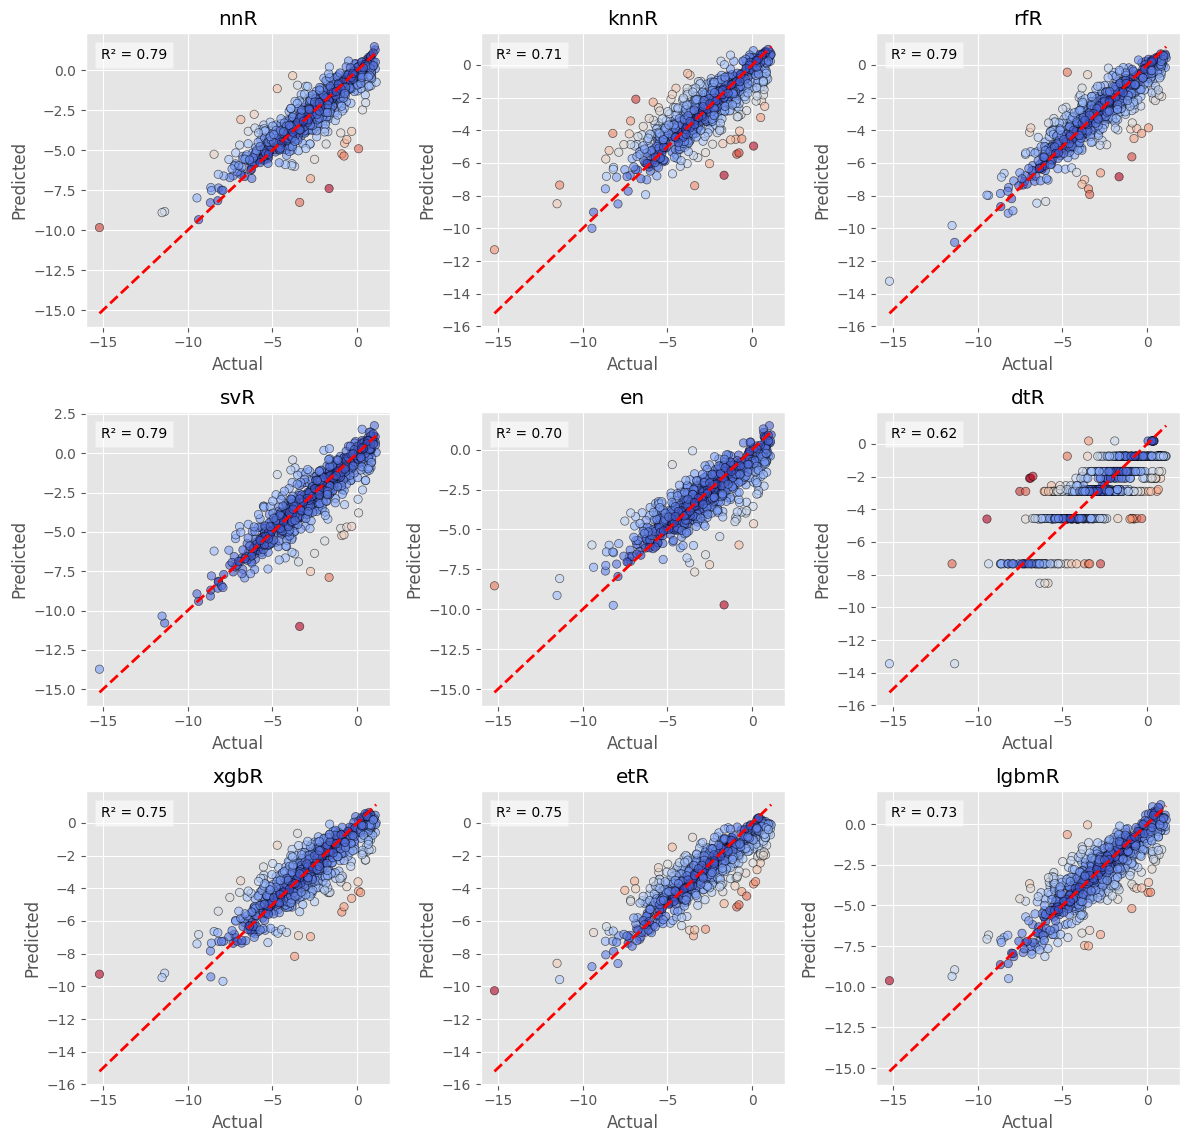

In [61]:
plt.figure(figsize=(12, 12))
num_rows, num_cols = 3, 3
cmap = cm.coolwarm
norm = Normalize(vmin=y_test.min(), vmax=y_test.max())

for i, (name, pred_dict) in enumerate(predictions.items(), start=1):
    y_test_pred = pred_dict['test']  # Use test predictions from the existing dictionary
    plt.subplot(num_rows, num_cols, i)
    sc = plt.scatter(y_test, y_test_pred, c=np.abs(y_test_pred - y_test), cmap=cmap, edgecolor='k', alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    r2 = r2_score(y_test, y_test_pred)
    plt.text(0.05, 0.95, f'R² = {r2:.2f}', ha='left', va='top', transform=plt.gca().transAxes,
             fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

    plt.title(f'{name}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Berdasarkan nilai **R²**, beberapa model seperti `RandomForest`, `SVR`, dan `NeuralNetwork` menunjukkan performa yang baik dalam memprediksi data sesuai dengan hipotesis awal. Namun, `ExtraTrees` meskipun memahami pola, terbatas pada rentang prediksi tertentu sehingga mengurangi fleksibilitasnya pada nilai ekstrem.

Sebaliknya, meski diharapkan **underperform**, model seperti `KNN` memberikan prediksi yang cukup baik dengan nilai **R²** di atas 0.7. Namun, model ini cenderung **overfitting** pada data latih, seperti terlihat dari selisih besar antara MAE latih dan uji dibandingkan dengan model lain. Hal ini masih lebih baik daripada `DecisionTree`, yang secara umum memiliki performa paling rendah di antara semua model.

`XGBoost` dan `LightGBM` tidak memberikan performa yang maksimal, yang kemungkinan besar disebabkan oleh kurangnya tuning **hyperparameter**. Kedua model ini terkenal lebih sensitif terhadap parameter seperti jumlah pohon, kedalaman maksimum, atau kecepatan pembelajaran, terutama pada dataset yang kompleks atau berukuran kecil.

Beberapa sifat unik terlihat pada model seperti `DecisionTree`, di mana prediksinya kurang fleksibel, ditandai dengan pola konstan terhadap sumbu `y` pada beberapa nilai `x`. Model seperti `DecisionTree`, `XGBoost`, `ExtraTrees`, dan `LightGBM` juga menunjukkan keterbatasan rentang prediksi, terutama pada nilai negatif. Hal ini menunjukkan adanya pengaruh parameter model terhadap hasil prediksi, yang kemungkinan besar dipengaruhi oleh distribusi data latih.

## 9.3. Random Data Tester

Selain `Metrik (MAE, SE, R²)` dan `Prediktif vs Aktual`, dilakukan `10 Random Data Testing` dengan menyertakan `3 model` dengan prediksi yang paling mendekati nilai aktual. 

In [62]:
# Sample 5 test rows
sample_test = X_test.sample(n=5).copy()

# Create a dictionary for predictions
pred_dict = {'True LogS': y_test.loc[sample_test.index].values}

# Loop through models and get predictions
for name, model in model_dict.items():
    pred_dict[name] = model.predict(sample_test).round(3)

# Convert to DataFrame
pred_df = pd.DataFrame(pred_dict)
pred_df.index = sample_test.index

# Define the number of closest models to track
num_closest = 3  # Number of closest models you want to list

# Initialize a dictionary to store the closest model information
closest_models = {f'Closest Model {i}': [] for i in range(1, num_closest + 1)}

# Loop through each sample and find the closest models
for idx in pred_df.index:
    # Calculate absolute differences from True LogS for each model
    diffs = abs(pred_df.loc[idx, 'True LogS'] - pred_df.loc[idx, pred_df.columns != 'True LogS'])
    # Get the top `num_closest` models with the smallest differences
    top_closest = diffs.nsmallest(num_closest).index.tolist()

    # Store each closest model in the respective row
    for i, model_name in enumerate(top_closest, start=1):
        closest_models[f'Closest Model {i}'].append(model_name)

# Add closest models as new rows in the DataFrame
for i in range(1, num_closest + 1):
    pred_df[f'Closest Model {i}'] = closest_models[f'Closest Model {i}']

# Transpose for easier readability
pred_df.T

[LightGBM] [Warning] min_gain_to_split is set=0.07185890393911232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07185890393911232
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


7538           5508      6072           5396  \
True LogS           -6.428398      -2.062032  0.678373      -3.570876   
NeuralNetwork          -3.811          -2.95     0.467         -3.599   
KNN                    -3.761         -2.583     0.549         -3.569   
RandomForest           -4.433          -3.25     0.446         -3.124   
SVR                    -4.516         -3.456     0.528         -3.463   
ElasticNet              -4.87         -3.835     0.207         -2.518   
DecisionTree           -4.596         -2.902    -0.749         -2.096   
XGBoost                -4.167         -3.245     0.101         -2.638   
ExtraTrees             -4.496         -3.317     0.002         -2.744   
LGBM                   -4.461         -4.413     0.574         -2.411   
Closest Model 1    ElasticNet            KNN      LGBM            KNN   
Closest Model 2  DecisionTree   DecisionTree       KNN  NeuralNetwork   
Closest Model 3           SVR  NeuralNetwork       SVR            SVR   

                          2488  
True LogS             -3.78733  
NeuralNetwork           -3.868  
KNN                      -3.11  
RandomForest            -3.229  
SVR                     -3.557  
ElasticNet              -3.101  
DecisionTree            -2.902  
XGBoost                 -2.588  
ExtraTrees              -3.493  
LGBM                    -4.316  
Closest Model 1  NeuralNetwork  
Closest Model 2            SVR  
Closest Model 3     ExtraTrees

`Random tester` untuk menguji `LogS prediksi` beberapa model secara `random`.

# Underground

In [ ]:
print('[STOP]')